# Imports

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm
import scipy
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import time
from datetime import timedelta
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())
import torch
import random

def ReSeed(seed=0):
    torch.manual_seed(seed)
ReSeed(0)

%matplotlib inline

## Load data (of a single time slice)

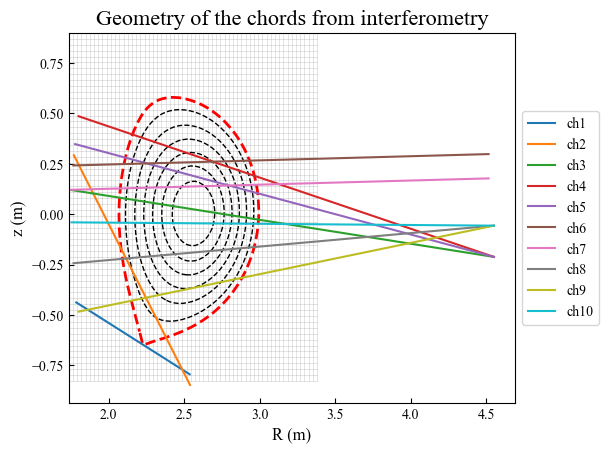

In [2]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Plotting The NICE profile and vrious Data Options

The responce martix is applied to the NICE profile to generate ground truth data for a simulation where NICE is the exact profile in the TOKAMAK.

Some noise is added to the ground truth data to generate synthetic data.

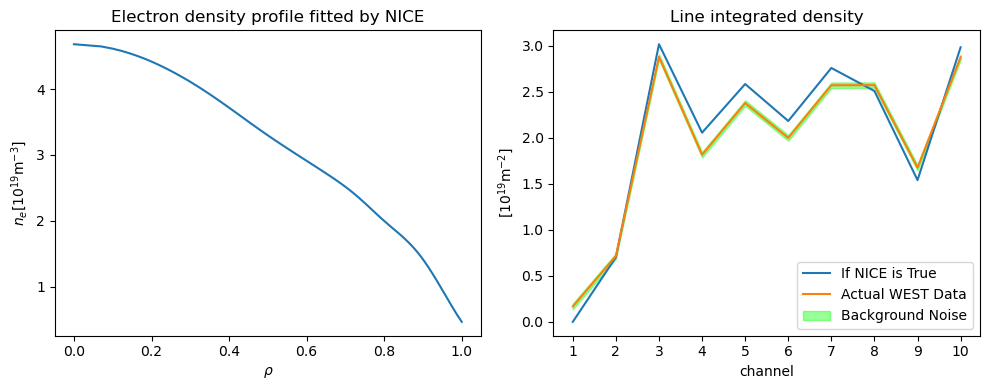

In [3]:
EXP_ER = 0.03#0.5 #0.03#background noise order of magnitude
interf_M = len(interf.channels.compressed()) #number of channels 
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data
                                          
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nice = dens_prof.dens_1d
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='If NICE is True')#'Ground Truth')
# ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')

ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')
ax2.fill_between(interf.channels.compressed(), interf.lid.compressed() - EXP_ER, 
                 interf.lid.compressed()+EXP_ER, color=(0,1,0,0.4),label="Background Noise")

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()




tpe <class 'list'>
128
256
[9004, 9008, 9010, 9013, 9017, 9023, 9039, 9045, 9053, 9058, 9071, 9081, 9085, 9089, 9092, 9096, 9106, 9112, 9122, 9126, 9129, 9131, 9135, 9145, 9157, 9172, 9179, 9185, 9191, 9197, 9201, 9205, 9213, 9220, 9224, 9228, 9239, 9243, 9246, 9249, 9264, 9273, 9279, 9281, 9283, 9300, 9302, 9304, 9307, 9317, 9322, 9330, 9345, 9371, 9389, 9417, 9425, 9430, 9432, 9454, 9460, 9464, 9472, 9478, 9482, 9488, 9497, 9499, 9501, 9510, 9512, 9529, 9531, 9551, 9554, 9562, 9569, 9572, 9580, 9591, 9599, 9603, 9605, 9608, 9611, 9613, 9623, 9625, 9627, 9632, 9639, 9645, 9647, 9649, 9654, 9670, 9678, 9689, 9693, 9708, 9711, 9719, 9737, 9744, 9747, 9751, 9759, 9769, 9774, 9789, 9796, 9843, 9854, 9884, 9887, 9907, 9919, 9921, 9923, 9928, 9931, 9935, 9944, 9948, 9964, 9973, 9976, 9996, 9004, 9008, 9010, 9013, 9017, 9023, 9039, 9045, 9053, 9058, 9071, 9081, 9085, 9089, 9092, 9096, 9106, 9112, 9122, 9126, 9129, 9131, 9135, 9145, 9157, 9172, 9179, 9185, 9191, 9197, 9201, 9205, 9213, 9220, 

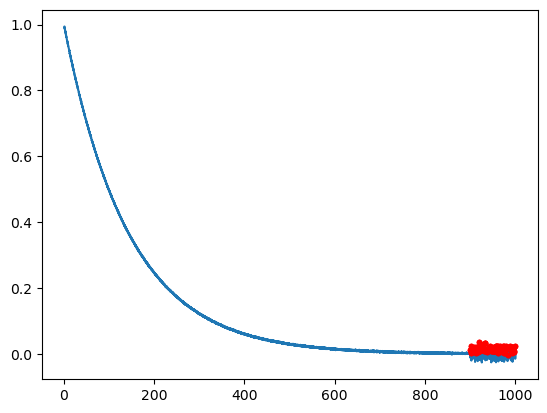

In [4]:
# oscilation detection

from scipy.signal import find_peaks

x = np.linspace(1,1000,10000)

y = np.exp(-0.007*x)
# y2 = 0.5*np.sin(0.1*x[8000:])
# y = np.concatenate((y1,y2))
y[0:9000] = y[0:9000]+np.random.normal(loc=0,scale=0.001,size=9000)
y[9000:] = y[9000:]+np.random.normal(loc=0,scale=0.01,size=len(y[9000:]))

plt.plot(x,y)

peaks, _ = find_peaks(y,threshold = 0.01)
peaks = list(peaks)
print('tpe',type(peaks))
plt.plot(x[peaks],y[peaks],'.r')
print(len(peaks))
peaks += peaks
print(len(peaks))
print(peaks)
plt.plot(x[peaks],y[peaks],'.r')



# Setting Data

In [5]:
rho_1d = dens_prof.rho_tor_norm_1d

# Ground Trueth. Assuming a profile is true what is the exact LID for each channel?
# lid_d = lid_true
# Synthetic data, gaussian noise added to ground truth
# lid_d = lid_data
# Real Data for each channel from west
lid_d = interf.lid.compressed()


1.0


/home/daniel/anaconda3/envs/mthesis/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1693317512104/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


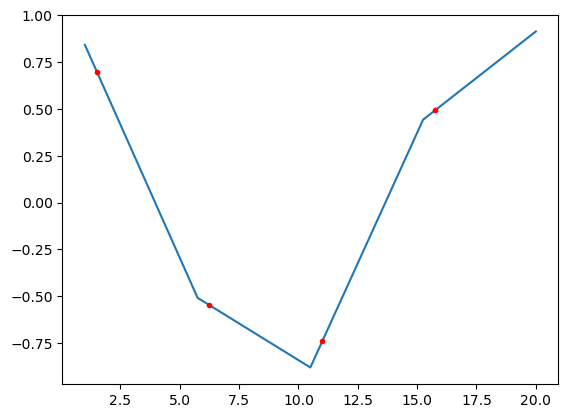

In [6]:
x = torch.linspace(1,20,5)
y = torch.sin(x)
plt.plot(x,y)
def TorchInterpolate(x,y,mode='nearest_left'):
        def Nearest(x_new):
            NEW_X, X = torch.meshgrid(x_new, x)
            DIFF = NEW_X - X
            nearest_index = torch.argmin(torch.abs(DIFF),dim=1)
            return y[nearest_index]
    
        def NearestLeft(x_new):
            NEW_X, X = torch.meshgrid(x_new, x)
            DIFF = NEW_X - X
            DIFF[DIFF<0] = float('inf')
            nearest_left_index = torch.argmin(torch.abs(DIFF),dim=1)
            return y[nearest_left_index]
        
        def NearestRight(x_new):
            NEW_X, X = torch.meshgrid(x_new, x)
            DIFF = NEW_X - X
            DIFF[DIFF>0] = float('inf')
            nearest_right_index = torch.argmin(torch.abs(DIFF),dim=1)
            return y[nearest_right_index]
        def Linear(x_new):
            bound_right = float(torch.max(x))
            bound_left = float(torch.min(x))
            print(float(bound_left))
            x_new_cut = x_new[(x_new < bound_right) * (x_new > bound_left)]
            num_cut = len(x_new) - len(x_new_cut)
            if num_cut>0:
                raise IndexError('There are',num_cut,'new x values that are out of bounds',
                                'Please get more data or reduce the region of data to interpolate')
                                 
                
            NEW_X, X = torch.meshgrid(x_new_cut, x)
            DIFF_L = NEW_X - X
            DIFF_R = NEW_X - X
            DIFF_L[DIFF_L<0] = float('inf')
            DIFF_R[DIFF_R>0] = float('inf')
            nearest_right_index = torch.argmin(torch.abs(DIFF_R),dim=1)
            nearest_left_index = torch.argmin(torch.abs(DIFF_L),dim=1)
            x_left = x[nearest_left_index]
            x_right = x[nearest_right_index]
            y_left = y[nearest_left_index]
            y_right = y[nearest_right_index]
            #using the fact that the fractional change in x is the same for y if linear
            x_frac = (x_new_cut - x_left) / (x_right - x_left)
            y_new = y_left + (y_right - y_left)*x_frac
            return y_new

        if mode == 'nearest_right':
            return NearestRight
        elif mode == 'nearest_left':
            return NearestLeft
        elif mode == 'nearest':
            return Nearest
        elif mode == 'linear':
            return Linear
        else: print('Mode Error')

interp = TorchInterpolate(x,y, mode='linear')

x_new = x+0.5
y_new = interp(x_new[:-1])

plt.plot(x_new[:-1], y_new, '.r')

In [ ]:

    RHOA, RHOB = torch.meshgrid(rho1,rho2)
    exp=torch.exp
else: 
    RHOA, RHOB = np.meshgrid(rho1,rho2)
    exp=np.exp
#amplitude determins how far the model can go from the mean
amp = params[0]
#length scale determines smoothness, how correlated the function should be at a distance
l = params[1]
if tensor: return (amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))).T
else: return amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))

# Static OR non-Static Kernel

Adding in differnential versions of the kernel for including gradient information.

In [7]:
STATIC = 1
# 1 means completly static
# 2 means static amp but non static length-scale
# 3 means static amp but non static length-scale with a hyperbolic tangent functional form 
# 4 means static amp but non static length-scale with a exonential decay functional form 
# 5 means non static length scale and amp
# 6 means non static amplitude and static length scale

if STATIC==1:
    
    def RandomKernelInit(NUM_RANDOM_SEARCHES, tensor):
        
        amp_dist = torch.distributions.uniform.Uniform(0, 50)
        l_dist = torch.distributions.uniform.Uniform(0.0001,1)
        exp_er_dist = torch.distributions.uniform.Uniform(0.1,0.5)
        kernel_params = []    
        for balls in range(NUM_RANDOM_SEARCHES):
            amp = amp_dist.sample()
            l = l_dist.sample()
            exp_er = exp_er_dist.sample()
            kp = [amp,l,exp_er]
            kernel_params.append(kp)
        if not tensor:
            kernel_params = [[kp_i.numpy() for kp_i in kp] for kp in kernel_params]
        return kernel_params
    
    def Plot_l(rho, params, tensor):
        print('Plotting Length Scale. This is the static case and so length-scale is constant.')
        print('The amplitude is, Amp:',params[0])
        print('The length-scale is, l:',params[1])
        print('The experimental error is, EXP_ER:',params[2])
#         plt.plot(rho,np.repeat(params[1],len(rho_1d)))
        
    def Kernel(rho1, rho2, params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))).T
        else: return amp**2 * exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def KernelPrime(rho1,rho2, params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp

        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (amp ** 2 / l ** 2 * (RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)).T
        else: return amp ** 2 / l ** 2 * (RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)
    
    def KernelPrimePrime(rho1,rho2,params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (amp ** 2 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)).T        
        else: return amp ** 2 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)
        
    initial_params = [20,0.1,0.5]#[4.48730023, 0.91623679, 0.5]#
    suitable_params_range = [(0.1,100),(0.001,1),(0.03,0.5)]
    
#     initial_params = [5.62,1.37,0.5]
    #amp, l, EXP_ER
#     initial_params = np.array([5.62,10,0.5])

elif STATIC==2:
        #return a function that will take and x input and output interpolated y
    def Kernel(rho1,rho2,params, tensor=False):
        print(len(rho_1d))
        print(len(params[1:]))
        lss = np.array([p.detach().numpy()[0] for p in params[1:]])
        print([0])
        if tensor:
            l1 = torch.tensor(l_fun(rho1))
            l2 = torch.tensor(l_fun(rho2))
#             l_fun = torch.nn.functional.interpolate(, size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False)
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            LA, LB = torch.meshgrid(l1,l2)
        
        else:
            l_fun = scipy.interpolate.interp1d(rho_1d, lss, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=float('nan'), assume_sorted=False)
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            LA, LB = np.meshgrid(l1,l2)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)    
        if tensor: return (amp**2 * torch.sqrt(frac) * torch.exp(-(mag/scale2))).T
        else: return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_test)-3)))
    initial_params = np.array([5.62]+list(np.repeat(1.37,len(rho_1d))))
    #exponential decay of correlation length. Creates a flat area at 0.
    # l_initial = list(10*np.exp(-2*rho_test))
    # initial_params = ([5.62]+l_initial)
    # plt.plot(rho_test,l)

elif STATIC==3:
    import torch
    def RandomKernelInit(NUM_RANDOM_SEARCHES, tensor):
        half = torch.distributions.uniform.Uniform(0, 0.5)
        full = torch.distributions.uniform.Uniform(0, 1)
        t_center_dist = torch.distributions.uniform.Uniform(0.5, 1)
        amp_dist = torch.distributions.uniform.Uniform(0, 50)
        exp_er_dist = torch.distributions.uniform.Uniform(0.1,0.5)
        kernel_params = []    
        for balls in range(NUM_RANDOM_SEARCHES):
            amp = amp_dist.sample()
            core_l = half.sample() 
            #ensure edge_l is smaller than core
            edge_dist = torch.distributions.uniform.Uniform(0, core_l)
            edge_l = edge_dist.sample()
            transition_center = t_center_dist.sample()
            transition_width = half.sample()
            exp_er = exp_er_dist.sample()
            kp = [amp,core_l,edge_l,transition_center,transition_width,exp_er]
            kernel_params.append(kp)
        if not tensor:
            kernel_params = [[kp_i.numpy() for kp_i in kp] for kp in kernel_params]
        return kernel_params
    def HyperTan_l(rho, params, plot=False, tensor=False):
            core_l, edge_l, transition_center, transition_width = params[1:-1]
            if tensor:
                l = ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * torch.tanh((rho - transition_center)/transition_width)).float()
            else:
                l = ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * np.tanh((rho - transition_center)/transition_width)) 
            if plot:
                figLengthScale = plt.figure()
                plt.plot(rho,l)
                plt.title('Hyperbolic Tangent Length Scale Function. Smooth Step')
                plt.xlabel(r'$\rho$')
                plt.ylabel('length scale')
                plt.show()
            return l
    def Plot_l(rho,params, tensor):
        HyperTan_l(rho, params, plot=True, tensor=tensor)
    def Kernel(rho1,rho2,params, tensor=False):
        l1 = HyperTan_l(rho1, params, plot=False, tensor=tensor)
        l2 = HyperTan_l(rho2, params, plot=False, tensor=tensor)
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            LA, LB = torch.meshgrid(l1,l2)
        
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            LA, LB = np.meshgrid(l1,l2)
        
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)
        if tensor: return (amp**2 * torch.sqrt(frac) * torch.exp(-mag/scale2)).T
        else: return amp**2 * np.sqrt(frac) * np.exp(-mag/scale2)
        
    def KernelPrime(rho1,rho2,params, tensor=False):
        l1 = HyperTan_l(rho1, params, plot=False, tensor=tensor)
        l2 = HyperTan_l(rho2, params, plot=False, tensor=tensor)
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            LA, LB = torch.meshgrid(l1,l2)
        
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            LA, LB = np.meshgrid(l1,l2)
        
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) 
        if tensor:
            return (amp**2*2*torch.sqrt(frac)/scale2 * (RHOA-RHOB) * torch.exp(-mag/scale2)).T
        else: 
            return amp**2*2*np.sqrt(frac)/scale2 * (RHOA-RHOB) * np.exp(-mag/scale2)
    
    def KernelPrimePrime(rho1,rho2,params, tensor=False):
        l1 = HyperTan_l(rho1, params, plot=False, tensor=tensor)
        l2 = HyperTan_l(rho2, params, plot=False, tensor=tensor)
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            LA, LB = torch.meshgrid(l1,l2)
        
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            LA, LB = np.meshgrid(l1,l2)
        
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)
        if tensor:
            return (amp**2*2*torch.sqrt(frac)/scale2 * (1 - mag*2/scale2) * torch.exp(-mag/scale2)).T
        else: return amp**2*2*np.sqrt(frac)/scale2 * (1 - mag*2/scale2) * np.exp(-mag/scale2)

    #large l for first three 
    
#     initial_params = ([4.02307298, 0.82531148, 0.63734754, 1.24446601, 0.75722961])#origional core match
#     initial_params = ([30.02307298, 0.82531148, 0.63734754, 1.24446601, 0.75722961])#altered core match
    params_names = ['amp','core_l','edge_l','transition_center','transition_width', 'EXP_ER']
    suitable_params_range = [(0,100),(0,1),(0,1),(0.5,1)]
    initial_params = np.array([4, 0.91, 0.01, 0.9, 0.05, 0.5])
    initial_params_list = list(initial_params)
    initial_params_dict = {'amp':torch.tensor([initial_params[0]]),'core_l':torch.tensor([initial_params[1]]), 'edge_l':initial_params[2],
                           'transition_center':torch.tensor([initial_params[2]]), 
                           'transition_width':torch.tensor([initial_params[3]])}
#     initial_params = ([ 30.46490307,   1.26607835, -12.65929225,   1.30549892, 0.18071757])# origional edge match
#     initial_params = ([ 30.46490307,   1.26607835, -12.65929225,   1.30549892, 0.18071757])# altered edge match
    #([5.62,2,0.1,0.7,0.1])
    
elif STATIC==4:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        core_l, edge_l, drop_rate = params[1:]
        def ExpDecay_l(rho):
            return core_l * np.exp(-drop_rate*rho) + edge_l
        l = ExpDecay_l(rho_test)
        plt.plot(rho_test,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_test)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_test)-3)))
    
    initial_params = ([5.62,10,1,9])

    
elif STATIC==5:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[:N]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[N:])
        LA, LB = np.meshgrid(l,l)
        AMPA, AMPB = np.meshgrid(amp,amp)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)    
        #the equation should revert to a static one if amp_i = amp_j and l_i = l_j
        return (3*AMPA*AMPB / AMPA*AMPA+AMPB*AMPB) * frac * np.exp(-(mag/scale2))
    # initial_params = list(np.repeat(5.62,N))+list(np.repeat(1.37,N))
    initial_params = list(np.repeat(5.62,N))[:-1]+[0.5]+list(np.repeat(1.37,N))

#only applies to extra information in the prior
elif STATIC==6:
    def Kernel(rho1, rho2, params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))).T
        else: return exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    
    def KernelPrime(rho1,rho2, params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp

        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (1 / l ** 2 *(RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)).T
        else: return 1 / l ** 2 * (RHOA - RHOB) * exp(- 0.5 * (RHOA - RHOB) ** 2 / l ** 2)
    
    def KernelPrimePrime(rho1,rho2,params, tensor):
        if tensor:
            RHOA, RHOB = torch.meshgrid(rho1,rho2)
            exp=torch.exp
        else: 
            RHOA, RHOB = np.meshgrid(rho1,rho2)
            exp=np.exp
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        if tensor: return (1 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)).T        
        else: return 1 / l ** 2 * (1 - (RHOA-RHOB) ** 2 / l ** 2) * exp(- 0.5 * (RHOA- RHOB) ** 2 / l ** 2)
        
    initial_params = [20,0.1,0.5]#[4.48730023, 0.91623679, 0.5]#
    suitable_params_range = [(0.1,100),(0.001,1),(0.03,0.5)]
    
sgd_params = [torch.tensor([p], requires_grad=False) for p in initial_params]
Kernel(torch.from_numpy(rho_1d), torch.from_numpy(rho_1d), sgd_params, tensor=True)
# HyperTan_l(torch.from_numpy(rho_1d), initial_params, plot=True, tensor=True)


# Kernel(rho_1d, rho_1d, initial_params)
# HyperTan_l(rho_1d, initial_params, plot=True)
a=1

# Forward GPR including edge and gradient info with pytorch

In [24]:
# %matplotlib widget
#on cloud veneto

#altering to include artificial data for gradient and edge rather than this information being placed in the prior
class ForwardGPR(object):
    def __init__(self, rho_test, lid_d, ne_d, ne_prime_d, lid_error, ne_error, ne_prime_error, Kernel, 
                 rho_test2=None, rho_test3=None,
                 initial_params=None, prior_mu='non-informative',
                 PYTORCH_DEGREE=0, INC_EXTRA_INFO=True, OPTIMIZE_EXP_ER=True, reset=True):#0 IN NO PYTORCH, 1 IS MINIMAL PYTORCH, 2 IS ALL PYTORCH
        self.inc_extra_info = INC_EXTRA_INFO
        self.optimize_exp_er = OPTIMIZE_EXP_ER
        self.pytorch_degree = PYTORCH_DEGREE
        self.Kernel = Kernel
        
        self.N = len(rho_test)
        self.M = len(lid_d)
           
        self.data = lid_d
        self.lid_error = lid_error
        self.rho_test = rho_test
        
        self.initial_params = initial_params
        
        self.inc_extra_info = INC_EXTRA_INFO

        convert_params = [self.data, self.lid_error, self.rho_test]        
        if self.pytorch_degree == 2 or self.pytorch_degree==1:
            convert_params = [torch.from_numpy(pa).float() for pa in convert_params]
            self.data, self.lid_error, self.rho_test = convert_params
        
        
        if self.inc_extra_info:
            self.ne_d = ne_d
            self.ne_error = ne_error
            self.ne_prime_d = ne_prime_d
            self.ne_prime_error = ne_prime_error
            self.data = np.block([lid_d,ne_d,ne_prime_d])
            self.rho_test2 = rho_test2
            self.N2 = len(rho_test2)
            self.rho_test3 = rho_test3
            self.N3 = len(rho_test3)
            self.A = len(ne_d)
            self.B = len(ne_prime_d)
            self.Kernel, self.KernelPrime, self.KernelPrimePrime = Kernel
            convert_params = [self.ne_d, self.ne_error, self.ne_prime_d, self.ne_prime_error, self.data, self.rho_test2, self.rho_test3]
            
            if self.pytorch_degree == 2 or self.pytorch_degree==1:
                convert_params = [torch.from_numpy(pa).float() for pa in convert_params]
                self.ne_d, self.ne_error, self.ne_prime_d, self.ne_prime_error, self.data, self.rho_test2, self.rho_test3 = convert_params     
        
        
        if prior_mu == 'non-informative' and self.inc_extra_info:
            self.prior_mu = np.zeros(self.N+self.N2+self.N3)
        elif prior_mu == 'non-informative':
            self.prior_mu = np.zeros(self.N)
        else: self.prior_mu = prior_mu
      
        if self.pytorch_degree == 2 or self.pytorch_degree==1:
            self.prior_mu = torch.from_numpy(self.prior_mu).float()
        
        if reset:
            # for inference
            self.post_mu = None
            self.post_cov = None

            #torch, best overall, for torch fit
            self.torch_best_params=None
            self.torch_best_marge_li = None
            self.torch_best_fit_loss = None
            self.torch_best_peaks_index = None
            self.torch_best_lr_update_index = None
            self.torch_best_rand_init_params = None
            self.torch_best_step = None

            #grid search
            self.grid_best_marge_li = float('inf')
            self.grid_best_params = None

            self.suitable_params_range = None
            self.num_grid_squares_1d = None
            self.marginal_likelyhood_grid = None

            #SciPy
            self.scipy_best_params = None
            self.scipy_best_marge_li = None
            self.scipy_best_rand_init_params = None
         
    def MakePosDef(self, A, name='Matrix'):
        #needs to be torch seperated
        if not torch.is_tensor(A): A = torch.from_numpy(A)
        small = [0] + [1*10**(-o) for o in reversed(range(1,11))]
        for sm in small:
            A += torch.diag_embed(torch.tensor(sm).repeat(A.shape[0]))
            try:
                L = torch.linalg.cholesky(A)#ensures not positive definate
                torch.inverse(L) # ensures not singular
                if sm>0:
                    print('For '+name+' a small addition of', sm ,
                          'to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.')
                return A 

            except torch.linalg.LinAlgError:
                print("Non positive definate matrix for "+name+" even with a small addition of", sm ,
                      "to the diagonal.")
                if sm == small[-1]: raise torch.linalg.LinAlgError('No small addition along the diagonal was',
                                                                   'enought to make it non positive definate')
           
    def chol_inv(self, A, name='Matrix'):
        A = self.MakePosDef(A, name=name)
        if self.pytorch_degree==2 or self.pytorch_degree==1: 
            L = torch.linalg.cholesky(A)
            inv = torch.inverse
        else: 
            L = np.linalg.cholesky(A)
            inv = np.linalg.inv
        return inv(L).T @ inv(L)

    def chol_det(self, A, name='Matrix'):
        A = self.MakePosDef(A, name=name)
        if self.pytorch_degree==2 or self.pytorch_degree==1:
            L = torch.linalg.cholesky(A)
            prod = torch.prod
            diag = torch.diag
        else:
            L = np.linalg.cholesky(A)
            prod = np.prod
            diag = np.diag
        return prod(diag(L))
        
    def KRcov_li(self, params):            
        #covergence matrix of Prior
        if self.pytorch_degree==2 or self.pytorch_degree==1: tensor = True
        else: tensor = False
        if self.inc_extra_info:
            K11 = self.Kernel(self.rho_test, self.rho_test, params, tensor=tensor)
            K12 = self.Kernel(self.rho_test2, self.rho_test, params, tensor=tensor)
            K13 = self.KernelPrime(self.rho_test3, self.rho_test, params, tensor=tensor)
            K22 = self.Kernel(self.rho_test2, self.rho_test2, params, tensor=tensor)            
            K23 = self.KernelPrime(self.rho_test3, self.rho_test2, params, tensor=tensor)
            K33 = self.KernelPrimePrime(self.rho_test3, self.rho_test3, params, tensor=tensor)
            if self.pytorch_degree==2 or self.pytorch_degree==1:
                row1 = torch.cat([K11, K12, K13],dim=1)
                row2 = torch.cat([K12.T, K22, K23],dim=1)
                row3 = torch.cat([-K13.T, -K23.T, K33],dim=1)
                K = torch.cat([row1,row2,row3], dim=0)
                K = K.float()
            else:
                K = np.block([[K11, K12, K13],
                              [K12.T, K22, K23],
                              [-K13.T, -K23.T, K33]])
        
        else: K = Kernel(self.rho_test, self.rho_test, params, tensor=tensor)
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        #cov_li is covergence matrix of Likelyhood
        if self.optimize_exp_er:
            if self.pytorch_degree==2 or self.pytorch_degree==1:
                lid_error = torch.tensor([params[-1]]).repeat(self.M).float()
            else:
                lid_error = np.repeat(params[-1],self.M)
        else:
            lid_error = self.lid_error
        
        if self.pytorch_degree==2 or self.pytorch_degree==1:
            if self.inc_extra_info:
                R = torch.cat([torch.cat([torch.from_numpy(compute_response_matrix(geo, equi, self.rho_test.numpy())), torch.zeros((self.M,self.A+self.B))],dim=1),
                               torch.cat([torch.zeros((self.A+self.B, self.N)), torch.diag(torch.ones(self.A+self.B))],dim=1)], dim=0)
                cov_li = torch.diag(torch.cat([lid_error, self.ne_error, self.ne_prime_error])) # M is number of channels
            else:
                R = torch.from_numpy(compute_response_matrix(geo, equi, self.rho_test.numpy()))
                cov_li = torch.diag(lid_error) # M is number of channels
            R = R.float()
            cov_li = cov_li.float()
        else:
            if self.inc_extra_info:
                R = np.block([[compute_response_matrix(geo, equi, self.rho_test), np.zeros((self.M,self.A+self.B))],
                         [np.zeros((self.A+self.B, self.N)), np.diag(np.ones(self.A+self.B))]])
                cov_li = np.diag(np.block([lid_error, self.ne_error, self.ne_prime_error])) # M is number of channels
            else:
                R = compute_response_matrix(geo, equi, self.rho_test)
                cov_li = np.diag(lid_error) # M is number of channels
        
         
        return K, R, cov_li
    
    def MargeLi(self, params, ENFORCE_BOUNDS=False):    
        K, R, cov_li = self.KRcov_li(params)
        if self.pytorch_degree==2 or self.pytorch_degree==1: 
            invertable = (cov_li + R @ K @ R.T).float()
        else: 
            invertable = (cov_li + R @ K @ R.T)
#         Keep Params in Suitable Range
        total_addon = 0
        if ENFORCE_BOUNDS:
            for pr,sr,name in zip(params,suitable_params_range,params_names):
                out_of_bounds = False
                if pr < sr[0]:
                    diff = sr[0] - pr
                    out_of_bounds = True
                elif pr > sr[1]:
                    diff = pr - sr[1]
                    out_of_bounds = True
                if out_of_bounds:
                    addon = torch.exp(60*diff-7)
                    total_addon += addon
#                     print(name, 'is out of bounds by:',diff,'. Consequent addon:',addon)
#             if total_addon > 0:
#                 print('Params out of bounds, total addon to loss',total_addon)
        #marge_li = torch.log(total_addon + ((0.5*torch.log(self.chol_det(invertable,name='Invertable, Det')) + 0.5*(self.data@self.chol_inv(invertable, name='Invertable, Inv')@self.data))))
        
        if self.pytorch_degree==2 or self.pytorch_degree==1: marge_li = total_addon + torch.log(self.chol_det(invertable,name='Invertable, Det')) +(self.data@self.chol_inv(invertable, name='Invertable, Inv')@self.data)
        else: marge_li = total_addon + np.log(self.chol_det(invertable,name='Invertable, Det')) +(self.data.T@self.chol_inv(invertable, name='Invertable, Inv')@self.data)
        return marge_li**2

    def OptimLrVis(self, loss, loss_smooth_step, lr, lr_low, lr_high, lr_best):        
        figLoss = plt.figure()
        plt.plot(lr, loss, 'red', label="Origional Loss")
        plt.plot(lr, loss_smooth_step, 'blue', label="Smooth Step Fit")
        plt.xlabel('Learning Rate')
        plt.xscale('log')
        plt.title('Learning Rate Tuning')
        plt.ylabel('Marginal Likelyhood')
        loss_grad = np.gradient(loss_smooth_step)
        plt.plot(lr,loss_grad,color='g',label='Derivative')
        y_min = np.min((np.min(loss_grad), np.min(loss)))
        y_max = np.max((np.max(loss_grad), np.max(loss)))
        plt.vlines((lr_low,lr_high), (y_min,y_min), (y_max,y_max), linestyle='dashed', color='black', label='Acceptable Range')
        plt.vlines(lr_best, y_min, y_max,  linestyle='dashed', color='g', label='Chosen Rate')
        plt.legend()
        plt.show()
    def PlotLoss(self,loss,peaks,lr_update_index, best_step):
        figLoss = plt.figure()
        loss = np.array(loss)
        steps = np.arange(len(loss))
        plt.plot(steps, loss)
        plt.plot(steps[peaks], loss[peaks],'.r',label='Detected Peaks')
        y_min = np.min(loss)
        y_max = np.max(loss)
        plt.vlines(lr_update_index, y_min,y_max, linestyle='dashed', color='black', label='Learning Rate Update')
        plt.vlines(best_step, y_min,y_max, linestyle='dashed', color='green', label='Lowest Marginal Likelyhood')
        plt.xlabel('Epoch')
        plt.title('Pytorch Fit')
        plt.ylabel('Marginal Likelyhood')
#         plt.yscale('log')
#         plt.xscale('log')
        plt.legend()
        plt.show()
       
    def TorchOptimiseLr(self, kernel_params, acceptable_loss_grad = -0.05):
        print('Optimising the Learning Rate')
        lr_range = torch.logspace(-6,-1,base=10,steps=30)
        lr_index = np.arange(len(lr_range)) 
        #activating the gradient tracking for the parameters into a new variable
        fit_params = [p.clone() for p in kernel_params]
        for i in range(len(fit_params)): fit_params[i].requires_grad = True
        all_loss = []
        pbar = tqdm(range(len(lr_range)))
        for i in pbar:
            optimizer = torch.optim.SGD(fit_params, lr_range[i])
            loss = self.MargeLi(fit_params, ENFORCE_BOUNDS=False)
            if torch.isnan(loss):
                    print('\n\nWhile optimising the lr, the following parameters caused a nan loss\n')
                    print(fit_params)
                    Plot_l(torch.from_numpy(rho_1d), [fp.detach() for fp in fit_params], tensor=True)
                    break
            pbar.set_description("Optimising Learning Rate: Marginal LikelyHood is, "+str(loss.detach().numpy()))
            all_loss.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        def SmoothStep(x, left_y, right_y, transition_center_x, transition_width_x):
            return ((left_y + right_y)/2) - (((left_y - right_y)/2) * np.tanh((x - transition_center_x)/transition_width_x)) 
        popt = scipy.optimize.curve_fit(SmoothStep, lr_index, all_loss)[0]
        FigCheckFit = plt.figure()
        all_loss_smooth_step = SmoothStep(lr_index,*popt)
        loss_grad = np.gradient(all_loss_smooth_step)
        loss_grad_indexes = np.arange(len(loss_grad))
        loss_grad_index_below_acceptable = loss_grad_indexes[loss_grad<acceptable_loss_grad]
        
        while len(loss_grad_index_below_acceptable)==0:
            print('In while Loop, lowering acceptable')
            acceptable_loss_grad += 0.001
            loss_grad_index_below_acceptable = loss_grad_indexes[loss_grad<acceptable_loss_grad] 
        lr_low_index =  loss_grad_index_below_acceptable[0]
        lr_low = lr_range[lr_low_index]
        #lr_high must be above lr_low
        lr_index_above_low = loss_grad_indexes[lr_low_index:]
        #set lr high to when the los curves up
        lr_index_curve_up = lr_index_above_low[loss_grad[lr_low_index:] > acceptable_loss_grad]
        print(lr_index_curve_up)
        print(lr_low_index)
        #if it doesn't curve up then use last index
        if len(lr_index_curve_up) == 0:
            lr_high_index = lr_index_above_low[-1]
        #else use the first index that it curves up at
        else: lr_high_index = lr_index_curve_up[0]
        lr_high = lr_range[lr_high_index]
        #the best lr is the one where the loss has the maximum gradient between the two acceptable values.
        lr_best = lr_range[np.argmin(loss_grad[lr_low_index:lr_high_index])+lr_low_index]
        self.OptimLrVis(all_loss,all_loss_smooth_step,lr_range, lr_low, lr_high, lr_best)
        if lr_best < 1e-5: lr_best=1e-3
        return lr_low, lr_best, lr_high
    
    def TorchFit(self, optim, optim_params,
                 kernel_params,
                 MAX_NUM_STEPS_EPOCHS = 1000, NUM_RANDOM_SEARCHES=10,
                 CONVERGE_STOP=False,
                 STOCHASTIC=False,
                 STOCHASTIC_STD=0.001,
                 ENFORCE_BOUNDS=False,
                 OPTIMIZE_LR=False,
                 LR_UPDATE_INTERVAL=501,
                 CONVERGENCE_THRESHOLDS=[1e-8]):
        timer_start = time.time()
        if kernel_params == 'random_search':
                 #implimenting pytorch fitting
            kernel_params = RandomKernelInit(NUM_RANDOM_SEARCHES, tensor=True)
        else:
            kernel_params = (kernel_params,)
            
        best_params_overall = None #best parameters from different random initial starting points of kernel parameters
        best_loss_overall = float('inf')
        for kp in kernel_params:
            lr_update_index = []
            best_overall=False
            #best for these parameters
            best_params = None
            best_loss = float('inf')
            best_step = None
#             On visual inspection a learning rate of 1e-3 is a suitable choice.
            print('Initial Random Kernel Params, Amp:',kp[0], 'EXP_ER', kp[-1])
            Plot_l(torch.from_numpy(rho_1d), kp, tensor=True)
            if OPTIMIZE_LR: 
                lr_low, lr_best, lr_high = self.TorchOptimiseLr(kp)
                optim_params['lr'] = lr_best#1e-3#lr_best#*np.exp(decay_i/decay_rate) + lr_low
                
            fit_params = [p.clone() for p in kp]
            for i in range(len(fit_params)): fit_params[i].requires_grad = True
            loss = None
            fit_loss=[]
            peaks_index=[]
            thresholds = CONVERGENCE_THRESHOLDS#[1e-5]#np.logspace(-3,-7,10)
            print('\nthresholds',thresholds)
            decay_rate = 1000
            decay_i = 0
            thresh_i = 0
            for steps in range(MAX_NUM_STEPS_EPOCHS):
                if STOCHASTIC:
#                     print('Before Stochastic, params. Amp:', fit_params[0])
#                     Plot_l(torch.from_numpy(rho_1d), [fp.detach() for fp in fit_params], tensor= True)
                    with torch.no_grad():
    #                     noise = torch.distributions.uniform.Uniform(0, 0.1)
                        for i in range(len(fit_params)): fit_params[i] = fit_params[i] + float(np.random.normal(loc=0.0,scale=STOCHASTIC_STD))
#                     print('After Stochastic, params. Amp:', fit_params[0])
#                     Plot_l(torch.from_numpy(rho_1d), [fp.detach() for fp in fit_params], tensor= True)
                    for i in range(len(fit_params)): fit_params[i].requires_grad=True
                
                threshold = thresholds[thresh_i]#1e-5#
                #stochastic gradient descent, add noise to parameters
                optimizer = optim(fit_params, **optim_params)
                steps+=1
                decay_i += 1 
                loss = self.MargeLi(fit_params, ENFORCE_BOUNDS)
                if torch.isnan(loss):
                    print('\n\nWhile fitting the following parameters caused a nan loss\n')
                    print(fit_params)
                    Plot_l(torch.from_numpy(rho_1d), [fp.detach() for fp in fit_params], tensor=True)
                    break
                fit_loss.append(loss.detach().numpy())            
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                if loss < best_loss:
                    best_loss = loss
                    best_params = [p.detach() for p in fit_params]
                    best_step = steps
                    if loss < best_loss_overall:
                        best_overall = True
                        best_loss_overall = loss
                        self.best_rand_init_params = kp
                        self.torch_best_params = best_params
                        self.torch_best_step = steps
#                 #update lr every LR_UPDATE_INTERVAL number of steps
                if steps>0 and steps%LR_UPDATE_INTERVAL==0 and OPTIMIZE_LR:
                    lr_update_index.append(steps)
                    lr_low, lr_best, lr_high = self.TorchOptimiseLr([fp.detach() for fp in fit_params])
                    optim_params['lr'] = lr_best#1e-3#lr_best#*np.exp(decay_i/decay_rate) + lr_low
                
                #finding peaks
                if steps > 0 and steps % 10 == 0:
                    some_peaks_index, _ = find_peaks(fit_loss[-10:], threshold = threshold)
                    some_peaks_index = list(some_peaks_index+steps-10)
                    peaks_index += some_peaks_index
                
                if CONVERGE_STOP:
                    relative_loss_dif = float('inf')
                    if len(fit_loss) > 2:
                        last = fit_loss[-1]
                        second_last = fit_loss[-2]                        
                        relative_loss_dif = np.abs((last - second_last)/second_last)
                        if relative_loss_dif < threshold:
                           
                            print('\nThe relative loss is below the threshold')
                            thresh_i+=1                    
                            decay_i = 0
#                             Plot_l(torch.from_numpy(rho_1d), [fp.detach() for fp in fit_params])
#                             lr_update_index.append(steps)
#                             lr_low, lr_best, lr_high = self.TorchOptimiseLr([fp.detach() for fp in fit_params])
                        
                    relative_peak_loss_dif = float('inf')
                    if len(peaks_index) > 2: 
                        last_peak = fit_loss[peaks_index[-1]]
                        second_last_peak = fit_loss[peaks_index[-2]]
                        relative_peak_loss_dif = np.abs((last_peak - second_last_peak)/second_last_peak)
                        if relative_peak_loss_dif < threshold:
                            print('\nThe peak relative loss is below the threshold')
                            thresh_i+=1
                            decay_i = 0
#                             lr_update_index.append(step)
#                             lr_low, lr_best, lr_high = self.TorchOptimiseLr([fp.detach() for fp in fit_params])
                            
                    print("#Learning Rate:",'{:.2e}'.format(float(optim_params['lr'])),"#Step:",steps,
                          "#Loss:",loss.detach().numpy(),"#Relative Loss Difference:",
                          '{:.2e}'.format(relative_loss_dif),
                          "#Relative Peak Loss Difference:",
                          '{:.2e}'.format(relative_peak_loss_dif),
                          '#Threshold:','{:.2e}'.format(threshold),'eeeeeeeeeeeeeeeeeeee',end='\r')
                    if thresh_i == len(thresholds): break
            if best_overall:
                self.torch_best_fit_loss = fit_loss
                self.torch_best_peaks_index = peaks_index
                self.torch_best_lr_update_index = lr_update_index
            
            print('\n\nFitted Params, Amp:', fit_params[0], 'EXP_ER', fit_params[-1])
            Plot_l(torch.from_numpy(rho_1d), best_params, tensor = True)
            self.PlotLoss(fit_loss, peaks_index, lr_update_index, best_step)
            self.Infer(best_params)
            self.PlotInference()
            timer_stop = time.time()
            print('The fit timer measured the time taken in hh:mm:ss as,', timedelta(seconds=timer_stop-timer_start))
        print("\n\nThe Best Fit Was:")
        Plot_l(torch.from_numpy(rho_1d), self.torch_best_params, tensor = True)
        self.PlotLoss(self.torch_best_fit_loss, self.torch_best_peaks_index, self.torch_best_lr_update_index, self.torch_best_step)
        self.Infer(self.torch_best_params) 
        
        
    def GridSearch(self, suitable_params_range, num_grid_squares_1d):
        self.suitable_params_range = suitable_params_range
        self.num_grid_squares_1d = num_grid_squares_1d
        params_vectors = [np.linspace(spr[0],spr[1],num_grid_squares_1d) for spr in suitable_params_range]
        amp_v = params_vectors[0]
        l_v = params_vectors[1]
        
        
        shape = [num_grid_squares_1d for pv in params_vectors]
#         print(shape)
        marginal_likelyhood_grid = np.zeros(shape[:-1])
#         print(marginal_likelyhood_grid)
        
#         for param in params_vectors:
#             for p_i in param:
#                 index = (p_i)
#                 marginal_likelyhood_grid[*index]
#             self.MargeLi(params=)

#         grid = np.meshgrid(*params_vectors)
        pbar = tqdm(range(1,len(amp_v)))
        for amp_i in pbar:
            for l_i in range(1,len(l_v)):
                params = [amp_v[amp_i],l_v[l_i]]
#                 print(params)
                
                marginal_likelyhood_grid[amp_i, l_i] = self.MargeLi(params=[amp_v[amp_i],l_v[l_i],0.5])
                loss = marginal_likelyhood_grid[amp_i, l_i]
#                 print(loss.shape)
#                 print(loss)
                if loss < self.grid_best_marge_li:
                    self.grid_best_marge_li = loss
                    self.grid_best_params = [amp_v[amp_i], l_v[l_i], 0.5]

        self.marginal_likelyhood_grid = marginal_likelyhood_grid
        self.PlotGrid(angle=False)
#         AMP = np.meshgrid(amp_v)
#         L = np.meshgrid(l_v)
#         FigMagLiSurf = plt.figure()
#         ax = FigMagLiSurf.add_subplot(111, projection='3d') 
#         ax.plot_surface(AMP,L,marginal_likelyhood_grid,cmap='viridis')
#         ax.set_xlabel('Amplitude')
#         ax.set_ylabel('Length Scale')
#         ax.set_zlabel('Negative Log Marginal Likelihood')
#         plt.show()
#         sn.heatmap(interf.marginal_likelyhood_grid,cmap='viridis',cbar_kws={'label':'ML'},square=True)
#         plt.xlabel('Length Scale')
#         plt.ylabel('Amplitude')
#         plt.show()
#         self.Infer(self.grid_best_params)
#         self.PlotInference()
        
        return marginal_likelyhood_grid
    def PlotGrid(self, angle=False):
        params_vectors = [np.linspace(spr[0],spr[1],self.num_grid_squares_1d) for spr in self.suitable_params_range]
        amp_v = params_vectors[0]
        print('amp_v',amp_v)
        l_v = params_vectors[1]
        AMP = np.meshgrid(amp_v)
        L = np.meshgrid(l_v)
        FigMagLiSurf = plt.figure()
        ax = FigMagLiSurf.add_subplot(111, projection='3d') 
        if angle!=False: ax.view_init(*angle)
        ax.plot_surface(AMP,L,self.marginal_likelyhood_grid,cmap='viridis')
        ax.set_xlabel('Not Sure')
        ax.set_ylabel('Not Sure')
        ax.set_zlabel('Negative Log Marginal Likelihood')
        plt.show()
        seabourn = sn.heatmap(interf.marginal_likelyhood_grid,cmap='viridis',cbar_kws={'label':'ML'},square=True,
                   xticklabels=[np.format_float_positional(l_v_i, precision=2, unique=False, fractional=False, trim='k') for l_v_i in l_v], 
                   yticklabels=[np.format_float_positional(amp_v_i, precision=2, unique=False, fractional=False, trim='k') for amp_v_i in amp_v])
        ax2 = seabourn.axes
        ax2.set_xticklabels(ax2.get_xticks(), rotation=90)
        ax2.set_yticklabels(ax2.get_yticks(), rotation=180*2)
        plt.xlabel('Length Scale')
        plt.ylabel('Amplitude')
        plt.show()
        
        
        
                
    def SciPyFit(self, method='minimize', NUM_RANDOM_SEARCHES=1): 
        print('Performing SciPy fitting using method:',method)
        if NUM_RANDOM_SEARCHES==0:
            kernel_params = (initial_params,)
        else:
            kernel_params = RandomKernelInit(NUM_RANDOM_SEARCHES, tensor=False)
        
        for kp in kernel_params:
            print('\nRandom Initial Params, Amp:',kp[0], 'EXP_ER', kp[-1])
            Plot_l(rho_1d,kp, tensor=False)
            best_loss = float('inf')
            if method=='basinhopping':
                optimize = basinhopping
                args = ()
                kargs = {'niter':10}
                    
            elif method == 'minimize': 
                optimize = minimize
                args = ()
                kargs = {'options':{'maxiter':1000}, 'tol':1e-20, 'bounds':suitable_params_range}
            
            results = optimize(self.MargeLi, x0=kp, *args, **kargs)
            print("\n\nFIT RESULTS\n",results)
            loss = self.MargeLi(results.x)
            print('Fitted Params, Amp:',results.x[0])
            Plot_l(rho_1d,results.x, tensor=False)
            self.Infer(results.x)
            self.PlotInference()
            if loss < best_loss and results.success:
                best_loss = loss
                self.scipy_best_params = results.x
                self.scipy_best_marge_li = loss
                self.scipy_best_rand_init_params = kp
        print('\n\nBest of all initial params')
        print('\n\nRandom Initial Params, Amp:',self.scipy_best_rand_init_params[0])
        Plot_l(rho_1d,self.scipy_best_rand_init_params, tensor=False)
        print('\n\nFitted Params, Amp:',self.scipy_best_params[0])
        Plot_l(rho_1d,self.scipy_best_params, tensor=False)
        self.Infer(self.scipy_best_params)
            
    def Infer(self, params):
        print(params)
        print(type(params))
        if self.pytorch_degree==1:
            init_kargs_cp = init_kargs.copy()
            init_kargs['PYTORCH_DEGREE']=0
            init_kargs['reset']=False
            self.__init__(**init_kargs)
            params = [p.item() for p in params]
            K, R, cov_li = self.KRcov_li(params)
            self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li, name='Likelihood Covariance') @ R + self.chol_inv(K, name='K'))
            self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li, name='Likelyhood Covariance') @ (self.data - R @ self.prior_mu)            
            self.marge_li = self.MargeLi(params)
            self.PlotInference()
            init_kargs['PYTORCH_DEGREE']=1
            init_kargs['reset']=False
            self.__init__(**init_kargs)
            
        else: 
            K, R, cov_li = self.KRcov_li(params)
            self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li, name='Likelihood Covariance') @ R + self.chol_inv(K, name='K'))
            self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li, name='Likelyhood Covariance') @ (self.data - R @ self.prior_mu)            
            self.PlotInference()
#         print('\n\nNot good if zero, as need to be chol_inverted.')
#         print('The Determinent of K is:', self.chol_det(K))
#         print('The Determinent of cov_li is:', self.chol_det(cov_li))
#         print('The Determinent of cov_post3 is:', self.chol_det(self.post_cov))
                             
        
    def PlotInference(self):
        if self.pytorch_degree==2:
            if self.inc_extra_info:
                post_mu = self.post_mu[:self.N].detach()
                std = torch.sqrt(torch.diagonal(self.post_cov))[:self.N].detach()
            else:
                post_mu = self.post_mu.detach()
                std = torch.sqrt(torch.diagonal(self.post_cov)).detach()
        else:
            if self.inc_extra_info:
                post_mu = self.post_mu[:self.N]
                std = np.sqrt(np.diagonal(self.post_cov))[:self.N]
            else:
                post_mu = self.post_mu
                std = np.sqrt(np.diagonal(self.post_cov))
        
        figGPR3 = plt.figure(figsize=(5,3))
        plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')
        plt.plot(rho_1d, nice,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
        plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
        plt.plot(self.rho_test, post_mu,'g', label='Gaussian Process Profile')
        plt.fill_between(self.rho_test, post_mu-std, post_mu+std, color=(0,1,0,0.4),linestyle='-',label='One Standard Deviation')
        plt.legend(fontsize = 8)
        plt.show()

#making it so that pytorch can be turned on or off.

EXP_ER = 0.03
lid_error = np.repeat(EXP_ER,interf_M)#torch.tensor([EXP_ER]).repeat(interf_M).float()
N=101
rho_test = np.linspace(0,1,N)

#setting edge info                             
N2 = 3
rho_test2 = np.linspace(0.99, 1, N2)
ne_d = np.zeros(N2)
ne_error = np.repeat(2,N2)#torch.tensor([2]).repeat(N2).float()
#setting gradient info           
N3 = 3
rho_test3 = np.linspace(0,0.01,N3)
ne_prime_d = np.zeros(N3)
ne_prime_error = np.repeat(0.1,N3)#torch.tensor(0.1).repeat(N3).float()

# lid_d_torch = torch.from_numpy(lid_d).float()
# initial_params[0] = 50
# initial_params_tensor = [torch.tensor([p], requires_grad=False) for p in initial_params]

ReSeed(1)
kernel = [Kernel, KernelPrime, KernelPrimePrime]
inc_extra_info=True
if not inc_extra_info:
    ne_prime_d=None
    ne_prime_error=None
    rho_test2=None
    rho_test3=None
    kernel=Kernel

init_kargs = {'rho_test':rho_test, 'lid_d':lid_d, 'ne_d':ne_d,
              'ne_prime_d':ne_prime_d, 'lid_error':lid_error, 'ne_error':ne_error, 
              'ne_prime_error':ne_prime_error, 'Kernel':kernel,#[Kernel, KernelPrime, KernelPrimePrime], 
              'rho_test2':rho_test2, 'rho_test3':rho_test3,
              'initial_params':initial_params, 'prior_mu':'non-informative', 'PYTORCH_DEGREE':2,
              'INC_EXTRA_INFO':inc_extra_info,
              'OPTIMIZE_EXP_ER':True, 'reset':True}

interf = ForwardGPR(**init_kargs)

# interf.SciPyFit(method='basinhopping', NUM_RANDOM_SEARCHES=3)
# interf.SciPyFit(NUM_RANDOM_SEARCHES=1)

# 6th september it was set to use a fixed experimental error, not the parameter updated one.
# interf.TorchFit(optim = torch.optim.SGD, optim_params={'lr':1e-3}, kernel_params='random_search',
#             MAX_NUM_STEPS_EPOCHS = 60, OPTIMIZE_LR = True, LR_UPDATE_INTERVAL=300,
#             NUM_RANDOM_SEARCHES=1, CONVERGE_STOP=True, 
#             STOCHASTIC = True, STOCHASTIC_STD=0.01, 
#             ENFORCE_BOUNDS=False,
#             CONVERGENCE_THRESHOLDS=[1e-8])
# interf.GridSearch(suitable_params_range,100)
# 
# interf.Infer(interf.torch_best_params)
# interf.Infer(interf.initial_params)
# interf.Infer(interf.scipy_best_params)
# interf.PlotInference()

Initial Random Kernel Params, Amp: tensor(37.8816) EXP_ER tensor(0.2612)
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8816)
The length-scale is, l: tensor(0.2794)
The experimental error is, EXP_ER: tensor(0.2612)
Optimising the Learning Rate


Optimising Learning Rate: Marginal LikelyHood is, 24.994436: 100%|█| 30/30 [00:0


[29]
0


<Figure size 640x480 with 0 Axes>

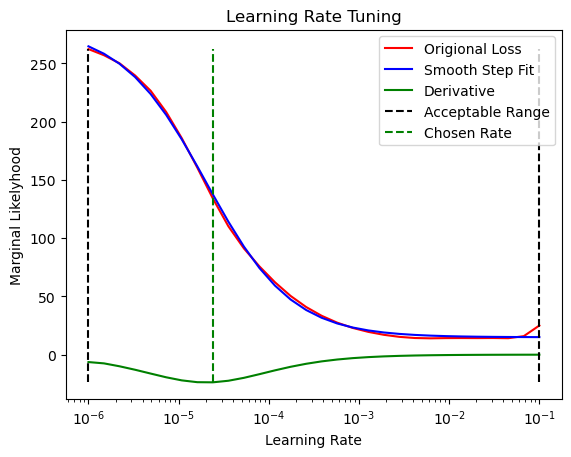


thresholds [1e-08]
#Learning Rate: 2.40e-05 #Step: 60 #Loss: 17.387186 #Relative Loss Difference: 8.06e-02 #Relative Peak Loss Difference: 6.30e-03 #Threshold: 1.00e-08 eeeeeeeeeeeeeeeeeeee

Fitted Params, Amp: tensor(37.8844, requires_grad=True) EXP_ER tensor(0.1941, requires_grad=True)
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8674)
The length-scale is, l: tensor(1.2632)
The experimental error is, EXP_ER: tensor(0.1641)


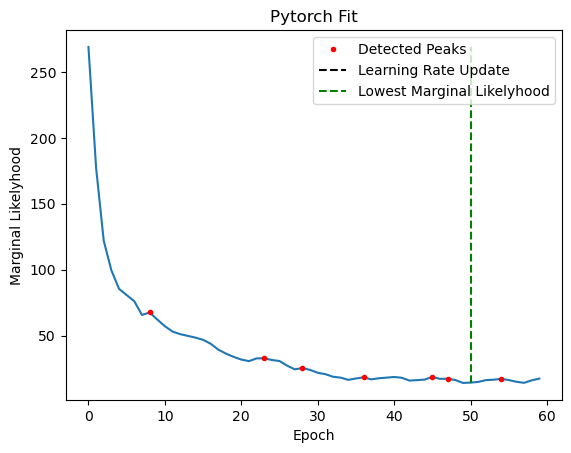

[tensor(37.8674), tensor(1.2632), tensor(0.1641)]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
For K a small addition of 1e-10 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


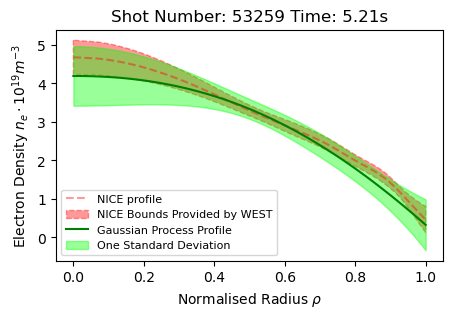

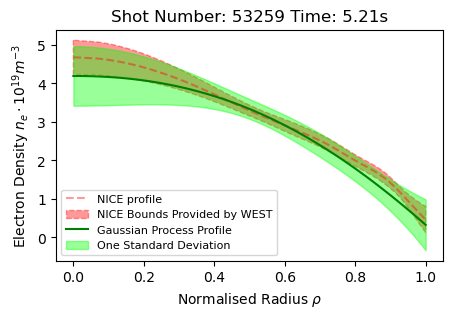

The fit timer measured the time taken in hh:mm:ss as, 0:00:17.734184


The Best Fit Was:
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8674)
The length-scale is, l: tensor(1.2632)
The experimental error is, EXP_ER: tensor(0.1641)


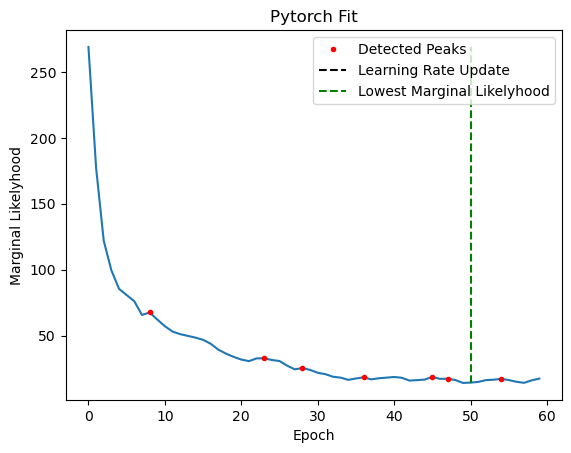

[tensor(37.8674), tensor(1.2632), tensor(0.1641)]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
For K a small addition of 1e-10 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


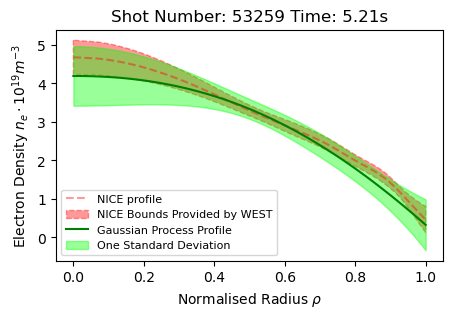

In [25]:
## the way I want it to work
ReSeed(1)
## the way it works
init_kargs = {'rho_test':rho_test, 'lid_d':lid_d, 'ne_d':ne_d,
              'ne_prime_d':ne_prime_d, 'lid_error':lid_error, 'ne_error':ne_error, 
              'ne_prime_error':ne_prime_error, 'Kernel':kernel,#[Kernel, KernelPrime, KernelPrimePrime], 
              'rho_test2':rho_test2, 'rho_test3':rho_test3,
              'initial_params':initial_params, 'prior_mu':'non-informative', 'PYTORCH_DEGREE':1,
              'INC_EXTRA_INFO':inc_extra_info,
              'OPTIMIZE_EXP_ER':True, 'reset':True}

interf = ForwardGPR(**init_kargs)

# interf.SciPyFit(method='basinhopping', NUM_RANDOM_SEARCHES=3)
# interf.SciPyFit(NUM_RANDOM_SEARCHES=1)

# 6th september it was set to use a fixed experimental error, not the parameter updated one.
interf.TorchFit(optim = torch.optim.SGD, optim_params={'lr':1e-3}, kernel_params='random_search',
            MAX_NUM_STEPS_EPOCHS = 60, OPTIMIZE_LR = True, LR_UPDATE_INTERVAL=300,
            NUM_RANDOM_SEARCHES=1, CONVERGE_STOP=True, 
            STOCHASTIC = True, STOCHASTIC_STD=0.01, 
            ENFORCE_BOUNDS=False,
            CONVERGENCE_THRESHOLDS=[1e-8])


Initial Random Kernel Params, Amp: tensor(37.8816) EXP_ER tensor(0.2612)
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8816)
The length-scale is, l: tensor(0.2794)
The experimental error is, EXP_ER: tensor(0.2612)
Optimising the Learning Rate


Optimising Learning Rate: Marginal LikelyHood is, 24.994436: 100%|█| 30/30 [00:0


[29]
0


<Figure size 640x480 with 0 Axes>

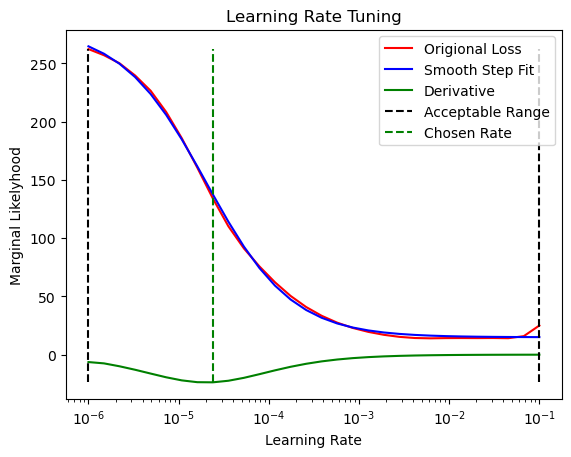


thresholds [1e-08]
#Learning Rate: 2.40e-05 #Step: 60 #Loss: 31.629286 #Relative Loss Difference: 2.09e-02 #Relative Peak Loss Difference: 6.47e-02 #Threshold: 1.00e-08 eeeeeeeeeeeeeeeeeeee

Fitted Params, Amp: tensor(37.8607, requires_grad=True) EXP_ER tensor(0.2881, requires_grad=True)
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8419)
The length-scale is, l: tensor(1.2099)
The experimental error is, EXP_ER: tensor(0.2791)


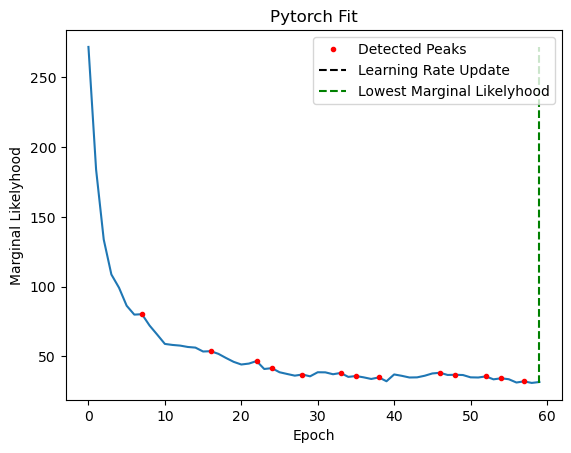

[tensor(37.8419), tensor(1.2099), tensor(0.2791)]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.0001 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.001 to the diagonal.
For K a small addition of 0.01 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


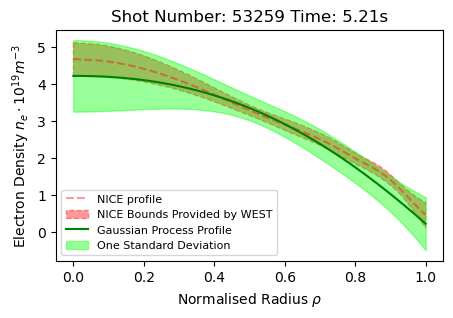

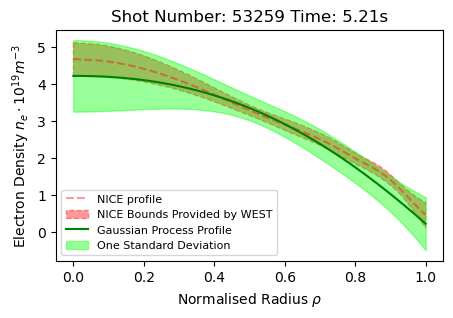

The fit timer measured the time taken in hh:mm:ss as, 0:00:17.231840


The Best Fit Was:
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: tensor(37.8419)
The length-scale is, l: tensor(1.2099)
The experimental error is, EXP_ER: tensor(0.2791)


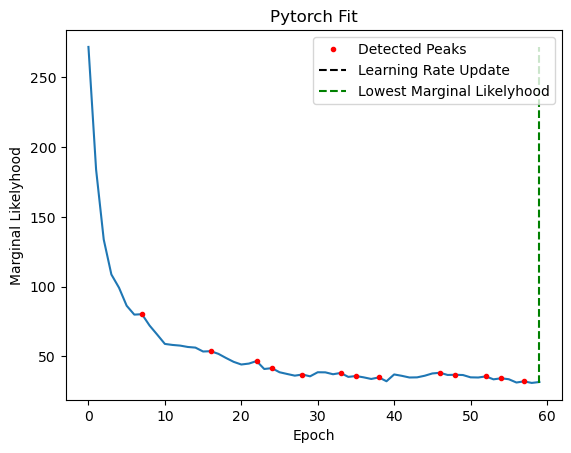

[tensor(37.8419), tensor(1.2099), tensor(0.2791)]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.0001 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.001 to the diagonal.
For K a small addition of 0.01 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


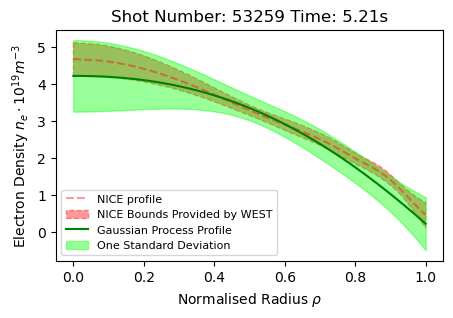

Performing SciPy fitting using method: minimize

Random Initial Params, Amp: 36.734222 EXP_ER 0.41994345
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 36.734222
The length-scale is, l: 0.029378628
The experimental error is, EXP_ER: 0.41994345


FIT RESULTS
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.332870911621342e-20
        x: [ 1.370e+01  8.802e-01  3.078e-02]
      nit: 10
      jac: [ 5.329e-10  2.494e-07  2.867e-05]
     nfev: 292
     njev: 73
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
Fitted Params, Amp: 13.699926692618353
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 13.699926692618353
The length-scale is, l: 0.8802174920035684
The experimental error is, EXP_ER: 0.030779259261677825
[13.69992669  0.88021749  0.03077926]
<class 'numpy.ndarray'>
Non positive definate matrix for K even with a smal

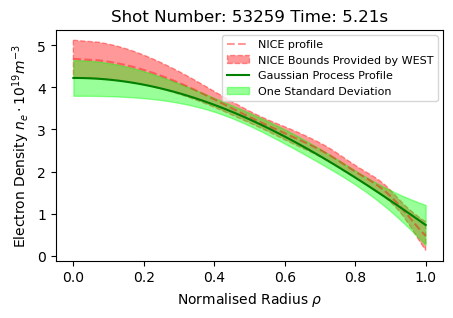

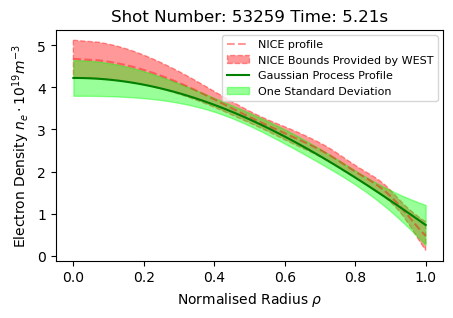



Best of all initial params


Random Initial Params, Amp: 36.734222
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 36.734222
The length-scale is, l: 0.029378628
The experimental error is, EXP_ER: 0.41994345


Fitted Params, Amp: 13.699926692618353
Plotting Length Scale. This is the static case and so length-scale is constant.
The amplitude is, Amp: 13.699926692618353
The length-scale is, l: 0.8802174920035684
The experimental error is, EXP_ER: 0.030779259261677825
[13.69992669  0.88021749  0.03077926]
<class 'numpy.ndarray'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
For K a small addition of 1e-10 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


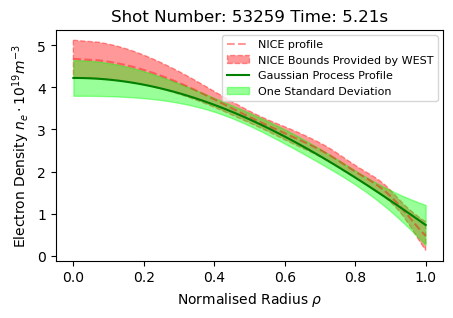

[37.84192657470703, 1.2099120616912842, 0.27909690141677856]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
For K a small addition of 1e-10 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


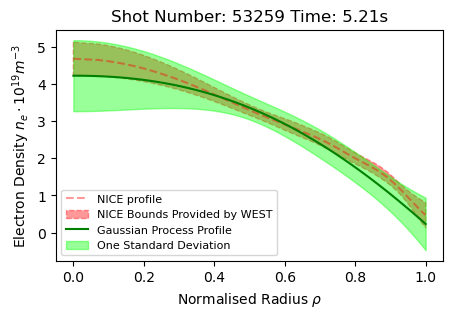

In [23]:
ReSeed(1)
## the way it works
init_kargs = {'rho_test':rho_test, 'lid_d':lid_d, 'ne_d':ne_d,
              'ne_prime_d':ne_prime_d, 'lid_error':lid_error, 'ne_error':ne_error, 
              'ne_prime_error':ne_prime_error, 'Kernel':kernel,#[Kernel, KernelPrime, KernelPrimePrime], 
              'rho_test2':rho_test2, 'rho_test3':rho_test3,
              'initial_params':initial_params, 'prior_mu':'non-informative', 'PYTORCH_DEGREE':2,
              'INC_EXTRA_INFO':inc_extra_info,
              'OPTIMIZE_EXP_ER':True, 'reset':True}

interf = ForwardGPR(**init_kargs)

# interf.SciPyFit(method='basinhopping', NUM_RANDOM_SEARCHES=3)
# interf.SciPyFit(NUM_RANDOM_SEARCHES=1)

# 6th september it was set to use a fixed experimental error, not the parameter updated one.
interf.TorchFit(optim = torch.optim.SGD, optim_params={'lr':1e-3}, kernel_params='random_search',
            MAX_NUM_STEPS_EPOCHS = 60, OPTIMIZE_LR = True, LR_UPDATE_INTERVAL=300,
            NUM_RANDOM_SEARCHES=1, CONVERGE_STOP=True, 
            STOCHASTIC = True, STOCHASTIC_STD=0.01, 
            ENFORCE_BOUNDS=False,
            CONVERGENCE_THRESHOLDS=[1e-8])

tbp = [p.item() for p in interf.torch_best_params]

init_kargs['PYTORCH_DEGREE'] = 0
interf = ForwardGPR(**init_kargs)

interf.SciPyFit(NUM_RANDOM_SEARCHES=1)

interf.Infer(tbp)

[37.915950775146484, 1.2410454750061035, 0.22926636040210724]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.0001 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.001 to the diagonal.
For K a small addition of 0.01 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


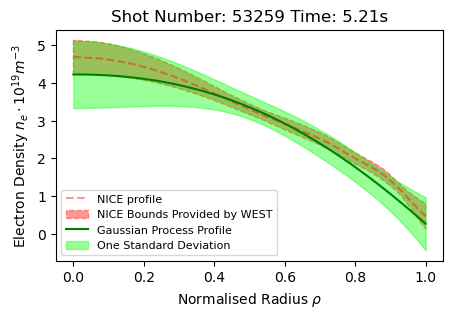

In [17]:
self = interf
def Infer(params):
        print(params)
        print(type(params))
        if interf.pytorch_degree==1:
            init_kargs_cp = init_kargs.copy()
            init_kargs['PYTORCH_DEGREE']=0
            init_kargs['reset']=False
            interf.__init__(**init_kargs)
            params = [p.numpy() for p in params]
            K, R, cov_li = interf.KRcov_li(params)
            interf.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li, name='Likelihood Covariance') @ R + self.chol_inv(K, name='K'))
            interf.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li, name='Likelyhood Covariance') @ (self.data - R @ self.prior_mu)            
            interf.marge_li = self.MargeLi(params)
            interf.PlotInference()
            init_kargs['PYTORCH_DEGREE']=1
            init_kargs['reset']=False
            interf.__init__(**init_kargs)
            
        else: 
            K, R, cov_li = self.KRcov_li(params)
            self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li, name='Likelihood Covariance') @ R + self.chol_inv(K, name='K'))
            self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li, name='Likelyhood Covariance') @ (self.data - R @ self.prior_mu)            
            self.PlotInference()
# interf.pytorch_degree=1

tbp = [p.item() for p in interf.torch_best_params]
tbp

Infer(tbp)

[37.9511, 1.2152, 0.2598]
<class 'list'>
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.0001 to the diagonal.
For K a small addition of 0.001 to the diagonal was needed to ensure it was positive devinate and its lower cholesky is not singular.


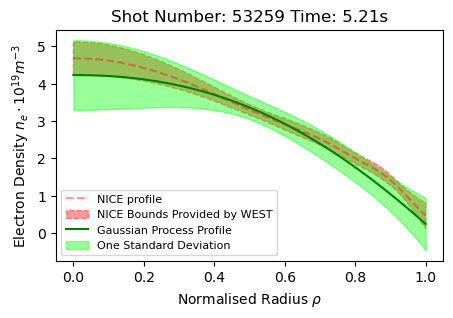

In [20]:
interf.Infer([37.9511,1.2152, 0.2598])

In [22]:
tensor(37.8509)
The length-scale is, l: tensor(1.2909)

a = [1,2,3]
b = [i+1 for i in a]
b
# import seaborn as sn
# interf.PlotGrid([45,110,0])
# sn.heatmap(interf.marginal_likelyhood_grid,cmap='viridis',cbar_kws={'label':'ML'},square=True)

[2, 3, 4]

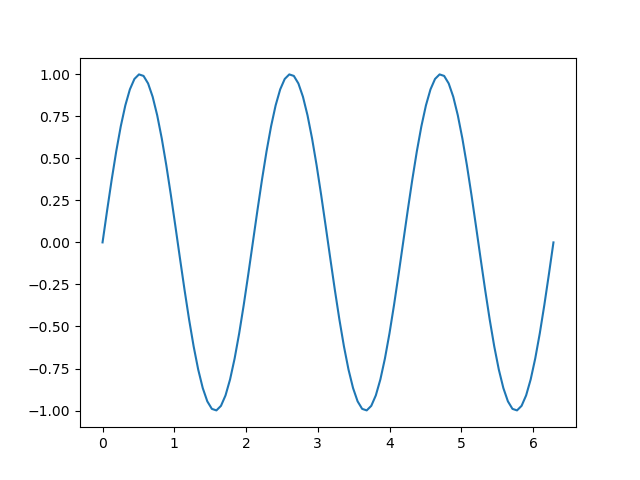

In [3]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)
plt.show()

#### Notes
Basin hopping works better than minamize, suggesting lots of local minema. 

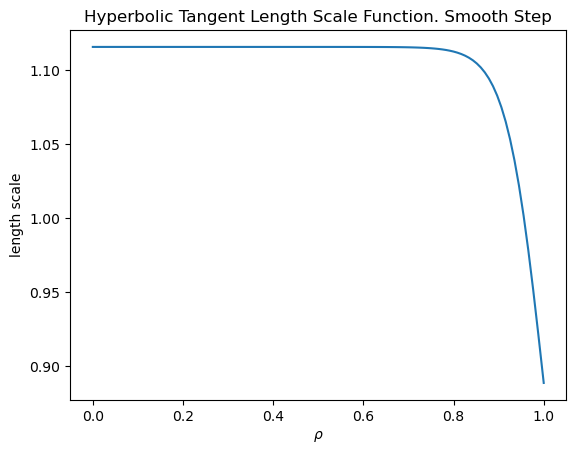

tensor([1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154,
        1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1154, 1.1153, 1.1153,
        1.1153, 1.1153, 1.1152, 1.1152, 1.1151, 1.1151, 1.1150, 1.1149, 1.1148,
        1.1147, 1.1145, 1.1143, 1.1141, 1.1137, 1.1134, 1.1129, 1.1123, 1.1116,
        1.1107, 1.1095, 1.1082, 1.1064, 1.1043, 1.1016, 1.0983, 1.0941, 1.0890,
        1.0826, 1.0747, 1.0651, 1.0532, 1.0389, 1.0219, 1.0017, 0.9783, 0.9518,
        0.9223, 0.8889])

In [12]:
# HyperTan_l(torch.from_numpy(rho_1d), interf.initial_params, plot=True, tensor=True)
HyperTan_l(torch.from_numpy(rho_1d), interf.torch_best_params, plot=True, tensor=True)

[19.8478, tensor(1.1154), tensor(0.6781), tensor(0.9971), tensor(0.0799), tensor(0.3099)]
Non positive definate matrix for K even with a small addition of 0 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-10 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-09 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-08 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-07 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-06 to the diagonal.
Non positive definate matrix for K even with a small addition of 1e-05 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.0001 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.001 to the diagonal.
Non positive definate matrix for K even with a small addition of 0.01 to the diagonal.
For K a small addition of 0.1 to t

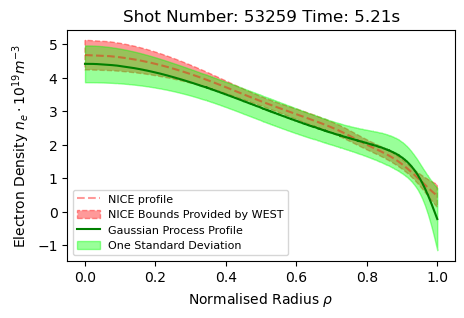

AttributeError: 'ForwardGPR' object has no attribute 'torch_fit_params'

In [25]:
fiddle_params = interf.torch_best_params.copy()
fiddle_params[0] = 40
print(interf.torch_best_params)
interf.Infer(fiddle_params)#interf.torch_best_params)
interf.PlotInference()
print('Amplitude:',interf.torch_fit_params[0])

# Forward GPR including edge and gradient info numpy and scypi.optimise

In [15]:
#altering to include artificial data for gradient and edge rather than this information being placed in the prior
class ForwardGPR(object):
    def __init__(self, rho_test, lid_d, ne_d, ne_prime_d, lid_error, ne_error, ne_prime_error, Kernel, 
                 rho_test2=None, rho_test3=None,
                 initial_params=None, prior_mu='non-informative'):
        
        if type(Kernel)==type([]) and type(rho_test2) != type(None) and type(rho_test3) != type(None):
            self.inc_extra_info = True
        
        if self.inc_extra_info:
            self.lid_d = lid_d
            self.ne_d = ne_d
            self.ne_prime_d = ne_prime_d
            self.data = np.block([lid_d,ne_d,ne_prime_d])
        else: 
            self.data = lid_d
        
        self.rho_test = rho_test
        self.N = len(rho_test)
        self.rho_test2 = rho_test2
        self.N2 = len(rho_test2)
        self.rho_test3 = rho_test3
        self.N3 = len(rho_test3)
        
        
        self.M = len(lid_d)
        self.A = len(ne_d)
        self.B = len(ne_prime_d)
        
        self.initial_params = initial_params
        if prior_mu == 'non-informative':
            self.prior_mu = np.zeros(self.N+self.N2+self.N3)
        else: self.prior_mu = prior_mu
        self.lid_error = lid_error
        self.ne_error = ne_error
        self.ne_prime_error = ne_prime_error
        
        self.post_mu = None
        self.post_cov = None
        self.best_params=None
        self.best_marge_li = None
        self.marge_li = None
        self.torch_descent = {}
        
        if type(Kernel) == type([]):
            self.Kernel, self.KernelPrime, self.KernelPrimePrime = Kernel
        else: self.Kernel = Kernel
        
        
    def chol_inv(self, A):
        if torch.is_tensor(A):
            L = torch.cholsky(A)
            return torch.inverse(L).T @ torch.inverse(L)
        else:
            L = np.linalg.cholesky(A)
            return np.linalg.inv(L).T @ np.linalg.inv(L)
    def chol_det(self, A):
        if torch.is_tensor(A):
            L = torch.cholsky(A)
            return torch.prod(torch.diag(L))
        else:
            L = np.linalg.cholesky(A)
            return np.prod(np.diag(L))

    def KRcov_li(self, params):
        
        #covergence matrix of Prior
        if self.inc_extra_info:
            K11 = self.Kernel(self.rho_test, self.rho_test, params)
            print('K11', K11.shape)
            K12 = self.Kernel(self.rho_test2, self.rho_test, params)
            print('K12', K12.shape)
            K13 = self.KernelPrime(self.rho_test3, self.rho_test, params)
            print('K13', K13.shape)
            K22 = self.Kernel(self.rho_test2, self.rho_test2, params)            
            K23 = self.KernelPrime(self.rho_test3, self.rho_test2, params)
            K33 = self.KernelPrimePrime(self.rho_test3, self.rho_test3, params)
            
            K = np.block([[K11, K12, K13],
                          [K12.T, K22, K23],
                          [-K13.T, -K23.T, K33]])
        else: K = Kernel(self.rho_test, params)
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        K[np.diag_indices_from(K)] += 1e-8
        #cov_li is covergence matrix of Likelyhood
        
        if self.inc_extra_info:
            R = np.block([[compute_response_matrix(geo, equi, self.rho_test), np.zeros((self.M,self.A+self.B))],
                         [np.zeros((self.A+self.B, self.N)), np.diag(np.ones(self.A+self.B))]])
            cov_li = np.diag(np.block([self.lid_error, self.ne_error, self.ne_prime_error])) # M is number of channels
        else:
            R = compute_response_matrix(geo, equi, self.rho_test)
            cov_li = np.diag(np.block([self.lid_error])) # M is number of channels
        
        return K, R, cov_li

    def MargeLi(self, params):
        K, R, cov_li = self.KRcov_li(params)
        invertable = cov_li + R @ K @ R.T
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        invertable[np.diag_indices_from(invertable)] += 1e-8
        if np.isinf(invertable).any() or np.isnan(invertable).any():
            print('matrix has an inf or nan with causes issues for square root, reurning inf for marginal likelihood')
            return float('inf')
        elif np.any(np.linalg.eigvals(invertable) <= 0):
            print('Matrix is not positive definate, returning inf for marginal likelyhood')
            return float('inf')
        else:
            marge_li = (0.5*np.log(self.chol_det(invertable)) + 0.5*(self.data.T@self.chol_inv(invertable)@self.data))
            return marge_li
    
    def Fit(self, method=None):        
        if method=='basinhopping':
            results = basinhopping(self.MargeLi, x0=initial_params, niter=100)
            print("\n\nFIT RESULTS\n",results)
            self.best_params = results.x
            self.best_marge_li = self.MargeLi(self.best_params)
        else: 
            results = minimize(self.MargeLi, x0=initial_params)
            print("\n\nFIT RESULTS\n",results)
            self.best_params = results.x
            self.best_marge_li = self.MargeLi(self.best_params)
    
    def Infer(self, params):
                             
        K, R, cov_li = self.KRcov_li(params)
#         try:
        self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li) @ R + self.chol_inv(K))
        if self.inc_extra_info: data = np.block([self.lid_d, self.ne_d, self.ne_prime_d])
        else: data = lid_d
        self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li) @ (data - R @ self.prior_mu)
#         except np.linalg.LinAlgError:
#             print('Inference Failed Non positive definate matrix encountered')
            
        self.marge_li = self.MargeLi(params)
                             
#         print('\n\nNot good if zero, as need to be chol_inverted.')
#         print('The Determinent of K is:', self.chol_det(K))
#         print('The Determinent of cov_li is:', self.chol_det(cov_li))
#         print('The Determinent of cov_post3 is:', self.chol_det(self.post_cov))
                             
        
    def PlotInference(self):
        if self.inc_extra_info:
            post_mu = self.post_mu[:self.N]
            std = np.sqrt(np.diagonal(self.post_cov))[:self.N]
        else:
            post_mu = self.post_mu
            std = np.sqrt(np.diagonal(self.post_cov))

        figGPR3 = plt.figure(figsize=(5,3))
        plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')
        plt.plot(rho_1d, nice,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
        plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
        plt.plot(rho_test, post_mu,'g', label='Gaussian Process Profile')
        plt.fill_between(rho_test, post_mu-std, post_mu+std, color=(0,1,0,0.4),linestyle='-',label='One Standard Deviation')
        plt.legend(fontsize = 8)
        plt.show()

lid_error = np.repeat(EXP_ER, interf_M)
N=1000#101
rho_test=np.linspace(0,1,N)

#setting edge info                             
N2 = 3
rho_test2 = np.linspace(0.99, 1, N2)
ne_d = np.zeros(N2)
ne_error = np.repeat(1,N2)
#setting gradient info           
N3 = 3
rho_test3 = np.linspace(0,0.01,N3)
ne_prime_d = np.zeros(N3)   
ne_prime_error = np.repeat(0.1,N3)

interf = ForwardGPR(rho_test, lid_d, ne_d, ne_prime_d, lid_error, ne_error, ne_prime_error, 
                    [Kernel, KernelPrime, KernelPrimePrime], 
                    rho_test2, rho_test3,
                    initial_params, prior_mu='non-informative')
    
# interf.Fit(method='torch')
# interf.Fit()
# interf.Infer(interf.best_params)
interf.Infer(interf.initial_params)
interf.PlotInference()

TypeError: Kernel() missing 1 required positional argument: 'tensor'

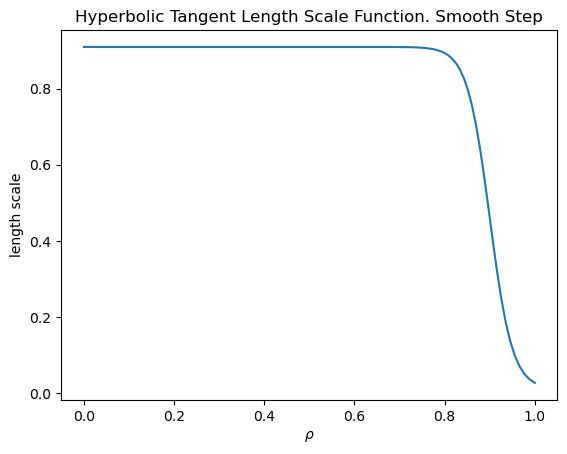

array([0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.91      , 0.91      , 0.91      ,
       0.91      , 0.91      , 0.90999999, 0.90999999, 0.90999999,
       0.90999998, 0.90999998, 0.90999997, 0.90999996, 0.90999994,
       0.90999992, 0.90999989, 0.90999985, 0.90999979, 0.90999972,
       0.90999961, 0.90999948, 0.90999929, 0.90999904, 0.9099987 ,
       0.90999823, 0.9099976 , 0.90999675, 0.90999559, 0.90999402,
       0.90999189, 0.90998898, 0.90998504, 0.90997966, 0.90997235,
       0.90996237, 0.90994873, 0.90993007, 0.9099046 , 0.90986976,
       0.90982207, 0.9097564 , 0.9096662 , 0.90954216, 0.90937108,
       0.90913437, 0.9088078 , 0.90835677, 0.90773246, 0.90686

In [72]:
HyperTan_l(rho_1d, interf.initial_params, plot=True)

In [10]:
a = np.array([[1,2,3,4,5],[1,2,3,4,5]])
a

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])

# Putting prior gradient and edge information in the prior
This mostly worked but it was difficult to alter the prior strength only on the gradient and edge information without making a non positive definate matrix. The amount of certinty on this information needs to be controlled seperatly to the others. 

This is why I have opted to use the artifical observations method for the final choice. 

In [17]:
#altering to include artificial data for gradient and edge rather than this information being placed in the prior

#Being adapted to include edge and gradient information
class ForwardGPR(object):
    def __init__(self, rho_test, lid_d, lid_error, Kernel, initial_params, prior_mu, 
                 rho_test2=None, rho_test3=None, ne_amp=None, ne_prime_amp=None):
        self.rho_test = rho_test
        self.N = len(rho_test)
        self.rho_test2 = rho_test2
        self.N2 = len(rho_test2)
        self.rho_test3 = rho_test3
        self.N3 = len(rho_test3)
        
        
        self.ne_amp = ne_amp
        self.ne_prime_amp = ne_prime_amp
        
        self.lid_d = lid_d
        self.M = len(lid_d)
        self.initial_params = initial_params
        self.prior_mu = prior_mu
        self.lid_error = lid_error
        
        self.post_mu = None
        self.post_cov = None
        self.best_params=None
        self.best_marge_li = None
        self.marge_li = None
        
        if type(Kernel) == type([]):
            self.Kernel, self.KernelPrime, self.KernelPrimePrime = Kernel
        else: self.Kernel = Kernel
        
        if type(Kernel)==type([]) and type(rho_test2) != type(None) and type(rho_test3) != type(None):
            self.inc_extra_info = True
        
        
        
    def chol_inv(self, A):
        L = np.linalg.cholesky(A)
        return np.linalg.inv(L).T @ np.linalg.inv(L)
    def chol_det(self, A):
        L = np.linalg.cholesky(A)
        return np.prod(np.diag(L))

    def KRcov_li(self, params):
        #covergence matrix of Prior
        if self.inc_extra_info:
            K11 = self.Kernel(self.rho_test, self.rho_test, params, tensor=False)
            K12 = self.Kernel(self.rho_test2, self.rho_test, params, tensor=False)
            K13 = self.KernelPrime(self.rho_test3, self.rho_test, params, tensor=False)
            K22 = self.Kernel(self.rho_test2, self.rho_test2, params, tensor=False)
#             K22[np.diag_indices_from(K22)] = self.ne_amp
            
            K23 = self.KernelPrime(self.rho_test3, self.rho_test2, params, tensor=False)
            K33 = self.KernelPrimePrime(self.rho_test3, self.rho_test3, params, tensor=False)
#             K33[np.diag_indices_from(K33)] = self.ne_prime_amp
            #adding in learned amplitude since static 6 removes it from kernel
#             K11[np.diag_indices_from(K11)] += params[0]
#             #adding in set amplidue of edge prior information
#             K22[np.diag_indices_from(K22)] += 0.1
#             #adding in set amplidue of edge prior information
#             K33[np.diag_indices_from(K33)] += 0.1
            K = np.block([[K11, K12, K13],
                          [K12.T, K22, K23],
                          [-K13.T, -K23.T, K33]])
            K[np.diag_indices_from(K)] += params[0]
        else: 
            K = Kernel(self.rho_test, params, tensor=False)
            K[np.diag_indices_from(K)] += params[0]
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        K[np.diag_indices_from(K)] += 1e-8 
        #covergence matrix of Likelyhood
        cov_li = np.diag(self.lid_error) # M is number of channels
        if self.inc_extra_info:
            R = np.block([compute_response_matrix(geo, equi, self.rho_test), np.zeros((self.M,self.N2+self.N3))])
        else: R = compute_response_matrix(geo, equi, self.rho_test)
        return K, R, cov_li

    def MargeLi(self, params):
        K, R, cov_li = self.KRcov_li(params)
        invertable = cov_li + R @ K @ R.T
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        invertable[np.diag_indices_from(invertable)] += 1e-8
        if np.isinf(invertable).any() or np.isnan(invertable).any():
            print('matrix has an inf or nan with causes issues for square root, reurning inf for marginal likelihood')
            return float('inf')
        elif np.any(np.linalg.eigvals(invertable) <= 0):
            print('Matrix is not positive definate, returning inf for marginal likelyhood')
            return float('inf')
        marge_li = (0.5*np.log(self.chol_det(invertable)) + 0.5*(lid_data.T@self.chol_inv(invertable)@lid_data))
        return marge_li
    
    def Fit(self, method=None):
        if method=='basinhopping':
            results = basinhopping(self.MargeLi, x0=initial_params, niter=100)
        else: results = minimize(self.MargeLi, x0=initial_params)
        print("\n\nFIT RESULTS\n",results)
        self.best_params = results.x
        self.best_marge_li = self.MargeLi(self.best_params)
    
    def Infer(self, params):
        K, R, cov_li = self.KRcov_li(params)
#         try:
        self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li) @ R + self.chol_inv(K))
        self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li) @ (self.lid_d - R @ self.prior_mu)
        print(self.post_cov)
        print(self.post_mu)
#         except np.linalg.LinAlgError:
#             print('Inference Failed Non positive definate matrix encountered')
            
        self.marge_li = self.MargeLi(params)
#         print('\n\nNot good if zero, as need to be chol_inverted.')
#         print('The Determinent of K is:', self.chol_det(K))
#         print('The Determinent of cov_li is:', self.chol_det(cov_li))
#         print('The Determinent of cov_post3 is:', self.chol_det(self.post_cov))
        
    def PlotInference(self):
        if self.inc_extra_info:
            post_mu = self.post_mu[:self.N]
            std = np.sqrt(np.diagonal(self.post_cov))[:self.N]
        else:
            post_mu = self.post_mu
            std = np.sqrt(np.diagonal(self.post_cov))

        figGPR3 = plt.figure(figsize=(5,3))
        plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^{-3}$')
        plt.plot(rho_1d, nice,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
        plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
        plt.plot(rho_test, post_mu,'g', label='Gaussian Process Profile')
        plt.fill_between(rho_test, post_mu-std, post_mu+std, color=(0,1,0,0.4),linestyle='-',label='One Standard Deviation')
        plt.legend(fontsize = 8)
        plt.show()

# def parabola(rho):
#     return 4.9*(1-rho**2)
# prior_mu = np.zeros(N)#parabola(rho_test)#np.zeros(N)#dens_prof.dens_1d#
#exponential square kernel

#prior info on electron density
N=1000#101
rho_test=np.linspace(0,1,N)
prior_mu1 = np.zeros(N)
#0 at edge information
N2 = 3
rho_test2 = np.linspace(0.9, 1, N2)
prior_mu2 = np.zeros(N2)
ne_amp = np.repeat(0.1,N2)
#0 gradient at core information
N3 = 3
rho_test3 = np.linspace(0,0.1,N3)
prior_mu3 = np.zeros(N3)
ne_prime_amp = np.repeat(0.1,N2)    
                         
prior_mu=np.block([prior_mu1, prior_mu2, prior_mu3])

lid_error = np.repeat(EXP_ER, interf_M)
    
interf = ForwardGPR(rho_test, lid_d, lid_error, [Kernel, KernelPrime, KernelPrimePrime],
                    initial_params, prior_mu,
                    rho_test2, rho_test3, ne_amp, ne_prime_amp)
    
# interf.Fit(method='basinhopping')
interf.Fit()
interf.Infer(interf.best_params)
# interf.Infer(interf.initial_params)
interf.PlotInference()

Matrix is not positive definate, returning inf for marginal likelyhood
Matrix is not positive definate, returning inf for marginal likelyhood


/home/daniel/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Matrix is not positive definate, returning inf for marginal likelyhood
Matrix is not positive definate, returning inf for marginal likelyhood
Matrix is not positive definate, returning inf for marginal likelyhood
Matrix is not positive definate, returning inf for marginal likelyhood
Matrix is not positive definate, returning inf for marginal likelyhood


FIT RESULTS
   message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.142316434917376
        x: [-3.594e+00  5.665e-01  5.000e-01]
      nit: 23
      jac: [ 1.967e-05  1.848e-05  0.000e+00]
 hess_inv: [[ 1.720e-02 -1.904e-02  0.000e+00]
            [-1.904e-02  2.130e-02  0.000e+00]
            [ 0.000e+00  0.000e+00  1.000e+00]]
     nfev: 220
     njev: 51


LinAlgError: Matrix is not positive definite

In [17]:
array([5.38330053, 1.13736137])
a = [1,2,3]
b = [9,10, 2]

c,d = np.meshgrid(a,b)

e = d - c
e[np.diag_indices_from(e)] = [7,7,7]
# K[np.diag_indices_from(K)] 
e

array([[7, 7, 6],
       [9, 7, 7],
       [1, 0, 7]])

array([[28.52141685, 28.47069825, 28.41916341, ..., 18.01563194,
        17.69278278, 17.35936548],
       [28.47069825, 28.52141685, 28.51244055, ..., 19.14889123,
        18.83358395, 18.50666937],
       [28.41916341, 28.51244055, 28.52141685, ..., 19.61972967,
        19.30836026, 18.98499597],
       ...,
       [18.01563194, 19.14889123, 19.61972967, ..., 28.52141685,
        28.51699567, 28.50317385],
       [17.69278278, 18.83358395, 19.30836026, ..., 28.51699567,
        28.52141685, 28.51668477],
       [17.35936548, 18.50666937, 18.98499597, ..., 28.50317385,
        28.51668477, 28.52141685]])

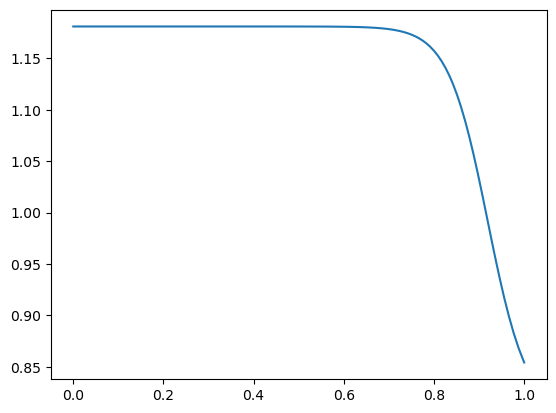

In [32]:
Kernel(rho_1d,interf.best_params, plot=True)

# Full pipeline, Forward GPR with Vanilla GRP to add edge and gradient information then optimising the initial kernel parameters

In [13]:

def FullPipeMargeLi(params, plot=False):
    N=1000
    rho_test=np.linspace(0,1,N)
    prior_mu=np.zeros(N)
    interf = ForwardGPR(rho_test=rho_test, lid_d=lid_d, lid_error=np.repeat(EXP_ER,interf_M), Kernel=Kernel, 
                        initial_params=params, prior_mu=prior_mu)
    interf.Infer(params)
    prior_cov = interf.post_cov
    prior_mu = interf.post_mu
    artif_M = 10
    artif_obvs = InformativeGradientVanillaGPR(x_test=rho_test, xd=np.linspace(0.99,1,artif_M), yd=np.zeros(artif_M),
                    yd_noise=np.repeat(0.1,artif_M), prior_mu=prior_mu, prior_cov=prior_cov,
                    xd_prime=np.linspace(0,0.01,artif_M), yd_prime=np.zeros(artif_M), yd_prime_noise=np.repeat(0.1,artif_M))
    artif_obvs.Infer()
    
    if plot: 
        artif_obvs.PlotInference()
    if interf.marge_li == None or artif_obvs.marge_li == None:
        print("Interferometry MargeLi",interf.marge_li)
        print("Artificilal Observations MargeLi",artif_obvs.marge_li)
        print("None detected, returning inf")
        return float('inf')
    marge_li_combi = interf.marge_li * artif_obvs.marge_li
    return marge_li_combi

# results = basinhopping(FullPipeMargeLi, x0=initial_params, niter=100)
results = minimize(FullPipeMargeLi, x0=initial_params)
print("\n\nFIT RESULTS\n",results)
best_params = results.x

FullPipeMargeLi(best_params, plot=True)




Inference Failed Non positive definate matrix encountered
Matrix is not positive definate, returning inf for marginal likelyhood


ValueError: There are 2 point arrays, but values has 0 dimensions

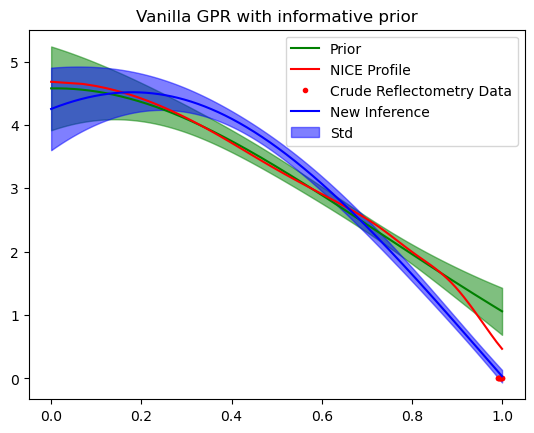

array([[4.023073  , 4.00816919, 3.99303161, ..., 1.87664608, 1.84173924,
        1.80364971],
       [4.00816919, 4.023073  , 4.02042676, ..., 2.0840352 , 2.04811497,
        2.00882784],
       [3.99303161, 4.02042676, 4.023073  , ..., 2.17291046, 2.13669915,
        2.09705309],
       ...,
       [1.87664608, 2.0840352 , 2.17291046, ..., 4.023073  , 4.02263741,
        4.02115515],
       [1.84173924, 2.04811497, 2.13669915, ..., 4.02263741, 4.023073  ,
        4.02254735],
       [1.80364971, 2.00882784, 2.09705309, ..., 4.02115515, 4.02254735,
        4.023073  ]])

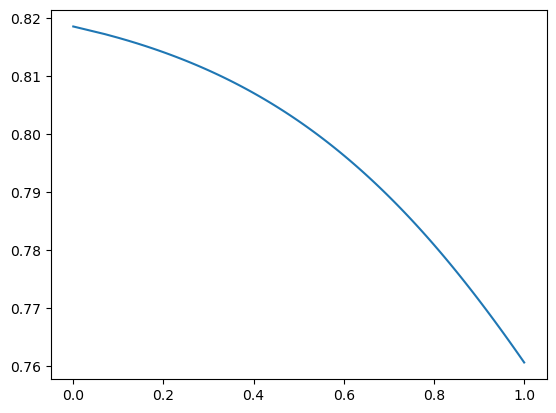

In [37]:
optuna_params = [9.975671089784278, 0.5862463896359733, 0.9993539382340135, 0.2600275757810972, 0.75722961]
FullPipeMargeLi(optuna_params, plot=True)
Kernel(rho_1d,results.x, plot=True)

In [35]:
# import optuna
# import sys

# # Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# study_name = "FullPipeHyperbolicLengthScale"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize')


# def objective(trial):
#     amp = trial.suggest_float('amp', 0, 10)
    
#     core_l = trial.suggest_float('core_l', 0, 5)
#     edge_l = trial.suggest_float('edge_l', 0, 1)
#     transition_center = trial.suggest_float('transition_center', 0, 1)
#     transition_width = trial.suggest_float('transition_center', 0, 1)
#     params = [amp, core_l, edge_l, transition_center, transition_width]
#     return FullPipeMargeLi(params)
    
# # study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# study.best_params

[I 2023-08-20 14:41:11,718] A new study created in RDB with name: FullPipeHyperbolicLengthScale


A new study created in RDB with name: FullPipeHyperbolicLengthScale
A new study created in RDB with name: FullPipeHyperbolicLengthScale


[I 2023-08-20 14:41:13,793] Trial 0 finished with value: -46.244626387773124 and parameters: {'amp': 5.177854027775352, 'core_l': 1.584508506232446, 'edge_l': 0.4295975564601644, 'transition_center': 0.36739442680044}. Best is trial 0 with value: -46.244626387773124.


Trial 0 finished with value: -46.244626387773124 and parameters: {'amp': 5.177854027775352, 'core_l': 1.584508506232446, 'edge_l': 0.4295975564601644, 'transition_center': 0.36739442680044}. Best is trial 0 with value: -46.244626387773124.
Trial 0 finished with value: -46.244626387773124 and parameters: {'amp': 5.177854027775352, 'core_l': 1.584508506232446, 'edge_l': 0.4295975564601644, 'transition_center': 0.36739442680044}. Best is trial 0 with value: -46.244626387773124.


[I 2023-08-20 14:41:15,646] Trial 1 finished with value: -39.90546925153885 and parameters: {'amp': 1.5635905906843262, 'core_l': 4.151371803482603, 'edge_l': 0.09788064863158996, 'transition_center': 0.8137105213756586}. Best is trial 0 with value: -46.244626387773124.


Trial 1 finished with value: -39.90546925153885 and parameters: {'amp': 1.5635905906843262, 'core_l': 4.151371803482603, 'edge_l': 0.09788064863158996, 'transition_center': 0.8137105213756586}. Best is trial 0 with value: -46.244626387773124.
Trial 1 finished with value: -39.90546925153885 and parameters: {'amp': 1.5635905906843262, 'core_l': 4.151371803482603, 'edge_l': 0.09788064863158996, 'transition_center': 0.8137105213756586}. Best is trial 0 with value: -46.244626387773124.


[I 2023-08-20 14:41:18,017] Trial 2 finished with value: -46.98240506789966 and parameters: {'amp': 5.696153791495991, 'core_l': 1.205964861751498, 'edge_l': 0.5183302722159732, 'transition_center': 0.6490939857181638}. Best is trial 2 with value: -46.98240506789966.


Trial 2 finished with value: -46.98240506789966 and parameters: {'amp': 5.696153791495991, 'core_l': 1.205964861751498, 'edge_l': 0.5183302722159732, 'transition_center': 0.6490939857181638}. Best is trial 2 with value: -46.98240506789966.
Trial 2 finished with value: -46.98240506789966 and parameters: {'amp': 5.696153791495991, 'core_l': 1.205964861751498, 'edge_l': 0.5183302722159732, 'transition_center': 0.6490939857181638}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:19,798] Trial 3 finished with value: -45.443080726959394 and parameters: {'amp': 2.723362627785555, 'core_l': 1.277438470352343, 'edge_l': 0.44201613786012484, 'transition_center': 0.7868601511202902}. Best is trial 2 with value: -46.98240506789966.


Trial 3 finished with value: -45.443080726959394 and parameters: {'amp': 2.723362627785555, 'core_l': 1.277438470352343, 'edge_l': 0.44201613786012484, 'transition_center': 0.7868601511202902}. Best is trial 2 with value: -46.98240506789966.
Trial 3 finished with value: -45.443080726959394 and parameters: {'amp': 2.723362627785555, 'core_l': 1.277438470352343, 'edge_l': 0.44201613786012484, 'transition_center': 0.7868601511202902}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:21,539] Trial 4 finished with value: -46.80591771996564 and parameters: {'amp': 5.536658555324481, 'core_l': 1.4585805192511332, 'edge_l': 0.8661434643632169, 'transition_center': 0.6524622732302495}. Best is trial 2 with value: -46.98240506789966.


Trial 4 finished with value: -46.80591771996564 and parameters: {'amp': 5.536658555324481, 'core_l': 1.4585805192511332, 'edge_l': 0.8661434643632169, 'transition_center': 0.6524622732302495}. Best is trial 2 with value: -46.98240506789966.
Trial 4 finished with value: -46.80591771996564 and parameters: {'amp': 5.536658555324481, 'core_l': 1.4585805192511332, 'edge_l': 0.8661434643632169, 'transition_center': 0.6524622732302495}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:23,296] Trial 5 finished with value: -43.30221151930348 and parameters: {'amp': 5.421755063539443, 'core_l': 4.307657662855336, 'edge_l': 0.8713522913292389, 'transition_center': 0.9861381359452631}. Best is trial 2 with value: -46.98240506789966.


Trial 5 finished with value: -43.30221151930348 and parameters: {'amp': 5.421755063539443, 'core_l': 4.307657662855336, 'edge_l': 0.8713522913292389, 'transition_center': 0.9861381359452631}. Best is trial 2 with value: -46.98240506789966.
Trial 5 finished with value: -43.30221151930348 and parameters: {'amp': 5.421755063539443, 'core_l': 4.307657662855336, 'edge_l': 0.8713522913292389, 'transition_center': 0.9861381359452631}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:25,027] Trial 6 finished with value: -46.1164952517681 and parameters: {'amp': 4.134566181299864, 'core_l': 3.8603645384977687, 'edge_l': 0.9598502726849358, 'transition_center': 0.336642756263942}. Best is trial 2 with value: -46.98240506789966.


Trial 6 finished with value: -46.1164952517681 and parameters: {'amp': 4.134566181299864, 'core_l': 3.8603645384977687, 'edge_l': 0.9598502726849358, 'transition_center': 0.336642756263942}. Best is trial 2 with value: -46.98240506789966.
Trial 6 finished with value: -46.1164952517681 and parameters: {'amp': 4.134566181299864, 'core_l': 3.8603645384977687, 'edge_l': 0.9598502726849358, 'transition_center': 0.336642756263942}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:26,973] Trial 7 finished with value: -46.84890960331683 and parameters: {'amp': 4.772202902504477, 'core_l': 0.835275979370515, 'edge_l': 0.6414842012973998, 'transition_center': 0.1927937964288664}. Best is trial 2 with value: -46.98240506789966.


Trial 7 finished with value: -46.84890960331683 and parameters: {'amp': 4.772202902504477, 'core_l': 0.835275979370515, 'edge_l': 0.6414842012973998, 'transition_center': 0.1927937964288664}. Best is trial 2 with value: -46.98240506789966.
Trial 7 finished with value: -46.84890960331683 and parameters: {'amp': 4.772202902504477, 'core_l': 0.835275979370515, 'edge_l': 0.6414842012973998, 'transition_center': 0.1927937964288664}. Best is trial 2 with value: -46.98240506789966.


[I 2023-08-20 14:41:29,712] Trial 8 finished with value: -47.33146772528686 and parameters: {'amp': 8.036569221330174, 'core_l': 4.072190765357702, 'edge_l': 0.7605477775010079, 'transition_center': 0.02466576206783888}. Best is trial 8 with value: -47.33146772528686.


Trial 8 finished with value: -47.33146772528686 and parameters: {'amp': 8.036569221330174, 'core_l': 4.072190765357702, 'edge_l': 0.7605477775010079, 'transition_center': 0.02466576206783888}. Best is trial 8 with value: -47.33146772528686.
Trial 8 finished with value: -47.33146772528686 and parameters: {'amp': 8.036569221330174, 'core_l': 4.072190765357702, 'edge_l': 0.7605477775010079, 'transition_center': 0.02466576206783888}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:31,506] Trial 9 finished with value: -27.1212372694766 and parameters: {'amp': 5.661885909231162, 'core_l': 2.3087213793310637, 'edge_l': 0.015185134567788805, 'transition_center': 0.07264193560114085}. Best is trial 8 with value: -47.33146772528686.


Trial 9 finished with value: -27.1212372694766 and parameters: {'amp': 5.661885909231162, 'core_l': 2.3087213793310637, 'edge_l': 0.015185134567788805, 'transition_center': 0.07264193560114085}. Best is trial 8 with value: -47.33146772528686.
Trial 9 finished with value: -27.1212372694766 and parameters: {'amp': 5.661885909231162, 'core_l': 2.3087213793310637, 'edge_l': 0.015185134567788805, 'transition_center': 0.07264193560114085}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:33,612] Trial 10 finished with value: -47.2288668648263 and parameters: {'amp': 8.367433660198557, 'core_l': 4.992469900247947, 'edge_l': 0.7409552186901891, 'transition_center': 0.015512185090807762}. Best is trial 8 with value: -47.33146772528686.


Trial 10 finished with value: -47.2288668648263 and parameters: {'amp': 8.367433660198557, 'core_l': 4.992469900247947, 'edge_l': 0.7409552186901891, 'transition_center': 0.015512185090807762}. Best is trial 8 with value: -47.33146772528686.
Trial 10 finished with value: -47.2288668648263 and parameters: {'amp': 8.367433660198557, 'core_l': 4.992469900247947, 'edge_l': 0.7409552186901891, 'transition_center': 0.015512185090807762}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:36,747] Trial 11 finished with value: -43.62629474914477 and parameters: {'amp': 8.82202233199568, 'core_l': 4.785459229445533, 'edge_l': 0.6989343450361525, 'transition_center': 0.003751059581530103}. Best is trial 8 with value: -47.33146772528686.


Trial 11 finished with value: -43.62629474914477 and parameters: {'amp': 8.82202233199568, 'core_l': 4.785459229445533, 'edge_l': 0.6989343450361525, 'transition_center': 0.003751059581530103}. Best is trial 8 with value: -47.33146772528686.
Trial 11 finished with value: -43.62629474914477 and parameters: {'amp': 8.82202233199568, 'core_l': 4.785459229445533, 'edge_l': 0.6989343450361525, 'transition_center': 0.003751059581530103}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:39,345] Trial 12 finished with value: -46.73326551668522 and parameters: {'amp': 9.124539327689003, 'core_l': 3.4102089870167323, 'edge_l': 0.7418018072472377, 'transition_center': 0.15345890164469128}. Best is trial 8 with value: -47.33146772528686.


Trial 12 finished with value: -46.73326551668522 and parameters: {'amp': 9.124539327689003, 'core_l': 3.4102089870167323, 'edge_l': 0.7418018072472377, 'transition_center': 0.15345890164469128}. Best is trial 8 with value: -47.33146772528686.
Trial 12 finished with value: -46.73326551668522 and parameters: {'amp': 9.124539327689003, 'core_l': 3.4102089870167323, 'edge_l': 0.7418018072472377, 'transition_center': 0.15345890164469128}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:41,319] Trial 13 finished with value: -46.53700295118617 and parameters: {'amp': 7.619820318020284, 'core_l': 4.77656478803007, 'edge_l': 0.9985746905813196, 'transition_center': 0.007740970243051261}. Best is trial 8 with value: -47.33146772528686.


Trial 13 finished with value: -46.53700295118617 and parameters: {'amp': 7.619820318020284, 'core_l': 4.77656478803007, 'edge_l': 0.9985746905813196, 'transition_center': 0.007740970243051261}. Best is trial 8 with value: -47.33146772528686.
Trial 13 finished with value: -46.53700295118617 and parameters: {'amp': 7.619820318020284, 'core_l': 4.77656478803007, 'edge_l': 0.9985746905813196, 'transition_center': 0.007740970243051261}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:43,164] Trial 14 finished with value: -46.519191543373 and parameters: {'amp': 9.806450766232857, 'core_l': 4.983300592424015, 'edge_l': 0.7974828233299646, 'transition_center': 0.23333510952697015}. Best is trial 8 with value: -47.33146772528686.


Trial 14 finished with value: -46.519191543373 and parameters: {'amp': 9.806450766232857, 'core_l': 4.983300592424015, 'edge_l': 0.7974828233299646, 'transition_center': 0.23333510952697015}. Best is trial 8 with value: -47.33146772528686.
Trial 14 finished with value: -46.519191543373 and parameters: {'amp': 9.806450766232857, 'core_l': 4.983300592424015, 'edge_l': 0.7974828233299646, 'transition_center': 0.23333510952697015}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:44,964] Trial 15 finished with value: -46.65449246090971 and parameters: {'amp': 7.458586224046895, 'core_l': 3.2434282707980318, 'edge_l': 0.617798408626788, 'transition_center': 0.10377994895132245}. Best is trial 8 with value: -47.33146772528686.


Trial 15 finished with value: -46.65449246090971 and parameters: {'amp': 7.458586224046895, 'core_l': 3.2434282707980318, 'edge_l': 0.617798408626788, 'transition_center': 0.10377994895132245}. Best is trial 8 with value: -47.33146772528686.
Trial 15 finished with value: -46.65449246090971 and parameters: {'amp': 7.458586224046895, 'core_l': 3.2434282707980318, 'edge_l': 0.617798408626788, 'transition_center': 0.10377994895132245}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:46,784] Trial 16 finished with value: -47.1613316914338 and parameters: {'amp': 7.625161425182332, 'core_l': 0.04172789631780427, 'edge_l': 0.8458645942275205, 'transition_center': 0.28541757299276516}. Best is trial 8 with value: -47.33146772528686.


Trial 16 finished with value: -47.1613316914338 and parameters: {'amp': 7.625161425182332, 'core_l': 0.04172789631780427, 'edge_l': 0.8458645942275205, 'transition_center': 0.28541757299276516}. Best is trial 8 with value: -47.33146772528686.
Trial 16 finished with value: -47.1613316914338 and parameters: {'amp': 7.625161425182332, 'core_l': 0.04172789631780427, 'edge_l': 0.8458645942275205, 'transition_center': 0.28541757299276516}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:49,524] Trial 17 finished with value: -46.85629322193161 and parameters: {'amp': 9.908552076897116, 'core_l': 3.625364508200389, 'edge_l': 0.5775373031142635, 'transition_center': 0.4472236452927857}. Best is trial 8 with value: -47.33146772528686.


Trial 17 finished with value: -46.85629322193161 and parameters: {'amp': 9.908552076897116, 'core_l': 3.625364508200389, 'edge_l': 0.5775373031142635, 'transition_center': 0.4472236452927857}. Best is trial 8 with value: -47.33146772528686.
Trial 17 finished with value: -46.85629322193161 and parameters: {'amp': 9.908552076897116, 'core_l': 3.625364508200389, 'edge_l': 0.5775373031142635, 'transition_center': 0.4472236452927857}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:52,001] Trial 18 finished with value: -46.52906327085552 and parameters: {'amp': 6.562116113876334, 'core_l': 2.904020568469734, 'edge_l': 0.7286739022563156, 'transition_center': 0.17064907723120748}. Best is trial 8 with value: -47.33146772528686.


Trial 18 finished with value: -46.52906327085552 and parameters: {'amp': 6.562116113876334, 'core_l': 2.904020568469734, 'edge_l': 0.7286739022563156, 'transition_center': 0.17064907723120748}. Best is trial 8 with value: -47.33146772528686.
Trial 18 finished with value: -46.52906327085552 and parameters: {'amp': 6.562116113876334, 'core_l': 2.904020568469734, 'edge_l': 0.7286739022563156, 'transition_center': 0.17064907723120748}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:54,137] Trial 19 finished with value: -46.81486013470165 and parameters: {'amp': 8.331145723754712, 'core_l': 4.349813000944146, 'edge_l': 0.7616834613919365, 'transition_center': 0.09822867854018943}. Best is trial 8 with value: -47.33146772528686.


Trial 19 finished with value: -46.81486013470165 and parameters: {'amp': 8.331145723754712, 'core_l': 4.349813000944146, 'edge_l': 0.7616834613919365, 'transition_center': 0.09822867854018943}. Best is trial 8 with value: -47.33146772528686.
Trial 19 finished with value: -46.81486013470165 and parameters: {'amp': 8.331145723754712, 'core_l': 4.349813000944146, 'edge_l': 0.7616834613919365, 'transition_center': 0.09822867854018943}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:55,941] Trial 20 finished with value: -46.43932408421948 and parameters: {'amp': 6.963652055741987, 'core_l': 3.997716580996525, 'edge_l': 0.9240290817455263, 'transition_center': 0.23083902172694898}. Best is trial 8 with value: -47.33146772528686.


Trial 20 finished with value: -46.43932408421948 and parameters: {'amp': 6.963652055741987, 'core_l': 3.997716580996525, 'edge_l': 0.9240290817455263, 'transition_center': 0.23083902172694898}. Best is trial 8 with value: -47.33146772528686.
Trial 20 finished with value: -46.43932408421948 and parameters: {'amp': 6.963652055741987, 'core_l': 3.997716580996525, 'edge_l': 0.9240290817455263, 'transition_center': 0.23083902172694898}. Best is trial 8 with value: -47.33146772528686.


[I 2023-08-20 14:41:57,757] Trial 21 finished with value: -47.59412913123479 and parameters: {'amp': 8.108217860704794, 'core_l': 0.33707599542318123, 'edge_l': 0.8537425890005416, 'transition_center': 0.3202183973722829}. Best is trial 21 with value: -47.59412913123479.


Trial 21 finished with value: -47.59412913123479 and parameters: {'amp': 8.108217860704794, 'core_l': 0.33707599542318123, 'edge_l': 0.8537425890005416, 'transition_center': 0.3202183973722829}. Best is trial 21 with value: -47.59412913123479.
Trial 21 finished with value: -47.59412913123479 and parameters: {'amp': 8.108217860704794, 'core_l': 0.33707599542318123, 'edge_l': 0.8537425890005416, 'transition_center': 0.3202183973722829}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:41:59,550] Trial 22 finished with value: -47.47028372605688 and parameters: {'amp': 8.76114438568302, 'core_l': 2.492052525453514, 'edge_l': 0.8023248062210171, 'transition_center': 0.030222135355168645}. Best is trial 21 with value: -47.59412913123479.


Trial 22 finished with value: -47.47028372605688 and parameters: {'amp': 8.76114438568302, 'core_l': 2.492052525453514, 'edge_l': 0.8023248062210171, 'transition_center': 0.030222135355168645}. Best is trial 21 with value: -47.59412913123479.
Trial 22 finished with value: -47.47028372605688 and parameters: {'amp': 8.76114438568302, 'core_l': 2.492052525453514, 'edge_l': 0.8023248062210171, 'transition_center': 0.030222135355168645}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:01,656] Trial 23 finished with value: -47.15537973149813 and parameters: {'amp': 9.045080818744996, 'core_l': 2.330965824161887, 'edge_l': 0.9087871876532775, 'transition_center': 0.12537339227286137}. Best is trial 21 with value: -47.59412913123479.


Trial 23 finished with value: -47.15537973149813 and parameters: {'amp': 9.045080818744996, 'core_l': 2.330965824161887, 'edge_l': 0.9087871876532775, 'transition_center': 0.12537339227286137}. Best is trial 21 with value: -47.59412913123479.
Trial 23 finished with value: -47.15537973149813 and parameters: {'amp': 9.045080818744996, 'core_l': 2.330965824161887, 'edge_l': 0.9087871876532775, 'transition_center': 0.12537339227286137}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:03,811] Trial 24 finished with value: -46.96713095903905 and parameters: {'amp': 8.181115919850336, 'core_l': 2.9549280151662938, 'edge_l': 0.8053213196236866, 'transition_center': 0.42468177693023046}. Best is trial 21 with value: -47.59412913123479.


Trial 24 finished with value: -46.96713095903905 and parameters: {'amp': 8.181115919850336, 'core_l': 2.9549280151662938, 'edge_l': 0.8053213196236866, 'transition_center': 0.42468177693023046}. Best is trial 21 with value: -47.59412913123479.
Trial 24 finished with value: -46.96713095903905 and parameters: {'amp': 8.181115919850336, 'core_l': 2.9549280151662938, 'edge_l': 0.8053213196236866, 'transition_center': 0.42468177693023046}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:05,742] Trial 25 finished with value: -46.678872506189634 and parameters: {'amp': 6.764575061756583, 'core_l': 2.1099986244276137, 'edge_l': 0.9946512335479856, 'transition_center': 0.29065350169401577}. Best is trial 21 with value: -47.59412913123479.


Trial 25 finished with value: -46.678872506189634 and parameters: {'amp': 6.764575061756583, 'core_l': 2.1099986244276137, 'edge_l': 0.9946512335479856, 'transition_center': 0.29065350169401577}. Best is trial 21 with value: -47.59412913123479.
Trial 25 finished with value: -46.678872506189634 and parameters: {'amp': 6.764575061756583, 'core_l': 2.1099986244276137, 'edge_l': 0.9946512335479856, 'transition_center': 0.29065350169401577}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:07,549] Trial 26 finished with value: -46.82373202798366 and parameters: {'amp': 9.363399790341106, 'core_l': 2.696121974800828, 'edge_l': 0.8358057827276464, 'transition_center': 0.21372923995518017}. Best is trial 21 with value: -47.59412913123479.


Trial 26 finished with value: -46.82373202798366 and parameters: {'amp': 9.363399790341106, 'core_l': 2.696121974800828, 'edge_l': 0.8358057827276464, 'transition_center': 0.21372923995518017}. Best is trial 21 with value: -47.59412913123479.
Trial 26 finished with value: -46.82373202798366 and parameters: {'amp': 9.363399790341106, 'core_l': 2.696121974800828, 'edge_l': 0.8358057827276464, 'transition_center': 0.21372923995518017}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:09,782] Trial 27 finished with value: -47.41503043567522 and parameters: {'amp': 8.475683854473973, 'core_l': 1.8816509717724177, 'edge_l': 0.9107877827905521, 'transition_center': 0.07675190366579906}. Best is trial 21 with value: -47.59412913123479.


Trial 27 finished with value: -47.41503043567522 and parameters: {'amp': 8.475683854473973, 'core_l': 1.8816509717724177, 'edge_l': 0.9107877827905521, 'transition_center': 0.07675190366579906}. Best is trial 21 with value: -47.59412913123479.
Trial 27 finished with value: -47.41503043567522 and parameters: {'amp': 8.475683854473973, 'core_l': 1.8816509717724177, 'edge_l': 0.9107877827905521, 'transition_center': 0.07675190366579906}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:11,568] Trial 28 finished with value: -47.40713736119451 and parameters: {'amp': 8.687114417789767, 'core_l': 1.9241738311986991, 'edge_l': 0.9254420643566363, 'transition_center': 0.08196144174808839}. Best is trial 21 with value: -47.59412913123479.


Trial 28 finished with value: -47.40713736119451 and parameters: {'amp': 8.687114417789767, 'core_l': 1.9241738311986991, 'edge_l': 0.9254420643566363, 'transition_center': 0.08196144174808839}. Best is trial 21 with value: -47.59412913123479.
Trial 28 finished with value: -47.40713736119451 and parameters: {'amp': 8.687114417789767, 'core_l': 1.9241738311986991, 'edge_l': 0.9254420643566363, 'transition_center': 0.08196144174808839}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:13,347] Trial 29 finished with value: -47.10107787048622 and parameters: {'amp': 9.759276144295786, 'core_l': 1.8098309493707947, 'edge_l': 0.8498988998189319, 'transition_center': 0.3431241850523189}. Best is trial 21 with value: -47.59412913123479.


Trial 29 finished with value: -47.10107787048622 and parameters: {'amp': 9.759276144295786, 'core_l': 1.8098309493707947, 'edge_l': 0.8498988998189319, 'transition_center': 0.3431241850523189}. Best is trial 21 with value: -47.59412913123479.
Trial 29 finished with value: -47.10107787048622 and parameters: {'amp': 9.759276144295786, 'core_l': 1.8098309493707947, 'edge_l': 0.8498988998189319, 'transition_center': 0.3431241850523189}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:15,135] Trial 30 finished with value: -46.61742821841233 and parameters: {'amp': 6.376571254194112, 'core_l': 2.4695658682894455, 'edge_l': 0.676287981858023, 'transition_center': 0.15027804251516128}. Best is trial 21 with value: -47.59412913123479.


Trial 30 finished with value: -46.61742821841233 and parameters: {'amp': 6.376571254194112, 'core_l': 2.4695658682894455, 'edge_l': 0.676287981858023, 'transition_center': 0.15027804251516128}. Best is trial 21 with value: -47.59412913123479.
Trial 30 finished with value: -46.61742821841233 and parameters: {'amp': 6.376571254194112, 'core_l': 2.4695658682894455, 'edge_l': 0.676287981858023, 'transition_center': 0.15027804251516128}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:16,959] Trial 31 finished with value: -47.42967093101401 and parameters: {'amp': 8.656875048441082, 'core_l': 1.920469792774043, 'edge_l': 0.9243606424844494, 'transition_center': 0.07579072903126564}. Best is trial 21 with value: -47.59412913123479.


Trial 31 finished with value: -47.42967093101401 and parameters: {'amp': 8.656875048441082, 'core_l': 1.920469792774043, 'edge_l': 0.9243606424844494, 'transition_center': 0.07579072903126564}. Best is trial 21 with value: -47.59412913123479.
Trial 31 finished with value: -47.42967093101401 and parameters: {'amp': 8.656875048441082, 'core_l': 1.920469792774043, 'edge_l': 0.9243606424844494, 'transition_center': 0.07579072903126564}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:18,783] Trial 32 finished with value: -47.37177864144696 and parameters: {'amp': 8.58479797764588, 'core_l': 1.8557941756673995, 'edge_l': 0.9305971827868991, 'transition_center': 0.0940350078404989}. Best is trial 21 with value: -47.59412913123479.


Trial 32 finished with value: -47.37177864144696 and parameters: {'amp': 8.58479797764588, 'core_l': 1.8557941756673995, 'edge_l': 0.9305971827868991, 'transition_center': 0.0940350078404989}. Best is trial 21 with value: -47.59412913123479.
Trial 32 finished with value: -47.37177864144696 and parameters: {'amp': 8.58479797764588, 'core_l': 1.8557941756673995, 'edge_l': 0.9305971827868991, 'transition_center': 0.0940350078404989}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:20,606] Trial 33 finished with value: -47.531349450986326 and parameters: {'amp': 7.3007229873314765, 'core_l': 0.832544754795866, 'edge_l': 0.8863751735610925, 'transition_center': 0.05514268532911469}. Best is trial 21 with value: -47.59412913123479.


Trial 33 finished with value: -47.531349450986326 and parameters: {'amp': 7.3007229873314765, 'core_l': 0.832544754795866, 'edge_l': 0.8863751735610925, 'transition_center': 0.05514268532911469}. Best is trial 21 with value: -47.59412913123479.
Trial 33 finished with value: -47.531349450986326 and parameters: {'amp': 7.3007229873314765, 'core_l': 0.832544754795866, 'edge_l': 0.8863751735610925, 'transition_center': 0.05514268532911469}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:22,378] Trial 34 finished with value: -47.444354798284515 and parameters: {'amp': 7.2257987622762485, 'core_l': 0.8549187528487534, 'edge_l': 0.8071546535772538, 'transition_center': 0.27118720311805206}. Best is trial 21 with value: -47.59412913123479.


Trial 34 finished with value: -47.444354798284515 and parameters: {'amp': 7.2257987622762485, 'core_l': 0.8549187528487534, 'edge_l': 0.8071546535772538, 'transition_center': 0.27118720311805206}. Best is trial 21 with value: -47.59412913123479.
Trial 34 finished with value: -47.444354798284515 and parameters: {'amp': 7.2257987622762485, 'core_l': 0.8549187528487534, 'edge_l': 0.8071546535772538, 'transition_center': 0.27118720311805206}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:24,162] Trial 35 finished with value: -47.39317086980408 and parameters: {'amp': 7.376865395327183, 'core_l': 0.9491102370098812, 'edge_l': 0.8132897277718638, 'transition_center': 0.27794164053686005}. Best is trial 21 with value: -47.59412913123479.


Trial 35 finished with value: -47.39317086980408 and parameters: {'amp': 7.376865395327183, 'core_l': 0.9491102370098812, 'edge_l': 0.8132897277718638, 'transition_center': 0.27794164053686005}. Best is trial 21 with value: -47.59412913123479.
Trial 35 finished with value: -47.39317086980408 and parameters: {'amp': 7.376865395327183, 'core_l': 0.9491102370098812, 'edge_l': 0.8132897277718638, 'transition_center': 0.27794164053686005}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:26,066] Trial 36 finished with value: -46.877341383124396 and parameters: {'amp': 7.069877680722033, 'core_l': 0.5082491796856077, 'edge_l': 0.5312674242283646, 'transition_center': 0.37583416756660515}. Best is trial 21 with value: -47.59412913123479.


Trial 36 finished with value: -46.877341383124396 and parameters: {'amp': 7.069877680722033, 'core_l': 0.5082491796856077, 'edge_l': 0.5312674242283646, 'transition_center': 0.37583416756660515}. Best is trial 21 with value: -47.59412913123479.
Trial 36 finished with value: -46.877341383124396 and parameters: {'amp': 7.069877680722033, 'core_l': 0.5082491796856077, 'edge_l': 0.5312674242283646, 'transition_center': 0.37583416756660515}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:27,845] Trial 37 finished with value: -46.77328377809742 and parameters: {'amp': 6.4539657131472286, 'core_l': 1.4651531310811863, 'edge_l': 0.45702426291507015, 'transition_center': 0.5258667199656858}. Best is trial 21 with value: -47.59412913123479.


Trial 37 finished with value: -46.77328377809742 and parameters: {'amp': 6.4539657131472286, 'core_l': 1.4651531310811863, 'edge_l': 0.45702426291507015, 'transition_center': 0.5258667199656858}. Best is trial 21 with value: -47.59412913123479.
Trial 37 finished with value: -46.77328377809742 and parameters: {'amp': 6.4539657131472286, 'core_l': 1.4651531310811863, 'edge_l': 0.45702426291507015, 'transition_center': 0.5258667199656858}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:29,634] Trial 38 finished with value: -47.11756892592308 and parameters: {'amp': 7.858248433148084, 'core_l': 1.1956286672894931, 'edge_l': 0.6842480988377869, 'transition_center': 0.1942178684794023}. Best is trial 21 with value: -47.59412913123479.


Trial 38 finished with value: -47.11756892592308 and parameters: {'amp': 7.858248433148084, 'core_l': 1.1956286672894931, 'edge_l': 0.6842480988377869, 'transition_center': 0.1942178684794023}. Best is trial 21 with value: -47.59412913123479.
Trial 38 finished with value: -47.11756892592308 and parameters: {'amp': 7.858248433148084, 'core_l': 1.1956286672894931, 'edge_l': 0.6842480988377869, 'transition_center': 0.1942178684794023}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:31,404] Trial 39 finished with value: -45.74442021794408 and parameters: {'amp': 5.962218307919336, 'core_l': 0.4697556828535139, 'edge_l': 0.33485517170493434, 'transition_center': 0.15775064411016082}. Best is trial 21 with value: -47.59412913123479.


Trial 39 finished with value: -45.74442021794408 and parameters: {'amp': 5.962218307919336, 'core_l': 0.4697556828535139, 'edge_l': 0.33485517170493434, 'transition_center': 0.15775064411016082}. Best is trial 21 with value: -47.59412913123479.
Trial 39 finished with value: -45.74442021794408 and parameters: {'amp': 5.962218307919336, 'core_l': 0.4697556828535139, 'edge_l': 0.33485517170493434, 'transition_center': 0.15775064411016082}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:33,196] Trial 40 finished with value: -47.041274981819974 and parameters: {'amp': 7.207859030097704, 'core_l': 1.4756142554635159, 'edge_l': 0.879094412602677, 'transition_center': 0.25363987331377014}. Best is trial 21 with value: -47.59412913123479.


Trial 40 finished with value: -47.041274981819974 and parameters: {'amp': 7.207859030097704, 'core_l': 1.4756142554635159, 'edge_l': 0.879094412602677, 'transition_center': 0.25363987331377014}. Best is trial 21 with value: -47.59412913123479.
Trial 40 finished with value: -47.041274981819974 and parameters: {'amp': 7.207859030097704, 'core_l': 1.4756142554635159, 'edge_l': 0.879094412602677, 'transition_center': 0.25363987331377014}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:35,009] Trial 41 finished with value: -47.55713281968913 and parameters: {'amp': 7.8444743334900116, 'core_l': 1.1296891726851972, 'edge_l': 0.9583490733547997, 'transition_center': 0.06680001016916287}. Best is trial 21 with value: -47.59412913123479.


Trial 41 finished with value: -47.55713281968913 and parameters: {'amp': 7.8444743334900116, 'core_l': 1.1296891726851972, 'edge_l': 0.9583490733547997, 'transition_center': 0.06680001016916287}. Best is trial 21 with value: -47.59412913123479.
Trial 41 finished with value: -47.55713281968913 and parameters: {'amp': 7.8444743334900116, 'core_l': 1.1296891726851972, 'edge_l': 0.9583490733547997, 'transition_center': 0.06680001016916287}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:36,819] Trial 42 finished with value: -47.570559561138865 and parameters: {'amp': 7.831272046401093, 'core_l': 0.8999987516982881, 'edge_l': 0.8775543669116546, 'transition_center': 0.045825816110800166}. Best is trial 21 with value: -47.59412913123479.


Trial 42 finished with value: -47.570559561138865 and parameters: {'amp': 7.831272046401093, 'core_l': 0.8999987516982881, 'edge_l': 0.8775543669116546, 'transition_center': 0.045825816110800166}. Best is trial 21 with value: -47.59412913123479.
Trial 42 finished with value: -47.570559561138865 and parameters: {'amp': 7.831272046401093, 'core_l': 0.8999987516982881, 'edge_l': 0.8775543669116546, 'transition_center': 0.045825816110800166}. Best is trial 21 with value: -47.59412913123479.


[I 2023-08-20 14:42:38,629] Trial 43 finished with value: -47.60708996577189 and parameters: {'amp': 8.140055671902825, 'core_l': 1.2063966408771187, 'edge_l': 0.9671820133880039, 'transition_center': 0.02160711483764536}. Best is trial 43 with value: -47.60708996577189.


Trial 43 finished with value: -47.60708996577189 and parameters: {'amp': 8.140055671902825, 'core_l': 1.2063966408771187, 'edge_l': 0.9671820133880039, 'transition_center': 0.02160711483764536}. Best is trial 43 with value: -47.60708996577189.
Trial 43 finished with value: -47.60708996577189 and parameters: {'amp': 8.140055671902825, 'core_l': 1.2063966408771187, 'edge_l': 0.9671820133880039, 'transition_center': 0.02160711483764536}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:40,422] Trial 44 finished with value: -47.57648507810051 and parameters: {'amp': 7.865130354408632, 'core_l': 1.1216278709901941, 'edge_l': 0.967135493828906, 'transition_center': 0.04048526708977486}. Best is trial 43 with value: -47.60708996577189.


Trial 44 finished with value: -47.57648507810051 and parameters: {'amp': 7.865130354408632, 'core_l': 1.1216278709901941, 'edge_l': 0.967135493828906, 'transition_center': 0.04048526708977486}. Best is trial 43 with value: -47.60708996577189.
Trial 44 finished with value: -47.57648507810051 and parameters: {'amp': 7.865130354408632, 'core_l': 1.1216278709901941, 'edge_l': 0.967135493828906, 'transition_center': 0.04048526708977486}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:42,612] Trial 45 finished with value: -47.58157894004732 and parameters: {'amp': 8.048316276989965, 'core_l': 1.2005706528315, 'edge_l': 0.9687591737018718, 'transition_center': 0.04879252672422883}. Best is trial 43 with value: -47.60708996577189.


Trial 45 finished with value: -47.58157894004732 and parameters: {'amp': 8.048316276989965, 'core_l': 1.2005706528315, 'edge_l': 0.9687591737018718, 'transition_center': 0.04879252672422883}. Best is trial 43 with value: -47.60708996577189.
Trial 45 finished with value: -47.58157894004732 and parameters: {'amp': 8.048316276989965, 'core_l': 1.2005706528315, 'edge_l': 0.9687591737018718, 'transition_center': 0.04879252672422883}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:44,474] Trial 46 finished with value: -47.32160993964546 and parameters: {'amp': 7.9891512580924395, 'core_l': 1.641739741146727, 'edge_l': 0.983153617608117, 'transition_center': 0.005724589400176179}. Best is trial 43 with value: -47.60708996577189.


Trial 46 finished with value: -47.32160993964546 and parameters: {'amp': 7.9891512580924395, 'core_l': 1.641739741146727, 'edge_l': 0.983153617608117, 'transition_center': 0.005724589400176179}. Best is trial 43 with value: -47.60708996577189.
Trial 46 finished with value: -47.32160993964546 and parameters: {'amp': 7.9891512580924395, 'core_l': 1.641739741146727, 'edge_l': 0.983153617608117, 'transition_center': 0.005724589400176179}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:46,316] Trial 47 finished with value: -47.500111526518296 and parameters: {'amp': 9.14373854855776, 'core_l': 1.3720348154397684, 'edge_l': 0.9558380934272986, 'transition_center': 0.12899726728510738}. Best is trial 43 with value: -47.60708996577189.


Trial 47 finished with value: -47.500111526518296 and parameters: {'amp': 9.14373854855776, 'core_l': 1.3720348154397684, 'edge_l': 0.9558380934272986, 'transition_center': 0.12899726728510738}. Best is trial 43 with value: -47.60708996577189.
Trial 47 finished with value: -47.500111526518296 and parameters: {'amp': 9.14373854855776, 'core_l': 1.3720348154397684, 'edge_l': 0.9558380934272986, 'transition_center': 0.12899726728510738}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:49,344] Trial 48 finished with value: -47.604663781504826 and parameters: {'amp': 8.157958405734227, 'core_l': 0.6169795967345696, 'edge_l': 0.8692267210192748, 'transition_center': 0.0440919193661299}. Best is trial 43 with value: -47.60708996577189.


Trial 48 finished with value: -47.604663781504826 and parameters: {'amp': 8.157958405734227, 'core_l': 0.6169795967345696, 'edge_l': 0.8692267210192748, 'transition_center': 0.0440919193661299}. Best is trial 43 with value: -47.60708996577189.
Trial 48 finished with value: -47.604663781504826 and parameters: {'amp': 8.157958405734227, 'core_l': 0.6169795967345696, 'edge_l': 0.8692267210192748, 'transition_center': 0.0440919193661299}. Best is trial 43 with value: -47.60708996577189.


[I 2023-08-20 14:42:51,126] Trial 49 finished with value: -47.796067893933426 and parameters: {'amp': 8.175191720223298, 'core_l': 0.4419062803194074, 'edge_l': 0.9709051598050967, 'transition_center': 0.17951535021290982}. Best is trial 49 with value: -47.796067893933426.


Trial 49 finished with value: -47.796067893933426 and parameters: {'amp': 8.175191720223298, 'core_l': 0.4419062803194074, 'edge_l': 0.9709051598050967, 'transition_center': 0.17951535021290982}. Best is trial 49 with value: -47.796067893933426.
Trial 49 finished with value: -47.796067893933426 and parameters: {'amp': 8.175191720223298, 'core_l': 0.4419062803194074, 'edge_l': 0.9709051598050967, 'transition_center': 0.17951535021290982}. Best is trial 49 with value: -47.796067893933426.


[I 2023-08-20 14:42:53,007] Trial 50 finished with value: -47.55953999520225 and parameters: {'amp': 9.423201540568261, 'core_l': 0.04801451037699511, 'edge_l': 0.9987950382390465, 'transition_center': 0.13388094304829246}. Best is trial 49 with value: -47.796067893933426.


Trial 50 finished with value: -47.55953999520225 and parameters: {'amp': 9.423201540568261, 'core_l': 0.04801451037699511, 'edge_l': 0.9987950382390465, 'transition_center': 0.13388094304829246}. Best is trial 49 with value: -47.796067893933426.
Trial 50 finished with value: -47.55953999520225 and parameters: {'amp': 9.423201540568261, 'core_l': 0.04801451037699511, 'edge_l': 0.9987950382390465, 'transition_center': 0.13388094304829246}. Best is trial 49 with value: -47.796067893933426.


[I 2023-08-20 14:42:55,106] Trial 51 finished with value: -47.809899999305365 and parameters: {'amp': 8.151424340529514, 'core_l': 0.5572349403139594, 'edge_l': 0.9584049681748453, 'transition_center': 0.19007322482797623}. Best is trial 51 with value: -47.809899999305365.


Trial 51 finished with value: -47.809899999305365 and parameters: {'amp': 8.151424340529514, 'core_l': 0.5572349403139594, 'edge_l': 0.9584049681748453, 'transition_center': 0.19007322482797623}. Best is trial 51 with value: -47.809899999305365.
Trial 51 finished with value: -47.809899999305365 and parameters: {'amp': 8.151424340529514, 'core_l': 0.5572349403139594, 'edge_l': 0.9584049681748453, 'transition_center': 0.19007322482797623}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:42:59,534] Trial 52 finished with value: -47.747905158163256 and parameters: {'amp': 8.088966806980961, 'core_l': 0.5382365646405292, 'edge_l': 0.8862605803085744, 'transition_center': 0.1847200941662924}. Best is trial 51 with value: -47.809899999305365.


Trial 52 finished with value: -47.747905158163256 and parameters: {'amp': 8.088966806980961, 'core_l': 0.5382365646405292, 'edge_l': 0.8862605803085744, 'transition_center': 0.1847200941662924}. Best is trial 51 with value: -47.809899999305365.
Trial 52 finished with value: -47.747905158163256 and parameters: {'amp': 8.088966806980961, 'core_l': 0.5382365646405292, 'edge_l': 0.8862605803085744, 'transition_center': 0.1847200941662924}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:03,467] Trial 53 finished with value: -47.7766914135163 and parameters: {'amp': 9.00025908207252, 'core_l': 0.5464141083376655, 'edge_l': 0.8659439833599989, 'transition_center': 0.19167418345123682}. Best is trial 51 with value: -47.809899999305365.


Trial 53 finished with value: -47.7766914135163 and parameters: {'amp': 9.00025908207252, 'core_l': 0.5464141083376655, 'edge_l': 0.8659439833599989, 'transition_center': 0.19167418345123682}. Best is trial 51 with value: -47.809899999305365.
Trial 53 finished with value: -47.7766914135163 and parameters: {'amp': 9.00025908207252, 'core_l': 0.5464141083376655, 'edge_l': 0.8659439833599989, 'transition_center': 0.19167418345123682}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:05,772] Trial 54 finished with value: -47.77583573440616 and parameters: {'amp': 8.97324314872261, 'core_l': 0.6468768921153278, 'edge_l': 0.883577883867764, 'transition_center': 0.19472890172752833}. Best is trial 51 with value: -47.809899999305365.


Trial 54 finished with value: -47.77583573440616 and parameters: {'amp': 8.97324314872261, 'core_l': 0.6468768921153278, 'edge_l': 0.883577883867764, 'transition_center': 0.19472890172752833}. Best is trial 51 with value: -47.809899999305365.
Trial 54 finished with value: -47.77583573440616 and parameters: {'amp': 8.97324314872261, 'core_l': 0.6468768921153278, 'edge_l': 0.883577883867764, 'transition_center': 0.19472890172752833}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:08,117] Trial 55 finished with value: -47.79536316717759 and parameters: {'amp': 8.938154357349035, 'core_l': 0.30751811145458785, 'edge_l': 0.9479673408086867, 'transition_center': 0.18447181521816905}. Best is trial 51 with value: -47.809899999305365.


Trial 55 finished with value: -47.79536316717759 and parameters: {'amp': 8.938154357349035, 'core_l': 0.30751811145458785, 'edge_l': 0.9479673408086867, 'transition_center': 0.18447181521816905}. Best is trial 51 with value: -47.809899999305365.
Trial 55 finished with value: -47.79536316717759 and parameters: {'amp': 8.938154357349035, 'core_l': 0.30751811145458785, 'edge_l': 0.9479673408086867, 'transition_center': 0.18447181521816905}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:11,891] Trial 56 finished with value: -47.5955518166873 and parameters: {'amp': 9.437194993395146, 'core_l': 0.26940022675495096, 'edge_l': 0.7729851059901741, 'transition_center': 0.1879900241393791}. Best is trial 51 with value: -47.809899999305365.


Trial 56 finished with value: -47.5955518166873 and parameters: {'amp': 9.437194993395146, 'core_l': 0.26940022675495096, 'edge_l': 0.7729851059901741, 'transition_center': 0.1879900241393791}. Best is trial 51 with value: -47.809899999305365.
Trial 56 finished with value: -47.5955518166873 and parameters: {'amp': 9.437194993395146, 'core_l': 0.26940022675495096, 'edge_l': 0.7729851059901741, 'transition_center': 0.1879900241393791}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:14,290] Trial 57 finished with value: -47.79484538264687 and parameters: {'amp': 9.066848204899316, 'core_l': 0.6872349054097799, 'edge_l': 0.8944987015836462, 'transition_center': 0.23393113204787833}. Best is trial 51 with value: -47.809899999305365.


Trial 57 finished with value: -47.79484538264687 and parameters: {'amp': 9.066848204899316, 'core_l': 0.6872349054097799, 'edge_l': 0.8944987015836462, 'transition_center': 0.23393113204787833}. Best is trial 51 with value: -47.809899999305365.
Trial 57 finished with value: -47.79484538264687 and parameters: {'amp': 9.066848204899316, 'core_l': 0.6872349054097799, 'edge_l': 0.8944987015836462, 'transition_center': 0.23393113204787833}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:16,986] Trial 58 finished with value: -47.672622042158 and parameters: {'amp': 8.96020485244944, 'core_l': 0.24754869709658484, 'edge_l': 0.8379760396527988, 'transition_center': 0.2313805402398092}. Best is trial 51 with value: -47.809899999305365.


Trial 58 finished with value: -47.672622042158 and parameters: {'amp': 8.96020485244944, 'core_l': 0.24754869709658484, 'edge_l': 0.8379760396527988, 'transition_center': 0.2313805402398092}. Best is trial 51 with value: -47.809899999305365.
Trial 58 finished with value: -47.672622042158 and parameters: {'amp': 8.96020485244944, 'core_l': 0.24754869709658484, 'edge_l': 0.8379760396527988, 'transition_center': 0.2313805402398092}. Best is trial 51 with value: -47.809899999305365.


[I 2023-08-20 14:43:19,965] Trial 59 finished with value: -47.89018383481694 and parameters: {'amp': 9.88735573177111, 'core_l': 0.6378203193579894, 'edge_l': 0.9389142874031967, 'transition_center': 0.20882366380866674}. Best is trial 59 with value: -47.89018383481694.


Trial 59 finished with value: -47.89018383481694 and parameters: {'amp': 9.88735573177111, 'core_l': 0.6378203193579894, 'edge_l': 0.9389142874031967, 'transition_center': 0.20882366380866674}. Best is trial 59 with value: -47.89018383481694.
Trial 59 finished with value: -47.89018383481694 and parameters: {'amp': 9.88735573177111, 'core_l': 0.6378203193579894, 'edge_l': 0.9389142874031967, 'transition_center': 0.20882366380866674}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:21,754] Trial 60 finished with value: -47.87543886866597 and parameters: {'amp': 9.737485595538207, 'core_l': 0.7138572458315527, 'edge_l': 0.9446673824722457, 'transition_center': 0.24351592294392013}. Best is trial 59 with value: -47.89018383481694.


Trial 60 finished with value: -47.87543886866597 and parameters: {'amp': 9.737485595538207, 'core_l': 0.7138572458315527, 'edge_l': 0.9446673824722457, 'transition_center': 0.24351592294392013}. Best is trial 59 with value: -47.89018383481694.
Trial 60 finished with value: -47.87543886866597 and parameters: {'amp': 9.737485595538207, 'core_l': 0.7138572458315527, 'edge_l': 0.9446673824722457, 'transition_center': 0.24351592294392013}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:23,540] Trial 61 finished with value: -47.889583810649704 and parameters: {'amp': 9.692201144447752, 'core_l': 0.6765399783671706, 'edge_l': 0.9451857727441763, 'transition_center': 0.24098735768087434}. Best is trial 59 with value: -47.89018383481694.


Trial 61 finished with value: -47.889583810649704 and parameters: {'amp': 9.692201144447752, 'core_l': 0.6765399783671706, 'edge_l': 0.9451857727441763, 'transition_center': 0.24098735768087434}. Best is trial 59 with value: -47.89018383481694.
Trial 61 finished with value: -47.889583810649704 and parameters: {'amp': 9.692201144447752, 'core_l': 0.6765399783671706, 'edge_l': 0.9451857727441763, 'transition_center': 0.24098735768087434}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:25,311] Trial 62 finished with value: -47.85300778213252 and parameters: {'amp': 9.847495191330736, 'core_l': 0.7580733533334575, 'edge_l': 0.9415596014638848, 'transition_center': 0.24314315505703665}. Best is trial 59 with value: -47.89018383481694.


Trial 62 finished with value: -47.85300778213252 and parameters: {'amp': 9.847495191330736, 'core_l': 0.7580733533334575, 'edge_l': 0.9415596014638848, 'transition_center': 0.24314315505703665}. Best is trial 59 with value: -47.89018383481694.
Trial 62 finished with value: -47.85300778213252 and parameters: {'amp': 9.847495191330736, 'core_l': 0.7580733533334575, 'edge_l': 0.9415596014638848, 'transition_center': 0.24314315505703665}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:27,103] Trial 63 finished with value: -47.82940269269829 and parameters: {'amp': 9.905878783386516, 'core_l': 0.40284392749676434, 'edge_l': 0.9386769984202707, 'transition_center': 0.29409138398083073}. Best is trial 59 with value: -47.89018383481694.


Trial 63 finished with value: -47.82940269269829 and parameters: {'amp': 9.905878783386516, 'core_l': 0.40284392749676434, 'edge_l': 0.9386769984202707, 'transition_center': 0.29409138398083073}. Best is trial 59 with value: -47.89018383481694.
Trial 63 finished with value: -47.82940269269829 and parameters: {'amp': 9.905878783386516, 'core_l': 0.40284392749676434, 'edge_l': 0.9386769984202707, 'transition_center': 0.29409138398083073}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:29,007] Trial 64 finished with value: -47.82862647242585 and parameters: {'amp': 9.577434878924251, 'core_l': 0.7408420664538755, 'edge_l': 0.932561845901705, 'transition_center': 0.3076994981723461}. Best is trial 59 with value: -47.89018383481694.


Trial 64 finished with value: -47.82862647242585 and parameters: {'amp': 9.577434878924251, 'core_l': 0.7408420664538755, 'edge_l': 0.932561845901705, 'transition_center': 0.3076994981723461}. Best is trial 59 with value: -47.89018383481694.
Trial 64 finished with value: -47.82862647242585 and parameters: {'amp': 9.577434878924251, 'core_l': 0.7408420664538755, 'edge_l': 0.932561845901705, 'transition_center': 0.3076994981723461}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:30,831] Trial 65 finished with value: -47.83743728455187 and parameters: {'amp': 9.941362111848536, 'core_l': 0.7415027729833146, 'edge_l': 0.9306609445278041, 'transition_center': 0.31242358136602466}. Best is trial 59 with value: -47.89018383481694.


Trial 65 finished with value: -47.83743728455187 and parameters: {'amp': 9.941362111848536, 'core_l': 0.7415027729833146, 'edge_l': 0.9306609445278041, 'transition_center': 0.31242358136602466}. Best is trial 59 with value: -47.89018383481694.
Trial 65 finished with value: -47.83743728455187 and parameters: {'amp': 9.941362111848536, 'core_l': 0.7415027729833146, 'edge_l': 0.9306609445278041, 'transition_center': 0.31242358136602466}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:32,592] Trial 66 finished with value: -47.796157750652064 and parameters: {'amp': 9.884965251909215, 'core_l': 0.7828475954170577, 'edge_l': 0.9163837215123516, 'transition_center': 0.3171989604142605}. Best is trial 59 with value: -47.89018383481694.


Trial 66 finished with value: -47.796157750652064 and parameters: {'amp': 9.884965251909215, 'core_l': 0.7828475954170577, 'edge_l': 0.9163837215123516, 'transition_center': 0.3171989604142605}. Best is trial 59 with value: -47.89018383481694.
Trial 66 finished with value: -47.796157750652064 and parameters: {'amp': 9.884965251909215, 'core_l': 0.7828475954170577, 'edge_l': 0.9163837215123516, 'transition_center': 0.3171989604142605}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:34,544] Trial 67 finished with value: -47.681326165149024 and parameters: {'amp': 9.630174917440796, 'core_l': 0.9619207402734967, 'edge_l': 0.9299504528127766, 'transition_center': 0.304665066047187}. Best is trial 59 with value: -47.89018383481694.


Trial 67 finished with value: -47.681326165149024 and parameters: {'amp': 9.630174917440796, 'core_l': 0.9619207402734967, 'edge_l': 0.9299504528127766, 'transition_center': 0.304665066047187}. Best is trial 59 with value: -47.89018383481694.
Trial 67 finished with value: -47.681326165149024 and parameters: {'amp': 9.630174917440796, 'core_l': 0.9619207402734967, 'edge_l': 0.9299504528127766, 'transition_center': 0.304665066047187}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:36,546] Trial 68 finished with value: -47.75844652851068 and parameters: {'amp': 9.963204683498613, 'core_l': 0.9765727571698128, 'edge_l': 0.9932981724362351, 'transition_center': 0.25369607398723043}. Best is trial 59 with value: -47.89018383481694.


Trial 68 finished with value: -47.75844652851068 and parameters: {'amp': 9.963204683498613, 'core_l': 0.9765727571698128, 'edge_l': 0.9932981724362351, 'transition_center': 0.25369607398723043}. Best is trial 59 with value: -47.89018383481694.
Trial 68 finished with value: -47.75844652851068 and parameters: {'amp': 9.963204683498613, 'core_l': 0.9765727571698128, 'edge_l': 0.9932981724362351, 'transition_center': 0.25369607398723043}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:39,406] Trial 69 finished with value: -47.80638530389564 and parameters: {'amp': 9.496873180568059, 'core_l': 0.6775614929419559, 'edge_l': 0.9322883666824879, 'transition_center': 0.35957997077750165}. Best is trial 59 with value: -47.89018383481694.


Trial 69 finished with value: -47.80638530389564 and parameters: {'amp': 9.496873180568059, 'core_l': 0.6775614929419559, 'edge_l': 0.9322883666824879, 'transition_center': 0.35957997077750165}. Best is trial 59 with value: -47.89018383481694.
Trial 69 finished with value: -47.80638530389564 and parameters: {'amp': 9.496873180568059, 'core_l': 0.6775614929419559, 'edge_l': 0.9322883666824879, 'transition_center': 0.35957997077750165}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:41,550] Trial 70 finished with value: -47.68682664532178 and parameters: {'amp': 9.964146199525997, 'core_l': 0.7477318265725353, 'edge_l': 0.8281434215908441, 'transition_center': 0.28574783470504633}. Best is trial 59 with value: -47.89018383481694.


Trial 70 finished with value: -47.68682664532178 and parameters: {'amp': 9.964146199525997, 'core_l': 0.7477318265725353, 'edge_l': 0.8281434215908441, 'transition_center': 0.28574783470504633}. Best is trial 59 with value: -47.89018383481694.
Trial 70 finished with value: -47.68682664532178 and parameters: {'amp': 9.964146199525997, 'core_l': 0.7477318265725353, 'edge_l': 0.8281434215908441, 'transition_center': 0.28574783470504633}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:43,619] Trial 71 finished with value: -47.623976732256345 and parameters: {'amp': 9.670061828428441, 'core_l': 0.14552065041340445, 'edge_l': 0.9134065616072831, 'transition_center': 0.2516740015330101}. Best is trial 59 with value: -47.89018383481694.


Trial 71 finished with value: -47.623976732256345 and parameters: {'amp': 9.670061828428441, 'core_l': 0.14552065041340445, 'edge_l': 0.9134065616072831, 'transition_center': 0.2516740015330101}. Best is trial 59 with value: -47.89018383481694.
Trial 71 finished with value: -47.623976732256345 and parameters: {'amp': 9.670061828428441, 'core_l': 0.14552065041340445, 'edge_l': 0.9134065616072831, 'transition_center': 0.2516740015330101}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:45,585] Trial 72 finished with value: -47.72037327351917 and parameters: {'amp': 9.365769475205934, 'core_l': 0.3559965588659427, 'edge_l': 0.9496757446411478, 'transition_center': 0.3279525738563028}. Best is trial 59 with value: -47.89018383481694.


Trial 72 finished with value: -47.72037327351917 and parameters: {'amp': 9.365769475205934, 'core_l': 0.3559965588659427, 'edge_l': 0.9496757446411478, 'transition_center': 0.3279525738563028}. Best is trial 59 with value: -47.89018383481694.
Trial 72 finished with value: -47.72037327351917 and parameters: {'amp': 9.365769475205934, 'core_l': 0.3559965588659427, 'edge_l': 0.9496757446411478, 'transition_center': 0.3279525738563028}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:47,901] Trial 73 finished with value: -47.518645277310476 and parameters: {'amp': 9.572041988952554, 'core_l': 1.0368775637034322, 'edge_l': 0.8477556039301046, 'transition_center': 0.21771398541395443}. Best is trial 59 with value: -47.89018383481694.


Trial 73 finished with value: -47.518645277310476 and parameters: {'amp': 9.572041988952554, 'core_l': 1.0368775637034322, 'edge_l': 0.8477556039301046, 'transition_center': 0.21771398541395443}. Best is trial 59 with value: -47.89018383481694.
Trial 73 finished with value: -47.518645277310476 and parameters: {'amp': 9.572041988952554, 'core_l': 1.0368775637034322, 'edge_l': 0.8477556039301046, 'transition_center': 0.21771398541395443}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:50,455] Trial 74 finished with value: -47.78800255873011 and parameters: {'amp': 9.287161965828288, 'core_l': 0.4188082286186804, 'edge_l': 0.8969855741776217, 'transition_center': 0.29288589922758035}. Best is trial 59 with value: -47.89018383481694.


Trial 74 finished with value: -47.78800255873011 and parameters: {'amp': 9.287161965828288, 'core_l': 0.4188082286186804, 'edge_l': 0.8969855741776217, 'transition_center': 0.29288589922758035}. Best is trial 59 with value: -47.89018383481694.
Trial 74 finished with value: -47.78800255873011 and parameters: {'amp': 9.287161965828288, 'core_l': 0.4188082286186804, 'edge_l': 0.8969855741776217, 'transition_center': 0.29288589922758035}. Best is trial 59 with value: -47.89018383481694.


[I 2023-08-20 14:43:53,038] Trial 75 finished with value: -47.90566775069296 and parameters: {'amp': 9.997413767796393, 'core_l': 0.7835774086229808, 'edge_l': 0.9951253168624083, 'transition_center': 0.26461328999650624}. Best is trial 75 with value: -47.90566775069296.


Trial 75 finished with value: -47.90566775069296 and parameters: {'amp': 9.997413767796393, 'core_l': 0.7835774086229808, 'edge_l': 0.9951253168624083, 'transition_center': 0.26461328999650624}. Best is trial 75 with value: -47.90566775069296.
Trial 75 finished with value: -47.90566775069296 and parameters: {'amp': 9.997413767796393, 'core_l': 0.7835774086229808, 'edge_l': 0.9951253168624083, 'transition_center': 0.26461328999650624}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:43:55,658] Trial 76 finished with value: -47.787865754740864 and parameters: {'amp': 9.732606745924901, 'core_l': 0.7900347395563334, 'edge_l': 0.9361453585045908, 'transition_center': 0.3703415059693559}. Best is trial 75 with value: -47.90566775069296.


Trial 76 finished with value: -47.787865754740864 and parameters: {'amp': 9.732606745924901, 'core_l': 0.7900347395563334, 'edge_l': 0.9361453585045908, 'transition_center': 0.3703415059693559}. Best is trial 75 with value: -47.90566775069296.
Trial 76 finished with value: -47.787865754740864 and parameters: {'amp': 9.732606745924901, 'core_l': 0.7900347395563334, 'edge_l': 0.9361453585045908, 'transition_center': 0.3703415059693559}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:43:58,987] Trial 77 finished with value: -47.48128696945571 and parameters: {'amp': 9.996863512220731, 'core_l': 0.1772695427204216, 'edge_l': 0.9856457105975936, 'transition_center': 0.3351209823590465}. Best is trial 75 with value: -47.90566775069296.


Trial 77 finished with value: -47.48128696945571 and parameters: {'amp': 9.996863512220731, 'core_l': 0.1772695427204216, 'edge_l': 0.9856457105975936, 'transition_center': 0.3351209823590465}. Best is trial 75 with value: -47.90566775069296.
Trial 77 finished with value: -47.48128696945571 and parameters: {'amp': 9.996863512220731, 'core_l': 0.1772695427204216, 'edge_l': 0.9856457105975936, 'transition_center': 0.3351209823590465}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:44:01,330] Trial 78 finished with value: -47.551619891636925 and parameters: {'amp': 9.238784865890622, 'core_l': 1.0569080686290446, 'edge_l': 0.9062900480117709, 'transition_center': 0.26550634952143554}. Best is trial 75 with value: -47.90566775069296.


Trial 78 finished with value: -47.551619891636925 and parameters: {'amp': 9.238784865890622, 'core_l': 1.0569080686290446, 'edge_l': 0.9062900480117709, 'transition_center': 0.26550634952143554}. Best is trial 75 with value: -47.90566775069296.
Trial 78 finished with value: -47.551619891636925 and parameters: {'amp': 9.238784865890622, 'core_l': 1.0569080686290446, 'edge_l': 0.9062900480117709, 'transition_center': 0.26550634952143554}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:44:03,158] Trial 79 finished with value: -47.746342882948724 and parameters: {'amp': 9.611099990230901, 'core_l': 0.8978837776226476, 'edge_l': 0.9425454885579054, 'transition_center': 0.30605530809736387}. Best is trial 75 with value: -47.90566775069296.


Trial 79 finished with value: -47.746342882948724 and parameters: {'amp': 9.611099990230901, 'core_l': 0.8978837776226476, 'edge_l': 0.9425454885579054, 'transition_center': 0.30605530809736387}. Best is trial 75 with value: -47.90566775069296.
Trial 79 finished with value: -47.746342882948724 and parameters: {'amp': 9.611099990230901, 'core_l': 0.8978837776226476, 'edge_l': 0.9425454885579054, 'transition_center': 0.30605530809736387}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:44:05,241] Trial 80 finished with value: -47.37779219619216 and parameters: {'amp': 8.600372737108774, 'core_l': 0.003970399752600828, 'edge_l': 0.9959235314614835, 'transition_center': 0.24051973976957008}. Best is trial 75 with value: -47.90566775069296.


Trial 80 finished with value: -47.37779219619216 and parameters: {'amp': 8.600372737108774, 'core_l': 0.003970399752600828, 'edge_l': 0.9959235314614835, 'transition_center': 0.24051973976957008}. Best is trial 75 with value: -47.90566775069296.
Trial 80 finished with value: -47.37779219619216 and parameters: {'amp': 8.600372737108774, 'core_l': 0.003970399752600828, 'edge_l': 0.9959235314614835, 'transition_center': 0.24051973976957008}. Best is trial 75 with value: -47.90566775069296.


[I 2023-08-20 14:44:07,117] Trial 81 finished with value: -47.90570951697089 and parameters: {'amp': 9.785443793100198, 'core_l': 0.622222760582781, 'edge_l': 0.9501485783064112, 'transition_center': 0.21496908718708455}. Best is trial 81 with value: -47.90570951697089.


Trial 81 finished with value: -47.90570951697089 and parameters: {'amp': 9.785443793100198, 'core_l': 0.622222760582781, 'edge_l': 0.9501485783064112, 'transition_center': 0.21496908718708455}. Best is trial 81 with value: -47.90570951697089.
Trial 81 finished with value: -47.90570951697089 and parameters: {'amp': 9.785443793100198, 'core_l': 0.622222760582781, 'edge_l': 0.9501485783064112, 'transition_center': 0.21496908718708455}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:08,983] Trial 82 finished with value: -47.83908438974166 and parameters: {'amp': 9.994304995653293, 'core_l': 0.6981317732272257, 'edge_l': 0.9089583872962227, 'transition_center': 0.21676346472290067}. Best is trial 81 with value: -47.90570951697089.


Trial 82 finished with value: -47.83908438974166 and parameters: {'amp': 9.994304995653293, 'core_l': 0.6981317732272257, 'edge_l': 0.9089583872962227, 'transition_center': 0.21676346472290067}. Best is trial 81 with value: -47.90570951697089.
Trial 82 finished with value: -47.83908438974166 and parameters: {'amp': 9.994304995653293, 'core_l': 0.6981317732272257, 'edge_l': 0.9089583872962227, 'transition_center': 0.21676346472290067}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:10,896] Trial 83 finished with value: -47.84065977572 and parameters: {'amp': 9.977699795904055, 'core_l': 0.35731199363747007, 'edge_l': 0.9016929283513876, 'transition_center': 0.22173354919996624}. Best is trial 81 with value: -47.90570951697089.


Trial 83 finished with value: -47.84065977572 and parameters: {'amp': 9.977699795904055, 'core_l': 0.35731199363747007, 'edge_l': 0.9016929283513876, 'transition_center': 0.22173354919996624}. Best is trial 81 with value: -47.90570951697089.
Trial 83 finished with value: -47.84065977572 and parameters: {'amp': 9.977699795904055, 'core_l': 0.35731199363747007, 'edge_l': 0.9016929283513876, 'transition_center': 0.22173354919996624}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:12,783] Trial 84 finished with value: -47.772409721569815 and parameters: {'amp': 9.26457216846377, 'core_l': 0.6191636430517069, 'edge_l': 0.8579454175297896, 'transition_center': 0.2158184669879291}. Best is trial 81 with value: -47.90570951697089.


Trial 84 finished with value: -47.772409721569815 and parameters: {'amp': 9.26457216846377, 'core_l': 0.6191636430517069, 'edge_l': 0.8579454175297896, 'transition_center': 0.2158184669879291}. Best is trial 81 with value: -47.90570951697089.
Trial 84 finished with value: -47.772409721569815 and parameters: {'amp': 9.26457216846377, 'core_l': 0.6191636430517069, 'edge_l': 0.8579454175297896, 'transition_center': 0.2158184669879291}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:14,642] Trial 85 finished with value: -47.403303166527714 and parameters: {'amp': 9.757174629672791, 'core_l': 1.2824359062535051, 'edge_l': 0.9094800491015894, 'transition_center': 0.26816012007733564}. Best is trial 81 with value: -47.90570951697089.


Trial 85 finished with value: -47.403303166527714 and parameters: {'amp': 9.757174629672791, 'core_l': 1.2824359062535051, 'edge_l': 0.9094800491015894, 'transition_center': 0.26816012007733564}. Best is trial 81 with value: -47.90570951697089.
Trial 85 finished with value: -47.403303166527714 and parameters: {'amp': 9.757174629672791, 'core_l': 1.2824359062535051, 'edge_l': 0.9094800491015894, 'transition_center': 0.26816012007733564}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:16,674] Trial 86 finished with value: -47.72759403170312 and parameters: {'amp': 8.743227564988619, 'core_l': 0.8497672230936244, 'edge_l': 0.9752652248213012, 'transition_center': 0.14562286449764006}. Best is trial 81 with value: -47.90570951697089.


Trial 86 finished with value: -47.72759403170312 and parameters: {'amp': 8.743227564988619, 'core_l': 0.8497672230936244, 'edge_l': 0.9752652248213012, 'transition_center': 0.14562286449764006}. Best is trial 81 with value: -47.90570951697089.
Trial 86 finished with value: -47.72759403170312 and parameters: {'amp': 8.743227564988619, 'core_l': 0.8497672230936244, 'edge_l': 0.9752652248213012, 'transition_center': 0.14562286449764006}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:19,222] Trial 87 finished with value: -47.754201396445396 and parameters: {'amp': 9.986611738036357, 'core_l': 0.447604327678596, 'edge_l': 0.8984301164213453, 'transition_center': 0.10964470888021846}. Best is trial 81 with value: -47.90570951697089.


Trial 87 finished with value: -47.754201396445396 and parameters: {'amp': 9.986611738036357, 'core_l': 0.447604327678596, 'edge_l': 0.8984301164213453, 'transition_center': 0.10964470888021846}. Best is trial 81 with value: -47.90570951697089.
Trial 87 finished with value: -47.754201396445396 and parameters: {'amp': 9.986611738036357, 'core_l': 0.447604327678596, 'edge_l': 0.8984301164213453, 'transition_center': 0.10964470888021846}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:21,397] Trial 88 finished with value: -47.6960058796431 and parameters: {'amp': 9.33879498955477, 'core_l': 0.5988656302924151, 'edge_l': 0.8235065175161598, 'transition_center': 0.16376138087219716}. Best is trial 81 with value: -47.90570951697089.


Trial 88 finished with value: -47.6960058796431 and parameters: {'amp': 9.33879498955477, 'core_l': 0.5988656302924151, 'edge_l': 0.8235065175161598, 'transition_center': 0.16376138087219716}. Best is trial 81 with value: -47.90570951697089.
Trial 88 finished with value: -47.6960058796431 and parameters: {'amp': 9.33879498955477, 'core_l': 0.5988656302924151, 'edge_l': 0.8235065175161598, 'transition_center': 0.16376138087219716}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:23,444] Trial 89 finished with value: -47.67854592363018 and parameters: {'amp': 9.746573667574802, 'core_l': 0.18702679592814697, 'edge_l': 0.8590713971532487, 'transition_center': 0.20711048463387757}. Best is trial 81 with value: -47.90570951697089.


Trial 89 finished with value: -47.67854592363018 and parameters: {'amp': 9.746573667574802, 'core_l': 0.18702679592814697, 'edge_l': 0.8590713971532487, 'transition_center': 0.20711048463387757}. Best is trial 81 with value: -47.90570951697089.
Trial 89 finished with value: -47.67854592363018 and parameters: {'amp': 9.746573667574802, 'core_l': 0.18702679592814697, 'edge_l': 0.8590713971532487, 'transition_center': 0.20711048463387757}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:25,551] Trial 90 finished with value: -47.85422661250364 and parameters: {'amp': 9.17374724349277, 'core_l': 0.34515869073260697, 'edge_l': 0.9733625883434076, 'transition_center': 0.21818040204662423}. Best is trial 81 with value: -47.90570951697089.


Trial 90 finished with value: -47.85422661250364 and parameters: {'amp': 9.17374724349277, 'core_l': 0.34515869073260697, 'edge_l': 0.9733625883434076, 'transition_center': 0.21818040204662423}. Best is trial 81 with value: -47.90570951697089.
Trial 90 finished with value: -47.85422661250364 and parameters: {'amp': 9.17374724349277, 'core_l': 0.34515869073260697, 'edge_l': 0.9733625883434076, 'transition_center': 0.21818040204662423}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:27,773] Trial 91 finished with value: -47.86155353765294 and parameters: {'amp': 9.527748253262704, 'core_l': 0.3320198513170045, 'edge_l': 0.9755846590045758, 'transition_center': 0.23002050226563509}. Best is trial 81 with value: -47.90570951697089.


Trial 91 finished with value: -47.86155353765294 and parameters: {'amp': 9.527748253262704, 'core_l': 0.3320198513170045, 'edge_l': 0.9755846590045758, 'transition_center': 0.23002050226563509}. Best is trial 81 with value: -47.90570951697089.
Trial 91 finished with value: -47.86155353765294 and parameters: {'amp': 9.527748253262704, 'core_l': 0.3320198513170045, 'edge_l': 0.9755846590045758, 'transition_center': 0.23002050226563509}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:29,839] Trial 92 finished with value: -47.793926742419835 and parameters: {'amp': 9.135735452935284, 'core_l': 0.3342291180879937, 'edge_l': 0.9603733727171814, 'transition_center': 0.16106936530636784}. Best is trial 81 with value: -47.90570951697089.


Trial 92 finished with value: -47.793926742419835 and parameters: {'amp': 9.135735452935284, 'core_l': 0.3342291180879937, 'edge_l': 0.9603733727171814, 'transition_center': 0.16106936530636784}. Best is trial 81 with value: -47.90570951697089.
Trial 92 finished with value: -47.793926742419835 and parameters: {'amp': 9.135735452935284, 'core_l': 0.3342291180879937, 'edge_l': 0.9603733727171814, 'transition_center': 0.16106936530636784}. Best is trial 81 with value: -47.90570951697089.


[I 2023-08-20 14:44:34,290] Trial 93 finished with value: -47.92300009704016 and parameters: {'amp': 9.546035413368447, 'core_l': 0.4877008323039087, 'edge_l': 0.9767811810014391, 'transition_center': 0.223550457023665}. Best is trial 93 with value: -47.92300009704016.


Trial 93 finished with value: -47.92300009704016 and parameters: {'amp': 9.546035413368447, 'core_l': 0.4877008323039087, 'edge_l': 0.9767811810014391, 'transition_center': 0.223550457023665}. Best is trial 93 with value: -47.92300009704016.
Trial 93 finished with value: -47.92300009704016 and parameters: {'amp': 9.546035413368447, 'core_l': 0.4877008323039087, 'edge_l': 0.9767811810014391, 'transition_center': 0.223550457023665}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:37,790] Trial 94 finished with value: -47.87041391642595 and parameters: {'amp': 8.441688878384515, 'core_l': 0.5171282269459174, 'edge_l': 0.9769137060466649, 'transition_center': 0.24440814143866013}. Best is trial 93 with value: -47.92300009704016.


Trial 94 finished with value: -47.87041391642595 and parameters: {'amp': 8.441688878384515, 'core_l': 0.5171282269459174, 'edge_l': 0.9769137060466649, 'transition_center': 0.24440814143866013}. Best is trial 93 with value: -47.92300009704016.
Trial 94 finished with value: -47.87041391642595 and parameters: {'amp': 8.441688878384515, 'core_l': 0.5171282269459174, 'edge_l': 0.9769137060466649, 'transition_center': 0.24440814143866013}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:41,037] Trial 95 finished with value: -47.86916913231482 and parameters: {'amp': 8.411730299368836, 'core_l': 0.485305687706861, 'edge_l': 0.998204341247888, 'transition_center': 0.24821068948878836}. Best is trial 93 with value: -47.92300009704016.


Trial 95 finished with value: -47.86916913231482 and parameters: {'amp': 8.411730299368836, 'core_l': 0.485305687706861, 'edge_l': 0.998204341247888, 'transition_center': 0.24821068948878836}. Best is trial 93 with value: -47.92300009704016.
Trial 95 finished with value: -47.86916913231482 and parameters: {'amp': 8.411730299368836, 'core_l': 0.485305687706861, 'edge_l': 0.998204341247888, 'transition_center': 0.24821068948878836}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:43,942] Trial 96 finished with value: -47.855351148947925 and parameters: {'amp': 8.434245536583209, 'core_l': 0.49214723710754116, 'edge_l': 0.9789581450372662, 'transition_center': 0.27263844444786217}. Best is trial 93 with value: -47.92300009704016.


Trial 96 finished with value: -47.855351148947925 and parameters: {'amp': 8.434245536583209, 'core_l': 0.49214723710754116, 'edge_l': 0.9789581450372662, 'transition_center': 0.27263844444786217}. Best is trial 93 with value: -47.92300009704016.
Trial 96 finished with value: -47.855351148947925 and parameters: {'amp': 8.434245536583209, 'core_l': 0.49214723710754116, 'edge_l': 0.9789581450372662, 'transition_center': 0.27263844444786217}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:46,468] Trial 97 finished with value: -47.580287577626414 and parameters: {'amp': 8.403987693597402, 'core_l': 0.1276835550620926, 'edge_l': 0.9977816943207529, 'transition_center': 0.2558793277801551}. Best is trial 93 with value: -47.92300009704016.


Trial 97 finished with value: -47.580287577626414 and parameters: {'amp': 8.403987693597402, 'core_l': 0.1276835550620926, 'edge_l': 0.9977816943207529, 'transition_center': 0.2558793277801551}. Best is trial 93 with value: -47.92300009704016.
Trial 97 finished with value: -47.580287577626414 and parameters: {'amp': 8.403987693597402, 'core_l': 0.1276835550620926, 'edge_l': 0.9977816943207529, 'transition_center': 0.2558793277801551}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:48,276] Trial 98 finished with value: -47.88634151742378 and parameters: {'amp': 8.855098335783044, 'core_l': 0.5093976550634951, 'edge_l': 0.9829368597829623, 'transition_center': 0.2722943189292128}. Best is trial 93 with value: -47.92300009704016.


Trial 98 finished with value: -47.88634151742378 and parameters: {'amp': 8.855098335783044, 'core_l': 0.5093976550634951, 'edge_l': 0.9829368597829623, 'transition_center': 0.2722943189292128}. Best is trial 93 with value: -47.92300009704016.
Trial 98 finished with value: -47.88634151742378 and parameters: {'amp': 8.855098335783044, 'core_l': 0.5093976550634951, 'edge_l': 0.9829368597829623, 'transition_center': 0.2722943189292128}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:50,072] Trial 99 finished with value: -47.83836465804739 and parameters: {'amp': 8.792811340750951, 'core_l': 0.5266975535778414, 'edge_l': 0.9976993645659806, 'transition_center': 0.16518611832874325}. Best is trial 93 with value: -47.92300009704016.


Trial 99 finished with value: -47.83836465804739 and parameters: {'amp': 8.792811340750951, 'core_l': 0.5266975535778414, 'edge_l': 0.9976993645659806, 'transition_center': 0.16518611832874325}. Best is trial 93 with value: -47.92300009704016.
Trial 99 finished with value: -47.83836465804739 and parameters: {'amp': 8.792811340750951, 'core_l': 0.5266975535778414, 'edge_l': 0.9976993645659806, 'transition_center': 0.16518611832874325}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:52,015] Trial 100 finished with value: -47.66651259012243 and parameters: {'amp': 8.76390485682218, 'core_l': 0.2275485980427407, 'edge_l': 0.9654261716490665, 'transition_center': 0.28213546686642793}. Best is trial 93 with value: -47.92300009704016.


Trial 100 finished with value: -47.66651259012243 and parameters: {'amp': 8.76390485682218, 'core_l': 0.2275485980427407, 'edge_l': 0.9654261716490665, 'transition_center': 0.28213546686642793}. Best is trial 93 with value: -47.92300009704016.
Trial 100 finished with value: -47.66651259012243 and parameters: {'amp': 8.76390485682218, 'core_l': 0.2275485980427407, 'edge_l': 0.9654261716490665, 'transition_center': 0.28213546686642793}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:54,905] Trial 101 finished with value: -47.863982254818765 and parameters: {'amp': 8.577911421910105, 'core_l': 0.5144604383989713, 'edge_l': 0.9657399945398106, 'transition_center': 0.2707795782768207}. Best is trial 93 with value: -47.92300009704016.


Trial 101 finished with value: -47.863982254818765 and parameters: {'amp': 8.577911421910105, 'core_l': 0.5144604383989713, 'edge_l': 0.9657399945398106, 'transition_center': 0.2707795782768207}. Best is trial 93 with value: -47.92300009704016.
Trial 101 finished with value: -47.863982254818765 and parameters: {'amp': 8.577911421910105, 'core_l': 0.5144604383989713, 'edge_l': 0.9657399945398106, 'transition_center': 0.2707795782768207}. Best is trial 93 with value: -47.92300009704016.


[I 2023-08-20 14:44:58,995] Trial 102 finished with value: -47.928408968185174 and parameters: {'amp': 9.505773594414814, 'core_l': 0.5519831758896309, 'edge_l': 0.972885922924535, 'transition_center': 0.2471191243650423}. Best is trial 102 with value: -47.928408968185174.


Trial 102 finished with value: -47.928408968185174 and parameters: {'amp': 9.505773594414814, 'core_l': 0.5519831758896309, 'edge_l': 0.972885922924535, 'transition_center': 0.2471191243650423}. Best is trial 102 with value: -47.928408968185174.
Trial 102 finished with value: -47.928408968185174 and parameters: {'amp': 9.505773594414814, 'core_l': 0.5519831758896309, 'edge_l': 0.972885922924535, 'transition_center': 0.2471191243650423}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:02,548] Trial 103 finished with value: -47.85835268216065 and parameters: {'amp': 8.565456371291791, 'core_l': 0.6090871759398298, 'edge_l': 0.9523451991551262, 'transition_center': 0.25807927007268067}. Best is trial 102 with value: -47.928408968185174.


Trial 103 finished with value: -47.85835268216065 and parameters: {'amp': 8.565456371291791, 'core_l': 0.6090871759398298, 'edge_l': 0.9523451991551262, 'transition_center': 0.25807927007268067}. Best is trial 102 with value: -47.928408968185174.
Trial 103 finished with value: -47.85835268216065 and parameters: {'amp': 8.565456371291791, 'core_l': 0.6090871759398298, 'edge_l': 0.9523451991551262, 'transition_center': 0.25807927007268067}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:04,713] Trial 104 finished with value: -47.7342703825938 and parameters: {'amp': 8.987567568469014, 'core_l': 0.8863689967764024, 'edge_l': 0.9588236656610637, 'transition_center': 0.20074445204036817}. Best is trial 102 with value: -47.928408968185174.


Trial 104 finished with value: -47.7342703825938 and parameters: {'amp': 8.987567568469014, 'core_l': 0.8863689967764024, 'edge_l': 0.9588236656610637, 'transition_center': 0.20074445204036817}. Best is trial 102 with value: -47.928408968185174.
Trial 104 finished with value: -47.7342703825938 and parameters: {'amp': 8.987567568469014, 'core_l': 0.8863689967764024, 'edge_l': 0.9588236656610637, 'transition_center': 0.20074445204036817}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:06,848] Trial 105 finished with value: -47.82282827034288 and parameters: {'amp': 9.406040988321683, 'core_l': 0.4602277000460576, 'edge_l': 0.8745458742871857, 'transition_center': 0.24089926337765222}. Best is trial 102 with value: -47.928408968185174.


Trial 105 finished with value: -47.82282827034288 and parameters: {'amp': 9.406040988321683, 'core_l': 0.4602277000460576, 'edge_l': 0.8745458742871857, 'transition_center': 0.24089926337765222}. Best is trial 102 with value: -47.928408968185174.
Trial 105 finished with value: -47.82282827034288 and parameters: {'amp': 9.406040988321683, 'core_l': 0.4602277000460576, 'edge_l': 0.8745458742871857, 'transition_center': 0.24089926337765222}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:08,639] Trial 106 finished with value: -47.809869567856545 and parameters: {'amp': 8.90514181262458, 'core_l': 0.5337528814147122, 'edge_l': 0.9768579711143357, 'transition_center': 0.3450520243232752}. Best is trial 102 with value: -47.928408968185174.


Trial 106 finished with value: -47.809869567856545 and parameters: {'amp': 8.90514181262458, 'core_l': 0.5337528814147122, 'edge_l': 0.9768579711143357, 'transition_center': 0.3450520243232752}. Best is trial 102 with value: -47.928408968185174.
Trial 106 finished with value: -47.809869567856545 and parameters: {'amp': 8.90514181262458, 'core_l': 0.5337528814147122, 'edge_l': 0.9768579711143357, 'transition_center': 0.3450520243232752}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:10,421] Trial 107 finished with value: -47.80370230085007 and parameters: {'amp': 8.33503982746613, 'core_l': 0.6391663360939926, 'edge_l': 0.921762069358789, 'transition_center': 0.2767161526780134}. Best is trial 102 with value: -47.928408968185174.


Trial 107 finished with value: -47.80370230085007 and parameters: {'amp': 8.33503982746613, 'core_l': 0.6391663360939926, 'edge_l': 0.921762069358789, 'transition_center': 0.2767161526780134}. Best is trial 102 with value: -47.928408968185174.
Trial 107 finished with value: -47.80370230085007 and parameters: {'amp': 8.33503982746613, 'core_l': 0.6391663360939926, 'edge_l': 0.921762069358789, 'transition_center': 0.2767161526780134}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:12,336] Trial 108 finished with value: -47.77917219500956 and parameters: {'amp': 9.204471412694863, 'core_l': 0.8221051383237292, 'edge_l': 0.9466208564439051, 'transition_center': 0.20493950321482463}. Best is trial 102 with value: -47.928408968185174.


Trial 108 finished with value: -47.77917219500956 and parameters: {'amp': 9.204471412694863, 'core_l': 0.8221051383237292, 'edge_l': 0.9466208564439051, 'transition_center': 0.20493950321482463}. Best is trial 102 with value: -47.928408968185174.
Trial 108 finished with value: -47.77917219500956 and parameters: {'amp': 9.204471412694863, 'core_l': 0.8221051383237292, 'edge_l': 0.9466208564439051, 'transition_center': 0.20493950321482463}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:14,189] Trial 109 finished with value: -47.737041179394296 and parameters: {'amp': 9.497477449316202, 'core_l': 0.957791790248986, 'edge_l': 0.9873602851174609, 'transition_center': 0.17609426231413483}. Best is trial 102 with value: -47.928408968185174.


Trial 109 finished with value: -47.737041179394296 and parameters: {'amp': 9.497477449316202, 'core_l': 0.957791790248986, 'edge_l': 0.9873602851174609, 'transition_center': 0.17609426231413483}. Best is trial 102 with value: -47.928408968185174.
Trial 109 finished with value: -47.737041179394296 and parameters: {'amp': 9.497477449316202, 'core_l': 0.957791790248986, 'edge_l': 0.9873602851174609, 'transition_center': 0.17609426231413483}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:15,997] Trial 110 finished with value: -47.55929888991035 and parameters: {'amp': 8.76714027919902, 'core_l': 0.10878782173343554, 'edge_l': 0.8848745787830852, 'transition_center': 0.14141458361904546}. Best is trial 102 with value: -47.928408968185174.


Trial 110 finished with value: -47.55929888991035 and parameters: {'amp': 8.76714027919902, 'core_l': 0.10878782173343554, 'edge_l': 0.8848745787830852, 'transition_center': 0.14141458361904546}. Best is trial 102 with value: -47.928408968185174.
Trial 110 finished with value: -47.55929888991035 and parameters: {'amp': 8.76714027919902, 'core_l': 0.10878782173343554, 'edge_l': 0.8848745787830852, 'transition_center': 0.14141458361904546}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:17,772] Trial 111 finished with value: -47.84396099957533 and parameters: {'amp': 9.587647062422908, 'core_l': 0.2979751328763381, 'edge_l': 0.9985872471852143, 'transition_center': 0.2361401431702775}. Best is trial 102 with value: -47.928408968185174.


Trial 111 finished with value: -47.84396099957533 and parameters: {'amp': 9.587647062422908, 'core_l': 0.2979751328763381, 'edge_l': 0.9985872471852143, 'transition_center': 0.2361401431702775}. Best is trial 102 with value: -47.928408968185174.
Trial 111 finished with value: -47.84396099957533 and parameters: {'amp': 9.587647062422908, 'core_l': 0.2979751328763381, 'edge_l': 0.9985872471852143, 'transition_center': 0.2361401431702775}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:20,103] Trial 112 finished with value: -47.78923510894526 and parameters: {'amp': 9.43150460306279, 'core_l': 0.24613444879058266, 'edge_l': 0.9681354061687716, 'transition_center': 0.23601563878256765}. Best is trial 102 with value: -47.928408968185174.


Trial 112 finished with value: -47.78923510894526 and parameters: {'amp': 9.43150460306279, 'core_l': 0.24613444879058266, 'edge_l': 0.9681354061687716, 'transition_center': 0.23601563878256765}. Best is trial 102 with value: -47.928408968185174.
Trial 112 finished with value: -47.78923510894526 and parameters: {'amp': 9.43150460306279, 'core_l': 0.24613444879058266, 'edge_l': 0.9681354061687716, 'transition_center': 0.23601563878256765}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:21,920] Trial 113 finished with value: -47.87922265277494 and parameters: {'amp': 9.686372723050514, 'core_l': 0.42465379037648576, 'edge_l': 0.9459495772116119, 'transition_center': 0.2632292955068095}. Best is trial 102 with value: -47.928408968185174.


Trial 113 finished with value: -47.87922265277494 and parameters: {'amp': 9.686372723050514, 'core_l': 0.42465379037648576, 'edge_l': 0.9459495772116119, 'transition_center': 0.2632292955068095}. Best is trial 102 with value: -47.928408968185174.
Trial 113 finished with value: -47.87922265277494 and parameters: {'amp': 9.686372723050514, 'core_l': 0.42465379037648576, 'edge_l': 0.9459495772116119, 'transition_center': 0.2632292955068095}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:23,712] Trial 114 finished with value: -47.8416332756011 and parameters: {'amp': 9.748417558810802, 'core_l': 0.43129773505236035, 'edge_l': 0.9248240140922998, 'transition_center': 0.2866073303958919}. Best is trial 102 with value: -47.928408968185174.


Trial 114 finished with value: -47.8416332756011 and parameters: {'amp': 9.748417558810802, 'core_l': 0.43129773505236035, 'edge_l': 0.9248240140922998, 'transition_center': 0.2866073303958919}. Best is trial 102 with value: -47.928408968185174.
Trial 114 finished with value: -47.8416332756011 and parameters: {'amp': 9.748417558810802, 'core_l': 0.43129773505236035, 'edge_l': 0.9248240140922998, 'transition_center': 0.2866073303958919}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:25,481] Trial 115 finished with value: -47.885524638291656 and parameters: {'amp': 9.089398613664653, 'core_l': 0.5662592142786228, 'edge_l': 0.9477756958307616, 'transition_center': 0.26527671920443896}. Best is trial 102 with value: -47.928408968185174.


Trial 115 finished with value: -47.885524638291656 and parameters: {'amp': 9.089398613664653, 'core_l': 0.5662592142786228, 'edge_l': 0.9477756958307616, 'transition_center': 0.26527671920443896}. Best is trial 102 with value: -47.928408968185174.
Trial 115 finished with value: -47.885524638291656 and parameters: {'amp': 9.089398613664653, 'core_l': 0.5662592142786228, 'edge_l': 0.9477756958307616, 'transition_center': 0.26527671920443896}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:27,240] Trial 116 finished with value: -47.81356459211487 and parameters: {'amp': 9.071666936397792, 'core_l': 0.7332674618084214, 'edge_l': 0.9416578624381922, 'transition_center': 0.31830421468058284}. Best is trial 102 with value: -47.928408968185174.


Trial 116 finished with value: -47.81356459211487 and parameters: {'amp': 9.071666936397792, 'core_l': 0.7332674618084214, 'edge_l': 0.9416578624381922, 'transition_center': 0.31830421468058284}. Best is trial 102 with value: -47.928408968185174.
Trial 116 finished with value: -47.81356459211487 and parameters: {'amp': 9.071666936397792, 'core_l': 0.7332674618084214, 'edge_l': 0.9416578624381922, 'transition_center': 0.31830421468058284}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:29,126] Trial 117 finished with value: -47.867053614771095 and parameters: {'amp': 9.744993404494057, 'core_l': 0.6375658274051732, 'edge_l': 0.9138050147048781, 'transition_center': 0.2557532924816318}. Best is trial 102 with value: -47.928408968185174.


Trial 117 finished with value: -47.867053614771095 and parameters: {'amp': 9.744993404494057, 'core_l': 0.6375658274051732, 'edge_l': 0.9138050147048781, 'transition_center': 0.2557532924816318}. Best is trial 102 with value: -47.928408968185174.
Trial 117 finished with value: -47.867053614771095 and parameters: {'amp': 9.744993404494057, 'core_l': 0.6375658274051732, 'edge_l': 0.9138050147048781, 'transition_center': 0.2557532924816318}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:31,172] Trial 118 finished with value: -47.79009462735433 and parameters: {'amp': 9.2729240883882, 'core_l': 0.8050692826197886, 'edge_l': 0.9456199789462805, 'transition_center': 0.19960655096313268}. Best is trial 102 with value: -47.928408968185174.


Trial 118 finished with value: -47.79009462735433 and parameters: {'amp': 9.2729240883882, 'core_l': 0.8050692826197886, 'edge_l': 0.9456199789462805, 'transition_center': 0.19960655096313268}. Best is trial 102 with value: -47.928408968185174.
Trial 118 finished with value: -47.79009462735433 and parameters: {'amp': 9.2729240883882, 'core_l': 0.8050692826197886, 'edge_l': 0.9456199789462805, 'transition_center': 0.19960655096313268}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:33,091] Trial 119 finished with value: -47.58640110917301 and parameters: {'amp': 9.66404180289633, 'core_l': 1.0462985776866671, 'edge_l': 0.8849328325627019, 'transition_center': 0.17507709098320717}. Best is trial 102 with value: -47.928408968185174.


Trial 119 finished with value: -47.58640110917301 and parameters: {'amp': 9.66404180289633, 'core_l': 1.0462985776866671, 'edge_l': 0.8849328325627019, 'transition_center': 0.17507709098320717}. Best is trial 102 with value: -47.928408968185174.
Trial 119 finished with value: -47.58640110917301 and parameters: {'amp': 9.66404180289633, 'core_l': 1.0462985776866671, 'edge_l': 0.8849328325627019, 'transition_center': 0.17507709098320717}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:35,162] Trial 120 finished with value: -47.836005413892366 and parameters: {'amp': 8.90067505056449, 'core_l': 0.4202064662718521, 'edge_l': 0.9983870082558223, 'transition_center': 0.2931338209055879}. Best is trial 102 with value: -47.928408968185174.


Trial 120 finished with value: -47.836005413892366 and parameters: {'amp': 8.90067505056449, 'core_l': 0.4202064662718521, 'edge_l': 0.9983870082558223, 'transition_center': 0.2931338209055879}. Best is trial 102 with value: -47.928408968185174.
Trial 120 finished with value: -47.836005413892366 and parameters: {'amp': 8.90067505056449, 'core_l': 0.4202064662718521, 'edge_l': 0.9983870082558223, 'transition_center': 0.2931338209055879}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:37,264] Trial 121 finished with value: -47.88120502102426 and parameters: {'amp': 9.760461295843594, 'core_l': 0.634693358834031, 'edge_l': 0.9240012212549664, 'transition_center': 0.2541948533892693}. Best is trial 102 with value: -47.928408968185174.


Trial 121 finished with value: -47.88120502102426 and parameters: {'amp': 9.760461295843594, 'core_l': 0.634693358834031, 'edge_l': 0.9240012212549664, 'transition_center': 0.2541948533892693}. Best is trial 102 with value: -47.928408968185174.
Trial 121 finished with value: -47.88120502102426 and parameters: {'amp': 9.760461295843594, 'core_l': 0.634693358834031, 'edge_l': 0.9240012212549664, 'transition_center': 0.2541948533892693}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:39,070] Trial 122 finished with value: -47.90636549048229 and parameters: {'amp': 9.397558571490702, 'core_l': 0.5828344534327445, 'edge_l': 0.9523045964474078, 'transition_center': 0.2517414863996025}. Best is trial 102 with value: -47.928408968185174.


Trial 122 finished with value: -47.90636549048229 and parameters: {'amp': 9.397558571490702, 'core_l': 0.5828344534327445, 'edge_l': 0.9523045964474078, 'transition_center': 0.2517414863996025}. Best is trial 102 with value: -47.928408968185174.
Trial 122 finished with value: -47.90636549048229 and parameters: {'amp': 9.397558571490702, 'core_l': 0.5828344534327445, 'edge_l': 0.9523045964474078, 'transition_center': 0.2517414863996025}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:41,681] Trial 123 finished with value: -47.835792399823006 and parameters: {'amp': 9.444837579048333, 'core_l': 0.7079898405750837, 'edge_l': 0.9240687672225172, 'transition_center': 0.22125198819632133}. Best is trial 102 with value: -47.928408968185174.


Trial 123 finished with value: -47.835792399823006 and parameters: {'amp': 9.444837579048333, 'core_l': 0.7079898405750837, 'edge_l': 0.9240687672225172, 'transition_center': 0.22125198819632133}. Best is trial 102 with value: -47.928408968185174.
Trial 123 finished with value: -47.835792399823006 and parameters: {'amp': 9.444837579048333, 'core_l': 0.7079898405750837, 'edge_l': 0.9240687672225172, 'transition_center': 0.22125198819632133}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:43,826] Trial 124 finished with value: -47.89035172877954 and parameters: {'amp': 9.773235590315698, 'core_l': 0.6151972466175626, 'edge_l': 0.9464189457585197, 'transition_center': 0.2968315228645791}. Best is trial 102 with value: -47.928408968185174.


Trial 124 finished with value: -47.89035172877954 and parameters: {'amp': 9.773235590315698, 'core_l': 0.6151972466175626, 'edge_l': 0.9464189457585197, 'transition_center': 0.2968315228645791}. Best is trial 102 with value: -47.928408968185174.
Trial 124 finished with value: -47.89035172877954 and parameters: {'amp': 9.773235590315698, 'core_l': 0.6151972466175626, 'edge_l': 0.9464189457585197, 'transition_center': 0.2968315228645791}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:46,159] Trial 125 finished with value: -47.715302002924204 and parameters: {'amp': 9.781903032426216, 'core_l': 0.8629364318204736, 'edge_l': 0.8943676888614418, 'transition_center': 0.30274743410748794}. Best is trial 102 with value: -47.928408968185174.


Trial 125 finished with value: -47.715302002924204 and parameters: {'amp': 9.781903032426216, 'core_l': 0.8629364318204736, 'edge_l': 0.8943676888614418, 'transition_center': 0.30274743410748794}. Best is trial 102 with value: -47.928408968185174.
Trial 125 finished with value: -47.715302002924204 and parameters: {'amp': 9.781903032426216, 'core_l': 0.8629364318204736, 'edge_l': 0.8943676888614418, 'transition_center': 0.30274743410748794}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:49,381] Trial 126 finished with value: -47.83619414842524 and parameters: {'amp': 9.56863468535801, 'core_l': 0.6008285891291739, 'edge_l': 0.954664654153767, 'transition_center': 0.34884516286631373}. Best is trial 102 with value: -47.928408968185174.


Trial 126 finished with value: -47.83619414842524 and parameters: {'amp': 9.56863468535801, 'core_l': 0.6008285891291739, 'edge_l': 0.954664654153767, 'transition_center': 0.34884516286631373}. Best is trial 102 with value: -47.928408968185174.
Trial 126 finished with value: -47.83619414842524 and parameters: {'amp': 9.56863468535801, 'core_l': 0.6008285891291739, 'edge_l': 0.954664654153767, 'transition_center': 0.34884516286631373}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:53,981] Trial 127 finished with value: -47.814285438845836 and parameters: {'amp': 9.24564254796194, 'core_l': 0.6868588450615876, 'edge_l': 0.9313239775001361, 'transition_center': 0.33523830178427183}. Best is trial 102 with value: -47.928408968185174.


Trial 127 finished with value: -47.814285438845836 and parameters: {'amp': 9.24564254796194, 'core_l': 0.6868588450615876, 'edge_l': 0.9313239775001361, 'transition_center': 0.33523830178427183}. Best is trial 102 with value: -47.928408968185174.
Trial 127 finished with value: -47.814285438845836 and parameters: {'amp': 9.24564254796194, 'core_l': 0.6868588450615876, 'edge_l': 0.9313239775001361, 'transition_center': 0.33523830178427183}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:45:58,944] Trial 128 finished with value: -47.66917774756223 and parameters: {'amp': 9.717416462338004, 'core_l': 0.9345722110648127, 'edge_l': 0.9016821535719842, 'transition_center': 0.2636683374130253}. Best is trial 102 with value: -47.928408968185174.


Trial 128 finished with value: -47.66917774756223 and parameters: {'amp': 9.717416462338004, 'core_l': 0.9345722110648127, 'edge_l': 0.9016821535719842, 'transition_center': 0.2636683374130253}. Best is trial 102 with value: -47.928408968185174.
Trial 128 finished with value: -47.66917774756223 and parameters: {'amp': 9.717416462338004, 'core_l': 0.9345722110648127, 'edge_l': 0.9016821535719842, 'transition_center': 0.2636683374130253}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:46:01,540] Trial 129 finished with value: -47.541523119095125 and parameters: {'amp': 9.412101076430552, 'core_l': 0.07119846956856318, 'edge_l': 0.8729280427216036, 'transition_center': 0.20621216597325878}. Best is trial 102 with value: -47.928408968185174.


Trial 129 finished with value: -47.541523119095125 and parameters: {'amp': 9.412101076430552, 'core_l': 0.07119846956856318, 'edge_l': 0.8729280427216036, 'transition_center': 0.20621216597325878}. Best is trial 102 with value: -47.928408968185174.
Trial 129 finished with value: -47.541523119095125 and parameters: {'amp': 9.412101076430552, 'core_l': 0.07119846956856318, 'edge_l': 0.8729280427216036, 'transition_center': 0.20621216597325878}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:46:03,575] Trial 130 finished with value: -47.423057104893225 and parameters: {'amp': 9.145930167226194, 'core_l': 1.1155482529196903, 'edge_l': 0.8442884368251582, 'transition_center': 0.28517653468760634}. Best is trial 102 with value: -47.928408968185174.


Trial 130 finished with value: -47.423057104893225 and parameters: {'amp': 9.145930167226194, 'core_l': 1.1155482529196903, 'edge_l': 0.8442884368251582, 'transition_center': 0.28517653468760634}. Best is trial 102 with value: -47.928408968185174.
Trial 130 finished with value: -47.423057104893225 and parameters: {'amp': 9.145930167226194, 'core_l': 1.1155482529196903, 'edge_l': 0.8442884368251582, 'transition_center': 0.28517653468760634}. Best is trial 102 with value: -47.928408968185174.


[I 2023-08-20 14:46:05,984] Trial 131 finished with value: -47.94431465367855 and parameters: {'amp': 9.834948287369702, 'core_l': 0.5725730121827889, 'edge_l': 0.9756349215682669, 'transition_center': 0.24484272623949402}. Best is trial 131 with value: -47.94431465367855.


Trial 131 finished with value: -47.94431465367855 and parameters: {'amp': 9.834948287369702, 'core_l': 0.5725730121827889, 'edge_l': 0.9756349215682669, 'transition_center': 0.24484272623949402}. Best is trial 131 with value: -47.94431465367855.
Trial 131 finished with value: -47.94431465367855 and parameters: {'amp': 9.834948287369702, 'core_l': 0.5725730121827889, 'edge_l': 0.9756349215682669, 'transition_center': 0.24484272623949402}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:07,843] Trial 132 finished with value: -47.78199363154838 and parameters: {'amp': 9.818266287384038, 'core_l': 0.40518329129984776, 'edge_l': 0.943336268695703, 'transition_center': 0.3226388335194288}. Best is trial 131 with value: -47.94431465367855.


Trial 132 finished with value: -47.78199363154838 and parameters: {'amp': 9.818266287384038, 'core_l': 0.40518329129984776, 'edge_l': 0.943336268695703, 'transition_center': 0.3226388335194288}. Best is trial 131 with value: -47.94431465367855.
Trial 132 finished with value: -47.78199363154838 and parameters: {'amp': 9.818266287384038, 'core_l': 0.40518329129984776, 'edge_l': 0.943336268695703, 'transition_center': 0.3226388335194288}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:09,587] Trial 133 finished with value: -47.919491859056805 and parameters: {'amp': 9.585544743318154, 'core_l': 0.5876379937027637, 'edge_l': 0.9603207034926683, 'transition_center': 0.23029881837192248}. Best is trial 131 with value: -47.94431465367855.


Trial 133 finished with value: -47.919491859056805 and parameters: {'amp': 9.585544743318154, 'core_l': 0.5876379937027637, 'edge_l': 0.9603207034926683, 'transition_center': 0.23029881837192248}. Best is trial 131 with value: -47.94431465367855.
Trial 133 finished with value: -47.919491859056805 and parameters: {'amp': 9.585544743318154, 'core_l': 0.5876379937027637, 'edge_l': 0.9603207034926683, 'transition_center': 0.23029881837192248}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:11,608] Trial 134 finished with value: -47.79515921958 and parameters: {'amp': 9.543130476318812, 'core_l': 0.23564497066451606, 'edge_l': 0.9778907330569464, 'transition_center': 0.2264066790688555}. Best is trial 131 with value: -47.94431465367855.


Trial 134 finished with value: -47.79515921958 and parameters: {'amp': 9.543130476318812, 'core_l': 0.23564497066451606, 'edge_l': 0.9778907330569464, 'transition_center': 0.2264066790688555}. Best is trial 131 with value: -47.94431465367855.
Trial 134 finished with value: -47.79515921958 and parameters: {'amp': 9.543130476318812, 'core_l': 0.23564497066451606, 'edge_l': 0.9778907330569464, 'transition_center': 0.2264066790688555}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:13,493] Trial 135 finished with value: -47.87895372019764 and parameters: {'amp': 9.331141428616197, 'core_l': 0.5933467471414459, 'edge_l': 0.9600509317074464, 'transition_center': 0.18923105025154385}. Best is trial 131 with value: -47.94431465367855.


Trial 135 finished with value: -47.87895372019764 and parameters: {'amp': 9.331141428616197, 'core_l': 0.5933467471414459, 'edge_l': 0.9600509317074464, 'transition_center': 0.18923105025154385}. Best is trial 131 with value: -47.94431465367855.
Trial 135 finished with value: -47.87895372019764 and parameters: {'amp': 9.331141428616197, 'core_l': 0.5933467471414459, 'edge_l': 0.9600509317074464, 'transition_center': 0.18923105025154385}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:15,322] Trial 136 finished with value: -47.80743602735804 and parameters: {'amp': 9.998500007906834, 'core_l': 0.7934672163693908, 'edge_l': 0.9187935746737067, 'transition_center': 0.26349691589968616}. Best is trial 131 with value: -47.94431465367855.


Trial 136 finished with value: -47.80743602735804 and parameters: {'amp': 9.998500007906834, 'core_l': 0.7934672163693908, 'edge_l': 0.9187935746737067, 'transition_center': 0.26349691589968616}. Best is trial 131 with value: -47.94431465367855.
Trial 136 finished with value: -47.80743602735804 and parameters: {'amp': 9.998500007906834, 'core_l': 0.7934672163693908, 'edge_l': 0.9187935746737067, 'transition_center': 0.26349691589968616}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:17,117] Trial 137 finished with value: -47.776453004274124 and parameters: {'amp': 9.062748652202318, 'core_l': 0.5780099589308646, 'edge_l': 0.978871686223624, 'transition_center': 0.3865517051486572}. Best is trial 131 with value: -47.94431465367855.


Trial 137 finished with value: -47.776453004274124 and parameters: {'amp': 9.062748652202318, 'core_l': 0.5780099589308646, 'edge_l': 0.978871686223624, 'transition_center': 0.3865517051486572}. Best is trial 131 with value: -47.94431465367855.
Trial 137 finished with value: -47.776453004274124 and parameters: {'amp': 9.062748652202318, 'core_l': 0.5780099589308646, 'edge_l': 0.978871686223624, 'transition_center': 0.3865517051486572}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:18,900] Trial 138 finished with value: -47.77482102594335 and parameters: {'amp': 9.603436179909185, 'core_l': 0.3515013346929009, 'edge_l': 0.9541761279467582, 'transition_center': 0.3037849516173679}. Best is trial 131 with value: -47.94431465367855.


Trial 138 finished with value: -47.77482102594335 and parameters: {'amp': 9.603436179909185, 'core_l': 0.3515013346929009, 'edge_l': 0.9541761279467582, 'transition_center': 0.3037849516173679}. Best is trial 131 with value: -47.94431465367855.
Trial 138 finished with value: -47.77482102594335 and parameters: {'amp': 9.603436179909185, 'core_l': 0.3515013346929009, 'edge_l': 0.9541761279467582, 'transition_center': 0.3037849516173679}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:20,666] Trial 139 finished with value: -47.84670633353987 and parameters: {'amp': 9.822406226586999, 'core_l': 0.6845645016446742, 'edge_l': 0.9124760722468777, 'transition_center': 0.2788473135060868}. Best is trial 131 with value: -47.94431465367855.


Trial 139 finished with value: -47.84670633353987 and parameters: {'amp': 9.822406226586999, 'core_l': 0.6845645016446742, 'edge_l': 0.9124760722468777, 'transition_center': 0.2788473135060868}. Best is trial 131 with value: -47.94431465367855.
Trial 139 finished with value: -47.84670633353987 and parameters: {'amp': 9.822406226586999, 'core_l': 0.6845645016446742, 'edge_l': 0.9124760722468777, 'transition_center': 0.2788473135060868}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:22,467] Trial 140 finished with value: -47.73550356531979 and parameters: {'amp': 9.328215524902323, 'core_l': 0.19205973036499324, 'edge_l': 0.9288875397569125, 'transition_center': 0.21156578833488704}. Best is trial 131 with value: -47.94431465367855.


Trial 140 finished with value: -47.73550356531979 and parameters: {'amp': 9.328215524902323, 'core_l': 0.19205973036499324, 'edge_l': 0.9288875397569125, 'transition_center': 0.21156578833488704}. Best is trial 131 with value: -47.94431465367855.
Trial 140 finished with value: -47.73550356531979 and parameters: {'amp': 9.328215524902323, 'core_l': 0.19205973036499324, 'edge_l': 0.9288875397569125, 'transition_center': 0.21156578833488704}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:24,219] Trial 141 finished with value: -47.869566294296504 and parameters: {'amp': 9.365789291251124, 'core_l': 0.5662917995931074, 'edge_l': 0.9521752001197205, 'transition_center': 0.1822638107310032}. Best is trial 131 with value: -47.94431465367855.


Trial 141 finished with value: -47.869566294296504 and parameters: {'amp': 9.365789291251124, 'core_l': 0.5662917995931074, 'edge_l': 0.9521752001197205, 'transition_center': 0.1822638107310032}. Best is trial 131 with value: -47.94431465367855.
Trial 141 finished with value: -47.869566294296504 and parameters: {'amp': 9.365789291251124, 'core_l': 0.5662917995931074, 'edge_l': 0.9521752001197205, 'transition_center': 0.1822638107310032}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:26,001] Trial 142 finished with value: -47.89322612854597 and parameters: {'amp': 9.586739802745855, 'core_l': 0.4440114941301342, 'edge_l': 0.9627392461864346, 'transition_center': 0.19883030605410143}. Best is trial 131 with value: -47.94431465367855.


Trial 142 finished with value: -47.89322612854597 and parameters: {'amp': 9.586739802745855, 'core_l': 0.4440114941301342, 'edge_l': 0.9627392461864346, 'transition_center': 0.19883030605410143}. Best is trial 131 with value: -47.94431465367855.
Trial 142 finished with value: -47.89322612854597 and parameters: {'amp': 9.586739802745855, 'core_l': 0.4440114941301342, 'edge_l': 0.9627392461864346, 'transition_center': 0.19883030605410143}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:27,756] Trial 143 finished with value: -47.935444321983724 and parameters: {'amp': 9.79842970862953, 'core_l': 0.4875308429363674, 'edge_l': 0.9785383079547318, 'transition_center': 0.2294894857456483}. Best is trial 131 with value: -47.94431465367855.


Trial 143 finished with value: -47.935444321983724 and parameters: {'amp': 9.79842970862953, 'core_l': 0.4875308429363674, 'edge_l': 0.9785383079547318, 'transition_center': 0.2294894857456483}. Best is trial 131 with value: -47.94431465367855.
Trial 143 finished with value: -47.935444321983724 and parameters: {'amp': 9.79842970862953, 'core_l': 0.4875308429363674, 'edge_l': 0.9785383079547318, 'transition_center': 0.2294894857456483}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:29,504] Trial 144 finished with value: -47.8404092019604 and parameters: {'amp': 9.808590625121845, 'core_l': 0.28653173813519883, 'edge_l': 0.9725626952598734, 'transition_center': 0.22997481899141053}. Best is trial 131 with value: -47.94431465367855.


Trial 144 finished with value: -47.8404092019604 and parameters: {'amp': 9.808590625121845, 'core_l': 0.28653173813519883, 'edge_l': 0.9725626952598734, 'transition_center': 0.22997481899141053}. Best is trial 131 with value: -47.94431465367855.
Trial 144 finished with value: -47.8404092019604 and parameters: {'amp': 9.808590625121845, 'core_l': 0.28653173813519883, 'edge_l': 0.9725626952598734, 'transition_center': 0.22997481899141053}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:31,322] Trial 145 finished with value: -47.87712917308053 and parameters: {'amp': 9.488099333036661, 'core_l': 0.5145399163129769, 'edge_l': 0.9842238275076742, 'transition_center': 0.16904644293327964}. Best is trial 131 with value: -47.94431465367855.


Trial 145 finished with value: -47.87712917308053 and parameters: {'amp': 9.488099333036661, 'core_l': 0.5145399163129769, 'edge_l': 0.9842238275076742, 'transition_center': 0.16904644293327964}. Best is trial 131 with value: -47.94431465367855.
Trial 145 finished with value: -47.87712917308053 and parameters: {'amp': 9.488099333036661, 'core_l': 0.5145399163129769, 'edge_l': 0.9842238275076742, 'transition_center': 0.16904644293327964}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:33,412] Trial 146 finished with value: -47.721542231744436 and parameters: {'amp': 9.161269660646155, 'core_l': 0.8193279221390251, 'edge_l': 0.8979685211798242, 'transition_center': 0.2081099380379432}. Best is trial 131 with value: -47.94431465367855.


Trial 146 finished with value: -47.721542231744436 and parameters: {'amp': 9.161269660646155, 'core_l': 0.8193279221390251, 'edge_l': 0.8979685211798242, 'transition_center': 0.2081099380379432}. Best is trial 131 with value: -47.94431465367855.
Trial 146 finished with value: -47.721542231744436 and parameters: {'amp': 9.161269660646155, 'core_l': 0.8193279221390251, 'edge_l': 0.8979685211798242, 'transition_center': 0.2081099380379432}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:35,283] Trial 147 finished with value: -47.823251993666 and parameters: {'amp': 9.95533440690845, 'core_l': 0.6624281585551274, 'edge_l': 0.9643389261983053, 'transition_center': 0.1264009124865759}. Best is trial 131 with value: -47.94431465367855.


Trial 147 finished with value: -47.823251993666 and parameters: {'amp': 9.95533440690845, 'core_l': 0.6624281585551274, 'edge_l': 0.9643389261983053, 'transition_center': 0.1264009124865759}. Best is trial 131 with value: -47.94431465367855.
Trial 147 finished with value: -47.823251993666 and parameters: {'amp': 9.95533440690845, 'core_l': 0.6624281585551274, 'edge_l': 0.9643389261983053, 'transition_center': 0.1264009124865759}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:37,105] Trial 148 finished with value: -47.835675674082175 and parameters: {'amp': 8.891397839837774, 'core_l': 0.3917923231616883, 'edge_l': 0.9307531034318388, 'transition_center': 0.24792271336258076}. Best is trial 131 with value: -47.94431465367855.


Trial 148 finished with value: -47.835675674082175 and parameters: {'amp': 8.891397839837774, 'core_l': 0.3917923231616883, 'edge_l': 0.9307531034318388, 'transition_center': 0.24792271336258076}. Best is trial 131 with value: -47.94431465367855.
Trial 148 finished with value: -47.835675674082175 and parameters: {'amp': 8.891397839837774, 'core_l': 0.3917923231616883, 'edge_l': 0.9307531034318388, 'transition_center': 0.24792271336258076}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:38,901] Trial 149 finished with value: -47.70926606192408 and parameters: {'amp': 9.577728699672045, 'core_l': 0.9992655662471746, 'edge_l': 0.984518535574061, 'transition_center': 0.22466790613184895}. Best is trial 131 with value: -47.94431465367855.


Trial 149 finished with value: -47.70926606192408 and parameters: {'amp': 9.577728699672045, 'core_l': 0.9992655662471746, 'edge_l': 0.984518535574061, 'transition_center': 0.22466790613184895}. Best is trial 131 with value: -47.94431465367855.
Trial 149 finished with value: -47.70926606192408 and parameters: {'amp': 9.577728699672045, 'core_l': 0.9992655662471746, 'edge_l': 0.984518535574061, 'transition_center': 0.22466790613184895}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:40,694] Trial 150 finished with value: -47.80238639351088 and parameters: {'amp': 9.986968980517762, 'core_l': 0.8923160858678718, 'edge_l': 0.9979588148084277, 'transition_center': 0.15477855148936207}. Best is trial 131 with value: -47.94431465367855.


Trial 150 finished with value: -47.80238639351088 and parameters: {'amp': 9.986968980517762, 'core_l': 0.8923160858678718, 'edge_l': 0.9979588148084277, 'transition_center': 0.15477855148936207}. Best is trial 131 with value: -47.94431465367855.
Trial 150 finished with value: -47.80238639351088 and parameters: {'amp': 9.986968980517762, 'core_l': 0.8923160858678718, 'edge_l': 0.9979588148084277, 'transition_center': 0.15477855148936207}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:42,467] Trial 151 finished with value: -47.8925956590874 and parameters: {'amp': 9.68840034516511, 'core_l': 0.451919622086477, 'edge_l': 0.945797316579748, 'transition_center': 0.2596142335610256}. Best is trial 131 with value: -47.94431465367855.


Trial 151 finished with value: -47.8925956590874 and parameters: {'amp': 9.68840034516511, 'core_l': 0.451919622086477, 'edge_l': 0.945797316579748, 'transition_center': 0.2596142335610256}. Best is trial 131 with value: -47.94431465367855.
Trial 151 finished with value: -47.8925956590874 and parameters: {'amp': 9.68840034516511, 'core_l': 0.451919622086477, 'edge_l': 0.945797316579748, 'transition_center': 0.2596142335610256}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:44,227] Trial 152 finished with value: -47.91906410177148 and parameters: {'amp': 9.662953445407728, 'core_l': 0.5105706605179581, 'edge_l': 0.9553106256490629, 'transition_center': 0.24284094093845746}. Best is trial 131 with value: -47.94431465367855.


Trial 152 finished with value: -47.91906410177148 and parameters: {'amp': 9.662953445407728, 'core_l': 0.5105706605179581, 'edge_l': 0.9553106256490629, 'transition_center': 0.24284094093845746}. Best is trial 131 with value: -47.94431465367855.
Trial 152 finished with value: -47.91906410177148 and parameters: {'amp': 9.662953445407728, 'core_l': 0.5105706605179581, 'edge_l': 0.9553106256490629, 'transition_center': 0.24284094093845746}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:46,000] Trial 153 finished with value: -47.899070981660444 and parameters: {'amp': 9.524850796498525, 'core_l': 0.48734520819482463, 'edge_l': 0.960401454630962, 'transition_center': 0.20092227771539328}. Best is trial 131 with value: -47.94431465367855.


Trial 153 finished with value: -47.899070981660444 and parameters: {'amp': 9.524850796498525, 'core_l': 0.48734520819482463, 'edge_l': 0.960401454630962, 'transition_center': 0.20092227771539328}. Best is trial 131 with value: -47.94431465367855.
Trial 153 finished with value: -47.899070981660444 and parameters: {'amp': 9.524850796498525, 'core_l': 0.48734520819482463, 'edge_l': 0.960401454630962, 'transition_center': 0.20092227771539328}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:47,943] Trial 154 finished with value: -47.89847499886972 and parameters: {'amp': 9.557852820962234, 'core_l': 0.481838922140176, 'edge_l': 0.9652770729762344, 'transition_center': 0.19624248111094456}. Best is trial 131 with value: -47.94431465367855.


Trial 154 finished with value: -47.89847499886972 and parameters: {'amp': 9.557852820962234, 'core_l': 0.481838922140176, 'edge_l': 0.9652770729762344, 'transition_center': 0.19624248111094456}. Best is trial 131 with value: -47.94431465367855.
Trial 154 finished with value: -47.89847499886972 and parameters: {'amp': 9.557852820962234, 'core_l': 0.481838922140176, 'edge_l': 0.9652770729762344, 'transition_center': 0.19624248111094456}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:50,173] Trial 155 finished with value: -47.893709349431155 and parameters: {'amp': 9.535094481013825, 'core_l': 0.4468946883086382, 'edge_l': 0.96367249403723, 'transition_center': 0.2004531190819177}. Best is trial 131 with value: -47.94431465367855.


Trial 155 finished with value: -47.893709349431155 and parameters: {'amp': 9.535094481013825, 'core_l': 0.4468946883086382, 'edge_l': 0.96367249403723, 'transition_center': 0.2004531190819177}. Best is trial 131 with value: -47.94431465367855.
Trial 155 finished with value: -47.893709349431155 and parameters: {'amp': 9.535094481013825, 'core_l': 0.4468946883086382, 'edge_l': 0.96367249403723, 'transition_center': 0.2004531190819177}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:52,225] Trial 156 finished with value: -47.83300012338364 and parameters: {'amp': 9.543373885674642, 'core_l': 0.30052761039705383, 'edge_l': 0.9659047549395328, 'transition_center': 0.19312176423002564}. Best is trial 131 with value: -47.94431465367855.


Trial 156 finished with value: -47.83300012338364 and parameters: {'amp': 9.543373885674642, 'core_l': 0.30052761039705383, 'edge_l': 0.9659047549395328, 'transition_center': 0.19312176423002564}. Best is trial 131 with value: -47.94431465367855.
Trial 156 finished with value: -47.83300012338364 and parameters: {'amp': 9.543373885674642, 'core_l': 0.30052761039705383, 'edge_l': 0.9659047549395328, 'transition_center': 0.19312176423002564}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:54,302] Trial 157 finished with value: -47.502550310406725 and parameters: {'amp': 9.309374779933668, 'core_l': 0.15850600387310637, 'edge_l': 0.7816480730696498, 'transition_center': 0.15278487804737975}. Best is trial 131 with value: -47.94431465367855.


Trial 157 finished with value: -47.502550310406725 and parameters: {'amp': 9.309374779933668, 'core_l': 0.15850600387310637, 'edge_l': 0.7816480730696498, 'transition_center': 0.15278487804737975}. Best is trial 131 with value: -47.94431465367855.
Trial 157 finished with value: -47.502550310406725 and parameters: {'amp': 9.309374779933668, 'core_l': 0.15850600387310637, 'edge_l': 0.7816480730696498, 'transition_center': 0.15278487804737975}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:56,091] Trial 158 finished with value: -47.796456228778254 and parameters: {'amp': 9.798780223610349, 'core_l': 0.4366243783920754, 'edge_l': 0.9607324082765784, 'transition_center': 0.1153734300130961}. Best is trial 131 with value: -47.94431465367855.


Trial 158 finished with value: -47.796456228778254 and parameters: {'amp': 9.798780223610349, 'core_l': 0.4366243783920754, 'edge_l': 0.9607324082765784, 'transition_center': 0.1153734300130961}. Best is trial 131 with value: -47.94431465367855.
Trial 158 finished with value: -47.796456228778254 and parameters: {'amp': 9.798780223610349, 'core_l': 0.4366243783920754, 'edge_l': 0.9607324082765784, 'transition_center': 0.1153734300130961}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:57,879] Trial 159 finished with value: -47.500021767638884 and parameters: {'amp': 9.48558030304041, 'core_l': 0.4740164656428318, 'edge_l': 0.7029281825395942, 'transition_center': 0.20368468261828993}. Best is trial 131 with value: -47.94431465367855.


Trial 159 finished with value: -47.500021767638884 and parameters: {'amp': 9.48558030304041, 'core_l': 0.4740164656428318, 'edge_l': 0.7029281825395942, 'transition_center': 0.20368468261828993}. Best is trial 131 with value: -47.94431465367855.
Trial 159 finished with value: -47.500021767638884 and parameters: {'amp': 9.48558030304041, 'core_l': 0.4740164656428318, 'edge_l': 0.7029281825395942, 'transition_center': 0.20368468261828993}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:46:59,652] Trial 160 finished with value: -47.015752207968504 and parameters: {'amp': 5.282892030246771, 'core_l': 0.3367430604864663, 'edge_l': 0.6265381706648866, 'transition_center': 0.1749002332802212}. Best is trial 131 with value: -47.94431465367855.


Trial 160 finished with value: -47.015752207968504 and parameters: {'amp': 5.282892030246771, 'core_l': 0.3367430604864663, 'edge_l': 0.6265381706648866, 'transition_center': 0.1749002332802212}. Best is trial 131 with value: -47.94431465367855.
Trial 160 finished with value: -47.015752207968504 and parameters: {'amp': 5.282892030246771, 'core_l': 0.3367430604864663, 'edge_l': 0.6265381706648866, 'transition_center': 0.1749002332802212}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:01,441] Trial 161 finished with value: -47.84560432191558 and parameters: {'amp': 9.625576144014888, 'core_l': 0.7400381044543871, 'edge_l': 0.9366950202987996, 'transition_center': 0.23055950164104833}. Best is trial 131 with value: -47.94431465367855.


Trial 161 finished with value: -47.84560432191558 and parameters: {'amp': 9.625576144014888, 'core_l': 0.7400381044543871, 'edge_l': 0.9366950202987996, 'transition_center': 0.23055950164104833}. Best is trial 131 with value: -47.94431465367855.
Trial 161 finished with value: -47.84560432191558 and parameters: {'amp': 9.625576144014888, 'core_l': 0.7400381044543871, 'edge_l': 0.9366950202987996, 'transition_center': 0.23055950164104833}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:03,626] Trial 162 finished with value: -47.46547956043138 and parameters: {'amp': 9.823661934201459, 'core_l': 0.00024950220811398305, 'edge_l': 0.9994402412995659, 'transition_center': 0.21830886535668087}. Best is trial 131 with value: -47.94431465367855.


Trial 162 finished with value: -47.46547956043138 and parameters: {'amp': 9.823661934201459, 'core_l': 0.00024950220811398305, 'edge_l': 0.9994402412995659, 'transition_center': 0.21830886535668087}. Best is trial 131 with value: -47.94431465367855.
Trial 162 finished with value: -47.46547956043138 and parameters: {'amp': 9.823661934201459, 'core_l': 0.00024950220811398305, 'edge_l': 0.9994402412995659, 'transition_center': 0.21830886535668087}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:05,389] Trial 163 finished with value: -47.86015057400361 and parameters: {'amp': 9.64073209017824, 'core_l': 0.5035171338474488, 'edge_l': 0.915798604058357, 'transition_center': 0.19220351735591687}. Best is trial 131 with value: -47.94431465367855.


Trial 163 finished with value: -47.86015057400361 and parameters: {'amp': 9.64073209017824, 'core_l': 0.5035171338474488, 'edge_l': 0.915798604058357, 'transition_center': 0.19220351735591687}. Best is trial 131 with value: -47.94431465367855.
Trial 163 finished with value: -47.86015057400361 and parameters: {'amp': 9.64073209017824, 'core_l': 0.5035171338474488, 'edge_l': 0.915798604058357, 'transition_center': 0.19220351735591687}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:07,139] Trial 164 finished with value: -47.90690843323437 and parameters: {'amp': 9.274599736412496, 'core_l': 0.6517063937065914, 'edge_l': 0.9740205427485245, 'transition_center': 0.24310777173638268}. Best is trial 131 with value: -47.94431465367855.


Trial 164 finished with value: -47.90690843323437 and parameters: {'amp': 9.274599736412496, 'core_l': 0.6517063937065914, 'edge_l': 0.9740205427485245, 'transition_center': 0.24310777173638268}. Best is trial 131 with value: -47.94431465367855.
Trial 164 finished with value: -47.90690843323437 and parameters: {'amp': 9.274599736412496, 'core_l': 0.6517063937065914, 'edge_l': 0.9740205427485245, 'transition_center': 0.24310777173638268}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:08,934] Trial 165 finished with value: -47.79228243885123 and parameters: {'amp': 9.32406038444342, 'core_l': 0.389489769738831, 'edge_l': 0.9757635136003517, 'transition_center': 0.13363631821203703}. Best is trial 131 with value: -47.94431465367855.


Trial 165 finished with value: -47.79228243885123 and parameters: {'amp': 9.32406038444342, 'core_l': 0.389489769738831, 'edge_l': 0.9757635136003517, 'transition_center': 0.13363631821203703}. Best is trial 131 with value: -47.94431465367855.
Trial 165 finished with value: -47.79228243885123 and parameters: {'amp': 9.32406038444342, 'core_l': 0.389489769738831, 'edge_l': 0.9757635136003517, 'transition_center': 0.13363631821203703}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:10,743] Trial 166 finished with value: -47.49870751341741 and parameters: {'amp': 9.110653791043296, 'core_l': 0.24241372139463943, 'edge_l': 0.7442681845474821, 'transition_center': 0.24100406890570608}. Best is trial 131 with value: -47.94431465367855.


Trial 166 finished with value: -47.49870751341741 and parameters: {'amp': 9.110653791043296, 'core_l': 0.24241372139463943, 'edge_l': 0.7442681845474821, 'transition_center': 0.24100406890570608}. Best is trial 131 with value: -47.94431465367855.
Trial 166 finished with value: -47.49870751341741 and parameters: {'amp': 9.110653791043296, 'core_l': 0.24241372139463943, 'edge_l': 0.7442681845474821, 'transition_center': 0.24100406890570608}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:12,522] Trial 167 finished with value: -47.923852611324094 and parameters: {'amp': 9.991390549111706, 'core_l': 0.5695210837216947, 'edge_l': 0.957470720218616, 'transition_center': 0.20920885139569095}. Best is trial 131 with value: -47.94431465367855.


Trial 167 finished with value: -47.923852611324094 and parameters: {'amp': 9.991390549111706, 'core_l': 0.5695210837216947, 'edge_l': 0.957470720218616, 'transition_center': 0.20920885139569095}. Best is trial 131 with value: -47.94431465367855.
Trial 167 finished with value: -47.923852611324094 and parameters: {'amp': 9.991390549111706, 'core_l': 0.5695210837216947, 'edge_l': 0.957470720218616, 'transition_center': 0.20920885139569095}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:14,307] Trial 168 finished with value: -47.84528233944941 and parameters: {'amp': 9.975734102905465, 'core_l': 0.7576974640265166, 'edge_l': 0.9589948761992153, 'transition_center': 0.17548670219774887}. Best is trial 131 with value: -47.94431465367855.


Trial 168 finished with value: -47.84528233944941 and parameters: {'amp': 9.975734102905465, 'core_l': 0.7576974640265166, 'edge_l': 0.9589948761992153, 'transition_center': 0.17548670219774887}. Best is trial 131 with value: -47.94431465367855.
Trial 168 finished with value: -47.84528233944941 and parameters: {'amp': 9.975734102905465, 'core_l': 0.7576974640265166, 'edge_l': 0.9589948761992153, 'transition_center': 0.17548670219774887}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:16,081] Trial 169 finished with value: -47.08377962222464 and parameters: {'amp': 4.42974537715299, 'core_l': 0.5770395607077263, 'edge_l': 0.9998781999402099, 'transition_center': 0.21627278723456517}. Best is trial 131 with value: -47.94431465367855.


Trial 169 finished with value: -47.08377962222464 and parameters: {'amp': 4.42974537715299, 'core_l': 0.5770395607077263, 'edge_l': 0.9998781999402099, 'transition_center': 0.21627278723456517}. Best is trial 131 with value: -47.94431465367855.
Trial 169 finished with value: -47.08377962222464 and parameters: {'amp': 4.42974537715299, 'core_l': 0.5770395607077263, 'edge_l': 0.9998781999402099, 'transition_center': 0.21627278723456517}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:17,904] Trial 170 finished with value: -47.8364352941544 and parameters: {'amp': 9.436781617888565, 'core_l': 0.4571785693205976, 'edge_l': 0.9779161687312331, 'transition_center': 0.14989148880206676}. Best is trial 131 with value: -47.94431465367855.


Trial 170 finished with value: -47.8364352941544 and parameters: {'amp': 9.436781617888565, 'core_l': 0.4571785693205976, 'edge_l': 0.9779161687312331, 'transition_center': 0.14989148880206676}. Best is trial 131 with value: -47.94431465367855.
Trial 170 finished with value: -47.8364352941544 and parameters: {'amp': 9.436781617888565, 'core_l': 0.4571785693205976, 'edge_l': 0.9779161687312331, 'transition_center': 0.14989148880206676}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:19,682] Trial 171 finished with value: -47.88946219814098 and parameters: {'amp': 9.780492558107523, 'core_l': 0.6282838376347799, 'edge_l': 0.9441572107656774, 'transition_center': 0.20210185267758543}. Best is trial 131 with value: -47.94431465367855.


Trial 171 finished with value: -47.88946219814098 and parameters: {'amp': 9.780492558107523, 'core_l': 0.6282838376347799, 'edge_l': 0.9441572107656774, 'transition_center': 0.20210185267758543}. Best is trial 131 with value: -47.94431465367855.
Trial 171 finished with value: -47.88946219814098 and parameters: {'amp': 9.780492558107523, 'core_l': 0.6282838376347799, 'edge_l': 0.9441572107656774, 'transition_center': 0.20210185267758543}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:21,682] Trial 172 finished with value: -47.606414887824926 and parameters: {'amp': 6.148993423934796, 'core_l': 0.5727645261972857, 'edge_l': 0.9612485402334816, 'transition_center': 0.25051249357658006}. Best is trial 131 with value: -47.94431465367855.


Trial 172 finished with value: -47.606414887824926 and parameters: {'amp': 6.148993423934796, 'core_l': 0.5727645261972857, 'edge_l': 0.9612485402334816, 'transition_center': 0.25051249357658006}. Best is trial 131 with value: -47.94431465367855.
Trial 172 finished with value: -47.606414887824926 and parameters: {'amp': 6.148993423934796, 'core_l': 0.5727645261972857, 'edge_l': 0.9612485402334816, 'transition_center': 0.25051249357658006}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:23,468] Trial 173 finished with value: -47.1054995214779 and parameters: {'amp': 9.617782267187726, 'core_l': 0.7089320406224402, 'edge_l': 0.5863646950197143, 'transition_center': 0.22667098624098314}. Best is trial 131 with value: -47.94431465367855.


Trial 173 finished with value: -47.1054995214779 and parameters: {'amp': 9.617782267187726, 'core_l': 0.7089320406224402, 'edge_l': 0.5863646950197143, 'transition_center': 0.22667098624098314}. Best is trial 131 with value: -47.94431465367855.
Trial 173 finished with value: -47.1054995214779 and parameters: {'amp': 9.617782267187726, 'core_l': 0.7089320406224402, 'edge_l': 0.5863646950197143, 'transition_center': 0.22667098624098314}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:25,254] Trial 174 finished with value: -47.801781596601955 and parameters: {'amp': 9.282382641180579, 'core_l': 0.3550360776405025, 'edge_l': 0.9071211520830621, 'transition_center': 0.18293663713412167}. Best is trial 131 with value: -47.94431465367855.


Trial 174 finished with value: -47.801781596601955 and parameters: {'amp': 9.282382641180579, 'core_l': 0.3550360776405025, 'edge_l': 0.9071211520830621, 'transition_center': 0.18293663713412167}. Best is trial 131 with value: -47.94431465367855.
Trial 174 finished with value: -47.801781596601955 and parameters: {'amp': 9.282382641180579, 'core_l': 0.3550360776405025, 'edge_l': 0.9071211520830621, 'transition_center': 0.18293663713412167}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:27,099] Trial 175 finished with value: -47.90766039583612 and parameters: {'amp': 9.967291233639774, 'core_l': 0.49712862899944144, 'edge_l': 0.9319588391444785, 'transition_center': 0.24070593072798416}. Best is trial 131 with value: -47.94431465367855.


Trial 175 finished with value: -47.90766039583612 and parameters: {'amp': 9.967291233639774, 'core_l': 0.49712862899944144, 'edge_l': 0.9319588391444785, 'transition_center': 0.24070593072798416}. Best is trial 131 with value: -47.94431465367855.
Trial 175 finished with value: -47.90766039583612 and parameters: {'amp': 9.967291233639774, 'core_l': 0.49712862899944144, 'edge_l': 0.9319588391444785, 'transition_center': 0.24070593072798416}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:29,645] Trial 176 finished with value: -47.865031692276254 and parameters: {'amp': 9.82057209737487, 'core_l': 0.4722924889466151, 'edge_l': 0.9293687152673572, 'transition_center': 0.2865522336499029}. Best is trial 131 with value: -47.94431465367855.


Trial 176 finished with value: -47.865031692276254 and parameters: {'amp': 9.82057209737487, 'core_l': 0.4722924889466151, 'edge_l': 0.9293687152673572, 'transition_center': 0.2865522336499029}. Best is trial 131 with value: -47.94431465367855.
Trial 176 finished with value: -47.865031692276254 and parameters: {'amp': 9.82057209737487, 'core_l': 0.4722924889466151, 'edge_l': 0.9293687152673572, 'transition_center': 0.2865522336499029}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:31,566] Trial 177 finished with value: -47.61098275200257 and parameters: {'amp': 6.620674327174399, 'core_l': 0.2970854008154279, 'edge_l': 0.9761209426969011, 'transition_center': 0.2505807452653614}. Best is trial 131 with value: -47.94431465367855.


Trial 177 finished with value: -47.61098275200257 and parameters: {'amp': 6.620674327174399, 'core_l': 0.2970854008154279, 'edge_l': 0.9761209426969011, 'transition_center': 0.2505807452653614}. Best is trial 131 with value: -47.94431465367855.
Trial 177 finished with value: -47.61098275200257 and parameters: {'amp': 6.620674327174399, 'core_l': 0.2970854008154279, 'edge_l': 0.9761209426969011, 'transition_center': 0.2505807452653614}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:34,648] Trial 178 finished with value: -47.92826945153916 and parameters: {'amp': 9.983746644681746, 'core_l': 0.5152266669704288, 'edge_l': 0.9531787778264247, 'transition_center': 0.22796073218585403}. Best is trial 131 with value: -47.94431465367855.


Trial 178 finished with value: -47.92826945153916 and parameters: {'amp': 9.983746644681746, 'core_l': 0.5152266669704288, 'edge_l': 0.9531787778264247, 'transition_center': 0.22796073218585403}. Best is trial 131 with value: -47.94431465367855.
Trial 178 finished with value: -47.92826945153916 and parameters: {'amp': 9.983746644681746, 'core_l': 0.5152266669704288, 'edge_l': 0.9531787778264247, 'transition_center': 0.22796073218585403}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:36,555] Trial 179 finished with value: -47.60006442112495 and parameters: {'amp': 7.59096060553333, 'core_l': 0.18107080294045647, 'edge_l': 0.8884144646087343, 'transition_center': 0.22919890628891298}. Best is trial 131 with value: -47.94431465367855.


Trial 179 finished with value: -47.60006442112495 and parameters: {'amp': 7.59096060553333, 'core_l': 0.18107080294045647, 'edge_l': 0.8884144646087343, 'transition_center': 0.22919890628891298}. Best is trial 131 with value: -47.94431465367855.
Trial 179 finished with value: -47.60006442112495 and parameters: {'amp': 7.59096060553333, 'core_l': 0.18107080294045647, 'edge_l': 0.8884144646087343, 'transition_center': 0.22919890628891298}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:38,485] Trial 180 finished with value: -47.87968245068282 and parameters: {'amp': 9.465148182724157, 'core_l': 0.39848690287933386, 'edge_l': 0.9808529440364339, 'transition_center': 0.19480647835981374}. Best is trial 131 with value: -47.94431465367855.


Trial 180 finished with value: -47.87968245068282 and parameters: {'amp': 9.465148182724157, 'core_l': 0.39848690287933386, 'edge_l': 0.9808529440364339, 'transition_center': 0.19480647835981374}. Best is trial 131 with value: -47.94431465367855.
Trial 180 finished with value: -47.87968245068282 and parameters: {'amp': 9.465148182724157, 'core_l': 0.39848690287933386, 'edge_l': 0.9808529440364339, 'transition_center': 0.19480647835981374}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:40,430] Trial 181 finished with value: -47.91334277997535 and parameters: {'amp': 9.639211207595284, 'core_l': 0.5332743198802127, 'edge_l': 0.9467772207317516, 'transition_center': 0.2402540779730728}. Best is trial 131 with value: -47.94431465367855.


Trial 181 finished with value: -47.91334277997535 and parameters: {'amp': 9.639211207595284, 'core_l': 0.5332743198802127, 'edge_l': 0.9467772207317516, 'transition_center': 0.2402540779730728}. Best is trial 131 with value: -47.94431465367855.
Trial 181 finished with value: -47.91334277997535 and parameters: {'amp': 9.639211207595284, 'core_l': 0.5332743198802127, 'edge_l': 0.9467772207317516, 'transition_center': 0.2402540779730728}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:42,247] Trial 182 finished with value: -47.246300347094746 and parameters: {'amp': 9.99866719644306, 'core_l': 1.6446219540970097, 'edge_l': 0.9627975366936309, 'transition_center': 0.23471925785798337}. Best is trial 131 with value: -47.94431465367855.


Trial 182 finished with value: -47.246300347094746 and parameters: {'amp': 9.99866719644306, 'core_l': 1.6446219540970097, 'edge_l': 0.9627975366936309, 'transition_center': 0.23471925785798337}. Best is trial 131 with value: -47.94431465367855.
Trial 182 finished with value: -47.246300347094746 and parameters: {'amp': 9.99866719644306, 'core_l': 1.6446219540970097, 'edge_l': 0.9627975366936309, 'transition_center': 0.23471925785798337}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:44,059] Trial 183 finished with value: -47.71380298230233 and parameters: {'amp': 7.041621790041976, 'core_l': 0.5128891345125826, 'edge_l': 0.9335809528441537, 'transition_center': 0.20800053412700983}. Best is trial 131 with value: -47.94431465367855.


Trial 183 finished with value: -47.71380298230233 and parameters: {'amp': 7.041621790041976, 'core_l': 0.5128891345125826, 'edge_l': 0.9335809528441537, 'transition_center': 0.20800053412700983}. Best is trial 131 with value: -47.94431465367855.
Trial 183 finished with value: -47.71380298230233 and parameters: {'amp': 7.041621790041976, 'core_l': 0.5128891345125826, 'edge_l': 0.9335809528441537, 'transition_center': 0.20800053412700983}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:46,148] Trial 184 finished with value: -47.90651112493329 and parameters: {'amp': 9.579187429282491, 'core_l': 0.5432615215421239, 'edge_l': 0.9492973076141046, 'transition_center': 0.2660603976093448}. Best is trial 131 with value: -47.94431465367855.


Trial 184 finished with value: -47.90651112493329 and parameters: {'amp': 9.579187429282491, 'core_l': 0.5432615215421239, 'edge_l': 0.9492973076141046, 'transition_center': 0.2660603976093448}. Best is trial 131 with value: -47.94431465367855.
Trial 184 finished with value: -47.90651112493329 and parameters: {'amp': 9.579187429282491, 'core_l': 0.5432615215421239, 'edge_l': 0.9492973076141046, 'transition_center': 0.2660603976093448}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:48,059] Trial 185 finished with value: -47.274363775640595 and parameters: {'amp': 9.997003227001912, 'core_l': 0.8268351012812281, 'edge_l': 0.6577152214251405, 'transition_center': 0.27704629951517934}. Best is trial 131 with value: -47.94431465367855.


Trial 185 finished with value: -47.274363775640595 and parameters: {'amp': 9.997003227001912, 'core_l': 0.8268351012812281, 'edge_l': 0.6577152214251405, 'transition_center': 0.27704629951517934}. Best is trial 131 with value: -47.94431465367855.
Trial 185 finished with value: -47.274363775640595 and parameters: {'amp': 9.997003227001912, 'core_l': 0.8268351012812281, 'edge_l': 0.6577152214251405, 'transition_center': 0.27704629951517934}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:50,872] Trial 186 finished with value: -47.88214118450176 and parameters: {'amp': 9.515545369288388, 'core_l': 0.5495841505522251, 'edge_l': 0.9995659800915244, 'transition_center': 0.16510774268989903}. Best is trial 131 with value: -47.94431465367855.


Trial 186 finished with value: -47.88214118450176 and parameters: {'amp': 9.515545369288388, 'core_l': 0.5495841505522251, 'edge_l': 0.9995659800915244, 'transition_center': 0.16510774268989903}. Best is trial 131 with value: -47.94431465367855.
Trial 186 finished with value: -47.88214118450176 and parameters: {'amp': 9.515545369288388, 'core_l': 0.5495841505522251, 'edge_l': 0.9995659800915244, 'transition_center': 0.16510774268989903}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:52,670] Trial 187 finished with value: -47.826737903374756 and parameters: {'amp': 9.18024143915469, 'core_l': 0.6890361673079227, 'edge_l': 0.9153889936796217, 'transition_center': 0.23703519899736536}. Best is trial 131 with value: -47.94431465367855.


Trial 187 finished with value: -47.826737903374756 and parameters: {'amp': 9.18024143915469, 'core_l': 0.6890361673079227, 'edge_l': 0.9153889936796217, 'transition_center': 0.23703519899736536}. Best is trial 131 with value: -47.94431465367855.
Trial 187 finished with value: -47.826737903374756 and parameters: {'amp': 9.18024143915469, 'core_l': 0.6890361673079227, 'edge_l': 0.9153889936796217, 'transition_center': 0.23703519899736536}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:55,135] Trial 188 finished with value: -47.00952149186158 and parameters: {'amp': 9.624003053311519, 'core_l': 2.2055586804727128, 'edge_l': 0.9677173924123688, 'transition_center': 0.22141265405915345}. Best is trial 131 with value: -47.94431465367855.


Trial 188 finished with value: -47.00952149186158 and parameters: {'amp': 9.624003053311519, 'core_l': 2.2055586804727128, 'edge_l': 0.9677173924123688, 'transition_center': 0.22141265405915345}. Best is trial 131 with value: -47.94431465367855.
Trial 188 finished with value: -47.00952149186158 and parameters: {'amp': 9.624003053311519, 'core_l': 2.2055586804727128, 'edge_l': 0.9677173924123688, 'transition_center': 0.22141265405915345}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:56,956] Trial 189 finished with value: -45.60833960641266 and parameters: {'amp': 9.362395450770011, 'core_l': 0.2727729648663626, 'edge_l': 0.3472382632179403, 'transition_center': 0.510673637690838}. Best is trial 131 with value: -47.94431465367855.


Trial 189 finished with value: -45.60833960641266 and parameters: {'amp': 9.362395450770011, 'core_l': 0.2727729648663626, 'edge_l': 0.3472382632179403, 'transition_center': 0.510673637690838}. Best is trial 131 with value: -47.94431465367855.
Trial 189 finished with value: -45.60833960641266 and parameters: {'amp': 9.362395450770011, 'core_l': 0.2727729648663626, 'edge_l': 0.3472382632179403, 'transition_center': 0.510673637690838}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:47:59,005] Trial 190 finished with value: -47.787853156038835 and parameters: {'amp': 8.96550255270622, 'core_l': 0.7792789010359328, 'edge_l': 0.9527227768320908, 'transition_center': 0.18743481325120073}. Best is trial 131 with value: -47.94431465367855.


Trial 190 finished with value: -47.787853156038835 and parameters: {'amp': 8.96550255270622, 'core_l': 0.7792789010359328, 'edge_l': 0.9527227768320908, 'transition_center': 0.18743481325120073}. Best is trial 131 with value: -47.94431465367855.
Trial 190 finished with value: -47.787853156038835 and parameters: {'amp': 8.96550255270622, 'core_l': 0.7792789010359328, 'edge_l': 0.9527227768320908, 'transition_center': 0.18743481325120073}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:48:00,887] Trial 191 finished with value: -47.879716395994244 and parameters: {'amp': 9.677109539898977, 'core_l': 0.43260987149782587, 'edge_l': 0.9424093791223617, 'transition_center': 0.2632877870094936}. Best is trial 131 with value: -47.94431465367855.


Trial 191 finished with value: -47.879716395994244 and parameters: {'amp': 9.677109539898977, 'core_l': 0.43260987149782587, 'edge_l': 0.9424093791223617, 'transition_center': 0.2632877870094936}. Best is trial 131 with value: -47.94431465367855.
Trial 191 finished with value: -47.879716395994244 and parameters: {'amp': 9.677109539898977, 'core_l': 0.43260987149782587, 'edge_l': 0.9424093791223617, 'transition_center': 0.2632877870094936}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:48:03,178] Trial 192 finished with value: -47.94065545625703 and parameters: {'amp': 9.810787911976243, 'core_l': 0.5210348479597307, 'edge_l': 0.9818463080876658, 'transition_center': 0.25608668260188794}. Best is trial 131 with value: -47.94431465367855.


Trial 192 finished with value: -47.94065545625703 and parameters: {'amp': 9.810787911976243, 'core_l': 0.5210348479597307, 'edge_l': 0.9818463080876658, 'transition_center': 0.25608668260188794}. Best is trial 131 with value: -47.94431465367855.
Trial 192 finished with value: -47.94065545625703 and parameters: {'amp': 9.810787911976243, 'core_l': 0.5210348479597307, 'edge_l': 0.9818463080876658, 'transition_center': 0.25608668260188794}. Best is trial 131 with value: -47.94431465367855.


[I 2023-08-20 14:48:05,395] Trial 193 finished with value: -47.9467952761201 and parameters: {'amp': 9.817814335592303, 'core_l': 0.5699351164156793, 'edge_l': 0.979998996109739, 'transition_center': 0.24529371697886093}. Best is trial 193 with value: -47.9467952761201.


Trial 193 finished with value: -47.9467952761201 and parameters: {'amp': 9.817814335592303, 'core_l': 0.5699351164156793, 'edge_l': 0.979998996109739, 'transition_center': 0.24529371697886093}. Best is trial 193 with value: -47.9467952761201.
Trial 193 finished with value: -47.9467952761201 and parameters: {'amp': 9.817814335592303, 'core_l': 0.5699351164156793, 'edge_l': 0.979998996109739, 'transition_center': 0.24529371697886093}. Best is trial 193 with value: -47.9467952761201.


[I 2023-08-20 14:48:07,356] Trial 194 finished with value: -47.952828832623915 and parameters: {'amp': 9.996093861335531, 'core_l': 0.6157628053365649, 'edge_l': 0.983641699365492, 'transition_center': 0.2558836964939875}. Best is trial 194 with value: -47.952828832623915.


Trial 194 finished with value: -47.952828832623915 and parameters: {'amp': 9.996093861335531, 'core_l': 0.6157628053365649, 'edge_l': 0.983641699365492, 'transition_center': 0.2558836964939875}. Best is trial 194 with value: -47.952828832623915.
Trial 194 finished with value: -47.952828832623915 and parameters: {'amp': 9.996093861335531, 'core_l': 0.6157628053365649, 'edge_l': 0.983641699365492, 'transition_center': 0.2558836964939875}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:09,914] Trial 195 finished with value: -47.94632883767393 and parameters: {'amp': 9.875064759787334, 'core_l': 0.6378783651498993, 'edge_l': 0.9843508595997578, 'transition_center': 0.2465899173374232}. Best is trial 194 with value: -47.952828832623915.


Trial 195 finished with value: -47.94632883767393 and parameters: {'amp': 9.875064759787334, 'core_l': 0.6378783651498993, 'edge_l': 0.9843508595997578, 'transition_center': 0.2465899173374232}. Best is trial 194 with value: -47.952828832623915.
Trial 195 finished with value: -47.94632883767393 and parameters: {'amp': 9.875064759787334, 'core_l': 0.6378783651498993, 'edge_l': 0.9843508595997578, 'transition_center': 0.2465899173374232}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:12,307] Trial 196 finished with value: -47.943896257031895 and parameters: {'amp': 9.989797387841442, 'core_l': 0.6114905642673388, 'edge_l': 0.9824371694313192, 'transition_center': 0.27664613027287743}. Best is trial 194 with value: -47.952828832623915.


Trial 196 finished with value: -47.943896257031895 and parameters: {'amp': 9.989797387841442, 'core_l': 0.6114905642673388, 'edge_l': 0.9824371694313192, 'transition_center': 0.27664613027287743}. Best is trial 194 with value: -47.952828832623915.
Trial 196 finished with value: -47.943896257031895 and parameters: {'amp': 9.989797387841442, 'core_l': 0.6114905642673388, 'edge_l': 0.9824371694313192, 'transition_center': 0.27664613027287743}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:14,181] Trial 197 finished with value: -47.93154277073559 and parameters: {'amp': 9.852759514669618, 'core_l': 0.6658938924730122, 'edge_l': 0.9840567749551334, 'transition_center': 0.27947532627875155}. Best is trial 194 with value: -47.952828832623915.


Trial 197 finished with value: -47.93154277073559 and parameters: {'amp': 9.852759514669618, 'core_l': 0.6658938924730122, 'edge_l': 0.9840567749551334, 'transition_center': 0.27947532627875155}. Best is trial 194 with value: -47.952828832623915.
Trial 197 finished with value: -47.93154277073559 and parameters: {'amp': 9.852759514669618, 'core_l': 0.6658938924730122, 'edge_l': 0.9840567749551334, 'transition_center': 0.27947532627875155}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:17,529] Trial 198 finished with value: -47.918103892651 and parameters: {'amp': 9.836514445555826, 'core_l': 0.6535312343488026, 'edge_l': 0.979553515105697, 'transition_center': 0.29807474241074144}. Best is trial 194 with value: -47.952828832623915.


Trial 198 finished with value: -47.918103892651 and parameters: {'amp': 9.836514445555826, 'core_l': 0.6535312343488026, 'edge_l': 0.979553515105697, 'transition_center': 0.29807474241074144}. Best is trial 194 with value: -47.952828832623915.
Trial 198 finished with value: -47.918103892651 and parameters: {'amp': 9.836514445555826, 'core_l': 0.6535312343488026, 'edge_l': 0.979553515105697, 'transition_center': 0.29807474241074144}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:20,485] Trial 199 finished with value: -47.91669999549292 and parameters: {'amp': 9.983817280847605, 'core_l': 0.6975472532794648, 'edge_l': 0.982887497620224, 'transition_center': 0.3003012163333649}. Best is trial 194 with value: -47.952828832623915.


Trial 199 finished with value: -47.91669999549292 and parameters: {'amp': 9.983817280847605, 'core_l': 0.6975472532794648, 'edge_l': 0.982887497620224, 'transition_center': 0.3003012163333649}. Best is trial 194 with value: -47.952828832623915.
Trial 199 finished with value: -47.91669999549292 and parameters: {'amp': 9.983817280847605, 'core_l': 0.6975472532794648, 'edge_l': 0.982887497620224, 'transition_center': 0.3003012163333649}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:22,907] Trial 200 finished with value: -47.92166741766278 and parameters: {'amp': 9.817497270389682, 'core_l': 0.6883230076689915, 'edge_l': 0.986598360227547, 'transition_center': 0.29005773069568247}. Best is trial 194 with value: -47.952828832623915.


Trial 200 finished with value: -47.92166741766278 and parameters: {'amp': 9.817497270389682, 'core_l': 0.6883230076689915, 'edge_l': 0.986598360227547, 'transition_center': 0.29005773069568247}. Best is trial 194 with value: -47.952828832623915.
Trial 200 finished with value: -47.92166741766278 and parameters: {'amp': 9.817497270389682, 'core_l': 0.6883230076689915, 'edge_l': 0.986598360227547, 'transition_center': 0.29005773069568247}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:24,954] Trial 201 finished with value: -47.90978398893512 and parameters: {'amp': 9.818827958608818, 'core_l': 0.6890877260569107, 'edge_l': 0.9849700461949842, 'transition_center': 0.3065556708198952}. Best is trial 194 with value: -47.952828832623915.


Trial 201 finished with value: -47.90978398893512 and parameters: {'amp': 9.818827958608818, 'core_l': 0.6890877260569107, 'edge_l': 0.9849700461949842, 'transition_center': 0.3065556708198952}. Best is trial 194 with value: -47.952828832623915.
Trial 201 finished with value: -47.90978398893512 and parameters: {'amp': 9.818827958608818, 'core_l': 0.6890877260569107, 'edge_l': 0.9849700461949842, 'transition_center': 0.3065556708198952}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:27,110] Trial 202 finished with value: -47.90812694620205 and parameters: {'amp': 9.850614117169908, 'core_l': 0.6939908477899053, 'edge_l': 0.9850759845154526, 'transition_center': 0.30933661480806224}. Best is trial 194 with value: -47.952828832623915.


Trial 202 finished with value: -47.90812694620205 and parameters: {'amp': 9.850614117169908, 'core_l': 0.6939908477899053, 'edge_l': 0.9850759845154526, 'transition_center': 0.30933661480806224}. Best is trial 194 with value: -47.952828832623915.
Trial 202 finished with value: -47.90812694620205 and parameters: {'amp': 9.850614117169908, 'core_l': 0.6939908477899053, 'edge_l': 0.9850759845154526, 'transition_center': 0.30933661480806224}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:29,398] Trial 203 finished with value: -47.817381243757815 and parameters: {'amp': 9.863552741833715, 'core_l': 0.8789574984928807, 'edge_l': 0.9861333036783373, 'transition_center': 0.32436443970727685}. Best is trial 194 with value: -47.952828832623915.


Trial 203 finished with value: -47.817381243757815 and parameters: {'amp': 9.863552741833715, 'core_l': 0.8789574984928807, 'edge_l': 0.9861333036783373, 'transition_center': 0.32436443970727685}. Best is trial 194 with value: -47.952828832623915.
Trial 203 finished with value: -47.817381243757815 and parameters: {'amp': 9.863552741833715, 'core_l': 0.8789574984928807, 'edge_l': 0.9861333036783373, 'transition_center': 0.32436443970727685}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:31,935] Trial 204 finished with value: -47.90741318851119 and parameters: {'amp': 9.997470686454395, 'core_l': 0.7272850738541016, 'edge_l': 0.9848178893823608, 'transition_center': 0.30505502403739687}. Best is trial 194 with value: -47.952828832623915.


Trial 204 finished with value: -47.90741318851119 and parameters: {'amp': 9.997470686454395, 'core_l': 0.7272850738541016, 'edge_l': 0.9848178893823608, 'transition_center': 0.30505502403739687}. Best is trial 194 with value: -47.952828832623915.
Trial 204 finished with value: -47.90741318851119 and parameters: {'amp': 9.997470686454395, 'core_l': 0.7272850738541016, 'edge_l': 0.9848178893823608, 'transition_center': 0.30505502403739687}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:34,450] Trial 205 finished with value: -47.79930886770344 and parameters: {'amp': 9.857577608630125, 'core_l': 0.9246975405623478, 'edge_l': 0.9964706703313176, 'transition_center': 0.29478586787305056}. Best is trial 194 with value: -47.952828832623915.


Trial 205 finished with value: -47.79930886770344 and parameters: {'amp': 9.857577608630125, 'core_l': 0.9246975405623478, 'edge_l': 0.9964706703313176, 'transition_center': 0.29478586787305056}. Best is trial 194 with value: -47.952828832623915.
Trial 205 finished with value: -47.79930886770344 and parameters: {'amp': 9.857577608630125, 'core_l': 0.9246975405623478, 'edge_l': 0.9964706703313176, 'transition_center': 0.29478586787305056}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:37,667] Trial 206 finished with value: -47.887486341647374 and parameters: {'amp': 9.865761673451672, 'core_l': 0.7767287193757586, 'edge_l': 0.9818803353560888, 'transition_center': 0.28048187929097784}. Best is trial 194 with value: -47.952828832623915.


Trial 206 finished with value: -47.887486341647374 and parameters: {'amp': 9.865761673451672, 'core_l': 0.7767287193757586, 'edge_l': 0.9818803353560888, 'transition_center': 0.28048187929097784}. Best is trial 194 with value: -47.952828832623915.
Trial 206 finished with value: -47.887486341647374 and parameters: {'amp': 9.865761673451672, 'core_l': 0.7767287193757586, 'edge_l': 0.9818803353560888, 'transition_center': 0.28048187929097784}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:40,838] Trial 207 finished with value: -47.914410657770965 and parameters: {'amp': 9.798730979124082, 'core_l': 0.6674137050759066, 'edge_l': 0.9990657507899012, 'transition_center': 0.3175559467018184}. Best is trial 194 with value: -47.952828832623915.


Trial 207 finished with value: -47.914410657770965 and parameters: {'amp': 9.798730979124082, 'core_l': 0.6674137050759066, 'edge_l': 0.9990657507899012, 'transition_center': 0.3175559467018184}. Best is trial 194 with value: -47.952828832623915.
Trial 207 finished with value: -47.914410657770965 and parameters: {'amp': 9.798730979124082, 'core_l': 0.6674137050759066, 'edge_l': 0.9990657507899012, 'transition_center': 0.3175559467018184}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:44,035] Trial 208 finished with value: -47.91454316768307 and parameters: {'amp': 9.806760328051112, 'core_l': 0.6731431982057979, 'edge_l': 0.9978293588000177, 'transition_center': 0.31611708831027874}. Best is trial 194 with value: -47.952828832623915.


Trial 208 finished with value: -47.91454316768307 and parameters: {'amp': 9.806760328051112, 'core_l': 0.6731431982057979, 'edge_l': 0.9978293588000177, 'transition_center': 0.31611708831027874}. Best is trial 194 with value: -47.952828832623915.
Trial 208 finished with value: -47.91454316768307 and parameters: {'amp': 9.806760328051112, 'core_l': 0.6731431982057979, 'edge_l': 0.9978293588000177, 'transition_center': 0.31611708831027874}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:46,579] Trial 209 finished with value: -47.90535498626357 and parameters: {'amp': 9.770135938407888, 'core_l': 0.6487674003115768, 'edge_l': 0.9984366002704375, 'transition_center': 0.3262170724826061}. Best is trial 194 with value: -47.952828832623915.


Trial 209 finished with value: -47.90535498626357 and parameters: {'amp': 9.770135938407888, 'core_l': 0.6487674003115768, 'edge_l': 0.9984366002704375, 'transition_center': 0.3262170724826061}. Best is trial 194 with value: -47.952828832623915.
Trial 209 finished with value: -47.90535498626357 and parameters: {'amp': 9.770135938407888, 'core_l': 0.6487674003115768, 'edge_l': 0.9984366002704375, 'transition_center': 0.3262170724826061}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:49,204] Trial 210 finished with value: -47.026852531283055 and parameters: {'amp': 9.993946438298416, 'core_l': 2.585268723205731, 'edge_l': 0.9807277833852052, 'transition_center': 0.3389932880131013}. Best is trial 194 with value: -47.952828832623915.


Trial 210 finished with value: -47.026852531283055 and parameters: {'amp': 9.993946438298416, 'core_l': 2.585268723205731, 'edge_l': 0.9807277833852052, 'transition_center': 0.3389932880131013}. Best is trial 194 with value: -47.952828832623915.
Trial 210 finished with value: -47.026852531283055 and parameters: {'amp': 9.993946438298416, 'core_l': 2.585268723205731, 'edge_l': 0.9807277833852052, 'transition_center': 0.3389932880131013}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:52,086] Trial 211 finished with value: -47.912681360830724 and parameters: {'amp': 9.773835880755694, 'core_l': 0.7023274658834708, 'edge_l': 0.9988463791850852, 'transition_center': 0.31155452681621587}. Best is trial 194 with value: -47.952828832623915.


Trial 211 finished with value: -47.912681360830724 and parameters: {'amp': 9.773835880755694, 'core_l': 0.7023274658834708, 'edge_l': 0.9988463791850852, 'transition_center': 0.31155452681621587}. Best is trial 194 with value: -47.952828832623915.
Trial 211 finished with value: -47.912681360830724 and parameters: {'amp': 9.773835880755694, 'core_l': 0.7023274658834708, 'edge_l': 0.9988463791850852, 'transition_center': 0.31155452681621587}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:54,732] Trial 212 finished with value: -47.85209613795598 and parameters: {'amp': 9.73760001056325, 'core_l': 0.8210617051159463, 'edge_l': 0.980704799151226, 'transition_center': 0.2905630434940771}. Best is trial 194 with value: -47.952828832623915.


Trial 212 finished with value: -47.85209613795598 and parameters: {'amp': 9.73760001056325, 'core_l': 0.8210617051159463, 'edge_l': 0.980704799151226, 'transition_center': 0.2905630434940771}. Best is trial 194 with value: -47.952828832623915.
Trial 212 finished with value: -47.85209613795598 and parameters: {'amp': 9.73760001056325, 'core_l': 0.8210617051159463, 'edge_l': 0.980704799151226, 'transition_center': 0.2905630434940771}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:48:57,564] Trial 213 finished with value: -46.08946765356413 and parameters: {'amp': 2.9165849429229906, 'core_l': 0.6405246810076121, 'edge_l': 0.9958710455313308, 'transition_center': 0.31167503682570485}. Best is trial 194 with value: -47.952828832623915.


Trial 213 finished with value: -46.08946765356413 and parameters: {'amp': 2.9165849429229906, 'core_l': 0.6405246810076121, 'edge_l': 0.9958710455313308, 'transition_center': 0.31167503682570485}. Best is trial 194 with value: -47.952828832623915.
Trial 213 finished with value: -46.08946765356413 and parameters: {'amp': 2.9165849429229906, 'core_l': 0.6405246810076121, 'edge_l': 0.9958710455313308, 'transition_center': 0.31167503682570485}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:00,779] Trial 214 finished with value: -47.16481025558411 and parameters: {'amp': 5.526457190167823, 'core_l': 0.991850842597929, 'edge_l': 0.9996895901365265, 'transition_center': 0.2894157543118922}. Best is trial 194 with value: -47.952828832623915.


Trial 214 finished with value: -47.16481025558411 and parameters: {'amp': 5.526457190167823, 'core_l': 0.991850842597929, 'edge_l': 0.9996895901365265, 'transition_center': 0.2894157543118922}. Best is trial 194 with value: -47.952828832623915.
Trial 214 finished with value: -47.16481025558411 and parameters: {'amp': 5.526457190167823, 'core_l': 0.991850842597929, 'edge_l': 0.9996895901365265, 'transition_center': 0.2894157543118922}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:03,822] Trial 215 finished with value: -47.84102459266847 and parameters: {'amp': 9.768657242918495, 'core_l': 0.7631757308579281, 'edge_l': 0.9717769842111558, 'transition_center': 0.355849823011963}. Best is trial 194 with value: -47.952828832623915.


Trial 215 finished with value: -47.84102459266847 and parameters: {'amp': 9.768657242918495, 'core_l': 0.7631757308579281, 'edge_l': 0.9717769842111558, 'transition_center': 0.355849823011963}. Best is trial 194 with value: -47.952828832623915.
Trial 215 finished with value: -47.84102459266847 and parameters: {'amp': 9.768657242918495, 'core_l': 0.7631757308579281, 'edge_l': 0.9717769842111558, 'transition_center': 0.355849823011963}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:07,596] Trial 216 finished with value: -47.89274376807057 and parameters: {'amp': 9.685771025150284, 'core_l': 0.5880317570676116, 'edge_l': 0.9749219210591444, 'transition_center': 0.31572835358158935}. Best is trial 194 with value: -47.952828832623915.


Trial 216 finished with value: -47.89274376807057 and parameters: {'amp': 9.685771025150284, 'core_l': 0.5880317570676116, 'edge_l': 0.9749219210591444, 'transition_center': 0.31572835358158935}. Best is trial 194 with value: -47.952828832623915.
Trial 216 finished with value: -47.89274376807057 and parameters: {'amp': 9.685771025150284, 'core_l': 0.5880317570676116, 'edge_l': 0.9749219210591444, 'transition_center': 0.31572835358158935}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:12,350] Trial 217 finished with value: -47.92491939107834 and parameters: {'amp': 9.990071316583785, 'core_l': 0.6969901537551806, 'edge_l': 0.975974007635768, 'transition_center': 0.2680253693428762}. Best is trial 194 with value: -47.952828832623915.


Trial 217 finished with value: -47.92491939107834 and parameters: {'amp': 9.990071316583785, 'core_l': 0.6969901537551806, 'edge_l': 0.975974007635768, 'transition_center': 0.2680253693428762}. Best is trial 194 with value: -47.952828832623915.
Trial 217 finished with value: -47.92491939107834 and parameters: {'amp': 9.990071316583785, 'core_l': 0.6969901537551806, 'edge_l': 0.975974007635768, 'transition_center': 0.2680253693428762}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:14,665] Trial 218 finished with value: -47.79629042252011 and parameters: {'amp': 9.997786329132623, 'core_l': 0.8998160809077436, 'edge_l': 0.9692984451817861, 'transition_center': 0.28045079351951474}. Best is trial 194 with value: -47.952828832623915.


Trial 218 finished with value: -47.79629042252011 and parameters: {'amp': 9.997786329132623, 'core_l': 0.8998160809077436, 'edge_l': 0.9692984451817861, 'transition_center': 0.28045079351951474}. Best is trial 194 with value: -47.952828832623915.
Trial 218 finished with value: -47.79629042252011 and parameters: {'amp': 9.997786329132623, 'core_l': 0.8998160809077436, 'edge_l': 0.9692984451817861, 'transition_center': 0.28045079351951474}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:16,889] Trial 219 finished with value: -47.480201712848924 and parameters: {'amp': 9.697983447323194, 'core_l': 1.2374845550263442, 'edge_l': 0.9589266083019715, 'transition_center': 0.2705922655690578}. Best is trial 194 with value: -47.952828832623915.


Trial 219 finished with value: -47.480201712848924 and parameters: {'amp': 9.697983447323194, 'core_l': 1.2374845550263442, 'edge_l': 0.9589266083019715, 'transition_center': 0.2705922655690578}. Best is trial 194 with value: -47.952828832623915.
Trial 219 finished with value: -47.480201712848924 and parameters: {'amp': 9.697983447323194, 'core_l': 1.2374845550263442, 'edge_l': 0.9589266083019715, 'transition_center': 0.2705922655690578}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:19,419] Trial 220 finished with value: -47.94864226436195 and parameters: {'amp': 9.767010203618902, 'core_l': 0.6289364455272655, 'edge_l': 0.9967914727515956, 'transition_center': 0.2677255897489881}. Best is trial 194 with value: -47.952828832623915.


Trial 220 finished with value: -47.94864226436195 and parameters: {'amp': 9.767010203618902, 'core_l': 0.6289364455272655, 'edge_l': 0.9967914727515956, 'transition_center': 0.2677255897489881}. Best is trial 194 with value: -47.952828832623915.
Trial 220 finished with value: -47.94864226436195 and parameters: {'amp': 9.767010203618902, 'core_l': 0.6289364455272655, 'edge_l': 0.9967914727515956, 'transition_center': 0.2677255897489881}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:22,566] Trial 221 finished with value: -47.94992952592306 and parameters: {'amp': 9.762349368932744, 'core_l': 0.5826791403981145, 'edge_l': 0.9956149663971545, 'transition_center': 0.2655996348771977}. Best is trial 194 with value: -47.952828832623915.


Trial 221 finished with value: -47.94992952592306 and parameters: {'amp': 9.762349368932744, 'core_l': 0.5826791403981145, 'edge_l': 0.9956149663971545, 'transition_center': 0.2655996348771977}. Best is trial 194 with value: -47.952828832623915.
Trial 221 finished with value: -47.94992952592306 and parameters: {'amp': 9.762349368932744, 'core_l': 0.5826791403981145, 'edge_l': 0.9956149663971545, 'transition_center': 0.2655996348771977}. Best is trial 194 with value: -47.952828832623915.


[I 2023-08-20 14:49:24,998] Trial 222 finished with value: -47.96308250552286 and parameters: {'amp': 9.975671089784278, 'core_l': 0.5862463896359733, 'edge_l': 0.9993539382340135, 'transition_center': 0.2600275757810972}. Best is trial 222 with value: -47.96308250552286.


Trial 222 finished with value: -47.96308250552286 and parameters: {'amp': 9.975671089784278, 'core_l': 0.5862463896359733, 'edge_l': 0.9993539382340135, 'transition_center': 0.2600275757810972}. Best is trial 222 with value: -47.96308250552286.
Trial 222 finished with value: -47.96308250552286 and parameters: {'amp': 9.975671089784278, 'core_l': 0.5862463896359733, 'edge_l': 0.9993539382340135, 'transition_center': 0.2600275757810972}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:28,218] Trial 223 finished with value: -47.961774275092246 and parameters: {'amp': 9.997244349306403, 'core_l': 0.5792902355229533, 'edge_l': 0.9979428354306712, 'transition_center': 0.2626009680284633}. Best is trial 222 with value: -47.96308250552286.


Trial 223 finished with value: -47.961774275092246 and parameters: {'amp': 9.997244349306403, 'core_l': 0.5792902355229533, 'edge_l': 0.9979428354306712, 'transition_center': 0.2626009680284633}. Best is trial 222 with value: -47.96308250552286.
Trial 223 finished with value: -47.961774275092246 and parameters: {'amp': 9.997244349306403, 'core_l': 0.5792902355229533, 'edge_l': 0.9979428354306712, 'transition_center': 0.2626009680284633}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:30,883] Trial 224 finished with value: -47.96140870937993 and parameters: {'amp': 9.967853476933445, 'core_l': 0.5887906002190805, 'edge_l': 0.9998744559793417, 'transition_center': 0.26469326382740244}. Best is trial 222 with value: -47.96308250552286.


Trial 224 finished with value: -47.96140870937993 and parameters: {'amp': 9.967853476933445, 'core_l': 0.5887906002190805, 'edge_l': 0.9998744559793417, 'transition_center': 0.26469326382740244}. Best is trial 222 with value: -47.96308250552286.
Trial 224 finished with value: -47.96140870937993 and parameters: {'amp': 9.967853476933445, 'core_l': 0.5887906002190805, 'edge_l': 0.9998744559793417, 'transition_center': 0.26469326382740244}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:33,164] Trial 225 finished with value: -46.8827948260296 and parameters: {'amp': 9.97371166193464, 'core_l': 0.5821131157989361, 'edge_l': 0.520345445414405, 'transition_center': 0.26675692027868125}. Best is trial 222 with value: -47.96308250552286.


Trial 225 finished with value: -46.8827948260296 and parameters: {'amp': 9.97371166193464, 'core_l': 0.5821131157989361, 'edge_l': 0.520345445414405, 'transition_center': 0.26675692027868125}. Best is trial 222 with value: -47.96308250552286.
Trial 225 finished with value: -46.8827948260296 and parameters: {'amp': 9.97371166193464, 'core_l': 0.5821131157989361, 'edge_l': 0.520345445414405, 'transition_center': 0.26675692027868125}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:37,119] Trial 226 finished with value: -47.92934136671343 and parameters: {'amp': 9.511584513982193, 'core_l': 0.5534619850136155, 'edge_l': 0.9767113097416031, 'transition_center': 0.25619206744978223}. Best is trial 222 with value: -47.96308250552286.


Trial 226 finished with value: -47.92934136671343 and parameters: {'amp': 9.511584513982193, 'core_l': 0.5534619850136155, 'edge_l': 0.9767113097416031, 'transition_center': 0.25619206744978223}. Best is trial 222 with value: -47.96308250552286.
Trial 226 finished with value: -47.92934136671343 and parameters: {'amp': 9.511584513982193, 'core_l': 0.5534619850136155, 'edge_l': 0.9767113097416031, 'transition_center': 0.25619206744978223}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:41,317] Trial 227 finished with value: -46.955150594145174 and parameters: {'amp': 9.491455184424511, 'core_l': 0.37076581357621785, 'edge_l': 0.5482773382355962, 'transition_center': 0.26516386035544587}. Best is trial 222 with value: -47.96308250552286.


Trial 227 finished with value: -46.955150594145174 and parameters: {'amp': 9.491455184424511, 'core_l': 0.37076581357621785, 'edge_l': 0.5482773382355962, 'transition_center': 0.26516386035544587}. Best is trial 222 with value: -47.96308250552286.
Trial 227 finished with value: -46.955150594145174 and parameters: {'amp': 9.491455184424511, 'core_l': 0.37076581357621785, 'edge_l': 0.5482773382355962, 'transition_center': 0.26516386035544587}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:43,735] Trial 228 finished with value: -47.09629475157091 and parameters: {'amp': 9.992113896631732, 'core_l': 1.9563980324592218, 'edge_l': 0.969635707603848, 'transition_center': 0.2506498076348492}. Best is trial 222 with value: -47.96308250552286.


Trial 228 finished with value: -47.09629475157091 and parameters: {'amp': 9.992113896631732, 'core_l': 1.9563980324592218, 'edge_l': 0.969635707603848, 'transition_center': 0.2506498076348492}. Best is trial 222 with value: -47.96308250552286.
Trial 228 finished with value: -47.09629475157091 and parameters: {'amp': 9.992113896631732, 'core_l': 1.9563980324592218, 'edge_l': 0.969635707603848, 'transition_center': 0.2506498076348492}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:45,903] Trial 229 finished with value: -47.8120729024114 and parameters: {'amp': 7.725026184310907, 'core_l': 0.5630256658169368, 'edge_l': 0.9710242907279028, 'transition_center': 0.25544994826212875}. Best is trial 222 with value: -47.96308250552286.


Trial 229 finished with value: -47.8120729024114 and parameters: {'amp': 7.725026184310907, 'core_l': 0.5630256658169368, 'edge_l': 0.9710242907279028, 'transition_center': 0.25544994826212875}. Best is trial 222 with value: -47.96308250552286.
Trial 229 finished with value: -47.8120729024114 and parameters: {'amp': 7.725026184310907, 'core_l': 0.5630256658169368, 'edge_l': 0.9710242907279028, 'transition_center': 0.25544994826212875}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:48,116] Trial 230 finished with value: -46.38686463080582 and parameters: {'amp': 5.835279070567562, 'core_l': 2.92855944499031, 'edge_l': 0.6994807769270732, 'transition_center': 0.27586768535757566}. Best is trial 222 with value: -47.96308250552286.


Trial 230 finished with value: -46.38686463080582 and parameters: {'amp': 5.835279070567562, 'core_l': 2.92855944499031, 'edge_l': 0.6994807769270732, 'transition_center': 0.27586768535757566}. Best is trial 222 with value: -47.96308250552286.
Trial 230 finished with value: -46.38686463080582 and parameters: {'amp': 5.835279070567562, 'core_l': 2.92855944499031, 'edge_l': 0.6994807769270732, 'transition_center': 0.27586768535757566}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:50,321] Trial 231 finished with value: -46.8729931492028 and parameters: {'amp': 9.784018064118902, 'core_l': 3.1315636380693377, 'edge_l': 0.9801563107642431, 'transition_center': 0.2839627892683402}. Best is trial 222 with value: -47.96308250552286.


Trial 231 finished with value: -46.8729931492028 and parameters: {'amp': 9.784018064118902, 'core_l': 3.1315636380693377, 'edge_l': 0.9801563107642431, 'transition_center': 0.2839627892683402}. Best is trial 222 with value: -47.96308250552286.
Trial 231 finished with value: -46.8729931492028 and parameters: {'amp': 9.784018064118902, 'core_l': 3.1315636380693377, 'edge_l': 0.9801563107642431, 'transition_center': 0.2839627892683402}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:52,542] Trial 232 finished with value: -47.95285150532727 and parameters: {'amp': 9.97643435575176, 'core_l': 0.5916129062387417, 'edge_l': 0.9817074152897062, 'transition_center': 0.25273033772618336}. Best is trial 222 with value: -47.96308250552286.


Trial 232 finished with value: -47.95285150532727 and parameters: {'amp': 9.97643435575176, 'core_l': 0.5916129062387417, 'edge_l': 0.9817074152897062, 'transition_center': 0.25273033772618336}. Best is trial 222 with value: -47.96308250552286.
Trial 232 finished with value: -47.95285150532727 and parameters: {'amp': 9.97643435575176, 'core_l': 0.5916129062387417, 'edge_l': 0.9817074152897062, 'transition_center': 0.25273033772618336}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:54,571] Trial 233 finished with value: -47.92536888644392 and parameters: {'amp': 9.631227868746102, 'core_l': 0.5674387519382567, 'edge_l': 0.9618510167992312, 'transition_center': 0.24844942755814212}. Best is trial 222 with value: -47.96308250552286.


Trial 233 finished with value: -47.92536888644392 and parameters: {'amp': 9.631227868746102, 'core_l': 0.5674387519382567, 'edge_l': 0.9618510167992312, 'transition_center': 0.24844942755814212}. Best is trial 222 with value: -47.96308250552286.
Trial 233 finished with value: -47.92536888644392 and parameters: {'amp': 9.631227868746102, 'core_l': 0.5674387519382567, 'edge_l': 0.9618510167992312, 'transition_center': 0.24844942755814212}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:56,595] Trial 234 finished with value: -47.92032933660912 and parameters: {'amp': 9.609639712624592, 'core_l': 0.5612687691086531, 'edge_l': 0.9566280016159702, 'transition_center': 0.24830774512600345}. Best is trial 222 with value: -47.96308250552286.


Trial 234 finished with value: -47.92032933660912 and parameters: {'amp': 9.609639712624592, 'core_l': 0.5612687691086531, 'edge_l': 0.9566280016159702, 'transition_center': 0.24830774512600345}. Best is trial 222 with value: -47.96308250552286.
Trial 234 finished with value: -47.92032933660912 and parameters: {'amp': 9.609639712624592, 'core_l': 0.5612687691086531, 'edge_l': 0.9566280016159702, 'transition_center': 0.24830774512600345}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:49:58,637] Trial 235 finished with value: -47.912391368779666 and parameters: {'amp': 9.447537910251746, 'core_l': 0.576912547413861, 'edge_l': 0.9575780697208356, 'transition_center': 0.2566218397735117}. Best is trial 222 with value: -47.96308250552286.


Trial 235 finished with value: -47.912391368779666 and parameters: {'amp': 9.447537910251746, 'core_l': 0.576912547413861, 'edge_l': 0.9575780697208356, 'transition_center': 0.2566218397735117}. Best is trial 222 with value: -47.96308250552286.
Trial 235 finished with value: -47.912391368779666 and parameters: {'amp': 9.447537910251746, 'core_l': 0.576912547413861, 'edge_l': 0.9575780697208356, 'transition_center': 0.2566218397735117}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:00,437] Trial 236 finished with value: -47.642805149538866 and parameters: {'amp': 9.55654942368502, 'core_l': 0.3705551490465524, 'edge_l': 0.7708684492525605, 'transition_center': 0.2297296520876577}. Best is trial 222 with value: -47.96308250552286.


Trial 236 finished with value: -47.642805149538866 and parameters: {'amp': 9.55654942368502, 'core_l': 0.3705551490465524, 'edge_l': 0.7708684492525605, 'transition_center': 0.2297296520876577}. Best is trial 222 with value: -47.96308250552286.
Trial 236 finished with value: -47.642805149538866 and parameters: {'amp': 9.55654942368502, 'core_l': 0.3705551490465524, 'edge_l': 0.7708684492525605, 'transition_center': 0.2297296520876577}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:02,210] Trial 237 finished with value: -47.57715843173836 and parameters: {'amp': 9.610815287501849, 'core_l': 0.5488621934808272, 'edge_l': 0.738024535871493, 'transition_center': 0.24309395868296355}. Best is trial 222 with value: -47.96308250552286.


Trial 237 finished with value: -47.57715843173836 and parameters: {'amp': 9.610815287501849, 'core_l': 0.5488621934808272, 'edge_l': 0.738024535871493, 'transition_center': 0.24309395868296355}. Best is trial 222 with value: -47.96308250552286.
Trial 237 finished with value: -47.57715843173836 and parameters: {'amp': 9.610815287501849, 'core_l': 0.5488621934808272, 'edge_l': 0.738024535871493, 'transition_center': 0.24309395868296355}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:04,056] Trial 238 finished with value: -26.63127993640114 and parameters: {'amp': 0.3067795603548875, 'core_l': 0.7837056355911953, 'edge_l': 0.4805011573513805, 'transition_center': 0.22485876731190757}. Best is trial 222 with value: -47.96308250552286.


Trial 238 finished with value: -26.63127993640114 and parameters: {'amp': 0.3067795603548875, 'core_l': 0.7837056355911953, 'edge_l': 0.4805011573513805, 'transition_center': 0.22485876731190757}. Best is trial 222 with value: -47.96308250552286.
Trial 238 finished with value: -26.63127993640114 and parameters: {'amp': 0.3067795603548875, 'core_l': 0.7837056355911953, 'edge_l': 0.4805011573513805, 'transition_center': 0.22485876731190757}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:05,863] Trial 239 finished with value: -47.89463994099984 and parameters: {'amp': 9.994261891882656, 'core_l': 0.46940692369428766, 'edge_l': 0.9381550931200486, 'transition_center': 0.26832940726776044}. Best is trial 222 with value: -47.96308250552286.


Trial 239 finished with value: -47.89463994099984 and parameters: {'amp': 9.994261891882656, 'core_l': 0.46940692369428766, 'edge_l': 0.9381550931200486, 'transition_center': 0.26832940726776044}. Best is trial 222 with value: -47.96308250552286.
Trial 239 finished with value: -47.89463994099984 and parameters: {'amp': 9.994261891882656, 'core_l': 0.46940692369428766, 'edge_l': 0.9381550931200486, 'transition_center': 0.26832940726776044}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:07,691] Trial 240 finished with value: -43.92068520128766 and parameters: {'amp': 9.398584951085539, 'core_l': 1.4316255623380383, 'edge_l': 0.15004494920247702, 'transition_center': 0.25246139079417734}. Best is trial 222 with value: -47.96308250552286.


Trial 240 finished with value: -43.92068520128766 and parameters: {'amp': 9.398584951085539, 'core_l': 1.4316255623380383, 'edge_l': 0.15004494920247702, 'transition_center': 0.25246139079417734}. Best is trial 222 with value: -47.96308250552286.
Trial 240 finished with value: -43.92068520128766 and parameters: {'amp': 9.398584951085539, 'core_l': 1.4316255623380383, 'edge_l': 0.15004494920247702, 'transition_center': 0.25246139079417734}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-20 14:50:09,828] Trial 241 finished with value: -47.95138117554158 and parameters: {'amp': 9.658949906326727, 'core_l': 0.5539196879178307, 'edge_l': 0.9995026855069987, 'transition_center': 0.24074296268509238}. Best is trial 222 with value: -47.96308250552286.


Trial 241 finished with value: -47.95138117554158 and parameters: {'amp': 9.658949906326727, 'core_l': 0.5539196879178307, 'edge_l': 0.9995026855069987, 'transition_center': 0.24074296268509238}. Best is trial 222 with value: -47.96308250552286.
Trial 241 finished with value: -47.95138117554158 and parameters: {'amp': 9.658949906326727, 'core_l': 0.5539196879178307, 'edge_l': 0.9995026855069987, 'transition_center': 0.24074296268509238}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:11,785] Trial 242 finished with value: -47.61698169204805 and parameters: {'amp': 7.23415170914989, 'core_l': 0.600998976318844, 'edge_l': 0.822948478580517, 'transition_center': 0.22520805312646244}. Best is trial 222 with value: -47.96308250552286.


Trial 242 finished with value: -47.61698169204805 and parameters: {'amp': 7.23415170914989, 'core_l': 0.600998976318844, 'edge_l': 0.822948478580517, 'transition_center': 0.22520805312646244}. Best is trial 222 with value: -47.96308250552286.
Trial 242 finished with value: -47.61698169204805 and parameters: {'amp': 7.23415170914989, 'core_l': 0.600998976318844, 'edge_l': 0.822948478580517, 'transition_center': 0.22520805312646244}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:13,663] Trial 243 finished with value: -47.675275881743495 and parameters: {'amp': 9.691465082213513, 'core_l': 0.5221474543476305, 'edge_l': 0.9998829859954375, 'transition_center': 0.4551366333584642}. Best is trial 222 with value: -47.96308250552286.


Trial 243 finished with value: -47.675275881743495 and parameters: {'amp': 9.691465082213513, 'core_l': 0.5221474543476305, 'edge_l': 0.9998829859954375, 'transition_center': 0.4551366333584642}. Best is trial 222 with value: -47.96308250552286.
Trial 243 finished with value: -47.675275881743495 and parameters: {'amp': 9.691465082213513, 'core_l': 0.5221474543476305, 'edge_l': 0.9998829859954375, 'transition_center': 0.4551366333584642}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:15,550] Trial 244 finished with value: -47.88912362614952 and parameters: {'amp': 9.99609584881527, 'core_l': 0.3837781758849138, 'edge_l': 0.9688939238762377, 'transition_center': 0.254926750771533}. Best is trial 222 with value: -47.96308250552286.


Trial 244 finished with value: -47.88912362614952 and parameters: {'amp': 9.99609584881527, 'core_l': 0.3837781758849138, 'edge_l': 0.9688939238762377, 'transition_center': 0.254926750771533}. Best is trial 222 with value: -47.96308250552286.
Trial 244 finished with value: -47.88912362614952 and parameters: {'amp': 9.99609584881527, 'core_l': 0.3837781758849138, 'edge_l': 0.9688939238762377, 'transition_center': 0.254926750771533}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:17,519] Trial 245 finished with value: -46.82455453866344 and parameters: {'amp': 9.677226122500379, 'core_l': 3.4859415046851856, 'edge_l': 0.9826598513891018, 'transition_center': 0.2759548638272559}. Best is trial 222 with value: -47.96308250552286.


Trial 245 finished with value: -46.82455453866344 and parameters: {'amp': 9.677226122500379, 'core_l': 3.4859415046851856, 'edge_l': 0.9826598513891018, 'transition_center': 0.2759548638272559}. Best is trial 222 with value: -47.96308250552286.
Trial 245 finished with value: -46.82455453866344 and parameters: {'amp': 9.677226122500379, 'core_l': 3.4859415046851856, 'edge_l': 0.9826598513891018, 'transition_center': 0.2759548638272559}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:19,333] Trial 246 finished with value: -46.4741568628077 and parameters: {'amp': 5.167949582971307, 'core_l': 1.5994040434077053, 'edge_l': 0.9993105438015888, 'transition_center': 0.23927312886970598}. Best is trial 222 with value: -47.96308250552286.


Trial 246 finished with value: -46.4741568628077 and parameters: {'amp': 5.167949582971307, 'core_l': 1.5994040434077053, 'edge_l': 0.9993105438015888, 'transition_center': 0.23927312886970598}. Best is trial 222 with value: -47.96308250552286.
Trial 246 finished with value: -46.4741568628077 and parameters: {'amp': 5.167949582971307, 'core_l': 1.5994040434077053, 'edge_l': 0.9993105438015888, 'transition_center': 0.23927312886970598}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:21,370] Trial 247 finished with value: -47.60926835508292 and parameters: {'amp': 6.304450833311743, 'core_l': 0.6094882916287446, 'edge_l': 0.959537642384196, 'transition_center': 0.21782138928841172}. Best is trial 222 with value: -47.96308250552286.


Trial 247 finished with value: -47.60926835508292 and parameters: {'amp': 6.304450833311743, 'core_l': 0.6094882916287446, 'edge_l': 0.959537642384196, 'transition_center': 0.21782138928841172}. Best is trial 222 with value: -47.96308250552286.
Trial 247 finished with value: -47.60926835508292 and parameters: {'amp': 6.304450833311743, 'core_l': 0.6094882916287446, 'edge_l': 0.959537642384196, 'transition_center': 0.21782138928841172}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:23,261] Trial 248 finished with value: -47.929870026380904 and parameters: {'amp': 9.756950853393029, 'core_l': 0.4924138145481655, 'edge_l': 0.9765794028726721, 'transition_center': 0.25485396156499357}. Best is trial 222 with value: -47.96308250552286.


Trial 248 finished with value: -47.929870026380904 and parameters: {'amp': 9.756950853393029, 'core_l': 0.4924138145481655, 'edge_l': 0.9765794028726721, 'transition_center': 0.25485396156499357}. Best is trial 222 with value: -47.96308250552286.
Trial 248 finished with value: -47.929870026380904 and parameters: {'amp': 9.756950853393029, 'core_l': 0.4924138145481655, 'edge_l': 0.9765794028726721, 'transition_center': 0.25485396156499357}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:25,255] Trial 249 finished with value: -47.60154659073531 and parameters: {'amp': 9.794716228441358, 'core_l': 1.3102069413678339, 'edge_l': 0.9787920377987647, 'transition_center': 0.5521422675589668}. Best is trial 222 with value: -47.96308250552286.


Trial 249 finished with value: -47.60154659073531 and parameters: {'amp': 9.794716228441358, 'core_l': 1.3102069413678339, 'edge_l': 0.9787920377987647, 'transition_center': 0.5521422675589668}. Best is trial 222 with value: -47.96308250552286.
Trial 249 finished with value: -47.60154659073531 and parameters: {'amp': 9.794716228441358, 'core_l': 1.3102069413678339, 'edge_l': 0.9787920377987647, 'transition_center': 0.5521422675589668}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:27,100] Trial 250 finished with value: -47.818682734292565 and parameters: {'amp': 8.04248412377436, 'core_l': 0.4442493048834011, 'edge_l': 0.9799542858642937, 'transition_center': 0.26550806386736153}. Best is trial 222 with value: -47.96308250552286.


Trial 250 finished with value: -47.818682734292565 and parameters: {'amp': 8.04248412377436, 'core_l': 0.4442493048834011, 'edge_l': 0.9799542858642937, 'transition_center': 0.26550806386736153}. Best is trial 222 with value: -47.96308250552286.
Trial 250 finished with value: -47.818682734292565 and parameters: {'amp': 8.04248412377436, 'core_l': 0.4442493048834011, 'edge_l': 0.9799542858642937, 'transition_center': 0.26550806386736153}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:28,953] Trial 251 finished with value: -46.120117875343674 and parameters: {'amp': 4.7414973384455825, 'core_l': 3.95540691017324, 'edge_l': 0.6765293633889904, 'transition_center': 0.2791653200027613}. Best is trial 222 with value: -47.96308250552286.


Trial 251 finished with value: -46.120117875343674 and parameters: {'amp': 4.7414973384455825, 'core_l': 3.95540691017324, 'edge_l': 0.6765293633889904, 'transition_center': 0.2791653200027613}. Best is trial 222 with value: -47.96308250552286.
Trial 251 finished with value: -46.120117875343674 and parameters: {'amp': 4.7414973384455825, 'core_l': 3.95540691017324, 'edge_l': 0.6765293633889904, 'transition_center': 0.2791653200027613}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:30,935] Trial 252 finished with value: -46.51571511719846 and parameters: {'amp': 6.650877839820486, 'core_l': 2.7029280665028654, 'edge_l': 0.9994613180342053, 'transition_center': 0.24950763373944615}. Best is trial 222 with value: -47.96308250552286.


Trial 252 finished with value: -46.51571511719846 and parameters: {'amp': 6.650877839820486, 'core_l': 2.7029280665028654, 'edge_l': 0.9994613180342053, 'transition_center': 0.24950763373944615}. Best is trial 222 with value: -47.96308250552286.
Trial 252 finished with value: -46.51571511719846 and parameters: {'amp': 6.650877839820486, 'core_l': 2.7029280665028654, 'edge_l': 0.9994613180342053, 'transition_center': 0.24950763373944615}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:32,742] Trial 253 finished with value: -47.652112878019935 and parameters: {'amp': 9.786389171952235, 'core_l': 0.7239932929146189, 'edge_l': 0.8038815945335711, 'transition_center': 0.24457378876900907}. Best is trial 222 with value: -47.96308250552286.


Trial 253 finished with value: -47.652112878019935 and parameters: {'amp': 9.786389171952235, 'core_l': 0.7239932929146189, 'edge_l': 0.8038815945335711, 'transition_center': 0.24457378876900907}. Best is trial 222 with value: -47.96308250552286.
Trial 253 finished with value: -47.652112878019935 and parameters: {'amp': 9.786389171952235, 'core_l': 0.7239932929146189, 'edge_l': 0.8038815945335711, 'transition_center': 0.24457378876900907}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:34,562] Trial 254 finished with value: -47.879830714247625 and parameters: {'amp': 9.41273286920148, 'core_l': 0.4924478872537308, 'edge_l': 0.9482725604213549, 'transition_center': 0.28065496616855296}. Best is trial 222 with value: -47.96308250552286.


Trial 254 finished with value: -47.879830714247625 and parameters: {'amp': 9.41273286920148, 'core_l': 0.4924478872537308, 'edge_l': 0.9482725604213549, 'transition_center': 0.28065496616855296}. Best is trial 222 with value: -47.96308250552286.
Trial 254 finished with value: -47.879830714247625 and parameters: {'amp': 9.41273286920148, 'core_l': 0.4924478872537308, 'edge_l': 0.9482725604213549, 'transition_center': 0.28065496616855296}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:36,409] Trial 255 finished with value: -47.168020379701595 and parameters: {'amp': 9.99417142888858, 'core_l': 1.7674051650690639, 'edge_l': 0.9639137252803981, 'transition_center': 0.2610705244125683}. Best is trial 222 with value: -47.96308250552286.


Trial 255 finished with value: -47.168020379701595 and parameters: {'amp': 9.99417142888858, 'core_l': 1.7674051650690639, 'edge_l': 0.9639137252803981, 'transition_center': 0.2610705244125683}. Best is trial 222 with value: -47.96308250552286.
Trial 255 finished with value: -47.168020379701595 and parameters: {'amp': 9.99417142888858, 'core_l': 1.7674051650690639, 'edge_l': 0.9639137252803981, 'transition_center': 0.2610705244125683}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:38,543] Trial 256 finished with value: -47.317888903799734 and parameters: {'amp': 9.619208516398812, 'core_l': 0.3912729545423139, 'edge_l': 0.6386296653553607, 'transition_center': 0.22166098341426227}. Best is trial 222 with value: -47.96308250552286.


Trial 256 finished with value: -47.317888903799734 and parameters: {'amp': 9.619208516398812, 'core_l': 0.3912729545423139, 'edge_l': 0.6386296653553607, 'transition_center': 0.22166098341426227}. Best is trial 222 with value: -47.96308250552286.
Trial 256 finished with value: -47.317888903799734 and parameters: {'amp': 9.619208516398812, 'core_l': 0.3912729545423139, 'edge_l': 0.6386296653553607, 'transition_center': 0.22166098341426227}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:40,402] Trial 257 finished with value: -47.79843842805866 and parameters: {'amp': 9.806991694996858, 'core_l': 0.8197401466521941, 'edge_l': 0.9310328529424681, 'transition_center': 0.23860594432729787}. Best is trial 222 with value: -47.96308250552286.


Trial 257 finished with value: -47.79843842805866 and parameters: {'amp': 9.806991694996858, 'core_l': 0.8197401466521941, 'edge_l': 0.9310328529424681, 'transition_center': 0.23860594432729787}. Best is trial 222 with value: -47.96308250552286.
Trial 257 finished with value: -47.79843842805866 and parameters: {'amp': 9.806991694996858, 'core_l': 0.8197401466521941, 'edge_l': 0.9310328529424681, 'transition_center': 0.23860594432729787}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:42,252] Trial 258 finished with value: -47.133886073317875 and parameters: {'amp': 7.398830261427392, 'core_l': 0.6146058624440691, 'edge_l': 0.6004151678111395, 'transition_center': 0.28641907855914633}. Best is trial 222 with value: -47.96308250552286.


Trial 258 finished with value: -47.133886073317875 and parameters: {'amp': 7.398830261427392, 'core_l': 0.6146058624440691, 'edge_l': 0.6004151678111395, 'transition_center': 0.28641907855914633}. Best is trial 222 with value: -47.96308250552286.
Trial 258 finished with value: -47.133886073317875 and parameters: {'amp': 7.398830261427392, 'core_l': 0.6146058624440691, 'edge_l': 0.6004151678111395, 'transition_center': 0.28641907855914633}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:44,461] Trial 259 finished with value: -47.826211773474355 and parameters: {'amp': 9.229183103507156, 'core_l': 0.32789841689000376, 'edge_l': 0.9775280785352994, 'transition_center': 0.25856748414724273}. Best is trial 222 with value: -47.96308250552286.


Trial 259 finished with value: -47.826211773474355 and parameters: {'amp': 9.229183103507156, 'core_l': 0.32789841689000376, 'edge_l': 0.9775280785352994, 'transition_center': 0.25856748414724273}. Best is trial 222 with value: -47.96308250552286.
Trial 259 finished with value: -47.826211773474355 and parameters: {'amp': 9.229183103507156, 'core_l': 0.32789841689000376, 'edge_l': 0.9775280785352994, 'transition_center': 0.25856748414724273}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:46,560] Trial 260 finished with value: -46.40518676536007 and parameters: {'amp': 6.7876581725220015, 'core_l': 3.7644119610741704, 'edge_l': 0.9516959672595123, 'transition_center': 0.21953445390351667}. Best is trial 222 with value: -47.96308250552286.


Trial 260 finished with value: -46.40518676536007 and parameters: {'amp': 6.7876581725220015, 'core_l': 3.7644119610741704, 'edge_l': 0.9516959672595123, 'transition_center': 0.21953445390351667}. Best is trial 222 with value: -47.96308250552286.
Trial 260 finished with value: -46.40518676536007 and parameters: {'amp': 6.7876581725220015, 'core_l': 3.7644119610741704, 'edge_l': 0.9516959672595123, 'transition_center': 0.21953445390351667}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:48,583] Trial 261 finished with value: -47.94439757748717 and parameters: {'amp': 9.59558673994233, 'core_l': 0.5221232898152436, 'edge_l': 0.9989362593396108, 'transition_center': 0.23961268869682903}. Best is trial 222 with value: -47.96308250552286.


Trial 261 finished with value: -47.94439757748717 and parameters: {'amp': 9.59558673994233, 'core_l': 0.5221232898152436, 'edge_l': 0.9989362593396108, 'transition_center': 0.23961268869682903}. Best is trial 222 with value: -47.96308250552286.
Trial 261 finished with value: -47.94439757748717 and parameters: {'amp': 9.59558673994233, 'core_l': 0.5221232898152436, 'edge_l': 0.9989362593396108, 'transition_center': 0.23961268869682903}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:50,844] Trial 262 finished with value: -47.2311934437231 and parameters: {'amp': 9.995185170475734, 'core_l': 0.45526467683451866, 'edge_l': 0.9982861222963894, 'transition_center': 0.9807847672771439}. Best is trial 222 with value: -47.96308250552286.


Trial 262 finished with value: -47.2311934437231 and parameters: {'amp': 9.995185170475734, 'core_l': 0.45526467683451866, 'edge_l': 0.9982861222963894, 'transition_center': 0.9807847672771439}. Best is trial 222 with value: -47.96308250552286.
Trial 262 finished with value: -47.2311934437231 and parameters: {'amp': 9.995185170475734, 'core_l': 0.45526467683451866, 'edge_l': 0.9982861222963894, 'transition_center': 0.9807847672771439}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:52,821] Trial 263 finished with value: -46.86717746485492 and parameters: {'amp': 9.460403521158577, 'core_l': 2.2996226865904212, 'edge_l': 0.7934676195748557, 'transition_center': 0.2671567548131852}. Best is trial 222 with value: -47.96308250552286.


Trial 263 finished with value: -46.86717746485492 and parameters: {'amp': 9.460403521158577, 'core_l': 2.2996226865904212, 'edge_l': 0.7934676195748557, 'transition_center': 0.2671567548131852}. Best is trial 222 with value: -47.96308250552286.
Trial 263 finished with value: -46.86717746485492 and parameters: {'amp': 9.460403521158577, 'core_l': 2.2996226865904212, 'edge_l': 0.7934676195748557, 'transition_center': 0.2671567548131852}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:54,610] Trial 264 finished with value: -47.90032483476422 and parameters: {'amp': 9.806564389435628, 'core_l': 0.733719075204952, 'edge_l': 0.9810250559934758, 'transition_center': 0.2920038460137369}. Best is trial 222 with value: -47.96308250552286.


Trial 264 finished with value: -47.90032483476422 and parameters: {'amp': 9.806564389435628, 'core_l': 0.733719075204952, 'edge_l': 0.9810250559934758, 'transition_center': 0.2920038460137369}. Best is trial 222 with value: -47.96308250552286.
Trial 264 finished with value: -47.90032483476422 and parameters: {'amp': 9.806564389435628, 'core_l': 0.733719075204952, 'edge_l': 0.9810250559934758, 'transition_center': 0.2920038460137369}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:56,420] Trial 265 finished with value: -47.95404077715308 and parameters: {'amp': 9.79961486566317, 'core_l': 0.5355586787626996, 'edge_l': 0.9985589984539827, 'transition_center': 0.23105581441078382}. Best is trial 222 with value: -47.96308250552286.


Trial 265 finished with value: -47.95404077715308 and parameters: {'amp': 9.79961486566317, 'core_l': 0.5355586787626996, 'edge_l': 0.9985589984539827, 'transition_center': 0.23105581441078382}. Best is trial 222 with value: -47.96308250552286.
Trial 265 finished with value: -47.95404077715308 and parameters: {'amp': 9.79961486566317, 'core_l': 0.5355586787626996, 'edge_l': 0.9985589984539827, 'transition_center': 0.23105581441078382}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:50:58,241] Trial 266 finished with value: -47.44210179804638 and parameters: {'amp': 7.563318641802342, 'core_l': 0.28888186731341253, 'edge_l': 0.7183680059272854, 'transition_center': 0.21176492168268793}. Best is trial 222 with value: -47.96308250552286.


Trial 266 finished with value: -47.44210179804638 and parameters: {'amp': 7.563318641802342, 'core_l': 0.28888186731341253, 'edge_l': 0.7183680059272854, 'transition_center': 0.21176492168268793}. Best is trial 222 with value: -47.96308250552286.
Trial 266 finished with value: -47.44210179804638 and parameters: {'amp': 7.563318641802342, 'core_l': 0.28888186731341253, 'edge_l': 0.7183680059272854, 'transition_center': 0.21176492168268793}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:00,177] Trial 267 finished with value: -46.51192153366541 and parameters: {'amp': 9.356702434446648, 'core_l': 4.576921296176505, 'edge_l': 0.7580466502328406, 'transition_center': 0.23668592921572773}. Best is trial 222 with value: -47.96308250552286.


Trial 267 finished with value: -46.51192153366541 and parameters: {'amp': 9.356702434446648, 'core_l': 4.576921296176505, 'edge_l': 0.7580466502328406, 'transition_center': 0.23668592921572773}. Best is trial 222 with value: -47.96308250552286.
Trial 267 finished with value: -46.51192153366541 and parameters: {'amp': 9.356702434446648, 'core_l': 4.576921296176505, 'edge_l': 0.7580466502328406, 'transition_center': 0.23668592921572773}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:02,067] Trial 268 finished with value: -47.05380933806358 and parameters: {'amp': 9.637898287989202, 'core_l': 2.0555322825131865, 'edge_l': 0.9766509260105961, 'transition_center': 0.22917427950121205}. Best is trial 222 with value: -47.96308250552286.


Trial 268 finished with value: -47.05380933806358 and parameters: {'amp': 9.637898287989202, 'core_l': 2.0555322825131865, 'edge_l': 0.9766509260105961, 'transition_center': 0.22917427950121205}. Best is trial 222 with value: -47.96308250552286.
Trial 268 finished with value: -47.05380933806358 and parameters: {'amp': 9.637898287989202, 'core_l': 2.0555322825131865, 'edge_l': 0.9766509260105961, 'transition_center': 0.22917427950121205}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:03,830] Trial 269 finished with value: -47.815152706032144 and parameters: {'amp': 7.925378698819724, 'core_l': 0.5335186720134243, 'edge_l': 0.9660001984490326, 'transition_center': 0.2102137828979544}. Best is trial 222 with value: -47.96308250552286.


Trial 269 finished with value: -47.815152706032144 and parameters: {'amp': 7.925378698819724, 'core_l': 0.5335186720134243, 'edge_l': 0.9660001984490326, 'transition_center': 0.2102137828979544}. Best is trial 222 with value: -47.96308250552286.
Trial 269 finished with value: -47.815152706032144 and parameters: {'amp': 7.925378698819724, 'core_l': 0.5335186720134243, 'edge_l': 0.9660001984490326, 'transition_center': 0.2102137828979544}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:05,627] Trial 270 finished with value: -47.561047235945466 and parameters: {'amp': 5.937390533774409, 'core_l': 0.40563065997278736, 'edge_l': 0.9390186002382009, 'transition_center': 0.25123904930186103}. Best is trial 222 with value: -47.96308250552286.


Trial 270 finished with value: -47.561047235945466 and parameters: {'amp': 5.937390533774409, 'core_l': 0.40563065997278736, 'edge_l': 0.9390186002382009, 'transition_center': 0.25123904930186103}. Best is trial 222 with value: -47.96308250552286.
Trial 270 finished with value: -47.561047235945466 and parameters: {'amp': 5.937390533774409, 'core_l': 0.40563065997278736, 'edge_l': 0.9390186002382009, 'transition_center': 0.25123904930186103}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:07,490] Trial 271 finished with value: -47.79054859541736 and parameters: {'amp': 9.84006783272981, 'core_l': 0.5114151364133257, 'edge_l': 0.9999128993164809, 'transition_center': 0.08093656132093235}. Best is trial 222 with value: -47.96308250552286.


Trial 271 finished with value: -47.79054859541736 and parameters: {'amp': 9.84006783272981, 'core_l': 0.5114151364133257, 'edge_l': 0.9999128993164809, 'transition_center': 0.08093656132093235}. Best is trial 222 with value: -47.96308250552286.
Trial 271 finished with value: -47.79054859541736 and parameters: {'amp': 9.84006783272981, 'core_l': 0.5114151364133257, 'edge_l': 0.9999128993164809, 'transition_center': 0.08093656132093235}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:09,277] Trial 272 finished with value: -47.92359435776882 and parameters: {'amp': 9.497967791536826, 'core_l': 0.6472056207110909, 'edge_l': 0.9836768452232197, 'transition_center': 0.269399524823506}. Best is trial 222 with value: -47.96308250552286.


Trial 272 finished with value: -47.92359435776882 and parameters: {'amp': 9.497967791536826, 'core_l': 0.6472056207110909, 'edge_l': 0.9836768452232197, 'transition_center': 0.269399524823506}. Best is trial 222 with value: -47.96308250552286.
Trial 272 finished with value: -47.92359435776882 and parameters: {'amp': 9.497967791536826, 'core_l': 0.6472056207110909, 'edge_l': 0.9836768452232197, 'transition_center': 0.269399524823506}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:11,078] Trial 273 finished with value: -47.520071636227556 and parameters: {'amp': 5.76830148976771, 'core_l': 0.6187163620949285, 'edge_l': 0.9998122334756541, 'transition_center': 0.27143891396114367}. Best is trial 222 with value: -47.96308250552286.


Trial 273 finished with value: -47.520071636227556 and parameters: {'amp': 5.76830148976771, 'core_l': 0.6187163620949285, 'edge_l': 0.9998122334756541, 'transition_center': 0.27143891396114367}. Best is trial 222 with value: -47.96308250552286.
Trial 273 finished with value: -47.520071636227556 and parameters: {'amp': 5.76830148976771, 'core_l': 0.6187163620949285, 'edge_l': 0.9998122334756541, 'transition_center': 0.27143891396114367}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:12,871] Trial 274 finished with value: -46.6253587829519 and parameters: {'amp': 3.7633050120038094, 'core_l': 0.8520487789957758, 'edge_l': 0.8590360493401229, 'transition_center': 0.26757710801134355}. Best is trial 222 with value: -47.96308250552286.


Trial 274 finished with value: -46.6253587829519 and parameters: {'amp': 3.7633050120038094, 'core_l': 0.8520487789957758, 'edge_l': 0.8590360493401229, 'transition_center': 0.26757710801134355}. Best is trial 222 with value: -47.96308250552286.
Trial 274 finished with value: -46.6253587829519 and parameters: {'amp': 3.7633050120038094, 'core_l': 0.8520487789957758, 'edge_l': 0.8590360493401229, 'transition_center': 0.26757710801134355}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:14,668] Trial 275 finished with value: -47.209299604332514 and parameters: {'amp': 9.999670259473042, 'core_l': 0.6323782906346093, 'edge_l': 0.979691492439548, 'transition_center': 0.00365436553012638}. Best is trial 222 with value: -47.96308250552286.


Trial 275 finished with value: -47.209299604332514 and parameters: {'amp': 9.999670259473042, 'core_l': 0.6323782906346093, 'edge_l': 0.979691492439548, 'transition_center': 0.00365436553012638}. Best is trial 222 with value: -47.96308250552286.
Trial 275 finished with value: -47.209299604332514 and parameters: {'amp': 9.999670259473042, 'core_l': 0.6323782906346093, 'edge_l': 0.979691492439548, 'transition_center': 0.00365436553012638}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:16,504] Trial 276 finished with value: -46.86395189316498 and parameters: {'amp': 9.445510918002315, 'core_l': 1.1250539162152573, 'edge_l': 0.5548908069792667, 'transition_center': 0.2374229916802824}. Best is trial 222 with value: -47.96308250552286.


Trial 276 finished with value: -46.86395189316498 and parameters: {'amp': 9.445510918002315, 'core_l': 1.1250539162152573, 'edge_l': 0.5548908069792667, 'transition_center': 0.2374229916802824}. Best is trial 222 with value: -47.96308250552286.
Trial 276 finished with value: -46.86395189316498 and parameters: {'amp': 9.445510918002315, 'core_l': 1.1250539162152573, 'edge_l': 0.5548908069792667, 'transition_center': 0.2374229916802824}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:18,323] Trial 277 finished with value: -47.849779860966 and parameters: {'amp': 9.205039630860604, 'core_l': 0.7550089050024351, 'edge_l': 0.9623370674670625, 'transition_center': 0.256321676290621}. Best is trial 222 with value: -47.96308250552286.


Trial 277 finished with value: -47.849779860966 and parameters: {'amp': 9.205039630860604, 'core_l': 0.7550089050024351, 'edge_l': 0.9623370674670625, 'transition_center': 0.256321676290621}. Best is trial 222 with value: -47.96308250552286.
Trial 277 finished with value: -47.849779860966 and parameters: {'amp': 9.205039630860604, 'core_l': 0.7550089050024351, 'edge_l': 0.9623370674670625, 'transition_center': 0.256321676290621}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:20,178] Trial 278 finished with value: -47.84895416703413 and parameters: {'amp': 8.226800741691354, 'core_l': 0.544902865147239, 'edge_l': 0.9999099863393451, 'transition_center': 0.286744862743932}. Best is trial 222 with value: -47.96308250552286.


Trial 278 finished with value: -47.84895416703413 and parameters: {'amp': 8.226800741691354, 'core_l': 0.544902865147239, 'edge_l': 0.9999099863393451, 'transition_center': 0.286744862743932}. Best is trial 222 with value: -47.96308250552286.
Trial 278 finished with value: -47.84895416703413 and parameters: {'amp': 8.226800741691354, 'core_l': 0.544902865147239, 'edge_l': 0.9999099863393451, 'transition_center': 0.286744862743932}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:22,125] Trial 279 finished with value: -47.37559650057079 and parameters: {'amp': 9.667444737756073, 'core_l': 0.6371702455391688, 'edge_l': 0.6676252083854681, 'transition_center': 0.23572415496880472}. Best is trial 222 with value: -47.96308250552286.


Trial 279 finished with value: -47.37559650057079 and parameters: {'amp': 9.667444737756073, 'core_l': 0.6371702455391688, 'edge_l': 0.6676252083854681, 'transition_center': 0.23572415496880472}. Best is trial 222 with value: -47.96308250552286.
Trial 279 finished with value: -47.37559650057079 and parameters: {'amp': 9.667444737756073, 'core_l': 0.6371702455391688, 'edge_l': 0.6676252083854681, 'transition_center': 0.23572415496880472}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:23,924] Trial 280 finished with value: -47.01197207770712 and parameters: {'amp': 6.909965477454123, 'core_l': 1.5277424002491202, 'edge_l': 0.9417672643712852, 'transition_center': 0.21357566042928583}. Best is trial 222 with value: -47.96308250552286.


Trial 280 finished with value: -47.01197207770712 and parameters: {'amp': 6.909965477454123, 'core_l': 1.5277424002491202, 'edge_l': 0.9417672643712852, 'transition_center': 0.21357566042928583}. Best is trial 222 with value: -47.96308250552286.
Trial 280 finished with value: -47.01197207770712 and parameters: {'amp': 6.909965477454123, 'core_l': 1.5277424002491202, 'edge_l': 0.9417672643712852, 'transition_center': 0.21357566042928583}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:25,834] Trial 281 finished with value: -46.949979083534146 and parameters: {'amp': 6.197252339425866, 'core_l': 1.3677262882114005, 'edge_l': 0.9790765227134739, 'transition_center': 0.27571456228952695}. Best is trial 222 with value: -47.96308250552286.


Trial 281 finished with value: -46.949979083534146 and parameters: {'amp': 6.197252339425866, 'core_l': 1.3677262882114005, 'edge_l': 0.9790765227134739, 'transition_center': 0.27571456228952695}. Best is trial 222 with value: -47.96308250552286.
Trial 281 finished with value: -46.949979083534146 and parameters: {'amp': 6.197252339425866, 'core_l': 1.3677262882114005, 'edge_l': 0.9790765227134739, 'transition_center': 0.27571456228952695}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:27,622] Trial 282 finished with value: -47.84722021101559 and parameters: {'amp': 9.802564371526218, 'core_l': 0.3721616965917174, 'edge_l': 0.9228118003627777, 'transition_center': 0.25458826998692585}. Best is trial 222 with value: -47.96308250552286.


Trial 282 finished with value: -47.84722021101559 and parameters: {'amp': 9.802564371526218, 'core_l': 0.3721616965917174, 'edge_l': 0.9228118003627777, 'transition_center': 0.25458826998692585}. Best is trial 222 with value: -47.96308250552286.
Trial 282 finished with value: -47.84722021101559 and parameters: {'amp': 9.802564371526218, 'core_l': 0.3721616965917174, 'edge_l': 0.9228118003627777, 'transition_center': 0.25458826998692585}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:29,456] Trial 283 finished with value: -47.85942684306792 and parameters: {'amp': 9.531145611875248, 'core_l': 0.7451924110110955, 'edge_l': 0.9594377877876007, 'transition_center': 0.296799977810946}. Best is trial 222 with value: -47.96308250552286.


Trial 283 finished with value: -47.85942684306792 and parameters: {'amp': 9.531145611875248, 'core_l': 0.7451924110110955, 'edge_l': 0.9594377877876007, 'transition_center': 0.296799977810946}. Best is trial 222 with value: -47.96308250552286.
Trial 283 finished with value: -47.85942684306792 and parameters: {'amp': 9.531145611875248, 'core_l': 0.7451924110110955, 'edge_l': 0.9594377877876007, 'transition_center': 0.296799977810946}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:31,260] Trial 284 finished with value: -47.42343857156032 and parameters: {'amp': 9.701925549659173, 'core_l': 0.264034693263734, 'edge_l': 0.9820417697572169, 'transition_center': 0.40875639051761603}. Best is trial 222 with value: -47.96308250552286.


Trial 284 finished with value: -47.42343857156032 and parameters: {'amp': 9.701925549659173, 'core_l': 0.264034693263734, 'edge_l': 0.9820417697572169, 'transition_center': 0.40875639051761603}. Best is trial 222 with value: -47.96308250552286.
Trial 284 finished with value: -47.42343857156032 and parameters: {'amp': 9.701925549659173, 'core_l': 0.264034693263734, 'edge_l': 0.9820417697572169, 'transition_center': 0.40875639051761603}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:33,098] Trial 285 finished with value: -47.96232257450565 and parameters: {'amp': 9.999965249104314, 'core_l': 0.5286068713545983, 'edge_l': 0.9995544920334815, 'transition_center': 0.23660733993456542}. Best is trial 222 with value: -47.96308250552286.


Trial 285 finished with value: -47.96232257450565 and parameters: {'amp': 9.999965249104314, 'core_l': 0.5286068713545983, 'edge_l': 0.9995544920334815, 'transition_center': 0.23660733993456542}. Best is trial 222 with value: -47.96308250552286.
Trial 285 finished with value: -47.96232257450565 and parameters: {'amp': 9.999965249104314, 'core_l': 0.5286068713545983, 'edge_l': 0.9995544920334815, 'transition_center': 0.23660733993456542}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:34,924] Trial 286 finished with value: -47.936612527053974 and parameters: {'amp': 9.856730442647496, 'core_l': 0.4510887185737791, 'edge_l': 0.9989079092029124, 'transition_center': 0.22611789128918974}. Best is trial 222 with value: -47.96308250552286.


Trial 286 finished with value: -47.936612527053974 and parameters: {'amp': 9.856730442647496, 'core_l': 0.4510887185737791, 'edge_l': 0.9989079092029124, 'transition_center': 0.22611789128918974}. Best is trial 222 with value: -47.96308250552286.
Trial 286 finished with value: -47.936612527053974 and parameters: {'amp': 9.856730442647496, 'core_l': 0.4510887185737791, 'edge_l': 0.9989079092029124, 'transition_center': 0.22611789128918974}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:36,759] Trial 287 finished with value: -47.63537939479997 and parameters: {'amp': 9.815616346964928, 'core_l': 0.10778833770264379, 'edge_l': 0.998018210111174, 'transition_center': 0.24209779228483402}. Best is trial 222 with value: -47.96308250552286.


Trial 287 finished with value: -47.63537939479997 and parameters: {'amp': 9.815616346964928, 'core_l': 0.10778833770264379, 'edge_l': 0.998018210111174, 'transition_center': 0.24209779228483402}. Best is trial 222 with value: -47.96308250552286.
Trial 287 finished with value: -47.63537939479997 and parameters: {'amp': 9.815616346964928, 'core_l': 0.10778833770264379, 'edge_l': 0.998018210111174, 'transition_center': 0.24209779228483402}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:38,536] Trial 288 finished with value: -47.91806283168135 and parameters: {'amp': 9.996538149901745, 'core_l': 0.41120241145572517, 'edge_l': 0.976934438368734, 'transition_center': 0.2239461605001318}. Best is trial 222 with value: -47.96308250552286.


Trial 288 finished with value: -47.91806283168135 and parameters: {'amp': 9.996538149901745, 'core_l': 0.41120241145572517, 'edge_l': 0.976934438368734, 'transition_center': 0.2239461605001318}. Best is trial 222 with value: -47.96308250552286.
Trial 288 finished with value: -47.91806283168135 and parameters: {'amp': 9.996538149901745, 'core_l': 0.41120241145572517, 'edge_l': 0.976934438368734, 'transition_center': 0.2239461605001318}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:40,455] Trial 289 finished with value: -47.88995472979046 and parameters: {'amp': 8.63748364837761, 'core_l': 0.5079318993995618, 'edge_l': 0.9999420284079782, 'transition_center': 0.24577009978226425}. Best is trial 222 with value: -47.96308250552286.


Trial 289 finished with value: -47.88995472979046 and parameters: {'amp': 8.63748364837761, 'core_l': 0.5079318993995618, 'edge_l': 0.9999420284079782, 'transition_center': 0.24577009978226425}. Best is trial 222 with value: -47.96308250552286.
Trial 289 finished with value: -47.88995472979046 and parameters: {'amp': 8.63748364837761, 'core_l': 0.5079318993995618, 'edge_l': 0.9999420284079782, 'transition_center': 0.24577009978226425}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:42,438] Trial 290 finished with value: -46.98049774904707 and parameters: {'amp': 9.655789934521176, 'core_l': 0.24515376096543823, 'edge_l': 0.6525326114744788, 'transition_center': 0.3728536292550867}. Best is trial 222 with value: -47.96308250552286.


Trial 290 finished with value: -46.98049774904707 and parameters: {'amp': 9.655789934521176, 'core_l': 0.24515376096543823, 'edge_l': 0.6525326114744788, 'transition_center': 0.3728536292550867}. Best is trial 222 with value: -47.96308250552286.
Trial 290 finished with value: -46.98049774904707 and parameters: {'amp': 9.655789934521176, 'core_l': 0.24515376096543823, 'edge_l': 0.6525326114744788, 'transition_center': 0.3728536292550867}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:44,226] Trial 291 finished with value: -47.25024264691943 and parameters: {'amp': 9.806619098302443, 'core_l': 0.4346149771484461, 'edge_l': 0.6159143235868265, 'transition_center': 0.22591684591675304}. Best is trial 222 with value: -47.96308250552286.


Trial 291 finished with value: -47.25024264691943 and parameters: {'amp': 9.806619098302443, 'core_l': 0.4346149771484461, 'edge_l': 0.6159143235868265, 'transition_center': 0.22591684591675304}. Best is trial 222 with value: -47.96308250552286.
Trial 291 finished with value: -47.25024264691943 and parameters: {'amp': 9.806619098302443, 'core_l': 0.4346149771484461, 'edge_l': 0.6159143235868265, 'transition_center': 0.22591684591675304}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:46,052] Trial 292 finished with value: -46.32357907467178 and parameters: {'amp': 9.283138866646501, 'core_l': 0.3310603841859257, 'edge_l': 0.4232891474749021, 'transition_center': 0.1912882074877633}. Best is trial 222 with value: -47.96308250552286.


Trial 292 finished with value: -46.32357907467178 and parameters: {'amp': 9.283138866646501, 'core_l': 0.3310603841859257, 'edge_l': 0.4232891474749021, 'transition_center': 0.1912882074877633}. Best is trial 222 with value: -47.96308250552286.
Trial 292 finished with value: -46.32357907467178 and parameters: {'amp': 9.283138866646501, 'core_l': 0.3310603841859257, 'edge_l': 0.4232891474749021, 'transition_center': 0.1912882074877633}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:47,861] Trial 293 finished with value: -47.44785092243079 and parameters: {'amp': 7.45675034841439, 'core_l': 0.4933842581509289, 'edge_l': 0.7090409695459876, 'transition_center': 0.253486467784434}. Best is trial 222 with value: -47.96308250552286.


Trial 293 finished with value: -47.44785092243079 and parameters: {'amp': 7.45675034841439, 'core_l': 0.4933842581509289, 'edge_l': 0.7090409695459876, 'transition_center': 0.253486467784434}. Best is trial 222 with value: -47.96308250552286.
Trial 293 finished with value: -47.44785092243079 and parameters: {'amp': 7.45675034841439, 'core_l': 0.4933842581509289, 'edge_l': 0.7090409695459876, 'transition_center': 0.253486467784434}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:49,676] Trial 294 finished with value: -47.745434439572335 and parameters: {'amp': 9.810633022996821, 'core_l': 0.906985971456978, 'edge_l': 0.9632783680914223, 'transition_center': 0.10738914412732903}. Best is trial 222 with value: -47.96308250552286.


Trial 294 finished with value: -47.745434439572335 and parameters: {'amp': 9.810633022996821, 'core_l': 0.906985971456978, 'edge_l': 0.9632783680914223, 'transition_center': 0.10738914412732903}. Best is trial 222 with value: -47.96308250552286.
Trial 294 finished with value: -47.745434439572335 and parameters: {'amp': 9.810633022996821, 'core_l': 0.906985971456978, 'edge_l': 0.9632783680914223, 'transition_center': 0.10738914412732903}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:51,497] Trial 295 finished with value: -47.46279931977388 and parameters: {'amp': 9.617886453042265, 'core_l': 0.5662488008816591, 'edge_l': 0.6952348943583879, 'transition_center': 0.2819235945171211}. Best is trial 222 with value: -47.96308250552286.


Trial 295 finished with value: -47.46279931977388 and parameters: {'amp': 9.617886453042265, 'core_l': 0.5662488008816591, 'edge_l': 0.6952348943583879, 'transition_center': 0.2819235945171211}. Best is trial 222 with value: -47.96308250552286.
Trial 295 finished with value: -47.46279931977388 and parameters: {'amp': 9.617886453042265, 'core_l': 0.5662488008816591, 'edge_l': 0.6952348943583879, 'transition_center': 0.2819235945171211}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:53,311] Trial 296 finished with value: -47.91703342679789 and parameters: {'amp': 9.998933049657142, 'core_l': 0.70236979593998, 'edge_l': 0.9813865179981266, 'transition_center': 0.20974208735025857}. Best is trial 222 with value: -47.96308250552286.


Trial 296 finished with value: -47.91703342679789 and parameters: {'amp': 9.998933049657142, 'core_l': 0.70236979593998, 'edge_l': 0.9813865179981266, 'transition_center': 0.20974208735025857}. Best is trial 222 with value: -47.96308250552286.
Trial 296 finished with value: -47.91703342679789 and parameters: {'amp': 9.998933049657142, 'core_l': 0.70236979593998, 'edge_l': 0.9813865179981266, 'transition_center': 0.20974208735025857}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:55,109] Trial 297 finished with value: -47.71254508516061 and parameters: {'amp': 9.409045374900177, 'core_l': 1.0076593929554354, 'edge_l': 0.9996428082925898, 'transition_center': 0.653398457382376}. Best is trial 222 with value: -47.96308250552286.


Trial 297 finished with value: -47.71254508516061 and parameters: {'amp': 9.409045374900177, 'core_l': 1.0076593929554354, 'edge_l': 0.9996428082925898, 'transition_center': 0.653398457382376}. Best is trial 222 with value: -47.96308250552286.
Trial 297 finished with value: -47.71254508516061 and parameters: {'amp': 9.409045374900177, 'core_l': 1.0076593929554354, 'edge_l': 0.9996428082925898, 'transition_center': 0.653398457382376}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:57,174] Trial 298 finished with value: -46.81300396690679 and parameters: {'amp': 9.106486684309615, 'core_l': 2.8057805156903917, 'edge_l': 0.9475062065297971, 'transition_center': 0.23435927148945232}. Best is trial 222 with value: -47.96308250552286.


Trial 298 finished with value: -46.81300396690679 and parameters: {'amp': 9.106486684309615, 'core_l': 2.8057805156903917, 'edge_l': 0.9475062065297971, 'transition_center': 0.23435927148945232}. Best is trial 222 with value: -47.96308250552286.
Trial 298 finished with value: -46.81300396690679 and parameters: {'amp': 9.106486684309615, 'core_l': 2.8057805156903917, 'edge_l': 0.9475062065297971, 'transition_center': 0.23435927148945232}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:51:59,390] Trial 299 finished with value: -47.782341049928064 and parameters: {'amp': 9.826211470990424, 'core_l': 0.4299168934362817, 'edge_l': 0.9674845990226665, 'transition_center': 0.3409984443294973}. Best is trial 222 with value: -47.96308250552286.


Trial 299 finished with value: -47.782341049928064 and parameters: {'amp': 9.826211470990424, 'core_l': 0.4299168934362817, 'edge_l': 0.9674845990226665, 'transition_center': 0.3409984443294973}. Best is trial 222 with value: -47.96308250552286.
Trial 299 finished with value: -47.782341049928064 and parameters: {'amp': 9.826211470990424, 'core_l': 0.4299168934362817, 'edge_l': 0.9674845990226665, 'transition_center': 0.3409984443294973}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:01,595] Trial 300 finished with value: -47.80273729998903 and parameters: {'amp': 9.624269126779275, 'core_l': 0.8076429906013783, 'edge_l': 0.9327570783115567, 'transition_center': 0.2611532703344135}. Best is trial 222 with value: -47.96308250552286.


Trial 300 finished with value: -47.80273729998903 and parameters: {'amp': 9.624269126779275, 'core_l': 0.8076429906013783, 'edge_l': 0.9327570783115567, 'transition_center': 0.2611532703344135}. Best is trial 222 with value: -47.96308250552286.
Trial 300 finished with value: -47.80273729998903 and parameters: {'amp': 9.624269126779275, 'core_l': 0.8076429906013783, 'edge_l': 0.9327570783115567, 'transition_center': 0.2611532703344135}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:03,787] Trial 301 finished with value: -46.9596035772985 and parameters: {'amp': 9.834554331654173, 'core_l': 1.8034270448576546, 'edge_l': 0.7326111416368691, 'transition_center': 0.2905207414221007}. Best is trial 222 with value: -47.96308250552286.


Trial 301 finished with value: -46.9596035772985 and parameters: {'amp': 9.834554331654173, 'core_l': 1.8034270448576546, 'edge_l': 0.7326111416368691, 'transition_center': 0.2905207414221007}. Best is trial 222 with value: -47.96308250552286.
Trial 301 finished with value: -46.9596035772985 and parameters: {'amp': 9.834554331654173, 'core_l': 1.8034270448576546, 'edge_l': 0.7326111416368691, 'transition_center': 0.2905207414221007}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:05,962] Trial 302 finished with value: -47.94186776793315 and parameters: {'amp': 9.49004956146975, 'core_l': 0.6205649295615121, 'edge_l': 0.9997982451142197, 'transition_center': 0.23865762847194807}. Best is trial 222 with value: -47.96308250552286.


Trial 302 finished with value: -47.94186776793315 and parameters: {'amp': 9.49004956146975, 'core_l': 0.6205649295615121, 'edge_l': 0.9997982451142197, 'transition_center': 0.23865762847194807}. Best is trial 222 with value: -47.96308250552286.
Trial 302 finished with value: -47.94186776793315 and parameters: {'amp': 9.49004956146975, 'core_l': 0.6205649295615121, 'edge_l': 0.9997982451142197, 'transition_center': 0.23865762847194807}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:08,473] Trial 303 finished with value: -47.91682606091761 and parameters: {'amp': 9.440515016627446, 'core_l': 0.5308966447790807, 'edge_l': 0.9862345160002728, 'transition_center': 0.20375236787295264}. Best is trial 222 with value: -47.96308250552286.


Trial 303 finished with value: -47.91682606091761 and parameters: {'amp': 9.440515016627446, 'core_l': 0.5308966447790807, 'edge_l': 0.9862345160002728, 'transition_center': 0.20375236787295264}. Best is trial 222 with value: -47.96308250552286.
Trial 303 finished with value: -47.91682606091761 and parameters: {'amp': 9.440515016627446, 'core_l': 0.5308966447790807, 'edge_l': 0.9862345160002728, 'transition_center': 0.20375236787295264}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:10,466] Trial 304 finished with value: -46.574605293974564 and parameters: {'amp': 9.041696545768657, 'core_l': 4.199218781806399, 'edge_l': 0.8200294659582464, 'transition_center': 0.23355331018554695}. Best is trial 222 with value: -47.96308250552286.


Trial 304 finished with value: -46.574605293974564 and parameters: {'amp': 9.041696545768657, 'core_l': 4.199218781806399, 'edge_l': 0.8200294659582464, 'transition_center': 0.23355331018554695}. Best is trial 222 with value: -47.96308250552286.
Trial 304 finished with value: -46.574605293974564 and parameters: {'amp': 9.041696545768657, 'core_l': 4.199218781806399, 'edge_l': 0.8200294659582464, 'transition_center': 0.23355331018554695}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:12,653] Trial 305 finished with value: -47.72333265964714 and parameters: {'amp': 9.250445378618439, 'core_l': 0.16271734692285778, 'edge_l': 0.9991047641294395, 'transition_center': 0.17903676159583126}. Best is trial 222 with value: -47.96308250552286.


Trial 305 finished with value: -47.72333265964714 and parameters: {'amp': 9.250445378618439, 'core_l': 0.16271734692285778, 'edge_l': 0.9991047641294395, 'transition_center': 0.17903676159583126}. Best is trial 222 with value: -47.96308250552286.
Trial 305 finished with value: -47.72333265964714 and parameters: {'amp': 9.250445378618439, 'core_l': 0.16271734692285778, 'edge_l': 0.9991047641294395, 'transition_center': 0.17903676159583126}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:14,555] Trial 306 finished with value: -47.85212424070019 and parameters: {'amp': 9.616168691961068, 'core_l': 0.3403733029171077, 'edge_l': 0.9621399081703259, 'transition_center': 0.24985927117607243}. Best is trial 222 with value: -47.96308250552286.


Trial 306 finished with value: -47.85212424070019 and parameters: {'amp': 9.616168691961068, 'core_l': 0.3403733029171077, 'edge_l': 0.9621399081703259, 'transition_center': 0.24985927117607243}. Best is trial 222 with value: -47.96308250552286.
Trial 306 finished with value: -47.85212424070019 and parameters: {'amp': 9.616168691961068, 'core_l': 0.3403733029171077, 'edge_l': 0.9621399081703259, 'transition_center': 0.24985927117607243}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:16,376] Trial 307 finished with value: -47.75279180779678 and parameters: {'amp': 9.423103343559369, 'core_l': 0.6062231567701621, 'edge_l': 0.980379301488379, 'transition_center': 0.07070248126229511}. Best is trial 222 with value: -47.96308250552286.


Trial 307 finished with value: -47.75279180779678 and parameters: {'amp': 9.423103343559369, 'core_l': 0.6062231567701621, 'edge_l': 0.980379301488379, 'transition_center': 0.07070248126229511}. Best is trial 222 with value: -47.96308250552286.
Trial 307 finished with value: -47.75279180779678 and parameters: {'amp': 9.423103343559369, 'core_l': 0.6062231567701621, 'edge_l': 0.980379301488379, 'transition_center': 0.07070248126229511}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:18,208] Trial 308 finished with value: -47.66571236326509 and parameters: {'amp': 6.606385497850318, 'core_l': 0.4619620324223967, 'edge_l': 0.999736429815366, 'transition_center': 0.21694985092334576}. Best is trial 222 with value: -47.96308250552286.


Trial 308 finished with value: -47.66571236326509 and parameters: {'amp': 6.606385497850318, 'core_l': 0.4619620324223967, 'edge_l': 0.999736429815366, 'transition_center': 0.21694985092334576}. Best is trial 222 with value: -47.96308250552286.
Trial 308 finished with value: -47.66571236326509 and parameters: {'amp': 6.606385497850318, 'core_l': 0.4619620324223967, 'edge_l': 0.999736429815366, 'transition_center': 0.21694985092334576}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:20,651] Trial 309 finished with value: -47.69177674844818 and parameters: {'amp': 9.657761884693725, 'core_l': 0.6255563778895008, 'edge_l': 0.9465550943695383, 'transition_center': 0.01806481153920242}. Best is trial 222 with value: -47.96308250552286.


Trial 309 finished with value: -47.69177674844818 and parameters: {'amp': 9.657761884693725, 'core_l': 0.6255563778895008, 'edge_l': 0.9465550943695383, 'transition_center': 0.01806481153920242}. Best is trial 222 with value: -47.96308250552286.
Trial 309 finished with value: -47.69177674844818 and parameters: {'amp': 9.657761884693725, 'core_l': 0.6255563778895008, 'edge_l': 0.9465550943695383, 'transition_center': 0.01806481153920242}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:22,808] Trial 310 finished with value: -46.99595082697309 and parameters: {'amp': 9.776556605636607, 'core_l': 2.249623269444692, 'edge_l': 0.9669612559690377, 'transition_center': 0.2328981162124071}. Best is trial 222 with value: -47.96308250552286.


Trial 310 finished with value: -46.99595082697309 and parameters: {'amp': 9.776556605636607, 'core_l': 2.249623269444692, 'edge_l': 0.9669612559690377, 'transition_center': 0.2328981162124071}. Best is trial 222 with value: -47.96308250552286.
Trial 310 finished with value: -46.99595082697309 and parameters: {'amp': 9.776556605636607, 'core_l': 2.249623269444692, 'edge_l': 0.9669612559690377, 'transition_center': 0.2328981162124071}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:25,420] Trial 311 finished with value: -47.3751834297786 and parameters: {'amp': 5.057033874013475, 'core_l': 0.5061692923287853, 'edge_l': 0.9203686351823192, 'transition_center': 0.26780669772140747}. Best is trial 222 with value: -47.96308250552286.


Trial 311 finished with value: -47.3751834297786 and parameters: {'amp': 5.057033874013475, 'core_l': 0.5061692923287853, 'edge_l': 0.9203686351823192, 'transition_center': 0.26780669772140747}. Best is trial 222 with value: -47.96308250552286.
Trial 311 finished with value: -47.3751834297786 and parameters: {'amp': 5.057033874013475, 'core_l': 0.5061692923287853, 'edge_l': 0.9203686351823192, 'transition_center': 0.26780669772140747}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:29,908] Trial 312 finished with value: -47.324036133984535 and parameters: {'amp': 8.824494334585681, 'core_l': 3.1643942595625862, 'edge_l': 0.7830886603107694, 'transition_center': 0.04510603651442213}. Best is trial 222 with value: -47.96308250552286.


Trial 312 finished with value: -47.324036133984535 and parameters: {'amp': 8.824494334585681, 'core_l': 3.1643942595625862, 'edge_l': 0.7830886603107694, 'transition_center': 0.04510603651442213}. Best is trial 222 with value: -47.96308250552286.
Trial 312 finished with value: -47.324036133984535 and parameters: {'amp': 8.824494334585681, 'core_l': 3.1643942595625862, 'edge_l': 0.7830886603107694, 'transition_center': 0.04510603651442213}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:34,948] Trial 313 finished with value: -47.85612347290415 and parameters: {'amp': 9.328406048590367, 'core_l': 0.34953229082545795, 'edge_l': 0.9786846889898886, 'transition_center': 0.24706653067922363}. Best is trial 222 with value: -47.96308250552286.


Trial 313 finished with value: -47.85612347290415 and parameters: {'amp': 9.328406048590367, 'core_l': 0.34953229082545795, 'edge_l': 0.9786846889898886, 'transition_center': 0.24706653067922363}. Best is trial 222 with value: -47.96308250552286.
Trial 313 finished with value: -47.85612347290415 and parameters: {'amp': 9.328406048590367, 'core_l': 0.34953229082545795, 'edge_l': 0.9786846889898886, 'transition_center': 0.24706653067922363}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:38,241] Trial 314 finished with value: -47.54457969877535 and parameters: {'amp': 8.496471427871816, 'core_l': 0.811817410735131, 'edge_l': 0.7972793878230038, 'transition_center': 0.2992040470012768}. Best is trial 222 with value: -47.96308250552286.


Trial 314 finished with value: -47.54457969877535 and parameters: {'amp': 8.496471427871816, 'core_l': 0.811817410735131, 'edge_l': 0.7972793878230038, 'transition_center': 0.2992040470012768}. Best is trial 222 with value: -47.96308250552286.
Trial 314 finished with value: -47.54457969877535 and parameters: {'amp': 8.496471427871816, 'core_l': 0.811817410735131, 'edge_l': 0.7972793878230038, 'transition_center': 0.2992040470012768}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:40,449] Trial 315 finished with value: -47.03705023701001 and parameters: {'amp': 9.546375743777013, 'core_l': 0.68351423558668, 'edge_l': 0.564817238408811, 'transition_center': 0.2070873802866411}. Best is trial 222 with value: -47.96308250552286.


Trial 315 finished with value: -47.03705023701001 and parameters: {'amp': 9.546375743777013, 'core_l': 0.68351423558668, 'edge_l': 0.564817238408811, 'transition_center': 0.2070873802866411}. Best is trial 222 with value: -47.96308250552286.
Trial 315 finished with value: -47.03705023701001 and parameters: {'amp': 9.546375743777013, 'core_l': 0.68351423558668, 'edge_l': 0.564817238408811, 'transition_center': 0.2070873802866411}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:42,614] Trial 316 finished with value: -47.06204135892079 and parameters: {'amp': 9.83033119738924, 'core_l': 2.0595976693190083, 'edge_l': 0.9432788717969002, 'transition_center': 0.22491911941640483}. Best is trial 222 with value: -47.96308250552286.


Trial 316 finished with value: -47.06204135892079 and parameters: {'amp': 9.83033119738924, 'core_l': 2.0595976693190083, 'edge_l': 0.9432788717969002, 'transition_center': 0.22491911941640483}. Best is trial 222 with value: -47.96308250552286.
Trial 316 finished with value: -47.06204135892079 and parameters: {'amp': 9.83033119738924, 'core_l': 2.0595976693190083, 'edge_l': 0.9432788717969002, 'transition_center': 0.22491911941640483}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:44,901] Trial 317 finished with value: -47.01077351261031 and parameters: {'amp': 6.227406863547904, 'core_l': 0.578638167842168, 'edge_l': 0.5826778844272744, 'transition_center': 0.26674468811648755}. Best is trial 222 with value: -47.96308250552286.


Trial 317 finished with value: -47.01077351261031 and parameters: {'amp': 6.227406863547904, 'core_l': 0.578638167842168, 'edge_l': 0.5826778844272744, 'transition_center': 0.26674468811648755}. Best is trial 222 with value: -47.96308250552286.
Trial 317 finished with value: -47.01077351261031 and parameters: {'amp': 6.227406863547904, 'core_l': 0.578638167842168, 'edge_l': 0.5826778844272744, 'transition_center': 0.26674468811648755}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:47,176] Trial 318 finished with value: -46.55680421269067 and parameters: {'amp': 4.762902523973957, 'core_l': 0.4218680931341477, 'edge_l': 0.5136370355749336, 'transition_center': 0.24873201861456598}. Best is trial 222 with value: -47.96308250552286.


Trial 318 finished with value: -46.55680421269067 and parameters: {'amp': 4.762902523973957, 'core_l': 0.4218680931341477, 'edge_l': 0.5136370355749336, 'transition_center': 0.24873201861456598}. Best is trial 222 with value: -47.96308250552286.
Trial 318 finished with value: -46.55680421269067 and parameters: {'amp': 4.762902523973957, 'core_l': 0.4218680931341477, 'edge_l': 0.5136370355749336, 'transition_center': 0.24873201861456598}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:50,542] Trial 319 finished with value: -47.38102180584331 and parameters: {'amp': 7.742981267062381, 'core_l': 1.2166886353887278, 'edge_l': 0.9671704355855878, 'transition_center': 0.19110117225748705}. Best is trial 222 with value: -47.96308250552286.


Trial 319 finished with value: -47.38102180584331 and parameters: {'amp': 7.742981267062381, 'core_l': 1.2166886353887278, 'edge_l': 0.9671704355855878, 'transition_center': 0.19110117225748705}. Best is trial 222 with value: -47.96308250552286.
Trial 319 finished with value: -47.38102180584331 and parameters: {'amp': 7.742981267062381, 'core_l': 1.2166886353887278, 'edge_l': 0.9671704355855878, 'transition_center': 0.19110117225748705}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:52,829] Trial 320 finished with value: -46.09124912498724 and parameters: {'amp': 3.8690361376892106, 'core_l': 1.417802267004606, 'edge_l': 0.866730581549225, 'transition_center': 0.2790698639966719}. Best is trial 222 with value: -47.96308250552286.


Trial 320 finished with value: -46.09124912498724 and parameters: {'amp': 3.8690361376892106, 'core_l': 1.417802267004606, 'edge_l': 0.866730581549225, 'transition_center': 0.2790698639966719}. Best is trial 222 with value: -47.96308250552286.
Trial 320 finished with value: -46.09124912498724 and parameters: {'amp': 3.8690361376892106, 'core_l': 1.417802267004606, 'edge_l': 0.866730581549225, 'transition_center': 0.2790698639966719}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:54,956] Trial 321 finished with value: -46.832099894209215 and parameters: {'amp': 9.994310984020515, 'core_l': 2.4774753909744707, 'edge_l': 0.7690722179104972, 'transition_center': 0.23202047686827995}. Best is trial 222 with value: -47.96308250552286.


Trial 321 finished with value: -46.832099894209215 and parameters: {'amp': 9.994310984020515, 'core_l': 2.4774753909744707, 'edge_l': 0.7690722179104972, 'transition_center': 0.23202047686827995}. Best is trial 222 with value: -47.96308250552286.
Trial 321 finished with value: -46.832099894209215 and parameters: {'amp': 9.994310984020515, 'core_l': 2.4774753909744707, 'edge_l': 0.7690722179104972, 'transition_center': 0.23202047686827995}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:57,344] Trial 322 finished with value: -47.56956139477747 and parameters: {'amp': 7.1633640987662694, 'core_l': 0.19307936961444905, 'edge_l': 0.9813083346346234, 'transition_center': 0.25876238598180257}. Best is trial 222 with value: -47.96308250552286.


Trial 322 finished with value: -47.56956139477747 and parameters: {'amp': 7.1633640987662694, 'core_l': 0.19307936961444905, 'edge_l': 0.9813083346346234, 'transition_center': 0.25876238598180257}. Best is trial 222 with value: -47.96308250552286.
Trial 322 finished with value: -47.56956139477747 and parameters: {'amp': 7.1633640987662694, 'core_l': 0.19307936961444905, 'edge_l': 0.9813083346346234, 'transition_center': 0.25876238598180257}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:52:59,795] Trial 323 finished with value: -47.8169943019096 and parameters: {'amp': 9.667193699931197, 'core_l': 0.7173145417465325, 'edge_l': 0.998741332773306, 'transition_center': 0.12286050785042957}. Best is trial 222 with value: -47.96308250552286.


Trial 323 finished with value: -47.8169943019096 and parameters: {'amp': 9.667193699931197, 'core_l': 0.7173145417465325, 'edge_l': 0.998741332773306, 'transition_center': 0.12286050785042957}. Best is trial 222 with value: -47.96308250552286.
Trial 323 finished with value: -47.8169943019096 and parameters: {'amp': 9.667193699931197, 'core_l': 0.7173145417465325, 'edge_l': 0.998741332773306, 'transition_center': 0.12286050785042957}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:02,089] Trial 324 finished with value: -46.619892114174114 and parameters: {'amp': 9.99927195085245, 'core_l': 0.03215764743899319, 'edge_l': 0.9531263803262355, 'transition_center': 0.4602801774147995}. Best is trial 222 with value: -47.96308250552286.


Trial 324 finished with value: -46.619892114174114 and parameters: {'amp': 9.99927195085245, 'core_l': 0.03215764743899319, 'edge_l': 0.9531263803262355, 'transition_center': 0.4602801774147995}. Best is trial 222 with value: -47.96308250552286.
Trial 324 finished with value: -46.619892114174114 and parameters: {'amp': 9.99927195085245, 'core_l': 0.03215764743899319, 'edge_l': 0.9531263803262355, 'transition_center': 0.4602801774147995}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:04,028] Trial 325 finished with value: -47.804893934986744 and parameters: {'amp': 8.145798385306062, 'core_l': 0.5213073672302057, 'edge_l': 0.9647748483555946, 'transition_center': 0.3074570523053307}. Best is trial 222 with value: -47.96308250552286.


Trial 325 finished with value: -47.804893934986744 and parameters: {'amp': 8.145798385306062, 'core_l': 0.5213073672302057, 'edge_l': 0.9647748483555946, 'transition_center': 0.3074570523053307}. Best is trial 222 with value: -47.96308250552286.
Trial 325 finished with value: -47.804893934986744 and parameters: {'amp': 8.145798385306062, 'core_l': 0.5213073672302057, 'edge_l': 0.9647748483555946, 'transition_center': 0.3074570523053307}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:05,995] Trial 326 finished with value: -47.32872268073717 and parameters: {'amp': 9.47814395586171, 'core_l': 0.26466381085081686, 'edge_l': 0.6758657170397604, 'transition_center': 0.03093863348868109}. Best is trial 222 with value: -47.96308250552286.


Trial 326 finished with value: -47.32872268073717 and parameters: {'amp': 9.47814395586171, 'core_l': 0.26466381085081686, 'edge_l': 0.6758657170397604, 'transition_center': 0.03093863348868109}. Best is trial 222 with value: -47.96308250552286.
Trial 326 finished with value: -47.32872268073717 and parameters: {'amp': 9.47814395586171, 'core_l': 0.26466381085081686, 'edge_l': 0.6758657170397604, 'transition_center': 0.03093863348868109}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:07,872] Trial 327 finished with value: -47.823207906177814 and parameters: {'amp': 9.182414531462639, 'core_l': 0.6230319160734177, 'edge_l': 0.8982374740654449, 'transition_center': 0.21474887145785898}. Best is trial 222 with value: -47.96308250552286.


Trial 327 finished with value: -47.823207906177814 and parameters: {'amp': 9.182414531462639, 'core_l': 0.6230319160734177, 'edge_l': 0.8982374740654449, 'transition_center': 0.21474887145785898}. Best is trial 222 with value: -47.96308250552286.
Trial 327 finished with value: -47.823207906177814 and parameters: {'amp': 9.182414531462639, 'core_l': 0.6230319160734177, 'edge_l': 0.8982374740654449, 'transition_center': 0.21474887145785898}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:09,905] Trial 328 finished with value: -47.61377945450468 and parameters: {'amp': 7.259196432465984, 'core_l': 0.8636338818166848, 'edge_l': 0.9842212660986636, 'transition_center': 0.3347148485348508}. Best is trial 222 with value: -47.96308250552286.


Trial 328 finished with value: -47.61377945450468 and parameters: {'amp': 7.259196432465984, 'core_l': 0.8636338818166848, 'edge_l': 0.9842212660986636, 'transition_center': 0.3347148485348508}. Best is trial 222 with value: -47.96308250552286.
Trial 328 finished with value: -47.61377945450468 and parameters: {'amp': 7.259196432465984, 'core_l': 0.8636338818166848, 'edge_l': 0.9842212660986636, 'transition_center': 0.3347148485348508}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:11,967] Trial 329 finished with value: -45.88415360058943 and parameters: {'amp': 5.282952411458828, 'core_l': 4.871737427112862, 'edge_l': 0.9306461443209121, 'transition_center': 0.167119584105693}. Best is trial 222 with value: -47.96308250552286.


Trial 329 finished with value: -45.88415360058943 and parameters: {'amp': 5.282952411458828, 'core_l': 4.871737427112862, 'edge_l': 0.9306461443209121, 'transition_center': 0.167119584105693}. Best is trial 222 with value: -47.96308250552286.
Trial 329 finished with value: -45.88415360058943 and parameters: {'amp': 5.282952411458828, 'core_l': 4.871737427112862, 'edge_l': 0.9306461443209121, 'transition_center': 0.167119584105693}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:13,820] Trial 330 finished with value: -46.61356558695696 and parameters: {'amp': 9.726138134964991, 'core_l': 2.420739608074368, 'edge_l': 0.5990767825236629, 'transition_center': 0.2810250220469176}. Best is trial 222 with value: -47.96308250552286.


Trial 330 finished with value: -46.61356558695696 and parameters: {'amp': 9.726138134964991, 'core_l': 2.420739608074368, 'edge_l': 0.5990767825236629, 'transition_center': 0.2810250220469176}. Best is trial 222 with value: -47.96308250552286.
Trial 330 finished with value: -46.61356558695696 and parameters: {'amp': 9.726138134964991, 'core_l': 2.420739608074368, 'edge_l': 0.5990767825236629, 'transition_center': 0.2810250220469176}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:15,694] Trial 331 finished with value: -47.52321578888151 and parameters: {'amp': 7.848132705064302, 'core_l': 1.1620965859374959, 'edge_l': 0.9983681385167343, 'transition_center': 0.1010410653361859}. Best is trial 222 with value: -47.96308250552286.


Trial 331 finished with value: -47.52321578888151 and parameters: {'amp': 7.848132705064302, 'core_l': 1.1620965859374959, 'edge_l': 0.9983681385167343, 'transition_center': 0.1010410653361859}. Best is trial 222 with value: -47.96308250552286.
Trial 331 finished with value: -47.52321578888151 and parameters: {'amp': 7.848132705064302, 'core_l': 1.1620965859374959, 'edge_l': 0.9983681385167343, 'transition_center': 0.1010410653361859}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:17,528] Trial 332 finished with value: -43.66165548209553 and parameters: {'amp': 2.105039931184028, 'core_l': 1.620109045729442, 'edge_l': 0.9550042070261012, 'transition_center': 0.24458874379711523}. Best is trial 222 with value: -47.96308250552286.


Trial 332 finished with value: -43.66165548209553 and parameters: {'amp': 2.105039931184028, 'core_l': 1.620109045729442, 'edge_l': 0.9550042070261012, 'transition_center': 0.24458874379711523}. Best is trial 222 with value: -47.96308250552286.
Trial 332 finished with value: -43.66165548209553 and parameters: {'amp': 2.105039931184028, 'core_l': 1.620109045729442, 'edge_l': 0.9550042070261012, 'transition_center': 0.24458874379711523}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:19,293] Trial 333 finished with value: -47.65786428614724 and parameters: {'amp': 9.812763042742358, 'core_l': 1.0751884594214502, 'edge_l': 0.9780079874101041, 'transition_center': 0.20247943458910506}. Best is trial 222 with value: -47.96308250552286.


Trial 333 finished with value: -47.65786428614724 and parameters: {'amp': 9.812763042742358, 'core_l': 1.0751884594214502, 'edge_l': 0.9780079874101041, 'transition_center': 0.20247943458910506}. Best is trial 222 with value: -47.96308250552286.
Trial 333 finished with value: -47.65786428614724 and parameters: {'amp': 9.812763042742358, 'core_l': 1.0751884594214502, 'edge_l': 0.9780079874101041, 'transition_center': 0.20247943458910506}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:21,535] Trial 334 finished with value: -47.7644863490548 and parameters: {'amp': 9.514454463195225, 'core_l': 0.43190331765637285, 'edge_l': 0.9993431142289844, 'transition_center': 0.35516647616558594}. Best is trial 222 with value: -47.96308250552286.


Trial 334 finished with value: -47.7644863490548 and parameters: {'amp': 9.514454463195225, 'core_l': 0.43190331765637285, 'edge_l': 0.9993431142289844, 'transition_center': 0.35516647616558594}. Best is trial 222 with value: -47.96308250552286.
Trial 334 finished with value: -47.7644863490548 and parameters: {'amp': 9.514454463195225, 'core_l': 0.43190331765637285, 'edge_l': 0.9993431142289844, 'transition_center': 0.35516647616558594}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:24,967] Trial 335 finished with value: -47.678649740214546 and parameters: {'amp': 9.290583653331518, 'core_l': 0.7592003537540947, 'edge_l': 0.8390292860566588, 'transition_center': 0.29744461495125124}. Best is trial 222 with value: -47.96308250552286.


Trial 335 finished with value: -47.678649740214546 and parameters: {'amp': 9.290583653331518, 'core_l': 0.7592003537540947, 'edge_l': 0.8390292860566588, 'transition_center': 0.29744461495125124}. Best is trial 222 with value: -47.96308250552286.
Trial 335 finished with value: -47.678649740214546 and parameters: {'amp': 9.290583653331518, 'core_l': 0.7592003537540947, 'edge_l': 0.8390292860566588, 'transition_center': 0.29744461495125124}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:27,625] Trial 336 finished with value: -47.53470314191202 and parameters: {'amp': 6.363300706377283, 'core_l': 0.5993717458472957, 'edge_l': 0.9649722969413494, 'transition_center': 0.3999944555390583}. Best is trial 222 with value: -47.96308250552286.


Trial 336 finished with value: -47.53470314191202 and parameters: {'amp': 6.363300706377283, 'core_l': 0.5993717458472957, 'edge_l': 0.9649722969413494, 'transition_center': 0.3999944555390583}. Best is trial 222 with value: -47.96308250552286.
Trial 336 finished with value: -47.53470314191202 and parameters: {'amp': 6.363300706377283, 'core_l': 0.5993717458472957, 'edge_l': 0.9649722969413494, 'transition_center': 0.3999944555390583}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:31,786] Trial 337 finished with value: -46.31242858226798 and parameters: {'amp': 6.0223430957190995, 'core_l': 3.271066224970225, 'edge_l': 0.6299450098970554, 'transition_center': 0.2617080977682015}. Best is trial 222 with value: -47.96308250552286.


Trial 337 finished with value: -46.31242858226798 and parameters: {'amp': 6.0223430957190995, 'core_l': 3.271066224970225, 'edge_l': 0.6299450098970554, 'transition_center': 0.2617080977682015}. Best is trial 222 with value: -47.96308250552286.
Trial 337 finished with value: -46.31242858226798 and parameters: {'amp': 6.0223430957190995, 'core_l': 3.271066224970225, 'edge_l': 0.6299450098970554, 'transition_center': 0.2617080977682015}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:35,564] Trial 338 finished with value: -47.87683544242801 and parameters: {'amp': 8.944485334381618, 'core_l': 0.5150285320180656, 'edge_l': 0.9421143064709478, 'transition_center': 0.22639918813748117}. Best is trial 222 with value: -47.96308250552286.


Trial 338 finished with value: -47.87683544242801 and parameters: {'amp': 8.944485334381618, 'core_l': 0.5150285320180656, 'edge_l': 0.9421143064709478, 'transition_center': 0.22639918813748117}. Best is trial 222 with value: -47.96308250552286.
Trial 338 finished with value: -47.87683544242801 and parameters: {'amp': 8.944485334381618, 'core_l': 0.5150285320180656, 'edge_l': 0.9421143064709478, 'transition_center': 0.22639918813748117}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:37,469] Trial 339 finished with value: -47.82333762849518 and parameters: {'amp': 9.836930521866147, 'core_l': 0.32852889907560623, 'edge_l': 0.9113674791147721, 'transition_center': 0.24268269300453962}. Best is trial 222 with value: -47.96308250552286.


Trial 339 finished with value: -47.82333762849518 and parameters: {'amp': 9.836930521866147, 'core_l': 0.32852889907560623, 'edge_l': 0.9113674791147721, 'transition_center': 0.24268269300453962}. Best is trial 222 with value: -47.96308250552286.
Trial 339 finished with value: -47.82333762849518 and parameters: {'amp': 9.836930521866147, 'core_l': 0.32852889907560623, 'edge_l': 0.9113674791147721, 'transition_center': 0.24268269300453962}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:39,445] Trial 340 finished with value: -44.76175719562954 and parameters: {'amp': 9.628853806379093, 'core_l': 0.9616213565094909, 'edge_l': 0.20264302015607072, 'transition_center': 0.26565866631125395}. Best is trial 222 with value: -47.96308250552286.


Trial 340 finished with value: -44.76175719562954 and parameters: {'amp': 9.628853806379093, 'core_l': 0.9616213565094909, 'edge_l': 0.20264302015607072, 'transition_center': 0.26565866631125395}. Best is trial 222 with value: -47.96308250552286.
Trial 340 finished with value: -44.76175719562954 and parameters: {'amp': 9.628853806379093, 'core_l': 0.9616213565094909, 'edge_l': 0.20264302015607072, 'transition_center': 0.26565866631125395}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:41,278] Trial 341 finished with value: -47.842157744670466 and parameters: {'amp': 9.793472582831297, 'core_l': 0.6673684624353506, 'edge_l': 0.978503815649527, 'transition_center': 0.3733829513345677}. Best is trial 222 with value: -47.96308250552286.


Trial 341 finished with value: -47.842157744670466 and parameters: {'amp': 9.793472582831297, 'core_l': 0.6673684624353506, 'edge_l': 0.978503815649527, 'transition_center': 0.3733829513345677}. Best is trial 222 with value: -47.96308250552286.
Trial 341 finished with value: -47.842157744670466 and parameters: {'amp': 9.793472582831297, 'core_l': 0.6673684624353506, 'edge_l': 0.978503815649527, 'transition_center': 0.3733829513345677}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:43,456] Trial 342 finished with value: -47.12240874925329 and parameters: {'amp': 5.701721148881269, 'core_l': 0.4524115507167068, 'edge_l': 0.6407074468111396, 'transition_center': 0.27536164209319536}. Best is trial 222 with value: -47.96308250552286.


Trial 342 finished with value: -47.12240874925329 and parameters: {'amp': 5.701721148881269, 'core_l': 0.4524115507167068, 'edge_l': 0.6407074468111396, 'transition_center': 0.27536164209319536}. Best is trial 222 with value: -47.96308250552286.
Trial 342 finished with value: -47.12240874925329 and parameters: {'amp': 5.701721148881269, 'core_l': 0.4524115507167068, 'edge_l': 0.6407074468111396, 'transition_center': 0.27536164209319536}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:45,474] Trial 343 finished with value: -47.5874366511639 and parameters: {'amp': 9.986274555770237, 'core_l': 0.5623295287570734, 'edge_l': 0.9812140814605913, 'transition_center': 0.5619326770914814}. Best is trial 222 with value: -47.96308250552286.


Trial 343 finished with value: -47.5874366511639 and parameters: {'amp': 9.986274555770237, 'core_l': 0.5623295287570734, 'edge_l': 0.9812140814605913, 'transition_center': 0.5619326770914814}. Best is trial 222 with value: -47.96308250552286.
Trial 343 finished with value: -47.5874366511639 and parameters: {'amp': 9.986274555770237, 'core_l': 0.5623295287570734, 'edge_l': 0.9812140814605913, 'transition_center': 0.5619326770914814}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:47,743] Trial 344 finished with value: -47.42289074854341 and parameters: {'amp': 9.45850918840123, 'core_l': 1.5002693930766653, 'edge_l': 0.9525955177798427, 'transition_center': 0.14766879510866793}. Best is trial 222 with value: -47.96308250552286.


Trial 344 finished with value: -47.42289074854341 and parameters: {'amp': 9.45850918840123, 'core_l': 1.5002693930766653, 'edge_l': 0.9525955177798427, 'transition_center': 0.14766879510866793}. Best is trial 222 with value: -47.96308250552286.
Trial 344 finished with value: -47.42289074854341 and parameters: {'amp': 9.45850918840123, 'core_l': 1.5002693930766653, 'edge_l': 0.9525955177798427, 'transition_center': 0.14766879510866793}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:50,139] Trial 345 finished with value: -47.615138578651006 and parameters: {'amp': 6.918693580017154, 'core_l': 0.7571294591077659, 'edge_l': 0.9661292275685106, 'transition_center': 0.18747249892672685}. Best is trial 222 with value: -47.96308250552286.


Trial 345 finished with value: -47.615138578651006 and parameters: {'amp': 6.918693580017154, 'core_l': 0.7571294591077659, 'edge_l': 0.9661292275685106, 'transition_center': 0.18747249892672685}. Best is trial 222 with value: -47.96308250552286.
Trial 345 finished with value: -47.615138578651006 and parameters: {'amp': 6.918693580017154, 'core_l': 0.7571294591077659, 'edge_l': 0.9661292275685106, 'transition_center': 0.18747249892672685}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:52,513] Trial 346 finished with value: -41.80409690276761 and parameters: {'amp': 9.65128257587917, 'core_l': 1.7018748719929633, 'edge_l': 0.03547801677607454, 'transition_center': 0.3218093045273726}. Best is trial 222 with value: -47.96308250552286.


Trial 346 finished with value: -41.80409690276761 and parameters: {'amp': 9.65128257587917, 'core_l': 1.7018748719929633, 'edge_l': 0.03547801677607454, 'transition_center': 0.3218093045273726}. Best is trial 222 with value: -47.96308250552286.
Trial 346 finished with value: -41.80409690276761 and parameters: {'amp': 9.65128257587917, 'core_l': 1.7018748719929633, 'edge_l': 0.03547801677607454, 'transition_center': 0.3218093045273726}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:55,993] Trial 347 finished with value: -47.11121139130332 and parameters: {'amp': 9.352305312585358, 'core_l': 1.3143346118987227, 'edge_l': 0.6910956154390736, 'transition_center': 0.221473287545209}. Best is trial 222 with value: -47.96308250552286.


Trial 347 finished with value: -47.11121139130332 and parameters: {'amp': 9.352305312585358, 'core_l': 1.3143346118987227, 'edge_l': 0.6910956154390736, 'transition_center': 0.221473287545209}. Best is trial 222 with value: -47.96308250552286.
Trial 347 finished with value: -47.11121139130332 and parameters: {'amp': 9.352305312585358, 'core_l': 1.3143346118987227, 'edge_l': 0.6910956154390736, 'transition_center': 0.221473287545209}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:53:59,298] Trial 348 finished with value: -46.23446520911075 and parameters: {'amp': 9.99049804984096, 'core_l': 1.8255076867425695, 'edge_l': 0.4165715833907423, 'transition_center': 0.251107104062042}. Best is trial 222 with value: -47.96308250552286.


Trial 348 finished with value: -46.23446520911075 and parameters: {'amp': 9.99049804984096, 'core_l': 1.8255076867425695, 'edge_l': 0.4165715833907423, 'transition_center': 0.251107104062042}. Best is trial 222 with value: -47.96308250552286.
Trial 348 finished with value: -46.23446520911075 and parameters: {'amp': 9.99049804984096, 'core_l': 1.8255076867425695, 'edge_l': 0.4165715833907423, 'transition_center': 0.251107104062042}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:02,563] Trial 349 finished with value: -46.87218192943961 and parameters: {'amp': 9.086665930849255, 'core_l': 0.3959883473795456, 'edge_l': 0.5285401228404372, 'transition_center': 0.28689836179005324}. Best is trial 222 with value: -47.96308250552286.


Trial 349 finished with value: -46.87218192943961 and parameters: {'amp': 9.086665930849255, 'core_l': 0.3959883473795456, 'edge_l': 0.5285401228404372, 'transition_center': 0.28689836179005324}. Best is trial 222 with value: -47.96308250552286.
Trial 349 finished with value: -46.87218192943961 and parameters: {'amp': 9.086665930849255, 'core_l': 0.3959883473795456, 'edge_l': 0.5285401228404372, 'transition_center': 0.28689836179005324}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:05,944] Trial 350 finished with value: -47.945176225891814 and parameters: {'amp': 9.632358134195423, 'core_l': 0.6370556402996266, 'edge_l': 0.9994538938218155, 'transition_center': 0.23422618558405764}. Best is trial 222 with value: -47.96308250552286.


Trial 350 finished with value: -47.945176225891814 and parameters: {'amp': 9.632358134195423, 'core_l': 0.6370556402996266, 'edge_l': 0.9994538938218155, 'transition_center': 0.23422618558405764}. Best is trial 222 with value: -47.96308250552286.
Trial 350 finished with value: -47.945176225891814 and parameters: {'amp': 9.632358134195423, 'core_l': 0.6370556402996266, 'edge_l': 0.9994538938218155, 'transition_center': 0.23422618558405764}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:08,785] Trial 351 finished with value: -47.5219825270946 and parameters: {'amp': 8.372038771215296, 'core_l': 0.6741977638259271, 'edge_l': 0.7491375776831452, 'transition_center': 0.2016146320023747}. Best is trial 222 with value: -47.96308250552286.


Trial 351 finished with value: -47.5219825270946 and parameters: {'amp': 8.372038771215296, 'core_l': 0.6741977638259271, 'edge_l': 0.7491375776831452, 'transition_center': 0.2016146320023747}. Best is trial 222 with value: -47.96308250552286.
Trial 351 finished with value: -47.5219825270946 and parameters: {'amp': 8.372038771215296, 'core_l': 0.6741977638259271, 'edge_l': 0.7491375776831452, 'transition_center': 0.2016146320023747}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:10,762] Trial 352 finished with value: -47.85703488479584 and parameters: {'amp': 9.84068350659195, 'core_l': 0.8499063265494526, 'edge_l': 0.9997189381174375, 'transition_center': 0.2303082948020915}. Best is trial 222 with value: -47.96308250552286.


Trial 352 finished with value: -47.85703488479584 and parameters: {'amp': 9.84068350659195, 'core_l': 0.8499063265494526, 'edge_l': 0.9997189381174375, 'transition_center': 0.2303082948020915}. Best is trial 222 with value: -47.96308250552286.
Trial 352 finished with value: -47.85703488479584 and parameters: {'amp': 9.84068350659195, 'core_l': 0.8499063265494526, 'edge_l': 0.9997189381174375, 'transition_center': 0.2303082948020915}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:12,577] Trial 353 finished with value: -47.7317262753252 and parameters: {'amp': 9.52840213169189, 'core_l': 0.48682327338884845, 'edge_l': 0.8119749741696246, 'transition_center': 0.21975063162542927}. Best is trial 222 with value: -47.96308250552286.


Trial 353 finished with value: -47.7317262753252 and parameters: {'amp': 9.52840213169189, 'core_l': 0.48682327338884845, 'edge_l': 0.8119749741696246, 'transition_center': 0.21975063162542927}. Best is trial 222 with value: -47.96308250552286.
Trial 353 finished with value: -47.7317262753252 and parameters: {'amp': 9.52840213169189, 'core_l': 0.48682327338884845, 'edge_l': 0.8119749741696246, 'transition_center': 0.21975063162542927}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:14,426] Trial 354 finished with value: -46.655372027863564 and parameters: {'amp': 9.736829899330921, 'core_l': 4.446510739800271, 'edge_l': 0.9991429554185338, 'transition_center': 0.17665255116303905}. Best is trial 222 with value: -47.96308250552286.


Trial 354 finished with value: -46.655372027863564 and parameters: {'amp': 9.736829899330921, 'core_l': 4.446510739800271, 'edge_l': 0.9991429554185338, 'transition_center': 0.17665255116303905}. Best is trial 222 with value: -47.96308250552286.
Trial 354 finished with value: -46.655372027863564 and parameters: {'amp': 9.736829899330921, 'core_l': 4.446510739800271, 'edge_l': 0.9991429554185338, 'transition_center': 0.17665255116303905}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:16,240] Trial 355 finished with value: -47.481227900995 and parameters: {'amp': 5.673060382279312, 'core_l': 0.655106493413163, 'edge_l': 0.9808187532276293, 'transition_center': 0.2978577706518376}. Best is trial 222 with value: -47.96308250552286.


Trial 355 finished with value: -47.481227900995 and parameters: {'amp': 5.673060382279312, 'core_l': 0.655106493413163, 'edge_l': 0.9808187532276293, 'transition_center': 0.2978577706518376}. Best is trial 222 with value: -47.96308250552286.
Trial 355 finished with value: -47.481227900995 and parameters: {'amp': 5.673060382279312, 'core_l': 0.655106493413163, 'edge_l': 0.9808187532276293, 'transition_center': 0.2978577706518376}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:18,046] Trial 356 finished with value: -47.727096305785835 and parameters: {'amp': 9.99177278792909, 'core_l': 0.28042070206162417, 'edge_l': 0.8487990832132718, 'transition_center': 0.2400927424559108}. Best is trial 222 with value: -47.96308250552286.


Trial 356 finished with value: -47.727096305785835 and parameters: {'amp': 9.99177278792909, 'core_l': 0.28042070206162417, 'edge_l': 0.8487990832132718, 'transition_center': 0.2400927424559108}. Best is trial 222 with value: -47.96308250552286.
Trial 356 finished with value: -47.727096305785835 and parameters: {'amp': 9.99177278792909, 'core_l': 0.28042070206162417, 'edge_l': 0.8487990832132718, 'transition_center': 0.2400927424559108}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:19,915] Trial 357 finished with value: -46.79058552549881 and parameters: {'amp': 7.118247114053769, 'core_l': 1.9411365849467785, 'edge_l': 0.9833936582265824, 'transition_center': 0.2620301372420724}. Best is trial 222 with value: -47.96308250552286.


Trial 357 finished with value: -46.79058552549881 and parameters: {'amp': 7.118247114053769, 'core_l': 1.9411365849467785, 'edge_l': 0.9833936582265824, 'transition_center': 0.2620301372420724}. Best is trial 222 with value: -47.96308250552286.
Trial 357 finished with value: -46.79058552549881 and parameters: {'amp': 7.118247114053769, 'core_l': 1.9411365849467785, 'edge_l': 0.9833936582265824, 'transition_center': 0.2620301372420724}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:22,166] Trial 358 finished with value: -47.75263489931157 and parameters: {'amp': 9.321005983030071, 'core_l': 0.7601108939352706, 'edge_l': 0.9414290131585451, 'transition_center': 0.42114063508672905}. Best is trial 222 with value: -47.96308250552286.


Trial 358 finished with value: -47.75263489931157 and parameters: {'amp': 9.321005983030071, 'core_l': 0.7601108939352706, 'edge_l': 0.9414290131585451, 'transition_center': 0.42114063508672905}. Best is trial 222 with value: -47.96308250552286.
Trial 358 finished with value: -47.75263489931157 and parameters: {'amp': 9.321005983030071, 'core_l': 0.7601108939352706, 'edge_l': 0.9414290131585451, 'transition_center': 0.42114063508672905}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:24,352] Trial 359 finished with value: -47.71142134704396 and parameters: {'amp': 6.838637921665141, 'core_l': 0.5415313365644564, 'edge_l': 0.9803140827371958, 'transition_center': 0.2794281724039008}. Best is trial 222 with value: -47.96308250552286.


Trial 359 finished with value: -47.71142134704396 and parameters: {'amp': 6.838637921665141, 'core_l': 0.5415313365644564, 'edge_l': 0.9803140827371958, 'transition_center': 0.2794281724039008}. Best is trial 222 with value: -47.96308250552286.
Trial 359 finished with value: -47.71142134704396 and parameters: {'amp': 6.838637921665141, 'core_l': 0.5415313365644564, 'edge_l': 0.9803140827371958, 'transition_center': 0.2794281724039008}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:26,166] Trial 360 finished with value: -46.44674864454149 and parameters: {'amp': 3.31888421914054, 'core_l': 0.3645833984985858, 'edge_l': 0.9994837692375673, 'transition_center': 0.4449898430729192}. Best is trial 222 with value: -47.96308250552286.


Trial 360 finished with value: -46.44674864454149 and parameters: {'amp': 3.31888421914054, 'core_l': 0.3645833984985858, 'edge_l': 0.9994837692375673, 'transition_center': 0.4449898430729192}. Best is trial 222 with value: -47.96308250552286.
Trial 360 finished with value: -46.44674864454149 and parameters: {'amp': 3.31888421914054, 'core_l': 0.3645833984985858, 'edge_l': 0.9994837692375673, 'transition_center': 0.4449898430729192}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:28,015] Trial 361 finished with value: -46.507353032848734 and parameters: {'amp': 7.558461388992259, 'core_l': 3.7908529822315318, 'edge_l': 0.9636608451663871, 'transition_center': 0.21299967769808845}. Best is trial 222 with value: -47.96308250552286.


Trial 361 finished with value: -46.507353032848734 and parameters: {'amp': 7.558461388992259, 'core_l': 3.7908529822315318, 'edge_l': 0.9636608451663871, 'transition_center': 0.21299967769808845}. Best is trial 222 with value: -47.96308250552286.
Trial 361 finished with value: -46.507353032848734 and parameters: {'amp': 7.558461388992259, 'core_l': 3.7908529822315318, 'edge_l': 0.9636608451663871, 'transition_center': 0.21299967769808845}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:29,826] Trial 362 finished with value: -46.07174896819237 and parameters: {'amp': 4.978131397639691, 'core_l': 3.0386814362257333, 'edge_l': 0.9245642374654034, 'transition_center': 0.24200948072150938}. Best is trial 222 with value: -47.96308250552286.


Trial 362 finished with value: -46.07174896819237 and parameters: {'amp': 4.978131397639691, 'core_l': 3.0386814362257333, 'edge_l': 0.9245642374654034, 'transition_center': 0.24200948072150938}. Best is trial 222 with value: -47.96308250552286.
Trial 362 finished with value: -46.07174896819237 and parameters: {'amp': 4.978131397639691, 'core_l': 3.0386814362257333, 'edge_l': 0.9245642374654034, 'transition_center': 0.24200948072150938}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:31,684] Trial 363 finished with value: -45.314454062079 and parameters: {'amp': 8.77739066387843, 'core_l': 3.501211522714989, 'edge_l': 0.2455565581624768, 'transition_center': 0.26461344471437503}. Best is trial 222 with value: -47.96308250552286.


Trial 363 finished with value: -45.314454062079 and parameters: {'amp': 8.77739066387843, 'core_l': 3.501211522714989, 'edge_l': 0.2455565581624768, 'transition_center': 0.26461344471437503}. Best is trial 222 with value: -47.96308250552286.
Trial 363 finished with value: -45.314454062079 and parameters: {'amp': 8.77739066387843, 'core_l': 3.501211522714989, 'edge_l': 0.2455565581624768, 'transition_center': 0.26461344471437503}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:33,514] Trial 364 finished with value: -47.34543007167285 and parameters: {'amp': 9.662043082894787, 'core_l': 2.884017679094834, 'edge_l': 0.982604332364263, 'transition_center': 0.0741292647790649}. Best is trial 222 with value: -47.96308250552286.


Trial 364 finished with value: -47.34543007167285 and parameters: {'amp': 9.662043082894787, 'core_l': 2.884017679094834, 'edge_l': 0.982604332364263, 'transition_center': 0.0741292647790649}. Best is trial 222 with value: -47.96308250552286.
Trial 364 finished with value: -47.34543007167285 and parameters: {'amp': 9.662043082894787, 'core_l': 2.884017679094834, 'edge_l': 0.982604332364263, 'transition_center': 0.0741292647790649}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:35,406] Trial 365 finished with value: -46.505945991367014 and parameters: {'amp': 9.80943078167598, 'core_l': 0.09632579190272583, 'edge_l': 0.5696265176704166, 'transition_center': 0.30794061239214304}. Best is trial 222 with value: -47.96308250552286.


Trial 365 finished with value: -46.505945991367014 and parameters: {'amp': 9.80943078167598, 'core_l': 0.09632579190272583, 'edge_l': 0.5696265176704166, 'transition_center': 0.30794061239214304}. Best is trial 222 with value: -47.96308250552286.
Trial 365 finished with value: -46.505945991367014 and parameters: {'amp': 9.80943078167598, 'core_l': 0.09632579190272583, 'edge_l': 0.5696265176704166, 'transition_center': 0.30794061239214304}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:37,249] Trial 366 finished with value: -47.9159638391781 and parameters: {'amp': 9.494660804773392, 'core_l': 0.6140063932090971, 'edge_l': 0.9996688904880506, 'transition_center': 0.19467263658562625}. Best is trial 222 with value: -47.96308250552286.


Trial 366 finished with value: -47.9159638391781 and parameters: {'amp': 9.494660804773392, 'core_l': 0.6140063932090971, 'edge_l': 0.9996688904880506, 'transition_center': 0.19467263658562625}. Best is trial 222 with value: -47.96308250552286.
Trial 366 finished with value: -47.9159638391781 and parameters: {'amp': 9.494660804773392, 'core_l': 0.6140063932090971, 'edge_l': 0.9996688904880506, 'transition_center': 0.19467263658562625}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:39,105] Trial 367 finished with value: -46.97228383853521 and parameters: {'amp': 9.998157325719097, 'core_l': 2.3675063981374027, 'edge_l': 0.9526148288774989, 'transition_center': 0.2353174889960861}. Best is trial 222 with value: -47.96308250552286.


Trial 367 finished with value: -46.97228383853521 and parameters: {'amp': 9.998157325719097, 'core_l': 2.3675063981374027, 'edge_l': 0.9526148288774989, 'transition_center': 0.2353174889960861}. Best is trial 222 with value: -47.96308250552286.
Trial 367 finished with value: -46.97228383853521 and parameters: {'amp': 9.998157325719097, 'core_l': 2.3675063981374027, 'edge_l': 0.9526148288774989, 'transition_center': 0.2353174889960861}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:40,938] Trial 368 finished with value: -47.618842051476975 and parameters: {'amp': 9.170707138320278, 'core_l': 0.41559082539354175, 'edge_l': 0.7607900210136008, 'transition_center': 0.25076845372037093}. Best is trial 222 with value: -47.96308250552286.


Trial 368 finished with value: -47.618842051476975 and parameters: {'amp': 9.170707138320278, 'core_l': 0.41559082539354175, 'edge_l': 0.7607900210136008, 'transition_center': 0.25076845372037093}. Best is trial 222 with value: -47.96308250552286.
Trial 368 finished with value: -47.618842051476975 and parameters: {'amp': 9.170707138320278, 'core_l': 0.41559082539354175, 'edge_l': 0.7607900210136008, 'transition_center': 0.25076845372037093}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:42,746] Trial 369 finished with value: -47.73967395998009 and parameters: {'amp': 9.67673449987742, 'core_l': 0.9027919904529038, 'edge_l': 0.9700160521117902, 'transition_center': 0.0919636765812204}. Best is trial 222 with value: -47.96308250552286.


Trial 369 finished with value: -47.73967395998009 and parameters: {'amp': 9.67673449987742, 'core_l': 0.9027919904529038, 'edge_l': 0.9700160521117902, 'transition_center': 0.0919636765812204}. Best is trial 222 with value: -47.96308250552286.
Trial 369 finished with value: -47.73967395998009 and parameters: {'amp': 9.67673449987742, 'core_l': 0.9027919904529038, 'edge_l': 0.9700160521117902, 'transition_center': 0.0919636765812204}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:44,563] Trial 370 finished with value: -47.122630964794105 and parameters: {'amp': 4.3598631291846415, 'core_l': 0.5050645189819124, 'edge_l': 0.8307840147338813, 'transition_center': 0.21313969060124688}. Best is trial 222 with value: -47.96308250552286.


Trial 370 finished with value: -47.122630964794105 and parameters: {'amp': 4.3598631291846415, 'core_l': 0.5050645189819124, 'edge_l': 0.8307840147338813, 'transition_center': 0.21313969060124688}. Best is trial 222 with value: -47.96308250552286.
Trial 370 finished with value: -47.122630964794105 and parameters: {'amp': 4.3598631291846415, 'core_l': 0.5050645189819124, 'edge_l': 0.8307840147338813, 'transition_center': 0.21313969060124688}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:46,638] Trial 371 finished with value: -47.926597165890286 and parameters: {'amp': 9.824731858786729, 'core_l': 0.7265165297158668, 'edge_l': 0.9998913062217522, 'transition_center': 0.2778112125362996}. Best is trial 222 with value: -47.96308250552286.


Trial 371 finished with value: -47.926597165890286 and parameters: {'amp': 9.824731858786729, 'core_l': 0.7265165297158668, 'edge_l': 0.9998913062217522, 'transition_center': 0.2778112125362996}. Best is trial 222 with value: -47.96308250552286.
Trial 371 finished with value: -47.926597165890286 and parameters: {'amp': 9.824731858786729, 'core_l': 0.7265165297158668, 'edge_l': 0.9998913062217522, 'transition_center': 0.2778112125362996}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:48,451] Trial 372 finished with value: -47.81687763522891 and parameters: {'amp': 9.506548134935073, 'core_l': 0.6183088413737425, 'edge_l': 0.9468741868921922, 'transition_center': 0.14258387963537125}. Best is trial 222 with value: -47.96308250552286.


Trial 372 finished with value: -47.81687763522891 and parameters: {'amp': 9.506548134935073, 'core_l': 0.6183088413737425, 'edge_l': 0.9468741868921922, 'transition_center': 0.14258387963537125}. Best is trial 222 with value: -47.96308250552286.
Trial 372 finished with value: -47.81687763522891 and parameters: {'amp': 9.506548134935073, 'core_l': 0.6183088413737425, 'edge_l': 0.9468741868921922, 'transition_center': 0.14258387963537125}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:50,252] Trial 373 finished with value: -47.48936631592945 and parameters: {'amp': 7.997545991117601, 'core_l': 0.2048071312363306, 'edge_l': 0.9712599011030547, 'transition_center': 0.327429380333346}. Best is trial 222 with value: -47.96308250552286.


Trial 373 finished with value: -47.48936631592945 and parameters: {'amp': 7.997545991117601, 'core_l': 0.2048071312363306, 'edge_l': 0.9712599011030547, 'transition_center': 0.327429380333346}. Best is trial 222 with value: -47.96308250552286.
Trial 373 finished with value: -47.48936631592945 and parameters: {'amp': 7.997545991117601, 'core_l': 0.2048071312363306, 'edge_l': 0.9712599011030547, 'transition_center': 0.327429380333346}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:52,087] Trial 374 finished with value: -46.65249037631693 and parameters: {'amp': 9.786762441924747, 'core_l': 1.890771591838487, 'edge_l': 0.5013001978519145, 'transition_center': 0.06242213132554675}. Best is trial 222 with value: -47.96308250552286.


Trial 374 finished with value: -46.65249037631693 and parameters: {'amp': 9.786762441924747, 'core_l': 1.890771591838487, 'edge_l': 0.5013001978519145, 'transition_center': 0.06242213132554675}. Best is trial 222 with value: -47.96308250552286.
Trial 374 finished with value: -46.65249037631693 and parameters: {'amp': 9.786762441924747, 'core_l': 1.890771591838487, 'edge_l': 0.5013001978519145, 'transition_center': 0.06242213132554675}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:53,920] Trial 375 finished with value: -47.74761306892909 and parameters: {'amp': 9.340181018800573, 'core_l': 0.8113122106903209, 'edge_l': 0.9042745062327848, 'transition_center': 0.23066759578535365}. Best is trial 222 with value: -47.96308250552286.


Trial 375 finished with value: -47.74761306892909 and parameters: {'amp': 9.340181018800573, 'core_l': 0.8113122106903209, 'edge_l': 0.9042745062327848, 'transition_center': 0.23066759578535365}. Best is trial 222 with value: -47.96308250552286.
Trial 375 finished with value: -47.74761306892909 and parameters: {'amp': 9.340181018800573, 'core_l': 0.8113122106903209, 'edge_l': 0.9042745062327848, 'transition_center': 0.23066759578535365}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:55,736] Trial 376 finished with value: -47.8944615854857 and parameters: {'amp': 9.995841542875285, 'core_l': 0.4801271431456933, 'edge_l': 0.9275454163354419, 'transition_center': 0.259395240303053}. Best is trial 222 with value: -47.96308250552286.


Trial 376 finished with value: -47.8944615854857 and parameters: {'amp': 9.995841542875285, 'core_l': 0.4801271431456933, 'edge_l': 0.9275454163354419, 'transition_center': 0.259395240303053}. Best is trial 222 with value: -47.96308250552286.
Trial 376 finished with value: -47.8944615854857 and parameters: {'amp': 9.995841542875285, 'core_l': 0.4801271431456933, 'edge_l': 0.9275454163354419, 'transition_center': 0.259395240303053}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:57,554] Trial 377 finished with value: -46.32928058821103 and parameters: {'amp': 9.6035740059904, 'core_l': 2.1611467434125755, 'edge_l': 0.46391400190155074, 'transition_center': 0.16871515217453445}. Best is trial 222 with value: -47.96308250552286.


Trial 377 finished with value: -46.32928058821103 and parameters: {'amp': 9.6035740059904, 'core_l': 2.1611467434125755, 'edge_l': 0.46391400190155074, 'transition_center': 0.16871515217453445}. Best is trial 222 with value: -47.96308250552286.
Trial 377 finished with value: -46.32928058821103 and parameters: {'amp': 9.6035740059904, 'core_l': 2.1611467434125755, 'edge_l': 0.46391400190155074, 'transition_center': 0.16871515217453445}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:54:59,442] Trial 378 finished with value: -47.60639207587941 and parameters: {'amp': 9.03722393911411, 'core_l': 1.0239233969172914, 'edge_l': 0.7341721566691937, 'transition_center': 0.7569781294825998}. Best is trial 222 with value: -47.96308250552286.


Trial 378 finished with value: -47.60639207587941 and parameters: {'amp': 9.03722393911411, 'core_l': 1.0239233969172914, 'edge_l': 0.7341721566691937, 'transition_center': 0.7569781294825998}. Best is trial 222 with value: -47.96308250552286.
Trial 378 finished with value: -47.60639207587941 and parameters: {'amp': 9.03722393911411, 'core_l': 1.0239233969172914, 'edge_l': 0.7341721566691937, 'transition_center': 0.7569781294825998}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:01,278] Trial 379 finished with value: -47.54869764610649 and parameters: {'amp': 6.595767948745242, 'core_l': 0.3298188077448487, 'edge_l': 0.8829143406720694, 'transition_center': 0.2974440393075675}. Best is trial 222 with value: -47.96308250552286.


Trial 379 finished with value: -47.54869764610649 and parameters: {'amp': 6.595767948745242, 'core_l': 0.3298188077448487, 'edge_l': 0.8829143406720694, 'transition_center': 0.2974440393075675}. Best is trial 222 with value: -47.96308250552286.
Trial 379 finished with value: -47.54869764610649 and parameters: {'amp': 6.595767948745242, 'core_l': 0.3298188077448487, 'edge_l': 0.8829143406720694, 'transition_center': 0.2974440393075675}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:03,392] Trial 380 finished with value: -47.35479508931074 and parameters: {'amp': 9.79100599010211, 'core_l': 0.5729181784821005, 'edge_l': 0.661909880583437, 'transition_center': 0.34999146716800544}. Best is trial 222 with value: -47.96308250552286.


Trial 380 finished with value: -47.35479508931074 and parameters: {'amp': 9.79100599010211, 'core_l': 0.5729181784821005, 'edge_l': 0.661909880583437, 'transition_center': 0.34999146716800544}. Best is trial 222 with value: -47.96308250552286.
Trial 380 finished with value: -47.35479508931074 and parameters: {'amp': 9.79100599010211, 'core_l': 0.5729181784821005, 'edge_l': 0.661909880583437, 'transition_center': 0.34999146716800544}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:05,207] Trial 381 finished with value: -46.76750335363597 and parameters: {'amp': 9.484538734110794, 'core_l': 4.10417081695994, 'edge_l': 0.980364739975641, 'transition_center': 0.27186071941628037}. Best is trial 222 with value: -47.96308250552286.


Trial 381 finished with value: -46.76750335363597 and parameters: {'amp': 9.484538734110794, 'core_l': 4.10417081695994, 'edge_l': 0.980364739975641, 'transition_center': 0.27186071941628037}. Best is trial 222 with value: -47.96308250552286.
Trial 381 finished with value: -46.76750335363597 and parameters: {'amp': 9.484538734110794, 'core_l': 4.10417081695994, 'edge_l': 0.980364739975641, 'transition_center': 0.27186071941628037}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:07,037] Trial 382 finished with value: -47.82778282343366 and parameters: {'amp': 9.997595483118022, 'core_l': 0.7117240275857115, 'edge_l': 0.9610700869493971, 'transition_center': 0.38207760157444104}. Best is trial 222 with value: -47.96308250552286.


Trial 382 finished with value: -47.82778282343366 and parameters: {'amp': 9.997595483118022, 'core_l': 0.7117240275857115, 'edge_l': 0.9610700869493971, 'transition_center': 0.38207760157444104}. Best is trial 222 with value: -47.96308250552286.
Trial 382 finished with value: -47.82778282343366 and parameters: {'amp': 9.997595483118022, 'core_l': 0.7117240275857115, 'edge_l': 0.9610700869493971, 'transition_center': 0.38207760157444104}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:08,844] Trial 383 finished with value: -46.735446016226796 and parameters: {'amp': 9.634933218055858, 'core_l': 3.6256485876663795, 'edge_l': 0.9793552100881971, 'transition_center': 0.19519187936752785}. Best is trial 222 with value: -47.96308250552286.


Trial 383 finished with value: -46.735446016226796 and parameters: {'amp': 9.634933218055858, 'core_l': 3.6256485876663795, 'edge_l': 0.9793552100881971, 'transition_center': 0.19519187936752785}. Best is trial 222 with value: -47.96308250552286.
Trial 383 finished with value: -46.735446016226796 and parameters: {'amp': 9.634933218055858, 'core_l': 3.6256485876663795, 'edge_l': 0.9793552100881971, 'transition_center': 0.19519187936752785}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:10,673] Trial 384 finished with value: -45.6771686852741 and parameters: {'amp': 9.7885938391144, 'core_l': 0.46818558391383336, 'edge_l': 0.3124812965700493, 'transition_center': 0.2460678779131202}. Best is trial 222 with value: -47.96308250552286.


Trial 384 finished with value: -45.6771686852741 and parameters: {'amp': 9.7885938391144, 'core_l': 0.46818558391383336, 'edge_l': 0.3124812965700493, 'transition_center': 0.2460678779131202}. Best is trial 222 with value: -47.96308250552286.
Trial 384 finished with value: -45.6771686852741 and parameters: {'amp': 9.7885938391144, 'core_l': 0.46818558391383336, 'edge_l': 0.3124812965700493, 'transition_center': 0.2460678779131202}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:13,151] Trial 385 finished with value: -46.40953949256621 and parameters: {'amp': 5.557431672088144, 'core_l': 1.9934611254052514, 'edge_l': 0.9997153605995177, 'transition_center': 0.2179191660943922}. Best is trial 222 with value: -47.96308250552286.


Trial 385 finished with value: -46.40953949256621 and parameters: {'amp': 5.557431672088144, 'core_l': 1.9934611254052514, 'edge_l': 0.9997153605995177, 'transition_center': 0.2179191660943922}. Best is trial 222 with value: -47.96308250552286.
Trial 385 finished with value: -46.40953949256621 and parameters: {'amp': 5.557431672088144, 'core_l': 1.9934611254052514, 'edge_l': 0.9997153605995177, 'transition_center': 0.2179191660943922}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:15,047] Trial 386 finished with value: -47.8232641715445 and parameters: {'amp': 8.491405245274771, 'core_l': 0.6525833716753525, 'edge_l': 0.9428082085198387, 'transition_center': 0.29149377430288564}. Best is trial 222 with value: -47.96308250552286.


Trial 386 finished with value: -47.8232641715445 and parameters: {'amp': 8.491405245274771, 'core_l': 0.6525833716753525, 'edge_l': 0.9428082085198387, 'transition_center': 0.29149377430288564}. Best is trial 222 with value: -47.96308250552286.
Trial 386 finished with value: -47.8232641715445 and parameters: {'amp': 8.491405245274771, 'core_l': 0.6525833716753525, 'edge_l': 0.9428082085198387, 'transition_center': 0.29149377430288564}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:16,838] Trial 387 finished with value: -42.53217115200375 and parameters: {'amp': 1.235201712122993, 'core_l': 0.3874048463822892, 'edge_l': 0.9625489856168437, 'transition_center': 0.46676060445647594}. Best is trial 222 with value: -47.96308250552286.


Trial 387 finished with value: -42.53217115200375 and parameters: {'amp': 1.235201712122993, 'core_l': 0.3874048463822892, 'edge_l': 0.9625489856168437, 'transition_center': 0.46676060445647594}. Best is trial 222 with value: -47.96308250552286.
Trial 387 finished with value: -42.53217115200375 and parameters: {'amp': 1.235201712122993, 'core_l': 0.3874048463822892, 'edge_l': 0.9625489856168437, 'transition_center': 0.46676060445647594}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:18,641] Trial 388 finished with value: -47.925037537865386 and parameters: {'amp': 9.293247841797502, 'core_l': 0.5605600342795615, 'edge_l': 0.9850269573062043, 'transition_center': 0.23062640859608186}. Best is trial 222 with value: -47.96308250552286.


Trial 388 finished with value: -47.925037537865386 and parameters: {'amp': 9.293247841797502, 'core_l': 0.5605600342795615, 'edge_l': 0.9850269573062043, 'transition_center': 0.23062640859608186}. Best is trial 222 with value: -47.96308250552286.
Trial 388 finished with value: -47.925037537865386 and parameters: {'amp': 9.293247841797502, 'core_l': 0.5605600342795615, 'edge_l': 0.9850269573062043, 'transition_center': 0.23062640859608186}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:20,765] Trial 389 finished with value: -47.678595414450506 and parameters: {'amp': 8.723953542543827, 'core_l': 0.7979733922454083, 'edge_l': 0.8685326735013216, 'transition_center': 0.2616233186432171}. Best is trial 222 with value: -47.96308250552286.


Trial 389 finished with value: -47.678595414450506 and parameters: {'amp': 8.723953542543827, 'core_l': 0.7979733922454083, 'edge_l': 0.8685326735013216, 'transition_center': 0.2616233186432171}. Best is trial 222 with value: -47.96308250552286.
Trial 389 finished with value: -47.678595414450506 and parameters: {'amp': 8.723953542543827, 'core_l': 0.7979733922454083, 'edge_l': 0.8685326735013216, 'transition_center': 0.2616233186432171}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:22,624] Trial 390 finished with value: -47.282036787226545 and parameters: {'amp': 9.644763677055384, 'core_l': 1.520942769541418, 'edge_l': 0.9617959620217188, 'transition_center': 0.2503390166250743}. Best is trial 222 with value: -47.96308250552286.


Trial 390 finished with value: -47.282036787226545 and parameters: {'amp': 9.644763677055384, 'core_l': 1.520942769541418, 'edge_l': 0.9617959620217188, 'transition_center': 0.2503390166250743}. Best is trial 222 with value: -47.96308250552286.
Trial 390 finished with value: -47.282036787226545 and parameters: {'amp': 9.644763677055384, 'core_l': 1.520942769541418, 'edge_l': 0.9617959620217188, 'transition_center': 0.2503390166250743}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:24,713] Trial 391 finished with value: -47.915437849747235 and parameters: {'amp': 9.812656968716432, 'core_l': 0.6796815172071087, 'edge_l': 0.9822043213328976, 'transition_center': 0.20665374555759994}. Best is trial 222 with value: -47.96308250552286.


Trial 391 finished with value: -47.915437849747235 and parameters: {'amp': 9.812656968716432, 'core_l': 0.6796815172071087, 'edge_l': 0.9822043213328976, 'transition_center': 0.20665374555759994}. Best is trial 222 with value: -47.96308250552286.
Trial 391 finished with value: -47.915437849747235 and parameters: {'amp': 9.812656968716432, 'core_l': 0.6796815172071087, 'edge_l': 0.9822043213328976, 'transition_center': 0.20665374555759994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:26,546] Trial 392 finished with value: -46.76563612122436 and parameters: {'amp': 9.496458270699442, 'core_l': 3.9842211751041265, 'edge_l': 0.9365158809740408, 'transition_center': 0.2756755836699779}. Best is trial 222 with value: -47.96308250552286.


Trial 392 finished with value: -46.76563612122436 and parameters: {'amp': 9.496458270699442, 'core_l': 3.9842211751041265, 'edge_l': 0.9365158809740408, 'transition_center': 0.2756755836699779}. Best is trial 222 with value: -47.96308250552286.
Trial 392 finished with value: -46.76563612122436 and parameters: {'amp': 9.496458270699442, 'core_l': 3.9842211751041265, 'edge_l': 0.9365158809740408, 'transition_center': 0.2756755836699779}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:28,404] Trial 393 finished with value: -46.77514464732243 and parameters: {'amp': 8.18464756091398, 'core_l': 2.0947349526898, 'edge_l': 0.7018600256812503, 'transition_center': 0.23284818045563405}. Best is trial 222 with value: -47.96308250552286.


Trial 393 finished with value: -46.77514464732243 and parameters: {'amp': 8.18464756091398, 'core_l': 2.0947349526898, 'edge_l': 0.7018600256812503, 'transition_center': 0.23284818045563405}. Best is trial 222 with value: -47.96308250552286.
Trial 393 finished with value: -46.77514464732243 and parameters: {'amp': 8.18464756091398, 'core_l': 2.0947349526898, 'edge_l': 0.7018600256812503, 'transition_center': 0.23284818045563405}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:30,235] Trial 394 finished with value: -47.68600184195846 and parameters: {'amp': 9.996738654269231, 'core_l': 0.2633171551923228, 'edge_l': 0.9993802723701783, 'transition_center': 0.313054032063831}. Best is trial 222 with value: -47.96308250552286.


Trial 394 finished with value: -47.68600184195846 and parameters: {'amp': 9.996738654269231, 'core_l': 0.2633171551923228, 'edge_l': 0.9993802723701783, 'transition_center': 0.313054032063831}. Best is trial 222 with value: -47.96308250552286.
Trial 394 finished with value: -47.68600184195846 and parameters: {'amp': 9.996738654269231, 'core_l': 0.2633171551923228, 'edge_l': 0.9993802723701783, 'transition_center': 0.313054032063831}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:32,058] Trial 395 finished with value: -47.68043196273445 and parameters: {'amp': 9.208488542527428, 'core_l': 0.4932479354540059, 'edge_l': 0.9664461730528457, 'transition_center': 0.028607058259741636}. Best is trial 222 with value: -47.96308250552286.


Trial 395 finished with value: -47.68043196273445 and parameters: {'amp': 9.208488542527428, 'core_l': 0.4932479354540059, 'edge_l': 0.9664461730528457, 'transition_center': 0.028607058259741636}. Best is trial 222 with value: -47.96308250552286.
Trial 395 finished with value: -47.68043196273445 and parameters: {'amp': 9.208488542527428, 'core_l': 0.4932479354540059, 'edge_l': 0.9664461730528457, 'transition_center': 0.028607058259741636}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:33,886] Trial 396 finished with value: -46.69352985015146 and parameters: {'amp': 5.382750168154443, 'core_l': 0.9120100271793521, 'edge_l': 0.5385445198913827, 'transition_center': 0.18799092204330436}. Best is trial 222 with value: -47.96308250552286.


Trial 396 finished with value: -46.69352985015146 and parameters: {'amp': 5.382750168154443, 'core_l': 0.9120100271793521, 'edge_l': 0.5385445198913827, 'transition_center': 0.18799092204330436}. Best is trial 222 with value: -47.96308250552286.
Trial 396 finished with value: -46.69352985015146 and parameters: {'amp': 5.382750168154443, 'core_l': 0.9120100271793521, 'edge_l': 0.5385445198913827, 'transition_center': 0.18799092204330436}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:35,752] Trial 397 finished with value: -47.86317086872629 and parameters: {'amp': 9.652070523411922, 'core_l': 0.5853058589288668, 'edge_l': 0.9148881421703913, 'transition_center': 0.2850964621667717}. Best is trial 222 with value: -47.96308250552286.


Trial 397 finished with value: -47.86317086872629 and parameters: {'amp': 9.652070523411922, 'core_l': 0.5853058589288668, 'edge_l': 0.9148881421703913, 'transition_center': 0.2850964621667717}. Best is trial 222 with value: -47.96308250552286.
Trial 397 finished with value: -47.86317086872629 and parameters: {'amp': 9.652070523411922, 'core_l': 0.5853058589288668, 'edge_l': 0.9148881421703913, 'transition_center': 0.2850964621667717}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:37,604] Trial 398 finished with value: -46.98927159206346 and parameters: {'amp': 6.507232364652737, 'core_l': 1.4092668155334909, 'edge_l': 0.981699715840993, 'transition_center': 0.2513110222258646}. Best is trial 222 with value: -47.96308250552286.


Trial 398 finished with value: -46.98927159206346 and parameters: {'amp': 6.507232364652737, 'core_l': 1.4092668155334909, 'edge_l': 0.981699715840993, 'transition_center': 0.2513110222258646}. Best is trial 222 with value: -47.96308250552286.
Trial 398 finished with value: -46.98927159206346 and parameters: {'amp': 6.507232364652737, 'core_l': 1.4092668155334909, 'edge_l': 0.981699715840993, 'transition_center': 0.2513110222258646}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:39,477] Trial 399 finished with value: -47.88103175004511 and parameters: {'amp': 9.392966834725947, 'core_l': 0.4132947592224818, 'edge_l': 0.9509838436630447, 'transition_center': 0.2162018654952601}. Best is trial 222 with value: -47.96308250552286.


Trial 399 finished with value: -47.88103175004511 and parameters: {'amp': 9.392966834725947, 'core_l': 0.4132947592224818, 'edge_l': 0.9509838436630447, 'transition_center': 0.2162018654952601}. Best is trial 222 with value: -47.96308250552286.
Trial 399 finished with value: -47.88103175004511 and parameters: {'amp': 9.392966834725947, 'core_l': 0.4132947592224818, 'edge_l': 0.9509838436630447, 'transition_center': 0.2162018654952601}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:41,399] Trial 400 finished with value: -46.38661125128841 and parameters: {'amp': 4.2828667278480275, 'core_l': 0.718123059506156, 'edge_l': 0.49061624849502466, 'transition_center': 0.23388663811987356}. Best is trial 222 with value: -47.96308250552286.


Trial 400 finished with value: -46.38661125128841 and parameters: {'amp': 4.2828667278480275, 'core_l': 0.718123059506156, 'edge_l': 0.49061624849502466, 'transition_center': 0.23388663811987356}. Best is trial 222 with value: -47.96308250552286.
Trial 400 finished with value: -46.38661125128841 and parameters: {'amp': 4.2828667278480275, 'core_l': 0.718123059506156, 'edge_l': 0.49061624849502466, 'transition_center': 0.23388663811987356}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:43,260] Trial 401 finished with value: -47.79623525735817 and parameters: {'amp': 9.834057593334604, 'core_l': 0.5540298692152537, 'edge_l': 0.9827020132948526, 'transition_center': 0.38577783400012633}. Best is trial 222 with value: -47.96308250552286.


Trial 401 finished with value: -47.79623525735817 and parameters: {'amp': 9.834057593334604, 'core_l': 0.5540298692152537, 'edge_l': 0.9827020132948526, 'transition_center': 0.38577783400012633}. Best is trial 222 with value: -47.96308250552286.
Trial 401 finished with value: -47.79623525735817 and parameters: {'amp': 9.834057593334604, 'core_l': 0.5540298692152537, 'edge_l': 0.9827020132948526, 'transition_center': 0.38577783400012633}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:45,166] Trial 402 finished with value: -46.82705070187238 and parameters: {'amp': 5.453662304739006, 'core_l': 1.2945576738186637, 'edge_l': 0.9606181819274481, 'transition_center': 0.26990424850285505}. Best is trial 222 with value: -47.96308250552286.


Trial 402 finished with value: -46.82705070187238 and parameters: {'amp': 5.453662304739006, 'core_l': 1.2945576738186637, 'edge_l': 0.9606181819274481, 'transition_center': 0.26990424850285505}. Best is trial 222 with value: -47.96308250552286.
Trial 402 finished with value: -46.82705070187238 and parameters: {'amp': 5.453662304739006, 'core_l': 1.2945576738186637, 'edge_l': 0.9606181819274481, 'transition_center': 0.26990424850285505}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:47,063] Trial 403 finished with value: -47.61242322497007 and parameters: {'amp': 8.946538436130298, 'core_l': 1.080913261877678, 'edge_l': 0.9320120960458559, 'transition_center': 0.4969025403127541}. Best is trial 222 with value: -47.96308250552286.


Trial 403 finished with value: -47.61242322497007 and parameters: {'amp': 8.946538436130298, 'core_l': 1.080913261877678, 'edge_l': 0.9320120960458559, 'transition_center': 0.4969025403127541}. Best is trial 222 with value: -47.96308250552286.
Trial 403 finished with value: -47.61242322497007 and parameters: {'amp': 8.946538436130298, 'core_l': 1.080913261877678, 'edge_l': 0.9320120960458559, 'transition_center': 0.4969025403127541}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:48,903] Trial 404 finished with value: -47.14469248111739 and parameters: {'amp': 7.590525261747164, 'core_l': 0.34732058821381245, 'edge_l': 0.6074609659223996, 'transition_center': 0.2536665360524445}. Best is trial 222 with value: -47.96308250552286.


Trial 404 finished with value: -47.14469248111739 and parameters: {'amp': 7.590525261747164, 'core_l': 0.34732058821381245, 'edge_l': 0.6074609659223996, 'transition_center': 0.2536665360524445}. Best is trial 222 with value: -47.96308250552286.
Trial 404 finished with value: -47.14469248111739 and parameters: {'amp': 7.590525261747164, 'core_l': 0.34732058821381245, 'edge_l': 0.6074609659223996, 'transition_center': 0.2536665360524445}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:50,737] Trial 405 finished with value: -46.87806927863571 and parameters: {'amp': 9.800413656417405, 'core_l': 0.023231443617987235, 'edge_l': 0.8159566024212345, 'transition_center': 0.3323348377439262}. Best is trial 222 with value: -47.96308250552286.


Trial 405 finished with value: -46.87806927863571 and parameters: {'amp': 9.800413656417405, 'core_l': 0.023231443617987235, 'edge_l': 0.8159566024212345, 'transition_center': 0.3323348377439262}. Best is trial 222 with value: -47.96308250552286.
Trial 405 finished with value: -46.87806927863571 and parameters: {'amp': 9.800413656417405, 'core_l': 0.023231443617987235, 'edge_l': 0.8159566024212345, 'transition_center': 0.3323348377439262}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:52,600] Trial 406 finished with value: -46.962420039606435 and parameters: {'amp': 9.528267201790978, 'core_l': 2.415674410714428, 'edge_l': 0.9993014492538154, 'transition_center': 0.20589160146144403}. Best is trial 222 with value: -47.96308250552286.


Trial 406 finished with value: -46.962420039606435 and parameters: {'amp': 9.528267201790978, 'core_l': 2.415674410714428, 'edge_l': 0.9993014492538154, 'transition_center': 0.20589160146144403}. Best is trial 222 with value: -47.96308250552286.
Trial 406 finished with value: -46.962420039606435 and parameters: {'amp': 9.528267201790978, 'core_l': 2.415674410714428, 'edge_l': 0.9993014492538154, 'transition_center': 0.20589160146144403}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:54,418] Trial 407 finished with value: -46.92063617145252 and parameters: {'amp': 9.68668188021422, 'core_l': 2.518663482947874, 'edge_l': 0.9776385318757989, 'transition_center': 0.2330797748150909}. Best is trial 222 with value: -47.96308250552286.


Trial 407 finished with value: -46.92063617145252 and parameters: {'amp': 9.68668188021422, 'core_l': 2.518663482947874, 'edge_l': 0.9776385318757989, 'transition_center': 0.2330797748150909}. Best is trial 222 with value: -47.96308250552286.
Trial 407 finished with value: -46.92063617145252 and parameters: {'amp': 9.68668188021422, 'core_l': 2.518663482947874, 'edge_l': 0.9776385318757989, 'transition_center': 0.2330797748150909}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:56,211] Trial 408 finished with value: -46.06445330301798 and parameters: {'amp': 6.4867126545895815, 'core_l': 2.75350311319336, 'edge_l': 0.39046176968455704, 'transition_center': 0.29282721867502726}. Best is trial 222 with value: -47.96308250552286.


Trial 408 finished with value: -46.06445330301798 and parameters: {'amp': 6.4867126545895815, 'core_l': 2.75350311319336, 'edge_l': 0.39046176968455704, 'transition_center': 0.29282721867502726}. Best is trial 222 with value: -47.96308250552286.
Trial 408 finished with value: -46.06445330301798 and parameters: {'amp': 6.4867126545895815, 'core_l': 2.75350311319336, 'edge_l': 0.39046176968455704, 'transition_center': 0.29282721867502726}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:57,994] Trial 409 finished with value: -47.579026652378275 and parameters: {'amp': 7.844702198372952, 'core_l': 0.6467927412988844, 'edge_l': 0.7919398586336746, 'transition_center': 0.18258574884257306}. Best is trial 222 with value: -47.96308250552286.


Trial 409 finished with value: -47.579026652378275 and parameters: {'amp': 7.844702198372952, 'core_l': 0.6467927412988844, 'edge_l': 0.7919398586336746, 'transition_center': 0.18258574884257306}. Best is trial 222 with value: -47.96308250552286.
Trial 409 finished with value: -47.579026652378275 and parameters: {'amp': 7.844702198372952, 'core_l': 0.6467927412988844, 'edge_l': 0.7919398586336746, 'transition_center': 0.18258574884257306}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:55:59,813] Trial 410 finished with value: -46.50723257200151 and parameters: {'amp': 9.814407932733012, 'core_l': 0.4807947230114351, 'edge_l': 0.44391954543236917, 'transition_center': 0.26829338396746977}. Best is trial 222 with value: -47.96308250552286.


Trial 410 finished with value: -46.50723257200151 and parameters: {'amp': 9.814407932733012, 'core_l': 0.4807947230114351, 'edge_l': 0.44391954543236917, 'transition_center': 0.26829338396746977}. Best is trial 222 with value: -47.96308250552286.
Trial 410 finished with value: -46.50723257200151 and parameters: {'amp': 9.814407932733012, 'core_l': 0.4807947230114351, 'edge_l': 0.44391954543236917, 'transition_center': 0.26829338396746977}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:01,711] Trial 411 finished with value: -47.524792780930014 and parameters: {'amp': 7.25635396670796, 'core_l': 0.16450575396348505, 'edge_l': 0.9992995661785622, 'transition_center': 0.13286877859943502}. Best is trial 222 with value: -47.96308250552286.


Trial 411 finished with value: -47.524792780930014 and parameters: {'amp': 7.25635396670796, 'core_l': 0.16450575396348505, 'edge_l': 0.9992995661785622, 'transition_center': 0.13286877859943502}. Best is trial 222 with value: -47.96308250552286.
Trial 411 finished with value: -47.524792780930014 and parameters: {'amp': 7.25635396670796, 'core_l': 0.16450575396348505, 'edge_l': 0.9992995661785622, 'transition_center': 0.13286877859943502}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:03,910] Trial 412 finished with value: -46.807829513059815 and parameters: {'amp': 4.075040872459319, 'core_l': 0.8156143431670706, 'edge_l': 0.8488316000858982, 'transition_center': 0.5891339220985883}. Best is trial 222 with value: -47.96308250552286.


Trial 412 finished with value: -46.807829513059815 and parameters: {'amp': 4.075040872459319, 'core_l': 0.8156143431670706, 'edge_l': 0.8488316000858982, 'transition_center': 0.5891339220985883}. Best is trial 222 with value: -47.96308250552286.
Trial 412 finished with value: -46.807829513059815 and parameters: {'amp': 4.075040872459319, 'core_l': 0.8156143431670706, 'edge_l': 0.8488316000858982, 'transition_center': 0.5891339220985883}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:06,075] Trial 413 finished with value: -45.350371756368084 and parameters: {'amp': 3.366124435186883, 'core_l': 1.7672660182317284, 'edge_l': 0.9476944943694787, 'transition_center': 0.43448955267619915}. Best is trial 222 with value: -47.96308250552286.


Trial 413 finished with value: -45.350371756368084 and parameters: {'amp': 3.366124435186883, 'core_l': 1.7672660182317284, 'edge_l': 0.9476944943694787, 'transition_center': 0.43448955267619915}. Best is trial 222 with value: -47.96308250552286.
Trial 413 finished with value: -45.350371756368084 and parameters: {'amp': 3.366124435186883, 'core_l': 1.7672660182317284, 'edge_l': 0.9476944943694787, 'transition_center': 0.43448955267619915}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:09,310] Trial 414 finished with value: -46.93544453404875 and parameters: {'amp': 9.441483222558732, 'core_l': 0.599118360119645, 'edge_l': 0.5345659469795971, 'transition_center': 0.16281922716066494}. Best is trial 222 with value: -47.96308250552286.


Trial 414 finished with value: -46.93544453404875 and parameters: {'amp': 9.441483222558732, 'core_l': 0.599118360119645, 'edge_l': 0.5345659469795971, 'transition_center': 0.16281922716066494}. Best is trial 222 with value: -47.96308250552286.
Trial 414 finished with value: -46.93544453404875 and parameters: {'amp': 9.441483222558732, 'core_l': 0.599118360119645, 'edge_l': 0.5345659469795971, 'transition_center': 0.16281922716066494}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:11,272] Trial 415 finished with value: -46.616315398173164 and parameters: {'amp': 9.173783250605403, 'core_l': 0.4625504491587151, 'edge_l': 0.4657982909714541, 'transition_center': 0.3092209119866948}. Best is trial 222 with value: -47.96308250552286.


Trial 415 finished with value: -46.616315398173164 and parameters: {'amp': 9.173783250605403, 'core_l': 0.4625504491587151, 'edge_l': 0.4657982909714541, 'transition_center': 0.3092209119866948}. Best is trial 222 with value: -47.96308250552286.
Trial 415 finished with value: -46.616315398173164 and parameters: {'amp': 9.173783250605403, 'core_l': 0.4625504491587151, 'edge_l': 0.4657982909714541, 'transition_center': 0.3092209119866948}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:13,105] Trial 416 finished with value: -47.11638593549118 and parameters: {'amp': 9.864441292969607, 'core_l': 0.6976920884858182, 'edge_l': 0.5882152730719318, 'transition_center': 0.2488848084218387}. Best is trial 222 with value: -47.96308250552286.


Trial 416 finished with value: -47.11638593549118 and parameters: {'amp': 9.864441292969607, 'core_l': 0.6976920884858182, 'edge_l': 0.5882152730719318, 'transition_center': 0.2488848084218387}. Best is trial 222 with value: -47.96308250552286.
Trial 416 finished with value: -47.11638593549118 and parameters: {'amp': 9.864441292969607, 'core_l': 0.6976920884858182, 'edge_l': 0.5882152730719318, 'transition_center': 0.2488848084218387}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:14,941] Trial 417 finished with value: -46.379295914944365 and parameters: {'amp': 5.984041180069045, 'core_l': 2.6035559007521885, 'edge_l': 0.9694256646881718, 'transition_center': 0.22390739686177125}. Best is trial 222 with value: -47.96308250552286.


Trial 417 finished with value: -46.379295914944365 and parameters: {'amp': 5.984041180069045, 'core_l': 2.6035559007521885, 'edge_l': 0.9694256646881718, 'transition_center': 0.22390739686177125}. Best is trial 222 with value: -47.96308250552286.
Trial 417 finished with value: -46.379295914944365 and parameters: {'amp': 5.984041180069045, 'core_l': 2.6035559007521885, 'edge_l': 0.9694256646881718, 'transition_center': 0.22390739686177125}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:16,755] Trial 418 finished with value: -47.760395103419555 and parameters: {'amp': 9.586956615892905, 'core_l': 0.278036315679763, 'edge_l': 0.9771716300192803, 'transition_center': 0.2801455095839433}. Best is trial 222 with value: -47.96308250552286.


Trial 418 finished with value: -47.760395103419555 and parameters: {'amp': 9.586956615892905, 'core_l': 0.278036315679763, 'edge_l': 0.9771716300192803, 'transition_center': 0.2801455095839433}. Best is trial 222 with value: -47.96308250552286.
Trial 418 finished with value: -47.760395103419555 and parameters: {'amp': 9.586956615892905, 'core_l': 0.278036315679763, 'edge_l': 0.9771716300192803, 'transition_center': 0.2801455095839433}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:18,608] Trial 419 finished with value: -35.44913543831255 and parameters: {'amp': 9.857542451524019, 'core_l': 0.526409074466327, 'edge_l': 0.010941045114158054, 'transition_center': 0.25484826575877695}. Best is trial 222 with value: -47.96308250552286.


Trial 419 finished with value: -35.44913543831255 and parameters: {'amp': 9.857542451524019, 'core_l': 0.526409074466327, 'edge_l': 0.010941045114158054, 'transition_center': 0.25484826575877695}. Best is trial 222 with value: -47.96308250552286.
Trial 419 finished with value: -35.44913543831255 and parameters: {'amp': 9.857542451524019, 'core_l': 0.526409074466327, 'edge_l': 0.010941045114158054, 'transition_center': 0.25484826575877695}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:20,461] Trial 420 finished with value: -47.79581170913846 and parameters: {'amp': 9.367836940630232, 'core_l': 0.779091874484446, 'edge_l': 0.9997303274108245, 'transition_center': 0.4159586984941703}. Best is trial 222 with value: -47.96308250552286.


Trial 420 finished with value: -47.79581170913846 and parameters: {'amp': 9.367836940630232, 'core_l': 0.779091874484446, 'edge_l': 0.9997303274108245, 'transition_center': 0.4159586984941703}. Best is trial 222 with value: -47.96308250552286.
Trial 420 finished with value: -47.79581170913846 and parameters: {'amp': 9.367836940630232, 'core_l': 0.779091874484446, 'edge_l': 0.9997303274108245, 'transition_center': 0.4159586984941703}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:22,306] Trial 421 finished with value: -47.70529271911346 and parameters: {'amp': 9.997500477861067, 'core_l': 0.3857156630191326, 'edge_l': 0.9501912557743996, 'transition_center': 0.35541025197678994}. Best is trial 222 with value: -47.96308250552286.


Trial 421 finished with value: -47.70529271911346 and parameters: {'amp': 9.997500477861067, 'core_l': 0.3857156630191326, 'edge_l': 0.9501912557743996, 'transition_center': 0.35541025197678994}. Best is trial 222 with value: -47.96308250552286.
Trial 421 finished with value: -47.70529271911346 and parameters: {'amp': 9.997500477861067, 'core_l': 0.3857156630191326, 'edge_l': 0.9501912557743996, 'transition_center': 0.35541025197678994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:24,140] Trial 422 finished with value: -47.08467511378306 and parameters: {'amp': 5.1801746349012605, 'core_l': 0.9735406308600767, 'edge_l': 0.9198946591985679, 'transition_center': 0.2060910707229232}. Best is trial 222 with value: -47.96308250552286.


Trial 422 finished with value: -47.08467511378306 and parameters: {'amp': 5.1801746349012605, 'core_l': 0.9735406308600767, 'edge_l': 0.9198946591985679, 'transition_center': 0.2060910707229232}. Best is trial 222 with value: -47.96308250552286.
Trial 422 finished with value: -47.08467511378306 and parameters: {'amp': 5.1801746349012605, 'core_l': 0.9735406308600767, 'edge_l': 0.9198946591985679, 'transition_center': 0.2060910707229232}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:25,982] Trial 423 finished with value: -47.56858847996459 and parameters: {'amp': 8.597819655259256, 'core_l': 1.6228886447866646, 'edge_l': 0.96339127912356, 'transition_center': 0.052213691493881165}. Best is trial 222 with value: -47.96308250552286.


Trial 423 finished with value: -47.56858847996459 and parameters: {'amp': 8.597819655259256, 'core_l': 1.6228886447866646, 'edge_l': 0.96339127912356, 'transition_center': 0.052213691493881165}. Best is trial 222 with value: -47.96308250552286.
Trial 423 finished with value: -47.56858847996459 and parameters: {'amp': 8.597819655259256, 'core_l': 1.6228886447866646, 'edge_l': 0.96339127912356, 'transition_center': 0.052213691493881165}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:27,840] Trial 424 finished with value: -47.53442894271573 and parameters: {'amp': 5.822176883516335, 'core_l': 0.5843116401238194, 'edge_l': 0.9804447289014345, 'transition_center': 0.23283830196360422}. Best is trial 222 with value: -47.96308250552286.


Trial 424 finished with value: -47.53442894271573 and parameters: {'amp': 5.822176883516335, 'core_l': 0.5843116401238194, 'edge_l': 0.9804447289014345, 'transition_center': 0.23283830196360422}. Best is trial 222 with value: -47.96308250552286.
Trial 424 finished with value: -47.53442894271573 and parameters: {'amp': 5.822176883516335, 'core_l': 0.5843116401238194, 'edge_l': 0.9804447289014345, 'transition_center': 0.23283830196360422}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:29,764] Trial 425 finished with value: -46.60738684281586 and parameters: {'amp': 9.657191827860975, 'core_l': 1.1341471274464958, 'edge_l': 0.6427537635539351, 'transition_center': 0.0032980449339804485}. Best is trial 222 with value: -47.96308250552286.


Trial 425 finished with value: -46.60738684281586 and parameters: {'amp': 9.657191827860975, 'core_l': 1.1341471274464958, 'edge_l': 0.6427537635539351, 'transition_center': 0.0032980449339804485}. Best is trial 222 with value: -47.96308250552286.
Trial 425 finished with value: -46.60738684281586 and parameters: {'amp': 9.657191827860975, 'core_l': 1.1341471274464958, 'edge_l': 0.6427537635539351, 'transition_center': 0.0032980449339804485}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:31,585] Trial 426 finished with value: -46.40722305006367 and parameters: {'amp': 4.858491088962518, 'core_l': 1.682597129048926, 'edge_l': 0.7076030046262411, 'transition_center': 0.2939265053115927}. Best is trial 222 with value: -47.96308250552286.


Trial 426 finished with value: -46.40722305006367 and parameters: {'amp': 4.858491088962518, 'core_l': 1.682597129048926, 'edge_l': 0.7076030046262411, 'transition_center': 0.2939265053115927}. Best is trial 222 with value: -47.96308250552286.
Trial 426 finished with value: -46.40722305006367 and parameters: {'amp': 4.858491088962518, 'core_l': 1.682597129048926, 'edge_l': 0.7076030046262411, 'transition_center': 0.2939265053115927}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:33,411] Trial 427 finished with value: -47.24441646471649 and parameters: {'amp': 9.661982843626276, 'core_l': 0.6514566789009492, 'edge_l': 0.6230744018699064, 'transition_center': 0.1066736129293936}. Best is trial 222 with value: -47.96308250552286.


Trial 427 finished with value: -47.24441646471649 and parameters: {'amp': 9.661982843626276, 'core_l': 0.6514566789009492, 'edge_l': 0.6230744018699064, 'transition_center': 0.1066736129293936}. Best is trial 222 with value: -47.96308250552286.
Trial 427 finished with value: -47.24441646471649 and parameters: {'amp': 9.661982843626276, 'core_l': 0.6514566789009492, 'edge_l': 0.6230744018699064, 'transition_center': 0.1066736129293936}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:35,202] Trial 428 finished with value: -47.63128343536431 and parameters: {'amp': 6.3552568754211745, 'core_l': 0.4348043655933405, 'edge_l': 0.939973108258377, 'transition_center': 0.26292412803903775}. Best is trial 222 with value: -47.96308250552286.


Trial 428 finished with value: -47.63128343536431 and parameters: {'amp': 6.3552568754211745, 'core_l': 0.4348043655933405, 'edge_l': 0.939973108258377, 'transition_center': 0.26292412803903775}. Best is trial 222 with value: -47.96308250552286.
Trial 428 finished with value: -47.63128343536431 and parameters: {'amp': 6.3552568754211745, 'core_l': 0.4348043655933405, 'edge_l': 0.939973108258377, 'transition_center': 0.26292412803903775}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:37,071] Trial 429 finished with value: -47.43576774600426 and parameters: {'amp': 9.426809292729784, 'core_l': 1.2360991698800166, 'edge_l': 0.9008924587357489, 'transition_center': 0.21800242913482948}. Best is trial 222 with value: -47.96308250552286.


Trial 429 finished with value: -47.43576774600426 and parameters: {'amp': 9.426809292729784, 'core_l': 1.2360991698800166, 'edge_l': 0.9008924587357489, 'transition_center': 0.21800242913482948}. Best is trial 222 with value: -47.96308250552286.
Trial 429 finished with value: -47.43576774600426 and parameters: {'amp': 9.426809292729784, 'core_l': 1.2360991698800166, 'edge_l': 0.9008924587357489, 'transition_center': 0.21800242913482948}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:39,123] Trial 430 finished with value: -47.82388358265503 and parameters: {'amp': 9.815333768585518, 'core_l': 0.872221562415174, 'edge_l': 0.9825716190842171, 'transition_center': 0.24268849715744534}. Best is trial 222 with value: -47.96308250552286.


Trial 430 finished with value: -47.82388358265503 and parameters: {'amp': 9.815333768585518, 'core_l': 0.872221562415174, 'edge_l': 0.9825716190842171, 'transition_center': 0.24268849715744534}. Best is trial 222 with value: -47.96308250552286.
Trial 430 finished with value: -47.82388358265503 and parameters: {'amp': 9.815333768585518, 'core_l': 0.872221562415174, 'edge_l': 0.9825716190842171, 'transition_center': 0.24268849715744534}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:41,131] Trial 431 finished with value: -46.776098567384345 and parameters: {'amp': 7.676300269730228, 'core_l': 0.745212831104644, 'edge_l': 0.49884483169996163, 'transition_center': 0.2778734599714437}. Best is trial 222 with value: -47.96308250552286.


Trial 431 finished with value: -46.776098567384345 and parameters: {'amp': 7.676300269730228, 'core_l': 0.745212831104644, 'edge_l': 0.49884483169996163, 'transition_center': 0.2778734599714437}. Best is trial 222 with value: -47.96308250552286.
Trial 431 finished with value: -46.776098567384345 and parameters: {'amp': 7.676300269730228, 'core_l': 0.745212831104644, 'edge_l': 0.49884483169996163, 'transition_center': 0.2778734599714437}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:43,262] Trial 432 finished with value: -44.62002842780275 and parameters: {'amp': 9.992472580833827, 'core_l': 0.5343900994650548, 'edge_l': 0.042137892183087056, 'transition_center': 0.6725600794469417}. Best is trial 222 with value: -47.96308250552286.


Trial 432 finished with value: -44.62002842780275 and parameters: {'amp': 9.992472580833827, 'core_l': 0.5343900994650548, 'edge_l': 0.042137892183087056, 'transition_center': 0.6725600794469417}. Best is trial 222 with value: -47.96308250552286.
Trial 432 finished with value: -44.62002842780275 and parameters: {'amp': 9.992472580833827, 'core_l': 0.5343900994650548, 'edge_l': 0.042137892183087056, 'transition_center': 0.6725600794469417}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:45,250] Trial 433 finished with value: -43.08816557314929 and parameters: {'amp': 2.15491010642771, 'core_l': 2.9261494685672504, 'edge_l': 0.9993776191829037, 'transition_center': 0.19339609732931473}. Best is trial 222 with value: -47.96308250552286.


Trial 433 finished with value: -43.08816557314929 and parameters: {'amp': 2.15491010642771, 'core_l': 2.9261494685672504, 'edge_l': 0.9993776191829037, 'transition_center': 0.19339609732931473}. Best is trial 222 with value: -47.96308250552286.
Trial 433 finished with value: -43.08816557314929 and parameters: {'amp': 2.15491010642771, 'core_l': 2.9261494685672504, 'edge_l': 0.9993776191829037, 'transition_center': 0.19339609732931473}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:47,562] Trial 434 finished with value: -47.746119919505745 and parameters: {'amp': 9.188628317171753, 'core_l': 0.34468479033269583, 'edge_l': 0.9625279355941118, 'transition_center': 0.31115028653280186}. Best is trial 222 with value: -47.96308250552286.


Trial 434 finished with value: -47.746119919505745 and parameters: {'amp': 9.188628317171753, 'core_l': 0.34468479033269583, 'edge_l': 0.9625279355941118, 'transition_center': 0.31115028653280186}. Best is trial 222 with value: -47.96308250552286.
Trial 434 finished with value: -47.746119919505745 and parameters: {'amp': 9.188628317171753, 'core_l': 0.34468479033269583, 'edge_l': 0.9625279355941118, 'transition_center': 0.31115028653280186}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:49,448] Trial 435 finished with value: -45.51800517535873 and parameters: {'amp': 6.920677441649266, 'core_l': 2.585185276729957, 'edge_l': 0.1503494172765406, 'transition_center': 0.398958259917507}. Best is trial 222 with value: -47.96308250552286.


Trial 435 finished with value: -45.51800517535873 and parameters: {'amp': 6.920677441649266, 'core_l': 2.585185276729957, 'edge_l': 0.1503494172765406, 'transition_center': 0.398958259917507}. Best is trial 222 with value: -47.96308250552286.
Trial 435 finished with value: -45.51800517535873 and parameters: {'amp': 6.920677441649266, 'core_l': 2.585185276729957, 'edge_l': 0.1503494172765406, 'transition_center': 0.398958259917507}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:51,389] Trial 436 finished with value: -47.50409769340797 and parameters: {'amp': 9.598314128867383, 'core_l': 0.6283251257806589, 'edge_l': 0.7167427150213916, 'transition_center': 0.24305550144249494}. Best is trial 222 with value: -47.96308250552286.


Trial 436 finished with value: -47.50409769340797 and parameters: {'amp': 9.598314128867383, 'core_l': 0.6283251257806589, 'edge_l': 0.7167427150213916, 'transition_center': 0.24305550144249494}. Best is trial 222 with value: -47.96308250552286.
Trial 436 finished with value: -47.50409769340797 and parameters: {'amp': 9.598314128867383, 'core_l': 0.6283251257806589, 'edge_l': 0.7167427150213916, 'transition_center': 0.24305550144249494}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:53,204] Trial 437 finished with value: -47.69052528220149 and parameters: {'amp': 8.235609025388188, 'core_l': 0.23737451644050406, 'edge_l': 0.9805910095994887, 'transition_center': 0.26415993582494796}. Best is trial 222 with value: -47.96308250552286.


Trial 437 finished with value: -47.69052528220149 and parameters: {'amp': 8.235609025388188, 'core_l': 0.23737451644050406, 'edge_l': 0.9805910095994887, 'transition_center': 0.26415993582494796}. Best is trial 222 with value: -47.96308250552286.
Trial 437 finished with value: -47.69052528220149 and parameters: {'amp': 8.235609025388188, 'core_l': 0.23737451644050406, 'edge_l': 0.9805910095994887, 'transition_center': 0.26415993582494796}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:55,175] Trial 438 finished with value: -47.8542392540677 and parameters: {'amp': 9.995636194276045, 'core_l': 0.46784230038157715, 'edge_l': 0.8871019060661779, 'transition_center': 0.22089363851198707}. Best is trial 222 with value: -47.96308250552286.


Trial 438 finished with value: -47.8542392540677 and parameters: {'amp': 9.995636194276045, 'core_l': 0.46784230038157715, 'edge_l': 0.8871019060661779, 'transition_center': 0.22089363851198707}. Best is trial 222 with value: -47.96308250552286.
Trial 438 finished with value: -47.8542392540677 and parameters: {'amp': 9.995636194276045, 'core_l': 0.46784230038157715, 'edge_l': 0.8871019060661779, 'transition_center': 0.22089363851198707}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:56:57,656] Trial 439 finished with value: -47.89491467422099 and parameters: {'amp': 9.710856259468821, 'core_l': 0.7177335894711205, 'edge_l': 0.9997388968212709, 'transition_center': 0.327537317603557}. Best is trial 222 with value: -47.96308250552286.


Trial 439 finished with value: -47.89491467422099 and parameters: {'amp': 9.710856259468821, 'core_l': 0.7177335894711205, 'edge_l': 0.9997388968212709, 'transition_center': 0.327537317603557}. Best is trial 222 with value: -47.96308250552286.
Trial 439 finished with value: -47.89491467422099 and parameters: {'amp': 9.710856259468821, 'core_l': 0.7177335894711205, 'edge_l': 0.9997388968212709, 'transition_center': 0.327537317603557}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:01,161] Trial 440 finished with value: -45.91446176564191 and parameters: {'amp': 9.37440113850679, 'core_l': 2.2555738193903654, 'edge_l': 0.3330247666052176, 'transition_center': 0.2849278917086581}. Best is trial 222 with value: -47.96308250552286.


Trial 440 finished with value: -45.91446176564191 and parameters: {'amp': 9.37440113850679, 'core_l': 2.2555738193903654, 'edge_l': 0.3330247666052176, 'transition_center': 0.2849278917086581}. Best is trial 222 with value: -47.96308250552286.
Trial 440 finished with value: -45.91446176564191 and parameters: {'amp': 9.37440113850679, 'core_l': 2.2555738193903654, 'edge_l': 0.3330247666052176, 'transition_center': 0.2849278917086581}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:03,499] Trial 441 finished with value: -47.04749860012556 and parameters: {'amp': 7.123393266973615, 'core_l': 1.4864047459404257, 'edge_l': 0.9589844261766614, 'transition_center': 0.24113669580904556}. Best is trial 222 with value: -47.96308250552286.


Trial 441 finished with value: -47.04749860012556 and parameters: {'amp': 7.123393266973615, 'core_l': 1.4864047459404257, 'edge_l': 0.9589844261766614, 'transition_center': 0.24113669580904556}. Best is trial 222 with value: -47.96308250552286.
Trial 441 finished with value: -47.04749860012556 and parameters: {'amp': 7.123393266973615, 'core_l': 1.4864047459404257, 'edge_l': 0.9589844261766614, 'transition_center': 0.24113669580904556}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:05,463] Trial 442 finished with value: -47.55628638976062 and parameters: {'amp': 9.061271362585058, 'core_l': 0.5643170560400789, 'edge_l': 0.7441548842884999, 'transition_center': 0.16255455407751795}. Best is trial 222 with value: -47.96308250552286.


Trial 442 finished with value: -47.55628638976062 and parameters: {'amp': 9.061271362585058, 'core_l': 0.5643170560400789, 'edge_l': 0.7441548842884999, 'transition_center': 0.16255455407751795}. Best is trial 222 with value: -47.96308250552286.
Trial 442 finished with value: -47.55628638976062 and parameters: {'amp': 9.061271362585058, 'core_l': 0.5643170560400789, 'edge_l': 0.7441548842884999, 'transition_center': 0.16255455407751795}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:07,304] Trial 443 finished with value: -47.870131599717446 and parameters: {'amp': 9.809260793115788, 'core_l': 0.41288400479962917, 'edge_l': 0.9317122629849381, 'transition_center': 0.25971651398638557}. Best is trial 222 with value: -47.96308250552286.


Trial 443 finished with value: -47.870131599717446 and parameters: {'amp': 9.809260793115788, 'core_l': 0.41288400479962917, 'edge_l': 0.9317122629849381, 'transition_center': 0.25971651398638557}. Best is trial 222 with value: -47.96308250552286.
Trial 443 finished with value: -47.870131599717446 and parameters: {'amp': 9.809260793115788, 'core_l': 0.41288400479962917, 'edge_l': 0.9317122629849381, 'transition_center': 0.25971651398638557}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:09,249] Trial 444 finished with value: -47.005806237946466 and parameters: {'amp': 9.534491932204567, 'core_l': 0.1087090242295472, 'edge_l': 0.9698695783942822, 'transition_center': 0.4292577820515607}. Best is trial 222 with value: -47.96308250552286.


Trial 444 finished with value: -47.005806237946466 and parameters: {'amp': 9.534491932204567, 'core_l': 0.1087090242295472, 'edge_l': 0.9698695783942822, 'transition_center': 0.4292577820515607}. Best is trial 222 with value: -47.96308250552286.
Trial 444 finished with value: -47.005806237946466 and parameters: {'amp': 9.534491932204567, 'core_l': 0.1087090242295472, 'edge_l': 0.9698695783942822, 'transition_center': 0.4292577820515607}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:11,131] Trial 445 finished with value: -47.8736398434312 and parameters: {'amp': 8.865057404978383, 'core_l': 0.6460849207548206, 'edge_l': 0.981763861488886, 'transition_center': 0.20588807327021436}. Best is trial 222 with value: -47.96308250552286.


Trial 445 finished with value: -47.8736398434312 and parameters: {'amp': 8.865057404978383, 'core_l': 0.6460849207548206, 'edge_l': 0.981763861488886, 'transition_center': 0.20588807327021436}. Best is trial 222 with value: -47.96308250552286.
Trial 445 finished with value: -47.8736398434312 and parameters: {'amp': 8.865057404978383, 'core_l': 0.6460849207548206, 'edge_l': 0.981763861488886, 'transition_center': 0.20588807327021436}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:12,963] Trial 446 finished with value: -47.02485174368911 and parameters: {'amp': 4.615357335871351, 'core_l': 0.8359820008338932, 'edge_l': 0.9464848289201484, 'transition_center': 0.23174286697049387}. Best is trial 222 with value: -47.96308250552286.


Trial 446 finished with value: -47.02485174368911 and parameters: {'amp': 4.615357335871351, 'core_l': 0.8359820008338932, 'edge_l': 0.9464848289201484, 'transition_center': 0.23174286697049387}. Best is trial 222 with value: -47.96308250552286.
Trial 446 finished with value: -47.02485174368911 and parameters: {'amp': 4.615357335871351, 'core_l': 0.8359820008338932, 'edge_l': 0.9464848289201484, 'transition_center': 0.23174286697049387}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:14,795] Trial 447 finished with value: -47.21242921625099 and parameters: {'amp': 9.812646660155947, 'core_l': 1.8626343791841493, 'edge_l': 0.982717048885933, 'transition_center': 0.18513453073247446}. Best is trial 222 with value: -47.96308250552286.


Trial 447 finished with value: -47.21242921625099 and parameters: {'amp': 9.812646660155947, 'core_l': 1.8626343791841493, 'edge_l': 0.982717048885933, 'transition_center': 0.18513453073247446}. Best is trial 222 with value: -47.96308250552286.
Trial 447 finished with value: -47.21242921625099 and parameters: {'amp': 9.812646660155947, 'core_l': 1.8626343791841493, 'edge_l': 0.982717048885933, 'transition_center': 0.18513453073247446}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:16,638] Trial 448 finished with value: -47.39067983477503 and parameters: {'amp': 7.42909133492744, 'core_l': 0.5214698844759139, 'edge_l': 0.6890405097086187, 'transition_center': 0.2761970838949815}. Best is trial 222 with value: -47.96308250552286.


Trial 448 finished with value: -47.39067983477503 and parameters: {'amp': 7.42909133492744, 'core_l': 0.5214698844759139, 'edge_l': 0.6890405097086187, 'transition_center': 0.2761970838949815}. Best is trial 222 with value: -47.96308250552286.
Trial 448 finished with value: -47.39067983477503 and parameters: {'amp': 7.42909133492744, 'core_l': 0.5214698844759139, 'edge_l': 0.6890405097086187, 'transition_center': 0.2761970838949815}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:18,465] Trial 449 finished with value: -47.23716205764988 and parameters: {'amp': 6.751065720077014, 'core_l': 0.3200883146084339, 'edge_l': 0.9994717107468396, 'transition_center': 0.4945733384596926}. Best is trial 222 with value: -47.96308250552286.


Trial 449 finished with value: -47.23716205764988 and parameters: {'amp': 6.751065720077014, 'core_l': 0.3200883146084339, 'edge_l': 0.9994717107468396, 'transition_center': 0.4945733384596926}. Best is trial 222 with value: -47.96308250552286.
Trial 449 finished with value: -47.23716205764988 and parameters: {'amp': 6.751065720077014, 'core_l': 0.3200883146084339, 'edge_l': 0.9994717107468396, 'transition_center': 0.4945733384596926}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:20,380] Trial 450 finished with value: -47.31149750051163 and parameters: {'amp': 9.630576369142169, 'core_l': 0.732067796535168, 'edge_l': 0.5182834725887491, 'transition_center': 0.9696950355778089}. Best is trial 222 with value: -47.96308250552286.


Trial 450 finished with value: -47.31149750051163 and parameters: {'amp': 9.630576369142169, 'core_l': 0.732067796535168, 'edge_l': 0.5182834725887491, 'transition_center': 0.9696950355778089}. Best is trial 222 with value: -47.96308250552286.
Trial 450 finished with value: -47.31149750051163 and parameters: {'amp': 9.630576369142169, 'core_l': 0.732067796535168, 'edge_l': 0.5182834725887491, 'transition_center': 0.9696950355778089}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:22,217] Trial 451 finished with value: -47.60278910386237 and parameters: {'amp': 9.311579417567627, 'core_l': 0.60387907162513, 'edge_l': 0.7863870137410858, 'transition_center': 0.36947550388347417}. Best is trial 222 with value: -47.96308250552286.


Trial 451 finished with value: -47.60278910386237 and parameters: {'amp': 9.311579417567627, 'core_l': 0.60387907162513, 'edge_l': 0.7863870137410858, 'transition_center': 0.36947550388347417}. Best is trial 222 with value: -47.96308250552286.
Trial 451 finished with value: -47.60278910386237 and parameters: {'amp': 9.311579417567627, 'core_l': 0.60387907162513, 'edge_l': 0.7863870137410858, 'transition_center': 0.36947550388347417}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:24,099] Trial 452 finished with value: -46.94479846124363 and parameters: {'amp': 9.997603838330615, 'core_l': 2.6563216844203685, 'edge_l': 0.9640658834315875, 'transition_center': 0.29452980188676003}. Best is trial 222 with value: -47.96308250552286.


Trial 452 finished with value: -46.94479846124363 and parameters: {'amp': 9.997603838330615, 'core_l': 2.6563216844203685, 'edge_l': 0.9640658834315875, 'transition_center': 0.29452980188676003}. Best is trial 222 with value: -47.96308250552286.
Trial 452 finished with value: -46.94479846124363 and parameters: {'amp': 9.997603838330615, 'core_l': 2.6563216844203685, 'edge_l': 0.9640658834315875, 'transition_center': 0.29452980188676003}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:27,164] Trial 453 finished with value: -46.69706667464773 and parameters: {'amp': 6.0758687578133515, 'core_l': 3.0293346326365977, 'edge_l': 0.9229544356465351, 'transition_center': 0.4024181208321349}. Best is trial 222 with value: -47.96308250552286.


Trial 453 finished with value: -46.69706667464773 and parameters: {'amp': 6.0758687578133515, 'core_l': 3.0293346326365977, 'edge_l': 0.9229544356465351, 'transition_center': 0.4024181208321349}. Best is trial 222 with value: -47.96308250552286.
Trial 453 finished with value: -46.69706667464773 and parameters: {'amp': 6.0758687578133515, 'core_l': 3.0293346326365977, 'edge_l': 0.9229544356465351, 'transition_center': 0.4024181208321349}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:29,189] Trial 454 finished with value: -46.804284675875536 and parameters: {'amp': 9.999348952447827, 'core_l': 2.033474102881309, 'edge_l': 0.6664486817108717, 'transition_center': 0.2510939052067481}. Best is trial 222 with value: -47.96308250552286.


Trial 454 finished with value: -46.804284675875536 and parameters: {'amp': 9.999348952447827, 'core_l': 2.033474102881309, 'edge_l': 0.6664486817108717, 'transition_center': 0.2510939052067481}. Best is trial 222 with value: -47.96308250552286.
Trial 454 finished with value: -46.804284675875536 and parameters: {'amp': 9.999348952447827, 'core_l': 2.033474102881309, 'edge_l': 0.6664486817108717, 'transition_center': 0.2510939052067481}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:31,682] Trial 455 finished with value: -47.10573015686123 and parameters: {'amp': 9.54751039398941, 'core_l': 0.45825381594909775, 'edge_l': 0.5750084892216085, 'transition_center': 0.21710653049977433}. Best is trial 222 with value: -47.96308250552286.


Trial 455 finished with value: -47.10573015686123 and parameters: {'amp': 9.54751039398941, 'core_l': 0.45825381594909775, 'edge_l': 0.5750084892216085, 'transition_center': 0.21710653049977433}. Best is trial 222 with value: -47.96308250552286.
Trial 455 finished with value: -47.10573015686123 and parameters: {'amp': 9.54751039398941, 'core_l': 0.45825381594909775, 'edge_l': 0.5750084892216085, 'transition_center': 0.21710653049977433}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:33,683] Trial 456 finished with value: -16.03318968457294 and parameters: {'amp': 0.19752243783478285, 'core_l': 0.9579204343774981, 'edge_l': 0.3922175580847011, 'transition_center': 0.26252983093337595}. Best is trial 222 with value: -47.96308250552286.


Trial 456 finished with value: -16.03318968457294 and parameters: {'amp': 0.19752243783478285, 'core_l': 0.9579204343774981, 'edge_l': 0.3922175580847011, 'transition_center': 0.26252983093337595}. Best is trial 222 with value: -47.96308250552286.
Trial 456 finished with value: -16.03318968457294 and parameters: {'amp': 0.19752243783478285, 'core_l': 0.9579204343774981, 'edge_l': 0.3922175580847011, 'transition_center': 0.26252983093337595}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:36,102] Trial 457 finished with value: -47.135401977549016 and parameters: {'amp': 9.764360591818976, 'core_l': 2.8176746090915934, 'edge_l': 0.9483920412928774, 'transition_center': 0.11834038199063665}. Best is trial 222 with value: -47.96308250552286.


Trial 457 finished with value: -47.135401977549016 and parameters: {'amp': 9.764360591818976, 'core_l': 2.8176746090915934, 'edge_l': 0.9483920412928774, 'transition_center': 0.11834038199063665}. Best is trial 222 with value: -47.96308250552286.
Trial 457 finished with value: -47.135401977549016 and parameters: {'amp': 9.764360591818976, 'core_l': 2.8176746090915934, 'edge_l': 0.9483920412928774, 'transition_center': 0.11834038199063665}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:38,621] Trial 458 finished with value: -46.75993706602659 and parameters: {'amp': 9.441040088075216, 'core_l': 3.339368466003105, 'edge_l': 0.9834067641280625, 'transition_center': 0.23514335974600262}. Best is trial 222 with value: -47.96308250552286.


Trial 458 finished with value: -46.75993706602659 and parameters: {'amp': 9.441040088075216, 'core_l': 3.339368466003105, 'edge_l': 0.9834067641280625, 'transition_center': 0.23514335974600262}. Best is trial 222 with value: -47.96308250552286.
Trial 458 finished with value: -46.75993706602659 and parameters: {'amp': 9.441040088075216, 'core_l': 3.339368466003105, 'edge_l': 0.9834067641280625, 'transition_center': 0.23514335974600262}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:41,245] Trial 459 finished with value: -47.02948500067285 and parameters: {'amp': 9.737613884642755, 'core_l': 2.1252403310761223, 'edge_l': 0.9645218317371793, 'transition_center': 0.29889705643231795}. Best is trial 222 with value: -47.96308250552286.


Trial 459 finished with value: -47.02948500067285 and parameters: {'amp': 9.737613884642755, 'core_l': 2.1252403310761223, 'edge_l': 0.9645218317371793, 'transition_center': 0.29889705643231795}. Best is trial 222 with value: -47.96308250552286.
Trial 459 finished with value: -47.02948500067285 and parameters: {'amp': 9.737613884642755, 'core_l': 2.1252403310761223, 'edge_l': 0.9645218317371793, 'transition_center': 0.29889705643231795}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:44,876] Trial 460 finished with value: -44.473356303378765 and parameters: {'amp': 2.696769741410778, 'core_l': 3.3559592006950694, 'edge_l': 0.9998246857463056, 'transition_center': 0.47665061538753994}. Best is trial 222 with value: -47.96308250552286.


Trial 460 finished with value: -44.473356303378765 and parameters: {'amp': 2.696769741410778, 'core_l': 3.3559592006950694, 'edge_l': 0.9998246857463056, 'transition_center': 0.47665061538753994}. Best is trial 222 with value: -47.96308250552286.
Trial 460 finished with value: -44.473356303378765 and parameters: {'amp': 2.696769741410778, 'core_l': 3.3559592006950694, 'edge_l': 0.9998246857463056, 'transition_center': 0.47665061538753994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:48,684] Trial 461 finished with value: -47.04795003677757 and parameters: {'amp': 9.829557667103485, 'core_l': 2.2068444668152383, 'edge_l': 0.9681616788447086, 'transition_center': 0.2041574205310698}. Best is trial 222 with value: -47.96308250552286.


Trial 461 finished with value: -47.04795003677757 and parameters: {'amp': 9.829557667103485, 'core_l': 2.2068444668152383, 'edge_l': 0.9681616788447086, 'transition_center': 0.2041574205310698}. Best is trial 222 with value: -47.96308250552286.
Trial 461 finished with value: -47.04795003677757 and parameters: {'amp': 9.829557667103485, 'core_l': 2.2068444668152383, 'edge_l': 0.9681616788447086, 'transition_center': 0.2041574205310698}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:52,377] Trial 462 finished with value: -46.18072478634796 and parameters: {'amp': 9.299037885839336, 'core_l': 4.535212019248832, 'edge_l': 0.47223954084680425, 'transition_center': 0.272434870125674}. Best is trial 222 with value: -47.96308250552286.


Trial 462 finished with value: -46.18072478634796 and parameters: {'amp': 9.299037885839336, 'core_l': 4.535212019248832, 'edge_l': 0.47223954084680425, 'transition_center': 0.272434870125674}. Best is trial 222 with value: -47.96308250552286.
Trial 462 finished with value: -46.18072478634796 and parameters: {'amp': 9.299037885839336, 'core_l': 4.535212019248832, 'edge_l': 0.47223954084680425, 'transition_center': 0.272434870125674}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:55,955] Trial 463 finished with value: -33.00653438092857 and parameters: {'amp': 0.4470777490808828, 'core_l': 0.514143167130834, 'edge_l': 0.5532206228662149, 'transition_center': 0.6137597839517608}. Best is trial 222 with value: -47.96308250552286.


Trial 463 finished with value: -33.00653438092857 and parameters: {'amp': 0.4470777490808828, 'core_l': 0.514143167130834, 'edge_l': 0.5532206228662149, 'transition_center': 0.6137597839517608}. Best is trial 222 with value: -47.96308250552286.
Trial 463 finished with value: -33.00653438092857 and parameters: {'amp': 0.4470777490808828, 'core_l': 0.514143167130834, 'edge_l': 0.5532206228662149, 'transition_center': 0.6137597839517608}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:57:59,727] Trial 464 finished with value: -47.4849321064802 and parameters: {'amp': 9.598021184729737, 'core_l': 0.6465161979296745, 'edge_l': 0.8123075378282557, 'transition_center': 0.7088689517062184}. Best is trial 222 with value: -47.96308250552286.


Trial 464 finished with value: -47.4849321064802 and parameters: {'amp': 9.598021184729737, 'core_l': 0.6465161979296745, 'edge_l': 0.8123075378282557, 'transition_center': 0.7088689517062184}. Best is trial 222 with value: -47.96308250552286.
Trial 464 finished with value: -47.4849321064802 and parameters: {'amp': 9.598021184729737, 'core_l': 0.6465161979296745, 'edge_l': 0.8123075378282557, 'transition_center': 0.7088689517062184}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:03,543] Trial 465 finished with value: -47.703171043765224 and parameters: {'amp': 9.99887488999368, 'core_l': 0.7871416847926278, 'edge_l': 0.9395496293787239, 'transition_center': 0.5815532574056186}. Best is trial 222 with value: -47.96308250552286.


Trial 465 finished with value: -47.703171043765224 and parameters: {'amp': 9.99887488999368, 'core_l': 0.7871416847926278, 'edge_l': 0.9395496293787239, 'transition_center': 0.5815532574056186}. Best is trial 222 with value: -47.96308250552286.
Trial 465 finished with value: -47.703171043765224 and parameters: {'amp': 9.99887488999368, 'core_l': 0.7871416847926278, 'edge_l': 0.9395496293787239, 'transition_center': 0.5815532574056186}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:07,823] Trial 466 finished with value: -45.2249969596401 and parameters: {'amp': 8.978358601911163, 'core_l': 0.3765243651160799, 'edge_l': 0.2694064452338029, 'transition_center': 0.24715108115713227}. Best is trial 222 with value: -47.96308250552286.


Trial 466 finished with value: -45.2249969596401 and parameters: {'amp': 8.978358601911163, 'core_l': 0.3765243651160799, 'edge_l': 0.2694064452338029, 'transition_center': 0.24715108115713227}. Best is trial 222 with value: -47.96308250552286.
Trial 466 finished with value: -45.2249969596401 and parameters: {'amp': 8.978358601911163, 'core_l': 0.3765243651160799, 'edge_l': 0.2694064452338029, 'transition_center': 0.24715108115713227}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:10,013] Trial 467 finished with value: -46.2978193464141 and parameters: {'amp': 9.684546646837745, 'core_l': 0.18455185352848263, 'edge_l': 0.450955892313756, 'transition_center': 0.22639984045309475}. Best is trial 222 with value: -47.96308250552286.


Trial 467 finished with value: -46.2978193464141 and parameters: {'amp': 9.684546646837745, 'core_l': 0.18455185352848263, 'edge_l': 0.450955892313756, 'transition_center': 0.22639984045309475}. Best is trial 222 with value: -47.96308250552286.
Trial 467 finished with value: -46.2978193464141 and parameters: {'amp': 9.684546646837745, 'core_l': 0.18455185352848263, 'edge_l': 0.450955892313756, 'transition_center': 0.22639984045309475}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:11,944] Trial 468 finished with value: -46.99965360328675 and parameters: {'amp': 9.493628576266444, 'core_l': 4.885080512965718, 'edge_l': 0.9825326368935254, 'transition_center': 0.34456815432643173}. Best is trial 222 with value: -47.96308250552286.


Trial 468 finished with value: -46.99965360328675 and parameters: {'amp': 9.493628576266444, 'core_l': 4.885080512965718, 'edge_l': 0.9825326368935254, 'transition_center': 0.34456815432643173}. Best is trial 222 with value: -47.96308250552286.
Trial 468 finished with value: -46.99965360328675 and parameters: {'amp': 9.493628576266444, 'core_l': 4.885080512965718, 'edge_l': 0.9825326368935254, 'transition_center': 0.34456815432643173}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:14,040] Trial 469 finished with value: -47.58763551277525 and parameters: {'amp': 6.324342117661292, 'core_l': 0.5537030091429068, 'edge_l': 0.9504123085996599, 'transition_center': 0.18235223498788516}. Best is trial 222 with value: -47.96308250552286.


Trial 469 finished with value: -47.58763551277525 and parameters: {'amp': 6.324342117661292, 'core_l': 0.5537030091429068, 'edge_l': 0.9504123085996599, 'transition_center': 0.18235223498788516}. Best is trial 222 with value: -47.96308250552286.
Trial 469 finished with value: -47.58763551277525 and parameters: {'amp': 6.324342117661292, 'core_l': 0.5537030091429068, 'edge_l': 0.9504123085996599, 'transition_center': 0.18235223498788516}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:16,575] Trial 470 finished with value: -46.89802785778498 and parameters: {'amp': 4.171086790602953, 'core_l': 0.686327856481791, 'edge_l': 0.9086882328601151, 'transition_center': 0.1488564640875054}. Best is trial 222 with value: -47.96308250552286.


Trial 470 finished with value: -46.89802785778498 and parameters: {'amp': 4.171086790602953, 'core_l': 0.686327856481791, 'edge_l': 0.9086882328601151, 'transition_center': 0.1488564640875054}. Best is trial 222 with value: -47.96308250552286.
Trial 470 finished with value: -46.89802785778498 and parameters: {'amp': 4.171086790602953, 'core_l': 0.686327856481791, 'edge_l': 0.9086882328601151, 'transition_center': 0.1488564640875054}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:18,852] Trial 471 finished with value: -47.456988814285694 and parameters: {'amp': 5.438989543372589, 'core_l': 0.4584675213525563, 'edge_l': 0.9996422169133469, 'transition_center': 0.2590000343055947}. Best is trial 222 with value: -47.96308250552286.


Trial 471 finished with value: -47.456988814285694 and parameters: {'amp': 5.438989543372589, 'core_l': 0.4584675213525563, 'edge_l': 0.9996422169133469, 'transition_center': 0.2590000343055947}. Best is trial 222 with value: -47.96308250552286.
Trial 471 finished with value: -47.456988814285694 and parameters: {'amp': 5.438989543372589, 'core_l': 0.4584675213525563, 'edge_l': 0.9996422169133469, 'transition_center': 0.2590000343055947}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:21,075] Trial 472 finished with value: -47.81231453591851 and parameters: {'amp': 9.811156531992227, 'core_l': 0.8824782926570263, 'edge_l': 0.9789303252618058, 'transition_center': 0.2796074560486752}. Best is trial 222 with value: -47.96308250552286.


Trial 472 finished with value: -47.81231453591851 and parameters: {'amp': 9.811156531992227, 'core_l': 0.8824782926570263, 'edge_l': 0.9789303252618058, 'transition_center': 0.2796074560486752}. Best is trial 222 with value: -47.96308250552286.
Trial 472 finished with value: -47.81231453591851 and parameters: {'amp': 9.811156531992227, 'core_l': 0.8824782926570263, 'edge_l': 0.9789303252618058, 'transition_center': 0.2796074560486752}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:23,409] Trial 473 finished with value: -46.89989472679615 and parameters: {'amp': 9.173259363637994, 'core_l': 3.8160167978468977, 'edge_l': 0.9664678806288066, 'transition_center': 0.31720732488310893}. Best is trial 222 with value: -47.96308250552286.


Trial 473 finished with value: -46.89989472679615 and parameters: {'amp': 9.173259363637994, 'core_l': 3.8160167978468977, 'edge_l': 0.9664678806288066, 'transition_center': 0.31720732488310893}. Best is trial 222 with value: -47.96308250552286.
Trial 473 finished with value: -46.89989472679615 and parameters: {'amp': 9.173259363637994, 'core_l': 3.8160167978468977, 'edge_l': 0.9664678806288066, 'transition_center': 0.31720732488310893}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:26,823] Trial 474 finished with value: -46.30563994824128 and parameters: {'amp': 9.815029597112575, 'core_l': 0.31289403767194895, 'edge_l': 0.4252428167119061, 'transition_center': 0.21970555630860794}. Best is trial 222 with value: -47.96308250552286.


Trial 474 finished with value: -46.30563994824128 and parameters: {'amp': 9.815029597112575, 'core_l': 0.31289403767194895, 'edge_l': 0.4252428167119061, 'transition_center': 0.21970555630860794}. Best is trial 222 with value: -47.96308250552286.
Trial 474 finished with value: -46.30563994824128 and parameters: {'amp': 9.815029597112575, 'core_l': 0.31289403767194895, 'edge_l': 0.4252428167119061, 'transition_center': 0.21970555630860794}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:29,638] Trial 475 finished with value: -47.413986188489055 and parameters: {'amp': 9.531352408889008, 'core_l': 1.340230445896643, 'edge_l': 0.9812890717817899, 'transition_center': 0.24342670767953564}. Best is trial 222 with value: -47.96308250552286.


Trial 475 finished with value: -47.413986188489055 and parameters: {'amp': 9.531352408889008, 'core_l': 1.340230445896643, 'edge_l': 0.9812890717817899, 'transition_center': 0.24342670767953564}. Best is trial 222 with value: -47.96308250552286.
Trial 475 finished with value: -47.413986188489055 and parameters: {'amp': 9.531352408889008, 'core_l': 1.340230445896643, 'edge_l': 0.9812890717817899, 'transition_center': 0.24342670767953564}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:31,741] Trial 476 finished with value: -47.41208886219203 and parameters: {'amp': 7.452489184674969, 'core_l': 0.6093156243116049, 'edge_l': 0.9300585078060418, 'transition_center': 0.7931566011472173}. Best is trial 222 with value: -47.96308250552286.


Trial 476 finished with value: -47.41208886219203 and parameters: {'amp': 7.452489184674969, 'core_l': 0.6093156243116049, 'edge_l': 0.9300585078060418, 'transition_center': 0.7931566011472173}. Best is trial 222 with value: -47.96308250552286.
Trial 476 finished with value: -47.41208886219203 and parameters: {'amp': 7.452489184674969, 'core_l': 0.6093156243116049, 'edge_l': 0.9300585078060418, 'transition_center': 0.7931566011472173}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:33,890] Trial 477 finished with value: -46.816398212387845 and parameters: {'amp': 4.431491051684339, 'core_l': 2.4654952964575965, 'edge_l': 0.7722391828361119, 'transition_center': 0.03444181328857884}. Best is trial 222 with value: -47.96308250552286.


Trial 477 finished with value: -46.816398212387845 and parameters: {'amp': 4.431491051684339, 'core_l': 2.4654952964575965, 'edge_l': 0.7722391828361119, 'transition_center': 0.03444181328857884}. Best is trial 222 with value: -47.96308250552286.
Trial 477 finished with value: -46.816398212387845 and parameters: {'amp': 4.431491051684339, 'core_l': 2.4654952964575965, 'edge_l': 0.7722391828361119, 'transition_center': 0.03444181328857884}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:35,688] Trial 478 finished with value: -46.83733658369758 and parameters: {'amp': 5.7231211072896055, 'core_l': 2.373199452802359, 'edge_l': 0.7340550939086798, 'transition_center': 0.08329500109063948}. Best is trial 222 with value: -47.96308250552286.


Trial 478 finished with value: -46.83733658369758 and parameters: {'amp': 5.7231211072896055, 'core_l': 2.373199452802359, 'edge_l': 0.7340550939086798, 'transition_center': 0.08329500109063948}. Best is trial 222 with value: -47.96308250552286.
Trial 478 finished with value: -46.83733658369758 and parameters: {'amp': 5.7231211072896055, 'core_l': 2.373199452802359, 'edge_l': 0.7340550939086798, 'transition_center': 0.08329500109063948}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:37,752] Trial 479 finished with value: -47.27597206555276 and parameters: {'amp': 9.687743453487828, 'core_l': 0.7415649181358692, 'edge_l': 0.6452227808732744, 'transition_center': 0.20084440586642363}. Best is trial 222 with value: -47.96308250552286.


Trial 479 finished with value: -47.27597206555276 and parameters: {'amp': 9.687743453487828, 'core_l': 0.7415649181358692, 'edge_l': 0.6452227808732744, 'transition_center': 0.20084440586642363}. Best is trial 222 with value: -47.96308250552286.
Trial 479 finished with value: -47.27597206555276 and parameters: {'amp': 9.687743453487828, 'core_l': 0.7415649181358692, 'edge_l': 0.6452227808732744, 'transition_center': 0.20084440586642363}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:40,045] Trial 480 finished with value: -47.229548163982 and parameters: {'amp': 9.984253983273243, 'core_l': 1.9544186428152572, 'edge_l': 0.9997614066063821, 'transition_center': 0.8565178315510683}. Best is trial 222 with value: -47.96308250552286.


Trial 480 finished with value: -47.229548163982 and parameters: {'amp': 9.984253983273243, 'core_l': 1.9544186428152572, 'edge_l': 0.9997614066063821, 'transition_center': 0.8565178315510683}. Best is trial 222 with value: -47.96308250552286.
Trial 480 finished with value: -47.229548163982 and parameters: {'amp': 9.984253983273243, 'core_l': 1.9544186428152572, 'edge_l': 0.9997614066063821, 'transition_center': 0.8565178315510683}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:41,873] Trial 481 finished with value: -46.64630768661531 and parameters: {'amp': 9.373896320985972, 'core_l': 1.7389180296013578, 'edge_l': 0.5487923570306941, 'transition_center': 0.2623773253277157}. Best is trial 222 with value: -47.96308250552286.


Trial 481 finished with value: -46.64630768661531 and parameters: {'amp': 9.373896320985972, 'core_l': 1.7389180296013578, 'edge_l': 0.5487923570306941, 'transition_center': 0.2623773253277157}. Best is trial 222 with value: -47.96308250552286.
Trial 481 finished with value: -46.64630768661531 and parameters: {'amp': 9.373896320985972, 'core_l': 1.7389180296013578, 'edge_l': 0.5487923570306941, 'transition_center': 0.2623773253277157}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:45,254] Trial 482 finished with value: -46.986764367953086 and parameters: {'amp': 9.824260811145635, 'core_l': 4.378740803232831, 'edge_l': 0.6135573924226805, 'transition_center': 0.6211690944210524}. Best is trial 222 with value: -47.96308250552286.


Trial 482 finished with value: -46.986764367953086 and parameters: {'amp': 9.824260811145635, 'core_l': 4.378740803232831, 'edge_l': 0.6135573924226805, 'transition_center': 0.6211690944210524}. Best is trial 222 with value: -47.96308250552286.
Trial 482 finished with value: -46.986764367953086 and parameters: {'amp': 9.824260811145635, 'core_l': 4.378740803232831, 'edge_l': 0.6135573924226805, 'transition_center': 0.6211690944210524}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:47,490] Trial 483 finished with value: -47.752555733305925 and parameters: {'amp': 7.827673265370855, 'core_l': 0.42021593756913944, 'edge_l': 0.9555429198899618, 'transition_center': 0.2971430704801599}. Best is trial 222 with value: -47.96308250552286.


Trial 483 finished with value: -47.752555733305925 and parameters: {'amp': 7.827673265370855, 'core_l': 0.42021593756913944, 'edge_l': 0.9555429198899618, 'transition_center': 0.2971430704801599}. Best is trial 222 with value: -47.96308250552286.
Trial 483 finished with value: -47.752555733305925 and parameters: {'amp': 7.827673265370855, 'core_l': 0.42021593756913944, 'edge_l': 0.9555429198899618, 'transition_center': 0.2971430704801599}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:50,185] Trial 484 finished with value: -46.75820776792239 and parameters: {'amp': 9.60901471953791, 'core_l': 0.5067502390875668, 'edge_l': 0.4932545050846107, 'transition_center': 0.23343750450475265}. Best is trial 222 with value: -47.96308250552286.


Trial 484 finished with value: -46.75820776792239 and parameters: {'amp': 9.60901471953791, 'core_l': 0.5067502390875668, 'edge_l': 0.4932545050846107, 'transition_center': 0.23343750450475265}. Best is trial 222 with value: -47.96308250552286.
Trial 484 finished with value: -46.75820776792239 and parameters: {'amp': 9.60901471953791, 'core_l': 0.5067502390875668, 'edge_l': 0.4932545050846107, 'transition_center': 0.23343750450475265}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:52,580] Trial 485 finished with value: -43.28212810362155 and parameters: {'amp': 9.209985711852445, 'core_l': 3.6476181213649825, 'edge_l': 0.08804459975164003, 'transition_center': 0.2754256126509867}. Best is trial 222 with value: -47.96308250552286.


Trial 485 finished with value: -43.28212810362155 and parameters: {'amp': 9.209985711852445, 'core_l': 3.6476181213649825, 'edge_l': 0.08804459975164003, 'transition_center': 0.2754256126509867}. Best is trial 222 with value: -47.96308250552286.
Trial 485 finished with value: -43.28212810362155 and parameters: {'amp': 9.209985711852445, 'core_l': 3.6476181213649825, 'edge_l': 0.08804459975164003, 'transition_center': 0.2754256126509867}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:54,598] Trial 486 finished with value: -47.69774994933605 and parameters: {'amp': 9.848347977001676, 'core_l': 1.0243473217670447, 'edge_l': 0.9809611559104484, 'transition_center': 0.24411101360442028}. Best is trial 222 with value: -47.96308250552286.


Trial 486 finished with value: -47.69774994933605 and parameters: {'amp': 9.848347977001676, 'core_l': 1.0243473217670447, 'edge_l': 0.9809611559104484, 'transition_center': 0.24411101360442028}. Best is trial 222 with value: -47.96308250552286.
Trial 486 finished with value: -47.69774994933605 and parameters: {'amp': 9.848347977001676, 'core_l': 1.0243473217670447, 'edge_l': 0.9809611559104484, 'transition_center': 0.24411101360442028}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:56,581] Trial 487 finished with value: -46.2460085501542 and parameters: {'amp': 4.686267986629624, 'core_l': 3.144773794128855, 'edge_l': 0.7237139366200989, 'transition_center': 0.5071257688735232}. Best is trial 222 with value: -47.96308250552286.


Trial 487 finished with value: -46.2460085501542 and parameters: {'amp': 4.686267986629624, 'core_l': 3.144773794128855, 'edge_l': 0.7237139366200989, 'transition_center': 0.5071257688735232}. Best is trial 222 with value: -47.96308250552286.
Trial 487 finished with value: -46.2460085501542 and parameters: {'amp': 4.686267986629624, 'core_l': 3.144773794128855, 'edge_l': 0.7237139366200989, 'transition_center': 0.5071257688735232}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:58:58,729] Trial 488 finished with value: -46.23282971491242 and parameters: {'amp': 9.480363098194708, 'core_l': 0.5937296074179067, 'edge_l': 0.38894750444494985, 'transition_center': 0.21884163635715134}. Best is trial 222 with value: -47.96308250552286.


Trial 488 finished with value: -46.23282971491242 and parameters: {'amp': 9.480363098194708, 'core_l': 0.5937296074179067, 'edge_l': 0.38894750444494985, 'transition_center': 0.21884163635715134}. Best is trial 222 with value: -47.96308250552286.
Trial 488 finished with value: -46.23282971491242 and parameters: {'amp': 9.480363098194708, 'core_l': 0.5937296074179067, 'edge_l': 0.38894750444494985, 'transition_center': 0.21884163635715134}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:00,855] Trial 489 finished with value: -45.66246227917799 and parameters: {'amp': 3.9469377024231758, 'core_l': 4.0055372249996894, 'edge_l': 0.9541198099479545, 'transition_center': 0.25617954005038973}. Best is trial 222 with value: -47.96308250552286.


Trial 489 finished with value: -45.66246227917799 and parameters: {'amp': 3.9469377024231758, 'core_l': 4.0055372249996894, 'edge_l': 0.9541198099479545, 'transition_center': 0.25617954005038973}. Best is trial 222 with value: -47.96308250552286.
Trial 489 finished with value: -45.66246227917799 and parameters: {'amp': 3.9469377024231758, 'core_l': 4.0055372249996894, 'edge_l': 0.9541198099479545, 'transition_center': 0.25617954005038973}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:03,127] Trial 490 finished with value: -47.15675705320296 and parameters: {'amp': 9.991060319526234, 'core_l': 0.00974275490610621, 'edge_l': 0.9696383492630194, 'transition_center': 0.3079489807747887}. Best is trial 222 with value: -47.96308250552286.


Trial 490 finished with value: -47.15675705320296 and parameters: {'amp': 9.991060319526234, 'core_l': 0.00974275490610621, 'edge_l': 0.9696383492630194, 'transition_center': 0.3079489807747887}. Best is trial 222 with value: -47.96308250552286.
Trial 490 finished with value: -47.15675705320296 and parameters: {'amp': 9.991060319526234, 'core_l': 0.00974275490610621, 'edge_l': 0.9696383492630194, 'transition_center': 0.3079489807747887}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:05,997] Trial 491 finished with value: -46.98045136113865 and parameters: {'amp': 6.578104411670258, 'core_l': 0.24897789281667676, 'edge_l': 0.9997617346486024, 'transition_center': 0.5645276429048055}. Best is trial 222 with value: -47.96308250552286.


Trial 491 finished with value: -46.98045136113865 and parameters: {'amp': 6.578104411670258, 'core_l': 0.24897789281667676, 'edge_l': 0.9997617346486024, 'transition_center': 0.5645276429048055}. Best is trial 222 with value: -47.96308250552286.
Trial 491 finished with value: -46.98045136113865 and parameters: {'amp': 6.578104411670258, 'core_l': 0.24897789281667676, 'edge_l': 0.9997617346486024, 'transition_center': 0.5645276429048055}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:07,928] Trial 492 finished with value: -47.494475192548876 and parameters: {'amp': 6.902596614506985, 'core_l': 0.6832541286321703, 'edge_l': 0.939815967534221, 'transition_center': 0.5520998250712223}. Best is trial 222 with value: -47.96308250552286.


Trial 492 finished with value: -47.494475192548876 and parameters: {'amp': 6.902596614506985, 'core_l': 0.6832541286321703, 'edge_l': 0.939815967534221, 'transition_center': 0.5520998250712223}. Best is trial 222 with value: -47.96308250552286.
Trial 492 finished with value: -47.494475192548876 and parameters: {'amp': 6.902596614506985, 'core_l': 0.6832541286321703, 'edge_l': 0.939815967534221, 'transition_center': 0.5520998250712223}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:10,014] Trial 493 finished with value: -46.88669761399332 and parameters: {'amp': 5.167421082695379, 'core_l': 1.1930857517495363, 'edge_l': 0.8931936844929673, 'transition_center': 0.4448543459024464}. Best is trial 222 with value: -47.96308250552286.


Trial 493 finished with value: -46.88669761399332 and parameters: {'amp': 5.167421082695379, 'core_l': 1.1930857517495363, 'edge_l': 0.8931936844929673, 'transition_center': 0.4448543459024464}. Best is trial 222 with value: -47.96308250552286.
Trial 493 finished with value: -46.88669761399332 and parameters: {'amp': 5.167421082695379, 'core_l': 1.1930857517495363, 'edge_l': 0.8931936844929673, 'transition_center': 0.4448543459024464}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:12,085] Trial 494 finished with value: -47.394219020607366 and parameters: {'amp': 5.545910337891229, 'core_l': 0.373346685767475, 'edge_l': 0.9814810350996401, 'transition_center': 0.17061738751827182}. Best is trial 222 with value: -47.96308250552286.


Trial 494 finished with value: -47.394219020607366 and parameters: {'amp': 5.545910337891229, 'core_l': 0.373346685767475, 'edge_l': 0.9814810350996401, 'transition_center': 0.17061738751827182}. Best is trial 222 with value: -47.96308250552286.
Trial 494 finished with value: -47.394219020607366 and parameters: {'amp': 5.545910337891229, 'core_l': 0.373346685767475, 'edge_l': 0.9814810350996401, 'transition_center': 0.17061738751827182}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:14,809] Trial 495 finished with value: -47.680600344574515 and parameters: {'amp': 8.542879487391787, 'core_l': 0.5387948209293575, 'edge_l': 0.9651407714352187, 'transition_center': 0.4195299668931566}. Best is trial 222 with value: -47.96308250552286.


Trial 495 finished with value: -47.680600344574515 and parameters: {'amp': 8.542879487391787, 'core_l': 0.5387948209293575, 'edge_l': 0.9651407714352187, 'transition_center': 0.4195299668931566}. Best is trial 222 with value: -47.96308250552286.
Trial 495 finished with value: -47.680600344574515 and parameters: {'amp': 8.542879487391787, 'core_l': 0.5387948209293575, 'edge_l': 0.9651407714352187, 'transition_center': 0.4195299668931566}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:16,719] Trial 496 finished with value: -47.8208092460123 and parameters: {'amp': 9.64783979933846, 'core_l': 0.7599333021633281, 'edge_l': 0.925163443401537, 'transition_center': 0.28332844958098113}. Best is trial 222 with value: -47.96308250552286.


Trial 496 finished with value: -47.8208092460123 and parameters: {'amp': 9.64783979933846, 'core_l': 0.7599333021633281, 'edge_l': 0.925163443401537, 'transition_center': 0.28332844958098113}. Best is trial 222 with value: -47.96308250552286.
Trial 496 finished with value: -47.8208092460123 and parameters: {'amp': 9.64783979933846, 'core_l': 0.7599333021633281, 'edge_l': 0.925163443401537, 'transition_center': 0.28332844958098113}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:18,866] Trial 497 finished with value: -47.35949767807976 and parameters: {'amp': 9.833613532948467, 'core_l': 0.46476678215811373, 'edge_l': 0.795865617407098, 'transition_center': 0.5234579887343987}. Best is trial 222 with value: -47.96308250552286.


Trial 497 finished with value: -47.35949767807976 and parameters: {'amp': 9.833613532948467, 'core_l': 0.46476678215811373, 'edge_l': 0.795865617407098, 'transition_center': 0.5234579887343987}. Best is trial 222 with value: -47.96308250552286.
Trial 497 finished with value: -47.35949767807976 and parameters: {'amp': 9.833613532948467, 'core_l': 0.46476678215811373, 'edge_l': 0.795865617407098, 'transition_center': 0.5234579887343987}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:20,891] Trial 498 finished with value: -47.577462921606426 and parameters: {'amp': 9.00602717052139, 'core_l': 0.6235751303383053, 'edge_l': 0.828233830058193, 'transition_center': 0.4731343735500555}. Best is trial 222 with value: -47.96308250552286.


Trial 498 finished with value: -47.577462921606426 and parameters: {'amp': 9.00602717052139, 'core_l': 0.6235751303383053, 'edge_l': 0.828233830058193, 'transition_center': 0.4731343735500555}. Best is trial 222 with value: -47.96308250552286.
Trial 498 finished with value: -47.577462921606426 and parameters: {'amp': 9.00602717052139, 'core_l': 0.6235751303383053, 'edge_l': 0.828233830058193, 'transition_center': 0.4731343735500555}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:22,860] Trial 499 finished with value: -46.86883266990673 and parameters: {'amp': 9.333254381948716, 'core_l': 2.7770326283209235, 'edge_l': 0.9999475542215099, 'transition_center': 0.1964710517714868}. Best is trial 222 with value: -47.96308250552286.


Trial 499 finished with value: -46.86883266990673 and parameters: {'amp': 9.333254381948716, 'core_l': 2.7770326283209235, 'edge_l': 0.9999475542215099, 'transition_center': 0.1964710517714868}. Best is trial 222 with value: -47.96308250552286.
Trial 499 finished with value: -46.86883266990673 and parameters: {'amp': 9.333254381948716, 'core_l': 2.7770326283209235, 'edge_l': 0.9999475542215099, 'transition_center': 0.1964710517714868}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:24,776] Trial 500 finished with value: -47.83115586990641 and parameters: {'amp': 9.676534297489367, 'core_l': 0.8481812019793158, 'edge_l': 0.9825651326917249, 'transition_center': 0.22520006914147667}. Best is trial 222 with value: -47.96308250552286.


Trial 500 finished with value: -47.83115586990641 and parameters: {'amp': 9.676534297489367, 'core_l': 0.8481812019793158, 'edge_l': 0.9825651326917249, 'transition_center': 0.22520006914147667}. Best is trial 222 with value: -47.96308250552286.
Trial 500 finished with value: -47.83115586990641 and parameters: {'amp': 9.676534297489367, 'core_l': 0.8481812019793158, 'edge_l': 0.9825651326917249, 'transition_center': 0.22520006914147667}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:27,003] Trial 501 finished with value: -47.85516567375354 and parameters: {'amp': 9.99600867366323, 'core_l': 0.5375209319396379, 'edge_l': 0.9548536051278186, 'transition_center': 0.33178641019028915}. Best is trial 222 with value: -47.96308250552286.


Trial 501 finished with value: -47.85516567375354 and parameters: {'amp': 9.99600867366323, 'core_l': 0.5375209319396379, 'edge_l': 0.9548536051278186, 'transition_center': 0.33178641019028915}. Best is trial 222 with value: -47.96308250552286.
Trial 501 finished with value: -47.85516567375354 and parameters: {'amp': 9.99600867366323, 'core_l': 0.5375209319396379, 'edge_l': 0.9548536051278186, 'transition_center': 0.33178641019028915}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:29,169] Trial 502 finished with value: -45.895206121064795 and parameters: {'amp': 9.474994240211982, 'core_l': 0.3267568667119567, 'edge_l': 0.35829458361818023, 'transition_center': 0.2477311720503396}. Best is trial 222 with value: -47.96308250552286.


Trial 502 finished with value: -45.895206121064795 and parameters: {'amp': 9.474994240211982, 'core_l': 0.3267568667119567, 'edge_l': 0.35829458361818023, 'transition_center': 0.2477311720503396}. Best is trial 222 with value: -47.96308250552286.
Trial 502 finished with value: -45.895206121064795 and parameters: {'amp': 9.474994240211982, 'core_l': 0.3267568667119567, 'edge_l': 0.35829458361818023, 'transition_center': 0.2477311720503396}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:31,577] Trial 503 finished with value: -47.057651256943 and parameters: {'amp': 8.739268318462935, 'core_l': 0.6731953227111851, 'edge_l': 0.5695891572507963, 'transition_center': 0.2725551381946531}. Best is trial 222 with value: -47.96308250552286.


Trial 503 finished with value: -47.057651256943 and parameters: {'amp': 8.739268318462935, 'core_l': 0.6731953227111851, 'edge_l': 0.5695891572507963, 'transition_center': 0.2725551381946531}. Best is trial 222 with value: -47.96308250552286.
Trial 503 finished with value: -47.057651256943 and parameters: {'amp': 8.739268318462935, 'core_l': 0.6731953227111851, 'edge_l': 0.5695891572507963, 'transition_center': 0.2725551381946531}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:34,396] Trial 504 finished with value: -47.66049881675903 and parameters: {'amp': 8.365567963032953, 'core_l': 0.8223243317795139, 'edge_l': 0.9818551838908051, 'transition_center': 0.5390413637613847}. Best is trial 222 with value: -47.96308250552286.


Trial 504 finished with value: -47.66049881675903 and parameters: {'amp': 8.365567963032953, 'core_l': 0.8223243317795139, 'edge_l': 0.9818551838908051, 'transition_center': 0.5390413637613847}. Best is trial 222 with value: -47.96308250552286.
Trial 504 finished with value: -47.66049881675903 and parameters: {'amp': 8.365567963032953, 'core_l': 0.8223243317795139, 'edge_l': 0.9818551838908051, 'transition_center': 0.5390413637613847}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:36,991] Trial 505 finished with value: -47.178593491376134 and parameters: {'amp': 9.702485747752736, 'core_l': 0.43507082363368843, 'edge_l': 0.5946694808651503, 'transition_center': 0.21188586283537916}. Best is trial 222 with value: -47.96308250552286.


Trial 505 finished with value: -47.178593491376134 and parameters: {'amp': 9.702485747752736, 'core_l': 0.43507082363368843, 'edge_l': 0.5946694808651503, 'transition_center': 0.21188586283537916}. Best is trial 222 with value: -47.96308250552286.
Trial 505 finished with value: -47.178593491376134 and parameters: {'amp': 9.702485747752736, 'core_l': 0.43507082363368843, 'edge_l': 0.5946694808651503, 'transition_center': 0.21188586283537916}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:39,429] Trial 506 finished with value: -42.72490468459632 and parameters: {'amp': 1.3008885287979153, 'core_l': 0.5822577524907967, 'edge_l': 0.8595858111268438, 'transition_center': 0.23750374328124357}. Best is trial 222 with value: -47.96308250552286.


Trial 506 finished with value: -42.72490468459632 and parameters: {'amp': 1.3008885287979153, 'core_l': 0.5822577524907967, 'edge_l': 0.8595858111268438, 'transition_center': 0.23750374328124357}. Best is trial 222 with value: -47.96308250552286.
Trial 506 finished with value: -42.72490468459632 and parameters: {'amp': 1.3008885287979153, 'core_l': 0.5822577524907967, 'edge_l': 0.8595858111268438, 'transition_center': 0.23750374328124357}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:41,620] Trial 507 finished with value: -46.358076642519656 and parameters: {'amp': 4.5678888016837345, 'core_l': 1.4488174143958967, 'edge_l': 0.9658976315631814, 'transition_center': 0.260051136171421}. Best is trial 222 with value: -47.96308250552286.


Trial 507 finished with value: -46.358076642519656 and parameters: {'amp': 4.5678888016837345, 'core_l': 1.4488174143958967, 'edge_l': 0.9658976315631814, 'transition_center': 0.260051136171421}. Best is trial 222 with value: -47.96308250552286.
Trial 507 finished with value: -46.358076642519656 and parameters: {'amp': 4.5678888016837345, 'core_l': 1.4488174143958967, 'edge_l': 0.9658976315631814, 'transition_center': 0.260051136171421}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:44,026] Trial 508 finished with value: -47.536745912535096 and parameters: {'amp': 9.79246719899813, 'core_l': 0.15736910806677235, 'edge_l': 0.9422368699376494, 'transition_center': 0.29704415306319487}. Best is trial 222 with value: -47.96308250552286.


Trial 508 finished with value: -47.536745912535096 and parameters: {'amp': 9.79246719899813, 'core_l': 0.15736910806677235, 'edge_l': 0.9422368699376494, 'transition_center': 0.29704415306319487}. Best is trial 222 with value: -47.96308250552286.
Trial 508 finished with value: -47.536745912535096 and parameters: {'amp': 9.79246719899813, 'core_l': 0.15736910806677235, 'edge_l': 0.9422368699376494, 'transition_center': 0.29704415306319487}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:46,611] Trial 509 finished with value: -47.34992565668745 and parameters: {'amp': 5.997770987162219, 'core_l': 0.6917847171518161, 'edge_l': 0.9138714255670378, 'transition_center': 0.04562918948224762}. Best is trial 222 with value: -47.96308250552286.


Trial 509 finished with value: -47.34992565668745 and parameters: {'amp': 5.997770987162219, 'core_l': 0.6917847171518161, 'edge_l': 0.9138714255670378, 'transition_center': 0.04562918948224762}. Best is trial 222 with value: -47.96308250552286.
Trial 509 finished with value: -47.34992565668745 and parameters: {'amp': 5.997770987162219, 'core_l': 0.6917847171518161, 'edge_l': 0.9138714255670378, 'transition_center': 0.04562918948224762}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:49,099] Trial 510 finished with value: -46.259595192640354 and parameters: {'amp': 4.84604018826226, 'core_l': 4.702825841297173, 'edge_l': 0.7493920898216195, 'transition_center': 0.5388228633110049}. Best is trial 222 with value: -47.96308250552286.


Trial 510 finished with value: -46.259595192640354 and parameters: {'amp': 4.84604018826226, 'core_l': 4.702825841297173, 'edge_l': 0.7493920898216195, 'transition_center': 0.5388228633110049}. Best is trial 222 with value: -47.96308250552286.
Trial 510 finished with value: -46.259595192640354 and parameters: {'amp': 4.84604018826226, 'core_l': 4.702825841297173, 'edge_l': 0.7493920898216195, 'transition_center': 0.5388228633110049}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:53,595] Trial 511 finished with value: -46.62109305752572 and parameters: {'amp': 3.4759473508648764, 'core_l': 0.49834772339195776, 'edge_l': 0.9767894273899111, 'transition_center': 0.22908241979504695}. Best is trial 222 with value: -47.96308250552286.


Trial 511 finished with value: -46.62109305752572 and parameters: {'amp': 3.4759473508648764, 'core_l': 0.49834772339195776, 'edge_l': 0.9767894273899111, 'transition_center': 0.22908241979504695}. Best is trial 222 with value: -47.96308250552286.
Trial 511 finished with value: -46.62109305752572 and parameters: {'amp': 3.4759473508648764, 'core_l': 0.49834772339195776, 'edge_l': 0.9767894273899111, 'transition_center': 0.22908241979504695}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 18:59:57,358] Trial 512 finished with value: -46.30733065954055 and parameters: {'amp': 6.250732493908599, 'core_l': 3.2881318765087606, 'edge_l': 0.9994329082112838, 'transition_center': 0.18486079035812975}. Best is trial 222 with value: -47.96308250552286.


Trial 512 finished with value: -46.30733065954055 and parameters: {'amp': 6.250732493908599, 'core_l': 3.2881318765087606, 'edge_l': 0.9994329082112838, 'transition_center': 0.18486079035812975}. Best is trial 222 with value: -47.96308250552286.
Trial 512 finished with value: -46.30733065954055 and parameters: {'amp': 6.250732493908599, 'core_l': 3.2881318765087606, 'edge_l': 0.9994329082112838, 'transition_center': 0.18486079035812975}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:01,011] Trial 513 finished with value: -46.12675219864633 and parameters: {'amp': 4.918357287769375, 'core_l': 2.6516478959407026, 'edge_l': 0.9551566998186535, 'transition_center': 0.27900783974356097}. Best is trial 222 with value: -47.96308250552286.


Trial 513 finished with value: -46.12675219864633 and parameters: {'amp': 4.918357287769375, 'core_l': 2.6516478959407026, 'edge_l': 0.9551566998186535, 'transition_center': 0.27900783974356097}. Best is trial 222 with value: -47.96308250552286.
Trial 513 finished with value: -46.12675219864633 and parameters: {'amp': 4.918357287769375, 'core_l': 2.6516478959407026, 'edge_l': 0.9551566998186535, 'transition_center': 0.27900783974356097}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:04,707] Trial 514 finished with value: -46.898520526620615 and parameters: {'amp': 9.409438632692753, 'core_l': 1.7315836557086792, 'edge_l': 0.6769913820211204, 'transition_center': 0.2528704674202732}. Best is trial 222 with value: -47.96308250552286.


Trial 514 finished with value: -46.898520526620615 and parameters: {'amp': 9.409438632692753, 'core_l': 1.7315836557086792, 'edge_l': 0.6769913820211204, 'transition_center': 0.2528704674202732}. Best is trial 222 with value: -47.96308250552286.
Trial 514 finished with value: -46.898520526620615 and parameters: {'amp': 9.409438632692753, 'core_l': 1.7315836557086792, 'edge_l': 0.6769913820211204, 'transition_center': 0.2528704674202732}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:08,035] Trial 515 finished with value: -47.80776842985272 and parameters: {'amp': 9.997087133926216, 'core_l': 0.38588288659858494, 'edge_l': 0.8640294913504823, 'transition_center': 0.21785192421595545}. Best is trial 222 with value: -47.96308250552286.


Trial 515 finished with value: -47.80776842985272 and parameters: {'amp': 9.997087133926216, 'core_l': 0.38588288659858494, 'edge_l': 0.8640294913504823, 'transition_center': 0.21785192421595545}. Best is trial 222 with value: -47.96308250552286.
Trial 515 finished with value: -47.80776842985272 and parameters: {'amp': 9.997087133926216, 'core_l': 0.38588288659858494, 'edge_l': 0.8640294913504823, 'transition_center': 0.21785192421595545}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:11,203] Trial 516 finished with value: -46.8474401666269 and parameters: {'amp': 9.603837616049807, 'core_l': 4.293594558450594, 'edge_l': 0.4880735036597721, 'transition_center': 0.5115175842246089}. Best is trial 222 with value: -47.96308250552286.


Trial 516 finished with value: -46.8474401666269 and parameters: {'amp': 9.603837616049807, 'core_l': 4.293594558450594, 'edge_l': 0.4880735036597721, 'transition_center': 0.5115175842246089}. Best is trial 222 with value: -47.96308250552286.
Trial 516 finished with value: -46.8474401666269 and parameters: {'amp': 9.603837616049807, 'core_l': 4.293594558450594, 'edge_l': 0.4880735036597721, 'transition_center': 0.5115175842246089}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:14,186] Trial 517 finished with value: -47.01123071751811 and parameters: {'amp': 9.171133221555591, 'core_l': 2.313480803532239, 'edge_l': 0.8768153547508275, 'transition_center': 0.367844756106814}. Best is trial 222 with value: -47.96308250552286.


Trial 517 finished with value: -47.01123071751811 and parameters: {'amp': 9.171133221555591, 'core_l': 2.313480803532239, 'edge_l': 0.8768153547508275, 'transition_center': 0.367844756106814}. Best is trial 222 with value: -47.96308250552286.
Trial 517 finished with value: -47.01123071751811 and parameters: {'amp': 9.171133221555591, 'core_l': 2.313480803532239, 'edge_l': 0.8768153547508275, 'transition_center': 0.367844756106814}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:17,479] Trial 518 finished with value: -47.77814962773634 and parameters: {'amp': 9.818240633754494, 'core_l': 0.9292123714603914, 'edge_l': 0.9839285655544162, 'transition_center': 0.31803863686992323}. Best is trial 222 with value: -47.96308250552286.


Trial 518 finished with value: -47.77814962773634 and parameters: {'amp': 9.818240633754494, 'core_l': 0.9292123714603914, 'edge_l': 0.9839285655544162, 'transition_center': 0.31803863686992323}. Best is trial 222 with value: -47.96308250552286.
Trial 518 finished with value: -47.77814962773634 and parameters: {'amp': 9.818240633754494, 'core_l': 0.9292123714603914, 'edge_l': 0.9839285655544162, 'transition_center': 0.31803863686992323}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:19,395] Trial 519 finished with value: -47.21620611663139 and parameters: {'amp': 7.370911036635118, 'core_l': 1.1331546971676958, 'edge_l': 0.7561223097260674, 'transition_center': 0.2027940383802862}. Best is trial 222 with value: -47.96308250552286.


Trial 519 finished with value: -47.21620611663139 and parameters: {'amp': 7.370911036635118, 'core_l': 1.1331546971676958, 'edge_l': 0.7561223097260674, 'transition_center': 0.2027940383802862}. Best is trial 222 with value: -47.96308250552286.
Trial 519 finished with value: -47.21620611663139 and parameters: {'amp': 7.370911036635118, 'core_l': 1.1331546971676958, 'edge_l': 0.7561223097260674, 'transition_center': 0.2027940383802862}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:21,387] Trial 520 finished with value: -46.628575483894046 and parameters: {'amp': 7.90281018831945, 'core_l': 4.104600602782097, 'edge_l': 0.9636805504745485, 'transition_center': 0.2612151920092606}. Best is trial 222 with value: -47.96308250552286.


Trial 520 finished with value: -46.628575483894046 and parameters: {'amp': 7.90281018831945, 'core_l': 4.104600602782097, 'edge_l': 0.9636805504745485, 'transition_center': 0.2612151920092606}. Best is trial 222 with value: -47.96308250552286.
Trial 520 finished with value: -46.628575483894046 and parameters: {'amp': 7.90281018831945, 'core_l': 4.104600602782097, 'edge_l': 0.9636805504745485, 'transition_center': 0.2612151920092606}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:23,220] Trial 521 finished with value: -46.61400175480727 and parameters: {'amp': 7.686490414657249, 'core_l': 3.1793393023573966, 'edge_l': 0.9993988012066479, 'transition_center': 0.23802417103218157}. Best is trial 222 with value: -47.96308250552286.


Trial 521 finished with value: -46.61400175480727 and parameters: {'amp': 7.686490414657249, 'core_l': 3.1793393023573966, 'edge_l': 0.9993988012066479, 'transition_center': 0.23802417103218157}. Best is trial 222 with value: -47.96308250552286.
Trial 521 finished with value: -46.61400175480727 and parameters: {'amp': 7.686490414657249, 'core_l': 3.1793393023573966, 'edge_l': 0.9993988012066479, 'transition_center': 0.23802417103218157}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:25,042] Trial 522 finished with value: -47.579820504811565 and parameters: {'amp': 8.224357111617223, 'core_l': 0.7607502217702444, 'edge_l': 0.8406244721325146, 'transition_center': 0.019546640454710107}. Best is trial 222 with value: -47.96308250552286.


Trial 522 finished with value: -47.579820504811565 and parameters: {'amp': 8.224357111617223, 'core_l': 0.7607502217702444, 'edge_l': 0.8406244721325146, 'transition_center': 0.019546640454710107}. Best is trial 222 with value: -47.96308250552286.
Trial 522 finished with value: -47.579820504811565 and parameters: {'amp': 8.224357111617223, 'core_l': 0.7607502217702444, 'edge_l': 0.8406244721325146, 'transition_center': 0.019546640454710107}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:26,880] Trial 523 finished with value: -45.02208495894134 and parameters: {'amp': 5.1480837008973905, 'core_l': 4.268473447366975, 'edge_l': 0.4075873695018012, 'transition_center': 0.8328157250488544}. Best is trial 222 with value: -47.96308250552286.


Trial 523 finished with value: -45.02208495894134 and parameters: {'amp': 5.1480837008973905, 'core_l': 4.268473447366975, 'edge_l': 0.4075873695018012, 'transition_center': 0.8328157250488544}. Best is trial 222 with value: -47.96308250552286.
Trial 523 finished with value: -45.02208495894134 and parameters: {'amp': 5.1480837008973905, 'core_l': 4.268473447366975, 'edge_l': 0.4075873695018012, 'transition_center': 0.8328157250488544}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:28,981] Trial 524 finished with value: -47.819974545745154 and parameters: {'amp': 9.596536296898087, 'core_l': 0.5960229148155547, 'edge_l': 0.9359829125427461, 'transition_center': 0.14697986286506745}. Best is trial 222 with value: -47.96308250552286.


Trial 524 finished with value: -47.819974545745154 and parameters: {'amp': 9.596536296898087, 'core_l': 0.5960229148155547, 'edge_l': 0.9359829125427461, 'transition_center': 0.14697986286506745}. Best is trial 222 with value: -47.96308250552286.
Trial 524 finished with value: -47.819974545745154 and parameters: {'amp': 9.596536296898087, 'core_l': 0.5960229148155547, 'edge_l': 0.9359829125427461, 'transition_center': 0.14697986286506745}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:31,057] Trial 525 finished with value: -47.380717264841714 and parameters: {'amp': 5.367148549915024, 'core_l': 0.3131663771335267, 'edge_l': 0.9805385965473614, 'transition_center': 0.2838426898294216}. Best is trial 222 with value: -47.96308250552286.


Trial 525 finished with value: -47.380717264841714 and parameters: {'amp': 5.367148549915024, 'core_l': 0.3131663771335267, 'edge_l': 0.9805385965473614, 'transition_center': 0.2838426898294216}. Best is trial 222 with value: -47.96308250552286.
Trial 525 finished with value: -47.380717264841714 and parameters: {'amp': 5.367148549915024, 'core_l': 0.3131663771335267, 'edge_l': 0.9805385965473614, 'transition_center': 0.2838426898294216}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:33,143] Trial 526 finished with value: -47.18238631406453 and parameters: {'amp': 6.717613391994473, 'core_l': 0.48896616659105857, 'edge_l': 0.6235988134621773, 'transition_center': 0.24596109754274625}. Best is trial 222 with value: -47.96308250552286.


Trial 526 finished with value: -47.18238631406453 and parameters: {'amp': 6.717613391994473, 'core_l': 0.48896616659105857, 'edge_l': 0.6235988134621773, 'transition_center': 0.24596109754274625}. Best is trial 222 with value: -47.96308250552286.
Trial 526 finished with value: -47.18238631406453 and parameters: {'amp': 6.717613391994473, 'core_l': 0.48896616659105857, 'edge_l': 0.6235988134621773, 'transition_center': 0.24596109754274625}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:35,710] Trial 527 finished with value: -47.723982814619255 and parameters: {'amp': 9.82324305164077, 'core_l': 0.6526767065394821, 'edge_l': 0.9659144708013001, 'transition_center': 0.47383972589193907}. Best is trial 222 with value: -47.96308250552286.


Trial 527 finished with value: -47.723982814619255 and parameters: {'amp': 9.82324305164077, 'core_l': 0.6526767065394821, 'edge_l': 0.9659144708013001, 'transition_center': 0.47383972589193907}. Best is trial 222 with value: -47.96308250552286.
Trial 527 finished with value: -47.723982814619255 and parameters: {'amp': 9.82324305164077, 'core_l': 0.6526767065394821, 'edge_l': 0.9659144708013001, 'transition_center': 0.47383972589193907}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:37,916] Trial 528 finished with value: -47.356775041347376 and parameters: {'amp': 9.393405928067276, 'core_l': 0.5541786873969534, 'edge_l': 0.6592509575088552, 'transition_center': 0.10290028379024907}. Best is trial 222 with value: -47.96308250552286.


Trial 528 finished with value: -47.356775041347376 and parameters: {'amp': 9.393405928067276, 'core_l': 0.5541786873969534, 'edge_l': 0.6592509575088552, 'transition_center': 0.10290028379024907}. Best is trial 222 with value: -47.96308250552286.
Trial 528 finished with value: -47.356775041347376 and parameters: {'amp': 9.393405928067276, 'core_l': 0.5541786873969534, 'edge_l': 0.6592509575088552, 'transition_center': 0.10290028379024907}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:40,180] Trial 529 finished with value: -45.781715061275435 and parameters: {'amp': 7.231799264243447, 'core_l': 0.23827313043961224, 'edge_l': 0.3643458051012926, 'transition_center': 0.26783344208214105}. Best is trial 222 with value: -47.96308250552286.


Trial 529 finished with value: -45.781715061275435 and parameters: {'amp': 7.231799264243447, 'core_l': 0.23827313043961224, 'edge_l': 0.3643458051012926, 'transition_center': 0.26783344208214105}. Best is trial 222 with value: -47.96308250552286.
Trial 529 finished with value: -45.781715061275435 and parameters: {'amp': 7.231799264243447, 'core_l': 0.23827313043961224, 'edge_l': 0.3643458051012926, 'transition_center': 0.26783344208214105}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:42,749] Trial 530 finished with value: -46.998126860791 and parameters: {'amp': 4.030450517966313, 'core_l': 0.40816221633843597, 'edge_l': 0.9448727771890623, 'transition_center': 0.29566750755070825}. Best is trial 222 with value: -47.96308250552286.


Trial 530 finished with value: -46.998126860791 and parameters: {'amp': 4.030450517966313, 'core_l': 0.40816221633843597, 'edge_l': 0.9448727771890623, 'transition_center': 0.29566750755070825}. Best is trial 222 with value: -47.96308250552286.
Trial 530 finished with value: -46.998126860791 and parameters: {'amp': 4.030450517966313, 'core_l': 0.40816221633843597, 'edge_l': 0.9448727771890623, 'transition_center': 0.29566750755070825}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:45,540] Trial 531 finished with value: -47.824040445842414 and parameters: {'amp': 9.996442032211272, 'core_l': 0.764283107734886, 'edge_l': 0.9832856628511025, 'transition_center': 0.1325902402078536}. Best is trial 222 with value: -47.96308250552286.


Trial 531 finished with value: -47.824040445842414 and parameters: {'amp': 9.996442032211272, 'core_l': 0.764283107734886, 'edge_l': 0.9832856628511025, 'transition_center': 0.1325902402078536}. Best is trial 222 with value: -47.96308250552286.
Trial 531 finished with value: -47.824040445842414 and parameters: {'amp': 9.996442032211272, 'core_l': 0.764283107734886, 'edge_l': 0.9832856628511025, 'transition_center': 0.1325902402078536}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:47,802] Trial 532 finished with value: -47.85130982176762 and parameters: {'amp': 9.652361530087223, 'core_l': 0.6548589790941779, 'edge_l': 0.9113836406723127, 'transition_center': 0.22409560038402665}. Best is trial 222 with value: -47.96308250552286.


Trial 532 finished with value: -47.85130982176762 and parameters: {'amp': 9.652361530087223, 'core_l': 0.6548589790941779, 'edge_l': 0.9113836406723127, 'transition_center': 0.22409560038402665}. Best is trial 222 with value: -47.96308250552286.
Trial 532 finished with value: -47.85130982176762 and parameters: {'amp': 9.652361530087223, 'core_l': 0.6548589790941779, 'edge_l': 0.9113836406723127, 'transition_center': 0.22409560038402665}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:49,838] Trial 533 finished with value: -46.54346540379247 and parameters: {'amp': 7.053836903365038, 'core_l': 1.3023463001932374, 'edge_l': 0.4605597684670223, 'transition_center': 0.35254880086676743}. Best is trial 222 with value: -47.96308250552286.


Trial 533 finished with value: -46.54346540379247 and parameters: {'amp': 7.053836903365038, 'core_l': 1.3023463001932374, 'edge_l': 0.4605597684670223, 'transition_center': 0.35254880086676743}. Best is trial 222 with value: -47.96308250552286.
Trial 533 finished with value: -46.54346540379247 and parameters: {'amp': 7.053836903365038, 'core_l': 1.3023463001932374, 'edge_l': 0.4605597684670223, 'transition_center': 0.35254880086676743}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:52,163] Trial 534 finished with value: -46.52005678147301 and parameters: {'amp': 8.841871645988734, 'core_l': 4.9614765825625025, 'edge_l': 0.964969441415977, 'transition_center': 0.2076029334113379}. Best is trial 222 with value: -47.96308250552286.


Trial 534 finished with value: -46.52005678147301 and parameters: {'amp': 8.841871645988734, 'core_l': 4.9614765825625025, 'edge_l': 0.964969441415977, 'transition_center': 0.2076029334113379}. Best is trial 222 with value: -47.96308250552286.
Trial 534 finished with value: -46.52005678147301 and parameters: {'amp': 8.841871645988734, 'core_l': 4.9614765825625025, 'edge_l': 0.964969441415977, 'transition_center': 0.2076029334113379}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:54,105] Trial 535 finished with value: -46.71431488300376 and parameters: {'amp': 6.156016803282946, 'core_l': 0.49457385246779195, 'edge_l': 0.5024869493718676, 'transition_center': 0.1795831877172997}. Best is trial 222 with value: -47.96308250552286.


Trial 535 finished with value: -46.71431488300376 and parameters: {'amp': 6.156016803282946, 'core_l': 0.49457385246779195, 'edge_l': 0.5024869493718676, 'transition_center': 0.1795831877172997}. Best is trial 222 with value: -47.96308250552286.
Trial 535 finished with value: -46.71431488300376 and parameters: {'amp': 6.156016803282946, 'core_l': 0.49457385246779195, 'edge_l': 0.5024869493718676, 'transition_center': 0.1795831877172997}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:55,994] Trial 536 finished with value: -44.620538853047634 and parameters: {'amp': 9.285688919993442, 'core_l': 2.111942384642539, 'edge_l': 0.19297871280337264, 'transition_center': 0.24319302108109475}. Best is trial 222 with value: -47.96308250552286.


Trial 536 finished with value: -44.620538853047634 and parameters: {'amp': 9.285688919993442, 'core_l': 2.111942384642539, 'edge_l': 0.19297871280337264, 'transition_center': 0.24319302108109475}. Best is trial 222 with value: -47.96308250552286.
Trial 536 finished with value: -44.620538853047634 and parameters: {'amp': 9.285688919993442, 'core_l': 2.111942384642539, 'edge_l': 0.19297871280337264, 'transition_center': 0.24319302108109475}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:57,843] Trial 537 finished with value: -45.61863010225321 and parameters: {'amp': 2.9474279513295087, 'core_l': 1.0240385817118813, 'edge_l': 0.9986483472999718, 'transition_center': 0.26917318852383537}. Best is trial 222 with value: -47.96308250552286.


Trial 537 finished with value: -45.61863010225321 and parameters: {'amp': 2.9474279513295087, 'core_l': 1.0240385817118813, 'edge_l': 0.9986483472999718, 'transition_center': 0.26917318852383537}. Best is trial 222 with value: -47.96308250552286.
Trial 537 finished with value: -45.61863010225321 and parameters: {'amp': 2.9474279513295087, 'core_l': 1.0240385817118813, 'edge_l': 0.9986483472999718, 'transition_center': 0.26917318852383537}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:00:59,766] Trial 538 finished with value: -47.76001493631967 and parameters: {'amp': 9.815999812302936, 'core_l': 0.862537485531185, 'edge_l': 0.9818100034235049, 'transition_center': 0.4861880921197924}. Best is trial 222 with value: -47.96308250552286.


Trial 538 finished with value: -47.76001493631967 and parameters: {'amp': 9.815999812302936, 'core_l': 0.862537485531185, 'edge_l': 0.9818100034235049, 'transition_center': 0.4861880921197924}. Best is trial 222 with value: -47.96308250552286.
Trial 538 finished with value: -47.76001493631967 and parameters: {'amp': 9.815999812302936, 'core_l': 0.862537485531185, 'edge_l': 0.9818100034235049, 'transition_center': 0.4861880921197924}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:01,969] Trial 539 finished with value: -47.68819861355366 and parameters: {'amp': 9.527788753204646, 'core_l': 0.5912113083270756, 'edge_l': 0.9486400287878115, 'transition_center': 0.45948475025698327}. Best is trial 222 with value: -47.96308250552286.


Trial 539 finished with value: -47.68819861355366 and parameters: {'amp': 9.527788753204646, 'core_l': 0.5912113083270756, 'edge_l': 0.9486400287878115, 'transition_center': 0.45948475025698327}. Best is trial 222 with value: -47.96308250552286.
Trial 539 finished with value: -47.68819861355366 and parameters: {'amp': 9.527788753204646, 'core_l': 0.5912113083270756, 'edge_l': 0.9486400287878115, 'transition_center': 0.45948475025698327}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:03,909] Trial 540 finished with value: -47.150805515382345 and parameters: {'amp': 9.824057148866364, 'core_l': 1.8158246270781753, 'edge_l': 0.9992297323706998, 'transition_center': 0.30902537397830154}. Best is trial 222 with value: -47.96308250552286.


Trial 540 finished with value: -47.150805515382345 and parameters: {'amp': 9.824057148866364, 'core_l': 1.8158246270781753, 'edge_l': 0.9992297323706998, 'transition_center': 0.30902537397830154}. Best is trial 222 with value: -47.96308250552286.
Trial 540 finished with value: -47.150805515382345 and parameters: {'amp': 9.824057148866364, 'core_l': 1.8158246270781753, 'edge_l': 0.9992297323706998, 'transition_center': 0.30902537397830154}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:05,785] Trial 541 finished with value: -37.99207070269581 and parameters: {'amp': 0.6708363880503914, 'core_l': 0.40937735978561496, 'edge_l': 0.6045084862374713, 'transition_center': 0.22890995688939908}. Best is trial 222 with value: -47.96308250552286.


Trial 541 finished with value: -37.99207070269581 and parameters: {'amp': 0.6708363880503914, 'core_l': 0.40937735978561496, 'edge_l': 0.6045084862374713, 'transition_center': 0.22890995688939908}. Best is trial 222 with value: -47.96308250552286.
Trial 541 finished with value: -37.99207070269581 and parameters: {'amp': 0.6708363880503914, 'core_l': 0.40937735978561496, 'edge_l': 0.6045084862374713, 'transition_center': 0.22890995688939908}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:07,672] Trial 542 finished with value: -47.85277108703525 and parameters: {'amp': 9.996948481644452, 'core_l': 0.7333860569102539, 'edge_l': 0.9262905250754255, 'transition_center': 0.2536499251103507}. Best is trial 222 with value: -47.96308250552286.


Trial 542 finished with value: -47.85277108703525 and parameters: {'amp': 9.996948481644452, 'core_l': 0.7333860569102539, 'edge_l': 0.9262905250754255, 'transition_center': 0.2536499251103507}. Best is trial 222 with value: -47.96308250552286.
Trial 542 finished with value: -47.85277108703525 and parameters: {'amp': 9.996948481644452, 'core_l': 0.7333860569102539, 'edge_l': 0.9262905250754255, 'transition_center': 0.2536499251103507}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:09,517] Trial 543 finished with value: -46.51428344830064 and parameters: {'amp': 9.077176620558877, 'core_l': 3.6779360096240596, 'edge_l': 0.9668650459414099, 'transition_center': 0.7395603275558662}. Best is trial 222 with value: -47.96308250552286.


Trial 543 finished with value: -46.51428344830064 and parameters: {'amp': 9.077176620558877, 'core_l': 3.6779360096240596, 'edge_l': 0.9668650459414099, 'transition_center': 0.7395603275558662}. Best is trial 222 with value: -47.96308250552286.
Trial 543 finished with value: -46.51428344830064 and parameters: {'amp': 9.077176620558877, 'core_l': 3.6779360096240596, 'edge_l': 0.9668650459414099, 'transition_center': 0.7395603275558662}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:11,480] Trial 544 finished with value: -47.71954360768923 and parameters: {'amp': 9.654007563004072, 'core_l': 0.5383088448564433, 'edge_l': 0.9810918492043635, 'transition_center': 0.42643920396218005}. Best is trial 222 with value: -47.96308250552286.


Trial 544 finished with value: -47.71954360768923 and parameters: {'amp': 9.654007563004072, 'core_l': 0.5383088448564433, 'edge_l': 0.9810918492043635, 'transition_center': 0.42643920396218005}. Best is trial 222 with value: -47.96308250552286.
Trial 544 finished with value: -47.71954360768923 and parameters: {'amp': 9.654007563004072, 'core_l': 0.5383088448564433, 'edge_l': 0.9810918492043635, 'transition_center': 0.42643920396218005}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:13,729] Trial 545 finished with value: -47.2937203714114 and parameters: {'amp': 9.508718063228347, 'core_l': 0.2718460757631008, 'edge_l': 0.6788838207586129, 'transition_center': 0.2885597773334414}. Best is trial 222 with value: -47.96308250552286.


Trial 545 finished with value: -47.2937203714114 and parameters: {'amp': 9.508718063228347, 'core_l': 0.2718460757631008, 'edge_l': 0.6788838207586129, 'transition_center': 0.2885597773334414}. Best is trial 222 with value: -47.96308250552286.
Trial 545 finished with value: -47.2937203714114 and parameters: {'amp': 9.508718063228347, 'core_l': 0.2718460757631008, 'edge_l': 0.6788838207586129, 'transition_center': 0.2885597773334414}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:16,118] Trial 546 finished with value: -47.89233047817375 and parameters: {'amp': 9.790080485059962, 'core_l': 0.6610192630316267, 'edge_l': 0.951722944518676, 'transition_center': 0.20734103742273002}. Best is trial 222 with value: -47.96308250552286.


Trial 546 finished with value: -47.89233047817375 and parameters: {'amp': 9.790080485059962, 'core_l': 0.6610192630316267, 'edge_l': 0.951722944518676, 'transition_center': 0.20734103742273002}. Best is trial 222 with value: -47.96308250552286.
Trial 546 finished with value: -47.89233047817375 and parameters: {'amp': 9.790080485059962, 'core_l': 0.6610192630316267, 'edge_l': 0.951722944518676, 'transition_center': 0.20734103742273002}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:18,284] Trial 547 finished with value: -46.94817117642308 and parameters: {'amp': 9.997834498295097, 'core_l': 2.508025089941931, 'edge_l': 0.9992004760130145, 'transition_center': 0.26431183472508385}. Best is trial 222 with value: -47.96308250552286.


Trial 547 finished with value: -46.94817117642308 and parameters: {'amp': 9.997834498295097, 'core_l': 2.508025089941931, 'edge_l': 0.9992004760130145, 'transition_center': 0.26431183472508385}. Best is trial 222 with value: -47.96308250552286.
Trial 547 finished with value: -46.94817117642308 and parameters: {'amp': 9.997834498295097, 'core_l': 2.508025089941931, 'edge_l': 0.9992004760130145, 'transition_center': 0.26431183472508385}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:20,802] Trial 548 finished with value: -47.58691838191086 and parameters: {'amp': 9.295621708631945, 'core_l': 0.1257285541800494, 'edge_l': 0.8981930556241919, 'transition_center': 0.0753845173122133}. Best is trial 222 with value: -47.96308250552286.


Trial 548 finished with value: -47.58691838191086 and parameters: {'amp': 9.295621708631945, 'core_l': 0.1257285541800494, 'edge_l': 0.8981930556241919, 'transition_center': 0.0753845173122133}. Best is trial 222 with value: -47.96308250552286.
Trial 548 finished with value: -47.58691838191086 and parameters: {'amp': 9.295621708631945, 'core_l': 0.1257285541800494, 'edge_l': 0.8981930556241919, 'transition_center': 0.0753845173122133}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:23,568] Trial 549 finished with value: -46.04169596052906 and parameters: {'amp': 9.680952525174309, 'core_l': 1.60772678190856, 'edge_l': 0.2962578012822735, 'transition_center': 0.3869632963316786}. Best is trial 222 with value: -47.96308250552286.


Trial 549 finished with value: -46.04169596052906 and parameters: {'amp': 9.680952525174309, 'core_l': 1.60772678190856, 'edge_l': 0.2962578012822735, 'transition_center': 0.3869632963316786}. Best is trial 222 with value: -47.96308250552286.
Trial 549 finished with value: -46.04169596052906 and parameters: {'amp': 9.680952525174309, 'core_l': 1.60772678190856, 'edge_l': 0.2962578012822735, 'transition_center': 0.3869632963316786}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:26,281] Trial 550 finished with value: -44.649666108115014 and parameters: {'amp': 2.315772982550662, 'core_l': 0.45888977809975534, 'edge_l': 0.32089362072115785, 'transition_center': 0.648914634479417}. Best is trial 222 with value: -47.96308250552286.


Trial 550 finished with value: -44.649666108115014 and parameters: {'amp': 2.315772982550662, 'core_l': 0.45888977809975534, 'edge_l': 0.32089362072115785, 'transition_center': 0.648914634479417}. Best is trial 222 with value: -47.96308250552286.
Trial 550 finished with value: -44.649666108115014 and parameters: {'amp': 2.315772982550662, 'core_l': 0.45888977809975534, 'edge_l': 0.32089362072115785, 'transition_center': 0.648914634479417}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:29,391] Trial 551 finished with value: -47.47183459720325 and parameters: {'amp': 8.566866929656172, 'core_l': 0.366648381876526, 'edge_l': 0.7036383920242084, 'transition_center': 0.23338832406507284}. Best is trial 222 with value: -47.96308250552286.


Trial 551 finished with value: -47.47183459720325 and parameters: {'amp': 8.566866929656172, 'core_l': 0.366648381876526, 'edge_l': 0.7036383920242084, 'transition_center': 0.23338832406507284}. Best is trial 222 with value: -47.96308250552286.
Trial 551 finished with value: -47.47183459720325 and parameters: {'amp': 8.566866929656172, 'core_l': 0.366648381876526, 'edge_l': 0.7036383920242084, 'transition_center': 0.23338832406507284}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:31,733] Trial 552 finished with value: -45.222603002998774 and parameters: {'amp': 4.943748580587458, 'core_l': 2.18584028151548, 'edge_l': 0.23904000956487292, 'transition_center': 0.2504228534863066}. Best is trial 222 with value: -47.96308250552286.


Trial 552 finished with value: -45.222603002998774 and parameters: {'amp': 4.943748580587458, 'core_l': 2.18584028151548, 'edge_l': 0.23904000956487292, 'transition_center': 0.2504228534863066}. Best is trial 222 with value: -47.96308250552286.
Trial 552 finished with value: -45.222603002998774 and parameters: {'amp': 4.943748580587458, 'core_l': 2.18584028151548, 'edge_l': 0.23904000956487292, 'transition_center': 0.2504228534863066}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:34,240] Trial 553 finished with value: -47.82970173360447 and parameters: {'amp': 9.484571499508483, 'core_l': 0.7855085265927844, 'edge_l': 0.9686998002568317, 'transition_center': 0.3355387898082809}. Best is trial 222 with value: -47.96308250552286.


Trial 553 finished with value: -47.82970173360447 and parameters: {'amp': 9.484571499508483, 'core_l': 0.7855085265927844, 'edge_l': 0.9686998002568317, 'transition_center': 0.3355387898082809}. Best is trial 222 with value: -47.96308250552286.
Trial 553 finished with value: -47.82970173360447 and parameters: {'amp': 9.484571499508483, 'core_l': 0.7855085265927844, 'edge_l': 0.9686998002568317, 'transition_center': 0.3355387898082809}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:36,267] Trial 554 finished with value: -46.94767929221676 and parameters: {'amp': 9.819101205999605, 'core_l': 2.951118935320946, 'edge_l': 0.934586472867251, 'transition_center': 0.1608128950626076}. Best is trial 222 with value: -47.96308250552286.


Trial 554 finished with value: -46.94767929221676 and parameters: {'amp': 9.819101205999605, 'core_l': 2.951118935320946, 'edge_l': 0.934586472867251, 'transition_center': 0.1608128950626076}. Best is trial 222 with value: -47.96308250552286.
Trial 554 finished with value: -46.94767929221676 and parameters: {'amp': 9.819101205999605, 'core_l': 2.951118935320946, 'edge_l': 0.934586472867251, 'transition_center': 0.1608128950626076}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:38,369] Trial 555 finished with value: -42.8145608482763 and parameters: {'amp': 1.873438523702311, 'core_l': 1.9036910513055543, 'edge_l': 0.9812171395523241, 'transition_center': 0.19117016938309456}. Best is trial 222 with value: -47.96308250552286.


Trial 555 finished with value: -42.8145608482763 and parameters: {'amp': 1.873438523702311, 'core_l': 1.9036910513055543, 'edge_l': 0.9812171395523241, 'transition_center': 0.19117016938309456}. Best is trial 222 with value: -47.96308250552286.
Trial 555 finished with value: -42.8145608482763 and parameters: {'amp': 1.873438523702311, 'core_l': 1.9036910513055543, 'edge_l': 0.9812171395523241, 'transition_center': 0.19117016938309456}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:40,399] Trial 556 finished with value: -47.74328021956471 and parameters: {'amp': 9.66174202282086, 'core_l': 0.5664775449818615, 'edge_l': 0.9568752243847075, 'transition_center': 0.05593676107699777}. Best is trial 222 with value: -47.96308250552286.


Trial 556 finished with value: -47.74328021956471 and parameters: {'amp': 9.66174202282086, 'core_l': 0.5664775449818615, 'edge_l': 0.9568752243847075, 'transition_center': 0.05593676107699777}. Best is trial 222 with value: -47.96308250552286.
Trial 556 finished with value: -47.74328021956471 and parameters: {'amp': 9.66174202282086, 'core_l': 0.5664775449818615, 'edge_l': 0.9568752243847075, 'transition_center': 0.05593676107699777}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:43,147] Trial 557 finished with value: -47.89490838627173 and parameters: {'amp': 9.181118631946157, 'core_l': 0.665446676928419, 'edge_l': 0.9790588888677834, 'transition_center': 0.2824860795576275}. Best is trial 222 with value: -47.96308250552286.


Trial 557 finished with value: -47.89490838627173 and parameters: {'amp': 9.181118631946157, 'core_l': 0.665446676928419, 'edge_l': 0.9790588888677834, 'transition_center': 0.2824860795576275}. Best is trial 222 with value: -47.96308250552286.
Trial 557 finished with value: -47.89490838627173 and parameters: {'amp': 9.181118631946157, 'core_l': 0.665446676928419, 'edge_l': 0.9790588888677834, 'transition_center': 0.2824860795576275}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:45,525] Trial 558 finished with value: -46.43790329991445 and parameters: {'amp': 3.6833302256987963, 'core_l': 0.9205895536458008, 'edge_l': 0.9682565171331604, 'transition_center': 0.21745808219777868}. Best is trial 222 with value: -47.96308250552286.


Trial 558 finished with value: -46.43790329991445 and parameters: {'amp': 3.6833302256987963, 'core_l': 0.9205895536458008, 'edge_l': 0.9682565171331604, 'transition_center': 0.21745808219777868}. Best is trial 222 with value: -47.96308250552286.
Trial 558 finished with value: -46.43790329991445 and parameters: {'amp': 3.6833302256987963, 'core_l': 0.9205895536458008, 'edge_l': 0.9682565171331604, 'transition_center': 0.21745808219777868}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:48,065] Trial 559 finished with value: -47.79429804306103 and parameters: {'amp': 9.997136984177649, 'core_l': 0.45709120694198446, 'edge_l': 0.844170705065536, 'transition_center': 0.23959602477957723}. Best is trial 222 with value: -47.96308250552286.


Trial 559 finished with value: -47.79429804306103 and parameters: {'amp': 9.997136984177649, 'core_l': 0.45709120694198446, 'edge_l': 0.844170705065536, 'transition_center': 0.23959602477957723}. Best is trial 222 with value: -47.96308250552286.
Trial 559 finished with value: -47.79429804306103 and parameters: {'amp': 9.997136984177649, 'core_l': 0.45709120694198446, 'edge_l': 0.844170705065536, 'transition_center': 0.23959602477957723}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:49,941] Trial 560 finished with value: -45.88914258415571 and parameters: {'amp': 4.334812562267487, 'core_l': 3.841527706299262, 'edge_l': 0.984528346702621, 'transition_center': 0.2687477829761585}. Best is trial 222 with value: -47.96308250552286.


Trial 560 finished with value: -45.88914258415571 and parameters: {'amp': 4.334812562267487, 'core_l': 3.841527706299262, 'edge_l': 0.984528346702621, 'transition_center': 0.2687477829761585}. Best is trial 222 with value: -47.96308250552286.
Trial 560 finished with value: -45.88914258415571 and parameters: {'amp': 4.334812562267487, 'core_l': 3.841527706299262, 'edge_l': 0.984528346702621, 'transition_center': 0.2687477829761585}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:51,797] Trial 561 finished with value: -47.38454658930701 and parameters: {'amp': 5.799622933044496, 'core_l': 0.5742718118461154, 'edge_l': 0.7769434385765801, 'transition_center': 0.30691054949733626}. Best is trial 222 with value: -47.96308250552286.


Trial 561 finished with value: -47.38454658930701 and parameters: {'amp': 5.799622933044496, 'core_l': 0.5742718118461154, 'edge_l': 0.7769434385765801, 'transition_center': 0.30691054949733626}. Best is trial 222 with value: -47.96308250552286.
Trial 561 finished with value: -47.38454658930701 and parameters: {'amp': 5.799622933044496, 'core_l': 0.5742718118461154, 'edge_l': 0.7769434385765801, 'transition_center': 0.30691054949733626}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:53,611] Trial 562 finished with value: -45.35598650901273 and parameters: {'amp': 9.455085739220719, 'core_l': 4.146267262612861, 'edge_l': 0.08822472036060913, 'transition_center': 0.3996166172265655}. Best is trial 222 with value: -47.96308250552286.


Trial 562 finished with value: -45.35598650901273 and parameters: {'amp': 9.455085739220719, 'core_l': 4.146267262612861, 'edge_l': 0.08822472036060913, 'transition_center': 0.3996166172265655}. Best is trial 222 with value: -47.96308250552286.
Trial 562 finished with value: -45.35598650901273 and parameters: {'amp': 9.455085739220719, 'core_l': 4.146267262612861, 'edge_l': 0.08822472036060913, 'transition_center': 0.3996166172265655}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:55,435] Trial 563 finished with value: -46.91428373103403 and parameters: {'amp': 9.814753944676866, 'core_l': 3.963591304048034, 'edge_l': 0.6416169155904908, 'transition_center': 0.44400340843462405}. Best is trial 222 with value: -47.96308250552286.


Trial 563 finished with value: -46.91428373103403 and parameters: {'amp': 9.814753944676866, 'core_l': 3.963591304048034, 'edge_l': 0.6416169155904908, 'transition_center': 0.44400340843462405}. Best is trial 222 with value: -47.96308250552286.
Trial 563 finished with value: -46.91428373103403 and parameters: {'amp': 9.814753944676866, 'core_l': 3.963591304048034, 'edge_l': 0.6416169155904908, 'transition_center': 0.44400340843462405}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:57,266] Trial 564 finished with value: -45.8071312705915 and parameters: {'amp': 6.979767358291809, 'core_l': 0.3269803535137251, 'edge_l': 0.34876520584373716, 'transition_center': 0.25179576594675523}. Best is trial 222 with value: -47.96308250552286.


Trial 564 finished with value: -45.8071312705915 and parameters: {'amp': 6.979767358291809, 'core_l': 0.3269803535137251, 'edge_l': 0.34876520584373716, 'transition_center': 0.25179576594675523}. Best is trial 222 with value: -47.96308250552286.
Trial 564 finished with value: -45.8071312705915 and parameters: {'amp': 6.979767358291809, 'core_l': 0.3269803535137251, 'edge_l': 0.34876520584373716, 'transition_center': 0.25179576594675523}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:01:59,092] Trial 565 finished with value: -37.638539646689225 and parameters: {'amp': 0.9144052606786177, 'core_l': 2.7175513669019935, 'edge_l': 0.9441367832488061, 'transition_center': 0.2220711791318508}. Best is trial 222 with value: -47.96308250552286.


Trial 565 finished with value: -37.638539646689225 and parameters: {'amp': 0.9144052606786177, 'core_l': 2.7175513669019935, 'edge_l': 0.9441367832488061, 'transition_center': 0.2220711791318508}. Best is trial 222 with value: -47.96308250552286.
Trial 565 finished with value: -37.638539646689225 and parameters: {'amp': 0.9144052606786177, 'core_l': 2.7175513669019935, 'edge_l': 0.9441367832488061, 'transition_center': 0.2220711791318508}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:00,952] Trial 566 finished with value: -44.92963755126222 and parameters: {'amp': 2.540381322972002, 'core_l': 1.3955872272289316, 'edge_l': 0.9977719810832867, 'transition_center': 0.0875207610824712}. Best is trial 222 with value: -47.96308250552286.


Trial 566 finished with value: -44.92963755126222 and parameters: {'amp': 2.540381322972002, 'core_l': 1.3955872272289316, 'edge_l': 0.9977719810832867, 'transition_center': 0.0875207610824712}. Best is trial 222 with value: -47.96308250552286.
Trial 566 finished with value: -44.92963755126222 and parameters: {'amp': 2.540381322972002, 'core_l': 1.3955872272289316, 'edge_l': 0.9977719810832867, 'transition_center': 0.0875207610824712}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:02,785] Trial 567 finished with value: -46.07089080609704 and parameters: {'amp': 4.092259126387219, 'core_l': 0.6894127037078127, 'edge_l': 0.4245478131167354, 'transition_center': 0.19538538301678623}. Best is trial 222 with value: -47.96308250552286.


Trial 567 finished with value: -46.07089080609704 and parameters: {'amp': 4.092259126387219, 'core_l': 0.6894127037078127, 'edge_l': 0.4245478131167354, 'transition_center': 0.19538538301678623}. Best is trial 222 with value: -47.96308250552286.
Trial 567 finished with value: -46.07089080609704 and parameters: {'amp': 4.092259126387219, 'core_l': 0.6894127037078127, 'edge_l': 0.4245478131167354, 'transition_center': 0.19538538301678623}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:04,627] Trial 568 finished with value: -45.20778423348376 and parameters: {'amp': 2.8201549160249293, 'core_l': 1.5238512387986332, 'edge_l': 0.5237979635819969, 'transition_center': 0.7050902555279386}. Best is trial 222 with value: -47.96308250552286.


Trial 568 finished with value: -45.20778423348376 and parameters: {'amp': 2.8201549160249293, 'core_l': 1.5238512387986332, 'edge_l': 0.5237979635819969, 'transition_center': 0.7050902555279386}. Best is trial 222 with value: -47.96308250552286.
Trial 568 finished with value: -45.20778423348376 and parameters: {'amp': 2.8201549160249293, 'core_l': 1.5238512387986332, 'edge_l': 0.5237979635819969, 'transition_center': 0.7050902555279386}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:06,452] Trial 569 finished with value: -45.769671206903645 and parameters: {'amp': 8.946084880383868, 'core_l': 0.511975952027877, 'edge_l': 0.3141046187942238, 'transition_center': 0.28396945985137184}. Best is trial 222 with value: -47.96308250552286.


Trial 569 finished with value: -45.769671206903645 and parameters: {'amp': 8.946084880383868, 'core_l': 0.511975952027877, 'edge_l': 0.3141046187942238, 'transition_center': 0.28396945985137184}. Best is trial 222 with value: -47.96308250552286.
Trial 569 finished with value: -45.769671206903645 and parameters: {'amp': 8.946084880383868, 'core_l': 0.511975952027877, 'edge_l': 0.3141046187942238, 'transition_center': 0.28396945985137184}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:08,306] Trial 570 finished with value: -47.710775627442544 and parameters: {'amp': 9.64812242340553, 'core_l': 0.8253822459432819, 'edge_l': 0.8760296149176875, 'transition_center': 0.26039459317818153}. Best is trial 222 with value: -47.96308250552286.


Trial 570 finished with value: -47.710775627442544 and parameters: {'amp': 9.64812242340553, 'core_l': 0.8253822459432819, 'edge_l': 0.8760296149176875, 'transition_center': 0.26039459317818153}. Best is trial 222 with value: -47.96308250552286.
Trial 570 finished with value: -47.710775627442544 and parameters: {'amp': 9.64812242340553, 'core_l': 0.8253822459432819, 'edge_l': 0.8760296149176875, 'transition_center': 0.26039459317818153}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:10,246] Trial 571 finished with value: -46.686388497692896 and parameters: {'amp': 7.904424467051459, 'core_l': 2.866695437860323, 'edge_l': 0.9645705169373333, 'transition_center': 0.23506534654998418}. Best is trial 222 with value: -47.96308250552286.


Trial 571 finished with value: -46.686388497692896 and parameters: {'amp': 7.904424467051459, 'core_l': 2.866695437860323, 'edge_l': 0.9645705169373333, 'transition_center': 0.23506534654998418}. Best is trial 222 with value: -47.96308250552286.
Trial 571 finished with value: -46.686388497692896 and parameters: {'amp': 7.904424467051459, 'core_l': 2.866695437860323, 'edge_l': 0.9645705169373333, 'transition_center': 0.23506534654998418}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:12,929] Trial 572 finished with value: -47.51906883000063 and parameters: {'amp': 9.388658266666079, 'core_l': 0.2102284838195258, 'edge_l': 0.9182871596061751, 'transition_center': 0.32389627186069964}. Best is trial 222 with value: -47.96308250552286.


Trial 572 finished with value: -47.51906883000063 and parameters: {'amp': 9.388658266666079, 'core_l': 0.2102284838195258, 'edge_l': 0.9182871596061751, 'transition_center': 0.32389627186069964}. Best is trial 222 with value: -47.96308250552286.
Trial 572 finished with value: -47.51906883000063 and parameters: {'amp': 9.388658266666079, 'core_l': 0.2102284838195258, 'edge_l': 0.9182871596061751, 'transition_center': 0.32389627186069964}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:15,179] Trial 573 finished with value: -47.806354843989695 and parameters: {'amp': 8.386305512161885, 'core_l': 0.42982813758518684, 'edge_l': 0.9834309254684646, 'transition_center': 0.2954711378090789}. Best is trial 222 with value: -47.96308250552286.


Trial 573 finished with value: -47.806354843989695 and parameters: {'amp': 8.386305512161885, 'core_l': 0.42982813758518684, 'edge_l': 0.9834309254684646, 'transition_center': 0.2954711378090789}. Best is trial 222 with value: -47.96308250552286.
Trial 573 finished with value: -47.806354843989695 and parameters: {'amp': 8.386305512161885, 'core_l': 0.42982813758518684, 'edge_l': 0.9834309254684646, 'transition_center': 0.2954711378090789}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:17,064] Trial 574 finished with value: -47.649346246653685 and parameters: {'amp': 9.814540927335479, 'core_l': 0.6032986170806414, 'edge_l': 0.9443663102179258, 'transition_center': 0.5084718311275674}. Best is trial 222 with value: -47.96308250552286.


Trial 574 finished with value: -47.649346246653685 and parameters: {'amp': 9.814540927335479, 'core_l': 0.6032986170806414, 'edge_l': 0.9443663102179258, 'transition_center': 0.5084718311275674}. Best is trial 222 with value: -47.96308250552286.
Trial 574 finished with value: -47.649346246653685 and parameters: {'amp': 9.814540927335479, 'core_l': 0.6032986170806414, 'edge_l': 0.9443663102179258, 'transition_center': 0.5084718311275674}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:19,017] Trial 575 finished with value: 42.71218050878695 and parameters: {'amp': 0.0562527085791924, 'core_l': 0.008386961955676009, 'edge_l': 0.965321933304928, 'transition_center': 0.2117290903878136}. Best is trial 222 with value: -47.96308250552286.


Trial 575 finished with value: 42.71218050878695 and parameters: {'amp': 0.0562527085791924, 'core_l': 0.008386961955676009, 'edge_l': 0.965321933304928, 'transition_center': 0.2117290903878136}. Best is trial 222 with value: -47.96308250552286.
Trial 575 finished with value: 42.71218050878695 and parameters: {'amp': 0.0562527085791924, 'core_l': 0.008386961955676009, 'edge_l': 0.965321933304928, 'transition_center': 0.2117290903878136}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:20,996] Trial 576 finished with value: -47.09856810226356 and parameters: {'amp': 5.886441595195112, 'core_l': 1.2008520627050436, 'edge_l': 0.9824222833805812, 'transition_center': 0.5905053518565505}. Best is trial 222 with value: -47.96308250552286.


Trial 576 finished with value: -47.09856810226356 and parameters: {'amp': 5.886441595195112, 'core_l': 1.2008520627050436, 'edge_l': 0.9824222833805812, 'transition_center': 0.5905053518565505}. Best is trial 222 with value: -47.96308250552286.
Trial 576 finished with value: -47.09856810226356 and parameters: {'amp': 5.886441595195112, 'core_l': 1.2008520627050436, 'edge_l': 0.9824222833805812, 'transition_center': 0.5905053518565505}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:23,244] Trial 577 finished with value: -47.91435696559075 and parameters: {'amp': 9.575978683973794, 'core_l': 0.729005663941592, 'edge_l': 0.998503433947263, 'transition_center': 0.27109504283289443}. Best is trial 222 with value: -47.96308250552286.


Trial 577 finished with value: -47.91435696559075 and parameters: {'amp': 9.575978683973794, 'core_l': 0.729005663941592, 'edge_l': 0.998503433947263, 'transition_center': 0.27109504283289443}. Best is trial 222 with value: -47.96308250552286.
Trial 577 finished with value: -47.91435696559075 and parameters: {'amp': 9.575978683973794, 'core_l': 0.729005663941592, 'edge_l': 0.998503433947263, 'transition_center': 0.27109504283289443}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:25,148] Trial 578 finished with value: -46.11718739684646 and parameters: {'amp': 9.802279426285894, 'core_l': 0.5346740127728874, 'edge_l': 0.3776980124038301, 'transition_center': 0.17120120759799404}. Best is trial 222 with value: -47.96308250552286.


Trial 578 finished with value: -46.11718739684646 and parameters: {'amp': 9.802279426285894, 'core_l': 0.5346740127728874, 'edge_l': 0.3776980124038301, 'transition_center': 0.17120120759799404}. Best is trial 222 with value: -47.96308250552286.
Trial 578 finished with value: -46.11718739684646 and parameters: {'amp': 9.802279426285894, 'core_l': 0.5346740127728874, 'edge_l': 0.3776980124038301, 'transition_center': 0.17120120759799404}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:27,410] Trial 579 finished with value: -46.63019191847614 and parameters: {'amp': 8.772139464378983, 'core_l': 4.407933674443377, 'edge_l': 0.9990806149777831, 'transition_center': 0.2421621296492211}. Best is trial 222 with value: -47.96308250552286.


Trial 579 finished with value: -46.63019191847614 and parameters: {'amp': 8.772139464378983, 'core_l': 4.407933674443377, 'edge_l': 0.9990806149777831, 'transition_center': 0.2421621296492211}. Best is trial 222 with value: -47.96308250552286.
Trial 579 finished with value: -46.63019191847614 and parameters: {'amp': 8.772139464378983, 'core_l': 4.407933674443377, 'edge_l': 0.9990806149777831, 'transition_center': 0.2421621296492211}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:29,258] Trial 580 finished with value: -42.86490449326278 and parameters: {'amp': 1.7619833344227684, 'core_l': 0.33803186016766973, 'edge_l': 0.28728011031322026, 'transition_center': 0.48142393578826626}. Best is trial 222 with value: -47.96308250552286.


Trial 580 finished with value: -42.86490449326278 and parameters: {'amp': 1.7619833344227684, 'core_l': 0.33803186016766973, 'edge_l': 0.28728011031322026, 'transition_center': 0.48142393578826626}. Best is trial 222 with value: -47.96308250552286.
Trial 580 finished with value: -42.86490449326278 and parameters: {'amp': 1.7619833344227684, 'core_l': 0.33803186016766973, 'edge_l': 0.28728011031322026, 'transition_center': 0.48142393578826626}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:31,964] Trial 581 finished with value: -47.7175994589733 and parameters: {'amp': 9.262408838882493, 'core_l': 0.6386025948520911, 'edge_l': 0.8254677387537829, 'transition_center': 0.25504794710396644}. Best is trial 222 with value: -47.96308250552286.


Trial 581 finished with value: -47.7175994589733 and parameters: {'amp': 9.262408838882493, 'core_l': 0.6386025948520911, 'edge_l': 0.8254677387537829, 'transition_center': 0.25504794710396644}. Best is trial 222 with value: -47.96308250552286.
Trial 581 finished with value: -47.7175994589733 and parameters: {'amp': 9.262408838882493, 'core_l': 0.6386025948520911, 'edge_l': 0.8254677387537829, 'transition_center': 0.25504794710396644}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:34,121] Trial 582 finished with value: -46.79369763800292 and parameters: {'amp': 9.98425973664349, 'core_l': 3.2673388049933476, 'edge_l': 0.9542199018928501, 'transition_center': 0.22956920798561448}. Best is trial 222 with value: -47.96308250552286.


Trial 582 finished with value: -46.79369763800292 and parameters: {'amp': 9.98425973664349, 'core_l': 3.2673388049933476, 'edge_l': 0.9542199018928501, 'transition_center': 0.22956920798561448}. Best is trial 222 with value: -47.96308250552286.
Trial 582 finished with value: -46.79369763800292 and parameters: {'amp': 9.98425973664349, 'core_l': 3.2673388049933476, 'edge_l': 0.9542199018928501, 'transition_center': 0.22956920798561448}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:36,085] Trial 583 finished with value: -47.79803094131109 and parameters: {'amp': 8.081493748711246, 'core_l': 0.4705543720846729, 'edge_l': 0.9309477841923496, 'transition_center': 0.19896674814341092}. Best is trial 222 with value: -47.96308250552286.


Trial 583 finished with value: -47.79803094131109 and parameters: {'amp': 8.081493748711246, 'core_l': 0.4705543720846729, 'edge_l': 0.9309477841923496, 'transition_center': 0.19896674814341092}. Best is trial 222 with value: -47.96308250552286.
Trial 583 finished with value: -47.79803094131109 and parameters: {'amp': 8.081493748711246, 'core_l': 0.4705543720846729, 'edge_l': 0.9309477841923496, 'transition_center': 0.19896674814341092}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:38,230] Trial 584 finished with value: -46.913272897377 and parameters: {'amp': 9.997822978122507, 'core_l': 2.5180461001628847, 'edge_l': 0.3285809769685113, 'transition_center': 0.6109826114009582}. Best is trial 222 with value: -47.96308250552286.


Trial 584 finished with value: -46.913272897377 and parameters: {'amp': 9.997822978122507, 'core_l': 2.5180461001628847, 'edge_l': 0.3285809769685113, 'transition_center': 0.6109826114009582}. Best is trial 222 with value: -47.96308250552286.
Trial 584 finished with value: -46.913272897377 and parameters: {'amp': 9.997822978122507, 'core_l': 2.5180461001628847, 'edge_l': 0.3285809769685113, 'transition_center': 0.6109826114009582}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:40,267] Trial 585 finished with value: -47.229042744746884 and parameters: {'amp': 9.60395221644324, 'core_l': 1.59690364075324, 'edge_l': 0.9717866296277394, 'transition_center': 0.27914835955038914}. Best is trial 222 with value: -47.96308250552286.


Trial 585 finished with value: -47.229042744746884 and parameters: {'amp': 9.60395221644324, 'core_l': 1.59690364075324, 'edge_l': 0.9717866296277394, 'transition_center': 0.27914835955038914}. Best is trial 222 with value: -47.96308250552286.
Trial 585 finished with value: -47.229042744746884 and parameters: {'amp': 9.60395221644324, 'core_l': 1.59690364075324, 'edge_l': 0.9717866296277394, 'transition_center': 0.27914835955038914}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:42,636] Trial 586 finished with value: -45.9965993472497 and parameters: {'amp': 8.028416590929215, 'core_l': 4.794387217423866, 'edge_l': 0.4318293320640324, 'transition_center': 0.8593312363674603}. Best is trial 222 with value: -47.96308250552286.


Trial 586 finished with value: -45.9965993472497 and parameters: {'amp': 8.028416590929215, 'core_l': 4.794387217423866, 'edge_l': 0.4318293320640324, 'transition_center': 0.8593312363674603}. Best is trial 222 with value: -47.96308250552286.
Trial 586 finished with value: -45.9965993472497 and parameters: {'amp': 8.028416590929215, 'core_l': 4.794387217423866, 'edge_l': 0.4318293320640324, 'transition_center': 0.8593312363674603}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:44,758] Trial 587 finished with value: -47.130982850280525 and parameters: {'amp': 9.70646820060675, 'core_l': 0.9664218515781685, 'edge_l': 0.6128980857349478, 'transition_center': 0.3593193862523232}. Best is trial 222 with value: -47.96308250552286.


Trial 587 finished with value: -47.130982850280525 and parameters: {'amp': 9.70646820060675, 'core_l': 0.9664218515781685, 'edge_l': 0.6128980857349478, 'transition_center': 0.3593193862523232}. Best is trial 222 with value: -47.96308250552286.
Trial 587 finished with value: -47.130982850280525 and parameters: {'amp': 9.70646820060675, 'core_l': 0.9664218515781685, 'edge_l': 0.6128980857349478, 'transition_center': 0.3593193862523232}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:47,188] Trial 588 finished with value: -43.0483833900717 and parameters: {'amp': 6.778091725172954, 'core_l': 2.210665703673295, 'edge_l': 0.14470149112352948, 'transition_center': 0.11683554606996263}. Best is trial 222 with value: -47.96308250552286.


Trial 588 finished with value: -43.0483833900717 and parameters: {'amp': 6.778091725172954, 'core_l': 2.210665703673295, 'edge_l': 0.14470149112352948, 'transition_center': 0.11683554606996263}. Best is trial 222 with value: -47.96308250552286.
Trial 588 finished with value: -43.0483833900717 and parameters: {'amp': 6.778091725172954, 'core_l': 2.210665703673295, 'edge_l': 0.14470149112352948, 'transition_center': 0.11683554606996263}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:49,411] Trial 589 finished with value: -42.88583339247081 and parameters: {'amp': 1.5113417100719548, 'core_l': 0.7703470256163404, 'edge_l': 0.9989529434706316, 'transition_center': 0.21417569270458742}. Best is trial 222 with value: -47.96308250552286.


Trial 589 finished with value: -42.88583339247081 and parameters: {'amp': 1.5113417100719548, 'core_l': 0.7703470256163404, 'edge_l': 0.9989529434706316, 'transition_center': 0.21417569270458742}. Best is trial 222 with value: -47.96308250552286.
Trial 589 finished with value: -42.88583339247081 and parameters: {'amp': 1.5113417100719548, 'core_l': 0.7703470256163404, 'edge_l': 0.9989529434706316, 'transition_center': 0.21417569270458742}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:51,380] Trial 590 finished with value: -46.189471983173824 and parameters: {'amp': 9.482773811834823, 'core_l': 0.6003614228166053, 'edge_l': 0.3772831344300187, 'transition_center': 0.2562199094070254}. Best is trial 222 with value: -47.96308250552286.


Trial 590 finished with value: -46.189471983173824 and parameters: {'amp': 9.482773811834823, 'core_l': 0.6003614228166053, 'edge_l': 0.3772831344300187, 'transition_center': 0.2562199094070254}. Best is trial 222 with value: -47.96308250552286.
Trial 590 finished with value: -46.189471983173824 and parameters: {'amp': 9.482773811834823, 'core_l': 0.6003614228166053, 'edge_l': 0.3772831344300187, 'transition_center': 0.2562199094070254}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:53,698] Trial 591 finished with value: -47.60383086290068 and parameters: {'amp': 9.795309036373382, 'core_l': 0.40530342723631746, 'edge_l': 0.7696453958141295, 'transition_center': 0.2941279703605321}. Best is trial 222 with value: -47.96308250552286.


Trial 591 finished with value: -47.60383086290068 and parameters: {'amp': 9.795309036373382, 'core_l': 0.40530342723631746, 'edge_l': 0.7696453958141295, 'transition_center': 0.2941279703605321}. Best is trial 222 with value: -47.96308250552286.
Trial 591 finished with value: -47.60383086290068 and parameters: {'amp': 9.795309036373382, 'core_l': 0.40530342723631746, 'edge_l': 0.7696453958141295, 'transition_center': 0.2941279703605321}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:55,721] Trial 592 finished with value: -46.1872247787352 and parameters: {'amp': 5.631619171402812, 'core_l': 3.893023441263612, 'edge_l': 0.9549936232262228, 'transition_center': 0.23315635725118997}. Best is trial 222 with value: -47.96308250552286.


Trial 592 finished with value: -46.1872247787352 and parameters: {'amp': 5.631619171402812, 'core_l': 3.893023441263612, 'edge_l': 0.9549936232262228, 'transition_center': 0.23315635725118997}. Best is trial 222 with value: -47.96308250552286.
Trial 592 finished with value: -46.1872247787352 and parameters: {'amp': 5.631619171402812, 'core_l': 3.893023441263612, 'edge_l': 0.9549936232262228, 'transition_center': 0.23315635725118997}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:57,685] Trial 593 finished with value: -47.59007916051087 and parameters: {'amp': 9.08978240971523, 'core_l': 0.8521553469088486, 'edge_l': 0.7526758446780775, 'transition_center': 0.8894831876874468}. Best is trial 222 with value: -47.96308250552286.


Trial 593 finished with value: -47.59007916051087 and parameters: {'amp': 9.08978240971523, 'core_l': 0.8521553469088486, 'edge_l': 0.7526758446780775, 'transition_center': 0.8894831876874468}. Best is trial 222 with value: -47.96308250552286.
Trial 593 finished with value: -47.59007916051087 and parameters: {'amp': 9.08978240971523, 'core_l': 0.8521553469088486, 'edge_l': 0.7526758446780775, 'transition_center': 0.8894831876874468}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:02:59,944] Trial 594 finished with value: -45.96574428904303 and parameters: {'amp': 4.483268048328859, 'core_l': 3.6142097114725935, 'edge_l': 0.5746165637834035, 'transition_center': 0.2719859923292858}. Best is trial 222 with value: -47.96308250552286.


Trial 594 finished with value: -45.96574428904303 and parameters: {'amp': 4.483268048328859, 'core_l': 3.6142097114725935, 'edge_l': 0.5746165637834035, 'transition_center': 0.2719859923292858}. Best is trial 222 with value: -47.96308250552286.
Trial 594 finished with value: -45.96574428904303 and parameters: {'amp': 4.483268048328859, 'core_l': 3.6142097114725935, 'edge_l': 0.5746165637834035, 'transition_center': 0.2719859923292858}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:02,373] Trial 595 finished with value: -40.41354986365862 and parameters: {'amp': 1.0998899387077596, 'core_l': 2.007482935161627, 'edge_l': 0.9770907392797499, 'transition_center': 0.02009760621748974}. Best is trial 222 with value: -47.96308250552286.


Trial 595 finished with value: -40.41354986365862 and parameters: {'amp': 1.0998899387077596, 'core_l': 2.007482935161627, 'edge_l': 0.9770907392797499, 'transition_center': 0.02009760621748974}. Best is trial 222 with value: -47.96308250552286.
Trial 595 finished with value: -40.41354986365862 and parameters: {'amp': 1.0998899387077596, 'core_l': 2.007482935161627, 'edge_l': 0.9770907392797499, 'transition_center': 0.02009760621748974}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:04,298] Trial 596 finished with value: -47.78833611409336 and parameters: {'amp': 9.32643005514366, 'core_l': 0.6993776139596807, 'edge_l': 0.905599283980319, 'transition_center': 0.18016567302901937}. Best is trial 222 with value: -47.96308250552286.


Trial 596 finished with value: -47.78833611409336 and parameters: {'amp': 9.32643005514366, 'core_l': 0.6993776139596807, 'edge_l': 0.905599283980319, 'transition_center': 0.18016567302901937}. Best is trial 222 with value: -47.96308250552286.
Trial 596 finished with value: -47.78833611409336 and parameters: {'amp': 9.32643005514366, 'core_l': 0.6993776139596807, 'edge_l': 0.905599283980319, 'transition_center': 0.18016567302901937}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:06,142] Trial 597 finished with value: -46.84480108179349 and parameters: {'amp': 9.684439897479997, 'core_l': 1.0422054501275562, 'edge_l': 0.5311554667356065, 'transition_center': 0.31819290214939866}. Best is trial 222 with value: -47.96308250552286.


Trial 597 finished with value: -46.84480108179349 and parameters: {'amp': 9.684439897479997, 'core_l': 1.0422054501275562, 'edge_l': 0.5311554667356065, 'transition_center': 0.31819290214939866}. Best is trial 222 with value: -47.96308250552286.
Trial 597 finished with value: -46.84480108179349 and parameters: {'amp': 9.684439897479997, 'core_l': 1.0422054501275562, 'edge_l': 0.5311554667356065, 'transition_center': 0.31819290214939866}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:07,967] Trial 598 finished with value: -46.47198884111482 and parameters: {'amp': 3.8548822802208527, 'core_l': 0.5067726754030684, 'edge_l': 0.5524862876970609, 'transition_center': 0.2458258940855433}. Best is trial 222 with value: -47.96308250552286.


Trial 598 finished with value: -46.47198884111482 and parameters: {'amp': 3.8548822802208527, 'core_l': 0.5067726754030684, 'edge_l': 0.5524862876970609, 'transition_center': 0.2458258940855433}. Best is trial 222 with value: -47.96308250552286.
Trial 598 finished with value: -46.47198884111482 and parameters: {'amp': 3.8548822802208527, 'core_l': 0.5067726754030684, 'edge_l': 0.5524862876970609, 'transition_center': 0.2458258940855433}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:09,824] Trial 599 finished with value: -44.06012615345813 and parameters: {'amp': 2.3401657569144065, 'core_l': 0.2621310009950646, 'edge_l': 0.40812037298568393, 'transition_center': 0.6753313810658897}. Best is trial 222 with value: -47.96308250552286.


Trial 599 finished with value: -44.06012615345813 and parameters: {'amp': 2.3401657569144065, 'core_l': 0.2621310009950646, 'edge_l': 0.40812037298568393, 'transition_center': 0.6753313810658897}. Best is trial 222 with value: -47.96308250552286.
Trial 599 finished with value: -44.06012615345813 and parameters: {'amp': 2.3401657569144065, 'core_l': 0.2621310009950646, 'edge_l': 0.40812037298568393, 'transition_center': 0.6753313810658897}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:11,852] Trial 600 finished with value: -46.95406315338219 and parameters: {'amp': 9.84051601630702, 'core_l': 0.5930974808497772, 'edge_l': 0.445943081038649, 'transition_center': 0.9752994460469898}. Best is trial 222 with value: -47.96308250552286.


Trial 600 finished with value: -46.95406315338219 and parameters: {'amp': 9.84051601630702, 'core_l': 0.5930974808497772, 'edge_l': 0.445943081038649, 'transition_center': 0.9752994460469898}. Best is trial 222 with value: -47.96308250552286.
Trial 600 finished with value: -46.95406315338219 and parameters: {'amp': 9.84051601630702, 'core_l': 0.5930974808497772, 'edge_l': 0.445943081038649, 'transition_center': 0.9752994460469898}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:14,061] Trial 601 finished with value: -47.038063220183105 and parameters: {'amp': 7.6094571684510806, 'core_l': 1.709398934238414, 'edge_l': 0.6502089245941824, 'transition_center': 0.5269533095253593}. Best is trial 222 with value: -47.96308250552286.


Trial 601 finished with value: -47.038063220183105 and parameters: {'amp': 7.6094571684510806, 'core_l': 1.709398934238414, 'edge_l': 0.6502089245941824, 'transition_center': 0.5269533095253593}. Best is trial 222 with value: -47.96308250552286.
Trial 601 finished with value: -47.038063220183105 and parameters: {'amp': 7.6094571684510806, 'core_l': 1.709398934238414, 'edge_l': 0.6502089245941824, 'transition_center': 0.5269533095253593}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:16,404] Trial 602 finished with value: -47.87228282290981 and parameters: {'amp': 9.49935916474878, 'core_l': 0.4030738457718431, 'edge_l': 0.9348635114346963, 'transition_center': 0.2202281018696749}. Best is trial 222 with value: -47.96308250552286.


Trial 602 finished with value: -47.87228282290981 and parameters: {'amp': 9.49935916474878, 'core_l': 0.4030738457718431, 'edge_l': 0.9348635114346963, 'transition_center': 0.2202281018696749}. Best is trial 222 with value: -47.96308250552286.
Trial 602 finished with value: -47.87228282290981 and parameters: {'amp': 9.49935916474878, 'core_l': 0.4030738457718431, 'edge_l': 0.9348635114346963, 'transition_center': 0.2202281018696749}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:18,518] Trial 603 finished with value: -47.41722654066913 and parameters: {'amp': 9.998846229879037, 'core_l': 1.3811672036658011, 'edge_l': 0.9999873218388206, 'transition_center': 0.2628697008625878}. Best is trial 222 with value: -47.96308250552286.


Trial 603 finished with value: -47.41722654066913 and parameters: {'amp': 9.998846229879037, 'core_l': 1.3811672036658011, 'edge_l': 0.9999873218388206, 'transition_center': 0.2628697008625878}. Best is trial 222 with value: -47.96308250552286.
Trial 603 finished with value: -47.41722654066913 and parameters: {'amp': 9.998846229879037, 'core_l': 1.3811672036658011, 'edge_l': 0.9999873218388206, 'transition_center': 0.2628697008625878}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:20,359] Trial 604 finished with value: -45.3303217209558 and parameters: {'amp': 3.266394987103054, 'core_l': 3.126697283492989, 'edge_l': 0.968571073848524, 'transition_center': 0.43552366688932226}. Best is trial 222 with value: -47.96308250552286.


Trial 604 finished with value: -45.3303217209558 and parameters: {'amp': 3.266394987103054, 'core_l': 3.126697283492989, 'edge_l': 0.968571073848524, 'transition_center': 0.43552366688932226}. Best is trial 222 with value: -47.96308250552286.
Trial 604 finished with value: -45.3303217209558 and parameters: {'amp': 3.266394987103054, 'core_l': 3.126697283492989, 'edge_l': 0.968571073848524, 'transition_center': 0.43552366688932226}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:22,189] Trial 605 finished with value: -47.830044581346314 and parameters: {'amp': 9.645528357772173, 'core_l': 0.6944549636143278, 'edge_l': 0.9780475451824772, 'transition_center': 0.14065048589718077}. Best is trial 222 with value: -47.96308250552286.


Trial 605 finished with value: -47.830044581346314 and parameters: {'amp': 9.645528357772173, 'core_l': 0.6944549636143278, 'edge_l': 0.9780475451824772, 'transition_center': 0.14065048589718077}. Best is trial 222 with value: -47.96308250552286.
Trial 605 finished with value: -47.830044581346314 and parameters: {'amp': 9.645528357772173, 'core_l': 0.6944549636143278, 'edge_l': 0.9780475451824772, 'transition_center': 0.14065048589718077}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:24,011] Trial 606 finished with value: -47.93254505792736 and parameters: {'amp': 9.81059958163646, 'core_l': 0.5221179750213365, 'edge_l': 0.9998560048229704, 'transition_center': 0.19643238523750062}. Best is trial 222 with value: -47.96308250552286.


Trial 606 finished with value: -47.93254505792736 and parameters: {'amp': 9.81059958163646, 'core_l': 0.5221179750213365, 'edge_l': 0.9998560048229704, 'transition_center': 0.19643238523750062}. Best is trial 222 with value: -47.96308250552286.
Trial 606 finished with value: -47.93254505792736 and parameters: {'amp': 9.81059958163646, 'core_l': 0.5221179750213365, 'edge_l': 0.9998560048229704, 'transition_center': 0.19643238523750062}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:25,864] Trial 607 finished with value: -45.372208975880376 and parameters: {'amp': 9.28307931673648, 'core_l': 1.846104122498077, 'edge_l': 0.2765375753672219, 'transition_center': 0.18944267570730636}. Best is trial 222 with value: -47.96308250552286.


Trial 607 finished with value: -45.372208975880376 and parameters: {'amp': 9.28307931673648, 'core_l': 1.846104122498077, 'edge_l': 0.2765375753672219, 'transition_center': 0.18944267570730636}. Best is trial 222 with value: -47.96308250552286.
Trial 607 finished with value: -45.372208975880376 and parameters: {'amp': 9.28307931673648, 'core_l': 1.846104122498077, 'edge_l': 0.2765375753672219, 'transition_center': 0.18944267570730636}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:27,702] Trial 608 finished with value: -46.395240561948256 and parameters: {'amp': 4.5522228964531335, 'core_l': 0.5228530896585781, 'edge_l': 0.4782053427796195, 'transition_center': 0.16929568969577155}. Best is trial 222 with value: -47.96308250552286.


Trial 608 finished with value: -46.395240561948256 and parameters: {'amp': 4.5522228964531335, 'core_l': 0.5228530896585781, 'edge_l': 0.4782053427796195, 'transition_center': 0.16929568969577155}. Best is trial 222 with value: -47.96308250552286.
Trial 608 finished with value: -46.395240561948256 and parameters: {'amp': 4.5522228964531335, 'core_l': 0.5228530896585781, 'edge_l': 0.4782053427796195, 'transition_center': 0.16929568969577155}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:29,506] Trial 609 finished with value: -46.401831485519224 and parameters: {'amp': 3.489080601984715, 'core_l': 0.8194393354685119, 'edge_l': 0.9992002244323481, 'transition_center': 0.37942955674906276}. Best is trial 222 with value: -47.96308250552286.


Trial 609 finished with value: -46.401831485519224 and parameters: {'amp': 3.489080601984715, 'core_l': 0.8194393354685119, 'edge_l': 0.9992002244323481, 'transition_center': 0.37942955674906276}. Best is trial 222 with value: -47.96308250552286.
Trial 609 finished with value: -46.401831485519224 and parameters: {'amp': 3.489080601984715, 'core_l': 0.8194393354685119, 'edge_l': 0.9992002244323481, 'transition_center': 0.37942955674906276}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:31,340] Trial 610 finished with value: -42.77473299616162 and parameters: {'amp': 9.511305612272789, 'core_l': 0.09462976603585693, 'edge_l': 0.2627980480812977, 'transition_center': 0.7496063007469477}. Best is trial 222 with value: -47.96308250552286.


Trial 610 finished with value: -42.77473299616162 and parameters: {'amp': 9.511305612272789, 'core_l': 0.09462976603585693, 'edge_l': 0.2627980480812977, 'transition_center': 0.7496063007469477}. Best is trial 222 with value: -47.96308250552286.
Trial 610 finished with value: -42.77473299616162 and parameters: {'amp': 9.511305612272789, 'core_l': 0.09462976603585693, 'edge_l': 0.2627980480812977, 'transition_center': 0.7496063007469477}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:33,176] Trial 611 finished with value: -45.45655412611743 and parameters: {'amp': 5.026591873120089, 'core_l': 2.419289248031686, 'edge_l': 0.3000742672638182, 'transition_center': 0.20483424543375214}. Best is trial 222 with value: -47.96308250552286.


Trial 611 finished with value: -45.45655412611743 and parameters: {'amp': 5.026591873120089, 'core_l': 2.419289248031686, 'edge_l': 0.3000742672638182, 'transition_center': 0.20483424543375214}. Best is trial 222 with value: -47.96308250552286.
Trial 611 finished with value: -45.45655412611743 and parameters: {'amp': 5.026591873120089, 'core_l': 2.419289248031686, 'edge_l': 0.3000742672638182, 'transition_center': 0.20483424543375214}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:35,056] Trial 612 finished with value: -47.80942553179619 and parameters: {'amp': 8.699775326363053, 'core_l': 0.6413019444504335, 'edge_l': 0.9825065990131663, 'transition_center': 0.15753015945127957}. Best is trial 222 with value: -47.96308250552286.


Trial 612 finished with value: -47.80942553179619 and parameters: {'amp': 8.699775326363053, 'core_l': 0.6413019444504335, 'edge_l': 0.9825065990131663, 'transition_center': 0.15753015945127957}. Best is trial 222 with value: -47.96308250552286.
Trial 612 finished with value: -47.80942553179619 and parameters: {'amp': 8.699775326363053, 'core_l': 0.6413019444504335, 'edge_l': 0.9825065990131663, 'transition_center': 0.15753015945127957}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:36,908] Trial 613 finished with value: -46.073069275484116 and parameters: {'amp': 6.113637591335141, 'core_l': 0.30888579602685756, 'edge_l': 0.4653332672145922, 'transition_center': 0.6322650104636909}. Best is trial 222 with value: -47.96308250552286.


Trial 613 finished with value: -46.073069275484116 and parameters: {'amp': 6.113637591335141, 'core_l': 0.30888579602685756, 'edge_l': 0.4653332672145922, 'transition_center': 0.6322650104636909}. Best is trial 222 with value: -47.96308250552286.
Trial 613 finished with value: -46.073069275484116 and parameters: {'amp': 6.113637591335141, 'core_l': 0.30888579602685756, 'edge_l': 0.4653332672145922, 'transition_center': 0.6322650104636909}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:38,723] Trial 614 finished with value: -46.83550304057084 and parameters: {'amp': 7.128997871095766, 'core_l': 2.635988264686409, 'edge_l': 0.9995967895580964, 'transition_center': 0.40703397885796677}. Best is trial 222 with value: -47.96308250552286.


Trial 614 finished with value: -46.83550304057084 and parameters: {'amp': 7.128997871095766, 'core_l': 2.635988264686409, 'edge_l': 0.9995967895580964, 'transition_center': 0.40703397885796677}. Best is trial 222 with value: -47.96308250552286.
Trial 614 finished with value: -46.83550304057084 and parameters: {'amp': 7.128997871095766, 'core_l': 2.635988264686409, 'edge_l': 0.9995967895580964, 'transition_center': 0.40703397885796677}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:40,557] Trial 615 finished with value: -36.46296410897439 and parameters: {'amp': 4.153533859793178, 'core_l': 0.4457564414065751, 'edge_l': 0.002154867370818714, 'transition_center': 0.34080319103569423}. Best is trial 222 with value: -47.96308250552286.


Trial 615 finished with value: -36.46296410897439 and parameters: {'amp': 4.153533859793178, 'core_l': 0.4457564414065751, 'edge_l': 0.002154867370818714, 'transition_center': 0.34080319103569423}. Best is trial 222 with value: -47.96308250552286.
Trial 615 finished with value: -36.46296410897439 and parameters: {'amp': 4.153533859793178, 'core_l': 0.4457564414065751, 'edge_l': 0.002154867370818714, 'transition_center': 0.34080319103569423}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:42,372] Trial 616 finished with value: -47.69886391509512 and parameters: {'amp': 7.319665472347969, 'core_l': 0.7333652496565775, 'edge_l': 0.9567773275914492, 'transition_center': 0.30089655816345345}. Best is trial 222 with value: -47.96308250552286.


Trial 616 finished with value: -47.69886391509512 and parameters: {'amp': 7.319665472347969, 'core_l': 0.7333652496565775, 'edge_l': 0.9567773275914492, 'transition_center': 0.30089655816345345}. Best is trial 222 with value: -47.96308250552286.
Trial 616 finished with value: -47.69886391509512 and parameters: {'amp': 7.319665472347969, 'core_l': 0.7333652496565775, 'edge_l': 0.9567773275914492, 'transition_center': 0.30089655816345345}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:44,213] Trial 617 finished with value: -46.50554517249411 and parameters: {'amp': 9.774380502661188, 'core_l': 2.793392523732678, 'edge_l': 0.5658409146123942, 'transition_center': 0.28072818307978875}. Best is trial 222 with value: -47.96308250552286.


Trial 617 finished with value: -46.50554517249411 and parameters: {'amp': 9.774380502661188, 'core_l': 2.793392523732678, 'edge_l': 0.5658409146123942, 'transition_center': 0.28072818307978875}. Best is trial 222 with value: -47.96308250552286.
Trial 617 finished with value: -46.50554517249411 and parameters: {'amp': 9.774380502661188, 'core_l': 2.793392523732678, 'edge_l': 0.5658409146123942, 'transition_center': 0.28072818307978875}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:46,062] Trial 618 finished with value: -46.7073682353459 and parameters: {'amp': 9.445458899429145, 'core_l': 3.5813945281417388, 'edge_l': 0.8841469604457466, 'transition_center': 0.24508653001334108}. Best is trial 222 with value: -47.96308250552286.


Trial 618 finished with value: -46.7073682353459 and parameters: {'amp': 9.445458899429145, 'core_l': 3.5813945281417388, 'edge_l': 0.8841469604457466, 'transition_center': 0.24508653001334108}. Best is trial 222 with value: -47.96308250552286.
Trial 618 finished with value: -46.7073682353459 and parameters: {'amp': 9.445458899429145, 'core_l': 3.5813945281417388, 'edge_l': 0.8841469604457466, 'transition_center': 0.24508653001334108}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:47,890] Trial 619 finished with value: -47.91091954717813 and parameters: {'amp': 9.092173431383792, 'core_l': 0.5673473972414788, 'edge_l': 0.9829366170854138, 'transition_center': 0.22420651892843615}. Best is trial 222 with value: -47.96308250552286.


Trial 619 finished with value: -47.91091954717813 and parameters: {'amp': 9.092173431383792, 'core_l': 0.5673473972414788, 'edge_l': 0.9829366170854138, 'transition_center': 0.22420651892843615}. Best is trial 222 with value: -47.96308250552286.
Trial 619 finished with value: -47.91091954717813 and parameters: {'amp': 9.092173431383792, 'core_l': 0.5673473972414788, 'edge_l': 0.9829366170854138, 'transition_center': 0.22420651892843615}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:49,710] Trial 620 finished with value: -34.92599930014205 and parameters: {'amp': 0.6100229418636403, 'core_l': 0.9386015981805695, 'edge_l': 0.9671493678414373, 'transition_center': 0.1983979659963479}. Best is trial 222 with value: -47.96308250552286.


Trial 620 finished with value: -34.92599930014205 and parameters: {'amp': 0.6100229418636403, 'core_l': 0.9386015981805695, 'edge_l': 0.9671493678414373, 'transition_center': 0.1983979659963479}. Best is trial 222 with value: -47.96308250552286.
Trial 620 finished with value: -34.92599930014205 and parameters: {'amp': 0.6100229418636403, 'core_l': 0.9386015981805695, 'edge_l': 0.9671493678414373, 'transition_center': 0.1983979659963479}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:51,635] Trial 621 finished with value: -46.032344038307784 and parameters: {'amp': 3.2135529740339495, 'core_l': 0.17769433309799992, 'edge_l': 0.5918176508897508, 'transition_center': 0.26216237527808356}. Best is trial 222 with value: -47.96308250552286.


Trial 621 finished with value: -46.032344038307784 and parameters: {'amp': 3.2135529740339495, 'core_l': 0.17769433309799992, 'edge_l': 0.5918176508897508, 'transition_center': 0.26216237527808356}. Best is trial 222 with value: -47.96308250552286.
Trial 621 finished with value: -46.032344038307784 and parameters: {'amp': 3.2135529740339495, 'core_l': 0.17769433309799992, 'edge_l': 0.5918176508897508, 'transition_center': 0.26216237527808356}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:53,477] Trial 622 finished with value: -40.41659995166981 and parameters: {'amp': 9.814549863065164, 'core_l': 4.975675795042578, 'edge_l': 0.07202831428651535, 'transition_center': 0.1323879114818159}. Best is trial 222 with value: -47.96308250552286.


Trial 622 finished with value: -40.41659995166981 and parameters: {'amp': 9.814549863065164, 'core_l': 4.975675795042578, 'edge_l': 0.07202831428651535, 'transition_center': 0.1323879114818159}. Best is trial 222 with value: -47.96308250552286.
Trial 622 finished with value: -40.41659995166981 and parameters: {'amp': 9.814549863065164, 'core_l': 4.975675795042578, 'edge_l': 0.07202831428651535, 'transition_center': 0.1323879114818159}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:55,482] Trial 623 finished with value: -47.28705918704695 and parameters: {'amp': 4.817543467058228, 'core_l': 0.3622772750593068, 'edge_l': 0.9454011679649071, 'transition_center': 0.24149740838148198}. Best is trial 222 with value: -47.96308250552286.


Trial 623 finished with value: -47.28705918704695 and parameters: {'amp': 4.817543467058228, 'core_l': 0.3622772750593068, 'edge_l': 0.9454011679649071, 'transition_center': 0.24149740838148198}. Best is trial 222 with value: -47.96308250552286.
Trial 623 finished with value: -47.28705918704695 and parameters: {'amp': 4.817543467058228, 'core_l': 0.3622772750593068, 'edge_l': 0.9454011679649071, 'transition_center': 0.24149740838148198}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:57,840] Trial 624 finished with value: -46.01753584581191 and parameters: {'amp': 2.707424385018582, 'core_l': 0.6288034686939705, 'edge_l': 0.8545581277420505, 'transition_center': 0.2718703287376053}. Best is trial 222 with value: -47.96308250552286.


Trial 624 finished with value: -46.01753584581191 and parameters: {'amp': 2.707424385018582, 'core_l': 0.6288034686939705, 'edge_l': 0.8545581277420505, 'transition_center': 0.2718703287376053}. Best is trial 222 with value: -47.96308250552286.
Trial 624 finished with value: -46.01753584581191 and parameters: {'amp': 2.707424385018582, 'core_l': 0.6288034686939705, 'edge_l': 0.8545581277420505, 'transition_center': 0.2718703287376053}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:03:59,864] Trial 625 finished with value: -45.69837788003438 and parameters: {'amp': 5.238087027597875, 'core_l': 2.2831749220043385, 'edge_l': 0.6314236639696513, 'transition_center': 0.9045377370556754}. Best is trial 222 with value: -47.96308250552286.


Trial 625 finished with value: -45.69837788003438 and parameters: {'amp': 5.238087027597875, 'core_l': 2.2831749220043385, 'edge_l': 0.6314236639696513, 'transition_center': 0.9045377370556754}. Best is trial 222 with value: -47.96308250552286.
Trial 625 finished with value: -45.69837788003438 and parameters: {'amp': 5.238087027597875, 'core_l': 2.2831749220043385, 'edge_l': 0.6314236639696513, 'transition_center': 0.9045377370556754}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:01,800] Trial 626 finished with value: -45.17389118403171 and parameters: {'amp': 6.599643351759379, 'core_l': 1.2112891801253367, 'edge_l': 0.20651487525302414, 'transition_center': 0.3046289172046032}. Best is trial 222 with value: -47.96308250552286.


Trial 626 finished with value: -45.17389118403171 and parameters: {'amp': 6.599643351759379, 'core_l': 1.2112891801253367, 'edge_l': 0.20651487525302414, 'transition_center': 0.3046289172046032}. Best is trial 222 with value: -47.96308250552286.
Trial 626 finished with value: -45.17389118403171 and parameters: {'amp': 6.599643351759379, 'core_l': 1.2112891801253367, 'edge_l': 0.20651487525302414, 'transition_center': 0.3046289172046032}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:03,917] Trial 627 finished with value: -46.84416441131253 and parameters: {'amp': 9.67165215365809, 'core_l': 0.5007018867959538, 'edge_l': 0.5118604432650742, 'transition_center': 0.09591585533243996}. Best is trial 222 with value: -47.96308250552286.


Trial 627 finished with value: -46.84416441131253 and parameters: {'amp': 9.67165215365809, 'core_l': 0.5007018867959538, 'edge_l': 0.5118604432650742, 'transition_center': 0.09591585533243996}. Best is trial 222 with value: -47.96308250552286.
Trial 627 finished with value: -46.84416441131253 and parameters: {'amp': 9.67165215365809, 'core_l': 0.5007018867959538, 'edge_l': 0.5118604432650742, 'transition_center': 0.09591585533243996}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:07,962] Trial 628 finished with value: -47.402151337168874 and parameters: {'amp': 9.522497937391904, 'core_l': 0.7750501748872999, 'edge_l': 0.7012198353927501, 'transition_center': 0.22308717792249513}. Best is trial 222 with value: -47.96308250552286.


Trial 628 finished with value: -47.402151337168874 and parameters: {'amp': 9.522497937391904, 'core_l': 0.7750501748872999, 'edge_l': 0.7012198353927501, 'transition_center': 0.22308717792249513}. Best is trial 222 with value: -47.96308250552286.
Trial 628 finished with value: -47.402151337168874 and parameters: {'amp': 9.522497937391904, 'core_l': 0.7750501748872999, 'edge_l': 0.7012198353927501, 'transition_center': 0.22308717792249513}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:11,521] Trial 629 finished with value: -45.53273673392561 and parameters: {'amp': 2.933481252808231, 'core_l': 1.0826122086359646, 'edge_l': 0.9803125225807047, 'transition_center': 0.49971506509089453}. Best is trial 222 with value: -47.96308250552286.


Trial 629 finished with value: -45.53273673392561 and parameters: {'amp': 2.933481252808231, 'core_l': 1.0826122086359646, 'edge_l': 0.9803125225807047, 'transition_center': 0.49971506509089453}. Best is trial 222 with value: -47.96308250552286.
Trial 629 finished with value: -45.53273673392561 and parameters: {'amp': 2.933481252808231, 'core_l': 1.0826122086359646, 'edge_l': 0.9803125225807047, 'transition_center': 0.49971506509089453}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:13,398] Trial 630 finished with value: -46.05790519167889 and parameters: {'amp': 9.994025595243238, 'core_l': 0.5628836412341796, 'edge_l': 0.3556510689247034, 'transition_center': 0.289646657661018}. Best is trial 222 with value: -47.96308250552286.


Trial 630 finished with value: -46.05790519167889 and parameters: {'amp': 9.994025595243238, 'core_l': 0.5628836412341796, 'edge_l': 0.3556510689247034, 'transition_center': 0.289646657661018}. Best is trial 222 with value: -47.96308250552286.
Trial 630 finished with value: -46.05790519167889 and parameters: {'amp': 9.994025595243238, 'core_l': 0.5628836412341796, 'edge_l': 0.3556510689247034, 'transition_center': 0.289646657661018}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:16,586] Trial 631 finished with value: -42.37841750597625 and parameters: {'amp': 1.7349337232254278, 'core_l': 2.0702945435128686, 'edge_l': 0.9213096056448771, 'transition_center': 0.4468246562111398}. Best is trial 222 with value: -47.96308250552286.


Trial 631 finished with value: -42.37841750597625 and parameters: {'amp': 1.7349337232254278, 'core_l': 2.0702945435128686, 'edge_l': 0.9213096056448771, 'transition_center': 0.4468246562111398}. Best is trial 222 with value: -47.96308250552286.
Trial 631 finished with value: -42.37841750597625 and parameters: {'amp': 1.7349337232254278, 'core_l': 2.0702945435128686, 'edge_l': 0.9213096056448771, 'transition_center': 0.4468246562111398}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:19,429] Trial 632 finished with value: -46.19840314187914 and parameters: {'amp': 5.549886444931922, 'core_l': 4.607108240588738, 'edge_l': 0.9824102274411086, 'transition_center': 0.2450491056010592}. Best is trial 222 with value: -47.96308250552286.


Trial 632 finished with value: -46.19840314187914 and parameters: {'amp': 5.549886444931922, 'core_l': 4.607108240588738, 'edge_l': 0.9824102274411086, 'transition_center': 0.2450491056010592}. Best is trial 222 with value: -47.96308250552286.
Trial 632 finished with value: -46.19840314187914 and parameters: {'amp': 5.549886444931922, 'core_l': 4.607108240588738, 'edge_l': 0.9824102274411086, 'transition_center': 0.2450491056010592}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:21,889] Trial 633 finished with value: -47.71141743165674 and parameters: {'amp': 9.296106443433509, 'core_l': 0.4474252897302329, 'edge_l': 0.9603825344984945, 'transition_center': 0.047836325389530865}. Best is trial 222 with value: -47.96308250552286.


Trial 633 finished with value: -47.71141743165674 and parameters: {'amp': 9.296106443433509, 'core_l': 0.4474252897302329, 'edge_l': 0.9603825344984945, 'transition_center': 0.047836325389530865}. Best is trial 222 with value: -47.96308250552286.
Trial 633 finished with value: -47.71141743165674 and parameters: {'amp': 9.296106443433509, 'core_l': 0.4474252897302329, 'edge_l': 0.9603825344984945, 'transition_center': 0.047836325389530865}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:25,683] Trial 634 finished with value: -46.61442312707979 and parameters: {'amp': 3.692530821822574, 'core_l': 0.6583300079275306, 'edge_l': 0.9832553606040902, 'transition_center': 0.17888716090656262}. Best is trial 222 with value: -47.96308250552286.


Trial 634 finished with value: -46.61442312707979 and parameters: {'amp': 3.692530821822574, 'core_l': 0.6583300079275306, 'edge_l': 0.9832553606040902, 'transition_center': 0.17888716090656262}. Best is trial 222 with value: -47.96308250552286.
Trial 634 finished with value: -46.61442312707979 and parameters: {'amp': 3.692530821822574, 'core_l': 0.6583300079275306, 'edge_l': 0.9832553606040902, 'transition_center': 0.17888716090656262}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:28,773] Trial 635 finished with value: -45.59349715166417 and parameters: {'amp': 8.053500321222211, 'core_l': 0.8821673700490239, 'edge_l': 0.14045226607098105, 'transition_center': 0.5293076996743736}. Best is trial 222 with value: -47.96308250552286.


Trial 635 finished with value: -45.59349715166417 and parameters: {'amp': 8.053500321222211, 'core_l': 0.8821673700490239, 'edge_l': 0.14045226607098105, 'transition_center': 0.5293076996743736}. Best is trial 222 with value: -47.96308250552286.
Trial 635 finished with value: -45.59349715166417 and parameters: {'amp': 8.053500321222211, 'core_l': 0.8821673700490239, 'edge_l': 0.14045226607098105, 'transition_center': 0.5293076996743736}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:31,945] Trial 636 finished with value: 14.667291631664071 and parameters: {'amp': 0.08766254695376041, 'core_l': 0.3692513669214092, 'edge_l': 0.9996647696822784, 'transition_center': 0.5764981308448451}. Best is trial 222 with value: -47.96308250552286.


Trial 636 finished with value: 14.667291631664071 and parameters: {'amp': 0.08766254695376041, 'core_l': 0.3692513669214092, 'edge_l': 0.9996647696822784, 'transition_center': 0.5764981308448451}. Best is trial 222 with value: -47.96308250552286.
Trial 636 finished with value: 14.667291631664071 and parameters: {'amp': 0.08766254695376041, 'core_l': 0.3692513669214092, 'edge_l': 0.9996647696822784, 'transition_center': 0.5764981308448451}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:34,213] Trial 637 finished with value: -47.85151153106819 and parameters: {'amp': 9.827912541907919, 'core_l': 0.7368619696758181, 'edge_l': 0.9447554022082673, 'transition_center': 0.20011592116519625}. Best is trial 222 with value: -47.96308250552286.


Trial 637 finished with value: -47.85151153106819 and parameters: {'amp': 9.827912541907919, 'core_l': 0.7368619696758181, 'edge_l': 0.9447554022082673, 'transition_center': 0.20011592116519625}. Best is trial 222 with value: -47.96308250552286.
Trial 637 finished with value: -47.85151153106819 and parameters: {'amp': 9.827912541907919, 'core_l': 0.7368619696758181, 'edge_l': 0.9447554022082673, 'transition_center': 0.20011592116519625}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:36,880] Trial 638 finished with value: -46.698015092293915 and parameters: {'amp': 8.491940823818222, 'core_l': 3.021293729399586, 'edge_l': 0.8196749358853924, 'transition_center': 0.2547594821677884}. Best is trial 222 with value: -47.96308250552286.


Trial 638 finished with value: -46.698015092293915 and parameters: {'amp': 8.491940823818222, 'core_l': 3.021293729399586, 'edge_l': 0.8196749358853924, 'transition_center': 0.2547594821677884}. Best is trial 222 with value: -47.96308250552286.
Trial 638 finished with value: -46.698015092293915 and parameters: {'amp': 8.491940823818222, 'core_l': 3.021293729399586, 'edge_l': 0.8196749358853924, 'transition_center': 0.2547594821677884}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:38,815] Trial 639 finished with value: -46.46132307320616 and parameters: {'amp': 6.520997744017794, 'core_l': 2.857339547106803, 'edge_l': 0.965922559517617, 'transition_center': 0.22274213233462392}. Best is trial 222 with value: -47.96308250552286.


Trial 639 finished with value: -46.46132307320616 and parameters: {'amp': 6.520997744017794, 'core_l': 2.857339547106803, 'edge_l': 0.965922559517617, 'transition_center': 0.22274213233462392}. Best is trial 222 with value: -47.96308250552286.
Trial 639 finished with value: -46.46132307320616 and parameters: {'amp': 6.520997744017794, 'core_l': 2.857339547106803, 'edge_l': 0.965922559517617, 'transition_center': 0.22274213233462392}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:41,338] Trial 640 finished with value: -46.6057375173729 and parameters: {'amp': 9.644529085135034, 'core_l': 4.239212615215129, 'edge_l': 0.7227415102531691, 'transition_center': 0.28306734333331085}. Best is trial 222 with value: -47.96308250552286.


Trial 640 finished with value: -46.6057375173729 and parameters: {'amp': 9.644529085135034, 'core_l': 4.239212615215129, 'edge_l': 0.7227415102531691, 'transition_center': 0.28306734333331085}. Best is trial 222 with value: -47.96308250552286.
Trial 640 finished with value: -46.6057375173729 and parameters: {'amp': 9.644529085135034, 'core_l': 4.239212615215129, 'edge_l': 0.7227415102531691, 'transition_center': 0.28306734333331085}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:43,360] Trial 641 finished with value: -47.47480165992259 and parameters: {'amp': 9.819775171955438, 'core_l': 1.2827864733966514, 'edge_l': 0.980978435541568, 'transition_center': 0.3199809528654426}. Best is trial 222 with value: -47.96308250552286.


Trial 641 finished with value: -47.47480165992259 and parameters: {'amp': 9.819775171955438, 'core_l': 1.2827864733966514, 'edge_l': 0.980978435541568, 'transition_center': 0.3199809528654426}. Best is trial 222 with value: -47.96308250552286.
Trial 641 finished with value: -47.47480165992259 and parameters: {'amp': 9.819775171955438, 'core_l': 1.2827864733966514, 'edge_l': 0.980978435541568, 'transition_center': 0.3199809528654426}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:45,691] Trial 642 finished with value: -44.82097699368747 and parameters: {'amp': 9.475873019666722, 'core_l': 0.26634901916359577, 'edge_l': 0.2499840167265286, 'transition_center': 0.26563555738385214}. Best is trial 222 with value: -47.96308250552286.


Trial 642 finished with value: -44.82097699368747 and parameters: {'amp': 9.475873019666722, 'core_l': 0.26634901916359577, 'edge_l': 0.2499840167265286, 'transition_center': 0.26563555738385214}. Best is trial 222 with value: -47.96308250552286.
Trial 642 finished with value: -44.82097699368747 and parameters: {'amp': 9.475873019666722, 'core_l': 0.26634901916359577, 'edge_l': 0.2499840167265286, 'transition_center': 0.26563555738385214}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:47,643] Trial 643 finished with value: -44.74374469591458 and parameters: {'amp': 1.979171969310456, 'core_l': 0.5180233341941611, 'edge_l': 0.9595888528194348, 'transition_center': 0.23725990896734517}. Best is trial 222 with value: -47.96308250552286.


Trial 643 finished with value: -44.74374469591458 and parameters: {'amp': 1.979171969310456, 'core_l': 0.5180233341941611, 'edge_l': 0.9595888528194348, 'transition_center': 0.23725990896734517}. Best is trial 222 with value: -47.96308250552286.
Trial 643 finished with value: -44.74374469591458 and parameters: {'amp': 1.979171969310456, 'core_l': 0.5180233341941611, 'edge_l': 0.9595888528194348, 'transition_center': 0.23725990896734517}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:49,519] Trial 644 finished with value: -47.55408113005061 and parameters: {'amp': 9.99938677476023, 'core_l': 0.6121212452216728, 'edge_l': 0.734262258926868, 'transition_center': 0.20937519158637136}. Best is trial 222 with value: -47.96308250552286.


Trial 644 finished with value: -47.55408113005061 and parameters: {'amp': 9.99938677476023, 'core_l': 0.6121212452216728, 'edge_l': 0.734262258926868, 'transition_center': 0.20937519158637136}. Best is trial 222 with value: -47.96308250552286.
Trial 644 finished with value: -47.55408113005061 and parameters: {'amp': 9.99938677476023, 'core_l': 0.6121212452216728, 'edge_l': 0.734262258926868, 'transition_center': 0.20937519158637136}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:51,518] Trial 645 finished with value: -44.9099141316847 and parameters: {'amp': 3.5538059353734353, 'core_l': 3.3513730360919567, 'edge_l': 0.9317348576461281, 'transition_center': 0.5813266050348964}. Best is trial 222 with value: -47.96308250552286.


Trial 645 finished with value: -44.9099141316847 and parameters: {'amp': 3.5538059353734353, 'core_l': 3.3513730360919567, 'edge_l': 0.9317348576461281, 'transition_center': 0.5813266050348964}. Best is trial 222 with value: -47.96308250552286.
Trial 645 finished with value: -44.9099141316847 and parameters: {'amp': 3.5538059353734353, 'core_l': 3.3513730360919567, 'edge_l': 0.9317348576461281, 'transition_center': 0.5813266050348964}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:53,772] Trial 646 finished with value: -47.632692926634135 and parameters: {'amp': 6.335166467251056, 'core_l': 0.44703150461033825, 'edge_l': 0.9993965977520347, 'transition_center': 0.25700973980614106}. Best is trial 222 with value: -47.96308250552286.


Trial 646 finished with value: -47.632692926634135 and parameters: {'amp': 6.335166467251056, 'core_l': 0.44703150461033825, 'edge_l': 0.9993965977520347, 'transition_center': 0.25700973980614106}. Best is trial 222 with value: -47.96308250552286.
Trial 646 finished with value: -47.632692926634135 and parameters: {'amp': 6.335166467251056, 'core_l': 0.44703150461033825, 'edge_l': 0.9993965977520347, 'transition_center': 0.25700973980614106}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:56,328] Trial 647 finished with value: -47.62545388193573 and parameters: {'amp': 8.891776084290232, 'core_l': 0.6912118864707164, 'edge_l': 0.9666172240845021, 'transition_center': 0.011315287721734957}. Best is trial 222 with value: -47.96308250552286.


Trial 647 finished with value: -47.62545388193573 and parameters: {'amp': 8.891776084290232, 'core_l': 0.6912118864707164, 'edge_l': 0.9666172240845021, 'transition_center': 0.011315287721734957}. Best is trial 222 with value: -47.96308250552286.
Trial 647 finished with value: -47.62545388193573 and parameters: {'amp': 8.891776084290232, 'core_l': 0.6912118864707164, 'edge_l': 0.9666172240845021, 'transition_center': 0.011315287721734957}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:04:59,648] Trial 648 finished with value: -46.93268147946267 and parameters: {'amp': 9.667509706012032, 'core_l': 0.5517855138020489, 'edge_l': 0.5301760724130096, 'transition_center': 0.3615573863208294}. Best is trial 222 with value: -47.96308250552286.


Trial 648 finished with value: -46.93268147946267 and parameters: {'amp': 9.667509706012032, 'core_l': 0.5517855138020489, 'edge_l': 0.5301760724130096, 'transition_center': 0.3615573863208294}. Best is trial 222 with value: -47.96308250552286.
Trial 648 finished with value: -46.93268147946267 and parameters: {'amp': 9.667509706012032, 'core_l': 0.5517855138020489, 'edge_l': 0.5301760724130096, 'transition_center': 0.3615573863208294}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:01,580] Trial 649 finished with value: -46.21252651480537 and parameters: {'amp': 5.3550876322947625, 'core_l': 1.573922034114816, 'edge_l': 0.4485349192550514, 'transition_center': 0.2345129059355283}. Best is trial 222 with value: -47.96308250552286.


Trial 649 finished with value: -46.21252651480537 and parameters: {'amp': 5.3550876322947625, 'core_l': 1.573922034114816, 'edge_l': 0.4485349192550514, 'transition_center': 0.2345129059355283}. Best is trial 222 with value: -47.96308250552286.
Trial 649 finished with value: -46.21252651480537 and parameters: {'amp': 5.3550876322947625, 'core_l': 1.573922034114816, 'edge_l': 0.4485349192550514, 'transition_center': 0.2345129059355283}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:03,546] Trial 650 finished with value: -47.88392411915903 and parameters: {'amp': 9.82116423926758, 'core_l': 0.8102980391882724, 'edge_l': 0.9996498251955784, 'transition_center': 0.28154176789842794}. Best is trial 222 with value: -47.96308250552286.


Trial 650 finished with value: -47.88392411915903 and parameters: {'amp': 9.82116423926758, 'core_l': 0.8102980391882724, 'edge_l': 0.9996498251955784, 'transition_center': 0.28154176789842794}. Best is trial 222 with value: -47.96308250552286.
Trial 650 finished with value: -47.88392411915903 and parameters: {'amp': 9.82116423926758, 'core_l': 0.8102980391882724, 'edge_l': 0.9996498251955784, 'transition_center': 0.28154176789842794}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:05,469] Trial 651 finished with value: -46.14496019568383 and parameters: {'amp': 9.167910429009606, 'core_l': 4.039070413801159, 'edge_l': 0.48575408627183203, 'transition_center': 0.18620760650588575}. Best is trial 222 with value: -47.96308250552286.


Trial 651 finished with value: -46.14496019568383 and parameters: {'amp': 9.167910429009606, 'core_l': 4.039070413801159, 'edge_l': 0.48575408627183203, 'transition_center': 0.18620760650588575}. Best is trial 222 with value: -47.96308250552286.
Trial 651 finished with value: -46.14496019568383 and parameters: {'amp': 9.167910429009606, 'core_l': 4.039070413801159, 'edge_l': 0.48575408627183203, 'transition_center': 0.18620760650588575}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:07,341] Trial 652 finished with value: -44.61423440160586 and parameters: {'amp': 3.9550376963710416, 'core_l': 4.526216640116889, 'edge_l': 0.6608362844811069, 'transition_center': 0.7191847401030963}. Best is trial 222 with value: -47.96308250552286.


Trial 652 finished with value: -44.61423440160586 and parameters: {'amp': 3.9550376963710416, 'core_l': 4.526216640116889, 'edge_l': 0.6608362844811069, 'transition_center': 0.7191847401030963}. Best is trial 222 with value: -47.96308250552286.
Trial 652 finished with value: -44.61423440160586 and parameters: {'amp': 3.9550376963710416, 'core_l': 4.526216640116889, 'edge_l': 0.6608362844811069, 'transition_center': 0.7191847401030963}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:09,256] Trial 653 finished with value: -29.842592833614148 and parameters: {'amp': 0.44518180406979635, 'core_l': 2.284777655228387, 'edge_l': 0.9488247774817535, 'transition_center': 0.30586614860688716}. Best is trial 222 with value: -47.96308250552286.


Trial 653 finished with value: -29.842592833614148 and parameters: {'amp': 0.44518180406979635, 'core_l': 2.284777655228387, 'edge_l': 0.9488247774817535, 'transition_center': 0.30586614860688716}. Best is trial 222 with value: -47.96308250552286.
Trial 653 finished with value: -29.842592833614148 and parameters: {'amp': 0.44518180406979635, 'core_l': 2.284777655228387, 'edge_l': 0.9488247774817535, 'transition_center': 0.30586614860688716}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:11,278] Trial 654 finished with value: -44.46533746219251 and parameters: {'amp': 9.397624009261865, 'core_l': 0.3742930125571837, 'edge_l': 0.11573408597784318, 'transition_center': 0.6759105504325688}. Best is trial 222 with value: -47.96308250552286.


Trial 654 finished with value: -44.46533746219251 and parameters: {'amp': 9.397624009261865, 'core_l': 0.3742930125571837, 'edge_l': 0.11573408597784318, 'transition_center': 0.6759105504325688}. Best is trial 222 with value: -47.96308250552286.
Trial 654 finished with value: -44.46533746219251 and parameters: {'amp': 9.397624009261865, 'core_l': 0.3742930125571837, 'edge_l': 0.11573408597784318, 'transition_center': 0.6759105504325688}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:13,372] Trial 655 finished with value: -36.09129384432293 and parameters: {'amp': 9.61674846819245, 'core_l': 0.6236440898604368, 'edge_l': 0.01622051712230177, 'transition_center': 0.2117933135521041}. Best is trial 222 with value: -47.96308250552286.


Trial 655 finished with value: -36.09129384432293 and parameters: {'amp': 9.61674846819245, 'core_l': 0.6236440898604368, 'edge_l': 0.01622051712230177, 'transition_center': 0.2117933135521041}. Best is trial 222 with value: -47.96308250552286.
Trial 655 finished with value: -36.09129384432293 and parameters: {'amp': 9.61674846819245, 'core_l': 0.6236440898604368, 'edge_l': 0.01622051712230177, 'transition_center': 0.2117933135521041}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:15,257] Trial 656 finished with value: -46.61702134258252 and parameters: {'amp': 9.803892735645102, 'core_l': 0.5007844761701015, 'edge_l': 0.41077897079974757, 'transition_center': 0.9442297347286073}. Best is trial 222 with value: -47.96308250552286.


Trial 656 finished with value: -46.61702134258252 and parameters: {'amp': 9.803892735645102, 'core_l': 0.5007844761701015, 'edge_l': 0.41077897079974757, 'transition_center': 0.9442297347286073}. Best is trial 222 with value: -47.96308250552286.
Trial 656 finished with value: -46.61702134258252 and parameters: {'amp': 9.803892735645102, 'core_l': 0.5007844761701015, 'edge_l': 0.41077897079974757, 'transition_center': 0.9442297347286073}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:17,123] Trial 657 finished with value: -45.14980469011011 and parameters: {'amp': 9.999889992095117, 'core_l': 0.2545505174361394, 'edge_l': 0.30397624612304597, 'transition_center': 0.7255591173713674}. Best is trial 222 with value: -47.96308250552286.


Trial 657 finished with value: -45.14980469011011 and parameters: {'amp': 9.999889992095117, 'core_l': 0.2545505174361394, 'edge_l': 0.30397624612304597, 'transition_center': 0.7255591173713674}. Best is trial 222 with value: -47.96308250552286.
Trial 657 finished with value: -45.14980469011011 and parameters: {'amp': 9.999889992095117, 'core_l': 0.2545505174361394, 'edge_l': 0.30397624612304597, 'transition_center': 0.7255591173713674}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:19,123] Trial 658 finished with value: -47.74972069170424 and parameters: {'amp': 8.228776139316285, 'core_l': 0.7237127406676545, 'edge_l': 0.9787424604792391, 'transition_center': 0.15726166834149372}. Best is trial 222 with value: -47.96308250552286.


Trial 658 finished with value: -47.74972069170424 and parameters: {'amp': 8.228776139316285, 'core_l': 0.7237127406676545, 'edge_l': 0.9787424604792391, 'transition_center': 0.15726166834149372}. Best is trial 222 with value: -47.96308250552286.
Trial 658 finished with value: -47.74972069170424 and parameters: {'amp': 8.228776139316285, 'core_l': 0.7237127406676545, 'edge_l': 0.9787424604792391, 'transition_center': 0.15726166834149372}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:21,162] Trial 659 finished with value: -47.0558945190726 and parameters: {'amp': 9.337040532684952, 'core_l': 1.8690126213958203, 'edge_l': 0.890855305565078, 'transition_center': 0.25219117885423914}. Best is trial 222 with value: -47.96308250552286.


Trial 659 finished with value: -47.0558945190726 and parameters: {'amp': 9.337040532684952, 'core_l': 1.8690126213958203, 'edge_l': 0.890855305565078, 'transition_center': 0.25219117885423914}. Best is trial 222 with value: -47.96308250552286.
Trial 659 finished with value: -47.0558945190726 and parameters: {'amp': 9.337040532684952, 'core_l': 1.8690126213958203, 'edge_l': 0.890855305565078, 'transition_center': 0.25219117885423914}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:23,516] Trial 660 finished with value: -45.30204952487192 and parameters: {'amp': 6.9130275732677084, 'core_l': 3.93569890414852, 'edge_l': 0.23177571976085065, 'transition_center': 0.2729990032671545}. Best is trial 222 with value: -47.96308250552286.


Trial 660 finished with value: -45.30204952487192 and parameters: {'amp': 6.9130275732677084, 'core_l': 3.93569890414852, 'edge_l': 0.23177571976085065, 'transition_center': 0.2729990032671545}. Best is trial 222 with value: -47.96308250552286.
Trial 660 finished with value: -45.30204952487192 and parameters: {'amp': 6.9130275732677084, 'core_l': 3.93569890414852, 'edge_l': 0.23177571976085065, 'transition_center': 0.2729990032671545}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:25,366] Trial 661 finished with value: -47.26531799026896 and parameters: {'amp': 5.910445778153105, 'core_l': 0.42019994509237946, 'edge_l': 0.6838322132308945, 'transition_center': 0.22719237918959084}. Best is trial 222 with value: -47.96308250552286.


Trial 661 finished with value: -47.26531799026896 and parameters: {'amp': 5.910445778153105, 'core_l': 0.42019994509237946, 'edge_l': 0.6838322132308945, 'transition_center': 0.22719237918959084}. Best is trial 222 with value: -47.96308250552286.
Trial 661 finished with value: -47.26531799026896 and parameters: {'amp': 5.910445778153105, 'core_l': 0.42019994509237946, 'edge_l': 0.6838322132308945, 'transition_center': 0.22719237918959084}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:27,570] Trial 662 finished with value: -47.10601373262991 and parameters: {'amp': 9.624646372591556, 'core_l': 1.1012719496766277, 'edge_l': 0.35227543044789816, 'transition_center': 0.695973864067692}. Best is trial 222 with value: -47.96308250552286.


Trial 662 finished with value: -47.10601373262991 and parameters: {'amp': 9.624646372591556, 'core_l': 1.1012719496766277, 'edge_l': 0.35227543044789816, 'transition_center': 0.695973864067692}. Best is trial 222 with value: -47.96308250552286.
Trial 662 finished with value: -47.10601373262991 and parameters: {'amp': 9.624646372591556, 'core_l': 1.1012719496766277, 'edge_l': 0.35227543044789816, 'transition_center': 0.695973864067692}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:29,468] Trial 663 finished with value: -46.363713924860306 and parameters: {'amp': 4.287722152902773, 'core_l': 1.415702933983704, 'edge_l': 0.7104004019567558, 'transition_center': 0.24271812020613093}. Best is trial 222 with value: -47.96308250552286.


Trial 663 finished with value: -46.363713924860306 and parameters: {'amp': 4.287722152902773, 'core_l': 1.415702933983704, 'edge_l': 0.7104004019567558, 'transition_center': 0.24271812020613093}. Best is trial 222 with value: -47.96308250552286.
Trial 663 finished with value: -46.363713924860306 and parameters: {'amp': 4.287722152902773, 'core_l': 1.415702933983704, 'edge_l': 0.7104004019567558, 'transition_center': 0.24271812020613093}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:31,332] Trial 664 finished with value: -45.25633340523336 and parameters: {'amp': 9.999509378460546, 'core_l': 0.5991538565166964, 'edge_l': 0.16164673259868978, 'transition_center': 0.542708343320772}. Best is trial 222 with value: -47.96308250552286.


Trial 664 finished with value: -45.25633340523336 and parameters: {'amp': 9.999509378460546, 'core_l': 0.5991538565166964, 'edge_l': 0.16164673259868978, 'transition_center': 0.542708343320772}. Best is trial 222 with value: -47.96308250552286.
Trial 664 finished with value: -45.25633340523336 and parameters: {'amp': 9.999509378460546, 'core_l': 0.5991538565166964, 'edge_l': 0.16164673259868978, 'transition_center': 0.542708343320772}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:33,610] Trial 665 finished with value: -42.45607148851194 and parameters: {'amp': 4.536938845415491, 'core_l': 0.8875233408973049, 'edge_l': 0.06856258328154641, 'transition_center': 0.295270459008126}. Best is trial 222 with value: -47.96308250552286.


Trial 665 finished with value: -42.45607148851194 and parameters: {'amp': 4.536938845415491, 'core_l': 0.8875233408973049, 'edge_l': 0.06856258328154641, 'transition_center': 0.295270459008126}. Best is trial 222 with value: -47.96308250552286.
Trial 665 finished with value: -42.45607148851194 and parameters: {'amp': 4.536938845415491, 'core_l': 0.8875233408973049, 'edge_l': 0.06856258328154641, 'transition_center': 0.295270459008126}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:35,486] Trial 666 finished with value: -45.50282416174816 and parameters: {'amp': 7.547003746446073, 'core_l': 2.6899501707791287, 'edge_l': 0.21120140846003577, 'transition_center': 0.3418851507209126}. Best is trial 222 with value: -47.96308250552286.


Trial 666 finished with value: -45.50282416174816 and parameters: {'amp': 7.547003746446073, 'core_l': 2.6899501707791287, 'edge_l': 0.21120140846003577, 'transition_center': 0.3418851507209126}. Best is trial 222 with value: -47.96308250552286.
Trial 666 finished with value: -45.50282416174816 and parameters: {'amp': 7.547003746446073, 'core_l': 2.6899501707791287, 'edge_l': 0.21120140846003577, 'transition_center': 0.3418851507209126}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:38,098] Trial 667 finished with value: -46.66614555496338 and parameters: {'amp': 8.988994688341819, 'core_l': 4.776344382718651, 'edge_l': 0.9156341669299899, 'transition_center': 0.26625359187725994}. Best is trial 222 with value: -47.96308250552286.


Trial 667 finished with value: -46.66614555496338 and parameters: {'amp': 8.988994688341819, 'core_l': 4.776344382718651, 'edge_l': 0.9156341669299899, 'transition_center': 0.26625359187725994}. Best is trial 222 with value: -47.96308250552286.
Trial 667 finished with value: -46.66614555496338 and parameters: {'amp': 8.988994688341819, 'core_l': 4.776344382718651, 'edge_l': 0.9156341669299899, 'transition_center': 0.26625359187725994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:40,937] Trial 668 finished with value: -46.90214411780742 and parameters: {'amp': 9.532831538098712, 'core_l': 0.4936930131266602, 'edge_l': 0.5812858515153357, 'transition_center': 0.9585530829537262}. Best is trial 222 with value: -47.96308250552286.


Trial 668 finished with value: -46.90214411780742 and parameters: {'amp': 9.532831538098712, 'core_l': 0.4936930131266602, 'edge_l': 0.5812858515153357, 'transition_center': 0.9585530829537262}. Best is trial 222 with value: -47.96308250552286.
Trial 668 finished with value: -46.90214411780742 and parameters: {'amp': 9.532831538098712, 'core_l': 0.4936930131266602, 'edge_l': 0.5812858515153357, 'transition_center': 0.9585530829537262}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:43,281] Trial 669 finished with value: -47.08194679419037 and parameters: {'amp': 9.75994993890362, 'core_l': 4.091422468196027, 'edge_l': 0.9795427684332998, 'transition_center': 0.5690512128121901}. Best is trial 222 with value: -47.96308250552286.


Trial 669 finished with value: -47.08194679419037 and parameters: {'amp': 9.75994993890362, 'core_l': 4.091422468196027, 'edge_l': 0.9795427684332998, 'transition_center': 0.5690512128121901}. Best is trial 222 with value: -47.96308250552286.
Trial 669 finished with value: -47.08194679419037 and parameters: {'amp': 9.75994993890362, 'core_l': 4.091422468196027, 'edge_l': 0.9795427684332998, 'transition_center': 0.5690512128121901}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:45,145] Trial 670 finished with value: -47.27115719352378 and parameters: {'amp': 9.268786237450923, 'core_l': 3.747415593955448, 'edge_l': 0.9503477582044604, 'transition_center': 0.06327734141514577}. Best is trial 222 with value: -47.96308250552286.


Trial 670 finished with value: -47.27115719352378 and parameters: {'amp': 9.268786237450923, 'core_l': 3.747415593955448, 'edge_l': 0.9503477582044604, 'transition_center': 0.06327734141514577}. Best is trial 222 with value: -47.96308250552286.
Trial 670 finished with value: -47.27115719352378 and parameters: {'amp': 9.268786237450923, 'core_l': 3.747415593955448, 'edge_l': 0.9503477582044604, 'transition_center': 0.06327734141514577}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:47,014] Trial 671 finished with value: -47.270023706810306 and parameters: {'amp': 9.689006764090891, 'core_l': 1.7037288007993259, 'edge_l': 0.9815163694610485, 'transition_center': 0.4105049852735338}. Best is trial 222 with value: -47.96308250552286.


Trial 671 finished with value: -47.270023706810306 and parameters: {'amp': 9.689006764090891, 'core_l': 1.7037288007993259, 'edge_l': 0.9815163694610485, 'transition_center': 0.4105049852735338}. Best is trial 222 with value: -47.96308250552286.
Trial 671 finished with value: -47.270023706810306 and parameters: {'amp': 9.689006764090891, 'core_l': 1.7037288007993259, 'edge_l': 0.9815163694610485, 'transition_center': 0.4105049852735338}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:48,903] Trial 672 finished with value: -44.92110979837936 and parameters: {'amp': 2.174544366357667, 'core_l': 0.7061220825245993, 'edge_l': 0.9656015239295145, 'transition_center': 0.21095070614040826}. Best is trial 222 with value: -47.96308250552286.


Trial 672 finished with value: -44.92110979837936 and parameters: {'amp': 2.174544366357667, 'core_l': 0.7061220825245993, 'edge_l': 0.9656015239295145, 'transition_center': 0.21095070614040826}. Best is trial 222 with value: -47.96308250552286.
Trial 672 finished with value: -44.92110979837936 and parameters: {'amp': 2.174544366357667, 'core_l': 0.7061220825245993, 'edge_l': 0.9656015239295145, 'transition_center': 0.21095070614040826}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:50,849] Trial 673 finished with value: -46.66019111085152 and parameters: {'amp': 8.680100233698392, 'core_l': 2.9484726121872162, 'edge_l': 0.791677253175872, 'transition_center': 0.7661767254461107}. Best is trial 222 with value: -47.96308250552286.


Trial 673 finished with value: -46.66019111085152 and parameters: {'amp': 8.680100233698392, 'core_l': 2.9484726121872162, 'edge_l': 0.791677253175872, 'transition_center': 0.7661767254461107}. Best is trial 222 with value: -47.96308250552286.
Trial 673 finished with value: -46.66019111085152 and parameters: {'amp': 8.680100233698392, 'core_l': 2.9484726121872162, 'edge_l': 0.791677253175872, 'transition_center': 0.7661767254461107}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:52,707] Trial 674 finished with value: -46.96587655857539 and parameters: {'amp': 9.814500470642766, 'core_l': 0.130592669632494, 'edge_l': 0.9994148778264537, 'transition_center': 0.4741268334046055}. Best is trial 222 with value: -47.96308250552286.


Trial 674 finished with value: -46.96587655857539 and parameters: {'amp': 9.814500470642766, 'core_l': 0.130592669632494, 'edge_l': 0.9994148778264537, 'transition_center': 0.4741268334046055}. Best is trial 222 with value: -47.96308250552286.
Trial 674 finished with value: -46.96587655857539 and parameters: {'amp': 9.814500470642766, 'core_l': 0.130592669632494, 'edge_l': 0.9994148778264537, 'transition_center': 0.4741268334046055}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:54,546] Trial 675 finished with value: -47.88607764246993 and parameters: {'amp': 9.537622374205352, 'core_l': 0.36707286193489036, 'edge_l': 0.9997663041024515, 'transition_center': 0.23711841368551823}. Best is trial 222 with value: -47.96308250552286.


Trial 675 finished with value: -47.88607764246993 and parameters: {'amp': 9.537622374205352, 'core_l': 0.36707286193489036, 'edge_l': 0.9997663041024515, 'transition_center': 0.23711841368551823}. Best is trial 222 with value: -47.96308250552286.
Trial 675 finished with value: -47.88607764246993 and parameters: {'amp': 9.537622374205352, 'core_l': 0.36707286193489036, 'edge_l': 0.9997663041024515, 'transition_center': 0.23711841368551823}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:56,367] Trial 676 finished with value: -47.882908588592855 and parameters: {'amp': 9.8316165653049, 'core_l': 0.5746020579434687, 'edge_l': 0.9665292343543704, 'transition_center': 0.32141565437339614}. Best is trial 222 with value: -47.96308250552286.


Trial 676 finished with value: -47.882908588592855 and parameters: {'amp': 9.8316165653049, 'core_l': 0.5746020579434687, 'edge_l': 0.9665292343543704, 'transition_center': 0.32141565437339614}. Best is trial 222 with value: -47.96308250552286.
Trial 676 finished with value: -47.882908588592855 and parameters: {'amp': 9.8316165653049, 'core_l': 0.5746020579434687, 'edge_l': 0.9665292343543704, 'transition_center': 0.32141565437339614}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:05:58,192] Trial 677 finished with value: -46.24138085752237 and parameters: {'amp': 3.0713434173390635, 'core_l': 0.6444283279974928, 'edge_l': 0.9276770163066753, 'transition_center': 0.19768314553454147}. Best is trial 222 with value: -47.96308250552286.


Trial 677 finished with value: -46.24138085752237 and parameters: {'amp': 3.0713434173390635, 'core_l': 0.6444283279974928, 'edge_l': 0.9276770163066753, 'transition_center': 0.19768314553454147}. Best is trial 222 with value: -47.96308250552286.
Trial 677 finished with value: -46.24138085752237 and parameters: {'amp': 3.0713434173390635, 'core_l': 0.6444283279974928, 'edge_l': 0.9276770163066753, 'transition_center': 0.19768314553454147}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:00,017] Trial 678 finished with value: -47.651884723425866 and parameters: {'amp': 8.344899755184041, 'core_l': 0.7698113691210828, 'edge_l': 0.8517179556341044, 'transition_center': 0.25802718532713953}. Best is trial 222 with value: -47.96308250552286.


Trial 678 finished with value: -47.651884723425866 and parameters: {'amp': 8.344899755184041, 'core_l': 0.7698113691210828, 'edge_l': 0.8517179556341044, 'transition_center': 0.25802718532713953}. Best is trial 222 with value: -47.96308250552286.
Trial 678 finished with value: -47.651884723425866 and parameters: {'amp': 8.344899755184041, 'core_l': 0.7698113691210828, 'edge_l': 0.8517179556341044, 'transition_center': 0.25802718532713953}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:01,895] Trial 679 finished with value: -44.631809538133716 and parameters: {'amp': 3.670611023044369, 'core_l': 0.967952887180838, 'edge_l': 0.18914690484255914, 'transition_center': 0.28565294495931853}. Best is trial 222 with value: -47.96308250552286.


Trial 679 finished with value: -44.631809538133716 and parameters: {'amp': 3.670611023044369, 'core_l': 0.967952887180838, 'edge_l': 0.18914690484255914, 'transition_center': 0.28565294495931853}. Best is trial 222 with value: -47.96308250552286.
Trial 679 finished with value: -44.631809538133716 and parameters: {'amp': 3.670611023044369, 'core_l': 0.967952887180838, 'edge_l': 0.18914690484255914, 'transition_center': 0.28565294495931853}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:03,769] Trial 680 finished with value: -44.822496487437995 and parameters: {'amp': 3.758222892114281, 'core_l': 0.4451916082367715, 'edge_l': 0.2663069155670141, 'transition_center': 0.22372109065406562}. Best is trial 222 with value: -47.96308250552286.


Trial 680 finished with value: -44.822496487437995 and parameters: {'amp': 3.758222892114281, 'core_l': 0.4451916082367715, 'edge_l': 0.2663069155670141, 'transition_center': 0.22372109065406562}. Best is trial 222 with value: -47.96308250552286.
Trial 680 finished with value: -44.822496487437995 and parameters: {'amp': 3.758222892114281, 'core_l': 0.4451916082367715, 'edge_l': 0.2663069155670141, 'transition_center': 0.22372109065406562}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:05,622] Trial 681 finished with value: -47.08963850959195 and parameters: {'amp': 9.353639554514801, 'core_l': 2.311385112322237, 'edge_l': 0.7918549378926208, 'transition_center': 0.7273200132664719}. Best is trial 222 with value: -47.96308250552286.


Trial 681 finished with value: -47.08963850959195 and parameters: {'amp': 9.353639554514801, 'core_l': 2.311385112322237, 'edge_l': 0.7918549378926208, 'transition_center': 0.7273200132664719}. Best is trial 222 with value: -47.96308250552286.
Trial 681 finished with value: -47.08963850959195 and parameters: {'amp': 9.353639554514801, 'core_l': 2.311385112322237, 'edge_l': 0.7918549378926208, 'transition_center': 0.7273200132664719}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:07,491] Trial 682 finished with value: -47.840531188129134 and parameters: {'amp': 9.123187748408784, 'core_l': 0.5257345317791132, 'edge_l': 0.9468678013108964, 'transition_center': 0.17034067611527698}. Best is trial 222 with value: -47.96308250552286.


Trial 682 finished with value: -47.840531188129134 and parameters: {'amp': 9.123187748408784, 'core_l': 0.5257345317791132, 'edge_l': 0.9468678013108964, 'transition_center': 0.17034067611527698}. Best is trial 222 with value: -47.96308250552286.
Trial 682 finished with value: -47.840531188129134 and parameters: {'amp': 9.123187748408784, 'core_l': 0.5257345317791132, 'edge_l': 0.9468678013108964, 'transition_center': 0.17034067611527698}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:09,332] Trial 683 finished with value: -47.78282852077836 and parameters: {'amp': 9.648679528744314, 'core_l': 0.3264917199804307, 'edge_l': 0.9822132361081867, 'transition_center': 0.1291641359323515}. Best is trial 222 with value: -47.96308250552286.


Trial 683 finished with value: -47.78282852077836 and parameters: {'amp': 9.648679528744314, 'core_l': 0.3264917199804307, 'edge_l': 0.9822132361081867, 'transition_center': 0.1291641359323515}. Best is trial 222 with value: -47.96308250552286.
Trial 683 finished with value: -47.78282852077836 and parameters: {'amp': 9.648679528744314, 'core_l': 0.3264917199804307, 'edge_l': 0.9822132361081867, 'transition_center': 0.1291641359323515}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:11,179] Trial 684 finished with value: -46.7277627159631 and parameters: {'amp': 9.99383271122285, 'core_l': 4.336011401016999, 'edge_l': 0.8254958918723262, 'transition_center': 0.7399135871926839}. Best is trial 222 with value: -47.96308250552286.


Trial 684 finished with value: -46.7277627159631 and parameters: {'amp': 9.99383271122285, 'core_l': 4.336011401016999, 'edge_l': 0.8254958918723262, 'transition_center': 0.7399135871926839}. Best is trial 222 with value: -47.96308250552286.
Trial 684 finished with value: -46.7277627159631 and parameters: {'amp': 9.99383271122285, 'core_l': 4.336011401016999, 'edge_l': 0.8254958918723262, 'transition_center': 0.7399135871926839}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:13,061] Trial 685 finished with value: -46.999829670197094 and parameters: {'amp': 7.268839942501967, 'core_l': 3.2298715878324114, 'edge_l': 0.9996763709726831, 'transition_center': 0.0753211810404562}. Best is trial 222 with value: -47.96308250552286.


Trial 685 finished with value: -46.999829670197094 and parameters: {'amp': 7.268839942501967, 'core_l': 3.2298715878324114, 'edge_l': 0.9996763709726831, 'transition_center': 0.0753211810404562}. Best is trial 222 with value: -47.96308250552286.
Trial 685 finished with value: -46.999829670197094 and parameters: {'amp': 7.268839942501967, 'core_l': 3.2298715878324114, 'edge_l': 0.9996763709726831, 'transition_center': 0.0753211810404562}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:14,950] Trial 686 finished with value: -45.09887657492138 and parameters: {'amp': 2.3439054551073077, 'core_l': 0.8405622075661985, 'edge_l': 0.9655965704971357, 'transition_center': 0.2514940312932487}. Best is trial 222 with value: -47.96308250552286.


Trial 686 finished with value: -45.09887657492138 and parameters: {'amp': 2.3439054551073077, 'core_l': 0.8405622075661985, 'edge_l': 0.9655965704971357, 'transition_center': 0.2514940312932487}. Best is trial 222 with value: -47.96308250552286.
Trial 686 finished with value: -45.09887657492138 and parameters: {'amp': 2.3439054551073077, 'core_l': 0.8405622075661985, 'edge_l': 0.9655965704971357, 'transition_center': 0.2514940312932487}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:16,797] Trial 687 finished with value: -46.911909148229334 and parameters: {'amp': 9.475086666019257, 'core_l': 2.027838961471871, 'edge_l': 0.764474965379822, 'transition_center': 0.27634376173510516}. Best is trial 222 with value: -47.96308250552286.


Trial 687 finished with value: -46.911909148229334 and parameters: {'amp': 9.475086666019257, 'core_l': 2.027838961471871, 'edge_l': 0.764474965379822, 'transition_center': 0.27634376173510516}. Best is trial 222 with value: -47.96308250552286.
Trial 687 finished with value: -46.911909148229334 and parameters: {'amp': 9.475086666019257, 'core_l': 2.027838961471871, 'edge_l': 0.764474965379822, 'transition_center': 0.27634376173510516}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:18,627] Trial 688 finished with value: -41.71179682284158 and parameters: {'amp': 1.498873001306059, 'core_l': 3.842430047666122, 'edge_l': 0.9401200697864057, 'transition_center': 0.23624600839381388}. Best is trial 222 with value: -47.96308250552286.


Trial 688 finished with value: -41.71179682284158 and parameters: {'amp': 1.498873001306059, 'core_l': 3.842430047666122, 'edge_l': 0.9401200697864057, 'transition_center': 0.23624600839381388}. Best is trial 222 with value: -47.96308250552286.
Trial 688 finished with value: -41.71179682284158 and parameters: {'amp': 1.498873001306059, 'core_l': 3.842430047666122, 'edge_l': 0.9401200697864057, 'transition_center': 0.23624600839381388}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:20,509] Trial 689 finished with value: -46.8983133852434 and parameters: {'amp': 9.809159290638098, 'core_l': 2.5957576807451037, 'edge_l': 0.4380157846496886, 'transition_center': 0.5475498423029099}. Best is trial 222 with value: -47.96308250552286.


Trial 689 finished with value: -46.8983133852434 and parameters: {'amp': 9.809159290638098, 'core_l': 2.5957576807451037, 'edge_l': 0.4380157846496886, 'transition_center': 0.5475498423029099}. Best is trial 222 with value: -47.96308250552286.
Trial 689 finished with value: -46.8983133852434 and parameters: {'amp': 9.809159290638098, 'core_l': 2.5957576807451037, 'edge_l': 0.4380157846496886, 'transition_center': 0.5475498423029099}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:22,364] Trial 690 finished with value: -46.192419248440466 and parameters: {'amp': 9.623913452877165, 'core_l': 0.2124722516308981, 'edge_l': 0.40073161559488824, 'transition_center': 0.034854699094311714}. Best is trial 222 with value: -47.96308250552286.


Trial 690 finished with value: -46.192419248440466 and parameters: {'amp': 9.623913452877165, 'core_l': 0.2124722516308981, 'edge_l': 0.40073161559488824, 'transition_center': 0.034854699094311714}. Best is trial 222 with value: -47.96308250552286.
Trial 690 finished with value: -46.192419248440466 and parameters: {'amp': 9.623913452877165, 'core_l': 0.2124722516308981, 'edge_l': 0.40073161559488824, 'transition_center': 0.034854699094311714}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:24,195] Trial 691 finished with value: -38.78463086911451 and parameters: {'amp': 0.9936265518239029, 'core_l': 1.9622091704121782, 'edge_l': 0.9044704636281166, 'transition_center': 0.3806734869981143}. Best is trial 222 with value: -47.96308250552286.


Trial 691 finished with value: -38.78463086911451 and parameters: {'amp': 0.9936265518239029, 'core_l': 1.9622091704121782, 'edge_l': 0.9044704636281166, 'transition_center': 0.3806734869981143}. Best is trial 222 with value: -47.96308250552286.
Trial 691 finished with value: -38.78463086911451 and parameters: {'amp': 0.9936265518239029, 'core_l': 1.9622091704121782, 'edge_l': 0.9044704636281166, 'transition_center': 0.3806734869981143}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:26,096] Trial 692 finished with value: -44.301197023420386 and parameters: {'amp': 7.60267731415146, 'core_l': 3.098566779978409, 'edge_l': 0.1849215684752925, 'transition_center': 0.1919372823996673}. Best is trial 222 with value: -47.96308250552286.


Trial 692 finished with value: -44.301197023420386 and parameters: {'amp': 7.60267731415146, 'core_l': 3.098566779978409, 'edge_l': 0.1849215684752925, 'transition_center': 0.1919372823996673}. Best is trial 222 with value: -47.96308250552286.
Trial 692 finished with value: -44.301197023420386 and parameters: {'amp': 7.60267731415146, 'core_l': 3.098566779978409, 'edge_l': 0.1849215684752925, 'transition_center': 0.1919372823996673}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:28,003] Trial 693 finished with value: -47.50937354163153 and parameters: {'amp': 6.319682960838476, 'core_l': 0.6210237640900885, 'edge_l': 0.9838115243013366, 'transition_center': 0.42509012988177797}. Best is trial 222 with value: -47.96308250552286.


Trial 693 finished with value: -47.50937354163153 and parameters: {'amp': 6.319682960838476, 'core_l': 0.6210237640900885, 'edge_l': 0.9838115243013366, 'transition_center': 0.42509012988177797}. Best is trial 222 with value: -47.96308250552286.
Trial 693 finished with value: -47.50937354163153 and parameters: {'amp': 6.319682960838476, 'core_l': 0.6210237640900885, 'edge_l': 0.9838115243013366, 'transition_center': 0.42509012988177797}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:29,828] Trial 694 finished with value: -47.87418651839171 and parameters: {'amp': 9.83482714267436, 'core_l': 0.4952277674422203, 'edge_l': 0.9634479087122957, 'transition_center': 0.30771225381233147}. Best is trial 222 with value: -47.96308250552286.


Trial 694 finished with value: -47.87418651839171 and parameters: {'amp': 9.83482714267436, 'core_l': 0.4952277674422203, 'edge_l': 0.9634479087122957, 'transition_center': 0.30771225381233147}. Best is trial 222 with value: -47.96308250552286.
Trial 694 finished with value: -47.87418651839171 and parameters: {'amp': 9.83482714267436, 'core_l': 0.4952277674422203, 'edge_l': 0.9634479087122957, 'transition_center': 0.30771225381233147}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:31,684] Trial 695 finished with value: -42.31976809241782 and parameters: {'amp': 1.6808233649409248, 'core_l': 2.3558191710006096, 'edge_l': 0.9793488962091123, 'transition_center': 0.10281655445454407}. Best is trial 222 with value: -47.96308250552286.


Trial 695 finished with value: -42.31976809241782 and parameters: {'amp': 1.6808233649409248, 'core_l': 2.3558191710006096, 'edge_l': 0.9793488962091123, 'transition_center': 0.10281655445454407}. Best is trial 222 with value: -47.96308250552286.
Trial 695 finished with value: -42.31976809241782 and parameters: {'amp': 1.6808233649409248, 'core_l': 2.3558191710006096, 'edge_l': 0.9793488962091123, 'transition_center': 0.10281655445454407}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:33,582] Trial 696 finished with value: -47.63028547061279 and parameters: {'amp': 6.7749810824514, 'core_l': 0.6978393138497944, 'edge_l': 0.9305010724902765, 'transition_center': 0.21652207081765845}. Best is trial 222 with value: -47.96308250552286.


Trial 696 finished with value: -47.63028547061279 and parameters: {'amp': 6.7749810824514, 'core_l': 0.6978393138497944, 'edge_l': 0.9305010724902765, 'transition_center': 0.21652207081765845}. Best is trial 222 with value: -47.96308250552286.
Trial 696 finished with value: -47.63028547061279 and parameters: {'amp': 6.7749810824514, 'core_l': 0.6978393138497944, 'edge_l': 0.9305010724902765, 'transition_center': 0.21652207081765845}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:35,462] Trial 697 finished with value: -46.20700835035861 and parameters: {'amp': 9.995235326899444, 'core_l': 1.593228196570029, 'edge_l': 0.03428319510081346, 'transition_center': 0.616425740994364}. Best is trial 222 with value: -47.96308250552286.


Trial 697 finished with value: -46.20700835035861 and parameters: {'amp': 9.995235326899444, 'core_l': 1.593228196570029, 'edge_l': 0.03428319510081346, 'transition_center': 0.616425740994364}. Best is trial 222 with value: -47.96308250552286.
Trial 697 finished with value: -46.20700835035861 and parameters: {'amp': 9.995235326899444, 'core_l': 1.593228196570029, 'edge_l': 0.03428319510081346, 'transition_center': 0.616425740994364}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:37,404] Trial 698 finished with value: -42.83662423295963 and parameters: {'amp': 1.2437246596381901, 'core_l': 0.578127532770239, 'edge_l': 0.5414923817860106, 'transition_center': 0.26691822867822035}. Best is trial 222 with value: -47.96308250552286.


Trial 698 finished with value: -42.83662423295963 and parameters: {'amp': 1.2437246596381901, 'core_l': 0.578127532770239, 'edge_l': 0.5414923817860106, 'transition_center': 0.26691822867822035}. Best is trial 222 with value: -47.96308250552286.
Trial 698 finished with value: -42.83662423295963 and parameters: {'amp': 1.2437246596381901, 'core_l': 0.578127532770239, 'edge_l': 0.5414923817860106, 'transition_center': 0.26691822867822035}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:39,614] Trial 699 finished with value: -45.83115120474654 and parameters: {'amp': 9.402985426956576, 'core_l': 0.4244124949735759, 'edge_l': 0.3358521318493126, 'transition_center': 0.25166041478484363}. Best is trial 222 with value: -47.96308250552286.


Trial 699 finished with value: -45.83115120474654 and parameters: {'amp': 9.402985426956576, 'core_l': 0.4244124949735759, 'edge_l': 0.3358521318493126, 'transition_center': 0.25166041478484363}. Best is trial 222 with value: -47.96308250552286.
Trial 699 finished with value: -45.83115120474654 and parameters: {'amp': 9.402985426956576, 'core_l': 0.4244124949735759, 'edge_l': 0.3358521318493126, 'transition_center': 0.25166041478484363}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:41,635] Trial 700 finished with value: -44.94064145321269 and parameters: {'amp': 9.654940002784047, 'core_l': 0.3288986870592805, 'edge_l': 0.2297573077987295, 'transition_center': 0.49516920950216814}. Best is trial 222 with value: -47.96308250552286.


Trial 700 finished with value: -44.94064145321269 and parameters: {'amp': 9.654940002784047, 'core_l': 0.3288986870592805, 'edge_l': 0.2297573077987295, 'transition_center': 0.49516920950216814}. Best is trial 222 with value: -47.96308250552286.
Trial 700 finished with value: -44.94064145321269 and parameters: {'amp': 9.654940002784047, 'core_l': 0.3288986870592805, 'edge_l': 0.2297573077987295, 'transition_center': 0.49516920950216814}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:43,512] Trial 701 finished with value: -40.52218099815273 and parameters: {'amp': 1.4049131626555655, 'core_l': 1.469150794887366, 'edge_l': 0.9822826451195822, 'transition_center': 0.7768940604947717}. Best is trial 222 with value: -47.96308250552286.


Trial 701 finished with value: -40.52218099815273 and parameters: {'amp': 1.4049131626555655, 'core_l': 1.469150794887366, 'edge_l': 0.9822826451195822, 'transition_center': 0.7768940604947717}. Best is trial 222 with value: -47.96308250552286.
Trial 701 finished with value: -40.52218099815273 and parameters: {'amp': 1.4049131626555655, 'core_l': 1.469150794887366, 'edge_l': 0.9822826451195822, 'transition_center': 0.7768940604947717}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:45,355] Trial 702 finished with value: -46.81424863003126 and parameters: {'amp': 7.070127948448052, 'core_l': 1.289987251540899, 'edge_l': 0.27715473992264217, 'transition_center': 0.6529623660258499}. Best is trial 222 with value: -47.96308250552286.


Trial 702 finished with value: -46.81424863003126 and parameters: {'amp': 7.070127948448052, 'core_l': 1.289987251540899, 'edge_l': 0.27715473992264217, 'transition_center': 0.6529623660258499}. Best is trial 222 with value: -47.96308250552286.
Trial 702 finished with value: -46.81424863003126 and parameters: {'amp': 7.070127948448052, 'core_l': 1.289987251540899, 'edge_l': 0.27715473992264217, 'transition_center': 0.6529623660258499}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:47,236] Trial 703 finished with value: -46.84843680521875 and parameters: {'amp': 9.83171255660907, 'core_l': 3.729889050160288, 'edge_l': 0.9521398522943093, 'transition_center': 0.2930399586667957}. Best is trial 222 with value: -47.96308250552286.


Trial 703 finished with value: -46.84843680521875 and parameters: {'amp': 9.83171255660907, 'core_l': 3.729889050160288, 'edge_l': 0.9521398522943093, 'transition_center': 0.2930399586667957}. Best is trial 222 with value: -47.96308250552286.
Trial 703 finished with value: -46.84843680521875 and parameters: {'amp': 9.83171255660907, 'core_l': 3.729889050160288, 'edge_l': 0.9521398522943093, 'transition_center': 0.2930399586667957}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:49,097] Trial 704 finished with value: -40.08901603024193 and parameters: {'amp': 9.475263794484414, 'core_l': 0.05766538293345502, 'edge_l': 0.11606219230737591, 'transition_center': 0.22830734677402006}. Best is trial 222 with value: -47.96308250552286.


Trial 704 finished with value: -40.08901603024193 and parameters: {'amp': 9.475263794484414, 'core_l': 0.05766538293345502, 'edge_l': 0.11606219230737591, 'transition_center': 0.22830734677402006}. Best is trial 222 with value: -47.96308250552286.
Trial 704 finished with value: -40.08901603024193 and parameters: {'amp': 9.475263794484414, 'core_l': 0.05766538293345502, 'edge_l': 0.11606219230737591, 'transition_center': 0.22830734677402006}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:50,972] Trial 705 finished with value: -46.871021759670455 and parameters: {'amp': 8.877519472097745, 'core_l': 2.4894073835646, 'edge_l': 0.9996491409039051, 'transition_center': 0.2704683534288909}. Best is trial 222 with value: -47.96308250552286.


Trial 705 finished with value: -46.871021759670455 and parameters: {'amp': 8.877519472097745, 'core_l': 2.4894073835646, 'edge_l': 0.9996491409039051, 'transition_center': 0.2704683534288909}. Best is trial 222 with value: -47.96308250552286.
Trial 705 finished with value: -46.871021759670455 and parameters: {'amp': 8.877519472097745, 'core_l': 2.4894073835646, 'edge_l': 0.9996491409039051, 'transition_center': 0.2704683534288909}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:52,808] Trial 706 finished with value: -47.46507271128773 and parameters: {'amp': 9.201903814570496, 'core_l': 0.7452009192250955, 'edge_l': 0.7248769416426932, 'transition_center': 0.20763013948573192}. Best is trial 222 with value: -47.96308250552286.


Trial 706 finished with value: -47.46507271128773 and parameters: {'amp': 9.201903814570496, 'core_l': 0.7452009192250955, 'edge_l': 0.7248769416426932, 'transition_center': 0.20763013948573192}. Best is trial 222 with value: -47.96308250552286.
Trial 706 finished with value: -47.46507271128773 and parameters: {'amp': 9.201903814570496, 'core_l': 0.7452009192250955, 'edge_l': 0.7248769416426932, 'transition_center': 0.20763013948573192}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:54,648] Trial 707 finished with value: -47.46905975779406 and parameters: {'amp': 5.458741410844542, 'core_l': 0.5394893195487975, 'edge_l': 0.9667617787484153, 'transition_center': 0.2461364975421098}. Best is trial 222 with value: -47.96308250552286.


Trial 707 finished with value: -47.46905975779406 and parameters: {'amp': 5.458741410844542, 'core_l': 0.5394893195487975, 'edge_l': 0.9667617787484153, 'transition_center': 0.2461364975421098}. Best is trial 222 with value: -47.96308250552286.
Trial 707 finished with value: -47.46905975779406 and parameters: {'amp': 5.458741410844542, 'core_l': 0.5394893195487975, 'edge_l': 0.9667617787484153, 'transition_center': 0.2461364975421098}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:56,484] Trial 708 finished with value: -46.40905964887719 and parameters: {'amp': 3.1553805821520156, 'core_l': 0.6483810048041033, 'edge_l': 0.884294932315325, 'transition_center': 0.28820749065346374}. Best is trial 222 with value: -47.96308250552286.


Trial 708 finished with value: -46.40905964887719 and parameters: {'amp': 3.1553805821520156, 'core_l': 0.6483810048041033, 'edge_l': 0.884294932315325, 'transition_center': 0.28820749065346374}. Best is trial 222 with value: -47.96308250552286.
Trial 708 finished with value: -46.40905964887719 and parameters: {'amp': 3.1553805821520156, 'core_l': 0.6483810048041033, 'edge_l': 0.884294932315325, 'transition_center': 0.28820749065346374}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:06:58,345] Trial 709 finished with value: -45.92944670338612 and parameters: {'amp': 9.669056055983043, 'core_l': 4.429554447842284, 'edge_l': 0.5916041265787683, 'transition_center': 0.9508996987170999}. Best is trial 222 with value: -47.96308250552286.


Trial 709 finished with value: -45.92944670338612 and parameters: {'amp': 9.669056055983043, 'core_l': 4.429554447842284, 'edge_l': 0.5916041265787683, 'transition_center': 0.9508996987170999}. Best is trial 222 with value: -47.96308250552286.
Trial 709 finished with value: -45.92944670338612 and parameters: {'amp': 9.669056055983043, 'core_l': 4.429554447842284, 'edge_l': 0.5916041265787683, 'transition_center': 0.9508996987170999}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:00,187] Trial 710 finished with value: -47.88738054247703 and parameters: {'amp': 9.854841187105128, 'core_l': 0.8073026863638585, 'edge_l': 0.9994486845693921, 'transition_center': 0.23773084007941858}. Best is trial 222 with value: -47.96308250552286.


Trial 710 finished with value: -47.88738054247703 and parameters: {'amp': 9.854841187105128, 'core_l': 0.8073026863638585, 'edge_l': 0.9994486845693921, 'transition_center': 0.23773084007941858}. Best is trial 222 with value: -47.96308250552286.
Trial 710 finished with value: -47.88738054247703 and parameters: {'amp': 9.854841187105128, 'core_l': 0.8073026863638585, 'edge_l': 0.9994486845693921, 'transition_center': 0.23773084007941858}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:02,287] Trial 711 finished with value: -47.60803302143375 and parameters: {'amp': 8.560018441496963, 'core_l': 0.42025653324133516, 'edge_l': 0.8117844483703857, 'transition_center': 0.32809372435152473}. Best is trial 222 with value: -47.96308250552286.


Trial 711 finished with value: -47.60803302143375 and parameters: {'amp': 8.560018441496963, 'core_l': 0.42025653324133516, 'edge_l': 0.8117844483703857, 'transition_center': 0.32809372435152473}. Best is trial 222 with value: -47.96308250552286.
Trial 711 finished with value: -47.60803302143375 and parameters: {'amp': 8.560018441496963, 'core_l': 0.42025653324133516, 'edge_l': 0.8117844483703857, 'transition_center': 0.32809372435152473}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:04,139] Trial 712 finished with value: -47.92145376409076 and parameters: {'amp': 9.990773405241141, 'core_l': 0.5199542565309379, 'edge_l': 0.9792271372433113, 'transition_center': 0.18945372665782018}. Best is trial 222 with value: -47.96308250552286.


Trial 712 finished with value: -47.92145376409076 and parameters: {'amp': 9.990773405241141, 'core_l': 0.5199542565309379, 'edge_l': 0.9792271372433113, 'transition_center': 0.18945372665782018}. Best is trial 222 with value: -47.96308250552286.
Trial 712 finished with value: -47.92145376409076 and parameters: {'amp': 9.990773405241141, 'core_l': 0.5199542565309379, 'edge_l': 0.9792271372433113, 'transition_center': 0.18945372665782018}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:06,016] Trial 713 finished with value: -45.8765080517411 and parameters: {'amp': 9.418680002817563, 'core_l': 0.28063417455569334, 'edge_l': 0.3641460263993667, 'transition_center': 0.2585871516827841}. Best is trial 222 with value: -47.96308250552286.


Trial 713 finished with value: -45.8765080517411 and parameters: {'amp': 9.418680002817563, 'core_l': 0.28063417455569334, 'edge_l': 0.3641460263993667, 'transition_center': 0.2585871516827841}. Best is trial 222 with value: -47.96308250552286.
Trial 713 finished with value: -45.8765080517411 and parameters: {'amp': 9.418680002817563, 'core_l': 0.28063417455569334, 'edge_l': 0.3641460263993667, 'transition_center': 0.2585871516827841}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:07,873] Trial 714 finished with value: -47.473561879593866 and parameters: {'amp': 7.468613798976248, 'core_l': 1.1114438153985564, 'edge_l': 0.9478630969398767, 'transition_center': 0.5574783351266}. Best is trial 222 with value: -47.96308250552286.


Trial 714 finished with value: -47.473561879593866 and parameters: {'amp': 7.468613798976248, 'core_l': 1.1114438153985564, 'edge_l': 0.9478630969398767, 'transition_center': 0.5574783351266}. Best is trial 222 with value: -47.96308250552286.
Trial 714 finished with value: -47.473561879593866 and parameters: {'amp': 7.468613798976248, 'core_l': 1.1114438153985564, 'edge_l': 0.9478630969398767, 'transition_center': 0.5574783351266}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:09,818] Trial 715 finished with value: -45.77863021001984 and parameters: {'amp': 4.056923580441716, 'core_l': 2.1838313739468935, 'edge_l': 0.9655891228558764, 'transition_center': 0.1611212605887582}. Best is trial 222 with value: -47.96308250552286.


Trial 715 finished with value: -45.77863021001984 and parameters: {'amp': 4.056923580441716, 'core_l': 2.1838313739468935, 'edge_l': 0.9655891228558764, 'transition_center': 0.1611212605887582}. Best is trial 222 with value: -47.96308250552286.
Trial 715 finished with value: -45.77863021001984 and parameters: {'amp': 4.056923580441716, 'core_l': 2.1838313739468935, 'edge_l': 0.9655891228558764, 'transition_center': 0.1611212605887582}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:11,724] Trial 716 finished with value: -47.55957927659635 and parameters: {'amp': 9.645884166899451, 'core_l': 0.6540396763921811, 'edge_l': 0.9163495407961767, 'transition_center': 0.7038380032015263}. Best is trial 222 with value: -47.96308250552286.


Trial 716 finished with value: -47.55957927659635 and parameters: {'amp': 9.645884166899451, 'core_l': 0.6540396763921811, 'edge_l': 0.9163495407961767, 'transition_center': 0.7038380032015263}. Best is trial 222 with value: -47.96308250552286.
Trial 716 finished with value: -47.55957927659635 and parameters: {'amp': 9.645884166899451, 'core_l': 0.6540396763921811, 'edge_l': 0.9163495407961767, 'transition_center': 0.7038380032015263}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:13,568] Trial 717 finished with value: -47.692922876128016 and parameters: {'amp': 8.293661485996424, 'core_l': 0.9203783553928521, 'edge_l': 0.999603839919141, 'transition_center': 0.21708044066130147}. Best is trial 222 with value: -47.96308250552286.


Trial 717 finished with value: -47.692922876128016 and parameters: {'amp': 8.293661485996424, 'core_l': 0.9203783553928521, 'edge_l': 0.999603839919141, 'transition_center': 0.21708044066130147}. Best is trial 222 with value: -47.96308250552286.
Trial 717 finished with value: -47.692922876128016 and parameters: {'amp': 8.293661485996424, 'core_l': 0.9203783553928521, 'edge_l': 0.999603839919141, 'transition_center': 0.21708044066130147}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:15,425] Trial 718 finished with value: -46.76168218094932 and parameters: {'amp': 9.040218161256448, 'core_l': 0.46560012192214845, 'edge_l': 0.5144217440289105, 'transition_center': 0.5973641336587497}. Best is trial 222 with value: -47.96308250552286.


Trial 718 finished with value: -46.76168218094932 and parameters: {'amp': 9.040218161256448, 'core_l': 0.46560012192214845, 'edge_l': 0.5144217440289105, 'transition_center': 0.5973641336587497}. Best is trial 222 with value: -47.96308250552286.
Trial 718 finished with value: -46.76168218094932 and parameters: {'amp': 9.040218161256448, 'core_l': 0.46560012192214845, 'edge_l': 0.5144217440289105, 'transition_center': 0.5973641336587497}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:17,280] Trial 719 finished with value: -47.9363114004057 and parameters: {'amp': 9.823629859674105, 'core_l': 0.6131871978811433, 'edge_l': 0.9815304631966627, 'transition_center': 0.27760388065719194}. Best is trial 222 with value: -47.96308250552286.


Trial 719 finished with value: -47.9363114004057 and parameters: {'amp': 9.823629859674105, 'core_l': 0.6131871978811433, 'edge_l': 0.9815304631966627, 'transition_center': 0.27760388065719194}. Best is trial 222 with value: -47.96308250552286.
Trial 719 finished with value: -47.9363114004057 and parameters: {'amp': 9.823629859674105, 'core_l': 0.6131871978811433, 'edge_l': 0.9815304631966627, 'transition_center': 0.27760388065719194}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:19,125] Trial 720 finished with value: -44.954522493186545 and parameters: {'amp': 3.1056915136184395, 'core_l': 2.1272906741674977, 'edge_l': 0.9825917779043677, 'transition_center': 0.295536543407008}. Best is trial 222 with value: -47.96308250552286.


Trial 720 finished with value: -44.954522493186545 and parameters: {'amp': 3.1056915136184395, 'core_l': 2.1272906741674977, 'edge_l': 0.9825917779043677, 'transition_center': 0.295536543407008}. Best is trial 222 with value: -47.96308250552286.
Trial 720 finished with value: -44.954522493186545 and parameters: {'amp': 3.1056915136184395, 'core_l': 2.1272906741674977, 'edge_l': 0.9825917779043677, 'transition_center': 0.295536543407008}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:21,024] Trial 721 finished with value: -45.63623207944774 and parameters: {'amp': 9.99521185188434, 'core_l': 0.7478683855358449, 'edge_l': 0.2869253138199727, 'transition_center': 0.2791170854843672}. Best is trial 222 with value: -47.96308250552286.


Trial 721 finished with value: -45.63623207944774 and parameters: {'amp': 9.99521185188434, 'core_l': 0.7478683855358449, 'edge_l': 0.2869253138199727, 'transition_center': 0.2791170854843672}. Best is trial 222 with value: -47.96308250552286.
Trial 721 finished with value: -45.63623207944774 and parameters: {'amp': 9.99521185188434, 'core_l': 0.7478683855358449, 'edge_l': 0.2869253138199727, 'transition_center': 0.2791170854843672}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:22,890] Trial 722 finished with value: -38.048045497594565 and parameters: {'amp': 0.669453179453182, 'core_l': 0.6521467120806526, 'edge_l': 0.47849621073911464, 'transition_center': 0.685606254100922}. Best is trial 222 with value: -47.96308250552286.


Trial 722 finished with value: -38.048045497594565 and parameters: {'amp': 0.669453179453182, 'core_l': 0.6521467120806526, 'edge_l': 0.47849621073911464, 'transition_center': 0.685606254100922}. Best is trial 222 with value: -47.96308250552286.
Trial 722 finished with value: -38.048045497594565 and parameters: {'amp': 0.669453179453182, 'core_l': 0.6521467120806526, 'edge_l': 0.47849621073911464, 'transition_center': 0.685606254100922}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:24,752] Trial 723 finished with value: -45.52845186505556 and parameters: {'amp': 2.5824464482207636, 'core_l': 0.8242886557936663, 'edge_l': 0.9525435010879173, 'transition_center': 0.31455041774176085}. Best is trial 222 with value: -47.96308250552286.


Trial 723 finished with value: -45.52845186505556 and parameters: {'amp': 2.5824464482207636, 'core_l': 0.8242886557936663, 'edge_l': 0.9525435010879173, 'transition_center': 0.31455041774176085}. Best is trial 222 with value: -47.96308250552286.
Trial 723 finished with value: -45.52845186505556 and parameters: {'amp': 2.5824464482207636, 'core_l': 0.8242886557936663, 'edge_l': 0.9525435010879173, 'transition_center': 0.31455041774176085}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:26,643] Trial 724 finished with value: -46.843977469828715 and parameters: {'amp': 9.76702736414764, 'core_l': 3.0594371323676626, 'edge_l': 0.9788417252831673, 'transition_center': 0.26276939311002345}. Best is trial 222 with value: -47.96308250552286.


Trial 724 finished with value: -46.843977469828715 and parameters: {'amp': 9.76702736414764, 'core_l': 3.0594371323676626, 'edge_l': 0.9788417252831673, 'transition_center': 0.26276939311002345}. Best is trial 222 with value: -47.96308250552286.
Trial 724 finished with value: -46.843977469828715 and parameters: {'amp': 9.76702736414764, 'core_l': 3.0594371323676626, 'edge_l': 0.9788417252831673, 'transition_center': 0.26276939311002345}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:28,524] Trial 725 finished with value: -47.847636562022174 and parameters: {'amp': 9.832077735405166, 'core_l': 0.5785343776433309, 'edge_l': 0.9387212324067725, 'transition_center': 0.33199508168396696}. Best is trial 222 with value: -47.96308250552286.


Trial 725 finished with value: -47.847636562022174 and parameters: {'amp': 9.832077735405166, 'core_l': 0.5785343776433309, 'edge_l': 0.9387212324067725, 'transition_center': 0.33199508168396696}. Best is trial 222 with value: -47.96308250552286.
Trial 725 finished with value: -47.847636562022174 and parameters: {'amp': 9.832077735405166, 'core_l': 0.5785343776433309, 'edge_l': 0.9387212324067725, 'transition_center': 0.33199508168396696}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:30,390] Trial 726 finished with value: -43.867758885242125 and parameters: {'amp': 2.066296091642401, 'core_l': 0.6999825354811808, 'edge_l': 0.057557865330443714, 'transition_center': 0.6405166852742264}. Best is trial 222 with value: -47.96308250552286.


Trial 726 finished with value: -43.867758885242125 and parameters: {'amp': 2.066296091642401, 'core_l': 0.6999825354811808, 'edge_l': 0.057557865330443714, 'transition_center': 0.6405166852742264}. Best is trial 222 with value: -47.96308250552286.
Trial 726 finished with value: -43.867758885242125 and parameters: {'amp': 2.066296091642401, 'core_l': 0.6999825354811808, 'edge_l': 0.057557865330443714, 'transition_center': 0.6405166852742264}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:32,263] Trial 727 finished with value: -46.55231209060918 and parameters: {'amp': 9.996537266726992, 'core_l': 3.011630278274768, 'edge_l': 0.6083160866567237, 'transition_center': 0.27952346876951845}. Best is trial 222 with value: -47.96308250552286.


Trial 727 finished with value: -46.55231209060918 and parameters: {'amp': 9.996537266726992, 'core_l': 3.011630278274768, 'edge_l': 0.6083160866567237, 'transition_center': 0.27952346876951845}. Best is trial 222 with value: -47.96308250552286.
Trial 727 finished with value: -46.55231209060918 and parameters: {'amp': 9.996537266726992, 'core_l': 3.011630278274768, 'edge_l': 0.6083160866567237, 'transition_center': 0.27952346876951845}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:34,115] Trial 728 finished with value: -47.26250500442327 and parameters: {'amp': 9.576832312725635, 'core_l': 0.3896763661766012, 'edge_l': 0.6219711517211881, 'transition_center': 0.12454718731359227}. Best is trial 222 with value: -47.96308250552286.


Trial 728 finished with value: -47.26250500442327 and parameters: {'amp': 9.576832312725635, 'core_l': 0.3896763661766012, 'edge_l': 0.6219711517211881, 'transition_center': 0.12454718731359227}. Best is trial 222 with value: -47.96308250552286.
Trial 728 finished with value: -47.26250500442327 and parameters: {'amp': 9.576832312725635, 'core_l': 0.3896763661766012, 'edge_l': 0.6219711517211881, 'transition_center': 0.12454718731359227}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:35,968] Trial 729 finished with value: -45.329107474126666 and parameters: {'amp': 9.710241751364899, 'core_l': 2.714802671631608, 'edge_l': 0.22905917982960622, 'transition_center': 0.3013434746630822}. Best is trial 222 with value: -47.96308250552286.


Trial 729 finished with value: -45.329107474126666 and parameters: {'amp': 9.710241751364899, 'core_l': 2.714802671631608, 'edge_l': 0.22905917982960622, 'transition_center': 0.3013434746630822}. Best is trial 222 with value: -47.96308250552286.
Trial 729 finished with value: -45.329107474126666 and parameters: {'amp': 9.710241751364899, 'core_l': 2.714802671631608, 'edge_l': 0.22905917982960622, 'transition_center': 0.3013434746630822}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:37,810] Trial 730 finished with value: -47.0609077865263 and parameters: {'amp': 8.061679128900597, 'core_l': 1.7837602704925293, 'edge_l': 0.9657621292479589, 'transition_center': 0.391169418119395}. Best is trial 222 with value: -47.96308250552286.


Trial 730 finished with value: -47.0609077865263 and parameters: {'amp': 8.061679128900597, 'core_l': 1.7837602704925293, 'edge_l': 0.9657621292479589, 'transition_center': 0.391169418119395}. Best is trial 222 with value: -47.96308250552286.
Trial 730 finished with value: -47.0609077865263 and parameters: {'amp': 8.061679128900597, 'core_l': 1.7837602704925293, 'edge_l': 0.9657621292479589, 'transition_center': 0.391169418119395}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:39,634] Trial 731 finished with value: -40.24368341400965 and parameters: {'amp': 0.9957484481365109, 'core_l': 0.995269731294038, 'edge_l': 0.7716440751147091, 'transition_center': 0.6162533970181946}. Best is trial 222 with value: -47.96308250552286.


Trial 731 finished with value: -40.24368341400965 and parameters: {'amp': 0.9957484481365109, 'core_l': 0.995269731294038, 'edge_l': 0.7716440751147091, 'transition_center': 0.6162533970181946}. Best is trial 222 with value: -47.96308250552286.
Trial 731 finished with value: -40.24368341400965 and parameters: {'amp': 0.9957484481365109, 'core_l': 0.995269731294038, 'edge_l': 0.7716440751147091, 'transition_center': 0.6162533970181946}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:41,498] Trial 732 finished with value: -46.55799178515004 and parameters: {'amp': 5.969364364243326, 'core_l': 1.9243681739032907, 'edge_l': 0.9837698057157072, 'transition_center': 0.23885345458620785}. Best is trial 222 with value: -47.96308250552286.


Trial 732 finished with value: -46.55799178515004 and parameters: {'amp': 5.969364364243326, 'core_l': 1.9243681739032907, 'edge_l': 0.9837698057157072, 'transition_center': 0.23885345458620785}. Best is trial 222 with value: -47.96308250552286.
Trial 732 finished with value: -46.55799178515004 and parameters: {'amp': 5.969364364243326, 'core_l': 1.9243681739032907, 'edge_l': 0.9837698057157072, 'transition_center': 0.23885345458620785}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:43,330] Trial 733 finished with value: -44.21157036919807 and parameters: {'amp': 7.844859978982966, 'core_l': 0.16794398871260136, 'edge_l': 0.9832107432465109, 'transition_center': 0.0031322302701923266}. Best is trial 222 with value: -47.96308250552286.


Trial 733 finished with value: -44.21157036919807 and parameters: {'amp': 7.844859978982966, 'core_l': 0.16794398871260136, 'edge_l': 0.9832107432465109, 'transition_center': 0.0031322302701923266}. Best is trial 222 with value: -47.96308250552286.
Trial 733 finished with value: -44.21157036919807 and parameters: {'amp': 7.844859978982966, 'core_l': 0.16794398871260136, 'edge_l': 0.9832107432465109, 'transition_center': 0.0031322302701923266}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:45,187] Trial 734 finished with value: -47.92716978991174 and parameters: {'amp': 9.81980644959556, 'core_l': 0.5301762256119389, 'edge_l': 0.9602269003675082, 'transition_center': 0.2567614581644196}. Best is trial 222 with value: -47.96308250552286.


Trial 734 finished with value: -47.92716978991174 and parameters: {'amp': 9.81980644959556, 'core_l': 0.5301762256119389, 'edge_l': 0.9602269003675082, 'transition_center': 0.2567614581644196}. Best is trial 222 with value: -47.96308250552286.
Trial 734 finished with value: -47.92716978991174 and parameters: {'amp': 9.81980644959556, 'core_l': 0.5301762256119389, 'edge_l': 0.9602269003675082, 'transition_center': 0.2567614581644196}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:47,042] Trial 735 finished with value: -47.73755708800092 and parameters: {'amp': 9.490009271101844, 'core_l': 0.5963104183718565, 'edge_l': 0.8624021863714602, 'transition_center': 0.3481928743442142}. Best is trial 222 with value: -47.96308250552286.


Trial 735 finished with value: -47.73755708800092 and parameters: {'amp': 9.490009271101844, 'core_l': 0.5963104183718565, 'edge_l': 0.8624021863714602, 'transition_center': 0.3481928743442142}. Best is trial 222 with value: -47.96308250552286.
Trial 735 finished with value: -47.73755708800092 and parameters: {'amp': 9.490009271101844, 'core_l': 0.5963104183718565, 'edge_l': 0.8624021863714602, 'transition_center': 0.3481928743442142}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:48,881] Trial 736 finished with value: -46.02527469248006 and parameters: {'amp': 6.493210467222306, 'core_l': 3.6326353501712294, 'edge_l': 0.3321956219126705, 'transition_center': 0.8208598887376493}. Best is trial 222 with value: -47.96308250552286.


Trial 736 finished with value: -46.02527469248006 and parameters: {'amp': 6.493210467222306, 'core_l': 3.6326353501712294, 'edge_l': 0.3321956219126705, 'transition_center': 0.8208598887376493}. Best is trial 222 with value: -47.96308250552286.
Trial 736 finished with value: -46.02527469248006 and parameters: {'amp': 6.493210467222306, 'core_l': 3.6326353501712294, 'edge_l': 0.3321956219126705, 'transition_center': 0.8208598887376493}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:51,168] Trial 737 finished with value: -44.301917830619104 and parameters: {'amp': 2.3607097760383358, 'core_l': 4.314913572957559, 'edge_l': 0.6319414904463125, 'transition_center': 0.2223699790318794}. Best is trial 222 with value: -47.96308250552286.


Trial 737 finished with value: -44.301917830619104 and parameters: {'amp': 2.3607097760383358, 'core_l': 4.314913572957559, 'edge_l': 0.6319414904463125, 'transition_center': 0.2223699790318794}. Best is trial 222 with value: -47.96308250552286.
Trial 737 finished with value: -44.301917830619104 and parameters: {'amp': 2.3607097760383358, 'core_l': 4.314913572957559, 'edge_l': 0.6319414904463125, 'transition_center': 0.2223699790318794}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:53,042] Trial 738 finished with value: -47.07496773666753 and parameters: {'amp': 5.830049693630139, 'core_l': 0.4615928715734675, 'edge_l': 0.9337051064661706, 'transition_center': 0.8326646046036869}. Best is trial 222 with value: -47.96308250552286.


Trial 738 finished with value: -47.07496773666753 and parameters: {'amp': 5.830049693630139, 'core_l': 0.4615928715734675, 'edge_l': 0.9337051064661706, 'transition_center': 0.8326646046036869}. Best is trial 222 with value: -47.96308250552286.
Trial 738 finished with value: -47.07496773666753 and parameters: {'amp': 5.830049693630139, 'core_l': 0.4615928715734675, 'edge_l': 0.9337051064661706, 'transition_center': 0.8326646046036869}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:54,908] Trial 739 finished with value: -47.63213944868677 and parameters: {'amp': 9.253448618462937, 'core_l': 0.7926995703206228, 'edge_l': 0.9001022081474925, 'transition_center': 0.750560154769085}. Best is trial 222 with value: -47.96308250552286.


Trial 739 finished with value: -47.63213944868677 and parameters: {'amp': 9.253448618462937, 'core_l': 0.7926995703206228, 'edge_l': 0.9001022081474925, 'transition_center': 0.750560154769085}. Best is trial 222 with value: -47.96308250552286.
Trial 739 finished with value: -47.63213944868677 and parameters: {'amp': 9.253448618462937, 'core_l': 0.7926995703206228, 'edge_l': 0.9001022081474925, 'transition_center': 0.750560154769085}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:56,779] Trial 740 finished with value: -47.560670481722816 and parameters: {'amp': 9.680833443898988, 'core_l': 1.4754249118604812, 'edge_l': 0.9799738076990565, 'transition_center': 0.9379910691500084}. Best is trial 222 with value: -47.96308250552286.


Trial 740 finished with value: -47.560670481722816 and parameters: {'amp': 9.680833443898988, 'core_l': 1.4754249118604812, 'edge_l': 0.9799738076990565, 'transition_center': 0.9379910691500084}. Best is trial 222 with value: -47.96308250552286.
Trial 740 finished with value: -47.560670481722816 and parameters: {'amp': 9.680833443898988, 'core_l': 1.4754249118604812, 'edge_l': 0.9799738076990565, 'transition_center': 0.9379910691500084}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:07:58,653] Trial 741 finished with value: -46.855191882058364 and parameters: {'amp': 9.819157670293388, 'core_l': 3.4848310437612984, 'edge_l': 0.9984895387309688, 'transition_center': 0.6777043149707199}. Best is trial 222 with value: -47.96308250552286.


Trial 741 finished with value: -46.855191882058364 and parameters: {'amp': 9.819157670293388, 'core_l': 3.4848310437612984, 'edge_l': 0.9984895387309688, 'transition_center': 0.6777043149707199}. Best is trial 222 with value: -47.96308250552286.
Trial 741 finished with value: -46.855191882058364 and parameters: {'amp': 9.819157670293388, 'core_l': 3.4848310437612984, 'edge_l': 0.9984895387309688, 'transition_center': 0.6777043149707199}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:00,545] Trial 742 finished with value: -47.07987739882032 and parameters: {'amp': 6.236703978179563, 'core_l': 1.2347259504286596, 'edge_l': 0.9563459222743661, 'transition_center': 0.27140212338831665}. Best is trial 222 with value: -47.96308250552286.


Trial 742 finished with value: -47.07987739882032 and parameters: {'amp': 6.236703978179563, 'core_l': 1.2347259504286596, 'edge_l': 0.9563459222743661, 'transition_center': 0.27140212338831665}. Best is trial 222 with value: -47.96308250552286.
Trial 742 finished with value: -47.07987739882032 and parameters: {'amp': 6.236703978179563, 'core_l': 1.2347259504286596, 'edge_l': 0.9563459222743661, 'transition_center': 0.27140212338831665}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:02,392] Trial 743 finished with value: -46.75541366983448 and parameters: {'amp': 9.544927067564696, 'core_l': 3.5013488777368083, 'edge_l': 0.9690189594999101, 'transition_center': 0.24596447449972256}. Best is trial 222 with value: -47.96308250552286.


Trial 743 finished with value: -46.75541366983448 and parameters: {'amp': 9.544927067564696, 'core_l': 3.5013488777368083, 'edge_l': 0.9690189594999101, 'transition_center': 0.24596447449972256}. Best is trial 222 with value: -47.96308250552286.
Trial 743 finished with value: -46.75541366983448 and parameters: {'amp': 9.544927067564696, 'core_l': 3.5013488777368083, 'edge_l': 0.9690189594999101, 'transition_center': 0.24596447449972256}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:04,251] Trial 744 finished with value: -47.83665656150635 and parameters: {'amp': 9.843102697069725, 'core_l': 0.2895982347055131, 'edge_l': 0.9832437557193067, 'transition_center': 0.18396648538457722}. Best is trial 222 with value: -47.96308250552286.


Trial 744 finished with value: -47.83665656150635 and parameters: {'amp': 9.843102697069725, 'core_l': 0.2895982347055131, 'edge_l': 0.9832437557193067, 'transition_center': 0.18396648538457722}. Best is trial 222 with value: -47.96308250552286.
Trial 744 finished with value: -47.83665656150635 and parameters: {'amp': 9.843102697069725, 'core_l': 0.2895982347055131, 'edge_l': 0.9832437557193067, 'transition_center': 0.18396648538457722}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:06,162] Trial 745 finished with value: -46.04434957730086 and parameters: {'amp': 5.693810584180522, 'core_l': 0.6732486593935613, 'edge_l': 0.36603697367857463, 'transition_center': 0.20596277458452955}. Best is trial 222 with value: -47.96308250552286.


Trial 745 finished with value: -46.04434957730086 and parameters: {'amp': 5.693810584180522, 'core_l': 0.6732486593935613, 'edge_l': 0.36603697367857463, 'transition_center': 0.20596277458452955}. Best is trial 222 with value: -47.96308250552286.
Trial 745 finished with value: -46.04434957730086 and parameters: {'amp': 5.693810584180522, 'core_l': 0.6732486593935613, 'edge_l': 0.36603697367857463, 'transition_center': 0.20596277458452955}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:08,034] Trial 746 finished with value: -46.22448411063683 and parameters: {'amp': 4.854029185812301, 'core_l': 3.556380714858409, 'edge_l': 0.9988879770802301, 'transition_center': 0.3058102399424255}. Best is trial 222 with value: -47.96308250552286.


Trial 746 finished with value: -46.22448411063683 and parameters: {'amp': 4.854029185812301, 'core_l': 3.556380714858409, 'edge_l': 0.9988879770802301, 'transition_center': 0.3058102399424255}. Best is trial 222 with value: -47.96308250552286.
Trial 746 finished with value: -46.22448411063683 and parameters: {'amp': 4.854029185812301, 'core_l': 3.556380714858409, 'edge_l': 0.9988879770802301, 'transition_center': 0.3058102399424255}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:09,879] Trial 747 finished with value: -47.691944440519066 and parameters: {'amp': 9.40668586909552, 'core_l': 0.8738817958243871, 'edge_l': 0.9292022955428888, 'transition_center': 0.6067748922523586}. Best is trial 222 with value: -47.96308250552286.


Trial 747 finished with value: -47.691944440519066 and parameters: {'amp': 9.40668586909552, 'core_l': 0.8738817958243871, 'edge_l': 0.9292022955428888, 'transition_center': 0.6067748922523586}. Best is trial 222 with value: -47.96308250552286.
Trial 747 finished with value: -47.691944440519066 and parameters: {'amp': 9.40668586909552, 'core_l': 0.8738817958243871, 'edge_l': 0.9292022955428888, 'transition_center': 0.6067748922523586}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:12,028] Trial 748 finished with value: -44.93200309077964 and parameters: {'amp': 5.29890682023475, 'core_l': 3.1460921123759302, 'edge_l': 0.6734269699302826, 'transition_center': 0.8819251166379981}. Best is trial 222 with value: -47.96308250552286.


Trial 748 finished with value: -44.93200309077964 and parameters: {'amp': 5.29890682023475, 'core_l': 3.1460921123759302, 'edge_l': 0.6734269699302826, 'transition_center': 0.8819251166379981}. Best is trial 222 with value: -47.96308250552286.
Trial 748 finished with value: -44.93200309077964 and parameters: {'amp': 5.29890682023475, 'core_l': 3.1460921123759302, 'edge_l': 0.6734269699302826, 'transition_center': 0.8819251166379981}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:13,909] Trial 749 finished with value: -46.9503836199561 and parameters: {'amp': 4.310311887105821, 'core_l': 0.5818430943100722, 'edge_l': 0.9992209949733504, 'transition_center': 0.5181398716744869}. Best is trial 222 with value: -47.96308250552286.


Trial 749 finished with value: -46.9503836199561 and parameters: {'amp': 4.310311887105821, 'core_l': 0.5818430943100722, 'edge_l': 0.9992209949733504, 'transition_center': 0.5181398716744869}. Best is trial 222 with value: -47.96308250552286.
Trial 749 finished with value: -46.9503836199561 and parameters: {'amp': 4.310311887105821, 'core_l': 0.5818430943100722, 'edge_l': 0.9992209949733504, 'transition_center': 0.5181398716744869}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:16,289] Trial 750 finished with value: -45.10962719452224 and parameters: {'amp': 9.990622058855626, 'core_l': 0.3866277448368607, 'edge_l': 0.2623010088869354, 'transition_center': 0.2293981025630679}. Best is trial 222 with value: -47.96308250552286.


Trial 750 finished with value: -45.10962719452224 and parameters: {'amp': 9.990622058855626, 'core_l': 0.3866277448368607, 'edge_l': 0.2623010088869354, 'transition_center': 0.2293981025630679}. Best is trial 222 with value: -47.96308250552286.
Trial 750 finished with value: -45.10962719452224 and parameters: {'amp': 9.990622058855626, 'core_l': 0.3866277448368607, 'edge_l': 0.2623010088869354, 'transition_center': 0.2293981025630679}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:18,427] Trial 751 finished with value: -47.791998207828314 and parameters: {'amp': 7.78552026380778, 'core_l': 0.49196813818262486, 'edge_l': 0.9509582768848811, 'transition_center': 0.27913072756887264}. Best is trial 222 with value: -47.96308250552286.


Trial 751 finished with value: -47.791998207828314 and parameters: {'amp': 7.78552026380778, 'core_l': 0.49196813818262486, 'edge_l': 0.9509582768848811, 'transition_center': 0.27913072756887264}. Best is trial 222 with value: -47.96308250552286.
Trial 751 finished with value: -47.791998207828314 and parameters: {'amp': 7.78552026380778, 'core_l': 0.49196813818262486, 'edge_l': 0.9509582768848811, 'transition_center': 0.27913072756887264}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:20,270] Trial 752 finished with value: -42.46285636874059 and parameters: {'amp': 1.3438309097344767, 'core_l': 0.7207932394507507, 'edge_l': 0.30847792625426174, 'transition_center': 0.255648296086441}. Best is trial 222 with value: -47.96308250552286.


Trial 752 finished with value: -42.46285636874059 and parameters: {'amp': 1.3438309097344767, 'core_l': 0.7207932394507507, 'edge_l': 0.30847792625426174, 'transition_center': 0.255648296086441}. Best is trial 222 with value: -47.96308250552286.
Trial 752 finished with value: -42.46285636874059 and parameters: {'amp': 1.3438309097344767, 'core_l': 0.7207932394507507, 'edge_l': 0.30847792625426174, 'transition_center': 0.255648296086441}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:22,137] Trial 753 finished with value: -47.346769386031774 and parameters: {'amp': 6.758077637821941, 'core_l': 0.592026950601477, 'edge_l': 0.7014311555288357, 'transition_center': 0.1462786942168779}. Best is trial 222 with value: -47.96308250552286.


Trial 753 finished with value: -47.346769386031774 and parameters: {'amp': 6.758077637821941, 'core_l': 0.592026950601477, 'edge_l': 0.7014311555288357, 'transition_center': 0.1462786942168779}. Best is trial 222 with value: -47.96308250552286.
Trial 753 finished with value: -47.346769386031774 and parameters: {'amp': 6.758077637821941, 'core_l': 0.592026950601477, 'edge_l': 0.7014311555288357, 'transition_center': 0.1462786942168779}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:24,002] Trial 754 finished with value: -46.84318028168927 and parameters: {'amp': 9.651833066527395, 'core_l': 2.861577254464679, 'edge_l': 0.7591884569779115, 'transition_center': 0.7937552681142206}. Best is trial 222 with value: -47.96308250552286.


Trial 754 finished with value: -46.84318028168927 and parameters: {'amp': 9.651833066527395, 'core_l': 2.861577254464679, 'edge_l': 0.7591884569779115, 'transition_center': 0.7937552681142206}. Best is trial 222 with value: -47.96308250552286.
Trial 754 finished with value: -46.84318028168927 and parameters: {'amp': 9.651833066527395, 'core_l': 2.861577254464679, 'edge_l': 0.7591884569779115, 'transition_center': 0.7937552681142206}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:25,862] Trial 755 finished with value: -46.6622536904623 and parameters: {'amp': 9.270256962483913, 'core_l': 4.108974817672577, 'edge_l': 0.9697423518166771, 'transition_center': 0.2347405616182202}. Best is trial 222 with value: -47.96308250552286.


Trial 755 finished with value: -46.6622536904623 and parameters: {'amp': 9.270256962483913, 'core_l': 4.108974817672577, 'edge_l': 0.9697423518166771, 'transition_center': 0.2347405616182202}. Best is trial 222 with value: -47.96308250552286.
Trial 755 finished with value: -46.6622536904623 and parameters: {'amp': 9.270256962483913, 'core_l': 4.108974817672577, 'edge_l': 0.9697423518166771, 'transition_center': 0.2347405616182202}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:27,737] Trial 756 finished with value: -46.24448709448473 and parameters: {'amp': 3.3562972979841983, 'core_l': 0.3367161335843547, 'edge_l': 0.7890047438297655, 'transition_center': 0.5807223190253261}. Best is trial 222 with value: -47.96308250552286.


Trial 756 finished with value: -46.24448709448473 and parameters: {'amp': 3.3562972979841983, 'core_l': 0.3367161335843547, 'edge_l': 0.7890047438297655, 'transition_center': 0.5807223190253261}. Best is trial 222 with value: -47.96308250552286.
Trial 756 finished with value: -46.24448709448473 and parameters: {'amp': 3.3562972979841983, 'core_l': 0.3367161335843547, 'edge_l': 0.7890047438297655, 'transition_center': 0.5807223190253261}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:29,800] Trial 757 finished with value: -47.328221428066406 and parameters: {'amp': 9.994694552333817, 'core_l': 1.6869099837009531, 'edge_l': 0.8221214735642846, 'transition_center': 0.5128922812934302}. Best is trial 222 with value: -47.96308250552286.


Trial 757 finished with value: -47.328221428066406 and parameters: {'amp': 9.994694552333817, 'core_l': 1.6869099837009531, 'edge_l': 0.8221214735642846, 'transition_center': 0.5128922812934302}. Best is trial 222 with value: -47.96308250552286.
Trial 757 finished with value: -47.328221428066406 and parameters: {'amp': 9.994694552333817, 'core_l': 1.6869099837009531, 'edge_l': 0.8221214735642846, 'transition_center': 0.5128922812934302}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:32,688] Trial 758 finished with value: -43.19083202388835 and parameters: {'amp': 2.937467989302161, 'core_l': 0.4524092449839988, 'edge_l': 0.16075649211706056, 'transition_center': 0.28982936152426575}. Best is trial 222 with value: -47.96308250552286.


Trial 758 finished with value: -43.19083202388835 and parameters: {'amp': 2.937467989302161, 'core_l': 0.4524092449839988, 'edge_l': 0.16075649211706056, 'transition_center': 0.28982936152426575}. Best is trial 222 with value: -47.96308250552286.
Trial 758 finished with value: -43.19083202388835 and parameters: {'amp': 2.937467989302161, 'core_l': 0.4524092449839988, 'edge_l': 0.16075649211706056, 'transition_center': 0.28982936152426575}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:36,779] Trial 759 finished with value: -47.386019913214525 and parameters: {'amp': 9.676504553001477, 'core_l': 0.774677459607966, 'edge_l': 0.5463518032144716, 'transition_center': 0.9307484944170726}. Best is trial 222 with value: -47.96308250552286.


Trial 759 finished with value: -47.386019913214525 and parameters: {'amp': 9.676504553001477, 'core_l': 0.774677459607966, 'edge_l': 0.5463518032144716, 'transition_center': 0.9307484944170726}. Best is trial 222 with value: -47.96308250552286.
Trial 759 finished with value: -47.386019913214525 and parameters: {'amp': 9.676504553001477, 'core_l': 0.774677459607966, 'edge_l': 0.5463518032144716, 'transition_center': 0.9307484944170726}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:39,809] Trial 760 finished with value: -47.14269935598378 and parameters: {'amp': 9.507958557920242, 'core_l': 0.6725988110420871, 'edge_l': 0.46880995355017874, 'transition_center': 0.9272039610860774}. Best is trial 222 with value: -47.96308250552286.


Trial 760 finished with value: -47.14269935598378 and parameters: {'amp': 9.507958557920242, 'core_l': 0.6725988110420871, 'edge_l': 0.46880995355017874, 'transition_center': 0.9272039610860774}. Best is trial 222 with value: -47.96308250552286.
Trial 760 finished with value: -47.14269935598378 and parameters: {'amp': 9.507958557920242, 'core_l': 0.6725988110420871, 'edge_l': 0.46880995355017874, 'transition_center': 0.9272039610860774}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:42,119] Trial 761 finished with value: -45.128206319542336 and parameters: {'amp': 5.089655154783086, 'core_l': 3.4076499163028506, 'edge_l': 0.42700145401490874, 'transition_center': 0.8582770873739701}. Best is trial 222 with value: -47.96308250552286.


Trial 761 finished with value: -45.128206319542336 and parameters: {'amp': 5.089655154783086, 'core_l': 3.4076499163028506, 'edge_l': 0.42700145401490874, 'transition_center': 0.8582770873739701}. Best is trial 222 with value: -47.96308250552286.
Trial 761 finished with value: -45.128206319542336 and parameters: {'amp': 5.089655154783086, 'core_l': 3.4076499163028506, 'edge_l': 0.42700145401490874, 'transition_center': 0.8582770873739701}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:44,642] Trial 762 finished with value: -46.2549128312916 and parameters: {'amp': 4.573091749801925, 'core_l': 2.4086851337347612, 'edge_l': 0.735284383272208, 'transition_center': 0.4644311886612612}. Best is trial 222 with value: -47.96308250552286.


Trial 762 finished with value: -46.2549128312916 and parameters: {'amp': 4.573091749801925, 'core_l': 2.4086851337347612, 'edge_l': 0.735284383272208, 'transition_center': 0.4644311886612612}. Best is trial 222 with value: -47.96308250552286.
Trial 762 finished with value: -46.2549128312916 and parameters: {'amp': 4.573091749801925, 'core_l': 2.4086851337347612, 'edge_l': 0.735284383272208, 'transition_center': 0.4644311886612612}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:47,223] Trial 763 finished with value: -47.39608166155505 and parameters: {'amp': 9.771474172391327, 'core_l': 0.5358338758315366, 'edge_l': 0.66512581113616, 'transition_center': 0.20635057450527994}. Best is trial 222 with value: -47.96308250552286.


Trial 763 finished with value: -47.39608166155505 and parameters: {'amp': 9.771474172391327, 'core_l': 0.5358338758315366, 'edge_l': 0.66512581113616, 'transition_center': 0.20635057450527994}. Best is trial 222 with value: -47.96308250552286.
Trial 763 finished with value: -47.39608166155505 and parameters: {'amp': 9.771474172391327, 'core_l': 0.5358338758315366, 'edge_l': 0.66512581113616, 'transition_center': 0.20635057450527994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:49,527] Trial 764 finished with value: -46.11117346012115 and parameters: {'amp': 9.818989569107483, 'core_l': 0.23018002168989132, 'edge_l': 0.3889869841412511, 'transition_center': 0.05937736374299407}. Best is trial 222 with value: -47.96308250552286.


Trial 764 finished with value: -46.11117346012115 and parameters: {'amp': 9.818989569107483, 'core_l': 0.23018002168989132, 'edge_l': 0.3889869841412511, 'transition_center': 0.05937736374299407}. Best is trial 222 with value: -47.96308250552286.
Trial 764 finished with value: -46.11117346012115 and parameters: {'amp': 9.818989569107483, 'core_l': 0.23018002168989132, 'edge_l': 0.3889869841412511, 'transition_center': 0.05937736374299407}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:51,864] Trial 765 finished with value: -47.72987121974485 and parameters: {'amp': 9.99381255864355, 'core_l': 0.9295580645071457, 'edge_l': 0.9818271924736259, 'transition_center': 0.9916012315388695}. Best is trial 222 with value: -47.96308250552286.


Trial 765 finished with value: -47.72987121974485 and parameters: {'amp': 9.99381255864355, 'core_l': 0.9295580645071457, 'edge_l': 0.9818271924736259, 'transition_center': 0.9916012315388695}. Best is trial 222 with value: -47.96308250552286.
Trial 765 finished with value: -47.72987121974485 and parameters: {'amp': 9.99381255864355, 'core_l': 0.9295580645071457, 'edge_l': 0.9818271924736259, 'transition_center': 0.9916012315388695}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:53,899] Trial 766 finished with value: -44.24027659531295 and parameters: {'amp': 2.0178864099208544, 'core_l': 0.09944446221297132, 'edge_l': 0.6863234591296647, 'transition_center': 0.42114561650580146}. Best is trial 222 with value: -47.96308250552286.


Trial 766 finished with value: -44.24027659531295 and parameters: {'amp': 2.0178864099208544, 'core_l': 0.09944446221297132, 'edge_l': 0.6863234591296647, 'transition_center': 0.42114561650580146}. Best is trial 222 with value: -47.96308250552286.
Trial 766 finished with value: -44.24027659531295 and parameters: {'amp': 2.0178864099208544, 'core_l': 0.09944446221297132, 'edge_l': 0.6863234591296647, 'transition_center': 0.42114561650580146}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:56,499] Trial 767 finished with value: -43.050643438187414 and parameters: {'amp': 9.086304346668419, 'core_l': 3.8452455844237985, 'edge_l': 0.08452313430017278, 'transition_center': 0.26549356835341015}. Best is trial 222 with value: -47.96308250552286.


Trial 767 finished with value: -43.050643438187414 and parameters: {'amp': 9.086304346668419, 'core_l': 3.8452455844237985, 'edge_l': 0.08452313430017278, 'transition_center': 0.26549356835341015}. Best is trial 222 with value: -47.96308250552286.
Trial 767 finished with value: -43.050643438187414 and parameters: {'amp': 9.086304346668419, 'core_l': 3.8452455844237985, 'edge_l': 0.08452313430017278, 'transition_center': 0.26549356835341015}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:08:58,892] Trial 768 finished with value: -47.34123581511052 and parameters: {'amp': 6.463253817603395, 'core_l': 0.6221069977031708, 'edge_l': 0.9997115958719384, 'transition_center': 0.8986211278299956}. Best is trial 222 with value: -47.96308250552286.


Trial 768 finished with value: -47.34123581511052 and parameters: {'amp': 6.463253817603395, 'core_l': 0.6221069977031708, 'edge_l': 0.9997115958719384, 'transition_center': 0.8986211278299956}. Best is trial 222 with value: -47.96308250552286.
Trial 768 finished with value: -47.34123581511052 and parameters: {'amp': 6.463253817603395, 'core_l': 0.6221069977031708, 'edge_l': 0.9997115958719384, 'transition_center': 0.8986211278299956}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:01,104] Trial 769 finished with value: -42.04098114094629 and parameters: {'amp': 7.077633751283241, 'core_l': 0.4008350888066665, 'edge_l': 0.10614440607462727, 'transition_center': 0.24577701549050968}. Best is trial 222 with value: -47.96308250552286.


Trial 769 finished with value: -42.04098114094629 and parameters: {'amp': 7.077633751283241, 'core_l': 0.4008350888066665, 'edge_l': 0.10614440607462727, 'transition_center': 0.24577701549050968}. Best is trial 222 with value: -47.96308250552286.
Trial 769 finished with value: -42.04098114094629 and parameters: {'amp': 7.077633751283241, 'core_l': 0.4008350888066665, 'edge_l': 0.10614440607462727, 'transition_center': 0.24577701549050968}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:03,736] Trial 770 finished with value: -47.69133510722504 and parameters: {'amp': 9.525275149637853, 'core_l': 1.0663443758183009, 'edge_l': 0.9494742683859936, 'transition_center': 0.5937651260208119}. Best is trial 222 with value: -47.96308250552286.


Trial 770 finished with value: -47.69133510722504 and parameters: {'amp': 9.525275149637853, 'core_l': 1.0663443758183009, 'edge_l': 0.9494742683859936, 'transition_center': 0.5937651260208119}. Best is trial 222 with value: -47.96308250552286.
Trial 770 finished with value: -47.69133510722504 and parameters: {'amp': 9.525275149637853, 'core_l': 1.0663443758183009, 'edge_l': 0.9494742683859936, 'transition_center': 0.5937651260208119}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:05,969] Trial 771 finished with value: -44.79644639314718 and parameters: {'amp': 1.9236991461391852, 'core_l': 0.5190638022917222, 'edge_l': 0.9674254861878661, 'transition_center': 0.6608419504541664}. Best is trial 222 with value: -47.96308250552286.


Trial 771 finished with value: -44.79644639314718 and parameters: {'amp': 1.9236991461391852, 'core_l': 0.5190638022917222, 'edge_l': 0.9674254861878661, 'transition_center': 0.6608419504541664}. Best is trial 222 with value: -47.96308250552286.
Trial 771 finished with value: -44.79644639314718 and parameters: {'amp': 1.9236991461391852, 'core_l': 0.5190638022917222, 'edge_l': 0.9674254861878661, 'transition_center': 0.6608419504541664}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:08,444] Trial 772 finished with value: -22.86657810943006 and parameters: {'amp': 0.26434643363033583, 'core_l': 0.7268842938485938, 'edge_l': 0.9260950931839539, 'transition_center': 0.907757348734913}. Best is trial 222 with value: -47.96308250552286.


Trial 772 finished with value: -22.86657810943006 and parameters: {'amp': 0.26434643363033583, 'core_l': 0.7268842938485938, 'edge_l': 0.9260950931839539, 'transition_center': 0.907757348734913}. Best is trial 222 with value: -47.96308250552286.
Trial 772 finished with value: -22.86657810943006 and parameters: {'amp': 0.26434643363033583, 'core_l': 0.7268842938485938, 'edge_l': 0.9260950931839539, 'transition_center': 0.907757348734913}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:10,920] Trial 773 finished with value: -45.27163016271467 and parameters: {'amp': 9.356871590575352, 'core_l': 0.002941060626192926, 'edge_l': 0.8804355819235216, 'transition_center': 0.7996365369762755}. Best is trial 222 with value: -47.96308250552286.


Trial 773 finished with value: -45.27163016271467 and parameters: {'amp': 9.356871590575352, 'core_l': 0.002941060626192926, 'edge_l': 0.8804355819235216, 'transition_center': 0.7996365369762755}. Best is trial 222 with value: -47.96308250552286.
Trial 773 finished with value: -45.27163016271467 and parameters: {'amp': 9.356871590575352, 'core_l': 0.002941060626192926, 'edge_l': 0.8804355819235216, 'transition_center': 0.7996365369762755}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:12,935] Trial 774 finished with value: -46.861866657900805 and parameters: {'amp': 9.650583113764647, 'core_l': 2.797948657856912, 'edge_l': 0.9794643303434296, 'transition_center': 0.22350936826886056}. Best is trial 222 with value: -47.96308250552286.


Trial 774 finished with value: -46.861866657900805 and parameters: {'amp': 9.650583113764647, 'core_l': 2.797948657856912, 'edge_l': 0.9794643303434296, 'transition_center': 0.22350936826886056}. Best is trial 222 with value: -47.96308250552286.
Trial 774 finished with value: -46.861866657900805 and parameters: {'amp': 9.650583113764647, 'core_l': 2.797948657856912, 'edge_l': 0.9794643303434296, 'transition_center': 0.22350936826886056}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:14,789] Trial 775 finished with value: -46.98836112208306 and parameters: {'amp': 8.147232972086476, 'core_l': 4.558094091256917, 'edge_l': 0.954862372529779, 'transition_center': 0.36723166996172474}. Best is trial 222 with value: -47.96308250552286.


Trial 775 finished with value: -46.98836112208306 and parameters: {'amp': 8.147232972086476, 'core_l': 4.558094091256917, 'edge_l': 0.954862372529779, 'transition_center': 0.36723166996172474}. Best is trial 222 with value: -47.96308250552286.
Trial 775 finished with value: -46.98836112208306 and parameters: {'amp': 8.147232972086476, 'core_l': 4.558094091256917, 'edge_l': 0.954862372529779, 'transition_center': 0.36723166996172474}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:16,806] Trial 776 finished with value: -47.62421593857546 and parameters: {'amp': 9.811763345831414, 'core_l': 0.5946949141907764, 'edge_l': 0.9999108268295411, 'transition_center': 0.5588016839705905}. Best is trial 222 with value: -47.96308250552286.


Trial 776 finished with value: -47.62421593857546 and parameters: {'amp': 9.811763345831414, 'core_l': 0.5946949141907764, 'edge_l': 0.9999108268295411, 'transition_center': 0.5588016839705905}. Best is trial 222 with value: -47.96308250552286.
Trial 776 finished with value: -47.62421593857546 and parameters: {'amp': 9.811763345831414, 'core_l': 0.5946949141907764, 'edge_l': 0.9999108268295411, 'transition_center': 0.5588016839705905}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:19,092] Trial 777 finished with value: -46.062951217203945 and parameters: {'amp': 3.9026409747551156, 'core_l': 0.8160834284836631, 'edge_l': 0.439667333924259, 'transition_center': 0.17213761537486247}. Best is trial 222 with value: -47.96308250552286.


Trial 777 finished with value: -46.062951217203945 and parameters: {'amp': 3.9026409747551156, 'core_l': 0.8160834284836631, 'edge_l': 0.439667333924259, 'transition_center': 0.17213761537486247}. Best is trial 222 with value: -47.96308250552286.
Trial 777 finished with value: -46.062951217203945 and parameters: {'amp': 3.9026409747551156, 'core_l': 0.8160834284836631, 'edge_l': 0.439667333924259, 'transition_center': 0.17213761537486247}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:21,432] Trial 778 finished with value: -46.146872470818884 and parameters: {'amp': 9.998521698422401, 'core_l': 3.468250828846186, 'edge_l': 0.40392886134568684, 'transition_center': 0.31008102178176994}. Best is trial 222 with value: -47.96308250552286.


Trial 778 finished with value: -46.146872470818884 and parameters: {'amp': 9.998521698422401, 'core_l': 3.468250828846186, 'edge_l': 0.40392886134568684, 'transition_center': 0.31008102178176994}. Best is trial 222 with value: -47.96308250552286.
Trial 778 finished with value: -46.146872470818884 and parameters: {'amp': 9.998521698422401, 'core_l': 3.468250828846186, 'edge_l': 0.40392886134568684, 'transition_center': 0.31008102178176994}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:23,571] Trial 779 finished with value: -45.82055671314344 and parameters: {'amp': 7.653611225222904, 'core_l': 0.4700025102614749, 'edge_l': 0.3261952638108214, 'transition_center': 0.2706146184705699}. Best is trial 222 with value: -47.96308250552286.


Trial 779 finished with value: -45.82055671314344 and parameters: {'amp': 7.653611225222904, 'core_l': 0.4700025102614749, 'edge_l': 0.3261952638108214, 'transition_center': 0.2706146184705699}. Best is trial 222 with value: -47.96308250552286.
Trial 779 finished with value: -45.82055671314344 and parameters: {'amp': 7.653611225222904, 'core_l': 0.4700025102614749, 'edge_l': 0.3261952638108214, 'transition_center': 0.2706146184705699}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:26,043] Trial 780 finished with value: -46.524827980711365 and parameters: {'amp': 9.642746956871248, 'core_l': 4.993620861144231, 'edge_l': 0.845594299208396, 'transition_center': 0.19633687557617904}. Best is trial 222 with value: -47.96308250552286.


Trial 780 finished with value: -46.524827980711365 and parameters: {'amp': 9.642746956871248, 'core_l': 4.993620861144231, 'edge_l': 0.845594299208396, 'transition_center': 0.19633687557617904}. Best is trial 222 with value: -47.96308250552286.
Trial 780 finished with value: -46.524827980711365 and parameters: {'amp': 9.642746956871248, 'core_l': 4.993620861144231, 'edge_l': 0.845594299208396, 'transition_center': 0.19633687557617904}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:27,913] Trial 781 finished with value: -47.079052596338904 and parameters: {'amp': 7.3168563670696525, 'core_l': 2.228276355823294, 'edge_l': 0.9685524411974301, 'transition_center': 0.10253392236329331}. Best is trial 222 with value: -47.96308250552286.


Trial 781 finished with value: -47.079052596338904 and parameters: {'amp': 7.3168563670696525, 'core_l': 2.228276355823294, 'edge_l': 0.9685524411974301, 'transition_center': 0.10253392236329331}. Best is trial 222 with value: -47.96308250552286.
Trial 781 finished with value: -47.079052596338904 and parameters: {'amp': 7.3168563670696525, 'core_l': 2.228276355823294, 'edge_l': 0.9685524411974301, 'transition_center': 0.10253392236329331}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:29,815] Trial 782 finished with value: -46.023158458371164 and parameters: {'amp': 5.027101997948795, 'core_l': 4.704058738417958, 'edge_l': 0.643627023320305, 'transition_center': 0.24424188051613602}. Best is trial 222 with value: -47.96308250552286.


Trial 782 finished with value: -46.023158458371164 and parameters: {'amp': 5.027101997948795, 'core_l': 4.704058738417958, 'edge_l': 0.643627023320305, 'transition_center': 0.24424188051613602}. Best is trial 222 with value: -47.96308250552286.
Trial 782 finished with value: -46.023158458371164 and parameters: {'amp': 5.027101997948795, 'core_l': 4.704058738417958, 'edge_l': 0.643627023320305, 'transition_center': 0.24424188051613602}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:31,686] Trial 783 finished with value: -47.40034406862925 and parameters: {'amp': 9.326656304989312, 'core_l': 1.3682958995440664, 'edge_l': 0.550842812424745, 'transition_center': 0.7064181056586781}. Best is trial 222 with value: -47.96308250552286.


Trial 783 finished with value: -47.40034406862925 and parameters: {'amp': 9.326656304989312, 'core_l': 1.3682958995440664, 'edge_l': 0.550842812424745, 'transition_center': 0.7064181056586781}. Best is trial 222 with value: -47.96308250552286.
Trial 783 finished with value: -47.40034406862925 and parameters: {'amp': 9.326656304989312, 'core_l': 1.3682958995440664, 'edge_l': 0.550842812424745, 'transition_center': 0.7064181056586781}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:33,571] Trial 784 finished with value: -46.62931879651814 and parameters: {'amp': 3.418034134718267, 'core_l': 0.2760490853014495, 'edge_l': 0.8053112589205336, 'transition_center': 0.2900620390869228}. Best is trial 222 with value: -47.96308250552286.


Trial 784 finished with value: -46.62931879651814 and parameters: {'amp': 3.418034134718267, 'core_l': 0.2760490853014495, 'edge_l': 0.8053112589205336, 'transition_center': 0.2900620390869228}. Best is trial 222 with value: -47.96308250552286.
Trial 784 finished with value: -46.62931879651814 and parameters: {'amp': 3.418034134718267, 'core_l': 0.2760490853014495, 'edge_l': 0.8053112589205336, 'transition_center': 0.2900620390869228}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:35,445] Trial 785 finished with value: -47.5914731672127 and parameters: {'amp': 9.819948876556444, 'core_l': 0.6411699256180533, 'edge_l': 0.9402126361958338, 'transition_center': 0.631983586783591}. Best is trial 222 with value: -47.96308250552286.


Trial 785 finished with value: -47.5914731672127 and parameters: {'amp': 9.819948876556444, 'core_l': 0.6411699256180533, 'edge_l': 0.9402126361958338, 'transition_center': 0.631983586783591}. Best is trial 222 with value: -47.96308250552286.
Trial 785 finished with value: -47.5914731672127 and parameters: {'amp': 9.819948876556444, 'core_l': 0.6411699256180533, 'edge_l': 0.9402126361958338, 'transition_center': 0.631983586783591}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:37,350] Trial 786 finished with value: -46.792732349889015 and parameters: {'amp': 8.4979529823944, 'core_l': 0.37462642688107306, 'edge_l': 0.5207039625091197, 'transition_center': 0.32646326189770286}. Best is trial 222 with value: -47.96308250552286.


Trial 786 finished with value: -46.792732349889015 and parameters: {'amp': 8.4979529823944, 'core_l': 0.37462642688107306, 'edge_l': 0.5207039625091197, 'transition_center': 0.32646326189770286}. Best is trial 222 with value: -47.96308250552286.
Trial 786 finished with value: -46.792732349889015 and parameters: {'amp': 8.4979529823944, 'core_l': 0.37462642688107306, 'edge_l': 0.5207039625091197, 'transition_center': 0.32646326189770286}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:39,867] Trial 787 finished with value: -46.02149064817864 and parameters: {'amp': 2.641628505318501, 'core_l': 0.5416793731922874, 'edge_l': 0.7444939354031521, 'transition_center': 0.2154912403522023}. Best is trial 222 with value: -47.96308250552286.


Trial 787 finished with value: -46.02149064817864 and parameters: {'amp': 2.641628505318501, 'core_l': 0.5416793731922874, 'edge_l': 0.7444939354031521, 'transition_center': 0.2154912403522023}. Best is trial 222 with value: -47.96308250552286.
Trial 787 finished with value: -46.02149064817864 and parameters: {'amp': 2.641628505318501, 'core_l': 0.5416793731922874, 'edge_l': 0.7444939354031521, 'transition_center': 0.2154912403522023}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:42,605] Trial 788 finished with value: -46.74876730023203 and parameters: {'amp': 8.852294688104067, 'core_l': 3.4058784372394375, 'edge_l': 0.9839712755945645, 'transition_center': 0.2612612037736862}. Best is trial 222 with value: -47.96308250552286.


Trial 788 finished with value: -46.74876730023203 and parameters: {'amp': 8.852294688104067, 'core_l': 3.4058784372394375, 'edge_l': 0.9839712755945645, 'transition_center': 0.2612612037736862}. Best is trial 222 with value: -47.96308250552286.
Trial 788 finished with value: -46.74876730023203 and parameters: {'amp': 8.852294688104067, 'core_l': 3.4058784372394375, 'edge_l': 0.9839712755945645, 'transition_center': 0.2612612037736862}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:44,721] Trial 789 finished with value: -42.53127752101299 and parameters: {'amp': 1.550923993946875, 'core_l': 2.5342926823149865, 'edge_l': 0.10379229290551129, 'transition_center': 0.6432552005084}. Best is trial 222 with value: -47.96308250552286.


Trial 789 finished with value: -42.53127752101299 and parameters: {'amp': 1.550923993946875, 'core_l': 2.5342926823149865, 'edge_l': 0.10379229290551129, 'transition_center': 0.6432552005084}. Best is trial 222 with value: -47.96308250552286.
Trial 789 finished with value: -42.53127752101299 and parameters: {'amp': 1.550923993946875, 'core_l': 2.5342926823149865, 'edge_l': 0.10379229290551129, 'transition_center': 0.6432552005084}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:46,745] Trial 790 finished with value: -47.04403242702781 and parameters: {'amp': 9.465061512737243, 'core_l': 2.0332995524759507, 'edge_l': 0.9668471523784736, 'transition_center': 0.2323361528499182}. Best is trial 222 with value: -47.96308250552286.


Trial 790 finished with value: -47.04403242702781 and parameters: {'amp': 9.465061512737243, 'core_l': 2.0332995524759507, 'edge_l': 0.9668471523784736, 'transition_center': 0.2323361528499182}. Best is trial 222 with value: -47.96308250552286.
Trial 790 finished with value: -47.04403242702781 and parameters: {'amp': 9.465061512737243, 'core_l': 2.0332995524759507, 'edge_l': 0.9668471523784736, 'transition_center': 0.2323361528499182}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:48,709] Trial 791 finished with value: -45.99531608681427 and parameters: {'amp': 2.7668106221061226, 'core_l': 0.6724761926849645, 'edge_l': 0.9076014509581412, 'transition_center': 0.387556734679663}. Best is trial 222 with value: -47.96308250552286.


Trial 791 finished with value: -45.99531608681427 and parameters: {'amp': 2.7668106221061226, 'core_l': 0.6724761926849645, 'edge_l': 0.9076014509581412, 'transition_center': 0.387556734679663}. Best is trial 222 with value: -47.96308250552286.
Trial 791 finished with value: -45.99531608681427 and parameters: {'amp': 2.7668106221061226, 'core_l': 0.6724761926849645, 'edge_l': 0.9076014509581412, 'transition_center': 0.387556734679663}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:50,983] Trial 792 finished with value: -47.279346331880944 and parameters: {'amp': 4.78462954094721, 'core_l': 0.44618522227271784, 'edge_l': 0.9827802717709788, 'transition_center': 0.279347981320719}. Best is trial 222 with value: -47.96308250552286.


Trial 792 finished with value: -47.279346331880944 and parameters: {'amp': 4.78462954094721, 'core_l': 0.44618522227271784, 'edge_l': 0.9827802717709788, 'transition_center': 0.279347981320719}. Best is trial 222 with value: -47.96308250552286.
Trial 792 finished with value: -47.279346331880944 and parameters: {'amp': 4.78462954094721, 'core_l': 0.44618522227271784, 'edge_l': 0.9827802717709788, 'transition_center': 0.279347981320719}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:53,355] Trial 793 finished with value: -47.68912080591364 and parameters: {'amp': 9.665381319336312, 'core_l': 0.8679940368356815, 'edge_l': 0.9475275336214558, 'transition_center': 0.9232122828243688}. Best is trial 222 with value: -47.96308250552286.


Trial 793 finished with value: -47.68912080591364 and parameters: {'amp': 9.665381319336312, 'core_l': 0.8679940368356815, 'edge_l': 0.9475275336214558, 'transition_center': 0.9232122828243688}. Best is trial 222 with value: -47.96308250552286.
Trial 793 finished with value: -47.68912080591364 and parameters: {'amp': 9.665381319336312, 'core_l': 0.8679940368356815, 'edge_l': 0.9475275336214558, 'transition_center': 0.9232122828243688}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:55,242] Trial 794 finished with value: -47.264050032377526 and parameters: {'amp': 9.99593680134341, 'core_l': 1.8220367825323556, 'edge_l': 0.7169526059153458, 'transition_center': 0.08095943912750359}. Best is trial 222 with value: -47.96308250552286.


Trial 794 finished with value: -47.264050032377526 and parameters: {'amp': 9.99593680134341, 'core_l': 1.8220367825323556, 'edge_l': 0.7169526059153458, 'transition_center': 0.08095943912750359}. Best is trial 222 with value: -47.96308250552286.
Trial 794 finished with value: -47.264050032377526 and parameters: {'amp': 9.99593680134341, 'core_l': 1.8220367825323556, 'edge_l': 0.7169526059153458, 'transition_center': 0.08095943912750359}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:57,149] Trial 795 finished with value: -47.87896500228128 and parameters: {'amp': 9.136694971591584, 'core_l': 0.7570253685786187, 'edge_l': 0.9994785851352105, 'transition_center': 0.2538157808793863}. Best is trial 222 with value: -47.96308250552286.


Trial 795 finished with value: -47.87896500228128 and parameters: {'amp': 9.136694971591584, 'core_l': 0.7570253685786187, 'edge_l': 0.9994785851352105, 'transition_center': 0.2538157808793863}. Best is trial 222 with value: -47.96308250552286.
Trial 795 finished with value: -47.87896500228128 and parameters: {'amp': 9.136694971591584, 'core_l': 0.7570253685786187, 'edge_l': 0.9994785851352105, 'transition_center': 0.2538157808793863}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:09:59,002] Trial 796 finished with value: -30.387520577786002 and parameters: {'amp': 0.45456718145517794, 'core_l': 3.3632739368778557, 'edge_l': 0.6562490247412653, 'transition_center': 0.18783002607467136}. Best is trial 222 with value: -47.96308250552286.


Trial 796 finished with value: -30.387520577786002 and parameters: {'amp': 0.45456718145517794, 'core_l': 3.3632739368778557, 'edge_l': 0.6562490247412653, 'transition_center': 0.18783002607467136}. Best is trial 222 with value: -47.96308250552286.
Trial 796 finished with value: -30.387520577786002 and parameters: {'amp': 0.45456718145517794, 'core_l': 3.3632739368778557, 'edge_l': 0.6562490247412653, 'transition_center': 0.18783002607467136}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:00,873] Trial 797 finished with value: -46.785034058647156 and parameters: {'amp': 9.810024841441358, 'core_l': 1.5901415817245792, 'edge_l': 0.5667769314132743, 'transition_center': 0.34341043310571145}. Best is trial 222 with value: -47.96308250552286.


Trial 797 finished with value: -46.785034058647156 and parameters: {'amp': 9.810024841441358, 'core_l': 1.5901415817245792, 'edge_l': 0.5667769314132743, 'transition_center': 0.34341043310571145}. Best is trial 222 with value: -47.96308250552286.
Trial 797 finished with value: -46.785034058647156 and parameters: {'amp': 9.810024841441358, 'core_l': 1.5901415817245792, 'edge_l': 0.5667769314132743, 'transition_center': 0.34341043310571145}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:03,276] Trial 798 finished with value: -47.62224303640966 and parameters: {'amp': 7.888961314115703, 'core_l': 0.17841668526955712, 'edge_l': 0.9686626040119463, 'transition_center': 0.153525371089275}. Best is trial 222 with value: -47.96308250552286.


Trial 798 finished with value: -47.62224303640966 and parameters: {'amp': 7.888961314115703, 'core_l': 0.17841668526955712, 'edge_l': 0.9686626040119463, 'transition_center': 0.153525371089275}. Best is trial 222 with value: -47.96308250552286.
Trial 798 finished with value: -47.62224303640966 and parameters: {'amp': 7.888961314115703, 'core_l': 0.17841668526955712, 'edge_l': 0.9686626040119463, 'transition_center': 0.153525371089275}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:07,532] Trial 799 finished with value: -47.38227234604892 and parameters: {'amp': 6.873119473880374, 'core_l': 1.125280680694422, 'edge_l': 0.9996776481930322, 'transition_center': 0.8520492399957216}. Best is trial 222 with value: -47.96308250552286.


Trial 799 finished with value: -47.38227234604892 and parameters: {'amp': 6.873119473880374, 'core_l': 1.125280680694422, 'edge_l': 0.9996776481930322, 'transition_center': 0.8520492399957216}. Best is trial 222 with value: -47.96308250552286.
Trial 799 finished with value: -47.38227234604892 and parameters: {'amp': 6.873119473880374, 'core_l': 1.125280680694422, 'edge_l': 0.9996776481930322, 'transition_center': 0.8520492399957216}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:11,192] Trial 800 finished with value: -45.72672438795585 and parameters: {'amp': 4.158963153001607, 'core_l': 3.697236794834688, 'edge_l': 0.5949498338464327, 'transition_center': 0.21763117542280713}. Best is trial 222 with value: -47.96308250552286.


Trial 800 finished with value: -45.72672438795585 and parameters: {'amp': 4.158963153001607, 'core_l': 3.697236794834688, 'edge_l': 0.5949498338464327, 'transition_center': 0.21763117542280713}. Best is trial 222 with value: -47.96308250552286.
Trial 800 finished with value: -45.72672438795585 and parameters: {'amp': 4.158963153001607, 'core_l': 3.697236794834688, 'edge_l': 0.5949498338464327, 'transition_center': 0.21763117542280713}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:15,099] Trial 801 finished with value: -46.83627767109911 and parameters: {'amp': 9.537380586530038, 'core_l': 4.438029193332435, 'edge_l': 0.9270647345984115, 'transition_center': 0.30416086425566136}. Best is trial 222 with value: -47.96308250552286.


Trial 801 finished with value: -46.83627767109911 and parameters: {'amp': 9.537380586530038, 'core_l': 4.438029193332435, 'edge_l': 0.9270647345984115, 'transition_center': 0.30416086425566136}. Best is trial 222 with value: -47.96308250552286.
Trial 801 finished with value: -46.83627767109911 and parameters: {'amp': 9.537380586530038, 'core_l': 4.438029193332435, 'edge_l': 0.9270647345984115, 'transition_center': 0.30416086425566136}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:17,876] Trial 802 finished with value: -47.164123555046444 and parameters: {'amp': 9.801704268072383, 'core_l': 2.3835435113813888, 'edge_l': 0.9572692982918121, 'transition_center': 0.4551194908769125}. Best is trial 222 with value: -47.96308250552286.


Trial 802 finished with value: -47.164123555046444 and parameters: {'amp': 9.801704268072383, 'core_l': 2.3835435113813888, 'edge_l': 0.9572692982918121, 'transition_center': 0.4551194908769125}. Best is trial 222 with value: -47.96308250552286.
Trial 802 finished with value: -47.164123555046444 and parameters: {'amp': 9.801704268072383, 'core_l': 2.3835435113813888, 'edge_l': 0.9572692982918121, 'transition_center': 0.4551194908769125}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:21,229] Trial 803 finished with value: -46.76527433740083 and parameters: {'amp': 8.705771089033234, 'core_l': 2.9139094781452677, 'edge_l': 0.9810878382756533, 'transition_center': 0.24009297073617114}. Best is trial 222 with value: -47.96308250552286.


Trial 803 finished with value: -46.76527433740083 and parameters: {'amp': 8.705771089033234, 'core_l': 2.9139094781452677, 'edge_l': 0.9810878382756533, 'transition_center': 0.24009297073617114}. Best is trial 222 with value: -47.96308250552286.
Trial 803 finished with value: -46.76527433740083 and parameters: {'amp': 8.705771089033234, 'core_l': 2.9139094781452677, 'edge_l': 0.9810878382756533, 'transition_center': 0.24009297073617114}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:23,760] Trial 804 finished with value: -47.231564483388 and parameters: {'amp': 4.627711988140358, 'core_l': 0.5494251056920544, 'edge_l': 0.8760723765056531, 'transition_center': 0.26864955897943166}. Best is trial 222 with value: -47.96308250552286.


Trial 804 finished with value: -47.231564483388 and parameters: {'amp': 4.627711988140358, 'core_l': 0.5494251056920544, 'edge_l': 0.8760723765056531, 'transition_center': 0.26864955897943166}. Best is trial 222 with value: -47.96308250552286.
Trial 804 finished with value: -47.231564483388 and parameters: {'amp': 4.627711988140358, 'core_l': 0.5494251056920544, 'edge_l': 0.8760723765056531, 'transition_center': 0.26864955897943166}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:26,213] Trial 805 finished with value: -47.687157976556215 and parameters: {'amp': 7.429107698956464, 'core_l': 0.34104435963073654, 'edge_l': 0.9823288748976536, 'transition_center': 0.2901199709754364}. Best is trial 222 with value: -47.96308250552286.


Trial 805 finished with value: -47.687157976556215 and parameters: {'amp': 7.429107698956464, 'core_l': 0.34104435963073654, 'edge_l': 0.9823288748976536, 'transition_center': 0.2901199709754364}. Best is trial 222 with value: -47.96308250552286.
Trial 805 finished with value: -47.687157976556215 and parameters: {'amp': 7.429107698956464, 'core_l': 0.34104435963073654, 'edge_l': 0.9823288748976536, 'transition_center': 0.2901199709754364}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:28,352] Trial 806 finished with value: -46.5520015482882 and parameters: {'amp': 9.39247934870549, 'core_l': 0.4887494862934314, 'edge_l': 0.4522884040049483, 'transition_center': 0.20711197814197632}. Best is trial 222 with value: -47.96308250552286.


Trial 806 finished with value: -46.5520015482882 and parameters: {'amp': 9.39247934870549, 'core_l': 0.4887494862934314, 'edge_l': 0.4522884040049483, 'transition_center': 0.20711197814197632}. Best is trial 222 with value: -47.96308250552286.
Trial 806 finished with value: -46.5520015482882 and parameters: {'amp': 9.39247934870549, 'core_l': 0.4887494862934314, 'edge_l': 0.4522884040049483, 'transition_center': 0.20711197814197632}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:30,502] Trial 807 finished with value: -43.14210638166949 and parameters: {'amp': 3.770795726072441, 'core_l': 4.1531318447730134, 'edge_l': 0.9994214680488626, 'transition_center': 0.7868233138176746}. Best is trial 222 with value: -47.96308250552286.


Trial 807 finished with value: -43.14210638166949 and parameters: {'amp': 3.770795726072441, 'core_l': 4.1531318447730134, 'edge_l': 0.9994214680488626, 'transition_center': 0.7868233138176746}. Best is trial 222 with value: -47.96308250552286.
Trial 807 finished with value: -43.14210638166949 and parameters: {'amp': 3.770795726072441, 'core_l': 4.1531318447730134, 'edge_l': 0.9994214680488626, 'transition_center': 0.7868233138176746}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:33,865] Trial 808 finished with value: -46.91269217772082 and parameters: {'amp': 9.999195949556846, 'core_l': 2.6209850276436617, 'edge_l': 0.9546873667338511, 'transition_center': 0.2567322829933032}. Best is trial 222 with value: -47.96308250552286.


Trial 808 finished with value: -46.91269217772082 and parameters: {'amp': 9.999195949556846, 'core_l': 2.6209850276436617, 'edge_l': 0.9546873667338511, 'transition_center': 0.2567322829933032}. Best is trial 222 with value: -47.96308250552286.
Trial 808 finished with value: -46.91269217772082 and parameters: {'amp': 9.999195949556846, 'core_l': 2.6209850276436617, 'edge_l': 0.9546873667338511, 'transition_center': 0.2567322829933032}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:35,772] Trial 809 finished with value: -46.78201424497969 and parameters: {'amp': 9.656400422919987, 'core_l': 3.1922538387975568, 'edge_l': 0.9385297365628666, 'transition_center': 0.228898925819275}. Best is trial 222 with value: -47.96308250552286.


Trial 809 finished with value: -46.78201424497969 and parameters: {'amp': 9.656400422919987, 'core_l': 3.1922538387975568, 'edge_l': 0.9385297365628666, 'transition_center': 0.228898925819275}. Best is trial 222 with value: -47.96308250552286.
Trial 809 finished with value: -46.78201424497969 and parameters: {'amp': 9.656400422919987, 'core_l': 3.1922538387975568, 'edge_l': 0.9385297365628666, 'transition_center': 0.228898925819275}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:37,800] Trial 810 finished with value: -47.41744514698512 and parameters: {'amp': 5.658910803735032, 'core_l': 0.6584563143410554, 'edge_l': 0.9691001348475777, 'transition_center': 0.17605687908080217}. Best is trial 222 with value: -47.96308250552286.


Trial 810 finished with value: -47.41744514698512 and parameters: {'amp': 5.658910803735032, 'core_l': 0.6584563143410554, 'edge_l': 0.9691001348475777, 'transition_center': 0.17605687908080217}. Best is trial 222 with value: -47.96308250552286.
Trial 810 finished with value: -47.41744514698512 and parameters: {'amp': 5.658910803735032, 'core_l': 0.6584563143410554, 'edge_l': 0.9691001348475777, 'transition_center': 0.17605687908080217}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:40,193] Trial 811 finished with value: -46.822151827724745 and parameters: {'amp': 5.374047751626603, 'core_l': 1.337576521439323, 'edge_l': 0.9064085027300676, 'transition_center': 0.7752639829811838}. Best is trial 222 with value: -47.96308250552286.


Trial 811 finished with value: -46.822151827724745 and parameters: {'amp': 5.374047751626603, 'core_l': 1.337576521439323, 'edge_l': 0.9064085027300676, 'transition_center': 0.7752639829811838}. Best is trial 222 with value: -47.96308250552286.
Trial 811 finished with value: -46.822151827724745 and parameters: {'amp': 5.374047751626603, 'core_l': 1.337576521439323, 'edge_l': 0.9064085027300676, 'transition_center': 0.7752639829811838}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:42,215] Trial 812 finished with value: -46.19738902495931 and parameters: {'amp': 9.827511639288375, 'core_l': 0.579769434347126, 'edge_l': 0.3813907157252907, 'transition_center': 0.2516448726388302}. Best is trial 222 with value: -47.96308250552286.


Trial 812 finished with value: -46.19738902495931 and parameters: {'amp': 9.827511639288375, 'core_l': 0.579769434347126, 'edge_l': 0.3813907157252907, 'transition_center': 0.2516448726388302}. Best is trial 222 with value: -47.96308250552286.
Trial 812 finished with value: -46.19738902495931 and parameters: {'amp': 9.827511639288375, 'core_l': 0.579769434347126, 'edge_l': 0.3813907157252907, 'transition_center': 0.2516448726388302}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:44,081] Trial 813 finished with value: -46.2648179452277 and parameters: {'amp': 3.317772443303287, 'core_l': 0.7753990098579515, 'edge_l': 0.5780504160453592, 'transition_center': 0.40584343840202863}. Best is trial 222 with value: -47.96308250552286.


Trial 813 finished with value: -46.2648179452277 and parameters: {'amp': 3.317772443303287, 'core_l': 0.7753990098579515, 'edge_l': 0.5780504160453592, 'transition_center': 0.40584343840202863}. Best is trial 222 with value: -47.96308250552286.
Trial 813 finished with value: -46.2648179452277 and parameters: {'amp': 3.317772443303287, 'core_l': 0.7753990098579515, 'edge_l': 0.5780504160453592, 'transition_center': 0.40584343840202863}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:45,985] Trial 814 finished with value: -47.71880771984539 and parameters: {'amp': 9.545079854923781, 'core_l': 0.9716187073037987, 'edge_l': 0.9815317034023744, 'transition_center': 0.7196958515526913}. Best is trial 222 with value: -47.96308250552286.


Trial 814 finished with value: -47.71880771984539 and parameters: {'amp': 9.545079854923781, 'core_l': 0.9716187073037987, 'edge_l': 0.9815317034023744, 'transition_center': 0.7196958515526913}. Best is trial 222 with value: -47.96308250552286.
Trial 814 finished with value: -47.71880771984539 and parameters: {'amp': 9.545079854923781, 'core_l': 0.9716187073037987, 'edge_l': 0.9815317034023744, 'transition_center': 0.7196958515526913}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:47,908] Trial 815 finished with value: -47.4477362209804 and parameters: {'amp': 6.065116746136744, 'core_l': 0.4062401196430531, 'edge_l': 0.7833371162254065, 'transition_center': 0.2768566602184843}. Best is trial 222 with value: -47.96308250552286.


Trial 815 finished with value: -47.4477362209804 and parameters: {'amp': 6.065116746136744, 'core_l': 0.4062401196430531, 'edge_l': 0.7833371162254065, 'transition_center': 0.2768566602184843}. Best is trial 222 with value: -47.96308250552286.
Trial 815 finished with value: -47.4477362209804 and parameters: {'amp': 6.065116746136744, 'core_l': 0.4062401196430531, 'edge_l': 0.7833371162254065, 'transition_center': 0.2768566602184843}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:49,785] Trial 816 finished with value: -47.33258943772964 and parameters: {'amp': 6.1965424191902, 'core_l': 0.6614044331979582, 'edge_l': 0.9658236287182831, 'transition_center': 0.8664595374797313}. Best is trial 222 with value: -47.96308250552286.


Trial 816 finished with value: -47.33258943772964 and parameters: {'amp': 6.1965424191902, 'core_l': 0.6614044331979582, 'edge_l': 0.9658236287182831, 'transition_center': 0.8664595374797313}. Best is trial 222 with value: -47.96308250552286.
Trial 816 finished with value: -47.33258943772964 and parameters: {'amp': 6.1965424191902, 'core_l': 0.6614044331979582, 'edge_l': 0.9658236287182831, 'transition_center': 0.8664595374797313}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:51,681] Trial 817 finished with value: -46.78393856706693 and parameters: {'amp': 9.23361736900105, 'core_l': 0.49110417811850676, 'edge_l': 0.49883137931468136, 'transition_center': 0.2355446723408791}. Best is trial 222 with value: -47.96308250552286.


Trial 817 finished with value: -46.78393856706693 and parameters: {'amp': 9.23361736900105, 'core_l': 0.49110417811850676, 'edge_l': 0.49883137931468136, 'transition_center': 0.2355446723408791}. Best is trial 222 with value: -47.96308250552286.
Trial 817 finished with value: -46.78393856706693 and parameters: {'amp': 9.23361736900105, 'core_l': 0.49110417811850676, 'edge_l': 0.49883137931468136, 'transition_center': 0.2355446723408791}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:53,567] Trial 818 finished with value: -47.41082426085631 and parameters: {'amp': 9.687864488160953, 'core_l': 0.30668468228515544, 'edge_l': 0.9991185418909059, 'transition_center': 0.45050914153390226}. Best is trial 222 with value: -47.96308250552286.


Trial 818 finished with value: -47.41082426085631 and parameters: {'amp': 9.687864488160953, 'core_l': 0.30668468228515544, 'edge_l': 0.9991185418909059, 'transition_center': 0.45050914153390226}. Best is trial 222 with value: -47.96308250552286.
Trial 818 finished with value: -47.41082426085631 and parameters: {'amp': 9.687864488160953, 'core_l': 0.30668468228515544, 'edge_l': 0.9991185418909059, 'transition_center': 0.45050914153390226}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:56,176] Trial 819 finished with value: -46.436722752111045 and parameters: {'amp': 3.5570242771778626, 'core_l': 0.8621106960369176, 'edge_l': 0.9459127557424851, 'transition_center': 0.5281525843451025}. Best is trial 222 with value: -47.96308250552286.


Trial 819 finished with value: -46.436722752111045 and parameters: {'amp': 3.5570242771778626, 'core_l': 0.8621106960369176, 'edge_l': 0.9459127557424851, 'transition_center': 0.5281525843451025}. Best is trial 222 with value: -47.96308250552286.
Trial 819 finished with value: -46.436722752111045 and parameters: {'amp': 3.5570242771778626, 'core_l': 0.8621106960369176, 'edge_l': 0.9459127557424851, 'transition_center': 0.5281525843451025}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:10:58,185] Trial 820 finished with value: -42.46350911702969 and parameters: {'amp': 1.5615024964474844, 'core_l': 1.540458969513765, 'edge_l': 0.21143115677213953, 'transition_center': 0.1994875794408939}. Best is trial 222 with value: -47.96308250552286.


Trial 820 finished with value: -42.46350911702969 and parameters: {'amp': 1.5615024964474844, 'core_l': 1.540458969513765, 'edge_l': 0.21143115677213953, 'transition_center': 0.1994875794408939}. Best is trial 222 with value: -47.96308250552286.
Trial 820 finished with value: -42.46350911702969 and parameters: {'amp': 1.5615024964474844, 'core_l': 1.540458969513765, 'edge_l': 0.21143115677213953, 'transition_center': 0.1994875794408939}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:00,289] Trial 821 finished with value: -46.837587780609184 and parameters: {'amp': 8.323720569657969, 'core_l': 1.186570647086398, 'edge_l': 0.036162831323372835, 'transition_center': 0.8283721190445}. Best is trial 222 with value: -47.96308250552286.


Trial 821 finished with value: -46.837587780609184 and parameters: {'amp': 8.323720569657969, 'core_l': 1.186570647086398, 'edge_l': 0.036162831323372835, 'transition_center': 0.8283721190445}. Best is trial 222 with value: -47.96308250552286.
Trial 821 finished with value: -46.837587780609184 and parameters: {'amp': 8.323720569657969, 'core_l': 1.186570647086398, 'edge_l': 0.036162831323372835, 'transition_center': 0.8283721190445}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:04,623] Trial 822 finished with value: -45.0311670239871 and parameters: {'amp': 2.5649157819258765, 'core_l': 0.5735097268584711, 'edge_l': 0.12011982527431109, 'transition_center': 0.9690703700823876}. Best is trial 222 with value: -47.96308250552286.


Trial 822 finished with value: -45.0311670239871 and parameters: {'amp': 2.5649157819258765, 'core_l': 0.5735097268584711, 'edge_l': 0.12011982527431109, 'transition_center': 0.9690703700823876}. Best is trial 222 with value: -47.96308250552286.
Trial 822 finished with value: -45.0311670239871 and parameters: {'amp': 2.5649157819258765, 'core_l': 0.5735097268584711, 'edge_l': 0.12011982527431109, 'transition_center': 0.9690703700823876}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:06,889] Trial 823 finished with value: -15.056938483258111 and parameters: {'amp': 0.1914035336017399, 'core_l': 0.4187946297907713, 'edge_l': 0.9809997327445381, 'transition_center': 0.9919853268319526}. Best is trial 222 with value: -47.96308250552286.


Trial 823 finished with value: -15.056938483258111 and parameters: {'amp': 0.1914035336017399, 'core_l': 0.4187946297907713, 'edge_l': 0.9809997327445381, 'transition_center': 0.9919853268319526}. Best is trial 222 with value: -47.96308250552286.
Trial 823 finished with value: -15.056938483258111 and parameters: {'amp': 0.1914035336017399, 'core_l': 0.4187946297907713, 'edge_l': 0.9809997327445381, 'transition_center': 0.9919853268319526}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:09,276] Trial 824 finished with value: -46.904550043185395 and parameters: {'amp': 9.007001518997182, 'core_l': 3.2379539132633424, 'edge_l': 0.9663736560683127, 'transition_center': 0.3198960990597526}. Best is trial 222 with value: -47.96308250552286.


Trial 824 finished with value: -46.904550043185395 and parameters: {'amp': 9.007001518997182, 'core_l': 3.2379539132633424, 'edge_l': 0.9663736560683127, 'transition_center': 0.3198960990597526}. Best is trial 222 with value: -47.96308250552286.
Trial 824 finished with value: -46.904550043185395 and parameters: {'amp': 9.007001518997182, 'core_l': 3.2379539132633424, 'edge_l': 0.9663736560683127, 'transition_center': 0.3198960990597526}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:11,452] Trial 825 finished with value: -46.96592206521059 and parameters: {'amp': 9.996597588613051, 'core_l': 2.0676360847692985, 'edge_l': 0.8128865190224547, 'transition_center': 0.2680200153379053}. Best is trial 222 with value: -47.96308250552286.


Trial 825 finished with value: -46.96592206521059 and parameters: {'amp': 9.996597588613051, 'core_l': 2.0676360847692985, 'edge_l': 0.8128865190224547, 'transition_center': 0.2680200153379053}. Best is trial 222 with value: -47.96308250552286.
Trial 825 finished with value: -46.96592206521059 and parameters: {'amp': 9.996597588613051, 'core_l': 2.0676360847692985, 'edge_l': 0.8128865190224547, 'transition_center': 0.2680200153379053}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:13,603] Trial 826 finished with value: -47.53975228873108 and parameters: {'amp': 6.7153361859619025, 'core_l': 0.7260704948778126, 'edge_l': 0.8540005324529932, 'transition_center': 0.21825289095978198}. Best is trial 222 with value: -47.96308250552286.


Trial 826 finished with value: -47.53975228873108 and parameters: {'amp': 6.7153361859619025, 'core_l': 0.7260704948778126, 'edge_l': 0.8540005324529932, 'transition_center': 0.21825289095978198}. Best is trial 222 with value: -47.96308250552286.
Trial 826 finished with value: -47.53975228873108 and parameters: {'amp': 6.7153361859619025, 'core_l': 0.7260704948778126, 'edge_l': 0.8540005324529932, 'transition_center': 0.21825289095978198}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:16,709] Trial 827 finished with value: -45.451363783012 and parameters: {'amp': 3.151868142683375, 'core_l': 3.291026984011987, 'edge_l': 0.7226590451601409, 'transition_center': 0.2997347542247681}. Best is trial 222 with value: -47.96308250552286.


Trial 827 finished with value: -45.451363783012 and parameters: {'amp': 3.151868142683375, 'core_l': 3.291026984011987, 'edge_l': 0.7226590451601409, 'transition_center': 0.2997347542247681}. Best is trial 222 with value: -47.96308250552286.
Trial 827 finished with value: -45.451363783012 and parameters: {'amp': 3.151868142683375, 'core_l': 3.291026984011987, 'edge_l': 0.7226590451601409, 'transition_center': 0.2997347542247681}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:19,543] Trial 828 finished with value: -47.0058811369227 and parameters: {'amp': 9.504923622613587, 'core_l': 0.61646817879175, 'edge_l': 0.5066640411570577, 'transition_center': 0.6322427189173689}. Best is trial 222 with value: -47.96308250552286.


Trial 828 finished with value: -47.0058811369227 and parameters: {'amp': 9.504923622613587, 'core_l': 0.61646817879175, 'edge_l': 0.5066640411570577, 'transition_center': 0.6322427189173689}. Best is trial 222 with value: -47.96308250552286.
Trial 828 finished with value: -47.0058811369227 and parameters: {'amp': 9.504923622613587, 'core_l': 0.61646817879175, 'edge_l': 0.5066640411570577, 'transition_center': 0.6322427189173689}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:21,518] Trial 829 finished with value: -47.72335058983976 and parameters: {'amp': 9.817073884020784, 'core_l': 0.20229781109103495, 'edge_l': 0.9188935450048505, 'transition_center': 0.2418082762500881}. Best is trial 222 with value: -47.96308250552286.


Trial 829 finished with value: -47.72335058983976 and parameters: {'amp': 9.817073884020784, 'core_l': 0.20229781109103495, 'edge_l': 0.9188935450048505, 'transition_center': 0.2418082762500881}. Best is trial 222 with value: -47.96308250552286.
Trial 829 finished with value: -47.72335058983976 and parameters: {'amp': 9.817073884020784, 'core_l': 0.20229781109103495, 'edge_l': 0.9188935450048505, 'transition_center': 0.2418082762500881}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:24,723] Trial 830 finished with value: -47.82449105561718 and parameters: {'amp': 8.004713188589509, 'core_l': 0.5104482432148154, 'edge_l': 0.9991519980783842, 'transition_center': 0.28729432906723507}. Best is trial 222 with value: -47.96308250552286.


Trial 830 finished with value: -47.82449105561718 and parameters: {'amp': 8.004713188589509, 'core_l': 0.5104482432148154, 'edge_l': 0.9991519980783842, 'transition_center': 0.28729432906723507}. Best is trial 222 with value: -47.96308250552286.
Trial 830 finished with value: -47.82449105561718 and parameters: {'amp': 8.004713188589509, 'core_l': 0.5104482432148154, 'edge_l': 0.9991519980783842, 'transition_center': 0.28729432906723507}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:26,673] Trial 831 finished with value: -46.30616185483713 and parameters: {'amp': 5.067322577371167, 'core_l': 2.1809033522259424, 'edge_l': 0.7984339316655464, 'transition_center': 0.256721225232279}. Best is trial 222 with value: -47.96308250552286.


Trial 831 finished with value: -46.30616185483713 and parameters: {'amp': 5.067322577371167, 'core_l': 2.1809033522259424, 'edge_l': 0.7984339316655464, 'transition_center': 0.256721225232279}. Best is trial 222 with value: -47.96308250552286.
Trial 831 finished with value: -46.30616185483713 and parameters: {'amp': 5.067322577371167, 'core_l': 2.1809033522259424, 'edge_l': 0.7984339316655464, 'transition_center': 0.256721225232279}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:28,570] Trial 832 finished with value: -44.06534076698225 and parameters: {'amp': 9.705384992628957, 'core_l': 0.70386245585305, 'edge_l': 0.14167870192002252, 'transition_center': 0.3512396221981322}. Best is trial 222 with value: -47.96308250552286.


Trial 832 finished with value: -44.06534076698225 and parameters: {'amp': 9.705384992628957, 'core_l': 0.70386245585305, 'edge_l': 0.14167870192002252, 'transition_center': 0.3512396221981322}. Best is trial 222 with value: -47.96308250552286.
Trial 832 finished with value: -44.06534076698225 and parameters: {'amp': 9.705384992628957, 'core_l': 0.70386245585305, 'edge_l': 0.14167870192002252, 'transition_center': 0.3512396221981322}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:30,439] Trial 833 finished with value: -47.869730639468465 and parameters: {'amp': 9.349084517539866, 'core_l': 0.36028176065216067, 'edge_l': 0.9778740276132104, 'transition_center': 0.2342904991102761}. Best is trial 222 with value: -47.96308250552286.


Trial 833 finished with value: -47.869730639468465 and parameters: {'amp': 9.349084517539866, 'core_l': 0.36028176065216067, 'edge_l': 0.9778740276132104, 'transition_center': 0.2342904991102761}. Best is trial 222 with value: -47.96308250552286.
Trial 833 finished with value: -47.869730639468465 and parameters: {'amp': 9.349084517539866, 'core_l': 0.36028176065216067, 'edge_l': 0.9778740276132104, 'transition_center': 0.2342904991102761}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:32,312] Trial 834 finished with value: -30.964934186498482 and parameters: {'amp': 9.824342414058854, 'core_l': 1.7035515180404976, 'edge_l': 0.005239315634835373, 'transition_center': 0.19702992974932731}. Best is trial 222 with value: -47.96308250552286.


Trial 834 finished with value: -30.964934186498482 and parameters: {'amp': 9.824342414058854, 'core_l': 1.7035515180404976, 'edge_l': 0.005239315634835373, 'transition_center': 0.19702992974932731}. Best is trial 222 with value: -47.96308250552286.
Trial 834 finished with value: -30.964934186498482 and parameters: {'amp': 9.824342414058854, 'core_l': 1.7035515180404976, 'edge_l': 0.005239315634835373, 'transition_center': 0.19702992974932731}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:34,209] Trial 835 finished with value: -45.67295602241148 and parameters: {'amp': 9.540912394671814, 'core_l': 3.75514309269043, 'edge_l': 0.9401151047510639, 'transition_center': 0.9734799581467057}. Best is trial 222 with value: -47.96308250552286.


Trial 835 finished with value: -45.67295602241148 and parameters: {'amp': 9.540912394671814, 'core_l': 3.75514309269043, 'edge_l': 0.9401151047510639, 'transition_center': 0.9734799581467057}. Best is trial 222 with value: -47.96308250552286.
Trial 835 finished with value: -45.67295602241148 and parameters: {'amp': 9.540912394671814, 'core_l': 3.75514309269043, 'edge_l': 0.9401151047510639, 'transition_center': 0.9734799581467057}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:36,110] Trial 836 finished with value: -47.24579259003357 and parameters: {'amp': 9.839478638585913, 'core_l': 0.5827198879445997, 'edge_l': 0.6191102663618808, 'transition_center': 0.2725943536318242}. Best is trial 222 with value: -47.96308250552286.


Trial 836 finished with value: -47.24579259003357 and parameters: {'amp': 9.839478638585913, 'core_l': 0.5827198879445997, 'edge_l': 0.6191102663618808, 'transition_center': 0.2725943536318242}. Best is trial 222 with value: -47.96308250552286.
Trial 836 finished with value: -47.24579259003357 and parameters: {'amp': 9.839478638585913, 'core_l': 0.5827198879445997, 'edge_l': 0.6191102663618808, 'transition_center': 0.2725943536318242}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:37,981] Trial 837 finished with value: -46.88096382298321 and parameters: {'amp': 9.282371339542506, 'core_l': 0.8130348270038987, 'edge_l': 0.31251663407182984, 'transition_center': 0.7312086753106442}. Best is trial 222 with value: -47.96308250552286.


Trial 837 finished with value: -46.88096382298321 and parameters: {'amp': 9.282371339542506, 'core_l': 0.8130348270038987, 'edge_l': 0.31251663407182984, 'transition_center': 0.7312086753106442}. Best is trial 222 with value: -47.96308250552286.
Trial 837 finished with value: -46.88096382298321 and parameters: {'amp': 9.282371339542506, 'core_l': 0.8130348270038987, 'edge_l': 0.31251663407182984, 'transition_center': 0.7312086753106442}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:39,846] Trial 838 finished with value: -47.695976361498644 and parameters: {'amp': 9.639744454084113, 'core_l': 0.9827957640310387, 'edge_l': 0.9555865228296102, 'transition_center': 0.2197718058194417}. Best is trial 222 with value: -47.96308250552286.


Trial 838 finished with value: -47.695976361498644 and parameters: {'amp': 9.639744454084113, 'core_l': 0.9827957640310387, 'edge_l': 0.9555865228296102, 'transition_center': 0.2197718058194417}. Best is trial 222 with value: -47.96308250552286.
Trial 838 finished with value: -47.695976361498644 and parameters: {'amp': 9.639744454084113, 'core_l': 0.9827957640310387, 'edge_l': 0.9555865228296102, 'transition_center': 0.2197718058194417}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:41,730] Trial 839 finished with value: -44.347151722291485 and parameters: {'amp': 2.141912756974736, 'core_l': 0.4222730225285919, 'edge_l': 0.9826876000009663, 'transition_center': 0.010609480881316635}. Best is trial 222 with value: -47.96308250552286.


Trial 839 finished with value: -44.347151722291485 and parameters: {'amp': 2.141912756974736, 'core_l': 0.4222730225285919, 'edge_l': 0.9826876000009663, 'transition_center': 0.010609480881316635}. Best is trial 222 with value: -47.96308250552286.
Trial 839 finished with value: -44.347151722291485 and parameters: {'amp': 2.141912756974736, 'core_l': 0.4222730225285919, 'edge_l': 0.9826876000009663, 'transition_center': 0.010609480881316635}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:43,572] Trial 840 finished with value: -46.2846534397696 and parameters: {'amp': 9.489774005158914, 'core_l': 2.7684068545301823, 'edge_l': 0.47413424745285626, 'transition_center': 0.25087548876396243}. Best is trial 222 with value: -47.96308250552286.


Trial 840 finished with value: -46.2846534397696 and parameters: {'amp': 9.489774005158914, 'core_l': 2.7684068545301823, 'edge_l': 0.47413424745285626, 'transition_center': 0.25087548876396243}. Best is trial 222 with value: -47.96308250552286.
Trial 840 finished with value: -46.2846534397696 and parameters: {'amp': 9.489774005158914, 'core_l': 2.7684068545301823, 'edge_l': 0.47413424745285626, 'transition_center': 0.25087548876396243}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:45,419] Trial 841 finished with value: -45.24610519540863 and parameters: {'amp': 9.835935655407216, 'core_l': 0.5006301901685435, 'edge_l': 0.27650577979577723, 'transition_center': 0.14866101737452989}. Best is trial 222 with value: -47.96308250552286.


Trial 841 finished with value: -45.24610519540863 and parameters: {'amp': 9.835935655407216, 'core_l': 0.5006301901685435, 'edge_l': 0.27650577979577723, 'transition_center': 0.14866101737452989}. Best is trial 222 with value: -47.96308250552286.
Trial 841 finished with value: -45.24610519540863 and parameters: {'amp': 9.835935655407216, 'core_l': 0.5006301901685435, 'edge_l': 0.27650577979577723, 'transition_center': 0.14866101737452989}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:47,278] Trial 842 finished with value: -47.27031304968978 and parameters: {'amp': 9.990136332833586, 'core_l': 0.6767715656893588, 'edge_l': 0.6344801515403994, 'transition_center': 0.1700816979367148}. Best is trial 222 with value: -47.96308250552286.


Trial 842 finished with value: -47.27031304968978 and parameters: {'amp': 9.990136332833586, 'core_l': 0.6767715656893588, 'edge_l': 0.6344801515403994, 'transition_center': 0.1700816979367148}. Best is trial 222 with value: -47.96308250552286.
Trial 842 finished with value: -47.27031304968978 and parameters: {'amp': 9.990136332833586, 'core_l': 0.6767715656893588, 'edge_l': 0.6344801515403994, 'transition_center': 0.1700816979367148}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:49,258] Trial 843 finished with value: -39.783283365309316 and parameters: {'amp': 1.005094067461326, 'core_l': 0.2914633975196618, 'edge_l': 0.9994837419326313, 'transition_center': 0.08885170421038335}. Best is trial 222 with value: -47.96308250552286.


Trial 843 finished with value: -39.783283365309316 and parameters: {'amp': 1.005094067461326, 'core_l': 0.2914633975196618, 'edge_l': 0.9994837419326313, 'transition_center': 0.08885170421038335}. Best is trial 222 with value: -47.96308250552286.
Trial 843 finished with value: -39.783283365309316 and parameters: {'amp': 1.005094067461326, 'core_l': 0.2914633975196618, 'edge_l': 0.9994837419326313, 'transition_center': 0.08885170421038335}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:51,462] Trial 844 finished with value: -46.55429575851459 and parameters: {'amp': 6.358834009810344, 'core_l': 2.9799486343723975, 'edge_l': 0.9649235793932333, 'transition_center': 0.5435262263531708}. Best is trial 222 with value: -47.96308250552286.


Trial 844 finished with value: -46.55429575851459 and parameters: {'amp': 6.358834009810344, 'core_l': 2.9799486343723975, 'edge_l': 0.9649235793932333, 'transition_center': 0.5435262263531708}. Best is trial 222 with value: -47.96308250552286.
Trial 844 finished with value: -46.55429575851459 and parameters: {'amp': 6.358834009810344, 'core_l': 2.9799486343723975, 'edge_l': 0.9649235793932333, 'transition_center': 0.5435262263531708}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:53,566] Trial 845 finished with value: -47.91394181134034 and parameters: {'amp': 9.999665087366825, 'core_l': 0.5907706497264757, 'edge_l': 0.9810389650889745, 'transition_center': 0.3107315987734237}. Best is trial 222 with value: -47.96308250552286.


Trial 845 finished with value: -47.91394181134034 and parameters: {'amp': 9.999665087366825, 'core_l': 0.5907706497264757, 'edge_l': 0.9810389650889745, 'transition_center': 0.3107315987734237}. Best is trial 222 with value: -47.96308250552286.
Trial 845 finished with value: -47.91394181134034 and parameters: {'amp': 9.999665087366825, 'core_l': 0.5907706497264757, 'edge_l': 0.9810389650889745, 'transition_center': 0.3107315987734237}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:55,701] Trial 846 finished with value: -46.50225674766559 and parameters: {'amp': 7.758964867362064, 'core_l': 4.682766924495249, 'edge_l': 0.6939960391564614, 'transition_center': 0.28211709688078457}. Best is trial 222 with value: -47.96308250552286.


Trial 846 finished with value: -46.50225674766559 and parameters: {'amp': 7.758964867362064, 'core_l': 4.682766924495249, 'edge_l': 0.6939960391564614, 'transition_center': 0.28211709688078457}. Best is trial 222 with value: -47.96308250552286.
Trial 846 finished with value: -46.50225674766559 and parameters: {'amp': 7.758964867362064, 'core_l': 4.682766924495249, 'edge_l': 0.6939960391564614, 'transition_center': 0.28211709688078457}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:57,554] Trial 847 finished with value: -46.079693026418816 and parameters: {'amp': 2.9910450321681736, 'core_l': 0.772478166581593, 'edge_l': 0.9257930242689142, 'transition_center': 0.2246804798324597}. Best is trial 222 with value: -47.96308250552286.


Trial 847 finished with value: -46.079693026418816 and parameters: {'amp': 2.9910450321681736, 'core_l': 0.772478166581593, 'edge_l': 0.9257930242689142, 'transition_center': 0.2246804798324597}. Best is trial 222 with value: -47.96308250552286.
Trial 847 finished with value: -46.079693026418816 and parameters: {'amp': 2.9910450321681736, 'core_l': 0.772478166581593, 'edge_l': 0.9257930242689142, 'transition_center': 0.2246804798324597}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:11:59,453] Trial 848 finished with value: -46.24933067482436 and parameters: {'amp': 8.723371403527553, 'core_l': 1.9411117510521094, 'edge_l': 0.4323408389441221, 'transition_center': 0.11503426632209583}. Best is trial 222 with value: -47.96308250552286.


Trial 848 finished with value: -46.24933067482436 and parameters: {'amp': 8.723371403527553, 'core_l': 1.9411117510521094, 'edge_l': 0.4323408389441221, 'transition_center': 0.11503426632209583}. Best is trial 222 with value: -47.96308250552286.
Trial 848 finished with value: -46.24933067482436 and parameters: {'amp': 8.723371403527553, 'core_l': 1.9411117510521094, 'edge_l': 0.4323408389441221, 'transition_center': 0.11503426632209583}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:01,304] Trial 849 finished with value: -47.423132218701944 and parameters: {'amp': 9.679165205238979, 'core_l': 0.4911366957002352, 'edge_l': 0.6744633961799338, 'transition_center': 0.2543685986763009}. Best is trial 222 with value: -47.96308250552286.


Trial 849 finished with value: -47.423132218701944 and parameters: {'amp': 9.679165205238979, 'core_l': 0.4911366957002352, 'edge_l': 0.6744633961799338, 'transition_center': 0.2543685986763009}. Best is trial 222 with value: -47.96308250552286.
Trial 849 finished with value: -47.423132218701944 and parameters: {'amp': 9.679165205238979, 'core_l': 0.4911366957002352, 'edge_l': 0.6744633961799338, 'transition_center': 0.2543685986763009}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:03,201] Trial 850 finished with value: -47.62297019654317 and parameters: {'amp': 6.626889099943578, 'core_l': 0.6665782845880952, 'edge_l': 0.9497632335658094, 'transition_center': 0.2007725346470881}. Best is trial 222 with value: -47.96308250552286.


Trial 850 finished with value: -47.62297019654317 and parameters: {'amp': 6.626889099943578, 'core_l': 0.6665782845880952, 'edge_l': 0.9497632335658094, 'transition_center': 0.2007725346470881}. Best is trial 222 with value: -47.96308250552286.
Trial 850 finished with value: -47.62297019654317 and parameters: {'amp': 6.626889099943578, 'core_l': 0.6665782845880952, 'edge_l': 0.9497632335658094, 'transition_center': 0.2007725346470881}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:05,068] Trial 851 finished with value: -47.514632999329095 and parameters: {'amp': 8.996949510995854, 'core_l': 0.09861117907283579, 'edge_l': 0.8705141696891047, 'transition_center': 0.24203600483319876}. Best is trial 222 with value: -47.96308250552286.


Trial 851 finished with value: -47.514632999329095 and parameters: {'amp': 8.996949510995854, 'core_l': 0.09861117907283579, 'edge_l': 0.8705141696891047, 'transition_center': 0.24203600483319876}. Best is trial 222 with value: -47.96308250552286.
Trial 851 finished with value: -47.514632999329095 and parameters: {'amp': 8.996949510995854, 'core_l': 0.09861117907283579, 'edge_l': 0.8705141696891047, 'transition_center': 0.24203600483319876}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:06,945] Trial 852 finished with value: -43.87055157389326 and parameters: {'amp': 1.7969138175549233, 'core_l': 2.43688635771111, 'edge_l': 0.379087885930861, 'transition_center': 0.42216350222924465}. Best is trial 222 with value: -47.96308250552286.


Trial 852 finished with value: -43.87055157389326 and parameters: {'amp': 1.7969138175549233, 'core_l': 2.43688635771111, 'edge_l': 0.379087885930861, 'transition_center': 0.42216350222924465}. Best is trial 222 with value: -47.96308250552286.
Trial 852 finished with value: -43.87055157389326 and parameters: {'amp': 1.7969138175549233, 'core_l': 2.43688635771111, 'edge_l': 0.379087885930861, 'transition_center': 0.42216350222924465}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:08,826] Trial 853 finished with value: -46.90911822108951 and parameters: {'amp': 7.446866515995303, 'core_l': 0.8620377487149706, 'edge_l': 0.19261768308843596, 'transition_center': 0.8897709727587242}. Best is trial 222 with value: -47.96308250552286.


Trial 853 finished with value: -46.90911822108951 and parameters: {'amp': 7.446866515995303, 'core_l': 0.8620377487149706, 'edge_l': 0.19261768308843596, 'transition_center': 0.8897709727587242}. Best is trial 222 with value: -47.96308250552286.
Trial 853 finished with value: -46.90911822108951 and parameters: {'amp': 7.446866515995303, 'core_l': 0.8620377487149706, 'edge_l': 0.19261768308843596, 'transition_center': 0.8897709727587242}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:10,703] Trial 854 finished with value: -47.23122119039458 and parameters: {'amp': 5.985331170739655, 'core_l': 1.0429784815339693, 'edge_l': 0.9996891681080929, 'transition_center': 0.3642721314369845}. Best is trial 222 with value: -47.96308250552286.


Trial 854 finished with value: -47.23122119039458 and parameters: {'amp': 5.985331170739655, 'core_l': 1.0429784815339693, 'edge_l': 0.9996891681080929, 'transition_center': 0.3642721314369845}. Best is trial 222 with value: -47.96308250552286.
Trial 854 finished with value: -47.23122119039458 and parameters: {'amp': 5.985331170739655, 'core_l': 1.0429784815339693, 'edge_l': 0.9996891681080929, 'transition_center': 0.3642721314369845}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:12,585] Trial 855 finished with value: -47.664009546420445 and parameters: {'amp': 9.349787727800306, 'core_l': 0.4379288568889535, 'edge_l': 0.8289046869003666, 'transition_center': 0.32814072664672295}. Best is trial 222 with value: -47.96308250552286.


Trial 855 finished with value: -47.664009546420445 and parameters: {'amp': 9.349787727800306, 'core_l': 0.4379288568889535, 'edge_l': 0.8289046869003666, 'transition_center': 0.32814072664672295}. Best is trial 222 with value: -47.96308250552286.
Trial 855 finished with value: -47.664009546420445 and parameters: {'amp': 9.349787727800306, 'core_l': 0.4379288568889535, 'edge_l': 0.8289046869003666, 'transition_center': 0.32814072664672295}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:14,448] Trial 856 finished with value: -46.78462367578147 and parameters: {'amp': 9.67235467057113, 'core_l': 3.5908115928101534, 'edge_l': 0.9674049902627809, 'transition_center': 0.2640428684942775}. Best is trial 222 with value: -47.96308250552286.


Trial 856 finished with value: -46.78462367578147 and parameters: {'amp': 9.67235467057113, 'core_l': 3.5908115928101534, 'edge_l': 0.9674049902627809, 'transition_center': 0.2640428684942775}. Best is trial 222 with value: -47.96308250552286.
Trial 856 finished with value: -46.78462367578147 and parameters: {'amp': 9.67235467057113, 'core_l': 3.5908115928101534, 'edge_l': 0.9674049902627809, 'transition_center': 0.2640428684942775}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:16,344] Trial 857 finished with value: -46.64575813258479 and parameters: {'amp': 6.999548905078761, 'core_l': 3.4408423221264863, 'edge_l': 0.982787556699673, 'transition_center': 0.29264507624318714}. Best is trial 222 with value: -47.96308250552286.


Trial 857 finished with value: -46.64575813258479 and parameters: {'amp': 6.999548905078761, 'core_l': 3.4408423221264863, 'edge_l': 0.982787556699673, 'transition_center': 0.29264507624318714}. Best is trial 222 with value: -47.96308250552286.
Trial 857 finished with value: -46.64575813258479 and parameters: {'amp': 6.999548905078761, 'core_l': 3.4408423221264863, 'edge_l': 0.982787556699673, 'transition_center': 0.29264507624318714}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:19,000] Trial 858 finished with value: -46.849032798962085 and parameters: {'amp': 9.812201708593745, 'core_l': 3.1119706846218245, 'edge_l': 0.9360133426669477, 'transition_center': 0.18521750546550123}. Best is trial 222 with value: -47.96308250552286.


Trial 858 finished with value: -46.849032798962085 and parameters: {'amp': 9.812201708593745, 'core_l': 3.1119706846218245, 'edge_l': 0.9360133426669477, 'transition_center': 0.18521750546550123}. Best is trial 222 with value: -47.96308250552286.
Trial 858 finished with value: -46.849032798962085 and parameters: {'amp': 9.812201708593745, 'core_l': 3.1119706846218245, 'edge_l': 0.9360133426669477, 'transition_center': 0.18521750546550123}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:21,232] Trial 859 finished with value: -47.50065305749244 and parameters: {'amp': 9.51610960656964, 'core_l': 0.5768252404336094, 'edge_l': 0.7791639646187847, 'transition_center': 0.4759587260689322}. Best is trial 222 with value: -47.96308250552286.


Trial 859 finished with value: -47.50065305749244 and parameters: {'amp': 9.51610960656964, 'core_l': 0.5768252404336094, 'edge_l': 0.7791639646187847, 'transition_center': 0.4759587260689322}. Best is trial 222 with value: -47.96308250552286.
Trial 859 finished with value: -47.50065305749244 and parameters: {'amp': 9.51610960656964, 'core_l': 0.5768252404336094, 'edge_l': 0.7791639646187847, 'transition_center': 0.4759587260689322}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:23,094] Trial 860 finished with value: -46.62050336818612 and parameters: {'amp': 9.171148154368968, 'core_l': 4.228196788511239, 'edge_l': 0.9642221690882354, 'transition_center': 0.21719041133668546}. Best is trial 222 with value: -47.96308250552286.


Trial 860 finished with value: -46.62050336818612 and parameters: {'amp': 9.171148154368968, 'core_l': 4.228196788511239, 'edge_l': 0.9642221690882354, 'transition_center': 0.21719041133668546}. Best is trial 222 with value: -47.96308250552286.
Trial 860 finished with value: -46.62050336818612 and parameters: {'amp': 9.171148154368968, 'core_l': 4.228196788511239, 'edge_l': 0.9642221690882354, 'transition_center': 0.21719041133668546}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:24,984] Trial 861 finished with value: -46.10140093024734 and parameters: {'amp': 5.78205479703551, 'core_l': 0.34045970611033416, 'edge_l': 0.4068876226753464, 'transition_center': 0.2698372445830204}. Best is trial 222 with value: -47.96308250552286.


Trial 861 finished with value: -46.10140093024734 and parameters: {'amp': 5.78205479703551, 'core_l': 0.34045970611033416, 'edge_l': 0.4068876226753464, 'transition_center': 0.2698372445830204}. Best is trial 222 with value: -47.96308250552286.
Trial 861 finished with value: -46.10140093024734 and parameters: {'amp': 5.78205479703551, 'core_l': 0.34045970611033416, 'edge_l': 0.4068876226753464, 'transition_center': 0.2698372445830204}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:26,871] Trial 862 finished with value: -44.253799871472374 and parameters: {'amp': 1.7683955801455165, 'core_l': 0.7110980222555455, 'edge_l': 0.8959036398399337, 'transition_center': 0.48169988505477157}. Best is trial 222 with value: -47.96308250552286.


Trial 862 finished with value: -44.253799871472374 and parameters: {'amp': 1.7683955801455165, 'core_l': 0.7110980222555455, 'edge_l': 0.8959036398399337, 'transition_center': 0.48169988505477157}. Best is trial 222 with value: -47.96308250552286.
Trial 862 finished with value: -44.253799871472374 and parameters: {'amp': 1.7683955801455165, 'core_l': 0.7110980222555455, 'edge_l': 0.8959036398399337, 'transition_center': 0.48169988505477157}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:28,919] Trial 863 finished with value: -46.319850285371864 and parameters: {'amp': 3.9313657376551125, 'core_l': 1.1986588613027274, 'edge_l': 0.1348391680661749, 'transition_center': 0.8064547954462303}. Best is trial 222 with value: -47.96308250552286.


Trial 863 finished with value: -46.319850285371864 and parameters: {'amp': 3.9313657376551125, 'core_l': 1.1986588613027274, 'edge_l': 0.1348391680661749, 'transition_center': 0.8064547954462303}. Best is trial 222 with value: -47.96308250552286.
Trial 863 finished with value: -46.319850285371864 and parameters: {'amp': 3.9313657376551125, 'core_l': 1.1986588613027274, 'edge_l': 0.1348391680661749, 'transition_center': 0.8064547954462303}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:30,775] Trial 864 finished with value: -46.60629957016042 and parameters: {'amp': 8.4432975110686, 'core_l': 0.24794262468341866, 'edge_l': 0.4926122269179809, 'transition_center': 0.23698943502027947}. Best is trial 222 with value: -47.96308250552286.


Trial 864 finished with value: -46.60629957016042 and parameters: {'amp': 8.4432975110686, 'core_l': 0.24794262468341866, 'edge_l': 0.4926122269179809, 'transition_center': 0.23698943502027947}. Best is trial 222 with value: -47.96308250552286.
Trial 864 finished with value: -46.60629957016042 and parameters: {'amp': 8.4432975110686, 'core_l': 0.24794262468341866, 'edge_l': 0.4926122269179809, 'transition_center': 0.23698943502027947}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:32,653] Trial 865 finished with value: -47.141702602686365 and parameters: {'amp': 9.999202345156117, 'core_l': 0.5267137996566763, 'edge_l': 0.6047039912807506, 'transition_center': 0.4512766452588777}. Best is trial 222 with value: -47.96308250552286.


Trial 865 finished with value: -47.141702602686365 and parameters: {'amp': 9.999202345156117, 'core_l': 0.5267137996566763, 'edge_l': 0.6047039912807506, 'transition_center': 0.4512766452588777}. Best is trial 222 with value: -47.96308250552286.
Trial 865 finished with value: -47.141702602686365 and parameters: {'amp': 9.999202345156117, 'core_l': 0.5267137996566763, 'edge_l': 0.6047039912807506, 'transition_center': 0.4512766452588777}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:34,522] Trial 866 finished with value: -45.75110247235603 and parameters: {'amp': 2.4813494603674027, 'core_l': 0.6342121894491537, 'edge_l': 0.7446819094642834, 'transition_center': 0.5955873997085819}. Best is trial 222 with value: -47.96308250552286.


Trial 866 finished with value: -45.75110247235603 and parameters: {'amp': 2.4813494603674027, 'core_l': 0.6342121894491537, 'edge_l': 0.7446819094642834, 'transition_center': 0.5955873997085819}. Best is trial 222 with value: -47.96308250552286.
Trial 866 finished with value: -45.75110247235603 and parameters: {'amp': 2.4813494603674027, 'core_l': 0.6342121894491537, 'edge_l': 0.7446819094642834, 'transition_center': 0.5955873997085819}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:36,438] Trial 867 finished with value: -43.23792741885333 and parameters: {'amp': 4.369487476975982, 'core_l': 1.890318647669624, 'edge_l': 0.07539875071835689, 'transition_center': 0.2886073010207111}. Best is trial 222 with value: -47.96308250552286.


Trial 867 finished with value: -43.23792741885333 and parameters: {'amp': 4.369487476975982, 'core_l': 1.890318647669624, 'edge_l': 0.07539875071835689, 'transition_center': 0.2886073010207111}. Best is trial 222 with value: -47.96308250552286.
Trial 867 finished with value: -43.23792741885333 and parameters: {'amp': 4.369487476975982, 'core_l': 1.890318647669624, 'edge_l': 0.07539875071835689, 'transition_center': 0.2886073010207111}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:38,298] Trial 868 finished with value: -37.590976288616694 and parameters: {'amp': 9.653552147622774, 'core_l': 2.7172894752785797, 'edge_l': 0.04944671915165533, 'transition_center': 0.06154184222812584}. Best is trial 222 with value: -47.96308250552286.


Trial 868 finished with value: -37.590976288616694 and parameters: {'amp': 9.653552147622774, 'core_l': 2.7172894752785797, 'edge_l': 0.04944671915165533, 'transition_center': 0.06154184222812584}. Best is trial 222 with value: -47.96308250552286.
Trial 868 finished with value: -37.590976288616694 and parameters: {'amp': 9.653552147622774, 'core_l': 2.7172894752785797, 'edge_l': 0.04944671915165533, 'transition_center': 0.06154184222812584}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:40,163] Trial 869 finished with value: -46.603137400426874 and parameters: {'amp': 9.813237456366778, 'core_l': 4.553157579339819, 'edge_l': 0.8411735399752408, 'transition_center': 0.2442400227208799}. Best is trial 222 with value: -47.96308250552286.


Trial 869 finished with value: -46.603137400426874 and parameters: {'amp': 9.813237456366778, 'core_l': 4.553157579339819, 'edge_l': 0.8411735399752408, 'transition_center': 0.2442400227208799}. Best is trial 222 with value: -47.96308250552286.
Trial 869 finished with value: -46.603137400426874 and parameters: {'amp': 9.813237456366778, 'core_l': 4.553157579339819, 'edge_l': 0.8411735399752408, 'transition_center': 0.2442400227208799}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:42,023] Trial 870 finished with value: -46.55448729499039 and parameters: {'amp': 5.616138305068555, 'core_l': 1.7585072242460662, 'edge_l': 0.9997409632630423, 'transition_center': 0.5014552282961977}. Best is trial 222 with value: -47.96308250552286.


Trial 870 finished with value: -46.55448729499039 and parameters: {'amp': 5.616138305068555, 'core_l': 1.7585072242460662, 'edge_l': 0.9997409632630423, 'transition_center': 0.5014552282961977}. Best is trial 222 with value: -47.96308250552286.
Trial 870 finished with value: -46.55448729499039 and parameters: {'amp': 5.616138305068555, 'core_l': 1.7585072242460662, 'edge_l': 0.9997409632630423, 'transition_center': 0.5014552282961977}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:43,874] Trial 871 finished with value: -47.903436823471765 and parameters: {'amp': 9.459083616609373, 'core_l': 0.4335935032943173, 'edge_l': 0.9807827378292624, 'transition_center': 0.21279568080929057}. Best is trial 222 with value: -47.96308250552286.


Trial 871 finished with value: -47.903436823471765 and parameters: {'amp': 9.459083616609373, 'core_l': 0.4335935032943173, 'edge_l': 0.9807827378292624, 'transition_center': 0.21279568080929057}. Best is trial 222 with value: -47.96308250552286.
Trial 871 finished with value: -47.903436823471765 and parameters: {'amp': 9.459083616609373, 'core_l': 0.4335935032943173, 'edge_l': 0.9807827378292624, 'transition_center': 0.21279568080929057}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:45,776] Trial 872 finished with value: -47.154863555224644 and parameters: {'amp': 5.185218750597141, 'core_l': 0.9061738071009323, 'edge_l': 0.9521949861857671, 'transition_center': 0.2672371053118234}. Best is trial 222 with value: -47.96308250552286.


Trial 872 finished with value: -47.154863555224644 and parameters: {'amp': 5.185218750597141, 'core_l': 0.9061738071009323, 'edge_l': 0.9521949861857671, 'transition_center': 0.2672371053118234}. Best is trial 222 with value: -47.96308250552286.
Trial 872 finished with value: -47.154863555224644 and parameters: {'amp': 5.185218750597141, 'core_l': 0.9061738071009323, 'edge_l': 0.9521949861857671, 'transition_center': 0.2672371053118234}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:47,695] Trial 873 finished with value: -47.6834464006032 and parameters: {'amp': 9.680684934770778, 'core_l': 0.7988280907343597, 'edge_l': 0.9802080315280103, 'transition_center': 0.699825881418044}. Best is trial 222 with value: -47.96308250552286.


Trial 873 finished with value: -47.6834464006032 and parameters: {'amp': 9.680684934770778, 'core_l': 0.7988280907343597, 'edge_l': 0.9802080315280103, 'transition_center': 0.699825881418044}. Best is trial 222 with value: -47.96308250552286.
Trial 873 finished with value: -47.6834464006032 and parameters: {'amp': 9.680684934770778, 'core_l': 0.7988280907343597, 'edge_l': 0.9802080315280103, 'transition_center': 0.699825881418044}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:49,593] Trial 874 finished with value: -47.034373379227176 and parameters: {'amp': 9.23122761436675, 'core_l': 4.223645695971028, 'edge_l': 0.9176076225986356, 'transition_center': 0.5662623478493523}. Best is trial 222 with value: -47.96308250552286.


Trial 874 finished with value: -47.034373379227176 and parameters: {'amp': 9.23122761436675, 'core_l': 4.223645695971028, 'edge_l': 0.9176076225986356, 'transition_center': 0.5662623478493523}. Best is trial 222 with value: -47.96308250552286.
Trial 874 finished with value: -47.034373379227176 and parameters: {'amp': 9.23122761436675, 'core_l': 4.223645695971028, 'edge_l': 0.9176076225986356, 'transition_center': 0.5662623478493523}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:51,484] Trial 875 finished with value: -47.11101690297623 and parameters: {'amp': 9.824355903688426, 'core_l': 2.1450616199165577, 'edge_l': 0.9632373553275277, 'transition_center': 0.37476057570695825}. Best is trial 222 with value: -47.96308250552286.


Trial 875 finished with value: -47.11101690297623 and parameters: {'amp': 9.824355903688426, 'core_l': 2.1450616199165577, 'edge_l': 0.9632373553275277, 'transition_center': 0.37476057570695825}. Best is trial 222 with value: -47.96308250552286.
Trial 875 finished with value: -47.11101690297623 and parameters: {'amp': 9.824355903688426, 'core_l': 2.1450616199165577, 'edge_l': 0.9632373553275277, 'transition_center': 0.37476057570695825}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:53,371] Trial 876 finished with value: -47.40861223712272 and parameters: {'amp': 9.996247083561881, 'core_l': 0.5584122728876717, 'edge_l': 0.9817941349064232, 'transition_center': 0.9975638906588639}. Best is trial 222 with value: -47.96308250552286.


Trial 876 finished with value: -47.40861223712272 and parameters: {'amp': 9.996247083561881, 'core_l': 0.5584122728876717, 'edge_l': 0.9817941349064232, 'transition_center': 0.9975638906588639}. Best is trial 222 with value: -47.96308250552286.
Trial 876 finished with value: -47.40861223712272 and parameters: {'amp': 9.996247083561881, 'core_l': 0.5584122728876717, 'edge_l': 0.9817941349064232, 'transition_center': 0.9975638906588639}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:55,275] Trial 877 finished with value: -41.19001981899019 and parameters: {'amp': 9.479060526982009, 'core_l': 0.6962647923758644, 'edge_l': 0.0560657368920322, 'transition_center': 0.3087736129996703}. Best is trial 222 with value: -47.96308250552286.


Trial 877 finished with value: -41.19001981899019 and parameters: {'amp': 9.479060526982009, 'core_l': 0.6962647923758644, 'edge_l': 0.0560657368920322, 'transition_center': 0.3087736129996703}. Best is trial 222 with value: -47.96308250552286.
Trial 877 finished with value: -41.19001981899019 and parameters: {'amp': 9.479060526982009, 'core_l': 0.6962647923758644, 'edge_l': 0.0560657368920322, 'transition_center': 0.3087736129996703}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:57,183] Trial 878 finished with value: -47.487980316272946 and parameters: {'amp': 9.650208422130499, 'core_l': 1.5715944821846932, 'edge_l': 0.9996418336718189, 'transition_center': 0.6736167674821043}. Best is trial 222 with value: -47.96308250552286.


Trial 878 finished with value: -47.487980316272946 and parameters: {'amp': 9.650208422130499, 'core_l': 1.5715944821846932, 'edge_l': 0.9996418336718189, 'transition_center': 0.6736167674821043}. Best is trial 222 with value: -47.96308250552286.
Trial 878 finished with value: -47.487980316272946 and parameters: {'amp': 9.650208422130499, 'core_l': 1.5715944821846932, 'edge_l': 0.9996418336718189, 'transition_center': 0.6736167674821043}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:12:59,079] Trial 879 finished with value: -46.329555810838215 and parameters: {'amp': 9.80974171603233, 'core_l': 0.0073040122394261164, 'edge_l': 0.5715779624100206, 'transition_center': 0.24640739101095976}. Best is trial 222 with value: -47.96308250552286.


Trial 879 finished with value: -46.329555810838215 and parameters: {'amp': 9.80974171603233, 'core_l': 0.0073040122394261164, 'edge_l': 0.5715779624100206, 'transition_center': 0.24640739101095976}. Best is trial 222 with value: -47.96308250552286.
Trial 879 finished with value: -46.329555810838215 and parameters: {'amp': 9.80974171603233, 'core_l': 0.0073040122394261164, 'edge_l': 0.5715779624100206, 'transition_center': 0.24640739101095976}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:00,981] Trial 880 finished with value: -46.58581661531103 and parameters: {'amp': 9.45953415805129, 'core_l': 4.8525894139848935, 'edge_l': 0.9398086866493364, 'transition_center': 0.2259626663736349}. Best is trial 222 with value: -47.96308250552286.


Trial 880 finished with value: -46.58581661531103 and parameters: {'amp': 9.45953415805129, 'core_l': 4.8525894139848935, 'edge_l': 0.9398086866493364, 'transition_center': 0.2259626663736349}. Best is trial 222 with value: -47.96308250552286.
Trial 880 finished with value: -46.58581661531103 and parameters: {'amp': 9.45953415805129, 'core_l': 4.8525894139848935, 'edge_l': 0.9398086866493364, 'transition_center': 0.2259626663736349}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:03,310] Trial 881 finished with value: -43.835966430767 and parameters: {'amp': 3.5030009990062707, 'core_l': 0.3484669183348674, 'edge_l': 0.21353464341449624, 'transition_center': 0.18970500905567553}. Best is trial 222 with value: -47.96308250552286.


Trial 881 finished with value: -43.835966430767 and parameters: {'amp': 3.5030009990062707, 'core_l': 0.3484669183348674, 'edge_l': 0.21353464341449624, 'transition_center': 0.18970500905567553}. Best is trial 222 with value: -47.96308250552286.
Trial 881 finished with value: -43.835966430767 and parameters: {'amp': 3.5030009990062707, 'core_l': 0.3484669183348674, 'edge_l': 0.21353464341449624, 'transition_center': 0.18970500905567553}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:05,191] Trial 882 finished with value: -46.79095642467932 and parameters: {'amp': 9.99349272358666, 'core_l': 4.082879053558123, 'edge_l': 0.9638225958203164, 'transition_center': 0.27540035610767477}. Best is trial 222 with value: -47.96308250552286.


Trial 882 finished with value: -46.79095642467932 and parameters: {'amp': 9.99349272358666, 'core_l': 4.082879053558123, 'edge_l': 0.9638225958203164, 'transition_center': 0.27540035610767477}. Best is trial 222 with value: -47.96308250552286.
Trial 882 finished with value: -46.79095642467932 and parameters: {'amp': 9.99349272358666, 'core_l': 4.082879053558123, 'edge_l': 0.9638225958203164, 'transition_center': 0.27540035610767477}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:07,097] Trial 883 finished with value: -47.629209896975766 and parameters: {'amp': 7.084339513716591, 'core_l': 0.47748989151172466, 'edge_l': 0.9839674289702074, 'transition_center': 0.13681598986566762}. Best is trial 222 with value: -47.96308250552286.


Trial 883 finished with value: -47.629209896975766 and parameters: {'amp': 7.084339513716591, 'core_l': 0.47748989151172466, 'edge_l': 0.9839674289702074, 'transition_center': 0.13681598986566762}. Best is trial 222 with value: -47.96308250552286.
Trial 883 finished with value: -47.629209896975766 and parameters: {'amp': 7.084339513716591, 'core_l': 0.47748989151172466, 'edge_l': 0.9839674289702074, 'transition_center': 0.13681598986566762}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:09,001] Trial 884 finished with value: -40.83350097886419 and parameters: {'amp': 1.0965566421685757, 'core_l': 3.990339219338467, 'edge_l': 0.2402333738101129, 'transition_center': 0.5334589906018514}. Best is trial 222 with value: -47.96308250552286.


Trial 884 finished with value: -40.83350097886419 and parameters: {'amp': 1.0965566421685757, 'core_l': 3.990339219338467, 'edge_l': 0.2402333738101129, 'transition_center': 0.5334589906018514}. Best is trial 222 with value: -47.96308250552286.
Trial 884 finished with value: -40.83350097886419 and parameters: {'amp': 1.0965566421685757, 'core_l': 3.990339219338467, 'edge_l': 0.2402333738101129, 'transition_center': 0.5334589906018514}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:10,857] Trial 885 finished with value: -46.8598009431596 and parameters: {'amp': 8.9829699489064, 'core_l': 2.5510967144309307, 'edge_l': 0.9995699032770253, 'transition_center': 0.2555564160127663}. Best is trial 222 with value: -47.96308250552286.


Trial 885 finished with value: -46.8598009431596 and parameters: {'amp': 8.9829699489064, 'core_l': 2.5510967144309307, 'edge_l': 0.9995699032770253, 'transition_center': 0.2555564160127663}. Best is trial 222 with value: -47.96308250552286.
Trial 885 finished with value: -46.8598009431596 and parameters: {'amp': 8.9829699489064, 'core_l': 2.5510967144309307, 'edge_l': 0.9995699032770253, 'transition_center': 0.2555564160127663}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:12,740] Trial 886 finished with value: -46.885873258678735 and parameters: {'amp': 4.276762482635948, 'core_l': 0.6055974989103007, 'edge_l': 0.9510406483794268, 'transition_center': 0.8827154895962068}. Best is trial 222 with value: -47.96308250552286.


Trial 886 finished with value: -46.885873258678735 and parameters: {'amp': 4.276762482635948, 'core_l': 0.6055974989103007, 'edge_l': 0.9510406483794268, 'transition_center': 0.8827154895962068}. Best is trial 222 with value: -47.96308250552286.
Trial 886 finished with value: -46.885873258678735 and parameters: {'amp': 4.276762482635948, 'core_l': 0.6055974989103007, 'edge_l': 0.9510406483794268, 'transition_center': 0.8827154895962068}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:14,606] Trial 887 finished with value: -40.945833483789734 and parameters: {'amp': 1.1934338387377021, 'core_l': 1.3820784661283207, 'edge_l': 0.8672818661315345, 'transition_center': 0.20834375619567633}. Best is trial 222 with value: -47.96308250552286.


Trial 887 finished with value: -40.945833483789734 and parameters: {'amp': 1.1934338387377021, 'core_l': 1.3820784661283207, 'edge_l': 0.8672818661315345, 'transition_center': 0.20834375619567633}. Best is trial 222 with value: -47.96308250552286.
Trial 887 finished with value: -40.945833483789734 and parameters: {'amp': 1.1934338387377021, 'core_l': 1.3820784661283207, 'edge_l': 0.8672818661315345, 'transition_center': 0.20834375619567633}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:17,259] Trial 888 finished with value: -45.31842850277565 and parameters: {'amp': 2.7280598143495514, 'core_l': 4.91184725392635, 'edge_l': 0.7712102129870883, 'transition_center': 0.04664179693686055}. Best is trial 222 with value: -47.96308250552286.


Trial 888 finished with value: -45.31842850277565 and parameters: {'amp': 2.7280598143495514, 'core_l': 4.91184725392635, 'edge_l': 0.7712102129870883, 'transition_center': 0.04664179693686055}. Best is trial 222 with value: -47.96308250552286.
Trial 888 finished with value: -45.31842850277565 and parameters: {'amp': 2.7280598143495514, 'core_l': 4.91184725392635, 'edge_l': 0.7712102129870883, 'transition_center': 0.04664179693686055}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:19,125] Trial 889 finished with value: -45.13155977494868 and parameters: {'amp': 2.45527620160604, 'core_l': 0.19769465483157161, 'edge_l': 0.9700079032859775, 'transition_center': 0.7839027682377756}. Best is trial 222 with value: -47.96308250552286.


Trial 889 finished with value: -45.13155977494868 and parameters: {'amp': 2.45527620160604, 'core_l': 0.19769465483157161, 'edge_l': 0.9700079032859775, 'transition_center': 0.7839027682377756}. Best is trial 222 with value: -47.96308250552286.
Trial 889 finished with value: -45.13155977494868 and parameters: {'amp': 2.45527620160604, 'core_l': 0.19769465483157161, 'edge_l': 0.9700079032859775, 'transition_center': 0.7839027682377756}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:20,989] Trial 890 finished with value: -46.578112514755304 and parameters: {'amp': 9.65252861769813, 'core_l': 3.9314205144245857, 'edge_l': 0.6860309214686783, 'transition_center': 0.1646792723903885}. Best is trial 222 with value: -47.96308250552286.


Trial 890 finished with value: -46.578112514755304 and parameters: {'amp': 9.65252861769813, 'core_l': 3.9314205144245857, 'edge_l': 0.6860309214686783, 'transition_center': 0.1646792723903885}. Best is trial 222 with value: -47.96308250552286.
Trial 890 finished with value: -46.578112514755304 and parameters: {'amp': 9.65252861769813, 'core_l': 3.9314205144245857, 'edge_l': 0.6860309214686783, 'transition_center': 0.1646792723903885}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:22,886] Trial 891 finished with value: -46.396842976818554 and parameters: {'amp': 9.36970271190042, 'core_l': 0.7682931558870028, 'edge_l': 0.33743824842044623, 'transition_center': 0.4911679566276718}. Best is trial 222 with value: -47.96308250552286.


Trial 891 finished with value: -46.396842976818554 and parameters: {'amp': 9.36970271190042, 'core_l': 0.7682931558870028, 'edge_l': 0.33743824842044623, 'transition_center': 0.4911679566276718}. Best is trial 222 with value: -47.96308250552286.
Trial 891 finished with value: -46.396842976818554 and parameters: {'amp': 9.36970271190042, 'core_l': 0.7682931558870028, 'edge_l': 0.33743824842044623, 'transition_center': 0.4911679566276718}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:24,846] Trial 892 finished with value: -47.32211440003044 and parameters: {'amp': 4.96238367472273, 'core_l': 0.4959392901830607, 'edge_l': 0.9826576827995415, 'transition_center': 0.2287415692167752}. Best is trial 222 with value: -47.96308250552286.


Trial 892 finished with value: -47.32211440003044 and parameters: {'amp': 4.96238367472273, 'core_l': 0.4959392901830607, 'edge_l': 0.9826576827995415, 'transition_center': 0.2287415692167752}. Best is trial 222 with value: -47.96308250552286.
Trial 892 finished with value: -47.32211440003044 and parameters: {'amp': 4.96238367472273, 'core_l': 0.4959392901830607, 'edge_l': 0.9826576827995415, 'transition_center': 0.2287415692167752}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:26,768] Trial 893 finished with value: -47.08112807280652 and parameters: {'amp': 9.834749218999859, 'core_l': 1.2679978084008963, 'edge_l': 0.6594037297212089, 'transition_center': 0.33859307191279975}. Best is trial 222 with value: -47.96308250552286.


Trial 893 finished with value: -47.08112807280652 and parameters: {'amp': 9.834749218999859, 'core_l': 1.2679978084008963, 'edge_l': 0.6594037297212089, 'transition_center': 0.33859307191279975}. Best is trial 222 with value: -47.96308250552286.
Trial 893 finished with value: -47.08112807280652 and parameters: {'amp': 9.834749218999859, 'core_l': 1.2679978084008963, 'edge_l': 0.6594037297212089, 'transition_center': 0.33859307191279975}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:28,690] Trial 894 finished with value: -46.079162998074736 and parameters: {'amp': 9.139345429905834, 'core_l': 0.6384424948348671, 'edge_l': 0.3499417819297855, 'transition_center': 0.2965266461445114}. Best is trial 222 with value: -47.96308250552286.


Trial 894 finished with value: -46.079162998074736 and parameters: {'amp': 9.139345429905834, 'core_l': 0.6384424948348671, 'edge_l': 0.3499417819297855, 'transition_center': 0.2965266461445114}. Best is trial 222 with value: -47.96308250552286.
Trial 894 finished with value: -46.079162998074736 and parameters: {'amp': 9.139345429905834, 'core_l': 0.6384424948348671, 'edge_l': 0.3499417819297855, 'transition_center': 0.2965266461445114}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:30,550] Trial 895 finished with value: -41.64742602543016 and parameters: {'amp': 3.193450829816819, 'core_l': 0.39068611936953124, 'edge_l': 0.15998269564618772, 'transition_center': 0.017279362201211734}. Best is trial 222 with value: -47.96308250552286.


Trial 895 finished with value: -41.64742602543016 and parameters: {'amp': 3.193450829816819, 'core_l': 0.39068611936953124, 'edge_l': 0.15998269564618772, 'transition_center': 0.017279362201211734}. Best is trial 222 with value: -47.96308250552286.
Trial 895 finished with value: -41.64742602543016 and parameters: {'amp': 3.193450829816819, 'core_l': 0.39068611936953124, 'edge_l': 0.15998269564618772, 'transition_center': 0.017279362201211734}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:32,437] Trial 896 finished with value: -45.88748360999644 and parameters: {'amp': 4.696658244181088, 'core_l': 2.2819097229048975, 'edge_l': 0.41723988895172226, 'transition_center': 0.2590242435474825}. Best is trial 222 with value: -47.96308250552286.


Trial 896 finished with value: -45.88748360999644 and parameters: {'amp': 4.696658244181088, 'core_l': 2.2819097229048975, 'edge_l': 0.41723988895172226, 'transition_center': 0.2590242435474825}. Best is trial 222 with value: -47.96308250552286.
Trial 896 finished with value: -45.88748360999644 and parameters: {'amp': 4.696658244181088, 'core_l': 2.2819097229048975, 'edge_l': 0.41723988895172226, 'transition_center': 0.2590242435474825}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:34,307] Trial 897 finished with value: -47.49601489470444 and parameters: {'amp': 8.856655015597878, 'core_l': 0.5427669421936443, 'edge_l': 0.7090984292642456, 'transition_center': 0.2356772635952156}. Best is trial 222 with value: -47.96308250552286.


Trial 897 finished with value: -47.49601489470444 and parameters: {'amp': 8.856655015597878, 'core_l': 0.5427669421936443, 'edge_l': 0.7090984292642456, 'transition_center': 0.2356772635952156}. Best is trial 222 with value: -47.96308250552286.
Trial 897 finished with value: -47.49601489470444 and parameters: {'amp': 8.856655015597878, 'core_l': 0.5427669421936443, 'edge_l': 0.7090984292642456, 'transition_center': 0.2356772635952156}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:36,222] Trial 898 finished with value: -46.917376746882375 and parameters: {'amp': 9.611922495860837, 'core_l': 2.59731614978877, 'edge_l': 0.9999465221427214, 'transition_center': 0.27739852260603715}. Best is trial 222 with value: -47.96308250552286.


Trial 898 finished with value: -46.917376746882375 and parameters: {'amp': 9.611922495860837, 'core_l': 2.59731614978877, 'edge_l': 0.9999465221427214, 'transition_center': 0.27739852260603715}. Best is trial 222 with value: -47.96308250552286.
Trial 898 finished with value: -46.917376746882375 and parameters: {'amp': 9.611922495860837, 'core_l': 2.59731614978877, 'edge_l': 0.9999465221427214, 'transition_center': 0.27739852260603715}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:38,106] Trial 899 finished with value: -47.10800699820805 and parameters: {'amp': 9.822745802434138, 'core_l': 2.016213791919223, 'edge_l': 0.9346947097316126, 'transition_center': 0.2017507632388839}. Best is trial 222 with value: -47.96308250552286.


Trial 899 finished with value: -47.10800699820805 and parameters: {'amp': 9.822745802434138, 'core_l': 2.016213791919223, 'edge_l': 0.9346947097316126, 'transition_center': 0.2017507632388839}. Best is trial 222 with value: -47.96308250552286.
Trial 899 finished with value: -47.10800699820805 and parameters: {'amp': 9.822745802434138, 'core_l': 2.016213791919223, 'edge_l': 0.9346947097316126, 'transition_center': 0.2017507632388839}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:39,997] Trial 900 finished with value: -46.923982315022656 and parameters: {'amp': 9.51555967032267, 'core_l': 2.9279836815706597, 'edge_l': 0.9578855864070586, 'transition_center': 0.3124247851506219}. Best is trial 222 with value: -47.96308250552286.


Trial 900 finished with value: -46.923982315022656 and parameters: {'amp': 9.51555967032267, 'core_l': 2.9279836815706597, 'edge_l': 0.9578855864070586, 'transition_center': 0.3124247851506219}. Best is trial 222 with value: -47.96308250552286.
Trial 900 finished with value: -46.923982315022656 and parameters: {'amp': 9.51555967032267, 'core_l': 2.9279836815706597, 'edge_l': 0.9578855864070586, 'transition_center': 0.3124247851506219}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:41,937] Trial 901 finished with value: -47.42374828313888 and parameters: {'amp': 6.502823500985432, 'core_l': 0.7197499071068857, 'edge_l': 0.909516094027469, 'transition_center': 0.6312796391083216}. Best is trial 222 with value: -47.96308250552286.


Trial 901 finished with value: -47.42374828313888 and parameters: {'amp': 6.502823500985432, 'core_l': 0.7197499071068857, 'edge_l': 0.909516094027469, 'transition_center': 0.6312796391083216}. Best is trial 222 with value: -47.96308250552286.
Trial 901 finished with value: -47.42374828313888 and parameters: {'amp': 6.502823500985432, 'core_l': 0.7197499071068857, 'edge_l': 0.909516094027469, 'transition_center': 0.6312796391083216}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:44,209] Trial 902 finished with value: -47.57670959159436 and parameters: {'amp': 8.018984892698567, 'core_l': 0.9083505017343532, 'edge_l': 0.8894828782623578, 'transition_center': 0.2539808056571979}. Best is trial 222 with value: -47.96308250552286.


Trial 902 finished with value: -47.57670959159436 and parameters: {'amp': 8.018984892698567, 'core_l': 0.9083505017343532, 'edge_l': 0.8894828782623578, 'transition_center': 0.2539808056571979}. Best is trial 222 with value: -47.96308250552286.
Trial 902 finished with value: -47.57670959159436 and parameters: {'amp': 8.018984892698567, 'core_l': 0.9083505017343532, 'edge_l': 0.8894828782623578, 'transition_center': 0.2539808056571979}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:46,375] Trial 903 finished with value: -45.160001829123566 and parameters: {'amp': 9.824498677313214, 'core_l': 4.807396465643981, 'edge_l': 0.29174620785142147, 'transition_center': 0.0402522111384154}. Best is trial 222 with value: -47.96308250552286.


Trial 903 finished with value: -45.160001829123566 and parameters: {'amp': 9.824498677313214, 'core_l': 4.807396465643981, 'edge_l': 0.29174620785142147, 'transition_center': 0.0402522111384154}. Best is trial 222 with value: -47.96308250552286.
Trial 903 finished with value: -45.160001829123566 and parameters: {'amp': 9.824498677313214, 'core_l': 4.807396465643981, 'edge_l': 0.29174620785142147, 'transition_center': 0.0402522111384154}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:48,396] Trial 904 finished with value: -46.73815343856222 and parameters: {'amp': 7.8147624458629945, 'core_l': 2.3187899586162373, 'edge_l': 0.7485007965116273, 'transition_center': 0.28518296219883815}. Best is trial 222 with value: -47.96308250552286.


Trial 904 finished with value: -46.73815343856222 and parameters: {'amp': 7.8147624458629945, 'core_l': 2.3187899586162373, 'edge_l': 0.7485007965116273, 'transition_center': 0.28518296219883815}. Best is trial 222 with value: -47.96308250552286.
Trial 904 finished with value: -46.73815343856222 and parameters: {'amp': 7.8147624458629945, 'core_l': 2.3187899586162373, 'edge_l': 0.7485007965116273, 'transition_center': 0.28518296219883815}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:50,257] Trial 905 finished with value: -46.93065137132255 and parameters: {'amp': 5.362457548288636, 'core_l': 0.42941746047694623, 'edge_l': 0.5872719039391691, 'transition_center': 0.22754967803853066}. Best is trial 222 with value: -47.96308250552286.


Trial 905 finished with value: -46.93065137132255 and parameters: {'amp': 5.362457548288636, 'core_l': 0.42941746047694623, 'edge_l': 0.5872719039391691, 'transition_center': 0.22754967803853066}. Best is trial 222 with value: -47.96308250552286.
Trial 905 finished with value: -46.93065137132255 and parameters: {'amp': 5.362457548288636, 'core_l': 0.42941746047694623, 'edge_l': 0.5872719039391691, 'transition_center': 0.22754967803853066}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:52,162] Trial 906 finished with value: -46.49935550182726 and parameters: {'amp': 9.31010189770709, 'core_l': 0.11481482119643766, 'edge_l': 0.9807614441638645, 'transition_center': 0.6472127194898525}. Best is trial 222 with value: -47.96308250552286.


Trial 906 finished with value: -46.49935550182726 and parameters: {'amp': 9.31010189770709, 'core_l': 0.11481482119643766, 'edge_l': 0.9807614441638645, 'transition_center': 0.6472127194898525}. Best is trial 222 with value: -47.96308250552286.
Trial 906 finished with value: -46.49935550182726 and parameters: {'amp': 9.31010189770709, 'core_l': 0.11481482119643766, 'edge_l': 0.9807614441638645, 'transition_center': 0.6472127194898525}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:54,049] Trial 907 finished with value: -46.19575324366877 and parameters: {'amp': 7.541069767456483, 'core_l': 3.524376498987194, 'edge_l': 0.45632381493178886, 'transition_center': 0.8476283105130307}. Best is trial 222 with value: -47.96308250552286.


Trial 907 finished with value: -46.19575324366877 and parameters: {'amp': 7.541069767456483, 'core_l': 3.524376498987194, 'edge_l': 0.45632381493178886, 'transition_center': 0.8476283105130307}. Best is trial 222 with value: -47.96308250552286.
Trial 907 finished with value: -46.19575324366877 and parameters: {'amp': 7.541069767456483, 'core_l': 3.524376498987194, 'edge_l': 0.45632381493178886, 'transition_center': 0.8476283105130307}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:55,943] Trial 908 finished with value: -47.513411760500965 and parameters: {'amp': 6.148750696131316, 'core_l': 0.2914181538965408, 'edge_l': 0.9631391850699524, 'transition_center': 0.18169730370458131}. Best is trial 222 with value: -47.96308250552286.


Trial 908 finished with value: -47.513411760500965 and parameters: {'amp': 6.148750696131316, 'core_l': 0.2914181538965408, 'edge_l': 0.9631391850699524, 'transition_center': 0.18169730370458131}. Best is trial 222 with value: -47.96308250552286.
Trial 908 finished with value: -47.513411760500965 and parameters: {'amp': 6.148750696131316, 'core_l': 0.2914181538965408, 'edge_l': 0.9631391850699524, 'transition_center': 0.18169730370458131}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:57,799] Trial 909 finished with value: -47.93661715350457 and parameters: {'amp': 9.69010004660401, 'core_l': 0.6218691927103744, 'edge_l': 0.9817077585609101, 'transition_center': 0.26299857319390485}. Best is trial 222 with value: -47.96308250552286.


Trial 909 finished with value: -47.93661715350457 and parameters: {'amp': 9.69010004660401, 'core_l': 0.6218691927103744, 'edge_l': 0.9817077585609101, 'transition_center': 0.26299857319390485}. Best is trial 222 with value: -47.96308250552286.
Trial 909 finished with value: -47.93661715350457 and parameters: {'amp': 9.69010004660401, 'core_l': 0.6218691927103744, 'edge_l': 0.9817077585609101, 'transition_center': 0.26299857319390485}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:13:59,663] Trial 910 finished with value: -46.70072493879367 and parameters: {'amp': 5.545420682367995, 'core_l': 1.4996585109702434, 'edge_l': 0.8001849020411854, 'transition_center': 0.27105689730740623}. Best is trial 222 with value: -47.96308250552286.


Trial 910 finished with value: -46.70072493879367 and parameters: {'amp': 5.545420682367995, 'core_l': 1.4996585109702434, 'edge_l': 0.8001849020411854, 'transition_center': 0.27105689730740623}. Best is trial 222 with value: -47.96308250552286.
Trial 910 finished with value: -46.70072493879367 and parameters: {'amp': 5.545420682367995, 'core_l': 1.4996585109702434, 'edge_l': 0.8001849020411854, 'transition_center': 0.27105689730740623}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:01,510] Trial 911 finished with value: -47.886078721343345 and parameters: {'amp': 9.705235417869103, 'core_l': 0.7841907429037165, 'edge_l': 0.9994728048901393, 'transition_center': 0.30172940767233136}. Best is trial 222 with value: -47.96308250552286.


Trial 911 finished with value: -47.886078721343345 and parameters: {'amp': 9.705235417869103, 'core_l': 0.7841907429037165, 'edge_l': 0.9994728048901393, 'transition_center': 0.30172940767233136}. Best is trial 222 with value: -47.96308250552286.
Trial 911 finished with value: -47.886078721343345 and parameters: {'amp': 9.705235417869103, 'core_l': 0.7841907429037165, 'edge_l': 0.9994728048901393, 'transition_center': 0.30172940767233136}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:03,363] Trial 912 finished with value: -0.14909083562222492 and parameters: {'amp': 0.1396082629526525, 'core_l': 3.2870662783634446, 'edge_l': 0.17500402330329923, 'transition_center': 0.24425193120250477}. Best is trial 222 with value: -47.96308250552286.


Trial 912 finished with value: -0.14909083562222492 and parameters: {'amp': 0.1396082629526525, 'core_l': 3.2870662783634446, 'edge_l': 0.17500402330329923, 'transition_center': 0.24425193120250477}. Best is trial 222 with value: -47.96308250552286.
Trial 912 finished with value: -0.14909083562222492 and parameters: {'amp': 0.1396082629526525, 'core_l': 3.2870662783634446, 'edge_l': 0.17500402330329923, 'transition_center': 0.24425193120250477}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:05,229] Trial 913 finished with value: -27.49027897020691 and parameters: {'amp': 0.34751206988969763, 'core_l': 0.636627046607866, 'edge_l': 0.9473275196743274, 'transition_center': 0.216052133627037}. Best is trial 222 with value: -47.96308250552286.


Trial 913 finished with value: -27.49027897020691 and parameters: {'amp': 0.34751206988969763, 'core_l': 0.636627046607866, 'edge_l': 0.9473275196743274, 'transition_center': 0.216052133627037}. Best is trial 222 with value: -47.96308250552286.
Trial 913 finished with value: -27.49027897020691 and parameters: {'amp': 0.34751206988969763, 'core_l': 0.636627046607866, 'edge_l': 0.9473275196743274, 'transition_center': 0.216052133627037}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:07,106] Trial 914 finished with value: -43.35104702419364 and parameters: {'amp': 9.980820284210086, 'core_l': 0.6980783602676449, 'edge_l': 0.12095973545362682, 'transition_center': 0.3199999762247447}. Best is trial 222 with value: -47.96308250552286.


Trial 914 finished with value: -43.35104702419364 and parameters: {'amp': 9.980820284210086, 'core_l': 0.6980783602676449, 'edge_l': 0.12095973545362682, 'transition_center': 0.3199999762247447}. Best is trial 222 with value: -47.96308250552286.
Trial 914 finished with value: -43.35104702419364 and parameters: {'amp': 9.980820284210086, 'core_l': 0.6980783602676449, 'edge_l': 0.12095973545362682, 'transition_center': 0.3199999762247447}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:09,010] Trial 915 finished with value: -45.289358139194 and parameters: {'amp': 3.6508736872357024, 'core_l': 3.066207979508098, 'edge_l': 0.9803496228616162, 'transition_center': 0.5153064248896613}. Best is trial 222 with value: -47.96308250552286.


Trial 915 finished with value: -45.289358139194 and parameters: {'amp': 3.6508736872357024, 'core_l': 3.066207979508098, 'edge_l': 0.9803496228616162, 'transition_center': 0.5153064248896613}. Best is trial 222 with value: -47.96308250552286.
Trial 915 finished with value: -45.289358139194 and parameters: {'amp': 3.6508736872357024, 'core_l': 3.066207979508098, 'edge_l': 0.9803496228616162, 'transition_center': 0.5153064248896613}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:10,906] Trial 916 finished with value: -46.30482559601018 and parameters: {'amp': 9.826488432494934, 'core_l': 4.732791920874828, 'edge_l': 0.9674719719615884, 'transition_center': 0.8002989958138368}. Best is trial 222 with value: -47.96308250552286.


Trial 916 finished with value: -46.30482559601018 and parameters: {'amp': 9.826488432494934, 'core_l': 4.732791920874828, 'edge_l': 0.9674719719615884, 'transition_center': 0.8002989958138368}. Best is trial 222 with value: -47.96308250552286.
Trial 916 finished with value: -46.30482559601018 and parameters: {'amp': 9.826488432494934, 'core_l': 4.732791920874828, 'edge_l': 0.9674719719615884, 'transition_center': 0.8002989958138368}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:12,762] Trial 917 finished with value: -47.89535168319772 and parameters: {'amp': 9.610645013081323, 'core_l': 0.5580548025351547, 'edge_l': 0.9330703903573548, 'transition_center': 0.2612084689142765}. Best is trial 222 with value: -47.96308250552286.


Trial 917 finished with value: -47.89535168319772 and parameters: {'amp': 9.610645013081323, 'core_l': 0.5580548025351547, 'edge_l': 0.9330703903573548, 'transition_center': 0.2612084689142765}. Best is trial 222 with value: -47.96308250552286.
Trial 917 finished with value: -47.89535168319772 and parameters: {'amp': 9.610645013081323, 'core_l': 0.5580548025351547, 'edge_l': 0.9330703903573548, 'transition_center': 0.2612084689142765}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:14,646] Trial 918 finished with value: -47.35944888833412 and parameters: {'amp': 9.997692715618124, 'core_l': 1.049800274698878, 'edge_l': 0.39669450225372005, 'transition_center': 0.8221395814783655}. Best is trial 222 with value: -47.96308250552286.


Trial 918 finished with value: -47.35944888833412 and parameters: {'amp': 9.997692715618124, 'core_l': 1.049800274698878, 'edge_l': 0.39669450225372005, 'transition_center': 0.8221395814783655}. Best is trial 222 with value: -47.96308250552286.
Trial 918 finished with value: -47.35944888833412 and parameters: {'amp': 9.997692715618124, 'core_l': 1.049800274698878, 'edge_l': 0.39669450225372005, 'transition_center': 0.8221395814783655}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:16,591] Trial 919 finished with value: -46.80556173347037 and parameters: {'amp': 9.711835748050772, 'core_l': 4.341428458628599, 'edge_l': 0.4903887445739796, 'transition_center': 0.7467306981019336}. Best is trial 222 with value: -47.96308250552286.


Trial 919 finished with value: -46.80556173347037 and parameters: {'amp': 9.711835748050772, 'core_l': 4.341428458628599, 'edge_l': 0.4903887445739796, 'transition_center': 0.7467306981019336}. Best is trial 222 with value: -47.96308250552286.
Trial 919 finished with value: -46.80556173347037 and parameters: {'amp': 9.711835748050772, 'core_l': 4.341428458628599, 'edge_l': 0.4903887445739796, 'transition_center': 0.7467306981019336}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:18,460] Trial 920 finished with value: -45.376995659537535 and parameters: {'amp': 4.748255221942554, 'core_l': 0.8450258758983977, 'edge_l': 0.31985991656622087, 'transition_center': 0.028292476681074652}. Best is trial 222 with value: -47.96308250552286.


Trial 920 finished with value: -45.376995659537535 and parameters: {'amp': 4.748255221942554, 'core_l': 0.8450258758983977, 'edge_l': 0.31985991656622087, 'transition_center': 0.028292476681074652}. Best is trial 222 with value: -47.96308250552286.
Trial 920 finished with value: -45.376995659537535 and parameters: {'amp': 4.748255221942554, 'core_l': 0.8450258758983977, 'edge_l': 0.31985991656622087, 'transition_center': 0.028292476681074652}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:20,323] Trial 921 finished with value: -44.65626423935572 and parameters: {'amp': 7.705846226614742, 'core_l': 0.4578920321533456, 'edge_l': 0.17301683187256367, 'transition_center': 0.4384989541870089}. Best is trial 222 with value: -47.96308250552286.


Trial 921 finished with value: -44.65626423935572 and parameters: {'amp': 7.705846226614742, 'core_l': 0.4578920321533456, 'edge_l': 0.17301683187256367, 'transition_center': 0.4384989541870089}. Best is trial 222 with value: -47.96308250552286.
Trial 921 finished with value: -44.65626423935572 and parameters: {'amp': 7.705846226614742, 'core_l': 0.4578920321533456, 'edge_l': 0.17301683187256367, 'transition_center': 0.4384989541870089}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:22,238] Trial 922 finished with value: -45.06100403363936 and parameters: {'amp': 8.724601104477427, 'core_l': 0.6181336621429949, 'edge_l': 0.2280471608700445, 'transition_center': 0.2860952406635634}. Best is trial 222 with value: -47.96308250552286.


Trial 922 finished with value: -45.06100403363936 and parameters: {'amp': 8.724601104477427, 'core_l': 0.6181336621429949, 'edge_l': 0.2280471608700445, 'transition_center': 0.2860952406635634}. Best is trial 222 with value: -47.96308250552286.
Trial 922 finished with value: -45.06100403363936 and parameters: {'amp': 8.724601104477427, 'core_l': 0.6181336621429949, 'edge_l': 0.2280471608700445, 'transition_center': 0.2860952406635634}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:24,133] Trial 923 finished with value: -44.662801085199135 and parameters: {'amp': 3.0010139681338406, 'core_l': 2.4910150498773374, 'edge_l': 0.9998099154028305, 'transition_center': 0.23810900698408843}. Best is trial 222 with value: -47.96308250552286.


Trial 923 finished with value: -44.662801085199135 and parameters: {'amp': 3.0010139681338406, 'core_l': 2.4910150498773374, 'edge_l': 0.9998099154028305, 'transition_center': 0.23810900698408843}. Best is trial 222 with value: -47.96308250552286.
Trial 923 finished with value: -44.662801085199135 and parameters: {'amp': 3.0010139681338406, 'core_l': 2.4910150498773374, 'edge_l': 0.9998099154028305, 'transition_center': 0.23810900698408843}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:26,065] Trial 924 finished with value: -46.94512770394398 and parameters: {'amp': 9.99738873777708, 'core_l': 4.438138631282582, 'edge_l': 0.9792161892706728, 'transition_center': 0.11024197437392141}. Best is trial 222 with value: -47.96308250552286.


Trial 924 finished with value: -46.94512770394398 and parameters: {'amp': 9.99738873777708, 'core_l': 4.438138631282582, 'edge_l': 0.9792161892706728, 'transition_center': 0.11024197437392141}. Best is trial 222 with value: -47.96308250552286.
Trial 924 finished with value: -46.94512770394398 and parameters: {'amp': 9.99738873777708, 'core_l': 4.438138631282582, 'edge_l': 0.9792161892706728, 'transition_center': 0.11024197437392141}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:27,979] Trial 925 finished with value: -32.69630746477649 and parameters: {'amp': 0.6825609159615205, 'core_l': 1.8003326367597343, 'edge_l': 0.9999541444197048, 'transition_center': 0.9425272791326402}. Best is trial 222 with value: -47.96308250552286.


Trial 925 finished with value: -32.69630746477649 and parameters: {'amp': 0.6825609159615205, 'core_l': 1.8003326367597343, 'edge_l': 0.9999541444197048, 'transition_center': 0.9425272791326402}. Best is trial 222 with value: -47.96308250552286.
Trial 925 finished with value: -32.69630746477649 and parameters: {'amp': 0.6825609159615205, 'core_l': 1.8003326367597343, 'edge_l': 0.9999541444197048, 'transition_center': 0.9425272791326402}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:29,859] Trial 926 finished with value: -46.759843022312296 and parameters: {'amp': 3.906939354877739, 'core_l': 0.7319381053570109, 'edge_l': 0.953642742397241, 'transition_center': 0.20164522108177058}. Best is trial 222 with value: -47.96308250552286.


Trial 926 finished with value: -46.759843022312296 and parameters: {'amp': 3.906939354877739, 'core_l': 0.7319381053570109, 'edge_l': 0.953642742397241, 'transition_center': 0.20164522108177058}. Best is trial 222 with value: -47.96308250552286.
Trial 926 finished with value: -46.759843022312296 and parameters: {'amp': 3.906939354877739, 'core_l': 0.7319381053570109, 'edge_l': 0.953642742397241, 'transition_center': 0.20164522108177058}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:31,731] Trial 927 finished with value: -45.29848384047298 and parameters: {'amp': 9.489485395571839, 'core_l': 3.8008337093987636, 'edge_l': 0.24618083252451728, 'transition_center': 0.26960270471082265}. Best is trial 222 with value: -47.96308250552286.


Trial 927 finished with value: -45.29848384047298 and parameters: {'amp': 9.489485395571839, 'core_l': 3.8008337093987636, 'edge_l': 0.24618083252451728, 'transition_center': 0.26960270471082265}. Best is trial 222 with value: -47.96308250552286.
Trial 927 finished with value: -45.29848384047298 and parameters: {'amp': 9.489485395571839, 'core_l': 3.8008337093987636, 'edge_l': 0.24618083252451728, 'transition_center': 0.26960270471082265}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:33,607] Trial 928 finished with value: -47.14437890413747 and parameters: {'amp': 9.707299884634775, 'core_l': 1.4183214875047325, 'edge_l': 0.34486396579807344, 'transition_center': 0.6941100247893441}. Best is trial 222 with value: -47.96308250552286.


Trial 928 finished with value: -47.14437890413747 and parameters: {'amp': 9.707299884634775, 'core_l': 1.4183214875047325, 'edge_l': 0.34486396579807344, 'transition_center': 0.6941100247893441}. Best is trial 222 with value: -47.96308250552286.
Trial 928 finished with value: -47.14437890413747 and parameters: {'amp': 9.707299884634775, 'core_l': 1.4183214875047325, 'edge_l': 0.34486396579807344, 'transition_center': 0.6941100247893441}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:35,489] Trial 929 finished with value: -47.40222013242006 and parameters: {'amp': 9.337896625716496, 'core_l': 1.6560762724079252, 'edge_l': 0.97031004729041, 'transition_center': 0.7689991899690186}. Best is trial 222 with value: -47.96308250552286.


Trial 929 finished with value: -47.40222013242006 and parameters: {'amp': 9.337896625716496, 'core_l': 1.6560762724079252, 'edge_l': 0.97031004729041, 'transition_center': 0.7689991899690186}. Best is trial 222 with value: -47.96308250552286.
Trial 929 finished with value: -47.40222013242006 and parameters: {'amp': 9.337896625716496, 'core_l': 1.6560762724079252, 'edge_l': 0.97031004729041, 'transition_center': 0.7689991899690186}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:37,371] Trial 930 finished with value: -47.34585313183909 and parameters: {'amp': 9.998815688084381, 'core_l': 0.5170676301819651, 'edge_l': 0.9211955239538336, 'transition_center': 0.8342676001645308}. Best is trial 222 with value: -47.96308250552286.


Trial 930 finished with value: -47.34585313183909 and parameters: {'amp': 9.998815688084381, 'core_l': 0.5170676301819651, 'edge_l': 0.9211955239538336, 'transition_center': 0.8342676001645308}. Best is trial 222 with value: -47.96308250552286.
Trial 930 finished with value: -47.34585313183909 and parameters: {'amp': 9.998815688084381, 'core_l': 0.5170676301819651, 'edge_l': 0.9211955239538336, 'transition_center': 0.8342676001645308}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:39,258] Trial 931 finished with value: -47.24111782527413 and parameters: {'amp': 9.809723262950005, 'core_l': 0.36311508019324, 'edge_l': 0.6170277144123008, 'transition_center': 0.22050986593002675}. Best is trial 222 with value: -47.96308250552286.


Trial 931 finished with value: -47.24111782527413 and parameters: {'amp': 9.809723262950005, 'core_l': 0.36311508019324, 'edge_l': 0.6170277144123008, 'transition_center': 0.22050986593002675}. Best is trial 222 with value: -47.96308250552286.
Trial 931 finished with value: -47.24111782527413 and parameters: {'amp': 9.809723262950005, 'core_l': 0.36311508019324, 'edge_l': 0.6170277144123008, 'transition_center': 0.22050986593002675}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:41,117] Trial 932 finished with value: -46.99046007069504 and parameters: {'amp': 9.549676435366925, 'core_l': 0.6247516032877288, 'edge_l': 0.5379353228651482, 'transition_center': 0.39261348606228175}. Best is trial 222 with value: -47.96308250552286.


Trial 932 finished with value: -46.99046007069504 and parameters: {'amp': 9.549676435366925, 'core_l': 0.6247516032877288, 'edge_l': 0.5379353228651482, 'transition_center': 0.39261348606228175}. Best is trial 222 with value: -47.96308250552286.
Trial 932 finished with value: -46.99046007069504 and parameters: {'amp': 9.549676435366925, 'core_l': 0.6247516032877288, 'edge_l': 0.5379353228651482, 'transition_center': 0.39261348606228175}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:43,011] Trial 933 finished with value: -47.67427733751745 and parameters: {'amp': 8.55881357534476, 'core_l': 0.9402472410301239, 'edge_l': 0.9817597867238833, 'transition_center': 0.14958627878028535}. Best is trial 222 with value: -47.96308250552286.


Trial 933 finished with value: -47.67427733751745 and parameters: {'amp': 8.55881357534476, 'core_l': 0.9402472410301239, 'edge_l': 0.9817597867238833, 'transition_center': 0.14958627878028535}. Best is trial 222 with value: -47.96308250552286.
Trial 933 finished with value: -47.67427733751745 and parameters: {'amp': 8.55881357534476, 'core_l': 0.9402472410301239, 'edge_l': 0.9817597867238833, 'transition_center': 0.14958627878028535}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:44,878] Trial 934 finished with value: -46.31033267158918 and parameters: {'amp': 6.463345778105333, 'core_l': 0.21893936896988048, 'edge_l': 0.8521490583081082, 'transition_center': 0.9194684944623748}. Best is trial 222 with value: -47.96308250552286.


Trial 934 finished with value: -46.31033267158918 and parameters: {'amp': 6.463345778105333, 'core_l': 0.21893936896988048, 'edge_l': 0.8521490583081082, 'transition_center': 0.9194684944623748}. Best is trial 222 with value: -47.96308250552286.
Trial 934 finished with value: -46.31033267158918 and parameters: {'amp': 6.463345778105333, 'core_l': 0.21893936896988048, 'edge_l': 0.8521490583081082, 'transition_center': 0.9194684944623748}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:46,737] Trial 935 finished with value: -45.82730820356797 and parameters: {'amp': 8.365726057389107, 'core_l': 0.5234068673561468, 'edge_l': 0.1763942975349011, 'transition_center': 0.7544205811311121}. Best is trial 222 with value: -47.96308250552286.


Trial 935 finished with value: -45.82730820356797 and parameters: {'amp': 8.365726057389107, 'core_l': 0.5234068673561468, 'edge_l': 0.1763942975349011, 'transition_center': 0.7544205811311121}. Best is trial 222 with value: -47.96308250552286.
Trial 935 finished with value: -45.82730820356797 and parameters: {'amp': 8.365726057389107, 'core_l': 0.5234068673561468, 'edge_l': 0.1763942975349011, 'transition_center': 0.7544205811311121}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:48,629] Trial 936 finished with value: -47.83134635375337 and parameters: {'amp': 9.825761805763658, 'core_l': 0.7505753766715346, 'edge_l': 0.951198815382782, 'transition_center': 0.35003770759527186}. Best is trial 222 with value: -47.96308250552286.


Trial 936 finished with value: -47.83134635375337 and parameters: {'amp': 9.825761805763658, 'core_l': 0.7505753766715346, 'edge_l': 0.951198815382782, 'transition_center': 0.35003770759527186}. Best is trial 222 with value: -47.96308250552286.
Trial 936 finished with value: -47.83134635375337 and parameters: {'amp': 9.825761805763658, 'core_l': 0.7505753766715346, 'edge_l': 0.951198815382782, 'transition_center': 0.35003770759527186}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:50,513] Trial 937 finished with value: -46.48982218743233 and parameters: {'amp': 5.805887020009485, 'core_l': 0.4247887759782628, 'edge_l': 0.5291801932691685, 'transition_center': 0.9587659346793027}. Best is trial 222 with value: -47.96308250552286.


Trial 937 finished with value: -46.48982218743233 and parameters: {'amp': 5.805887020009485, 'core_l': 0.4247887759782628, 'edge_l': 0.5291801932691685, 'transition_center': 0.9587659346793027}. Best is trial 222 with value: -47.96308250552286.
Trial 937 finished with value: -46.48982218743233 and parameters: {'amp': 5.805887020009485, 'core_l': 0.4247887759782628, 'edge_l': 0.5291801932691685, 'transition_center': 0.9587659346793027}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:52,384] Trial 938 finished with value: -47.75557470921687 and parameters: {'amp': 7.2868953957092675, 'core_l': 0.6416031981789939, 'edge_l': 0.9823673896198583, 'transition_center': 0.24032495967628412}. Best is trial 222 with value: -47.96308250552286.


Trial 938 finished with value: -47.75557470921687 and parameters: {'amp': 7.2868953957092675, 'core_l': 0.6416031981789939, 'edge_l': 0.9823673896198583, 'transition_center': 0.24032495967628412}. Best is trial 222 with value: -47.96308250552286.
Trial 938 finished with value: -47.75557470921687 and parameters: {'amp': 7.2868953957092675, 'core_l': 0.6416031981789939, 'edge_l': 0.9823673896198583, 'transition_center': 0.24032495967628412}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:54,244] Trial 939 finished with value: -47.55331024949123 and parameters: {'amp': 9.144396797320452, 'core_l': 0.8170094523217748, 'edge_l': 0.7217747496053386, 'transition_center': 0.9148515731964099}. Best is trial 222 with value: -47.96308250552286.


Trial 939 finished with value: -47.55331024949123 and parameters: {'amp': 9.144396797320452, 'core_l': 0.8170094523217748, 'edge_l': 0.7217747496053386, 'transition_center': 0.9148515731964099}. Best is trial 222 with value: -47.96308250552286.
Trial 939 finished with value: -47.55331024949123 and parameters: {'amp': 9.144396797320452, 'core_l': 0.8170094523217748, 'edge_l': 0.7217747496053386, 'transition_center': 0.9148515731964099}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:56,102] Trial 940 finished with value: -46.12658562819759 and parameters: {'amp': 2.8514244656306653, 'core_l': 0.5518157440089666, 'edge_l': 0.9635134147509765, 'transition_center': 0.29288329341609926}. Best is trial 222 with value: -47.96308250552286.


Trial 940 finished with value: -46.12658562819759 and parameters: {'amp': 2.8514244656306653, 'core_l': 0.5518157440089666, 'edge_l': 0.9635134147509765, 'transition_center': 0.29288329341609926}. Best is trial 222 with value: -47.96308250552286.
Trial 940 finished with value: -46.12658562819759 and parameters: {'amp': 2.8514244656306653, 'core_l': 0.5518157440089666, 'edge_l': 0.9635134147509765, 'transition_center': 0.29288329341609926}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:57,991] Trial 941 finished with value: -47.62772099302658 and parameters: {'amp': 9.616336864967845, 'core_l': 1.1218746836498732, 'edge_l': 0.9822053406372832, 'transition_center': 0.17731879787396806}. Best is trial 222 with value: -47.96308250552286.


Trial 941 finished with value: -47.62772099302658 and parameters: {'amp': 9.616336864967845, 'core_l': 1.1218746836498732, 'edge_l': 0.9822053406372832, 'transition_center': 0.17731879787396806}. Best is trial 222 with value: -47.96308250552286.
Trial 941 finished with value: -47.62772099302658 and parameters: {'amp': 9.616336864967845, 'core_l': 1.1218746836498732, 'edge_l': 0.9822053406372832, 'transition_center': 0.17731879787396806}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:14:59,896] Trial 942 finished with value: -45.71261436352745 and parameters: {'amp': 6.845551615369851, 'core_l': 1.8655830448134547, 'edge_l': 0.2973952969715045, 'transition_center': 0.2551058988157057}. Best is trial 222 with value: -47.96308250552286.


Trial 942 finished with value: -45.71261436352745 and parameters: {'amp': 6.845551615369851, 'core_l': 1.8655830448134547, 'edge_l': 0.2973952969715045, 'transition_center': 0.2551058988157057}. Best is trial 222 with value: -47.96308250552286.
Trial 942 finished with value: -45.71261436352745 and parameters: {'amp': 6.845551615369851, 'core_l': 1.8655830448134547, 'edge_l': 0.2973952969715045, 'transition_center': 0.2551058988157057}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:01,816] Trial 943 finished with value: -47.073612868274076 and parameters: {'amp': 9.80192943560847, 'core_l': 0.3846487631676914, 'edge_l': 0.5672746572593681, 'transition_center': 0.07659078131052116}. Best is trial 222 with value: -47.96308250552286.


Trial 943 finished with value: -47.073612868274076 and parameters: {'amp': 9.80192943560847, 'core_l': 0.3846487631676914, 'edge_l': 0.5672746572593681, 'transition_center': 0.07659078131052116}. Best is trial 222 with value: -47.96308250552286.
Trial 943 finished with value: -47.073612868274076 and parameters: {'amp': 9.80192943560847, 'core_l': 0.3846487631676914, 'edge_l': 0.5672746572593681, 'transition_center': 0.07659078131052116}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:03,808] Trial 944 finished with value: -47.71376982854936 and parameters: {'amp': 9.406748197827607, 'core_l': 0.689526476735604, 'edge_l': 0.9396637482651079, 'transition_center': 0.4678513532246943}. Best is trial 222 with value: -47.96308250552286.


Trial 944 finished with value: -47.71376982854936 and parameters: {'amp': 9.406748197827607, 'core_l': 0.689526476735604, 'edge_l': 0.9396637482651079, 'transition_center': 0.4678513532246943}. Best is trial 222 with value: -47.96308250552286.
Trial 944 finished with value: -47.71376982854936 and parameters: {'amp': 9.406748197827607, 'core_l': 0.689526476735604, 'edge_l': 0.9396637482651079, 'transition_center': 0.4678513532246943}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:05,697] Trial 945 finished with value: -46.74910008316885 and parameters: {'amp': 9.64042416866823, 'core_l': 3.919381615782208, 'edge_l': 0.8984765294482046, 'transition_center': 0.2738802409973069}. Best is trial 222 with value: -47.96308250552286.


Trial 945 finished with value: -46.74910008316885 and parameters: {'amp': 9.64042416866823, 'core_l': 3.919381615782208, 'edge_l': 0.8984765294482046, 'transition_center': 0.2738802409973069}. Best is trial 222 with value: -47.96308250552286.
Trial 945 finished with value: -46.74910008316885 and parameters: {'amp': 9.64042416866823, 'core_l': 3.919381615782208, 'edge_l': 0.8984765294482046, 'transition_center': 0.2738802409973069}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:07,573] Trial 946 finished with value: -45.751318744906484 and parameters: {'amp': 9.831699304547216, 'core_l': 0.2745066382135579, 'edge_l': 0.3591488597795658, 'transition_center': 0.4002385493147367}. Best is trial 222 with value: -47.96308250552286.


Trial 946 finished with value: -45.751318744906484 and parameters: {'amp': 9.831699304547216, 'core_l': 0.2745066382135579, 'edge_l': 0.3591488597795658, 'transition_center': 0.4002385493147367}. Best is trial 222 with value: -47.96308250552286.
Trial 946 finished with value: -45.751318744906484 and parameters: {'amp': 9.831699304547216, 'core_l': 0.2745066382135579, 'edge_l': 0.3591488597795658, 'transition_center': 0.4002385493147367}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:09,466] Trial 947 finished with value: -46.58611404566305 and parameters: {'amp': 4.317443350859621, 'core_l': 0.48481592648789523, 'edge_l': 0.543527139037586, 'transition_center': 0.21256599051113853}. Best is trial 222 with value: -47.96308250552286.


Trial 947 finished with value: -46.58611404566305 and parameters: {'amp': 4.317443350859621, 'core_l': 0.48481592648789523, 'edge_l': 0.543527139037586, 'transition_center': 0.21256599051113853}. Best is trial 222 with value: -47.96308250552286.
Trial 947 finished with value: -46.58611404566305 and parameters: {'amp': 4.317443350859621, 'core_l': 0.48481592648789523, 'edge_l': 0.543527139037586, 'transition_center': 0.21256599051113853}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:11,321] Trial 948 finished with value: -43.47487062679051 and parameters: {'amp': 1.5982282863749733, 'core_l': 0.5909510615193783, 'edge_l': 0.9999547931710826, 'transition_center': 0.23411458063289806}. Best is trial 222 with value: -47.96308250552286.


Trial 948 finished with value: -43.47487062679051 and parameters: {'amp': 1.5982282863749733, 'core_l': 0.5909510615193783, 'edge_l': 0.9999547931710826, 'transition_center': 0.23411458063289806}. Best is trial 222 with value: -47.96308250552286.
Trial 948 finished with value: -43.47487062679051 and parameters: {'amp': 1.5982282863749733, 'core_l': 0.5909510615193783, 'edge_l': 0.9999547931710826, 'transition_center': 0.23411458063289806}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:13,185] Trial 949 finished with value: -46.66142127103811 and parameters: {'amp': 7.20874933462581, 'core_l': 1.9993290004252635, 'edge_l': 0.5093655245280148, 'transition_center': 0.42318533636442246}. Best is trial 222 with value: -47.96308250552286.


Trial 949 finished with value: -46.66142127103811 and parameters: {'amp': 7.20874933462581, 'core_l': 1.9993290004252635, 'edge_l': 0.5093655245280148, 'transition_center': 0.42318533636442246}. Best is trial 222 with value: -47.96308250552286.
Trial 949 finished with value: -46.66142127103811 and parameters: {'amp': 7.20874933462581, 'core_l': 1.9993290004252635, 'edge_l': 0.5093655245280148, 'transition_center': 0.42318533636442246}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:15,086] Trial 950 finished with value: -40.11968389785489 and parameters: {'amp': 2.1277061777660125, 'core_l': 0.8328066934017861, 'edge_l': 0.0190660521421252, 'transition_center': 0.3331307571700646}. Best is trial 222 with value: -47.96308250552286.


Trial 950 finished with value: -40.11968389785489 and parameters: {'amp': 2.1277061777660125, 'core_l': 0.8328066934017861, 'edge_l': 0.0190660521421252, 'transition_center': 0.3331307571700646}. Best is trial 222 with value: -47.96308250552286.
Trial 950 finished with value: -40.11968389785489 and parameters: {'amp': 2.1277061777660125, 'core_l': 0.8328066934017861, 'edge_l': 0.0190660521421252, 'transition_center': 0.3331307571700646}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:17,015] Trial 951 finished with value: -46.00092948268437 and parameters: {'amp': 4.009447745814284, 'core_l': 1.4735389405436228, 'edge_l': 0.9999700550749738, 'transition_center': 0.2502891696409258}. Best is trial 222 with value: -47.96308250552286.


Trial 951 finished with value: -46.00092948268437 and parameters: {'amp': 4.009447745814284, 'core_l': 1.4735389405436228, 'edge_l': 0.9999700550749738, 'transition_center': 0.2502891696409258}. Best is trial 222 with value: -47.96308250552286.
Trial 951 finished with value: -46.00092948268437 and parameters: {'amp': 4.009447745814284, 'core_l': 1.4735389405436228, 'edge_l': 0.9999700550749738, 'transition_center': 0.2502891696409258}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:18,874] Trial 952 finished with value: -46.78211656839389 and parameters: {'amp': 9.376876983697558, 'core_l': 3.4454112721735255, 'edge_l': 0.053038166623978755, 'transition_center': 0.8773096294541325}. Best is trial 222 with value: -47.96308250552286.


Trial 952 finished with value: -46.78211656839389 and parameters: {'amp': 9.376876983697558, 'core_l': 3.4454112721735255, 'edge_l': 0.053038166623978755, 'transition_center': 0.8773096294541325}. Best is trial 222 with value: -47.96308250552286.
Trial 952 finished with value: -46.78211656839389 and parameters: {'amp': 9.376876983697558, 'core_l': 3.4454112721735255, 'edge_l': 0.053038166623978755, 'transition_center': 0.8773096294541325}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:20,886] Trial 953 finished with value: -47.907569679514076 and parameters: {'amp': 9.996897971461495, 'core_l': 0.6998608212897703, 'edge_l': 0.9666694226557702, 'transition_center': 0.28804378589782303}. Best is trial 222 with value: -47.96308250552286.


Trial 953 finished with value: -47.907569679514076 and parameters: {'amp': 9.996897971461495, 'core_l': 0.6998608212897703, 'edge_l': 0.9666694226557702, 'transition_center': 0.28804378589782303}. Best is trial 222 with value: -47.96308250552286.
Trial 953 finished with value: -47.907569679514076 and parameters: {'amp': 9.996897971461495, 'core_l': 0.6998608212897703, 'edge_l': 0.9666694226557702, 'transition_center': 0.28804378589782303}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:22,888] Trial 954 finished with value: -47.89693211730084 and parameters: {'amp': 9.665027559457826, 'core_l': 0.4622276012246423, 'edge_l': 0.9500781874984219, 'transition_center': 0.2615959452038582}. Best is trial 222 with value: -47.96308250552286.


Trial 954 finished with value: -47.89693211730084 and parameters: {'amp': 9.665027559457826, 'core_l': 0.4622276012246423, 'edge_l': 0.9500781874984219, 'transition_center': 0.2615959452038582}. Best is trial 222 with value: -47.96308250552286.
Trial 954 finished with value: -47.89693211730084 and parameters: {'amp': 9.665027559457826, 'core_l': 0.4622276012246423, 'edge_l': 0.9500781874984219, 'transition_center': 0.2615959452038582}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:24,748] Trial 955 finished with value: -46.7183767769476 and parameters: {'amp': 9.546506310145556, 'core_l': 3.6937103139721206, 'edge_l': 0.9793128134405353, 'transition_center': 0.1953847063935628}. Best is trial 222 with value: -47.96308250552286.


Trial 955 finished with value: -46.7183767769476 and parameters: {'amp': 9.546506310145556, 'core_l': 3.6937103139721206, 'edge_l': 0.9793128134405353, 'transition_center': 0.1953847063935628}. Best is trial 222 with value: -47.96308250552286.
Trial 955 finished with value: -46.7183767769476 and parameters: {'amp': 9.546506310145556, 'core_l': 3.6937103139721206, 'edge_l': 0.9793128134405353, 'transition_center': 0.1953847063935628}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:26,697] Trial 956 finished with value: -47.49980398418451 and parameters: {'amp': 9.795829667814026, 'core_l': 1.2030449638778513, 'edge_l': 0.9303503381262247, 'transition_center': 0.22903151821010193}. Best is trial 222 with value: -47.96308250552286.


Trial 956 finished with value: -47.49980398418451 and parameters: {'amp': 9.795829667814026, 'core_l': 1.2030449638778513, 'edge_l': 0.9303503381262247, 'transition_center': 0.22903151821010193}. Best is trial 222 with value: -47.96308250552286.
Trial 956 finished with value: -47.49980398418451 and parameters: {'amp': 9.795829667814026, 'core_l': 1.2030449638778513, 'edge_l': 0.9303503381262247, 'transition_center': 0.22903151821010193}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:28,766] Trial 957 finished with value: -47.596361290942696 and parameters: {'amp': 8.284301234763848, 'core_l': 0.3401128938609367, 'edge_l': 0.8316464221279936, 'transition_center': 0.31094804596053316}. Best is trial 222 with value: -47.96308250552286.


Trial 957 finished with value: -47.596361290942696 and parameters: {'amp': 8.284301234763848, 'core_l': 0.3401128938609367, 'edge_l': 0.8316464221279936, 'transition_center': 0.31094804596053316}. Best is trial 222 with value: -47.96308250552286.
Trial 957 finished with value: -47.596361290942696 and parameters: {'amp': 8.284301234763848, 'core_l': 0.3401128938609367, 'edge_l': 0.8316464221279936, 'transition_center': 0.31094804596053316}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:30,675] Trial 958 finished with value: -46.751760324522806 and parameters: {'amp': 9.158381202155418, 'core_l': 2.828613070450377, 'edge_l': 0.6291498066856496, 'transition_center': 0.1254846926392802}. Best is trial 222 with value: -47.96308250552286.


Trial 958 finished with value: -46.751760324522806 and parameters: {'amp': 9.158381202155418, 'core_l': 2.828613070450377, 'edge_l': 0.6291498066856496, 'transition_center': 0.1254846926392802}. Best is trial 222 with value: -47.96308250552286.
Trial 958 finished with value: -46.751760324522806 and parameters: {'amp': 9.158381202155418, 'core_l': 2.828613070450377, 'edge_l': 0.6291498066856496, 'transition_center': 0.1254846926392802}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:32,547] Trial 959 finished with value: -46.40674573428803 and parameters: {'amp': 6.20471782077267, 'core_l': 4.030995600445449, 'edge_l': 0.9649392385092244, 'transition_center': 0.5849642441500038}. Best is trial 222 with value: -47.96308250552286.


Trial 959 finished with value: -46.40674573428803 and parameters: {'amp': 6.20471782077267, 'core_l': 4.030995600445449, 'edge_l': 0.9649392385092244, 'transition_center': 0.5849642441500038}. Best is trial 222 with value: -47.96308250552286.
Trial 959 finished with value: -46.40674573428803 and parameters: {'amp': 6.20471782077267, 'core_l': 4.030995600445449, 'edge_l': 0.9649392385092244, 'transition_center': 0.5849642441500038}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:34,622] Trial 960 finished with value: -45.583519929502636 and parameters: {'amp': 3.3572316651033636, 'core_l': 3.219731881508187, 'edge_l': 0.6637906675721313, 'transition_center': 0.4919379421761706}. Best is trial 222 with value: -47.96308250552286.


Trial 960 finished with value: -45.583519929502636 and parameters: {'amp': 3.3572316651033636, 'core_l': 3.219731881508187, 'edge_l': 0.6637906675721313, 'transition_center': 0.4919379421761706}. Best is trial 222 with value: -47.96308250552286.
Trial 960 finished with value: -45.583519929502636 and parameters: {'amp': 3.3572316651033636, 'core_l': 3.219731881508187, 'edge_l': 0.6637906675721313, 'transition_center': 0.4919379421761706}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:36,867] Trial 961 finished with value: -43.888520194428374 and parameters: {'amp': 1.8982402592560077, 'core_l': 0.988231019874422, 'edge_l': 0.9808427899746932, 'transition_center': 0.2483568267134393}. Best is trial 222 with value: -47.96308250552286.


Trial 961 finished with value: -43.888520194428374 and parameters: {'amp': 1.8982402592560077, 'core_l': 0.988231019874422, 'edge_l': 0.9808427899746932, 'transition_center': 0.2483568267134393}. Best is trial 222 with value: -47.96308250552286.
Trial 961 finished with value: -43.888520194428374 and parameters: {'amp': 1.8982402592560077, 'core_l': 0.988231019874422, 'edge_l': 0.9808427899746932, 'transition_center': 0.2483568267134393}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:38,971] Trial 962 finished with value: -47.73508169618916 and parameters: {'amp': 8.888591053405824, 'core_l': 0.5757999940988918, 'edge_l': 0.8354817835543309, 'transition_center': 0.27526575578638723}. Best is trial 222 with value: -47.96308250552286.


Trial 962 finished with value: -47.73508169618916 and parameters: {'amp': 8.888591053405824, 'core_l': 0.5757999940988918, 'edge_l': 0.8354817835543309, 'transition_center': 0.27526575578638723}. Best is trial 222 with value: -47.96308250552286.
Trial 962 finished with value: -47.73508169618916 and parameters: {'amp': 8.888591053405824, 'core_l': 0.5757999940988918, 'edge_l': 0.8354817835543309, 'transition_center': 0.27526575578638723}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:42,410] Trial 963 finished with value: -46.1869869348183 and parameters: {'amp': 5.455331355027135, 'core_l': 2.7159217808310894, 'edge_l': 0.9842302364676733, 'transition_center': 0.2138968733606814}. Best is trial 222 with value: -47.96308250552286.


Trial 963 finished with value: -46.1869869348183 and parameters: {'amp': 5.455331355027135, 'core_l': 2.7159217808310894, 'edge_l': 0.9842302364676733, 'transition_center': 0.2138968733606814}. Best is trial 222 with value: -47.96308250552286.
Trial 963 finished with value: -46.1869869348183 and parameters: {'amp': 5.455331355027135, 'core_l': 2.7159217808310894, 'edge_l': 0.9842302364676733, 'transition_center': 0.2138968733606814}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:44,268] Trial 964 finished with value: -47.33009667787499 and parameters: {'amp': 5.989265051814363, 'core_l': 0.10928975961717158, 'edge_l': 0.9998662610857291, 'transition_center': 0.1745822385112004}. Best is trial 222 with value: -47.96308250552286.


Trial 964 finished with value: -47.33009667787499 and parameters: {'amp': 5.989265051814363, 'core_l': 0.10928975961717158, 'edge_l': 0.9998662610857291, 'transition_center': 0.1745822385112004}. Best is trial 222 with value: -47.96308250552286.
Trial 964 finished with value: -47.33009667787499 and parameters: {'amp': 5.989265051814363, 'core_l': 0.10928975961717158, 'edge_l': 0.9998662610857291, 'transition_center': 0.1745822385112004}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:46,161] Trial 965 finished with value: -35.7670414349237 and parameters: {'amp': 0.5564363625004987, 'core_l': 0.6495664031275986, 'edge_l': 0.6505815770731787, 'transition_center': 0.29740157517236315}. Best is trial 222 with value: -47.96308250552286.


Trial 965 finished with value: -35.7670414349237 and parameters: {'amp': 0.5564363625004987, 'core_l': 0.6495664031275986, 'edge_l': 0.6505815770731787, 'transition_center': 0.29740157517236315}. Best is trial 222 with value: -47.96308250552286.
Trial 965 finished with value: -35.7670414349237 and parameters: {'amp': 0.5564363625004987, 'core_l': 0.6495664031275986, 'edge_l': 0.6505815770731787, 'transition_center': 0.29740157517236315}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:48,066] Trial 966 finished with value: -45.549579165226845 and parameters: {'amp': 9.503314463132838, 'core_l': 0.49640105333076945, 'edge_l': 0.12183446214999516, 'transition_center': 0.8054656749235034}. Best is trial 222 with value: -47.96308250552286.


Trial 966 finished with value: -45.549579165226845 and parameters: {'amp': 9.503314463132838, 'core_l': 0.49640105333076945, 'edge_l': 0.12183446214999516, 'transition_center': 0.8054656749235034}. Best is trial 222 with value: -47.96308250552286.
Trial 966 finished with value: -45.549579165226845 and parameters: {'amp': 9.503314463132838, 'core_l': 0.49640105333076945, 'edge_l': 0.12183446214999516, 'transition_center': 0.8054656749235034}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:49,962] Trial 967 finished with value: -47.589924306198455 and parameters: {'amp': 9.81917055865166, 'core_l': 0.7436475274790761, 'edge_l': 0.8064090869298434, 'transition_center': 0.5594931542794483}. Best is trial 222 with value: -47.96308250552286.


Trial 967 finished with value: -47.589924306198455 and parameters: {'amp': 9.81917055865166, 'core_l': 0.7436475274790761, 'edge_l': 0.8064090869298434, 'transition_center': 0.5594931542794483}. Best is trial 222 with value: -47.96308250552286.
Trial 967 finished with value: -47.589924306198455 and parameters: {'amp': 9.81917055865166, 'core_l': 0.7436475274790761, 'edge_l': 0.8064090869298434, 'transition_center': 0.5594931542794483}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:51,846] Trial 968 finished with value: -46.39816215469995 and parameters: {'amp': 9.279299477325065, 'core_l': 0.41353419029288374, 'edge_l': 0.42882199820648864, 'transition_center': 0.2308377546974848}. Best is trial 222 with value: -47.96308250552286.


Trial 968 finished with value: -46.39816215469995 and parameters: {'amp': 9.279299477325065, 'core_l': 0.41353419029288374, 'edge_l': 0.42882199820648864, 'transition_center': 0.2308377546974848}. Best is trial 222 with value: -47.96308250552286.
Trial 968 finished with value: -46.39816215469995 and parameters: {'amp': 9.279299477325065, 'core_l': 0.41353419029288374, 'edge_l': 0.42882199820648864, 'transition_center': 0.2308377546974848}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:53,765] Trial 969 finished with value: -47.48124449875721 and parameters: {'amp': 9.66422656965181, 'core_l': 0.8797293314890342, 'edge_l': 0.7651688708795441, 'transition_center': 0.26236291514821913}. Best is trial 222 with value: -47.96308250552286.


Trial 969 finished with value: -47.48124449875721 and parameters: {'amp': 9.66422656965181, 'core_l': 0.8797293314890342, 'edge_l': 0.7651688708795441, 'transition_center': 0.26236291514821913}. Best is trial 222 with value: -47.96308250552286.
Trial 969 finished with value: -47.48124449875721 and parameters: {'amp': 9.66422656965181, 'core_l': 0.8797293314890342, 'edge_l': 0.7651688708795441, 'transition_center': 0.26236291514821913}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:55,687] Trial 970 finished with value: -46.61341403506692 and parameters: {'amp': 6.6502699405812455, 'core_l': 2.4467481344619966, 'edge_l': 0.914904600422078, 'transition_center': 0.19609425967790725}. Best is trial 222 with value: -47.96308250552286.


Trial 970 finished with value: -46.61341403506692 and parameters: {'amp': 6.6502699405812455, 'core_l': 2.4467481344619966, 'edge_l': 0.914904600422078, 'transition_center': 0.19609425967790725}. Best is trial 222 with value: -47.96308250552286.
Trial 970 finished with value: -46.61341403506692 and parameters: {'amp': 6.6502699405812455, 'core_l': 2.4467481344619966, 'edge_l': 0.914904600422078, 'transition_center': 0.19609425967790725}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:57,564] Trial 971 finished with value: -47.536681251818045 and parameters: {'amp': 9.852923709522676, 'core_l': 0.5871943233767812, 'edge_l': 0.9530635485662243, 'transition_center': 0.6502651247451123}. Best is trial 222 with value: -47.96308250552286.


Trial 971 finished with value: -47.536681251818045 and parameters: {'amp': 9.852923709522676, 'core_l': 0.5871943233767812, 'edge_l': 0.9530635485662243, 'transition_center': 0.6502651247451123}. Best is trial 222 with value: -47.96308250552286.
Trial 971 finished with value: -47.536681251818045 and parameters: {'amp': 9.852923709522676, 'core_l': 0.5871943233767812, 'edge_l': 0.9530635485662243, 'transition_center': 0.6502651247451123}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:15:59,454] Trial 972 finished with value: -47.13674212450147 and parameters: {'amp': 9.524962264470021, 'core_l': 2.088902829096093, 'edge_l': 0.03306131948544211, 'transition_center': 0.8741500833865773}. Best is trial 222 with value: -47.96308250552286.


Trial 972 finished with value: -47.13674212450147 and parameters: {'amp': 9.524962264470021, 'core_l': 2.088902829096093, 'edge_l': 0.03306131948544211, 'transition_center': 0.8741500833865773}. Best is trial 222 with value: -47.96308250552286.
Trial 972 finished with value: -47.13674212450147 and parameters: {'amp': 9.524962264470021, 'core_l': 2.088902829096093, 'edge_l': 0.03306131948544211, 'transition_center': 0.8741500833865773}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:01,330] Trial 973 finished with value: -47.40823251840995 and parameters: {'amp': 7.94344505804107, 'core_l': 0.33326105885327195, 'edge_l': 0.6923536344971026, 'transition_center': 0.24034265975504784}. Best is trial 222 with value: -47.96308250552286.


Trial 973 finished with value: -47.40823251840995 and parameters: {'amp': 7.94344505804107, 'core_l': 0.33326105885327195, 'edge_l': 0.6923536344971026, 'transition_center': 0.24034265975504784}. Best is trial 222 with value: -47.96308250552286.
Trial 973 finished with value: -47.40823251840995 and parameters: {'amp': 7.94344505804107, 'core_l': 0.33326105885327195, 'edge_l': 0.6923536344971026, 'transition_center': 0.24034265975504784}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:03,239] Trial 974 finished with value: -47.671627467306784 and parameters: {'amp': 9.988380717929468, 'core_l': 0.19102764593871324, 'edge_l': 0.9705150346799741, 'transition_center': 0.2755298041142297}. Best is trial 222 with value: -47.96308250552286.


Trial 974 finished with value: -47.671627467306784 and parameters: {'amp': 9.988380717929468, 'core_l': 0.19102764593871324, 'edge_l': 0.9705150346799741, 'transition_center': 0.2755298041142297}. Best is trial 222 with value: -47.96308250552286.
Trial 974 finished with value: -47.671627467306784 and parameters: {'amp': 9.988380717929468, 'core_l': 0.19102764593871324, 'edge_l': 0.9705150346799741, 'transition_center': 0.2755298041142297}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:05,116] Trial 975 finished with value: -34.28696250101616 and parameters: {'amp': 0.678545156067603, 'core_l': 2.9996408134930768, 'edge_l': 0.2816934244699939, 'transition_center': 0.7165419121112413}. Best is trial 222 with value: -47.96308250552286.


Trial 975 finished with value: -34.28696250101616 and parameters: {'amp': 0.678545156067603, 'core_l': 2.9996408134930768, 'edge_l': 0.2816934244699939, 'transition_center': 0.7165419121112413}. Best is trial 222 with value: -47.96308250552286.
Trial 975 finished with value: -34.28696250101616 and parameters: {'amp': 0.678545156067603, 'core_l': 2.9996408134930768, 'edge_l': 0.2816934244699939, 'transition_center': 0.7165419121112413}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:07,017] Trial 976 finished with value: -47.46707477995588 and parameters: {'amp': 8.19237690101368, 'core_l': 0.7543108920944905, 'edge_l': 0.7443395296760105, 'transition_center': 0.22046714167722978}. Best is trial 222 with value: -47.96308250552286.


Trial 976 finished with value: -47.46707477995588 and parameters: {'amp': 8.19237690101368, 'core_l': 0.7543108920944905, 'edge_l': 0.7443395296760105, 'transition_center': 0.22046714167722978}. Best is trial 222 with value: -47.96308250552286.
Trial 976 finished with value: -47.46707477995588 and parameters: {'amp': 8.19237690101368, 'core_l': 0.7543108920944905, 'edge_l': 0.7443395296760105, 'transition_center': 0.22046714167722978}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:08,922] Trial 977 finished with value: -45.9142746688555 and parameters: {'amp': 3.5846720260692773, 'core_l': 1.3385117119912509, 'edge_l': 0.9372022371236144, 'transition_center': 0.2515008586399031}. Best is trial 222 with value: -47.96308250552286.


Trial 977 finished with value: -45.9142746688555 and parameters: {'amp': 3.5846720260692773, 'core_l': 1.3385117119912509, 'edge_l': 0.9372022371236144, 'transition_center': 0.2515008586399031}. Best is trial 222 with value: -47.96308250552286.
Trial 977 finished with value: -45.9142746688555 and parameters: {'amp': 3.5846720260692773, 'core_l': 1.3385117119912509, 'edge_l': 0.9372022371236144, 'transition_center': 0.2515008586399031}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:10,826] Trial 978 finished with value: -39.5492581169336 and parameters: {'amp': 1.2898011436274714, 'core_l': 0.5133954696130726, 'edge_l': 0.18419294100379358, 'transition_center': 0.15826267500063387}. Best is trial 222 with value: -47.96308250552286.


Trial 978 finished with value: -39.5492581169336 and parameters: {'amp': 1.2898011436274714, 'core_l': 0.5133954696130726, 'edge_l': 0.18419294100379358, 'transition_center': 0.15826267500063387}. Best is trial 222 with value: -47.96308250552286.
Trial 978 finished with value: -39.5492581169336 and parameters: {'amp': 1.2898011436274714, 'core_l': 0.5133954696130726, 'edge_l': 0.18419294100379358, 'transition_center': 0.15826267500063387}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:12,772] Trial 979 finished with value: -38.94383039354103 and parameters: {'amp': 0.954386548576438, 'core_l': 4.194194129017429, 'edge_l': 0.9996675468048023, 'transition_center': 0.4408497351447236}. Best is trial 222 with value: -47.96308250552286.


Trial 979 finished with value: -38.94383039354103 and parameters: {'amp': 0.954386548576438, 'core_l': 4.194194129017429, 'edge_l': 0.9996675468048023, 'transition_center': 0.4408497351447236}. Best is trial 222 with value: -47.96308250552286.
Trial 979 finished with value: -38.94383039354103 and parameters: {'amp': 0.954386548576438, 'core_l': 4.194194129017429, 'edge_l': 0.9996675468048023, 'transition_center': 0.4408497351447236}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:14,657] Trial 980 finished with value: -47.88575491246308 and parameters: {'amp': 9.68283136795101, 'core_l': 0.6544414510532219, 'edge_l': 0.9664811165578188, 'transition_center': 0.31690831081617227}. Best is trial 222 with value: -47.96308250552286.


Trial 980 finished with value: -47.88575491246308 and parameters: {'amp': 9.68283136795101, 'core_l': 0.6544414510532219, 'edge_l': 0.9664811165578188, 'transition_center': 0.31690831081617227}. Best is trial 222 with value: -47.96308250552286.
Trial 980 finished with value: -47.88575491246308 and parameters: {'amp': 9.68283136795101, 'core_l': 0.6544414510532219, 'edge_l': 0.9664811165578188, 'transition_center': 0.31690831081617227}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:16,668] Trial 981 finished with value: -46.61321278060697 and parameters: {'amp': 9.348784201250265, 'core_l': 0.4390926842803954, 'edge_l': 0.4704505814294172, 'transition_center': 0.373295471228604}. Best is trial 222 with value: -47.96308250552286.


Trial 981 finished with value: -46.61321278060697 and parameters: {'amp': 9.348784201250265, 'core_l': 0.4390926842803954, 'edge_l': 0.4704505814294172, 'transition_center': 0.373295471228604}. Best is trial 222 with value: -47.96308250552286.
Trial 981 finished with value: -46.61321278060697 and parameters: {'amp': 9.348784201250265, 'core_l': 0.4390926842803954, 'edge_l': 0.4704505814294172, 'transition_center': 0.373295471228604}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:18,647] Trial 982 finished with value: -46.2067047423481 and parameters: {'amp': 9.998023317481172, 'core_l': 0.5702702243650425, 'edge_l': 0.3807318745757159, 'transition_center': 0.28693666881853275}. Best is trial 222 with value: -47.96308250552286.


Trial 982 finished with value: -46.2067047423481 and parameters: {'amp': 9.998023317481172, 'core_l': 0.5702702243650425, 'edge_l': 0.3807318745757159, 'transition_center': 0.28693666881853275}. Best is trial 222 with value: -47.96308250552286.
Trial 982 finished with value: -46.2067047423481 and parameters: {'amp': 9.998023317481172, 'core_l': 0.5702702243650425, 'edge_l': 0.3807318745757159, 'transition_center': 0.28693666881853275}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:20,545] Trial 983 finished with value: -47.391876847338345 and parameters: {'amp': 7.57792395954615, 'core_l': 0.8302068056034634, 'edge_l': 0.7322160313341008, 'transition_center': 0.12823968199769342}. Best is trial 222 with value: -47.96308250552286.


Trial 983 finished with value: -47.391876847338345 and parameters: {'amp': 7.57792395954615, 'core_l': 0.8302068056034634, 'edge_l': 0.7322160313341008, 'transition_center': 0.12823968199769342}. Best is trial 222 with value: -47.96308250552286.
Trial 983 finished with value: -47.391876847338345 and parameters: {'amp': 7.57792395954615, 'core_l': 0.8302068056034634, 'edge_l': 0.7322160313341008, 'transition_center': 0.12823968199769342}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:22,478] Trial 984 finished with value: -44.809430218336395 and parameters: {'amp': 9.780551710982536, 'core_l': 0.27649986496197865, 'edge_l': 0.24959812050483554, 'transition_center': 0.20405523768768294}. Best is trial 222 with value: -47.96308250552286.


Trial 984 finished with value: -44.809430218336395 and parameters: {'amp': 9.780551710982536, 'core_l': 0.27649986496197865, 'edge_l': 0.24959812050483554, 'transition_center': 0.20405523768768294}. Best is trial 222 with value: -47.96308250552286.
Trial 984 finished with value: -44.809430218336395 and parameters: {'amp': 9.780551710982536, 'core_l': 0.27649986496197865, 'edge_l': 0.24959812050483554, 'transition_center': 0.20405523768768294}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:24,625] Trial 985 finished with value: -45.88583898125928 and parameters: {'amp': 9.997777195689203, 'core_l': 1.0221455973194158, 'edge_l': 0.09015698018736917, 'transition_center': 0.607781776117885}. Best is trial 222 with value: -47.96308250552286.


Trial 985 finished with value: -45.88583898125928 and parameters: {'amp': 9.997777195689203, 'core_l': 1.0221455973194158, 'edge_l': 0.09015698018736917, 'transition_center': 0.607781776117885}. Best is trial 222 with value: -47.96308250552286.
Trial 985 finished with value: -45.88583898125928 and parameters: {'amp': 9.997777195689203, 'core_l': 1.0221455973194158, 'edge_l': 0.09015698018736917, 'transition_center': 0.607781776117885}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:26,718] Trial 986 finished with value: -47.15803814888491 and parameters: {'amp': 9.560962948515588, 'core_l': 4.6133199937434055, 'edge_l': 0.8835243061110423, 'transition_center': 0.06718290206513022}. Best is trial 222 with value: -47.96308250552286.


Trial 986 finished with value: -47.15803814888491 and parameters: {'amp': 9.560962948515588, 'core_l': 4.6133199937434055, 'edge_l': 0.8835243061110423, 'transition_center': 0.06718290206513022}. Best is trial 222 with value: -47.96308250552286.
Trial 986 finished with value: -47.15803814888491 and parameters: {'amp': 9.560962948515588, 'core_l': 4.6133199937434055, 'edge_l': 0.8835243061110423, 'transition_center': 0.06718290206513022}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:28,765] Trial 987 finished with value: -47.1491560196269 and parameters: {'amp': 9.06591319168134, 'core_l': 0.6830766037413062, 'edge_l': 0.5976917865582321, 'transition_center': 0.2626802896480558}. Best is trial 222 with value: -47.96308250552286.


Trial 987 finished with value: -47.1491560196269 and parameters: {'amp': 9.06591319168134, 'core_l': 0.6830766037413062, 'edge_l': 0.5976917865582321, 'transition_center': 0.2626802896480558}. Best is trial 222 with value: -47.96308250552286.
Trial 987 finished with value: -47.1491560196269 and parameters: {'amp': 9.06591319168134, 'core_l': 0.6830766037413062, 'edge_l': 0.5976917865582321, 'transition_center': 0.2626802896480558}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:30,708] Trial 988 finished with value: -46.89027482393145 and parameters: {'amp': 9.790905177764154, 'core_l': 3.123599684820019, 'edge_l': 0.9793770765129789, 'transition_center': 0.6837533643102505}. Best is trial 222 with value: -47.96308250552286.


Trial 988 finished with value: -46.89027482393145 and parameters: {'amp': 9.790905177764154, 'core_l': 3.123599684820019, 'edge_l': 0.9793770765129789, 'transition_center': 0.6837533643102505}. Best is trial 222 with value: -47.96308250552286.
Trial 988 finished with value: -46.89027482393145 and parameters: {'amp': 9.790905177764154, 'core_l': 3.123599684820019, 'edge_l': 0.9793770765129789, 'transition_center': 0.6837533643102505}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:32,710] Trial 989 finished with value: -46.97263478963864 and parameters: {'amp': 9.419154079566859, 'core_l': 2.2386186963353536, 'edge_l': 0.9508474650034027, 'transition_center': 0.23021277763715808}. Best is trial 222 with value: -47.96308250552286.


Trial 989 finished with value: -46.97263478963864 and parameters: {'amp': 9.419154079566859, 'core_l': 2.2386186963353536, 'edge_l': 0.9508474650034027, 'transition_center': 0.23021277763715808}. Best is trial 222 with value: -47.96308250552286.
Trial 989 finished with value: -46.97263478963864 and parameters: {'amp': 9.419154079566859, 'core_l': 2.2386186963353536, 'edge_l': 0.9508474650034027, 'transition_center': 0.23021277763715808}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:34,662] Trial 990 finished with value: 34.142253218478025 and parameters: {'amp': 0.05759238285368706, 'core_l': 1.2463107395443063, 'edge_l': 0.9802843066482158, 'transition_center': 0.5430319406081895}. Best is trial 222 with value: -47.96308250552286.


Trial 990 finished with value: 34.142253218478025 and parameters: {'amp': 0.05759238285368706, 'core_l': 1.2463107395443063, 'edge_l': 0.9802843066482158, 'transition_center': 0.5430319406081895}. Best is trial 222 with value: -47.96308250552286.
Trial 990 finished with value: 34.142253218478025 and parameters: {'amp': 0.05759238285368706, 'core_l': 1.2463107395443063, 'edge_l': 0.9802843066482158, 'transition_center': 0.5430319406081895}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:36,589] Trial 991 finished with value: -47.60226694009317 and parameters: {'amp': 9.999941908976666, 'core_l': 0.5132339010089199, 'edge_l': 0.7840107602258354, 'transition_center': 0.3552513066356375}. Best is trial 222 with value: -47.96308250552286.


Trial 991 finished with value: -47.60226694009317 and parameters: {'amp': 9.999941908976666, 'core_l': 0.5132339010089199, 'edge_l': 0.7840107602258354, 'transition_center': 0.3552513066356375}. Best is trial 222 with value: -47.96308250552286.
Trial 991 finished with value: -47.60226694009317 and parameters: {'amp': 9.999941908976666, 'core_l': 0.5132339010089199, 'edge_l': 0.7840107602258354, 'transition_center': 0.3552513066356375}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:38,432] Trial 992 finished with value: -47.649263948176525 and parameters: {'amp': 8.537198163611292, 'core_l': 0.39354884658771455, 'edge_l': 0.8698238276077391, 'transition_center': 0.08616837791577375}. Best is trial 222 with value: -47.96308250552286.


Trial 992 finished with value: -47.649263948176525 and parameters: {'amp': 8.537198163611292, 'core_l': 0.39354884658771455, 'edge_l': 0.8698238276077391, 'transition_center': 0.08616837791577375}. Best is trial 222 with value: -47.96308250552286.
Trial 992 finished with value: -47.649263948176525 and parameters: {'amp': 8.537198163611292, 'core_l': 0.39354884658771455, 'edge_l': 0.8698238276077391, 'transition_center': 0.08616837791577375}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:40,282] Trial 993 finished with value: -46.17709868762257 and parameters: {'amp': 4.740749866229164, 'core_l': 1.7845213197010856, 'edge_l': 0.9998232429170818, 'transition_center': 0.24656408427328863}. Best is trial 222 with value: -47.96308250552286.


Trial 993 finished with value: -46.17709868762257 and parameters: {'amp': 4.740749866229164, 'core_l': 1.7845213197010856, 'edge_l': 0.9998232429170818, 'transition_center': 0.24656408427328863}. Best is trial 222 with value: -47.96308250552286.
Trial 993 finished with value: -46.17709868762257 and parameters: {'amp': 4.740749866229164, 'core_l': 1.7845213197010856, 'edge_l': 0.9998232429170818, 'transition_center': 0.24656408427328863}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:42,155] Trial 994 finished with value: -46.2766226521998 and parameters: {'amp': 9.636670560685449, 'core_l': 2.380087344122856, 'edge_l': 0.9576529096171432, 'transition_center': 0.0032680637195589}. Best is trial 222 with value: -47.96308250552286.


Trial 994 finished with value: -46.2766226521998 and parameters: {'amp': 9.636670560685449, 'core_l': 2.380087344122856, 'edge_l': 0.9576529096171432, 'transition_center': 0.0032680637195589}. Best is trial 222 with value: -47.96308250552286.
Trial 994 finished with value: -46.2766226521998 and parameters: {'amp': 9.636670560685449, 'core_l': 2.380087344122856, 'edge_l': 0.9576529096171432, 'transition_center': 0.0032680637195589}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:44,079] Trial 995 finished with value: -47.01090110166448 and parameters: {'amp': 4.443864468994269, 'core_l': 0.6119709293226376, 'edge_l': 0.920682432800835, 'transition_center': 0.5232223114989503}. Best is trial 222 with value: -47.96308250552286.


Trial 995 finished with value: -47.01090110166448 and parameters: {'amp': 4.443864468994269, 'core_l': 0.6119709293226376, 'edge_l': 0.920682432800835, 'transition_center': 0.5232223114989503}. Best is trial 222 with value: -47.96308250552286.
Trial 995 finished with value: -47.01090110166448 and parameters: {'amp': 4.443864468994269, 'core_l': 0.6119709293226376, 'edge_l': 0.920682432800835, 'transition_center': 0.5232223114989503}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:45,980] Trial 996 finished with value: -43.908133290746484 and parameters: {'amp': 9.807083837630152, 'core_l': 3.5291204881508804, 'edge_l': 0.09748138566634501, 'transition_center': 0.30483226515465467}. Best is trial 222 with value: -47.96308250552286.


Trial 996 finished with value: -43.908133290746484 and parameters: {'amp': 9.807083837630152, 'core_l': 3.5291204881508804, 'edge_l': 0.09748138566634501, 'transition_center': 0.30483226515465467}. Best is trial 222 with value: -47.96308250552286.
Trial 996 finished with value: -43.908133290746484 and parameters: {'amp': 9.807083837630152, 'core_l': 3.5291204881508804, 'edge_l': 0.09748138566634501, 'transition_center': 0.30483226515465467}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:47,840] Trial 997 finished with value: -46.60084765812941 and parameters: {'amp': 9.277056017830342, 'core_l': 0.7229418238141906, 'edge_l': 0.44456850071166415, 'transition_center': 0.3323544304316965}. Best is trial 222 with value: -47.96308250552286.


Trial 997 finished with value: -46.60084765812941 and parameters: {'amp': 9.277056017830342, 'core_l': 0.7229418238141906, 'edge_l': 0.44456850071166415, 'transition_center': 0.3323544304316965}. Best is trial 222 with value: -47.96308250552286.
Trial 997 finished with value: -46.60084765812941 and parameters: {'amp': 9.277056017830342, 'core_l': 0.7229418238141906, 'edge_l': 0.44456850071166415, 'transition_center': 0.3323544304316965}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:49,753] Trial 998 finished with value: -47.47947778962129 and parameters: {'amp': 9.667129066049991, 'core_l': 0.5094592985444004, 'edge_l': 0.9827183644994528, 'transition_center': 0.6144447352754354}. Best is trial 222 with value: -47.96308250552286.


Trial 998 finished with value: -47.47947778962129 and parameters: {'amp': 9.667129066049991, 'core_l': 0.5094592985444004, 'edge_l': 0.9827183644994528, 'transition_center': 0.6144447352754354}. Best is trial 222 with value: -47.96308250552286.
Trial 998 finished with value: -47.47947778962129 and parameters: {'amp': 9.667129066049991, 'core_l': 0.5094592985444004, 'edge_l': 0.9827183644994528, 'transition_center': 0.6144447352754354}. Best is trial 222 with value: -47.96308250552286.


[I 2023-08-17 19:16:51,625] Trial 999 finished with value: -41.932580273837935 and parameters: {'amp': 7.275039080504656, 'core_l': 0.6108768674020469, 'edge_l': 0.08187612453330018, 'transition_center': 0.27112758362718303}. Best is trial 222 with value: -47.96308250552286.


Trial 999 finished with value: -41.932580273837935 and parameters: {'amp': 7.275039080504656, 'core_l': 0.6108768674020469, 'edge_l': 0.08187612453330018, 'transition_center': 0.27112758362718303}. Best is trial 222 with value: -47.96308250552286.
Trial 999 finished with value: -41.932580273837935 and parameters: {'amp': 7.275039080504656, 'core_l': 0.6108768674020469, 'edge_l': 0.08187612453330018, 'transition_center': 0.27112758362718303}. Best is trial 222 with value: -47.96308250552286.


{'amp': 9.975671089784278,
 'core_l': 0.5862463896359733,
 'edge_l': 0.9993539382340135,
 'transition_center': 0.2600275757810972}

# Including Potential Reflectometry Data

If I get reflectometry data I can use vanilla GPR with the prior being the posterior from forward model GPR. Here is me testing that pipeline. I suspect I can do something similar to include arificial observations.

## Informative Prior Vanilla GPR with or without Gradient Information

This can take a prior and insert it into vanilla GPR with some extra data and output a new posterior. It uses interpolation of the prior to get the covariance between predicted positions and new data positions. An informative prior can replace the need to optimise the hyperparameters.

The next step is to add gradient information

In [8]:
#setting up reflectometry data and gradient data

refl_M = 100
                        
refl_rho = rho_1d[-refl_M:]
refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data

#Use this to add data to previous fit. Bear in mind there will be no update of the hyper parameters to fit the new data
# x_test=np.linspace(0,1,N)#rho_1d
# prior_mu = post_mu
# prior_cov = post_cov

#currently it is set to use the Kstst kernel from HaoWu's VanillaGPR with gradient info as the prior. 
#This way they are both using the same prior and shoudld get similar results. This was a good test.
#My version is capable of taking any informative prior, whilst hao wu's takes hyper parameters instead.
N = 1000
x_test = np.linspace(0,1,N)
prior_mu = np.repeat(0,N)
 

xd_prime = np.array([0,0.01,0.02])
yd_prime = np.array([0,0,0])
yd_prime_noise = np.array([0.05,0.05,0.05])
yd_noise=np.repeat(0.1,refl_M)
refl_rho = rho_1d[-refl_M:]
refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data



## Hao Wu's Vanilla GPR with gradient information. Including optimisation with marginal likelyhood.

sigma_f = 2.96
sigma_l = -0.42
kst forming (100, 1000) (3, 1000)
(103, 1000)


/tmp/ipykernel_8252/3813963130.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


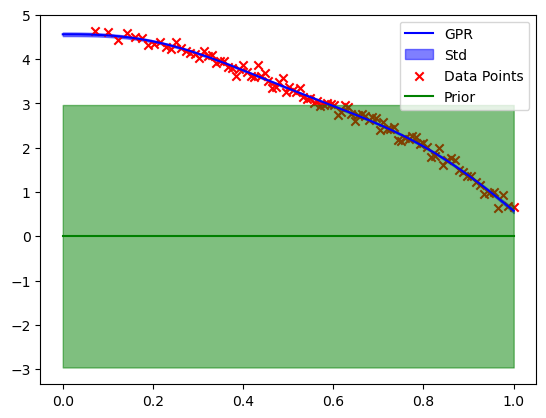

In [9]:
import numpy as np
import logging
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize

logger = logging.getLogger('lgi')


class GPR(object):
    def __init__(self, x_train, y_train, x_deriv_train=None, y_deriv_train=None,
                 y_train_noise=None, y_deriv_train_noise=None):
        if x_train is None or y_train is None:
            self.x_train = np.array([])
            self.y_train = np.array([])
        else:
            self.x_train = x_train
            self.y_train = y_train
        if x_deriv_train is None or y_deriv_train is None:
            self.x_deriv_train = np.array([])
            self.y_deriv_train = np.array([])
        else:
            self.x_deriv_train = x_deriv_train
            self.y_deriv_train = y_deriv_train
        self.y_train_full = np.hstack([self.y_train, self.y_deriv_train])
        if y_train_noise is None:
            y_train_noise = np.zeros_like(y_train)
        if y_deriv_train_noise is None:
            y_deriv_train_noise = np.zeros_like(y_deriv_train)
        self.cov_d = np.diag(np.hstack((y_train_noise**2,
                                        y_deriv_train_noise**2)))
        self.hypers = {'sigma_f': 1.0,
                       'sigma_l': 0.5}
        self.Kstst = None
    def get_cov(self):
        """
        Squared exponential kernel
        """
        K_n_n = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        self.K_n_n = K_n_n
        K_n_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_n = K_n_p.T
        K_p_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (1 - (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K = np.block([[K_n_n, K_n_p],
                      [K_p_n, K_p_p]]) + self.cov_d
        K[np.diag_indices_from(K)] += 1e-8
        return K
    
    
    def get_cov_star(self, x_test):
        K_n_t = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_t = - self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        print('kst forming', K_n_t.shape, K_p_t.shape)
        return np.block([[K_n_t], [K_p_t]])

    def get_cov_star_star(self, x_test):
        K = self.hypers['sigma_f'] ** 2 * np.exp(- 0.5 * (x_test[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K[np.diag_indices_from(K)] += 1e-8
        self.Kstst = K
        return K
    
    def get_Kstst(self):
        return self.Kstst

    def set_hypers(self, hypers):
        self.hypers['sigma_f'] = hypers[0]
        self.hypers['sigma_l'] = hypers[1]

    def get_loss(self, hypers):
        self.set_hypers(hypers)
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, self.y_train_full, lower=True, check_finite=False)
        loss = 2 * np.log(np.diag(L)).sum() + v.T @ v
        logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return loss

    def fit(self):
        x0 = np.array([self.hypers['sigma_f'], self.hypers['sigma_l']])
        result = minimize(fun=self.get_loss, x0=x0)
        hypers_opt = result.x
        self.hypers['sigma_f'] = hypers_opt[0]
        self.hypers['sigma_l'] = hypers_opt[1]
        print(f"sigma_f = {self.hypers['sigma_f']:.2f}")
        print(f"sigma_l = {self.hypers['sigma_l']:.2f}")

    def predict(self, x_test):
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                           "The kernel is not returning a positive "
                           "definite matrix.",
                       ) + exc.args
            raise
        K_star = self.get_cov_star(x_test)
        print(K_star.shape)
        K_star_star = self.get_cov_star_star(x_test)
        alpha = cho_solve((L, True), self.y_train_full, check_finite=False)
        y_star = K_star.T @ alpha
        v = solve_triangular(L, K_star, lower=True, check_finite=False)
        cov_star = K_star_star - v.T @ v
        post_mean = y_star
        post_cov = cov_star
        return post_mean, post_cov
    
if __name__ == '__main__':
    def y_fun(x, noise_sigma=0.0):
        x = np.asarray(x)
        y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
        return y

    x_train = refl_rho#np.array([1, 3, 4, 5, 9])
    y_train = refl_ne#y_fun(x_train, noise_sigma=1e-4)
    x_deriv_train = xd_prime#np.array([0.0, 2 * np.pi])
    y_deriv_train = yd_prime#np.array([0.0, 0.0])
    x_test = np.linspace(0, 1, 1000)
    gpr = GPR(x_train, y_train, x_deriv_train, y_deriv_train, y_train_noise=yd_noise, 
              y_deriv_train_noise=yd_prime_noise)
    gpr.fit()
    y_test, cov_test = gpr.predict(x_test)
    std = np.sqrt(np.diag(cov_test))
    y_lower = y_test - std
    y_upper = y_test + std
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_test, 'b-',label='GPR')
    ax.fill_between(x_test, y_lower, y_upper, color='blue', alpha=0.5, label='Std')
    ax.scatter(x_train, y_train, color='red', marker='x',label='Data Points')
    #plot prior
    Kstst = gpr.get_Kstst()
    ax.plot(x_test,np.zeros(len(x_test)),label='Prior',color='g')
    prior_upper = np.zeros(len(x_test)) + np.sqrt(np.diag(Kstst))
    prior_lower = np.zeros(len(x_test)) - np.sqrt(np.diag(Kstst))
    ax.fill_between(x_test, prior_lower, prior_upper, alpha=0.5, color='g')
    plt.legend()
    fig.show()
    
    

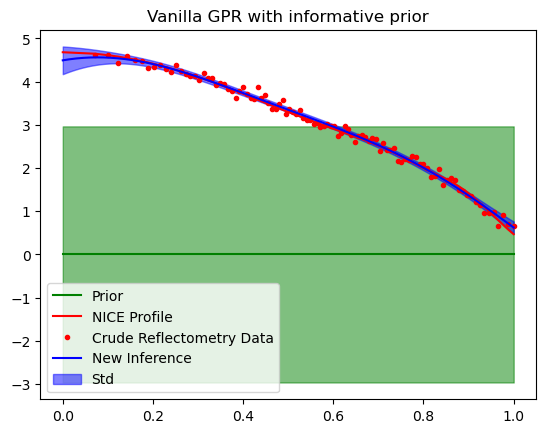

In [10]:
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
#Informative GP1, Informative vanilla GPR

class InformativeGradientVanillaGPR(object):
    def __init__(self, x_test, xd, yd, yd_noise, prior_mu, prior_cov, xd_prime=None, yd_prime=None, yd_prime_noise=None):
        self.x_test = x_test
        self.xd = xd
        self.yd = yd
        self.yd_noise = yd_noise
        self.prior_mu = prior_mu
        self.prior_cov = prior_cov
        self.xd_prime = xd_prime
        self.yd_prime = yd_prime
        self.yd_prime_noise = yd_prime_noise
        
        self.have_grad = type(self.yd_prime) != type(None) and type(xd_prime)!=type(None) and type(yd_prime_noise)!=type(None) 
        self.post_cov = None
        self.post_mu = None
        self.marge_li = None
        
    def MargeLi(self, cov_D, yd):
        try:
            L = cholesky(cov_D, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, yd, lower=True, check_finite=False)
        marge_li = 2 * np.log(np.diag(L)).sum() + v.T @ v
#         logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return marge_li
    
    def chol_inv(self, A):
        L = np.linalg.cholesky(A)
        return np.linalg.inv(L).T @ np.linalg.inv(L)
    def InterpolatePrior(self, x1, x2):
        interp = scipy.interpolate.RegularGridInterpolator((self.x_test,x_test), self.prior_cov, method="nearest", bounds_error=True, fill_value=float('nan'))
        X1, X2 = np.meshgrid(x1,x2)
        return interp((X1,X2))
     
    
    def Infer(self):
        Kstst = self.prior_cov
        
        if self.have_grad:
            K_n_n = self.InterpolatePrior(self.xd, self.xd)
            K_p_p = np.gradient(np.gradient(self.InterpolatePrior(self.xd_prime, self.xd_prime), axis=1), axis=0)
            K_n_p = np.gradient(self.InterpolatePrior(self.xd_prime, self.xd), axis=1)#might need correcting
            K_p_n = K_n_p.T# maybe should be negative
            K = np.block([[K_n_n, K_n_p],
                          [K_p_n, K_p_p]])  
            Kst = np.vstack((self.InterpolatePrior(self.x_test,self.xd), np.gradient(self.InterpolatePrior(self.x_test,self.xd_prime),axis=0)))
            cov_D = K + np.diag(np.hstack((self.yd_noise, self.yd_prime_noise)))
        else:
            K = self.InterpolatePrior(self.xd, self.xd)
            K[np.diag_indices_from(K)] += 1e-8
            Kst = self.InterpolatePrior(self.x_test,self.xd)
            cov_D = K + np.diag(self.yd_noise)

        interp_prior_mu = scipy.interpolate.interp1d(self.x_test, self.prior_mu, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=float('nan'), assume_sorted=False)
        prior_at_xd = interp_prior_mu(self.xd)
        cov_D[np.diag_indices_from(cov_D)] += 1e-8
    
        if self.have_grad:
            prior_at_xd = np.append(prior_at_xd,np.zeros(len(self.xd_prime)))
            yd_full = np.append(self.yd,self.yd_prime)
            self.post_mu = self.prior_mu + Kst.T @ self.chol_inv(cov_D) @ (yd_full - prior_at_xd)
            self.marge_li = self.MargeLi(cov_D, yd_full, tensor=True)
# #     Hao Method
#             try:
#                 L = cholesky(cov_D, lower=True, check_finite=False)
#             except np.linalg.LinAlgError as exc:
#                 exc.args = (
#                                "The kernel is not returning a positive "
#                                "definite matrix.",
#                            ) + exc.args
#                 raise
#             alpha = cho_solve((L, True), yd_full-prior_at_xd, check_finite=False)
#             yst = prior_mu + Kst.T @ alpha
#             self.post_mu = yst

        else: 
            self.post_mu = self.prior_mu + Kst.T @ self.chol_inv(cov_D) @ (self.yd - prior_at_xd)
            self.marge_li = self.MargeLi(cov_D, self.yd, tensor=True)
#         Hao method
#         v = solve_triangular(L, Kst, lower=True, check_finite=False)
#         cov_st = Kstst - v.T @ v
#         self.post_cov = cov_st
        self.post_cov = Kstst - Kst.T @ self.chol_inv(cov_D) @ Kst

    def PlotInference(self):
        std = np.sqrt(np.abs(np.diagonal(self.post_cov)))
        figGPR1 = plt.figure()
        plt.title('Vanilla GPR with informative prior')
        #plot prior
        plt.plot(self.x_test,self.prior_mu,label='Prior',color='g')
        prior_upper = self.prior_mu + np.sqrt(np.diag(self.prior_cov))
        prior_lower = self.prior_mu - np.sqrt(np.diag(self.prior_cov))
        plt.fill_between(self.x_test, prior_lower, prior_upper, alpha=0.5, color='g')
        plt.plot(rho_1d,nice,'r', label='NICE Profile')
        plt.plot(self.xd,self.yd,'r.', label='Crude Reflectometry Data')
        
        plt.plot(self.x_test,self.post_mu,'b', label='New Inference')
        plt.fill_between(x_test, self.post_mu-std, self.post_mu+std, color='b', alpha=0.5, label='Std')
        plt.legend()
        plt.show()

prior_cov = Kstst
infgradvanil = InformativeGradientVanillaGPR(x_test=x_test, xd=refl_rho, yd=refl_ne, yd_noise=yd_noise, prior_mu=prior_mu,
           prior_cov=prior_cov, xd_prime=xd_prime, yd_prime=yd_prime, yd_prime_noise=yd_prime_noise)

infgradvanil.Infer()

infgradvanil.PlotInference()